In [2]:
from sklearn.metrics import mean_squared_error
from scipy.linalg import pinv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math


data = pd.read_csv('Dataset_tidy.csv')

# EXTREME LEARNING MACHINE TS FORECASTING
- Single hidden layer
- No gradient based optimisation
- W/B are randomly assigned
- We will use 14 previous prices as an input

#### Data split / reshaping
- 50 days reserved for test set
- each set has k (14) points reserved for first prediction
- 80:20 split for validation
- Design matrix has to be collection of N vecors (1xk) of preceeding datapoints

In [5]:
data_np = data['Market2: Open'].to_numpy()

# Define input vector length
k = 14
# Define # od datapoints needed for testing (out of train/validate)
holdout = 50

def z_score(array, u, std):
    return (array-u) / std

def split(series, k, holdout, normalize=True):
    # To ensure objectivity, reserve last 50 days for model ranking
    holdout  = 50 + k                                                   # Comment out when (gen algo)
    test     = series[-holdout:]
    series   = series[:-holdout]

    # Split rest 80:20 (adjust for k extra points needed in each split)
    valid_size = int(np.floor(0.2 * (len(series)-2*k)//50) * 50) + k
    #valid_size = 300+k                                                   # Fixed when using gen algo
    train = series[valid_size:]
    valid = series[:valid_size]

    return train, valid, test

# x_np is single feature only currently!
def ELM_data_prep(X_np, k, holdout, y_np=None,
                  normalize_x=True,normalize_y=True,
                  verbose=False):
   
    # Get input splits
    X_train, X_valid, X_test = split(X_np, k, holdout)

    # If labels (y_np) are not provided we are predicting time series itself
    # thus y labels are generated from X
    if type(y_np) is not np.ndarray:
        # lables as array (Nx1)
        y_train = X_train.reshape((-1, 1))[k:]   # We slice out first k points reserved for first pred.
        y_valid = X_valid.reshape((-1, 1))[k:]
        y_test  = X_test.reshape((-1, 1))[k:] 
    else:
        y_train, y_valid, y_test = split(y_np, k, holdout)
        y_train, y_valid, y_test = (y_train[k:], y_valid[k:], y_test[k:])
     
    # Normalize all sets by X_train statistics.
    u_norm     = X_train.mean()
    std_norm   = X_train.std()
    if normalize_x:
        X_train  = z_score(X_train, u_norm, std_norm)
        X_valid  = z_score(X_valid, u_norm, std_norm)
        X_test   = z_score(X_test, u_norm, std_norm)   
    if normalize_y:                                      # Do not normalize labels in classification!
        y_train  = z_score(y_train, u_norm, std_norm)
        y_valid  = z_score(y_valid, u_norm, std_norm)
        y_test   = z_score(y_test, u_norm, std_norm)          
        
    # TODO: rework such that X can be actual design matrix, not just series
    # X matrix as 2D(Nxk) array where each row will be k preceeding points
    def stack(array, k):
        stacked = np.zeros((len(array)-k, k))
        for i, _ in enumerate(stacked):
            stacked[i] = array[i:i+k]
        return stacked    
    
    X_train = stack(X_train, k)
    X_valid = stack(X_valid, k)
    X_test  = stack(X_test, k)   
    
    if verbose:
        print(f'Train samples: {len(X_train)}',
              f'\nValidation samples: {len(X_valid)}',
              f'\nTest samples: {len(X_test)}')           
        print(X_train.shape, y_train.shape)
        print(X_valid.shape, y_valid.shape)
        print(X_test.shape, y_test.shape)    
    
    return X_train, y_train, X_valid, y_valid, X_test, y_test, u_norm, std_norm

X_train, y_train, X_valid, y_valid,\
X_test, y_test, u_norm, std_norm = ELM_data_prep(data_np, k, holdout, verbose=True)

Train samples: 1212 
Validation samples: 300 
Test samples: 50
(1212, 14) (1212, 1)
(300, 14) (300, 1)
(50, 14) (50, 1)


### Initialize / Train ELM 
- TODO: add polish=bool, which retrains ELM and keeps the best one

In [6]:
from ELM import ELM

# Model is fed input vector [1xk] and outputs next point prediction
def get_ELM(k, hidden, X_train, y_train, num_classes=1):
    input_length = k
    num_hidden_layers = hidden

    model = ELM(input_length,
                num_hidden_layers,
                num_classes)
    
    model.fit(X_train, y_train, display_time=False)
    return model

# Default model
model = get_ELM(14, 100, X_train, y_train )

### Forecasting

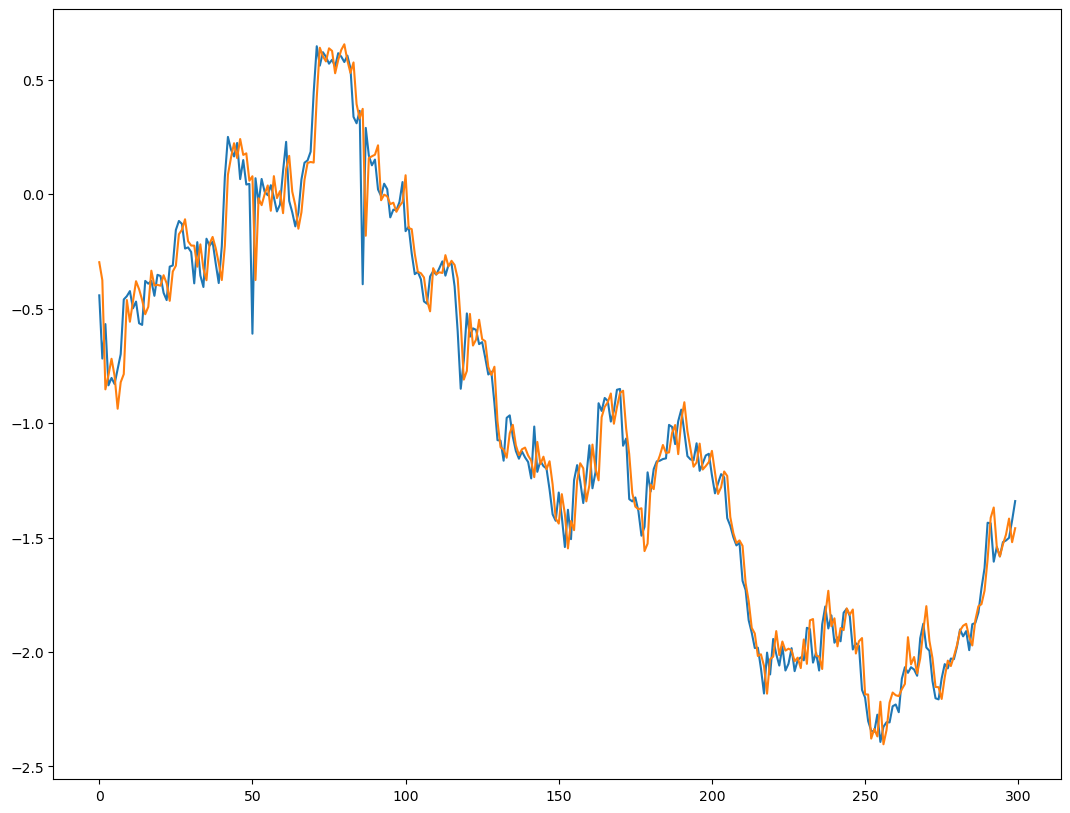

In [7]:
# Defined such that we can do dynamic (more than 1 point) forecast if needed in future
def forecast(data, model, forecast_len, forecast_start=None,
             oos_only=False):
    # Single point prediction
    insample = data[:forecast_start]
    prediction = model(insample)
    k = model._num_input_nodes
    
    # Forecast takes first input vector after forcast start
    if forecast_start == None:
        forecast_start = -1       
    inp_forecast = (data[forecast_start])

    forecast = []
    for i in range(forecast_len):
        new_point = model(inp_forecast)
        forecast.append(new_point[0])
        inp_forecast = np.append(inp_forecast, new_point)[1:]
    
    if oos_only:
        return forecast
    
    entire = np.append(prediction, forecast)
    return entire

# Get and plt one day ahead forecast
plt.figure(figsize=(13, 10))
plt.plot(y_valid)
plt.plot(forecast(X_valid, model, 0, forecast_start=None))
plt.show()
    

In [324]:
def evaluate(X_valid, y_valid, model, u_norm, std_norm, output='rmse'):
    prediction = model(X_valid)
    prediction = prediction * std_norm + u_norm    #De-normalized
    y_valid    = y_valid * std_norm + u_norm       #De-normalized
    residuals  = y_valid - prediction
    
    if output=='prediction':
        return prediction
    
    return np.sqrt(np.mean((residuals)**2))

evaluate(X_valid, y_valid, model, u_norm, std_norm)    

92.71193581771091

# DIFFERENTIAL EVOLUTION ALGORITHM HYPERPARAMETER TUNED ELM
- Differential EA does not support discreet optimisation natively, but just rounding the parameters to nearest integer will work well
- ELM cost fun is not very steep and is noisy (ELM is semi-stochastic) meaning large range of parameters will yeald similiar results
- Mitigate by scoring each hyperparam. set by avg of n models (10)

In [245]:
from scipy.optimize import differential_evolution

# Prepare the feed, model and evaluate based on params proposed by EA
# Hardcoded temporary changes into fun:`ELM_data_prep` to ensure same validation set despite diff. k
def score_ELM_params(hyperparams, data_np):
    holdout = 50
    k, hidden = hyperparams
    k = round(k)
    hidden = round(hidden)
    print(f'k: {k}, Hidden: {hidden}')
    
    X_train, y_train, X_valid, y_valid, _,_ ,\
    u_norm, std_norm = ELM_data_prep(data_np, k, holdout)
    
    model = get_ELM(k, hidden, X_train, y_train)
    resid = evaluate(X_valid, y_valid, model, u_norm, std_norm) 
    print(resid)
    return resid

# Set limits for Differential Evolution
k_param = (1, 50)
hidden_param = (2, 1000)
boundaries = [k_param] + [hidden_param]

# Set up Differential Evolution solver
solver = differential_evolution(score_ELM_params,
                                boundaries,
                                args=(data_np,),
                                init='sobol',
                                strategy='rand1bin',
                                popsize=100,
                                mutation=(1, 1.5),
                                recombination=0.65,
                                tol=0.01,
                                maxiter=2500,
                                seed=14480)       # pln/month

# Calculate best hyperparameters and resulting rmse
summary = solver.message
best_hyperparams = solver.x
best_rmse = solver.fun

k: 21, Hidden: 234
Bias shape: (234,)
W shape: (21, 234)
Beta shape: (234, 1)
100.98169684941035
k: 28, Hidden: 589
Bias shape: (589,)
W shape: (28, 589)
Beta shape: (589, 1)
149.74061933856214
k: 39, Hidden: 429
Bias shape: (429,)
W shape: (39, 429)
Beta shape: (429, 1)
125.87994053940115
k: 8, Hidden: 753
Bias shape: (753,)
W shape: (8, 753)
Beta shape: (753, 1)
918.9085314254796
k: 3, Hidden: 285
Bias shape: (285,)
W shape: (3, 285)
Beta shape: (285, 1)
64671.18377625395
k: 46, Hidden: 897
Bias shape: (897,)
W shape: (46, 897)
Beta shape: (897, 1)
311.5388192256875
k: 33, Hidden: 121
Bias shape: (121,)
W shape: (33, 121)
Beta shape: (121, 1)
105.78272322610766
k: 15, Hidden: 702
Bias shape: (702,)
W shape: (15, 702)
Beta shape: (702, 1)
251.9030549320056
k: 19, Hidden: 482
Bias shape: (482,)
W shape: (19, 482)
Beta shape: (482, 1)
146.52393750893359
k: 37, Hidden: 837
Bias shape: (837,)
W shape: (37, 837)
Beta shape: (837, 1)
213.91800509323
k: 47, Hidden: 181
Bias shape: (181,)
W s

415.4435348861833
k: 35, Hidden: 17
Bias shape: (17,)
W shape: (35, 17)
Beta shape: (17, 1)
184.17176627923533
k: 17, Hidden: 684
Bias shape: (684,)
W shape: (17, 684)
Beta shape: (684, 1)
203.2963477024273
k: 15, Hidden: 402
Bias shape: (402,)
W shape: (15, 402)
Beta shape: (402, 1)
129.46455734886973
k: 33, Hidden: 796
Bias shape: (796,)
W shape: (33, 796)
Beta shape: (796, 1)
223.53402571883436
k: 45, Hidden: 190
Bias shape: (190,)
W shape: (45, 190)
Beta shape: (190, 1)
114.4323501620065
k: 2, Hidden: 615
Bias shape: (615,)
W shape: (2, 615)
Beta shape: (615, 1)
11907.637773995084
k: 9, Hidden: 85
Bias shape: (85,)
W shape: (9, 85)
Beta shape: (85, 1)
92.07866982194338
k: 40, Hidden: 720
Bias shape: (720,)
W shape: (40, 720)
Beta shape: (720, 1)
205.68400712525724
k: 26, Hidden: 266
Bias shape: (266,)
W shape: (26, 266)
Beta shape: (266, 1)
104.9233227743951
k: 20, Hidden: 933
Bias shape: (933,)
W shape: (20, 933)
Beta shape: (933, 1)
339.86152445946453
k: 20, Hidden: 113
Bias shap

193.68761994268712
k: 32, Hidden: 290
Bias shape: (290,)
W shape: (32, 290)
Beta shape: (290, 1)
111.49087138514768
k: 25, Hidden: 895
Bias shape: (895,)
W shape: (25, 895)
Beta shape: (895, 1)
285.2495329859978
k: 24, Hidden: 271
Bias shape: (271,)
W shape: (24, 271)
Beta shape: (271, 1)
101.0904873195061
k: 30, Hidden: 907
Bias shape: (907,)
W shape: (30, 907)
Beta shape: (907, 1)
273.94694270690735
k: 43, Hidden: 80
Bias shape: (80,)
W shape: (43, 80)
Beta shape: (80, 1)
120.33639321540623
k: 12, Hidden: 746
Bias shape: (746,)
W shape: (12, 746)
Beta shape: (746, 1)
477.2741953835932
k: 5, Hidden: 216
Bias shape: (216,)
W shape: (5, 216)
Beta shape: (216, 1)
293.76939847383625
k: 48, Hidden: 610
Bias shape: (610,)
W shape: (48, 610)
Beta shape: (610, 1)
173.41723341459488
k: 37, Hidden: 376
Bias shape: (376,)
W shape: (37, 376)
Beta shape: (376, 1)
118.48584085556652
k: 18, Hidden: 801
Bias shape: (801,)
W shape: (18, 801)
Beta shape: (801, 1)
309.9739213024388
k: 14, Hidden: 23
Bia

267.526394665483
k: 14, Hidden: 285
Bias shape: (285,)
W shape: (14, 285)
Beta shape: (285, 1)
112.45902033292202
k: 19, Hidden: 897
Bias shape: (897,)
W shape: (19, 897)
Beta shape: (897, 1)
297.747094771583
k: 33, Hidden: 539
Bias shape: (539,)
W shape: (33, 539)
Beta shape: (539, 1)
146.70773510041033
k: 50, Hidden: 598
Bias shape: (598,)
W shape: (50, 598)
Beta shape: (598, 1)
159.65361251142437
k: 24, Hidden: 482
Bias shape: (482,)
W shape: (24, 482)
Beta shape: (482, 1)
122.030822310626
k: 10, Hidden: 428
Bias shape: (428,)
W shape: (10, 428)
Beta shape: (428, 1)
245.6592152541573
k: 17, Hidden: 949
Bias shape: (949,)
W shape: (17, 949)
Beta shape: (949, 1)
368.09681504220896
k: 4, Hidden: 286
Bias shape: (286,)
W shape: (4, 286)
Beta shape: (286, 1)
2019.3601859839973
k: 32, Hidden: 980
Bias shape: (980,)
W shape: (32, 980)
Beta shape: (980, 1)
299.7988902045215
k: 36, Hidden: 333
Bias shape: (333,)
W shape: (36, 333)
Beta shape: (333, 1)
125.47477612195463
k: 42, Hidden: 244
Bi

KeyboardInterrupt: 

In [53]:
print('Best hyperparameters are: ', best_hyperparams)
print('Best rmse is: ', best_rmse)
print(summary)

Best hyperparameters are:  [11.53518178 85.51528699]
Best rmse is:  85.12846345120072
Optimization terminated successfully.


Default parameters k=14, L=100 rmse=91.747

Tuned parameters   k=12, L=86 rmse=85.128 **(-7.3%)**

### Plotting comparison, final test score

In [328]:
# Any model changes require rework in design matrixes (Different k -> different split sizes)
k_opt, hidden_opt = (12, 86) # 12 / 86
k_opt      = round(k_opt)
hidden_opt = round(hidden_opt)

# Matrixes for optimal model parameters
X_train_opt, y_train_opt, X_valid_opt, y_valid_opt,\
X_test_opt, y_test_opt, u_norm_opt, std_norm_opt = ELM_data_prep(data_np, k_opt, holdout)

# Optimal model training
model_opt = get_ELM(k_opt, hidden_opt, X_train_opt, y_train_opt)


Bias shape: (86,)
W shape: (12, 86)
Beta shape: (86, 1)


Default model has final test score (error) of: 394.72
Optimized model has final test score (error) of: 241.98


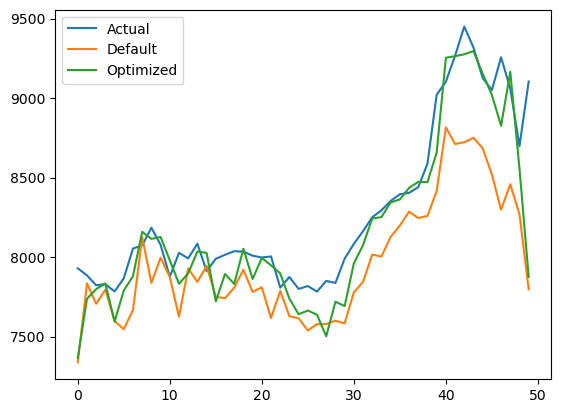

In [329]:
# Test evaluation
score_def = evaluate(X_test, y_test, model, u_norm, std_norm)
pred_def  = evaluate(X_test, y_test, model, u_norm, std_norm, output='prediction')

score_opt = evaluate(X_test_opt, y_test_opt, model_opt, u_norm_opt, std_norm_opt,)
pred_opt  = evaluate(X_test_opt, y_test_opt, model_opt, u_norm_opt, std_norm_opt, output='prediction')

print(f'Default model has final test score (error) of: {score_def:.2f}')
print(f'Optimized model has final test score (error) of: {score_opt:.2f}')

# Denormalize
y_test_denorm = y_test_opt * std_norm_opt + u_norm_opt

plt.plot(y_test_denorm)
plt.plot(pred_def)
plt.plot(pred_opt)
plt.legend(['Actual', 'Default', 'Optimized'])
plt.show()

### Conclusions:
- Tuned model has error lowered by 39% !, however:
- Holdout set (50 days) may be small
- Optimized hyperparms may be specifically best for the validation period
 - To try to mitigate (be more general) by k-fold validation (so called walk-forward analysis in TS)
- We can try to use other metrics than RMSE (MAPE etc.), we need to look at residuals distribution

# ELM Directional Prediction
### Default model run

In [9]:
from tensorflow.keras.utils import to_categorical

# Data preparation
direction = data['Market2: Direction'].to_numpy()
direction = to_categorical(direction, 2).astype(np.float32)

X_train, y_train, X_valid, y_valid,\
X_test, y_test, u_norm, std_norm = ELM_data_prep(data_np, k, holdout, y_np=direction,
                                                 normalize_y=False)

# Train and evaluate default model
k = 14
hidden = 100
model_dir = get_ELM(k, hidden, X_train, y_train, num_classes=2)

_, accuracy = model_dir.evaluate(X_valid, y_valid)
print(f'Models accuracy is {accuracy*100:.2f}%')

Models accuracy is 53.67%


# Hyperparmeter tuning
- each hyperparam set is evaluated 10 times, average accuracy is taken into account

In [292]:
# Trains the model with given hyperparams n times, return avg accuracy
def get_avg_acc(k, hidden,
                X_train, y_train,
                X_valid, y_valid, n=10):
    results = np.zeros(n)
    total = len(y_train)
    for i in range(n):
        model = get_ELM(k, hidden, X_train, y_train, num_classes=2)
        pred = model(X_valid)
        _, acc   = model.evaluate(X_valid, y_valid)
        results[i] = acc
    return results.mean()

# Pipeline for evolution algo, adjusted for directional model
def score_ELMd_params(hyperparams, x_np, y_np):
    holdout = 50
    k, hidden = hyperparams
    k = round(k)
    hidden = round(hidden)
    
    print(f'k: {k}, Hidden: {hidden}')
    print(f'X shape: {x_np.shape} y shape: {y_np.shape}')
    
    X_train, y_train, X_valid, y_valid, _,_ ,\
    u_norm, std_norm = ELM_data_prep(x_np, k, holdout,
                                     y_np=y_np,
                                     normalize_y=False,
                                     verbose=True)
    
    acc = get_avg_acc(k, hidden,
                      X_train, y_train,
                      X_valid, y_valid)
    print(acc)
    return (1-acc)

# Set limits for Differential Evolution
k_param = (1, 50)
hidden_param = (2, 1000)
boundaries = [k_param] + [hidden_param]

# Set up Differential Evolution solver
solver = differential_evolution(score_ELMd_params,
                                boundaries,
                                args=(data_np, direction),
                                init='sobol',
                                strategy='rand1bin',
                                popsize=15,
                                mutation=(1, 1.8),
                                recombination=0.65,
                                tol=0.015,
                                maxiter=500,  
                                seed=14480)       # pln/month

# Calculate best hyperparameters and resulting rmse
summary = solver.message
best_hyperparams = solver.x
best_rmse = solver.fun


k: 21, Hidden: 234
X shape: (1604,) y shape: (1604, 2)
Train samples: 1262
Validation samples: 271 
Test samples: 71
(1241, 21) (1241, 2)
(250, 21) (250, 2)
(50, 21) (50, 2)
Bias shape: (234,)
W shape: (21, 234)
Beta shape: (234, 2)
Bias shape: (234,)
W shape: (21, 234)
Beta shape: (234, 2)
Bias shape: (234,)
W shape: (21, 234)
Beta shape: (234, 2)
Bias shape: (234,)
W shape: (21, 234)
Beta shape: (234, 2)
Bias shape: (234,)
W shape: (21, 234)
Beta shape: (234, 2)
Bias shape: (234,)
W shape: (21, 234)
Beta shape: (234, 2)
Bias shape: (234,)
W shape: (21, 234)
Beta shape: (234, 2)
Bias shape: (234,)
W shape: (21, 234)
Beta shape: (234, 2)
Bias shape: (234,)
W shape: (21, 234)
Beta shape: (234, 2)
Bias shape: (234,)
W shape: (21, 234)
Beta shape: (234, 2)
0.5044000000000001
k: 28, Hidden: 589
X shape: (1604,) y shape: (1604, 2)
Train samples: 1248
Validation samples: 278 
Test samples: 78
(1220, 28) (1220, 2)
(250, 28) (250, 2)
(50, 28) (50, 2)
Bias shape: (589,)
W shape: (28, 589)
Beta 

Bias shape: (181,)
W shape: (47, 181)
Beta shape: (181, 2)
0.526
k: 4, Hidden: 504
X shape: (1604,) y shape: (1604, 2)
Train samples: 1246
Validation samples: 304 
Test samples: 54
(1242, 4) (1242, 2)
(300, 4) (300, 2)
(50, 4) (50, 2)
Bias shape: (504,)
W shape: (4, 504)
Beta shape: (504, 2)
Bias shape: (504,)
W shape: (4, 504)
Beta shape: (504, 2)
Bias shape: (504,)
W shape: (4, 504)
Beta shape: (504, 2)
Bias shape: (504,)
W shape: (4, 504)
Beta shape: (504, 2)
Bias shape: (504,)
W shape: (4, 504)
Beta shape: (504, 2)
Bias shape: (504,)
W shape: (4, 504)
Beta shape: (504, 2)
Bias shape: (504,)
W shape: (4, 504)
Beta shape: (504, 2)
Bias shape: (504,)
W shape: (4, 504)
Beta shape: (504, 2)
Bias shape: (504,)
W shape: (4, 504)
Beta shape: (504, 2)
Bias shape: (504,)
W shape: (4, 504)
Beta shape: (504, 2)
0.5136666666666666
k: 13, Hidden: 37
X shape: (1604,) y shape: (1604, 2)
Train samples: 1228
Validation samples: 313 
Test samples: 63
(1215, 13) (1215, 2)
(300, 13) (300, 2)
(50, 13) (

Bias shape: (548,)
W shape: (49, 548)
Beta shape: (548, 2)
Bias shape: (548,)
W shape: (49, 548)
Beta shape: (548, 2)
Bias shape: (548,)
W shape: (49, 548)
Beta shape: (548, 2)
Bias shape: (548,)
W shape: (49, 548)
Beta shape: (548, 2)
Bias shape: (548,)
W shape: (49, 548)
Beta shape: (548, 2)
0.5176000000000001
k: 36, Hidden: 469
X shape: (1604,) y shape: (1604, 2)
Train samples: 1232
Validation samples: 286 
Test samples: 86
(1196, 36) (1196, 2)
(250, 36) (250, 2)
(50, 36) (50, 2)
Bias shape: (469,)
W shape: (36, 469)
Beta shape: (469, 2)
Bias shape: (469,)
W shape: (36, 469)
Beta shape: (469, 2)
Bias shape: (469,)
W shape: (36, 469)
Beta shape: (469, 2)
Bias shape: (469,)
W shape: (36, 469)
Beta shape: (469, 2)
Bias shape: (469,)
W shape: (36, 469)
Beta shape: (469, 2)
Bias shape: (469,)
W shape: (36, 469)
Beta shape: (469, 2)
Bias shape: (469,)
W shape: (36, 469)
Beta shape: (469, 2)
Bias shape: (469,)
W shape: (36, 469)
Beta shape: (469, 2)
Bias shape: (469,)
W shape: (36, 469)
Be

Bias shape: (661,)
W shape: (16, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (16, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (16, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (16, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (16, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (16, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (16, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (16, 661)
Beta shape: (661, 2)
0.5066666666666666
k: 30, Hidden: 637
X shape: (1604,) y shape: (1604, 2)
Train samples: 1244
Validation samples: 280 
Test samples: 80
(1214, 30) (1214, 2)
(250, 30) (250, 2)
(50, 30) (50, 2)
Bias shape: (637,)
W shape: (30, 637)
Beta shape: (637, 2)
Bias shape: (637,)
W shape: (30, 637)
Beta shape: (637, 2)
Bias shape: (637,)
W shape: (30, 637)
Beta shape: (637, 2)
Bias shape: (637,)
W shape: (30, 637)
Beta shape: (637, 2)
Bias shape: (637,)
W shape: (30, 637)
Beta shape: (637, 2)
Bias shape: (637,)
W shape: (30, 637)
Be

Bias shape: (504,)
W shape: (27, 504)
Beta shape: (504, 2)
Bias shape: (504,)
W shape: (27, 504)
Beta shape: (504, 2)
Bias shape: (504,)
W shape: (27, 504)
Beta shape: (504, 2)
Bias shape: (504,)
W shape: (27, 504)
Beta shape: (504, 2)
Bias shape: (504,)
W shape: (27, 504)
Beta shape: (504, 2)
Bias shape: (504,)
W shape: (27, 504)
Beta shape: (504, 2)
Bias shape: (504,)
W shape: (27, 504)
Beta shape: (504, 2)
Bias shape: (504,)
W shape: (27, 504)
Beta shape: (504, 2)
0.5184
k: 13, Hidden: 753
X shape: (1604,) y shape: (1604, 2)
Train samples: 1228
Validation samples: 313 
Test samples: 63
(1215, 13) (1215, 2)
(300, 13) (300, 2)
(50, 13) (50, 2)
Bias shape: (753,)
W shape: (13, 753)
Beta shape: (753, 2)
Bias shape: (753,)
W shape: (13, 753)
Beta shape: (753, 2)
Bias shape: (753,)
W shape: (13, 753)
Beta shape: (753, 2)
Bias shape: (753,)
W shape: (13, 753)
Beta shape: (753, 2)
Bias shape: (753,)
W shape: (13, 753)
Beta shape: (753, 2)
Bias shape: (753,)
W shape: (13, 753)
Beta shape: (7

0.49559999999999993
k: 26, Hidden: 297
X shape: (1604,) y shape: (1604, 2)
Train samples: 1252
Validation samples: 276 
Test samples: 76
(1226, 26) (1226, 2)
(250, 26) (250, 2)
(50, 26) (50, 2)
Bias shape: (297,)
W shape: (26, 297)
Beta shape: (297, 2)
Bias shape: (297,)
W shape: (26, 297)
Beta shape: (297, 2)
Bias shape: (297,)
W shape: (26, 297)
Beta shape: (297, 2)
Bias shape: (297,)
W shape: (26, 297)
Beta shape: (297, 2)
Bias shape: (297,)
W shape: (26, 297)
Beta shape: (297, 2)
Bias shape: (297,)
W shape: (26, 297)
Beta shape: (297, 2)
Bias shape: (297,)
W shape: (26, 297)
Beta shape: (297, 2)
Bias shape: (297,)
W shape: (26, 297)
Beta shape: (297, 2)
Bias shape: (297,)
W shape: (26, 297)
Beta shape: (297, 2)
Bias shape: (297,)
W shape: (26, 297)
Beta shape: (297, 2)
0.5252000000000001
k: 17, Hidden: 226
X shape: (1604,) y shape: (1604, 2)
Train samples: 1220
Validation samples: 317 
Test samples: 67
(1203, 17) (1203, 2)
(300, 17) (300, 2)
(50, 17) (50, 2)
Bias shape: (226,)
W sh

Bias shape: (540,)
W shape: (25, 540)
Beta shape: (540, 2)
Bias shape: (540,)
W shape: (25, 540)
Beta shape: (540, 2)
Bias shape: (540,)
W shape: (25, 540)
Beta shape: (540, 2)
0.5279999999999999
k: 6, Hidden: 388
X shape: (1604,) y shape: (1604, 2)
Train samples: 1242
Validation samples: 306 
Test samples: 56
(1236, 6) (1236, 2)
(300, 6) (300, 2)
(50, 6) (50, 2)
Bias shape: (388,)
W shape: (6, 388)
Beta shape: (388, 2)
Bias shape: (388,)
W shape: (6, 388)
Beta shape: (388, 2)
Bias shape: (388,)
W shape: (6, 388)
Beta shape: (388, 2)
Bias shape: (388,)
W shape: (6, 388)
Beta shape: (388, 2)
Bias shape: (388,)
W shape: (6, 388)
Beta shape: (388, 2)
Bias shape: (388,)
W shape: (6, 388)
Beta shape: (388, 2)
Bias shape: (388,)
W shape: (6, 388)
Beta shape: (388, 2)
Bias shape: (388,)
W shape: (6, 388)
Beta shape: (388, 2)
Bias shape: (388,)
W shape: (6, 388)
Beta shape: (388, 2)
Bias shape: (388,)
W shape: (6, 388)
Beta shape: (388, 2)
0.48133333333333334
k: 43, Hidden: 993
X shape: (1604,

Bias shape: (765,)
W shape: (6, 765)
Beta shape: (765, 2)
Bias shape: (765,)
W shape: (6, 765)
Beta shape: (765, 2)
Bias shape: (765,)
W shape: (6, 765)
Beta shape: (765, 2)
Bias shape: (765,)
W shape: (6, 765)
Beta shape: (765, 2)
Bias shape: (765,)
W shape: (6, 765)
Beta shape: (765, 2)
Bias shape: (765,)
W shape: (6, 765)
Beta shape: (765, 2)
Bias shape: (765,)
W shape: (6, 765)
Beta shape: (765, 2)
Bias shape: (765,)
W shape: (6, 765)
Beta shape: (765, 2)
0.5109999999999999
k: 13, Hidden: 301
X shape: (1604,) y shape: (1604, 2)
Train samples: 1228
Validation samples: 313 
Test samples: 63
(1215, 13) (1215, 2)
(300, 13) (300, 2)
(50, 13) (50, 2)
Bias shape: (301,)
W shape: (13, 301)
Beta shape: (301, 2)
Bias shape: (301,)
W shape: (13, 301)
Beta shape: (301, 2)
Bias shape: (301,)
W shape: (13, 301)
Beta shape: (301, 2)
Bias shape: (301,)
W shape: (13, 301)
Beta shape: (301, 2)
Bias shape: (301,)
W shape: (13, 301)
Beta shape: (301, 2)
Bias shape: (301,)
W shape: (13, 301)
Beta shape

0.5143333333333333
k: 31, Hidden: 450
X shape: (1604,) y shape: (1604, 2)
Train samples: 1242
Validation samples: 281 
Test samples: 81
(1211, 31) (1211, 2)
(250, 31) (250, 2)
(50, 31) (50, 2)
Bias shape: (450,)
W shape: (31, 450)
Beta shape: (450, 2)
Bias shape: (450,)
W shape: (31, 450)
Beta shape: (450, 2)
Bias shape: (450,)
W shape: (31, 450)
Beta shape: (450, 2)
Bias shape: (450,)
W shape: (31, 450)
Beta shape: (450, 2)
Bias shape: (450,)
W shape: (31, 450)
Beta shape: (450, 2)
Bias shape: (450,)
W shape: (31, 450)
Beta shape: (450, 2)
Bias shape: (450,)
W shape: (31, 450)
Beta shape: (450, 2)
Bias shape: (450,)
W shape: (31, 450)
Beta shape: (450, 2)
Bias shape: (450,)
W shape: (31, 450)
Beta shape: (450, 2)
Bias shape: (450,)
W shape: (31, 450)
Beta shape: (450, 2)
0.5107999999999999
k: 26, Hidden: 656
X shape: (1604,) y shape: (1604, 2)
Train samples: 1252
Validation samples: 276 
Test samples: 76
(1226, 26) (1226, 2)
(250, 26) (250, 2)
(50, 26) (50, 2)
Bias shape: (656,)
W sha

Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
0.5493333333333335
k: 16, Hidden: 74
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Validation samples: 316 
Test samples: 66
(1206, 16) (1206, 2)
(300, 16) (300, 2)
(50, 16) (50, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shap

0.5519999999999999
k: 15, Hidden: 70
X shape: (1604,) y shape: (1604, 2)
Train samples: 1224
Validation samples: 315 
Test samples: 65
(1209, 15) (1209, 2)
(300, 15) (300, 2)
(50, 15) (50, 2)
Bias shape: (70,)
W shape: (15, 70)
Beta shape: (70, 2)
Bias shape: (70,)
W shape: (15, 70)
Beta shape: (70, 2)
Bias shape: (70,)
W shape: (15, 70)
Beta shape: (70, 2)
Bias shape: (70,)
W shape: (15, 70)
Beta shape: (70, 2)
Bias shape: (70,)
W shape: (15, 70)
Beta shape: (70, 2)
Bias shape: (70,)
W shape: (15, 70)
Beta shape: (70, 2)
Bias shape: (70,)
W shape: (15, 70)
Beta shape: (70, 2)
Bias shape: (70,)
W shape: (15, 70)
Beta shape: (70, 2)
Bias shape: (70,)
W shape: (15, 70)
Beta shape: (70, 2)
Bias shape: (70,)
W shape: (15, 70)
Beta shape: (70, 2)
0.5466666666666666
k: 15, Hidden: 70
X shape: (1604,) y shape: (1604, 2)
Train samples: 1224
Validation samples: 315 
Test samples: 65
(1209, 15) (1209, 2)
(300, 15) (300, 2)
(50, 15) (50, 2)
Bias shape: (70,)
W shape: (15, 70)
Beta shape: (70, 2)


Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
0.548
k: 16, Hidden: 74
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Validation samples: 316 
Test samples: 66
(1206, 16) (1206, 2)
(300, 16) (300, 2)
(50, 16) (50, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
B

Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
0.536
k: 16, Hidden: 74
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Validation samples: 316 
Test samples: 66
(1206, 16) (1206, 2)
(300, 16) (300, 2)
(50, 16) (50, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
0.5366666666666666
k: 16, Hidden: 74
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Validation samples: 316 
Test samples: 66
(1206, 16) (12

Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
0.552
k: 16, Hidden: 74
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Validation samples: 316 
Test samples: 66
(1206, 16) (1206, 2)
(300, 16) (300, 2)
(50, 16) (50, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
B

(1206, 16) (1206, 2)
(300, 16) (300, 2)
(50, 16) (50, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
0.5433333333333333
k: 16, Hidden: 74
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Validation samples: 316 
Test samples: 66
(1206, 16) (1206, 2)
(300, 16) (300, 2)
(50, 16) (50, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W sha

0.5184
k: 37, Hidden: 837
X shape: (1604,) y shape: (1604, 2)
Train samples: 1230
Validation samples: 287 
Test samples: 87
(1193, 37) (1193, 2)
(250, 37) (250, 2)
(50, 37) (50, 2)
Bias shape: (837,)
W shape: (37, 837)
Beta shape: (837, 2)
Bias shape: (837,)
W shape: (37, 837)
Beta shape: (837, 2)
Bias shape: (837,)
W shape: (37, 837)
Beta shape: (837, 2)
Bias shape: (837,)
W shape: (37, 837)
Beta shape: (837, 2)
Bias shape: (837,)
W shape: (37, 837)
Beta shape: (837, 2)
Bias shape: (837,)
W shape: (37, 837)
Beta shape: (837, 2)
Bias shape: (837,)
W shape: (37, 837)
Beta shape: (837, 2)
Bias shape: (837,)
W shape: (37, 837)
Beta shape: (837, 2)
Bias shape: (837,)
W shape: (37, 837)
Beta shape: (837, 2)
Bias shape: (837,)
W shape: (37, 837)
Beta shape: (837, 2)
0.522
k: 47, Hidden: 181
X shape: (1604,) y shape: (1604, 2)
Train samples: 1210
Validation samples: 297 
Test samples: 97
(1163, 47) (1163, 2)
(250, 47) (250, 2)
(50, 47) (50, 2)
Bias shape: (181,)
W shape: (47, 181)
Beta shape:

Bias shape: (661,)
W shape: (11, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (11, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (11, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (11, 661)
Beta shape: (661, 2)
0.5149999999999999
k: 6, Hidden: 131
X shape: (1604,) y shape: (1604, 2)
Train samples: 1242
Validation samples: 306 
Test samples: 56
(1236, 6) (1236, 2)
(300, 6) (300, 2)
(50, 6) (50, 2)
Bias shape: (131,)
W shape: (6, 131)
Beta shape: (131, 2)
Bias shape: (131,)
W shape: (6, 131)
Beta shape: (131, 2)
Bias shape: (131,)
W shape: (6, 131)
Beta shape: (131, 2)
Bias shape: (131,)
W shape: (6, 131)
Beta shape: (131, 2)
Bias shape: (131,)
W shape: (6, 131)
Beta shape: (131, 2)
Bias shape: (131,)
W shape: (6, 131)
Beta shape: (131, 2)
Bias shape: (131,)
W shape: (6, 131)
Beta shape: (131, 2)
Bias shape: (131,)
W shape: (6, 131)
Beta shape: (131, 2)
Bias shape: (131,)
W shape: (6, 131)
Beta shape: (131, 2)
Bias shape: (131,)
W shape: (6, 131)
Beta shape: (131

Bias shape: (218,)
W shape: (26, 218)
Beta shape: (218, 2)
Bias shape: (218,)
W shape: (26, 218)
Beta shape: (218, 2)
0.5104
k: 20, Hidden: 604
X shape: (1604,) y shape: (1604, 2)
Train samples: 1264
Validation samples: 270 
Test samples: 70
(1244, 20) (1244, 2)
(250, 20) (250, 2)
(50, 20) (50, 2)
Bias shape: (604,)
W shape: (20, 604)
Beta shape: (604, 2)
Bias shape: (604,)
W shape: (20, 604)
Beta shape: (604, 2)
Bias shape: (604,)
W shape: (20, 604)
Beta shape: (604, 2)
Bias shape: (604,)
W shape: (20, 604)
Beta shape: (604, 2)
Bias shape: (604,)
W shape: (20, 604)
Beta shape: (604, 2)
Bias shape: (604,)
W shape: (20, 604)
Beta shape: (604, 2)
Bias shape: (604,)
W shape: (20, 604)
Beta shape: (604, 2)
Bias shape: (604,)
W shape: (20, 604)
Beta shape: (604, 2)
Bias shape: (604,)
W shape: (20, 604)
Beta shape: (604, 2)
Bias shape: (604,)
W shape: (20, 604)
Beta shape: (604, 2)
0.5328
k: 16, Hidden: 661
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Validation samples: 316 
Test

Bias shape: (837,)
W shape: (36, 837)
Beta shape: (837, 2)
Bias shape: (837,)
W shape: (36, 837)
Beta shape: (837, 2)
Bias shape: (837,)
W shape: (36, 837)
Beta shape: (837, 2)
Bias shape: (837,)
W shape: (36, 837)
Beta shape: (837, 2)
Bias shape: (837,)
W shape: (36, 837)
Beta shape: (837, 2)
Bias shape: (837,)
W shape: (36, 837)
Beta shape: (837, 2)
Bias shape: (837,)
W shape: (36, 837)
Beta shape: (837, 2)
Bias shape: (837,)
W shape: (36, 837)
Beta shape: (837, 2)
0.5128
k: 34, Hidden: 235
X shape: (1604,) y shape: (1604, 2)
Train samples: 1236
Validation samples: 284 
Test samples: 84
(1202, 34) (1202, 2)
(250, 34) (250, 2)
(50, 34) (50, 2)
Bias shape: (235,)
W shape: (34, 235)
Beta shape: (235, 2)
Bias shape: (235,)
W shape: (34, 235)
Beta shape: (235, 2)
Bias shape: (235,)
W shape: (34, 235)
Beta shape: (235, 2)
Bias shape: (235,)
W shape: (34, 235)
Beta shape: (235, 2)
Bias shape: (235,)
W shape: (34, 235)
Beta shape: (235, 2)
Bias shape: (235,)
W shape: (34, 235)
Beta shape: (2

Bias shape: (827,)
W shape: (6, 827)
Beta shape: (827, 2)
Bias shape: (827,)
W shape: (6, 827)
Beta shape: (827, 2)
Bias shape: (827,)
W shape: (6, 827)
Beta shape: (827, 2)
Bias shape: (827,)
W shape: (6, 827)
Beta shape: (827, 2)
Bias shape: (827,)
W shape: (6, 827)
Beta shape: (827, 2)
Bias shape: (827,)
W shape: (6, 827)
Beta shape: (827, 2)
Bias shape: (827,)
W shape: (6, 827)
Beta shape: (827, 2)
Bias shape: (827,)
W shape: (6, 827)
Beta shape: (827, 2)
Bias shape: (827,)
W shape: (6, 827)
Beta shape: (827, 2)
0.49833333333333335
k: 42, Hidden: 548
X shape: (1604,) y shape: (1604, 2)
Train samples: 1220
Validation samples: 292 
Test samples: 92
(1178, 42) (1178, 2)
(250, 42) (250, 2)
(50, 42) (50, 2)
Bias shape: (548,)
W shape: (42, 548)
Beta shape: (548, 2)
Bias shape: (548,)
W shape: (42, 548)
Beta shape: (548, 2)
Bias shape: (548,)
W shape: (42, 548)
Beta shape: (548, 2)
Bias shape: (548,)
W shape: (42, 548)
Beta shape: (548, 2)
Bias shape: (548,)
W shape: (42, 548)
Beta shape

Bias shape: (741,)
W shape: (20, 741)
Beta shape: (741, 2)
Bias shape: (741,)
W shape: (20, 741)
Beta shape: (741, 2)
0.5204000000000001
k: 9, Hidden: 604
X shape: (1604,) y shape: (1604, 2)
Train samples: 1236
Validation samples: 309 
Test samples: 59
(1227, 9) (1227, 2)
(300, 9) (300, 2)
(50, 9) (50, 2)
Bias shape: (604,)
W shape: (9, 604)
Beta shape: (604, 2)
Bias shape: (604,)
W shape: (9, 604)
Beta shape: (604, 2)
Bias shape: (604,)
W shape: (9, 604)
Beta shape: (604, 2)
Bias shape: (604,)
W shape: (9, 604)
Beta shape: (604, 2)
Bias shape: (604,)
W shape: (9, 604)
Beta shape: (604, 2)
Bias shape: (604,)
W shape: (9, 604)
Beta shape: (604, 2)
Bias shape: (604,)
W shape: (9, 604)
Beta shape: (604, 2)
Bias shape: (604,)
W shape: (9, 604)
Beta shape: (604, 2)
Bias shape: (604,)
W shape: (9, 604)
Beta shape: (604, 2)
Bias shape: (604,)
W shape: (9, 604)
Beta shape: (604, 2)
0.5186666666666666
k: 25, Hidden: 540
X shape: (1604,) y shape: (1604, 2)
Train samples: 1254
Validation samples:

Bias shape: (346,)
W shape: (44, 346)
Beta shape: (346, 2)
Bias shape: (346,)
W shape: (44, 346)
Beta shape: (346, 2)
Bias shape: (346,)
W shape: (44, 346)
Beta shape: (346, 2)
Bias shape: (346,)
W shape: (44, 346)
Beta shape: (346, 2)
0.5064
k: 36, Hidden: 235
X shape: (1604,) y shape: (1604, 2)
Train samples: 1232
Validation samples: 286 
Test samples: 86
(1196, 36) (1196, 2)
(250, 36) (250, 2)
(50, 36) (50, 2)
Bias shape: (235,)
W shape: (36, 235)
Beta shape: (235, 2)
Bias shape: (235,)
W shape: (36, 235)
Beta shape: (235, 2)
Bias shape: (235,)
W shape: (36, 235)
Beta shape: (235, 2)
Bias shape: (235,)
W shape: (36, 235)
Beta shape: (235, 2)
Bias shape: (235,)
W shape: (36, 235)
Beta shape: (235, 2)
Bias shape: (235,)
W shape: (36, 235)
Beta shape: (235, 2)
Bias shape: (235,)
W shape: (36, 235)
Beta shape: (235, 2)
Bias shape: (235,)
W shape: (36, 235)
Beta shape: (235, 2)
Bias shape: (235,)
W shape: (36, 235)
Beta shape: (235, 2)
Bias shape: (235,)
W shape: (36, 235)
Beta shape: (2

Bias shape: (185,)
W shape: (44, 185)
Beta shape: (185, 2)
Bias shape: (185,)
W shape: (44, 185)
Beta shape: (185, 2)
Bias shape: (185,)
W shape: (44, 185)
Beta shape: (185, 2)
Bias shape: (185,)
W shape: (44, 185)
Beta shape: (185, 2)
Bias shape: (185,)
W shape: (44, 185)
Beta shape: (185, 2)
Bias shape: (185,)
W shape: (44, 185)
Beta shape: (185, 2)
Bias shape: (185,)
W shape: (44, 185)
Beta shape: (185, 2)
0.5112
k: 29, Hidden: 548
X shape: (1604,) y shape: (1604, 2)
Train samples: 1246
Validation samples: 279 
Test samples: 79
(1217, 29) (1217, 2)
(250, 29) (250, 2)
(50, 29) (50, 2)
Bias shape: (548,)
W shape: (29, 548)
Beta shape: (548, 2)
Bias shape: (548,)
W shape: (29, 548)
Beta shape: (548, 2)
Bias shape: (548,)
W shape: (29, 548)
Beta shape: (548, 2)
Bias shape: (548,)
W shape: (29, 548)
Beta shape: (548, 2)
Bias shape: (548,)
W shape: (29, 548)
Beta shape: (548, 2)
Bias shape: (548,)
W shape: (29, 548)
Beta shape: (548, 2)
Bias shape: (548,)
W shape: (29, 548)
Beta shape: (5

Bias shape: (644,)
W shape: (34, 644)
Beta shape: (644, 2)
Bias shape: (644,)
W shape: (34, 644)
Beta shape: (644, 2)
Bias shape: (644,)
W shape: (34, 644)
Beta shape: (644, 2)
Bias shape: (644,)
W shape: (34, 644)
Beta shape: (644, 2)
Bias shape: (644,)
W shape: (34, 644)
Beta shape: (644, 2)
Bias shape: (644,)
W shape: (34, 644)
Beta shape: (644, 2)
Bias shape: (644,)
W shape: (34, 644)
Beta shape: (644, 2)
Bias shape: (644,)
W shape: (34, 644)
Beta shape: (644, 2)
Bias shape: (644,)
W shape: (34, 644)
Beta shape: (644, 2)
0.5292
k: 48, Hidden: 336
X shape: (1604,) y shape: (1604, 2)
Train samples: 1208
Validation samples: 298 
Test samples: 98
(1160, 48) (1160, 2)
(250, 48) (250, 2)
(50, 48) (50, 2)
Bias shape: (336,)
W shape: (48, 336)
Beta shape: (336, 2)
Bias shape: (336,)
W shape: (48, 336)
Beta shape: (336, 2)
Bias shape: (336,)
W shape: (48, 336)
Beta shape: (336, 2)
Bias shape: (336,)
W shape: (48, 336)
Beta shape: (336, 2)
Bias shape: (336,)
W shape: (48, 336)
Beta shape: (3

0.5316
k: 27, Hidden: 541
X shape: (1604,) y shape: (1604, 2)
Train samples: 1250
Validation samples: 277 
Test samples: 77
(1223, 27) (1223, 2)
(250, 27) (250, 2)
(50, 27) (50, 2)
Bias shape: (541,)
W shape: (27, 541)
Beta shape: (541, 2)
Bias shape: (541,)
W shape: (27, 541)
Beta shape: (541, 2)
Bias shape: (541,)
W shape: (27, 541)
Beta shape: (541, 2)
Bias shape: (541,)
W shape: (27, 541)
Beta shape: (541, 2)
Bias shape: (541,)
W shape: (27, 541)
Beta shape: (541, 2)
Bias shape: (541,)
W shape: (27, 541)
Beta shape: (541, 2)
Bias shape: (541,)
W shape: (27, 541)
Beta shape: (541, 2)
Bias shape: (541,)
W shape: (27, 541)
Beta shape: (541, 2)
Bias shape: (541,)
W shape: (27, 541)
Beta shape: (541, 2)
Bias shape: (541,)
W shape: (27, 541)
Beta shape: (541, 2)
0.5064
k: 17, Hidden: 276
X shape: (1604,) y shape: (1604, 2)
Train samples: 1220
Validation samples: 317 
Test samples: 67
(1203, 17) (1203, 2)
(300, 17) (300, 2)
(50, 17) (50, 2)
Bias shape: (276,)
W shape: (17, 276)
Beta shape

Bias shape: (332,)
W shape: (11, 332)
Beta shape: (332, 2)
Bias shape: (332,)
W shape: (11, 332)
Beta shape: (332, 2)
Bias shape: (332,)
W shape: (11, 332)
Beta shape: (332, 2)
0.5176666666666667
k: 29, Hidden: 680
X shape: (1604,) y shape: (1604, 2)
Train samples: 1246
Validation samples: 279 
Test samples: 79
(1217, 29) (1217, 2)
(250, 29) (250, 2)
(50, 29) (50, 2)
Bias shape: (680,)
W shape: (29, 680)
Beta shape: (680, 2)
Bias shape: (680,)
W shape: (29, 680)
Beta shape: (680, 2)
Bias shape: (680,)
W shape: (29, 680)
Beta shape: (680, 2)
Bias shape: (680,)
W shape: (29, 680)
Beta shape: (680, 2)
Bias shape: (680,)
W shape: (29, 680)
Beta shape: (680, 2)
Bias shape: (680,)
W shape: (29, 680)
Beta shape: (680, 2)
Bias shape: (680,)
W shape: (29, 680)
Beta shape: (680, 2)
Bias shape: (680,)
W shape: (29, 680)
Beta shape: (680, 2)
Bias shape: (680,)
W shape: (29, 680)
Beta shape: (680, 2)
Bias shape: (680,)
W shape: (29, 680)
Beta shape: (680, 2)
0.5356
k: 45, Hidden: 656
X shape: (1604

Bias shape: (252,)
W shape: (40, 252)
Beta shape: (252, 2)
Bias shape: (252,)
W shape: (40, 252)
Beta shape: (252, 2)
Bias shape: (252,)
W shape: (40, 252)
Beta shape: (252, 2)
Bias shape: (252,)
W shape: (40, 252)
Beta shape: (252, 2)
0.506
k: 23, Hidden: 74
X shape: (1604,) y shape: (1604, 2)
Train samples: 1258
Validation samples: 273 
Test samples: 73
(1235, 23) (1235, 2)
(250, 23) (250, 2)
(50, 23) (50, 2)
Bias shape: (74,)
W shape: (23, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (23, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (23, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (23, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (23, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (23, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (23, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (23, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (23, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (23, 74)
Beta shape: (74, 2)
0.4936
k: 37, Hidden: 632

Bias shape: (235,)
W shape: (39, 235)
Beta shape: (235, 2)
Bias shape: (235,)
W shape: (39, 235)
Beta shape: (235, 2)
0.5039999999999999
k: 17, Hidden: 888
X shape: (1604,) y shape: (1604, 2)
Train samples: 1220
Validation samples: 317 
Test samples: 67
(1203, 17) (1203, 2)
(300, 17) (300, 2)
(50, 17) (50, 2)
Bias shape: (888,)
W shape: (17, 888)
Beta shape: (888, 2)
Bias shape: (888,)
W shape: (17, 888)
Beta shape: (888, 2)
Bias shape: (888,)
W shape: (17, 888)
Beta shape: (888, 2)
Bias shape: (888,)
W shape: (17, 888)
Beta shape: (888, 2)
Bias shape: (888,)
W shape: (17, 888)
Beta shape: (888, 2)
Bias shape: (888,)
W shape: (17, 888)
Beta shape: (888, 2)
Bias shape: (888,)
W shape: (17, 888)
Beta shape: (888, 2)
Bias shape: (888,)
W shape: (17, 888)
Beta shape: (888, 2)
Bias shape: (888,)
W shape: (17, 888)
Beta shape: (888, 2)
Bias shape: (888,)
W shape: (17, 888)
Beta shape: (888, 2)
0.5166666666666667
k: 13, Hidden: 718
X shape: (1604,) y shape: (1604, 2)
Train samples: 1228
Valid

Bias shape: (538,)
W shape: (30, 538)
Beta shape: (538, 2)
Bias shape: (538,)
W shape: (30, 538)
Beta shape: (538, 2)
Bias shape: (538,)
W shape: (30, 538)
Beta shape: (538, 2)
Bias shape: (538,)
W shape: (30, 538)
Beta shape: (538, 2)
Bias shape: (538,)
W shape: (30, 538)
Beta shape: (538, 2)
Bias shape: (538,)
W shape: (30, 538)
Beta shape: (538, 2)
0.5244000000000002
k: 23, Hidden: 117
X shape: (1604,) y shape: (1604, 2)
Train samples: 1258
Validation samples: 273 
Test samples: 73
(1235, 23) (1235, 2)
(250, 23) (250, 2)
(50, 23) (50, 2)
Bias shape: (117,)
W shape: (23, 117)
Beta shape: (117, 2)
Bias shape: (117,)
W shape: (23, 117)
Beta shape: (117, 2)
Bias shape: (117,)
W shape: (23, 117)
Beta shape: (117, 2)
Bias shape: (117,)
W shape: (23, 117)
Beta shape: (117, 2)
Bias shape: (117,)
W shape: (23, 117)
Beta shape: (117, 2)
Bias shape: (117,)
W shape: (23, 117)
Beta shape: (117, 2)
Bias shape: (117,)
W shape: (23, 117)
Beta shape: (117, 2)
Bias shape: (117,)
W shape: (23, 117)
Be

Bias shape: (512,)
W shape: (37, 512)
Beta shape: (512, 2)
Bias shape: (512,)
W shape: (37, 512)
Beta shape: (512, 2)
Bias shape: (512,)
W shape: (37, 512)
Beta shape: (512, 2)
Bias shape: (512,)
W shape: (37, 512)
Beta shape: (512, 2)
Bias shape: (512,)
W shape: (37, 512)
Beta shape: (512, 2)
Bias shape: (512,)
W shape: (37, 512)
Beta shape: (512, 2)
Bias shape: (512,)
W shape: (37, 512)
Beta shape: (512, 2)
Bias shape: (512,)
W shape: (37, 512)
Beta shape: (512, 2)
Bias shape: (512,)
W shape: (37, 512)
Beta shape: (512, 2)
0.5024
k: 18, Hidden: 637
X shape: (1604,) y shape: (1604, 2)
Train samples: 1218
Validation samples: 318 
Test samples: 68
(1200, 18) (1200, 2)
(300, 18) (300, 2)
(50, 18) (50, 2)
Bias shape: (637,)
W shape: (18, 637)
Beta shape: (637, 2)
Bias shape: (637,)
W shape: (18, 637)
Beta shape: (637, 2)
Bias shape: (637,)
W shape: (18, 637)
Beta shape: (637, 2)
Bias shape: (637,)
W shape: (18, 637)
Beta shape: (637, 2)
Bias shape: (637,)
W shape: (18, 637)
Beta shape: (6

Bias shape: (967,)
W shape: (2, 967)
Beta shape: (967, 2)
Bias shape: (967,)
W shape: (2, 967)
Beta shape: (967, 2)
Bias shape: (967,)
W shape: (2, 967)
Beta shape: (967, 2)
Bias shape: (967,)
W shape: (2, 967)
Beta shape: (967, 2)
Bias shape: (967,)
W shape: (2, 967)
Beta shape: (967, 2)
Bias shape: (967,)
W shape: (2, 967)
Beta shape: (967, 2)
Bias shape: (967,)
W shape: (2, 967)
Beta shape: (967, 2)
Bias shape: (967,)
W shape: (2, 967)
Beta shape: (967, 2)
Bias shape: (967,)
W shape: (2, 967)
Beta shape: (967, 2)
0.5289999999999999
k: 13, Hidden: 669
X shape: (1604,) y shape: (1604, 2)
Train samples: 1228
Validation samples: 313 
Test samples: 63
(1215, 13) (1215, 2)
(300, 13) (300, 2)
(50, 13) (50, 2)
Bias shape: (669,)
W shape: (13, 669)
Beta shape: (669, 2)
Bias shape: (669,)
W shape: (13, 669)
Beta shape: (669, 2)
Bias shape: (669,)
W shape: (13, 669)
Beta shape: (669, 2)
Bias shape: (669,)
W shape: (13, 669)
Beta shape: (669, 2)
Bias shape: (669,)
W shape: (13, 669)
Beta shape:

0.5092000000000001
k: 28, Hidden: 936
X shape: (1604,) y shape: (1604, 2)
Train samples: 1248
Validation samples: 278 
Test samples: 78
(1220, 28) (1220, 2)
(250, 28) (250, 2)
(50, 28) (50, 2)
Bias shape: (936,)
W shape: (28, 936)
Beta shape: (936, 2)
Bias shape: (936,)
W shape: (28, 936)
Beta shape: (936, 2)
Bias shape: (936,)
W shape: (28, 936)
Beta shape: (936, 2)
Bias shape: (936,)
W shape: (28, 936)
Beta shape: (936, 2)
Bias shape: (936,)
W shape: (28, 936)
Beta shape: (936, 2)
Bias shape: (936,)
W shape: (28, 936)
Beta shape: (936, 2)
Bias shape: (936,)
W shape: (28, 936)
Beta shape: (936, 2)
Bias shape: (936,)
W shape: (28, 936)
Beta shape: (936, 2)
Bias shape: (936,)
W shape: (28, 936)
Beta shape: (936, 2)
Bias shape: (936,)
W shape: (28, 936)
Beta shape: (936, 2)
0.5200000000000001
k: 18, Hidden: 694
X shape: (1604,) y shape: (1604, 2)
Train samples: 1218
Validation samples: 318 
Test samples: 68
(1200, 18) (1200, 2)
(300, 18) (300, 2)
(50, 18) (50, 2)
Bias shape: (694,)
W sha

Bias shape: (603,)
W shape: (30, 603)
Beta shape: (603, 2)
Bias shape: (603,)
W shape: (30, 603)
Beta shape: (603, 2)
Bias shape: (603,)
W shape: (30, 603)
Beta shape: (603, 2)
Bias shape: (603,)
W shape: (30, 603)
Beta shape: (603, 2)
Bias shape: (603,)
W shape: (30, 603)
Beta shape: (603, 2)
Bias shape: (603,)
W shape: (30, 603)
Beta shape: (603, 2)
Bias shape: (603,)
W shape: (30, 603)
Beta shape: (603, 2)
Bias shape: (603,)
W shape: (30, 603)
Beta shape: (603, 2)
Bias shape: (603,)
W shape: (30, 603)
Beta shape: (603, 2)
0.5316
k: 35, Hidden: 964
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 285 
Test samples: 85
(1199, 35) (1199, 2)
(250, 35) (250, 2)
(50, 35) (50, 2)
Bias shape: (964,)
W shape: (35, 964)
Beta shape: (964, 2)
Bias shape: (964,)
W shape: (35, 964)
Beta shape: (964, 2)
Bias shape: (964,)
W shape: (35, 964)
Beta shape: (964, 2)
Bias shape: (964,)
W shape: (35, 964)
Beta shape: (964, 2)
Bias shape: (964,)
W shape: (35, 964)
Beta shape: (9

Bias shape: (339,)
W shape: (18, 339)
Beta shape: (339, 2)
0.5236666666666666
k: 13, Hidden: 746
X shape: (1604,) y shape: (1604, 2)
Train samples: 1228
Validation samples: 313 
Test samples: 63
(1215, 13) (1215, 2)
(300, 13) (300, 2)
(50, 13) (50, 2)
Bias shape: (746,)
W shape: (13, 746)
Beta shape: (746, 2)
Bias shape: (746,)
W shape: (13, 746)
Beta shape: (746, 2)
Bias shape: (746,)
W shape: (13, 746)
Beta shape: (746, 2)
Bias shape: (746,)
W shape: (13, 746)
Beta shape: (746, 2)
Bias shape: (746,)
W shape: (13, 746)
Beta shape: (746, 2)
Bias shape: (746,)
W shape: (13, 746)
Beta shape: (746, 2)
Bias shape: (746,)
W shape: (13, 746)
Beta shape: (746, 2)
Bias shape: (746,)
W shape: (13, 746)
Beta shape: (746, 2)
Bias shape: (746,)
W shape: (13, 746)
Beta shape: (746, 2)
Bias shape: (746,)
W shape: (13, 746)
Beta shape: (746, 2)
0.522
k: 25, Hidden: 992
X shape: (1604,) y shape: (1604, 2)
Train samples: 1254
Validation samples: 275 
Test samples: 75
(1229, 25) (1229, 2)
(250, 25) (250

Bias shape: (683,)
W shape: (13, 683)
Beta shape: (683, 2)
Bias shape: (683,)
W shape: (13, 683)
Beta shape: (683, 2)
Bias shape: (683,)
W shape: (13, 683)
Beta shape: (683, 2)
Bias shape: (683,)
W shape: (13, 683)
Beta shape: (683, 2)
Bias shape: (683,)
W shape: (13, 683)
Beta shape: (683, 2)
0.5273333333333333
k: 28, Hidden: 655
X shape: (1604,) y shape: (1604, 2)
Train samples: 1248
Validation samples: 278 
Test samples: 78
(1220, 28) (1220, 2)
(250, 28) (250, 2)
(50, 28) (50, 2)
Bias shape: (655,)
W shape: (28, 655)
Beta shape: (655, 2)
Bias shape: (655,)
W shape: (28, 655)
Beta shape: (655, 2)
Bias shape: (655,)
W shape: (28, 655)
Beta shape: (655, 2)
Bias shape: (655,)
W shape: (28, 655)
Beta shape: (655, 2)
Bias shape: (655,)
W shape: (28, 655)
Beta shape: (655, 2)
Bias shape: (655,)
W shape: (28, 655)
Beta shape: (655, 2)
Bias shape: (655,)
W shape: (28, 655)
Beta shape: (655, 2)
Bias shape: (655,)
W shape: (28, 655)
Beta shape: (655, 2)
Bias shape: (655,)
W shape: (28, 655)
Be

Bias shape: (839,)
W shape: (47, 839)
Beta shape: (839, 2)
Bias shape: (839,)
W shape: (47, 839)
Beta shape: (839, 2)
Bias shape: (839,)
W shape: (47, 839)
Beta shape: (839, 2)
Bias shape: (839,)
W shape: (47, 839)
Beta shape: (839, 2)
Bias shape: (839,)
W shape: (47, 839)
Beta shape: (839, 2)
Bias shape: (839,)
W shape: (47, 839)
Beta shape: (839, 2)
Bias shape: (839,)
W shape: (47, 839)
Beta shape: (839, 2)
Bias shape: (839,)
W shape: (47, 839)
Beta shape: (839, 2)
Bias shape: (839,)
W shape: (47, 839)
Beta shape: (839, 2)
0.5012000000000001
k: 26, Hidden: 756
X shape: (1604,) y shape: (1604, 2)
Train samples: 1252
Validation samples: 276 
Test samples: 76
(1226, 26) (1226, 2)
(250, 26) (250, 2)
(50, 26) (50, 2)
Bias shape: (756,)
W shape: (26, 756)
Beta shape: (756, 2)
Bias shape: (756,)
W shape: (26, 756)
Beta shape: (756, 2)
Bias shape: (756,)
W shape: (26, 756)
Beta shape: (756, 2)
Bias shape: (756,)
W shape: (26, 756)
Beta shape: (756, 2)
Bias shape: (756,)
W shape: (26, 756)
Be

Bias shape: (308,)
W shape: (27, 308)
Beta shape: (308, 2)
Bias shape: (308,)
W shape: (27, 308)
Beta shape: (308, 2)
Bias shape: (308,)
W shape: (27, 308)
Beta shape: (308, 2)
Bias shape: (308,)
W shape: (27, 308)
Beta shape: (308, 2)
Bias shape: (308,)
W shape: (27, 308)
Beta shape: (308, 2)
Bias shape: (308,)
W shape: (27, 308)
Beta shape: (308, 2)
Bias shape: (308,)
W shape: (27, 308)
Beta shape: (308, 2)
0.5112
k: 24, Hidden: 649
X shape: (1604,) y shape: (1604, 2)
Train samples: 1256
Validation samples: 274 
Test samples: 74
(1232, 24) (1232, 2)
(250, 24) (250, 2)
(50, 24) (50, 2)
Bias shape: (649,)
W shape: (24, 649)
Beta shape: (649, 2)
Bias shape: (649,)
W shape: (24, 649)
Beta shape: (649, 2)
Bias shape: (649,)
W shape: (24, 649)
Beta shape: (649, 2)
Bias shape: (649,)
W shape: (24, 649)
Beta shape: (649, 2)
Bias shape: (649,)
W shape: (24, 649)
Beta shape: (649, 2)
Bias shape: (649,)
W shape: (24, 649)
Beta shape: (649, 2)
Bias shape: (649,)
W shape: (24, 649)
Beta shape: (6

Bias shape: (403,)
W shape: (28, 403)
Beta shape: (403, 2)
Bias shape: (403,)
W shape: (28, 403)
Beta shape: (403, 2)
Bias shape: (403,)
W shape: (28, 403)
Beta shape: (403, 2)
Bias shape: (403,)
W shape: (28, 403)
Beta shape: (403, 2)
Bias shape: (403,)
W shape: (28, 403)
Beta shape: (403, 2)
Bias shape: (403,)
W shape: (28, 403)
Beta shape: (403, 2)
Bias shape: (403,)
W shape: (28, 403)
Beta shape: (403, 2)
Bias shape: (403,)
W shape: (28, 403)
Beta shape: (403, 2)
Bias shape: (403,)
W shape: (28, 403)
Beta shape: (403, 2)
0.5107999999999999
k: 12, Hidden: 182
X shape: (1604,) y shape: (1604, 2)
Train samples: 1230
Validation samples: 312 
Test samples: 62
(1218, 12) (1218, 2)
(300, 12) (300, 2)
(50, 12) (50, 2)
Bias shape: (182,)
W shape: (12, 182)
Beta shape: (182, 2)
Bias shape: (182,)
W shape: (12, 182)
Beta shape: (182, 2)
Bias shape: (182,)
W shape: (12, 182)
Beta shape: (182, 2)
Bias shape: (182,)
W shape: (12, 182)
Beta shape: (182, 2)
Bias shape: (182,)
W shape: (12, 182)
Be

(1217, 29) (1217, 2)
(250, 29) (250, 2)
(50, 29) (50, 2)
Bias shape: (963,)
W shape: (29, 963)
Beta shape: (963, 2)
Bias shape: (963,)
W shape: (29, 963)
Beta shape: (963, 2)
Bias shape: (963,)
W shape: (29, 963)
Beta shape: (963, 2)
Bias shape: (963,)
W shape: (29, 963)
Beta shape: (963, 2)
Bias shape: (963,)
W shape: (29, 963)
Beta shape: (963, 2)
Bias shape: (963,)
W shape: (29, 963)
Beta shape: (963, 2)
Bias shape: (963,)
W shape: (29, 963)
Beta shape: (963, 2)
Bias shape: (963,)
W shape: (29, 963)
Beta shape: (963, 2)
Bias shape: (963,)
W shape: (29, 963)
Beta shape: (963, 2)
Bias shape: (963,)
W shape: (29, 963)
Beta shape: (963, 2)
0.5216
k: 47, Hidden: 380
X shape: (1604,) y shape: (1604, 2)
Train samples: 1210
Validation samples: 297 
Test samples: 97
(1163, 47) (1163, 2)
(250, 47) (250, 2)
(50, 47) (50, 2)
Bias shape: (380,)
W shape: (47, 380)
Beta shape: (380, 2)
Bias shape: (380,)
W shape: (47, 380)
Beta shape: (380, 2)
Bias shape: (380,)
W shape: (47, 380)
Beta shape: (380

Bias shape: (557,)
W shape: (23, 557)
Beta shape: (557, 2)
Bias shape: (557,)
W shape: (23, 557)
Beta shape: (557, 2)
0.5484
k: 42, Hidden: 114
X shape: (1604,) y shape: (1604, 2)
Train samples: 1220
Validation samples: 292 
Test samples: 92
(1178, 42) (1178, 2)
(250, 42) (250, 2)
(50, 42) (50, 2)
Bias shape: (114,)
W shape: (42, 114)
Beta shape: (114, 2)
Bias shape: (114,)
W shape: (42, 114)
Beta shape: (114, 2)
Bias shape: (114,)
W shape: (42, 114)
Beta shape: (114, 2)
Bias shape: (114,)
W shape: (42, 114)
Beta shape: (114, 2)
Bias shape: (114,)
W shape: (42, 114)
Beta shape: (114, 2)
Bias shape: (114,)
W shape: (42, 114)
Beta shape: (114, 2)
Bias shape: (114,)
W shape: (42, 114)
Beta shape: (114, 2)
Bias shape: (114,)
W shape: (42, 114)
Beta shape: (114, 2)
Bias shape: (114,)
W shape: (42, 114)
Beta shape: (114, 2)
Bias shape: (114,)
W shape: (42, 114)
Beta shape: (114, 2)
0.526
k: 11, Hidden: 82
X shape: (1604,) y shape: (1604, 2)
Train samples: 1232
Validation samples: 311 
Test s

Bias shape: (414,)
W shape: (48, 414)
Beta shape: (414, 2)
Bias shape: (414,)
W shape: (48, 414)
Beta shape: (414, 2)
Bias shape: (414,)
W shape: (48, 414)
Beta shape: (414, 2)
Bias shape: (414,)
W shape: (48, 414)
Beta shape: (414, 2)
0.4959999999999999
k: 43, Hidden: 724
X shape: (1604,) y shape: (1604, 2)
Train samples: 1218
Validation samples: 293 
Test samples: 93
(1175, 43) (1175, 2)
(250, 43) (250, 2)
(50, 43) (50, 2)
Bias shape: (724,)
W shape: (43, 724)
Beta shape: (724, 2)
Bias shape: (724,)
W shape: (43, 724)
Beta shape: (724, 2)
Bias shape: (724,)
W shape: (43, 724)
Beta shape: (724, 2)
Bias shape: (724,)
W shape: (43, 724)
Beta shape: (724, 2)
Bias shape: (724,)
W shape: (43, 724)
Beta shape: (724, 2)
Bias shape: (724,)
W shape: (43, 724)
Beta shape: (724, 2)
Bias shape: (724,)
W shape: (43, 724)
Beta shape: (724, 2)
Bias shape: (724,)
W shape: (43, 724)
Beta shape: (724, 2)
Bias shape: (724,)
W shape: (43, 724)
Beta shape: (724, 2)
Bias shape: (724,)
W shape: (43, 724)
Be

Bias shape: (763,)
W shape: (17, 763)
Beta shape: (763, 2)
Bias shape: (763,)
W shape: (17, 763)
Beta shape: (763, 2)
Bias shape: (763,)
W shape: (17, 763)
Beta shape: (763, 2)
Bias shape: (763,)
W shape: (17, 763)
Beta shape: (763, 2)
Bias shape: (763,)
W shape: (17, 763)
Beta shape: (763, 2)
Bias shape: (763,)
W shape: (17, 763)
Beta shape: (763, 2)
Bias shape: (763,)
W shape: (17, 763)
Beta shape: (763, 2)
Bias shape: (763,)
W shape: (17, 763)
Beta shape: (763, 2)
0.5236666666666666
k: 42, Hidden: 36
X shape: (1604,) y shape: (1604, 2)
Train samples: 1220
Validation samples: 292 
Test samples: 92
(1178, 42) (1178, 2)
(250, 42) (250, 2)
(50, 42) (50, 2)
Bias shape: (36,)
W shape: (42, 36)
Beta shape: (36, 2)
Bias shape: (36,)
W shape: (42, 36)
Beta shape: (36, 2)
Bias shape: (36,)
W shape: (42, 36)
Beta shape: (36, 2)
Bias shape: (36,)
W shape: (42, 36)
Beta shape: (36, 2)
Bias shape: (36,)
W shape: (42, 36)
Beta shape: (36, 2)
Bias shape: (36,)
W shape: (42, 36)
Beta shape: (36, 2)


Bias shape: (679,)
W shape: (47, 679)
Beta shape: (679, 2)
Bias shape: (679,)
W shape: (47, 679)
Beta shape: (679, 2)
Bias shape: (679,)
W shape: (47, 679)
Beta shape: (679, 2)
Bias shape: (679,)
W shape: (47, 679)
Beta shape: (679, 2)
Bias shape: (679,)
W shape: (47, 679)
Beta shape: (679, 2)
Bias shape: (679,)
W shape: (47, 679)
Beta shape: (679, 2)
Bias shape: (679,)
W shape: (47, 679)
Beta shape: (679, 2)
Bias shape: (679,)
W shape: (47, 679)
Beta shape: (679, 2)
Bias shape: (679,)
W shape: (47, 679)
Beta shape: (679, 2)
0.5048
k: 22, Hidden: 107
X shape: (1604,) y shape: (1604, 2)
Train samples: 1260
Validation samples: 272 
Test samples: 72
(1238, 22) (1238, 2)
(250, 22) (250, 2)
(50, 22) (50, 2)
Bias shape: (107,)
W shape: (22, 107)
Beta shape: (107, 2)
Bias shape: (107,)
W shape: (22, 107)
Beta shape: (107, 2)
Bias shape: (107,)
W shape: (22, 107)
Beta shape: (107, 2)
Bias shape: (107,)
W shape: (22, 107)
Beta shape: (107, 2)
Bias shape: (107,)
W shape: (22, 107)
Beta shape: (1

Bias shape: (976,)
W shape: (31, 976)
Beta shape: (976, 2)
0.49800000000000005
k: 17, Hidden: 674
X shape: (1604,) y shape: (1604, 2)
Train samples: 1220
Validation samples: 317 
Test samples: 67
(1203, 17) (1203, 2)
(300, 17) (300, 2)
(50, 17) (50, 2)
Bias shape: (674,)
W shape: (17, 674)
Beta shape: (674, 2)
Bias shape: (674,)
W shape: (17, 674)
Beta shape: (674, 2)
Bias shape: (674,)
W shape: (17, 674)
Beta shape: (674, 2)
Bias shape: (674,)
W shape: (17, 674)
Beta shape: (674, 2)
Bias shape: (674,)
W shape: (17, 674)
Beta shape: (674, 2)
Bias shape: (674,)
W shape: (17, 674)
Beta shape: (674, 2)
Bias shape: (674,)
W shape: (17, 674)
Beta shape: (674, 2)
Bias shape: (674,)
W shape: (17, 674)
Beta shape: (674, 2)
Bias shape: (674,)
W shape: (17, 674)
Beta shape: (674, 2)
Bias shape: (674,)
W shape: (17, 674)
Beta shape: (674, 2)
0.5086666666666668
k: 13, Hidden: 377
X shape: (1604,) y shape: (1604, 2)
Train samples: 1228
Validation samples: 313 
Test samples: 63
(1215, 13) (1215, 2)


Bias shape: (671,)
W shape: (35, 671)
Beta shape: (671, 2)
Bias shape: (671,)
W shape: (35, 671)
Beta shape: (671, 2)
Bias shape: (671,)
W shape: (35, 671)
Beta shape: (671, 2)
Bias shape: (671,)
W shape: (35, 671)
Beta shape: (671, 2)
Bias shape: (671,)
W shape: (35, 671)
Beta shape: (671, 2)
Bias shape: (671,)
W shape: (35, 671)
Beta shape: (671, 2)
Bias shape: (671,)
W shape: (35, 671)
Beta shape: (671, 2)
Bias shape: (671,)
W shape: (35, 671)
Beta shape: (671, 2)
0.5216
k: 35, Hidden: 108
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 285 
Test samples: 85
(1199, 35) (1199, 2)
(250, 35) (250, 2)
(50, 35) (50, 2)
Bias shape: (108,)
W shape: (35, 108)
Beta shape: (108, 2)
Bias shape: (108,)
W shape: (35, 108)
Beta shape: (108, 2)
Bias shape: (108,)
W shape: (35, 108)
Beta shape: (108, 2)
Bias shape: (108,)
W shape: (35, 108)
Beta shape: (108, 2)
Bias shape: (108,)
W shape: (35, 108)
Beta shape: (108, 2)
Bias shape: (108,)
W shape: (35, 108)
Beta shape: (1

Bias shape: (802,)
W shape: (23, 802)
Beta shape: (802, 2)
Bias shape: (802,)
W shape: (23, 802)
Beta shape: (802, 2)
Bias shape: (802,)
W shape: (23, 802)
Beta shape: (802, 2)
Bias shape: (802,)
W shape: (23, 802)
Beta shape: (802, 2)
Bias shape: (802,)
W shape: (23, 802)
Beta shape: (802, 2)
Bias shape: (802,)
W shape: (23, 802)
Beta shape: (802, 2)
Bias shape: (802,)
W shape: (23, 802)
Beta shape: (802, 2)
Bias shape: (802,)
W shape: (23, 802)
Beta shape: (802, 2)
Bias shape: (802,)
W shape: (23, 802)
Beta shape: (802, 2)
0.5064
k: 41, Hidden: 947
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Validation samples: 291 
Test samples: 91
(1181, 41) (1181, 2)
(250, 41) (250, 2)
(50, 41) (50, 2)
Bias shape: (947,)
W shape: (41, 947)
Beta shape: (947, 2)
Bias shape: (947,)
W shape: (41, 947)
Beta shape: (947, 2)
Bias shape: (947,)
W shape: (41, 947)
Beta shape: (947, 2)
Bias shape: (947,)
W shape: (41, 947)
Beta shape: (947, 2)
Bias shape: (947,)
W shape: (41, 947)
Beta shape: (9

Bias shape: (879,)
W shape: (46, 879)
Beta shape: (879, 2)
Bias shape: (879,)
W shape: (46, 879)
Beta shape: (879, 2)
Bias shape: (879,)
W shape: (46, 879)
Beta shape: (879, 2)
Bias shape: (879,)
W shape: (46, 879)
Beta shape: (879, 2)
Bias shape: (879,)
W shape: (46, 879)
Beta shape: (879, 2)
Bias shape: (879,)
W shape: (46, 879)
Beta shape: (879, 2)
Bias shape: (879,)
W shape: (46, 879)
Beta shape: (879, 2)
Bias shape: (879,)
W shape: (46, 879)
Beta shape: (879, 2)
Bias shape: (879,)
W shape: (46, 879)
Beta shape: (879, 2)
0.5204000000000001
k: 34, Hidden: 339
X shape: (1604,) y shape: (1604, 2)
Train samples: 1236
Validation samples: 284 
Test samples: 84
(1202, 34) (1202, 2)
(250, 34) (250, 2)
(50, 34) (50, 2)
Bias shape: (339,)
W shape: (34, 339)
Beta shape: (339, 2)
Bias shape: (339,)
W shape: (34, 339)
Beta shape: (339, 2)
Bias shape: (339,)
W shape: (34, 339)
Beta shape: (339, 2)
Bias shape: (339,)
W shape: (34, 339)
Beta shape: (339, 2)
Bias shape: (339,)
W shape: (34, 339)
Be

Bias shape: (845,)
W shape: (11, 845)
Beta shape: (845, 2)
Bias shape: (845,)
W shape: (11, 845)
Beta shape: (845, 2)
0.5109999999999999
k: 47, Hidden: 966
X shape: (1604,) y shape: (1604, 2)
Train samples: 1210
Validation samples: 297 
Test samples: 97
(1163, 47) (1163, 2)
(250, 47) (250, 2)
(50, 47) (50, 2)
Bias shape: (966,)
W shape: (47, 966)
Beta shape: (966, 2)
Bias shape: (966,)
W shape: (47, 966)
Beta shape: (966, 2)
Bias shape: (966,)
W shape: (47, 966)
Beta shape: (966, 2)
Bias shape: (966,)
W shape: (47, 966)
Beta shape: (966, 2)
Bias shape: (966,)
W shape: (47, 966)
Beta shape: (966, 2)
Bias shape: (966,)
W shape: (47, 966)
Beta shape: (966, 2)
Bias shape: (966,)
W shape: (47, 966)
Beta shape: (966, 2)
Bias shape: (966,)
W shape: (47, 966)
Beta shape: (966, 2)
Bias shape: (966,)
W shape: (47, 966)
Beta shape: (966, 2)
Bias shape: (966,)
W shape: (47, 966)
Beta shape: (966, 2)
0.504
k: 8, Hidden: 974
X shape: (1604,) y shape: (1604, 2)
Train samples: 1238
Validation samples:

Bias shape: (187,)
W shape: (40, 187)
Beta shape: (187, 2)
0.5172
k: 15, Hidden: 947
X shape: (1604,) y shape: (1604, 2)
Train samples: 1224
Validation samples: 315 
Test samples: 65
(1209, 15) (1209, 2)
(300, 15) (300, 2)
(50, 15) (50, 2)
Bias shape: (947,)
W shape: (15, 947)
Beta shape: (947, 2)
Bias shape: (947,)
W shape: (15, 947)
Beta shape: (947, 2)
Bias shape: (947,)
W shape: (15, 947)
Beta shape: (947, 2)
Bias shape: (947,)
W shape: (15, 947)
Beta shape: (947, 2)
Bias shape: (947,)
W shape: (15, 947)
Beta shape: (947, 2)
Bias shape: (947,)
W shape: (15, 947)
Beta shape: (947, 2)
Bias shape: (947,)
W shape: (15, 947)
Beta shape: (947, 2)
Bias shape: (947,)
W shape: (15, 947)
Beta shape: (947, 2)
Bias shape: (947,)
W shape: (15, 947)
Beta shape: (947, 2)
Bias shape: (947,)
W shape: (15, 947)
Beta shape: (947, 2)
0.5063333333333333
k: 32, Hidden: 153
X shape: (1604,) y shape: (1604, 2)
Train samples: 1240
Validation samples: 282 
Test samples: 82
(1208, 32) (1208, 2)
(250, 32) (25

Bias shape: (106,)
W shape: (23, 106)
Beta shape: (106, 2)
Bias shape: (106,)
W shape: (23, 106)
Beta shape: (106, 2)
0.4959999999999999
k: 32, Hidden: 239
X shape: (1604,) y shape: (1604, 2)
Train samples: 1240
Validation samples: 282 
Test samples: 82
(1208, 32) (1208, 2)
(250, 32) (250, 2)
(50, 32) (50, 2)
Bias shape: (239,)
W shape: (32, 239)
Beta shape: (239, 2)
Bias shape: (239,)
W shape: (32, 239)
Beta shape: (239, 2)
Bias shape: (239,)
W shape: (32, 239)
Beta shape: (239, 2)
Bias shape: (239,)
W shape: (32, 239)
Beta shape: (239, 2)
Bias shape: (239,)
W shape: (32, 239)
Beta shape: (239, 2)
Bias shape: (239,)
W shape: (32, 239)
Beta shape: (239, 2)
Bias shape: (239,)
W shape: (32, 239)
Beta shape: (239, 2)
Bias shape: (239,)
W shape: (32, 239)
Beta shape: (239, 2)
Bias shape: (239,)
W shape: (32, 239)
Beta shape: (239, 2)
Bias shape: (239,)
W shape: (32, 239)
Beta shape: (239, 2)
0.5248000000000002
k: 13, Hidden: 610
X shape: (1604,) y shape: (1604, 2)
Train samples: 1228
Valid

Bias shape: (947,)
W shape: (29, 947)
Beta shape: (947, 2)
Bias shape: (947,)
W shape: (29, 947)
Beta shape: (947, 2)
Bias shape: (947,)
W shape: (29, 947)
Beta shape: (947, 2)
Bias shape: (947,)
W shape: (29, 947)
Beta shape: (947, 2)
Bias shape: (947,)
W shape: (29, 947)
Beta shape: (947, 2)
Bias shape: (947,)
W shape: (29, 947)
Beta shape: (947, 2)
Bias shape: (947,)
W shape: (29, 947)
Beta shape: (947, 2)
0.5208
k: 6, Hidden: 947
X shape: (1604,) y shape: (1604, 2)
Train samples: 1242
Validation samples: 306 
Test samples: 56
(1236, 6) (1236, 2)
(300, 6) (300, 2)
(50, 6) (50, 2)
Bias shape: (947,)
W shape: (6, 947)
Beta shape: (947, 2)
Bias shape: (947,)
W shape: (6, 947)
Beta shape: (947, 2)
Bias shape: (947,)
W shape: (6, 947)
Beta shape: (947, 2)
Bias shape: (947,)
W shape: (6, 947)
Beta shape: (947, 2)
Bias shape: (947,)
W shape: (6, 947)
Beta shape: (947, 2)
Bias shape: (947,)
W shape: (6, 947)
Beta shape: (947, 2)
Bias shape: (947,)
W shape: (6, 947)
Beta shape: (947, 2)
Bias

Bias shape: (843,)
W shape: (49, 843)
Beta shape: (843, 2)
Bias shape: (843,)
W shape: (49, 843)
Beta shape: (843, 2)
Bias shape: (843,)
W shape: (49, 843)
Beta shape: (843, 2)
Bias shape: (843,)
W shape: (49, 843)
Beta shape: (843, 2)
Bias shape: (843,)
W shape: (49, 843)
Beta shape: (843, 2)
Bias shape: (843,)
W shape: (49, 843)
Beta shape: (843, 2)
Bias shape: (843,)
W shape: (49, 843)
Beta shape: (843, 2)
Bias shape: (843,)
W shape: (49, 843)
Beta shape: (843, 2)
Bias shape: (843,)
W shape: (49, 843)
Beta shape: (843, 2)
0.5136
k: 23, Hidden: 68
X shape: (1604,) y shape: (1604, 2)
Train samples: 1258
Validation samples: 273 
Test samples: 73
(1235, 23) (1235, 2)
(250, 23) (250, 2)
(50, 23) (50, 2)
Bias shape: (68,)
W shape: (23, 68)
Beta shape: (68, 2)
Bias shape: (68,)
W shape: (23, 68)
Beta shape: (68, 2)
Bias shape: (68,)
W shape: (23, 68)
Beta shape: (68, 2)
Bias shape: (68,)
W shape: (23, 68)
Beta shape: (68, 2)
Bias shape: (68,)
W shape: (23, 68)
Beta shape: (68, 2)
Bias shap

0.4960000000000001
k: 17, Hidden: 817
X shape: (1604,) y shape: (1604, 2)
Train samples: 1220
Validation samples: 317 
Test samples: 67
(1203, 17) (1203, 2)
(300, 17) (300, 2)
(50, 17) (50, 2)
Bias shape: (817,)
W shape: (17, 817)
Beta shape: (817, 2)
Bias shape: (817,)
W shape: (17, 817)
Beta shape: (817, 2)
Bias shape: (817,)
W shape: (17, 817)
Beta shape: (817, 2)
Bias shape: (817,)
W shape: (17, 817)
Beta shape: (817, 2)
Bias shape: (817,)
W shape: (17, 817)
Beta shape: (817, 2)
Bias shape: (817,)
W shape: (17, 817)
Beta shape: (817, 2)
Bias shape: (817,)
W shape: (17, 817)
Beta shape: (817, 2)
Bias shape: (817,)
W shape: (17, 817)
Beta shape: (817, 2)
Bias shape: (817,)
W shape: (17, 817)
Beta shape: (817, 2)
Bias shape: (817,)
W shape: (17, 817)
Beta shape: (817, 2)
0.5103333333333333
k: 9, Hidden: 669
X shape: (1604,) y shape: (1604, 2)
Train samples: 1236
Validation samples: 309 
Test samples: 59
(1227, 9) (1227, 2)
(300, 9) (300, 2)
(50, 9) (50, 2)
Bias shape: (669,)
W shape: 

Bias shape: (827,)
W shape: (47, 827)
Beta shape: (827, 2)
Bias shape: (827,)
W shape: (47, 827)
Beta shape: (827, 2)
Bias shape: (827,)
W shape: (47, 827)
Beta shape: (827, 2)
Bias shape: (827,)
W shape: (47, 827)
Beta shape: (827, 2)
Bias shape: (827,)
W shape: (47, 827)
Beta shape: (827, 2)
Bias shape: (827,)
W shape: (47, 827)
Beta shape: (827, 2)
0.5128
k: 36, Hidden: 51
X shape: (1604,) y shape: (1604, 2)
Train samples: 1232
Validation samples: 286 
Test samples: 86
(1196, 36) (1196, 2)
(250, 36) (250, 2)
(50, 36) (50, 2)
Bias shape: (51,)
W shape: (36, 51)
Beta shape: (51, 2)
Bias shape: (51,)
W shape: (36, 51)
Beta shape: (51, 2)
Bias shape: (51,)
W shape: (36, 51)
Beta shape: (51, 2)
Bias shape: (51,)
W shape: (36, 51)
Beta shape: (51, 2)
Bias shape: (51,)
W shape: (36, 51)
Beta shape: (51, 2)
Bias shape: (51,)
W shape: (36, 51)
Beta shape: (51, 2)
Bias shape: (51,)
W shape: (36, 51)
Beta shape: (51, 2)
Bias shape: (51,)
W shape: (36, 51)
Beta shape: (51, 2)
Bias shape: (51,)


0.5456
k: 12, Hidden: 134
X shape: (1604,) y shape: (1604, 2)
Train samples: 1230
Validation samples: 312 
Test samples: 62
(1218, 12) (1218, 2)
(300, 12) (300, 2)
(50, 12) (50, 2)
Bias shape: (134,)
W shape: (12, 134)
Beta shape: (134, 2)
Bias shape: (134,)
W shape: (12, 134)
Beta shape: (134, 2)
Bias shape: (134,)
W shape: (12, 134)
Beta shape: (134, 2)
Bias shape: (134,)
W shape: (12, 134)
Beta shape: (134, 2)
Bias shape: (134,)
W shape: (12, 134)
Beta shape: (134, 2)
Bias shape: (134,)
W shape: (12, 134)
Beta shape: (134, 2)
Bias shape: (134,)
W shape: (12, 134)
Beta shape: (134, 2)
Bias shape: (134,)
W shape: (12, 134)
Beta shape: (134, 2)
Bias shape: (134,)
W shape: (12, 134)
Beta shape: (134, 2)
Bias shape: (134,)
W shape: (12, 134)
Beta shape: (134, 2)
0.5243333333333332
k: 20, Hidden: 383
X shape: (1604,) y shape: (1604, 2)
Train samples: 1264
Validation samples: 270 
Test samples: 70
(1244, 20) (1244, 2)
(250, 20) (250, 2)
(50, 20) (50, 2)
Bias shape: (383,)
W shape: (20, 383

Bias shape: (805,)
W shape: (18, 805)
Beta shape: (805, 2)
Bias shape: (805,)
W shape: (18, 805)
Beta shape: (805, 2)
Bias shape: (805,)
W shape: (18, 805)
Beta shape: (805, 2)
Bias shape: (805,)
W shape: (18, 805)
Beta shape: (805, 2)
0.5046666666666667
k: 42, Hidden: 904
X shape: (1604,) y shape: (1604, 2)
Train samples: 1220
Validation samples: 292 
Test samples: 92
(1178, 42) (1178, 2)
(250, 42) (250, 2)
(50, 42) (50, 2)
Bias shape: (904,)
W shape: (42, 904)
Beta shape: (904, 2)
Bias shape: (904,)
W shape: (42, 904)
Beta shape: (904, 2)
Bias shape: (904,)
W shape: (42, 904)
Beta shape: (904, 2)
Bias shape: (904,)
W shape: (42, 904)
Beta shape: (904, 2)
Bias shape: (904,)
W shape: (42, 904)
Beta shape: (904, 2)
Bias shape: (904,)
W shape: (42, 904)
Beta shape: (904, 2)
Bias shape: (904,)
W shape: (42, 904)
Beta shape: (904, 2)
Bias shape: (904,)
W shape: (42, 904)
Beta shape: (904, 2)
Bias shape: (904,)
W shape: (42, 904)
Beta shape: (904, 2)
Bias shape: (904,)
W shape: (42, 904)
Be

W shape: (23, 98)
Beta shape: (98, 2)
Bias shape: (98,)
W shape: (23, 98)
Beta shape: (98, 2)
0.51
k: 45, Hidden: 42
X shape: (1604,) y shape: (1604, 2)
Train samples: 1214
Validation samples: 295 
Test samples: 95
(1169, 45) (1169, 2)
(250, 45) (250, 2)
(50, 45) (50, 2)
Bias shape: (42,)
W shape: (45, 42)
Beta shape: (42, 2)
Bias shape: (42,)
W shape: (45, 42)
Beta shape: (42, 2)
Bias shape: (42,)
W shape: (45, 42)
Beta shape: (42, 2)
Bias shape: (42,)
W shape: (45, 42)
Beta shape: (42, 2)
Bias shape: (42,)
W shape: (45, 42)
Beta shape: (42, 2)
Bias shape: (42,)
W shape: (45, 42)
Beta shape: (42, 2)
Bias shape: (42,)
W shape: (45, 42)
Beta shape: (42, 2)
Bias shape: (42,)
W shape: (45, 42)
Beta shape: (42, 2)
Bias shape: (42,)
W shape: (45, 42)
Beta shape: (42, 2)
Bias shape: (42,)
W shape: (45, 42)
Beta shape: (42, 2)
0.5027999999999999
k: 49, Hidden: 877
X shape: (1604,) y shape: (1604, 2)
Train samples: 1206
Validation samples: 299 
Test samples: 99
(1157, 49) (1157, 2)
(250, 49) (

Bias shape: (670,)
W shape: (4, 670)
Beta shape: (670, 2)
Bias shape: (670,)
W shape: (4, 670)
Beta shape: (670, 2)
Bias shape: (670,)
W shape: (4, 670)
Beta shape: (670, 2)
Bias shape: (670,)
W shape: (4, 670)
Beta shape: (670, 2)
Bias shape: (670,)
W shape: (4, 670)
Beta shape: (670, 2)
Bias shape: (670,)
W shape: (4, 670)
Beta shape: (670, 2)
Bias shape: (670,)
W shape: (4, 670)
Beta shape: (670, 2)
Bias shape: (670,)
W shape: (4, 670)
Beta shape: (670, 2)
Bias shape: (670,)
W shape: (4, 670)
Beta shape: (670, 2)
0.4806666666666667
k: 44, Hidden: 945
X shape: (1604,) y shape: (1604, 2)
Train samples: 1216
Validation samples: 294 
Test samples: 94
(1172, 44) (1172, 2)
(250, 44) (250, 2)
(50, 44) (50, 2)
Bias shape: (945,)
W shape: (44, 945)
Beta shape: (945, 2)
Bias shape: (945,)
W shape: (44, 945)
Beta shape: (945, 2)
Bias shape: (945,)
W shape: (44, 945)
Beta shape: (945, 2)
Bias shape: (945,)
W shape: (44, 945)
Beta shape: (945, 2)
Bias shape: (945,)
W shape: (44, 945)
Beta shape:

Bias shape: (631,)
W shape: (4, 631)
Beta shape: (631, 2)
Bias shape: (631,)
W shape: (4, 631)
Beta shape: (631, 2)
Bias shape: (631,)
W shape: (4, 631)
Beta shape: (631, 2)
Bias shape: (631,)
W shape: (4, 631)
Beta shape: (631, 2)
Bias shape: (631,)
W shape: (4, 631)
Beta shape: (631, 2)
Bias shape: (631,)
W shape: (4, 631)
Beta shape: (631, 2)
Bias shape: (631,)
W shape: (4, 631)
Beta shape: (631, 2)
Bias shape: (631,)
W shape: (4, 631)
Beta shape: (631, 2)
0.48666666666666664
k: 6, Hidden: 74
X shape: (1604,) y shape: (1604, 2)
Train samples: 1242
Validation samples: 306 
Test samples: 56
(1236, 6) (1236, 2)
(300, 6) (300, 2)
(50, 6) (50, 2)
Bias shape: (74,)
W shape: (6, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (6, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (6, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (6, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (6, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (6, 74)
Beta shape: (74, 2)
Bias shape: (74,)

Bias shape: (906,)
W shape: (45, 906)
Beta shape: (906, 2)
Bias shape: (906,)
W shape: (45, 906)
Beta shape: (906, 2)
Bias shape: (906,)
W shape: (45, 906)
Beta shape: (906, 2)
Bias shape: (906,)
W shape: (45, 906)
Beta shape: (906, 2)
Bias shape: (906,)
W shape: (45, 906)
Beta shape: (906, 2)
Bias shape: (906,)
W shape: (45, 906)
Beta shape: (906, 2)
Bias shape: (906,)
W shape: (45, 906)
Beta shape: (906, 2)
Bias shape: (906,)
W shape: (45, 906)
Beta shape: (906, 2)
Bias shape: (906,)
W shape: (45, 906)
Beta shape: (906, 2)
0.5236000000000001
k: 48, Hidden: 186
X shape: (1604,) y shape: (1604, 2)
Train samples: 1208
Validation samples: 298 
Test samples: 98
(1160, 48) (1160, 2)
(250, 48) (250, 2)
(50, 48) (50, 2)
Bias shape: (186,)
W shape: (48, 186)
Beta shape: (186, 2)
Bias shape: (186,)
W shape: (48, 186)
Beta shape: (186, 2)
Bias shape: (186,)
W shape: (48, 186)
Beta shape: (186, 2)
Bias shape: (186,)
W shape: (48, 186)
Beta shape: (186, 2)
Bias shape: (186,)
W shape: (48, 186)
Be

Bias shape: (417,)
W shape: (29, 417)
Beta shape: (417, 2)
Bias shape: (417,)
W shape: (29, 417)
Beta shape: (417, 2)
Bias shape: (417,)
W shape: (29, 417)
Beta shape: (417, 2)
Bias shape: (417,)
W shape: (29, 417)
Beta shape: (417, 2)
Bias shape: (417,)
W shape: (29, 417)
Beta shape: (417, 2)
Bias shape: (417,)
W shape: (29, 417)
Beta shape: (417, 2)
Bias shape: (417,)
W shape: (29, 417)
Beta shape: (417, 2)
0.5184
k: 18, Hidden: 765
X shape: (1604,) y shape: (1604, 2)
Train samples: 1218
Validation samples: 318 
Test samples: 68
(1200, 18) (1200, 2)
(300, 18) (300, 2)
(50, 18) (50, 2)
Bias shape: (765,)
W shape: (18, 765)
Beta shape: (765, 2)
Bias shape: (765,)
W shape: (18, 765)
Beta shape: (765, 2)
Bias shape: (765,)
W shape: (18, 765)
Beta shape: (765, 2)
Bias shape: (765,)
W shape: (18, 765)
Beta shape: (765, 2)
Bias shape: (765,)
W shape: (18, 765)
Beta shape: (765, 2)
Bias shape: (765,)
W shape: (18, 765)
Beta shape: (765, 2)
Bias shape: (765,)
W shape: (18, 765)
Beta shape: (7

Bias shape: (284,)
W shape: (33, 284)
Beta shape: (284, 2)
Bias shape: (284,)
W shape: (33, 284)
Beta shape: (284, 2)
Bias shape: (284,)
W shape: (33, 284)
Beta shape: (284, 2)
Bias shape: (284,)
W shape: (33, 284)
Beta shape: (284, 2)
Bias shape: (284,)
W shape: (33, 284)
Beta shape: (284, 2)
Bias shape: (284,)
W shape: (33, 284)
Beta shape: (284, 2)
Bias shape: (284,)
W shape: (33, 284)
Beta shape: (284, 2)
Bias shape: (284,)
W shape: (33, 284)
Beta shape: (284, 2)
0.5188
k: 17, Hidden: 97
X shape: (1604,) y shape: (1604, 2)
Train samples: 1220
Validation samples: 317 
Test samples: 67
(1203, 17) (1203, 2)
(300, 17) (300, 2)
(50, 17) (50, 2)
Bias shape: (97,)
W shape: (17, 97)
Beta shape: (97, 2)
Bias shape: (97,)
W shape: (17, 97)
Beta shape: (97, 2)
Bias shape: (97,)
W shape: (17, 97)
Beta shape: (97, 2)
Bias shape: (97,)
W shape: (17, 97)
Beta shape: (97, 2)
Bias shape: (97,)
W shape: (17, 97)
Beta shape: (97, 2)
Bias shape: (97,)
W shape: (17, 97)
Beta shape: (97, 2)
Bias shape: 

Bias shape: (250,)
W shape: (32, 250)
Beta shape: (250, 2)
Bias shape: (250,)
W shape: (32, 250)
Beta shape: (250, 2)
Bias shape: (250,)
W shape: (32, 250)
Beta shape: (250, 2)
Bias shape: (250,)
W shape: (32, 250)
Beta shape: (250, 2)
Bias shape: (250,)
W shape: (32, 250)
Beta shape: (250, 2)
Bias shape: (250,)
W shape: (32, 250)
Beta shape: (250, 2)
Bias shape: (250,)
W shape: (32, 250)
Beta shape: (250, 2)
0.5004
k: 13, Hidden: 327
X shape: (1604,) y shape: (1604, 2)
Train samples: 1228
Validation samples: 313 
Test samples: 63
(1215, 13) (1215, 2)
(300, 13) (300, 2)
(50, 13) (50, 2)
Bias shape: (327,)
W shape: (13, 327)
Beta shape: (327, 2)
Bias shape: (327,)
W shape: (13, 327)
Beta shape: (327, 2)
Bias shape: (327,)
W shape: (13, 327)
Beta shape: (327, 2)
Bias shape: (327,)
W shape: (13, 327)
Beta shape: (327, 2)
Bias shape: (327,)
W shape: (13, 327)
Beta shape: (327, 2)
Bias shape: (327,)
W shape: (13, 327)
Beta shape: (327, 2)
Bias shape: (327,)
W shape: (13, 327)
Beta shape: (3

Bias shape: (229,)
W shape: (45, 229)
Beta shape: (229, 2)
Bias shape: (229,)
W shape: (45, 229)
Beta shape: (229, 2)
Bias shape: (229,)
W shape: (45, 229)
Beta shape: (229, 2)
Bias shape: (229,)
W shape: (45, 229)
Beta shape: (229, 2)
Bias shape: (229,)
W shape: (45, 229)
Beta shape: (229, 2)
Bias shape: (229,)
W shape: (45, 229)
Beta shape: (229, 2)
Bias shape: (229,)
W shape: (45, 229)
Beta shape: (229, 2)
Bias shape: (229,)
W shape: (45, 229)
Beta shape: (229, 2)
Bias shape: (229,)
W shape: (45, 229)
Beta shape: (229, 2)
0.534
k: 41, Hidden: 856
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Validation samples: 291 
Test samples: 91
(1181, 41) (1181, 2)
(250, 41) (250, 2)
(50, 41) (50, 2)
Bias shape: (856,)
W shape: (41, 856)
Beta shape: (856, 2)
Bias shape: (856,)
W shape: (41, 856)
Beta shape: (856, 2)
Bias shape: (856,)
W shape: (41, 856)
Beta shape: (856, 2)
Bias shape: (856,)
W shape: (41, 856)
Beta shape: (856, 2)
Bias shape: (856,)
W shape: (41, 856)
Beta shape: (85

Bias shape: (875,)
W shape: (30, 875)
Beta shape: (875, 2)
0.5376
k: 13, Hidden: 332
X shape: (1604,) y shape: (1604, 2)
Train samples: 1228
Validation samples: 313 
Test samples: 63
(1215, 13) (1215, 2)
(300, 13) (300, 2)
(50, 13) (50, 2)
Bias shape: (332,)
W shape: (13, 332)
Beta shape: (332, 2)
Bias shape: (332,)
W shape: (13, 332)
Beta shape: (332, 2)
Bias shape: (332,)
W shape: (13, 332)
Beta shape: (332, 2)
Bias shape: (332,)
W shape: (13, 332)
Beta shape: (332, 2)
Bias shape: (332,)
W shape: (13, 332)
Beta shape: (332, 2)
Bias shape: (332,)
W shape: (13, 332)
Beta shape: (332, 2)
Bias shape: (332,)
W shape: (13, 332)
Beta shape: (332, 2)
Bias shape: (332,)
W shape: (13, 332)
Beta shape: (332, 2)
Bias shape: (332,)
W shape: (13, 332)
Beta shape: (332, 2)
Bias shape: (332,)
W shape: (13, 332)
Beta shape: (332, 2)
0.5256666666666667
k: 37, Hidden: 551
X shape: (1604,) y shape: (1604, 2)
Train samples: 1230
Validation samples: 287 
Test samples: 87
(1193, 37) (1193, 2)
(250, 37) (25

Bias shape: (278,)
W shape: (20, 278)
Beta shape: (278, 2)
0.5112
k: 49, Hidden: 557
X shape: (1604,) y shape: (1604, 2)
Train samples: 1206
Validation samples: 299 
Test samples: 99
(1157, 49) (1157, 2)
(250, 49) (250, 2)
(50, 49) (50, 2)
Bias shape: (557,)
W shape: (49, 557)
Beta shape: (557, 2)
Bias shape: (557,)
W shape: (49, 557)
Beta shape: (557, 2)
Bias shape: (557,)
W shape: (49, 557)
Beta shape: (557, 2)
Bias shape: (557,)
W shape: (49, 557)
Beta shape: (557, 2)
Bias shape: (557,)
W shape: (49, 557)
Beta shape: (557, 2)
Bias shape: (557,)
W shape: (49, 557)
Beta shape: (557, 2)
Bias shape: (557,)
W shape: (49, 557)
Beta shape: (557, 2)
Bias shape: (557,)
W shape: (49, 557)
Beta shape: (557, 2)
Bias shape: (557,)
W shape: (49, 557)
Beta shape: (557, 2)
Bias shape: (557,)
W shape: (49, 557)
Beta shape: (557, 2)
0.5216000000000001
k: 47, Hidden: 330
X shape: (1604,) y shape: (1604, 2)
Train samples: 1210
Validation samples: 297 
Test samples: 97
(1163, 47) (1163, 2)
(250, 47) (25

Bias shape: (302,)
W shape: (45, 302)
Beta shape: (302, 2)
0.5279999999999999
k: 35, Hidden: 29
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 285 
Test samples: 85
(1199, 35) (1199, 2)
(250, 35) (250, 2)
(50, 35) (50, 2)
Bias shape: (29,)
W shape: (35, 29)
Beta shape: (29, 2)
Bias shape: (29,)
W shape: (35, 29)
Beta shape: (29, 2)
Bias shape: (29,)
W shape: (35, 29)
Beta shape: (29, 2)
Bias shape: (29,)
W shape: (35, 29)
Beta shape: (29, 2)
Bias shape: (29,)
W shape: (35, 29)
Beta shape: (29, 2)
Bias shape: (29,)
W shape: (35, 29)
Beta shape: (29, 2)
Bias shape: (29,)
W shape: (35, 29)
Beta shape: (29, 2)
Bias shape: (29,)
W shape: (35, 29)
Beta shape: (29, 2)
Bias shape: (29,)
W shape: (35, 29)
Beta shape: (29, 2)
Bias shape: (29,)
W shape: (35, 29)
Beta shape: (29, 2)
0.508
k: 48, Hidden: 248
X shape: (1604,) y shape: (1604, 2)
Train samples: 1208
Validation samples: 298 
Test samples: 98
(1160, 48) (1160, 2)
(250, 48) (250, 2)
(50, 48) (50, 2)
Bias shap

Bias shape: (349,)
W shape: (17, 349)
Beta shape: (349, 2)
Bias shape: (349,)
W shape: (17, 349)
Beta shape: (349, 2)
Bias shape: (349,)
W shape: (17, 349)
Beta shape: (349, 2)
Bias shape: (349,)
W shape: (17, 349)
Beta shape: (349, 2)
Bias shape: (349,)
W shape: (17, 349)
Beta shape: (349, 2)
Bias shape: (349,)
W shape: (17, 349)
Beta shape: (349, 2)
Bias shape: (349,)
W shape: (17, 349)
Beta shape: (349, 2)
Bias shape: (349,)
W shape: (17, 349)
Beta shape: (349, 2)
0.5173333333333334
k: 32, Hidden: 595
X shape: (1604,) y shape: (1604, 2)
Train samples: 1240
Validation samples: 282 
Test samples: 82
(1208, 32) (1208, 2)
(250, 32) (250, 2)
(50, 32) (50, 2)
Bias shape: (595,)
W shape: (32, 595)
Beta shape: (595, 2)
Bias shape: (595,)
W shape: (32, 595)
Beta shape: (595, 2)
Bias shape: (595,)
W shape: (32, 595)
Beta shape: (595, 2)
Bias shape: (595,)
W shape: (32, 595)
Beta shape: (595, 2)
Bias shape: (595,)
W shape: (32, 595)
Beta shape: (595, 2)
Bias shape: (595,)
W shape: (32, 595)
Be

0.501
k: 21, Hidden: 919
X shape: (1604,) y shape: (1604, 2)
Train samples: 1262
Validation samples: 271 
Test samples: 71
(1241, 21) (1241, 2)
(250, 21) (250, 2)
(50, 21) (50, 2)
Bias shape: (919,)
W shape: (21, 919)
Beta shape: (919, 2)
Bias shape: (919,)
W shape: (21, 919)
Beta shape: (919, 2)
Bias shape: (919,)
W shape: (21, 919)
Beta shape: (919, 2)
Bias shape: (919,)
W shape: (21, 919)
Beta shape: (919, 2)
Bias shape: (919,)
W shape: (21, 919)
Beta shape: (919, 2)
Bias shape: (919,)
W shape: (21, 919)
Beta shape: (919, 2)
Bias shape: (919,)
W shape: (21, 919)
Beta shape: (919, 2)
Bias shape: (919,)
W shape: (21, 919)
Beta shape: (919, 2)
Bias shape: (919,)
W shape: (21, 919)
Beta shape: (919, 2)
Bias shape: (919,)
W shape: (21, 919)
Beta shape: (919, 2)
0.5144
k: 28, Hidden: 601
X shape: (1604,) y shape: (1604, 2)
Train samples: 1248
Validation samples: 278 
Test samples: 78
(1220, 28) (1220, 2)
(250, 28) (250, 2)
(50, 28) (50, 2)
Bias shape: (601,)
W shape: (28, 601)
Beta shape:

Bias shape: (914,)
W shape: (20, 914)
Beta shape: (914, 2)
Bias shape: (914,)
W shape: (20, 914)
Beta shape: (914, 2)
Bias shape: (914,)
W shape: (20, 914)
Beta shape: (914, 2)
Bias shape: (914,)
W shape: (20, 914)
Beta shape: (914, 2)
Bias shape: (914,)
W shape: (20, 914)
Beta shape: (914, 2)
Bias shape: (914,)
W shape: (20, 914)
Beta shape: (914, 2)
Bias shape: (914,)
W shape: (20, 914)
Beta shape: (914, 2)
Bias shape: (914,)
W shape: (20, 914)
Beta shape: (914, 2)
Bias shape: (914,)
W shape: (20, 914)
Beta shape: (914, 2)
0.506
k: 45, Hidden: 593
X shape: (1604,) y shape: (1604, 2)
Train samples: 1214
Validation samples: 295 
Test samples: 95
(1169, 45) (1169, 2)
(250, 45) (250, 2)
(50, 45) (50, 2)
Bias shape: (593,)
W shape: (45, 593)
Beta shape: (593, 2)
Bias shape: (593,)
W shape: (45, 593)
Beta shape: (593, 2)
Bias shape: (593,)
W shape: (45, 593)
Beta shape: (593, 2)
Bias shape: (593,)
W shape: (45, 593)
Beta shape: (593, 2)
Bias shape: (593,)
W shape: (45, 593)
Beta shape: (59

Bias shape: (1000,)
W shape: (50, 1000)
Beta shape: (1000, 2)
0.502
k: 50, Hidden: 1000
X shape: (1604,) y shape: (1604, 2)
Train samples: 1204
Validation samples: 300 
Test samples: 100
(1154, 50) (1154, 2)
(250, 50) (250, 2)
(50, 50) (50, 2)
Bias shape: (1000,)
W shape: (50, 1000)
Beta shape: (1000, 2)
Bias shape: (1000,)
W shape: (50, 1000)
Beta shape: (1000, 2)
Bias shape: (1000,)
W shape: (50, 1000)
Beta shape: (1000, 2)
Bias shape: (1000,)
W shape: (50, 1000)
Beta shape: (1000, 2)
Bias shape: (1000,)
W shape: (50, 1000)
Beta shape: (1000, 2)
Bias shape: (1000,)
W shape: (50, 1000)
Beta shape: (1000, 2)
Bias shape: (1000,)
W shape: (50, 1000)
Beta shape: (1000, 2)
Bias shape: (1000,)
W shape: (50, 1000)
Beta shape: (1000, 2)
Bias shape: (1000,)
W shape: (50, 1000)
Beta shape: (1000, 2)
Bias shape: (1000,)
W shape: (50, 1000)
Beta shape: (1000, 2)
0.5128
k: 23, Hidden: 362
X shape: (1604,) y shape: (1604, 2)
Train samples: 1258
Validation samples: 273 
Test samples: 73
(1235, 23) (

Bias shape: (62,)
W shape: (10, 62)
Beta shape: (62, 2)
Bias shape: (62,)
W shape: (10, 62)
Beta shape: (62, 2)
Bias shape: (62,)
W shape: (10, 62)
Beta shape: (62, 2)
Bias shape: (62,)
W shape: (10, 62)
Beta shape: (62, 2)
Bias shape: (62,)
W shape: (10, 62)
Beta shape: (62, 2)
Bias shape: (62,)
W shape: (10, 62)
Beta shape: (62, 2)
Bias shape: (62,)
W shape: (10, 62)
Beta shape: (62, 2)
0.5383333333333333
k: 10, Hidden: 62
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 310 
Test samples: 60
(1224, 10) (1224, 2)
(300, 10) (300, 2)
(50, 10) (50, 2)
Bias shape: (62,)
W shape: (10, 62)
Beta shape: (62, 2)
Bias shape: (62,)
W shape: (10, 62)
Beta shape: (62, 2)
Bias shape: (62,)
W shape: (10, 62)
Beta shape: (62, 2)
Bias shape: (62,)
W shape: (10, 62)
Beta shape: (62, 2)
Bias shape: (62,)
W shape: (10, 62)
Beta shape: (62, 2)
Bias shape: (62,)
W shape: (10, 62)
Beta shape: (62, 2)
Bias shape: (62,)
W shape: (10, 62)
Beta shape: (62, 2)
Bias shape: (62,)
W shap

Bias shape: (44,)
W shape: (10, 44)
Beta shape: (44, 2)
Bias shape: (44,)
W shape: (10, 44)
Beta shape: (44, 2)
Bias shape: (44,)
W shape: (10, 44)
Beta shape: (44, 2)
Bias shape: (44,)
W shape: (10, 44)
Beta shape: (44, 2)
0.5549999999999999
k: 10, Hidden: 44
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 310 
Test samples: 60
(1224, 10) (1224, 2)
(300, 10) (300, 2)
(50, 10) (50, 2)
Bias shape: (44,)
W shape: (10, 44)
Beta shape: (44, 2)
Bias shape: (44,)
W shape: (10, 44)
Beta shape: (44, 2)
Bias shape: (44,)
W shape: (10, 44)
Beta shape: (44, 2)
Bias shape: (44,)
W shape: (10, 44)
Beta shape: (44, 2)
Bias shape: (44,)
W shape: (10, 44)
Beta shape: (44, 2)
Bias shape: (44,)
W shape: (10, 44)
Beta shape: (44, 2)
Bias shape: (44,)
W shape: (10, 44)
Beta shape: (44, 2)
Bias shape: (44,)
W shape: (10, 44)
Beta shape: (44, 2)
Bias shape: (44,)
W shape: (10, 44)
Beta shape: (44, 2)
Bias shape: (44,)
W shape: (10, 44)
Beta shape: (44, 2)
0.5529999999999999
k: 10

Bias shape: (44,)
W shape: (10, 44)
Beta shape: (44, 2)
Bias shape: (44,)
W shape: (10, 44)
Beta shape: (44, 2)
Bias shape: (44,)
W shape: (10, 44)
Beta shape: (44, 2)
Bias shape: (44,)
W shape: (10, 44)
Beta shape: (44, 2)
Bias shape: (44,)
W shape: (10, 44)
Beta shape: (44, 2)
Bias shape: (44,)
W shape: (10, 44)
Beta shape: (44, 2)
Bias shape: (44,)
W shape: (10, 44)
Beta shape: (44, 2)
Bias shape: (44,)
W shape: (10, 44)
Beta shape: (44, 2)
Bias shape: (44,)
W shape: (10, 44)
Beta shape: (44, 2)
0.56
k: 10, Hidden: 44
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 310 
Test samples: 60
(1224, 10) (1224, 2)
(300, 10) (300, 2)
(50, 10) (50, 2)
Bias shape: (44,)
W shape: (10, 44)
Beta shape: (44, 2)
Bias shape: (44,)
W shape: (10, 44)
Beta shape: (44, 2)
Bias shape: (44,)
W shape: (10, 44)
Beta shape: (44, 2)
Bias shape: (44,)
W shape: (10, 44)
Beta shape: (44, 2)
Bias shape: (44,)
W shape: (10, 44)
Beta shape: (44, 2)
Bias shape: (44,)
W shape: (10, 44)
Be

Bias shape: (44,)
W shape: (10, 44)
Beta shape: (44, 2)
Bias shape: (44,)
W shape: (10, 44)
Beta shape: (44, 2)
0.5493333333333333
k: 10, Hidden: 44
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 310 
Test samples: 60
(1224, 10) (1224, 2)
(300, 10) (300, 2)
(50, 10) (50, 2)
Bias shape: (44,)
W shape: (10, 44)
Beta shape: (44, 2)
Bias shape: (44,)
W shape: (10, 44)
Beta shape: (44, 2)
Bias shape: (44,)
W shape: (10, 44)
Beta shape: (44, 2)
Bias shape: (44,)
W shape: (10, 44)
Beta shape: (44, 2)
Bias shape: (44,)
W shape: (10, 44)
Beta shape: (44, 2)
Bias shape: (44,)
W shape: (10, 44)
Beta shape: (44, 2)
Bias shape: (44,)
W shape: (10, 44)
Beta shape: (44, 2)
Bias shape: (44,)
W shape: (10, 44)
Beta shape: (44, 2)
Bias shape: (44,)
W shape: (10, 44)
Beta shape: (44, 2)
Bias shape: (44,)
W shape: (10, 44)
Beta shape: (44, 2)
0.561
k: 10, Hidden: 44
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 310 
Test samples: 60
(1224, 10) (12

Bias shape: (369,)
W shape: (29, 369)
Beta shape: (369, 2)
Bias shape: (369,)
W shape: (29, 369)
Beta shape: (369, 2)
Bias shape: (369,)
W shape: (29, 369)
Beta shape: (369, 2)
Bias shape: (369,)
W shape: (29, 369)
Beta shape: (369, 2)
Bias shape: (369,)
W shape: (29, 369)
Beta shape: (369, 2)
Bias shape: (369,)
W shape: (29, 369)
Beta shape: (369, 2)
0.5184
k: 23, Hidden: 950
X shape: (1604,) y shape: (1604, 2)
Train samples: 1258
Validation samples: 273 
Test samples: 73
(1235, 23) (1235, 2)
(250, 23) (250, 2)
(50, 23) (50, 2)
Bias shape: (950,)
W shape: (23, 950)
Beta shape: (950, 2)
Bias shape: (950,)
W shape: (23, 950)
Beta shape: (950, 2)
Bias shape: (950,)
W shape: (23, 950)
Beta shape: (950, 2)
Bias shape: (950,)
W shape: (23, 950)
Beta shape: (950, 2)
Bias shape: (950,)
W shape: (23, 950)
Beta shape: (950, 2)
Bias shape: (950,)
W shape: (23, 950)
Beta shape: (950, 2)
Bias shape: (950,)
W shape: (23, 950)
Beta shape: (950, 2)
Bias shape: (950,)
W shape: (23, 950)
Beta shape: (9

Bias shape: (749,)
W shape: (35, 749)
Beta shape: (749, 2)
Bias shape: (749,)
W shape: (35, 749)
Beta shape: (749, 2)
Bias shape: (749,)
W shape: (35, 749)
Beta shape: (749, 2)
Bias shape: (749,)
W shape: (35, 749)
Beta shape: (749, 2)
Bias shape: (749,)
W shape: (35, 749)
Beta shape: (749, 2)
Bias shape: (749,)
W shape: (35, 749)
Beta shape: (749, 2)
Bias shape: (749,)
W shape: (35, 749)
Beta shape: (749, 2)
Bias shape: (749,)
W shape: (35, 749)
Beta shape: (749, 2)
Bias shape: (749,)
W shape: (35, 749)
Beta shape: (749, 2)
0.524
k: 45, Hidden: 269
X shape: (1604,) y shape: (1604, 2)
Train samples: 1214
Validation samples: 295 
Test samples: 95
(1169, 45) (1169, 2)
(250, 45) (250, 2)
(50, 45) (50, 2)
Bias shape: (269,)
W shape: (45, 269)
Beta shape: (269, 2)
Bias shape: (269,)
W shape: (45, 269)
Beta shape: (269, 2)
Bias shape: (269,)
W shape: (45, 269)
Beta shape: (269, 2)
Bias shape: (269,)
W shape: (45, 269)
Beta shape: (269, 2)
Bias shape: (269,)
W shape: (45, 269)
Beta shape: (26

Bias shape: (753,)
W shape: (33, 753)
Beta shape: (753, 2)
0.5231999999999999
k: 3, Hidden: 298
X shape: (1604,) y shape: (1604, 2)
Train samples: 1248
Validation samples: 303 
Test samples: 53
(1245, 3) (1245, 2)
(300, 3) (300, 2)
(50, 3) (50, 2)
Bias shape: (298,)
W shape: (3, 298)
Beta shape: (298, 2)
Bias shape: (298,)
W shape: (3, 298)
Beta shape: (298, 2)
Bias shape: (298,)
W shape: (3, 298)
Beta shape: (298, 2)
Bias shape: (298,)
W shape: (3, 298)
Beta shape: (298, 2)
Bias shape: (298,)
W shape: (3, 298)
Beta shape: (298, 2)
Bias shape: (298,)
W shape: (3, 298)
Beta shape: (298, 2)
Bias shape: (298,)
W shape: (3, 298)
Beta shape: (298, 2)
Bias shape: (298,)
W shape: (3, 298)
Beta shape: (298, 2)
Bias shape: (298,)
W shape: (3, 298)
Beta shape: (298, 2)
Bias shape: (298,)
W shape: (3, 298)
Beta shape: (298, 2)
0.5073333333333334
k: 7, Hidden: 299
X shape: (1604,) y shape: (1604, 2)
Train samples: 1240
Validation samples: 307 
Test samples: 57
(1233, 7) (1233, 2)
(300, 7) (300, 2)

Bias shape: (687,)
W shape: (38, 687)
Beta shape: (687, 2)
Bias shape: (687,)
W shape: (38, 687)
Beta shape: (687, 2)
Bias shape: (687,)
W shape: (38, 687)
Beta shape: (687, 2)
Bias shape: (687,)
W shape: (38, 687)
Beta shape: (687, 2)
0.5296000000000001
k: 50, Hidden: 396
X shape: (1604,) y shape: (1604, 2)
Train samples: 1204
Validation samples: 300 
Test samples: 100
(1154, 50) (1154, 2)
(250, 50) (250, 2)
(50, 50) (50, 2)
Bias shape: (396,)
W shape: (50, 396)
Beta shape: (396, 2)
Bias shape: (396,)
W shape: (50, 396)
Beta shape: (396, 2)
Bias shape: (396,)
W shape: (50, 396)
Beta shape: (396, 2)
Bias shape: (396,)
W shape: (50, 396)
Beta shape: (396, 2)
Bias shape: (396,)
W shape: (50, 396)
Beta shape: (396, 2)
Bias shape: (396,)
W shape: (50, 396)
Beta shape: (396, 2)
Bias shape: (396,)
W shape: (50, 396)
Beta shape: (396, 2)
Bias shape: (396,)
W shape: (50, 396)
Beta shape: (396, 2)
Bias shape: (396,)
W shape: (50, 396)
Beta shape: (396, 2)
Bias shape: (396,)
W shape: (50, 396)
B

Bias shape: (705,)
W shape: (19, 705)
Beta shape: (705, 2)
Bias shape: (705,)
W shape: (19, 705)
Beta shape: (705, 2)
Bias shape: (705,)
W shape: (19, 705)
Beta shape: (705, 2)
Bias shape: (705,)
W shape: (19, 705)
Beta shape: (705, 2)
Bias shape: (705,)
W shape: (19, 705)
Beta shape: (705, 2)
Bias shape: (705,)
W shape: (19, 705)
Beta shape: (705, 2)
Bias shape: (705,)
W shape: (19, 705)
Beta shape: (705, 2)
Bias shape: (705,)
W shape: (19, 705)
Beta shape: (705, 2)
0.5115999999999999
k: 29, Hidden: 677
X shape: (1604,) y shape: (1604, 2)
Train samples: 1246
Validation samples: 279 
Test samples: 79
(1217, 29) (1217, 2)
(250, 29) (250, 2)
(50, 29) (50, 2)
Bias shape: (677,)
W shape: (29, 677)
Beta shape: (677, 2)
Bias shape: (677,)
W shape: (29, 677)
Beta shape: (677, 2)
Bias shape: (677,)
W shape: (29, 677)
Beta shape: (677, 2)
Bias shape: (677,)
W shape: (29, 677)
Beta shape: (677, 2)
Bias shape: (677,)
W shape: (29, 677)
Beta shape: (677, 2)
Bias shape: (677,)
W shape: (29, 677)
Be

0.5293333333333333
k: 3, Hidden: 626
X shape: (1604,) y shape: (1604, 2)
Train samples: 1248
Validation samples: 303 
Test samples: 53
(1245, 3) (1245, 2)
(300, 3) (300, 2)
(50, 3) (50, 2)
Bias shape: (626,)
W shape: (3, 626)
Beta shape: (626, 2)
Bias shape: (626,)
W shape: (3, 626)
Beta shape: (626, 2)
Bias shape: (626,)
W shape: (3, 626)
Beta shape: (626, 2)
Bias shape: (626,)
W shape: (3, 626)
Beta shape: (626, 2)
Bias shape: (626,)
W shape: (3, 626)
Beta shape: (626, 2)
Bias shape: (626,)
W shape: (3, 626)
Beta shape: (626, 2)
Bias shape: (626,)
W shape: (3, 626)
Beta shape: (626, 2)
Bias shape: (626,)
W shape: (3, 626)
Beta shape: (626, 2)
Bias shape: (626,)
W shape: (3, 626)
Beta shape: (626, 2)
Bias shape: (626,)
W shape: (3, 626)
Beta shape: (626, 2)
0.51
k: 24, Hidden: 320
X shape: (1604,) y shape: (1604, 2)
Train samples: 1256
Validation samples: 274 
Test samples: 74
(1232, 24) (1232, 2)
(250, 24) (250, 2)
(50, 24) (50, 2)
Bias shape: (320,)
W shape: (24, 320)
Beta shape: (3

Bias shape: (299,)
W shape: (22, 299)
Beta shape: (299, 2)
Bias shape: (299,)
W shape: (22, 299)
Beta shape: (299, 2)
Bias shape: (299,)
W shape: (22, 299)
Beta shape: (299, 2)
Bias shape: (299,)
W shape: (22, 299)
Beta shape: (299, 2)
Bias shape: (299,)
W shape: (22, 299)
Beta shape: (299, 2)
0.5176000000000001
k: 27, Hidden: 396
X shape: (1604,) y shape: (1604, 2)
Train samples: 1250
Validation samples: 277 
Test samples: 77
(1223, 27) (1223, 2)
(250, 27) (250, 2)
(50, 27) (50, 2)
Bias shape: (396,)
W shape: (27, 396)
Beta shape: (396, 2)
Bias shape: (396,)
W shape: (27, 396)
Beta shape: (396, 2)
Bias shape: (396,)
W shape: (27, 396)
Beta shape: (396, 2)
Bias shape: (396,)
W shape: (27, 396)
Beta shape: (396, 2)
Bias shape: (396,)
W shape: (27, 396)
Beta shape: (396, 2)
Bias shape: (396,)
W shape: (27, 396)
Beta shape: (396, 2)
Bias shape: (396,)
W shape: (27, 396)
Beta shape: (396, 2)
Bias shape: (396,)
W shape: (27, 396)
Beta shape: (396, 2)
Bias shape: (396,)
W shape: (27, 396)
Be

Bias shape: (260,)
W shape: (3, 260)
Beta shape: (260, 2)
Bias shape: (260,)
W shape: (3, 260)
Beta shape: (260, 2)
Bias shape: (260,)
W shape: (3, 260)
Beta shape: (260, 2)
Bias shape: (260,)
W shape: (3, 260)
Beta shape: (260, 2)
0.5156666666666666
k: 21, Hidden: 308
X shape: (1604,) y shape: (1604, 2)
Train samples: 1262
Validation samples: 271 
Test samples: 71
(1241, 21) (1241, 2)
(250, 21) (250, 2)
(50, 21) (50, 2)
Bias shape: (308,)
W shape: (21, 308)
Beta shape: (308, 2)
Bias shape: (308,)
W shape: (21, 308)
Beta shape: (308, 2)
Bias shape: (308,)
W shape: (21, 308)
Beta shape: (308, 2)
Bias shape: (308,)
W shape: (21, 308)
Beta shape: (308, 2)
Bias shape: (308,)
W shape: (21, 308)
Beta shape: (308, 2)
Bias shape: (308,)
W shape: (21, 308)
Beta shape: (308, 2)
Bias shape: (308,)
W shape: (21, 308)
Beta shape: (308, 2)
Bias shape: (308,)
W shape: (21, 308)
Beta shape: (308, 2)
Bias shape: (308,)
W shape: (21, 308)
Beta shape: (308, 2)
Bias shape: (308,)
W shape: (21, 308)
Beta s

Bias shape: (479,)
W shape: (15, 479)
Beta shape: (479, 2)
Bias shape: (479,)
W shape: (15, 479)
Beta shape: (479, 2)
Bias shape: (479,)
W shape: (15, 479)
Beta shape: (479, 2)
Bias shape: (479,)
W shape: (15, 479)
Beta shape: (479, 2)
Bias shape: (479,)
W shape: (15, 479)
Beta shape: (479, 2)
Bias shape: (479,)
W shape: (15, 479)
Beta shape: (479, 2)
Bias shape: (479,)
W shape: (15, 479)
Beta shape: (479, 2)
Bias shape: (479,)
W shape: (15, 479)
Beta shape: (479, 2)
0.5136666666666667
k: 11, Hidden: 642
X shape: (1604,) y shape: (1604, 2)
Train samples: 1232
Validation samples: 311 
Test samples: 61
(1221, 11) (1221, 2)
(300, 11) (300, 2)
(50, 11) (50, 2)
Bias shape: (642,)
W shape: (11, 642)
Beta shape: (642, 2)
Bias shape: (642,)
W shape: (11, 642)
Beta shape: (642, 2)
Bias shape: (642,)
W shape: (11, 642)
Beta shape: (642, 2)
Bias shape: (642,)
W shape: (11, 642)
Beta shape: (642, 2)
Bias shape: (642,)
W shape: (11, 642)
Beta shape: (642, 2)
Bias shape: (642,)
W shape: (11, 642)
Be

Bias shape: (225,)
W shape: (4, 225)
Beta shape: (225, 2)
Bias shape: (225,)
W shape: (4, 225)
Beta shape: (225, 2)
Bias shape: (225,)
W shape: (4, 225)
Beta shape: (225, 2)
Bias shape: (225,)
W shape: (4, 225)
Beta shape: (225, 2)
Bias shape: (225,)
W shape: (4, 225)
Beta shape: (225, 2)
Bias shape: (225,)
W shape: (4, 225)
Beta shape: (225, 2)
0.534
k: 33, Hidden: 107
X shape: (1604,) y shape: (1604, 2)
Train samples: 1238
Validation samples: 283 
Test samples: 83
(1205, 33) (1205, 2)
(250, 33) (250, 2)
(50, 33) (50, 2)
Bias shape: (107,)
W shape: (33, 107)
Beta shape: (107, 2)
Bias shape: (107,)
W shape: (33, 107)
Beta shape: (107, 2)
Bias shape: (107,)
W shape: (33, 107)
Beta shape: (107, 2)
Bias shape: (107,)
W shape: (33, 107)
Beta shape: (107, 2)
Bias shape: (107,)
W shape: (33, 107)
Beta shape: (107, 2)
Bias shape: (107,)
W shape: (33, 107)
Beta shape: (107, 2)
Bias shape: (107,)
W shape: (33, 107)
Beta shape: (107, 2)
Bias shape: (107,)
W shape: (33, 107)
Beta shape: (107, 2)


Bias shape: (562,)
W shape: (29, 562)
Beta shape: (562, 2)
Bias shape: (562,)
W shape: (29, 562)
Beta shape: (562, 2)
Bias shape: (562,)
W shape: (29, 562)
Beta shape: (562, 2)
Bias shape: (562,)
W shape: (29, 562)
Beta shape: (562, 2)
Bias shape: (562,)
W shape: (29, 562)
Beta shape: (562, 2)
Bias shape: (562,)
W shape: (29, 562)
Beta shape: (562, 2)
Bias shape: (562,)
W shape: (29, 562)
Beta shape: (562, 2)
Bias shape: (562,)
W shape: (29, 562)
Beta shape: (562, 2)
0.5247999999999999
k: 31, Hidden: 333
X shape: (1604,) y shape: (1604, 2)
Train samples: 1242
Validation samples: 281 
Test samples: 81
(1211, 31) (1211, 2)
(250, 31) (250, 2)
(50, 31) (50, 2)
Bias shape: (333,)
W shape: (31, 333)
Beta shape: (333, 2)
Bias shape: (333,)
W shape: (31, 333)
Beta shape: (333, 2)
Bias shape: (333,)
W shape: (31, 333)
Beta shape: (333, 2)
Bias shape: (333,)
W shape: (31, 333)
Beta shape: (333, 2)
Bias shape: (333,)
W shape: (31, 333)
Beta shape: (333, 2)
Bias shape: (333,)
W shape: (31, 333)
Be

Bias shape: (631,)
W shape: (23, 631)
Beta shape: (631, 2)
Bias shape: (631,)
W shape: (23, 631)
Beta shape: (631, 2)
Bias shape: (631,)
W shape: (23, 631)
Beta shape: (631, 2)
Bias shape: (631,)
W shape: (23, 631)
Beta shape: (631, 2)
Bias shape: (631,)
W shape: (23, 631)
Beta shape: (631, 2)
Bias shape: (631,)
W shape: (23, 631)
Beta shape: (631, 2)
Bias shape: (631,)
W shape: (23, 631)
Beta shape: (631, 2)
Bias shape: (631,)
W shape: (23, 631)
Beta shape: (631, 2)
Bias shape: (631,)
W shape: (23, 631)
Beta shape: (631, 2)
0.5200000000000001
k: 42, Hidden: 802
X shape: (1604,) y shape: (1604, 2)
Train samples: 1220
Validation samples: 292 
Test samples: 92
(1178, 42) (1178, 2)
(250, 42) (250, 2)
(50, 42) (50, 2)
Bias shape: (802,)
W shape: (42, 802)
Beta shape: (802, 2)
Bias shape: (802,)
W shape: (42, 802)
Beta shape: (802, 2)
Bias shape: (802,)
W shape: (42, 802)
Beta shape: (802, 2)
Bias shape: (802,)
W shape: (42, 802)
Beta shape: (802, 2)
Bias shape: (802,)
W shape: (42, 802)
Be

Bias shape: (461,)
W shape: (40, 461)
Beta shape: (461, 2)
0.5084
k: 25, Hidden: 107
X shape: (1604,) y shape: (1604, 2)
Train samples: 1254
Validation samples: 275 
Test samples: 75
(1229, 25) (1229, 2)
(250, 25) (250, 2)
(50, 25) (50, 2)
Bias shape: (107,)
W shape: (25, 107)
Beta shape: (107, 2)
Bias shape: (107,)
W shape: (25, 107)
Beta shape: (107, 2)
Bias shape: (107,)
W shape: (25, 107)
Beta shape: (107, 2)
Bias shape: (107,)
W shape: (25, 107)
Beta shape: (107, 2)
Bias shape: (107,)
W shape: (25, 107)
Beta shape: (107, 2)
Bias shape: (107,)
W shape: (25, 107)
Beta shape: (107, 2)
Bias shape: (107,)
W shape: (25, 107)
Beta shape: (107, 2)
Bias shape: (107,)
W shape: (25, 107)
Beta shape: (107, 2)
Bias shape: (107,)
W shape: (25, 107)
Beta shape: (107, 2)
Bias shape: (107,)
W shape: (25, 107)
Beta shape: (107, 2)
0.48600000000000004
k: 13, Hidden: 64
X shape: (1604,) y shape: (1604, 2)
Train samples: 1228
Validation samples: 313 
Test samples: 63
(1215, 13) (1215, 2)
(300, 13) (30

Bias shape: (486,)
W shape: (16, 486)
Beta shape: (486, 2)
Bias shape: (486,)
W shape: (16, 486)
Beta shape: (486, 2)
Bias shape: (486,)
W shape: (16, 486)
Beta shape: (486, 2)
Bias shape: (486,)
W shape: (16, 486)
Beta shape: (486, 2)
0.5326666666666666
k: 47, Hidden: 201
X shape: (1604,) y shape: (1604, 2)
Train samples: 1210
Validation samples: 297 
Test samples: 97
(1163, 47) (1163, 2)
(250, 47) (250, 2)
(50, 47) (50, 2)
Bias shape: (201,)
W shape: (47, 201)
Beta shape: (201, 2)
Bias shape: (201,)
W shape: (47, 201)
Beta shape: (201, 2)
Bias shape: (201,)
W shape: (47, 201)
Beta shape: (201, 2)
Bias shape: (201,)
W shape: (47, 201)
Beta shape: (201, 2)
Bias shape: (201,)
W shape: (47, 201)
Beta shape: (201, 2)
Bias shape: (201,)
W shape: (47, 201)
Beta shape: (201, 2)
Bias shape: (201,)
W shape: (47, 201)
Beta shape: (201, 2)
Bias shape: (201,)
W shape: (47, 201)
Beta shape: (201, 2)
Bias shape: (201,)
W shape: (47, 201)
Beta shape: (201, 2)
Bias shape: (201,)
W shape: (47, 201)
Be

Bias shape: (255,)
W shape: (7, 255)
Beta shape: (255, 2)
Bias shape: (255,)
W shape: (7, 255)
Beta shape: (255, 2)
Bias shape: (255,)
W shape: (7, 255)
Beta shape: (255, 2)
0.5196666666666666
k: 7, Hidden: 255
X shape: (1604,) y shape: (1604, 2)
Train samples: 1240
Validation samples: 307 
Test samples: 57
(1233, 7) (1233, 2)
(300, 7) (300, 2)
(50, 7) (50, 2)
Bias shape: (255,)
W shape: (7, 255)
Beta shape: (255, 2)
Bias shape: (255,)
W shape: (7, 255)
Beta shape: (255, 2)
Bias shape: (255,)
W shape: (7, 255)
Beta shape: (255, 2)
Bias shape: (255,)
W shape: (7, 255)
Beta shape: (255, 2)
Bias shape: (255,)
W shape: (7, 255)
Beta shape: (255, 2)
Bias shape: (255,)
W shape: (7, 255)
Beta shape: (255, 2)
Bias shape: (255,)
W shape: (7, 255)
Beta shape: (255, 2)
Bias shape: (255,)
W shape: (7, 255)
Beta shape: (255, 2)
Bias shape: (255,)
W shape: (7, 255)
Beta shape: (255, 2)
Bias shape: (255,)
W shape: (7, 255)
Beta shape: (255, 2)
0.5189999999999999
k: 7, Hidden: 255
X shape: (1604,) y s

Bias shape: (379,)
W shape: (10, 379)
Beta shape: (379, 2)
Bias shape: (379,)
W shape: (10, 379)
Beta shape: (379, 2)
Bias shape: (379,)
W shape: (10, 379)
Beta shape: (379, 2)
Bias shape: (379,)
W shape: (10, 379)
Beta shape: (379, 2)
Bias shape: (379,)
W shape: (10, 379)
Beta shape: (379, 2)
Bias shape: (379,)
W shape: (10, 379)
Beta shape: (379, 2)
Bias shape: (379,)
W shape: (10, 379)
Beta shape: (379, 2)
0.5446666666666666
k: 10, Hidden: 381
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 310 
Test samples: 60
(1224, 10) (1224, 2)
(300, 10) (300, 2)
(50, 10) (50, 2)
Bias shape: (381,)
W shape: (10, 381)
Beta shape: (381, 2)
Bias shape: (381,)
W shape: (10, 381)
Beta shape: (381, 2)
Bias shape: (381,)
W shape: (10, 381)
Beta shape: (381, 2)
Bias shape: (381,)
W shape: (10, 381)
Beta shape: (381, 2)
Bias shape: (381,)
W shape: (10, 381)
Beta shape: (381, 2)
Bias shape: (381,)
W shape: (10, 381)
Beta shape: (381, 2)
Bias shape: (381,)
W shape: (10, 381)
Be

Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
0.5393333333333333
k: 10, Hidden: 382
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 310 
Test samples: 60
(1224, 10) (1224, 2)
(300, 10) (300, 2)
(50, 10) (50, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Be

Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
0.5356666666666666
k: 10, Hidden: 382
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 310 
Test samples: 60
(1224, 10) (1224, 2)
(300, 10) (300, 2)
(50, 10) (50, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Be

Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
0.5316666666666667
k: 10, Hidden: 382
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 310 
Test samples: 60
(1224, 10) (1224, 2)
(300, 10) (300, 2)
(50, 10) (50, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
0.5333333333333334
k: 10, Hidden: 382
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Valid

Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
0.5456666666666667
k: 10, Hidden: 382
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 310 
Test samples: 60
(1224, 10) (1224, 2)
(300, 10) (300, 2)
(50, 10) (50, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Be

Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
0.5256666666666667
k: 10, Hidden: 382
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 310 
Test samples: 60
(1224, 10) (1224, 2)
(300, 10) (300, 2)
(50, 10) (50, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Be

Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
0.5403333333333332
k: 10, Hidden: 382
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 310 
Test samples: 60
(1224, 10) (1224, 2)
(300, 10) (300, 2)
(50, 10) (50, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (10, 382)
Beta shape: (382, 2)
0.5283333333333333
k: 10, Hidden: 382
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 310 
Test samples: 60
(1224, 10) (1224, 2)
(

Bias shape: (482,)
W shape: (19, 482)
Beta shape: (482, 2)
Bias shape: (482,)
W shape: (19, 482)
Beta shape: (482, 2)
Bias shape: (482,)
W shape: (19, 482)
Beta shape: (482, 2)
Bias shape: (482,)
W shape: (19, 482)
Beta shape: (482, 2)
Bias shape: (482,)
W shape: (19, 482)
Beta shape: (482, 2)
Bias shape: (482,)
W shape: (19, 482)
Beta shape: (482, 2)
0.496
k: 37, Hidden: 837
X shape: (1604,) y shape: (1604, 2)
Train samples: 1230
Validation samples: 287 
Test samples: 87
(1193, 37) (1193, 2)
(250, 37) (250, 2)
(50, 37) (50, 2)
Bias shape: (837,)
W shape: (37, 837)
Beta shape: (837, 2)
Bias shape: (837,)
W shape: (37, 837)
Beta shape: (837, 2)
Bias shape: (837,)
W shape: (37, 837)
Beta shape: (837, 2)
Bias shape: (837,)
W shape: (37, 837)
Beta shape: (837, 2)
Bias shape: (837,)
W shape: (37, 837)
Beta shape: (837, 2)
Bias shape: (837,)
W shape: (37, 837)
Beta shape: (837, 2)
Bias shape: (837,)
W shape: (37, 837)
Beta shape: (837, 2)
Bias shape: (837,)
W shape: (37, 837)
Beta shape: (83

Bias shape: (661,)
W shape: (11, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (11, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (11, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (11, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (11, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (11, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (11, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (11, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (11, 661)
Beta shape: (661, 2)
0.5293333333333334
k: 6, Hidden: 131
X shape: (1604,) y shape: (1604, 2)
Train samples: 1242
Validation samples: 306 
Test samples: 56
(1236, 6) (1236, 2)
(300, 6) (300, 2)
(50, 6) (50, 2)
Bias shape: (131,)
W shape: (6, 131)
Beta shape: (131, 2)
Bias shape: (131,)
W shape: (6, 131)
Beta shape: (131, 2)
Bias shape: (131,)
W shape: (6, 131)
Beta shape: (131, 2)
Bias shape: (131,)
W shape: (6, 131)
Beta shape: (131, 2)
Bias shape: (131,)
W shape: (6, 131)
Beta shape:

Bias shape: (799,)
W shape: (41, 799)
Beta shape: (799, 2)
0.5192
k: 26, Hidden: 218
X shape: (1604,) y shape: (1604, 2)
Train samples: 1252
Validation samples: 276 
Test samples: 76
(1226, 26) (1226, 2)
(250, 26) (250, 2)
(50, 26) (50, 2)
Bias shape: (218,)
W shape: (26, 218)
Beta shape: (218, 2)
Bias shape: (218,)
W shape: (26, 218)
Beta shape: (218, 2)
Bias shape: (218,)
W shape: (26, 218)
Beta shape: (218, 2)
Bias shape: (218,)
W shape: (26, 218)
Beta shape: (218, 2)
Bias shape: (218,)
W shape: (26, 218)
Beta shape: (218, 2)
Bias shape: (218,)
W shape: (26, 218)
Beta shape: (218, 2)
Bias shape: (218,)
W shape: (26, 218)
Beta shape: (218, 2)
Bias shape: (218,)
W shape: (26, 218)
Beta shape: (218, 2)
Bias shape: (218,)
W shape: (26, 218)
Beta shape: (218, 2)
Bias shape: (218,)
W shape: (26, 218)
Beta shape: (218, 2)
0.5056
k: 20, Hidden: 604
X shape: (1604,) y shape: (1604, 2)
Train samples: 1264
Validation samples: 270 
Test samples: 70
(1244, 20) (1244, 2)
(250, 20) (250, 2)
(50, 2

Bias shape: (540,)
W shape: (42, 540)
Beta shape: (540, 2)
Bias shape: (540,)
W shape: (42, 540)
Beta shape: (540, 2)
Bias shape: (540,)
W shape: (42, 540)
Beta shape: (540, 2)
Bias shape: (540,)
W shape: (42, 540)
Beta shape: (540, 2)
0.5092000000000001
k: 4, Hidden: 813
X shape: (1604,) y shape: (1604, 2)
Train samples: 1246
Validation samples: 304 
Test samples: 54
(1242, 4) (1242, 2)
(300, 4) (300, 2)
(50, 4) (50, 2)
Bias shape: (813,)
W shape: (4, 813)
Beta shape: (813, 2)
Bias shape: (813,)
W shape: (4, 813)
Beta shape: (813, 2)
Bias shape: (813,)
W shape: (4, 813)
Beta shape: (813, 2)
Bias shape: (813,)
W shape: (4, 813)
Beta shape: (813, 2)
Bias shape: (813,)
W shape: (4, 813)
Beta shape: (813, 2)
Bias shape: (813,)
W shape: (4, 813)
Beta shape: (813, 2)
Bias shape: (813,)
W shape: (4, 813)
Beta shape: (813, 2)
Bias shape: (813,)
W shape: (4, 813)
Beta shape: (813, 2)
Bias shape: (813,)
W shape: (4, 813)
Beta shape: (813, 2)
Bias shape: (813,)
W shape: (4, 813)
Beta shape: (813

Bias shape: (405,)
W shape: (41, 405)
Beta shape: (405, 2)
Bias shape: (405,)
W shape: (41, 405)
Beta shape: (405, 2)
Bias shape: (405,)
W shape: (41, 405)
Beta shape: (405, 2)
Bias shape: (405,)
W shape: (41, 405)
Beta shape: (405, 2)
Bias shape: (405,)
W shape: (41, 405)
Beta shape: (405, 2)
Bias shape: (405,)
W shape: (41, 405)
Beta shape: (405, 2)
Bias shape: (405,)
W shape: (41, 405)
Beta shape: (405, 2)
0.516
k: 35, Hidden: 570
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 285 
Test samples: 85
(1199, 35) (1199, 2)
(250, 35) (250, 2)
(50, 35) (50, 2)
Bias shape: (570,)
W shape: (35, 570)
Beta shape: (570, 2)
Bias shape: (570,)
W shape: (35, 570)
Beta shape: (570, 2)
Bias shape: (570,)
W shape: (35, 570)
Beta shape: (570, 2)
Bias shape: (570,)
W shape: (35, 570)
Beta shape: (570, 2)
Bias shape: (570,)
W shape: (35, 570)
Beta shape: (570, 2)
Bias shape: (570,)
W shape: (35, 570)
Beta shape: (570, 2)
Bias shape: (570,)
W shape: (35, 570)
Beta shape: (57

Bias shape: (604,)
W shape: (38, 604)
Beta shape: (604, 2)
Bias shape: (604,)
W shape: (38, 604)
Beta shape: (604, 2)
Bias shape: (604,)
W shape: (38, 604)
Beta shape: (604, 2)
Bias shape: (604,)
W shape: (38, 604)
Beta shape: (604, 2)
Bias shape: (604,)
W shape: (38, 604)
Beta shape: (604, 2)
Bias shape: (604,)
W shape: (38, 604)
Beta shape: (604, 2)
Bias shape: (604,)
W shape: (38, 604)
Beta shape: (604, 2)
Bias shape: (604,)
W shape: (38, 604)
Beta shape: (604, 2)
0.5115999999999999
k: 27, Hidden: 685
X shape: (1604,) y shape: (1604, 2)
Train samples: 1250
Validation samples: 277 
Test samples: 77
(1223, 27) (1223, 2)
(250, 27) (250, 2)
(50, 27) (50, 2)
Bias shape: (685,)
W shape: (27, 685)
Beta shape: (685, 2)
Bias shape: (685,)
W shape: (27, 685)
Beta shape: (685, 2)
Bias shape: (685,)
W shape: (27, 685)
Beta shape: (685, 2)
Bias shape: (685,)
W shape: (27, 685)
Beta shape: (685, 2)
Bias shape: (685,)
W shape: (27, 685)
Beta shape: (685, 2)
Bias shape: (685,)
W shape: (27, 685)
Be

Bias shape: (181,)
W shape: (33, 181)
Beta shape: (181, 2)
0.5224
k: 20, Hidden: 98
X shape: (1604,) y shape: (1604, 2)
Train samples: 1264
Validation samples: 270 
Test samples: 70
(1244, 20) (1244, 2)
(250, 20) (250, 2)
(50, 20) (50, 2)
Bias shape: (98,)
W shape: (20, 98)
Beta shape: (98, 2)
Bias shape: (98,)
W shape: (20, 98)
Beta shape: (98, 2)
Bias shape: (98,)
W shape: (20, 98)
Beta shape: (98, 2)
Bias shape: (98,)
W shape: (20, 98)
Beta shape: (98, 2)
Bias shape: (98,)
W shape: (20, 98)
Beta shape: (98, 2)
Bias shape: (98,)
W shape: (20, 98)
Beta shape: (98, 2)
Bias shape: (98,)
W shape: (20, 98)
Beta shape: (98, 2)
Bias shape: (98,)
W shape: (20, 98)
Beta shape: (98, 2)
Bias shape: (98,)
W shape: (20, 98)
Beta shape: (98, 2)
Bias shape: (98,)
W shape: (20, 98)
Beta shape: (98, 2)
0.5064
k: 21, Hidden: 301
X shape: (1604,) y shape: (1604, 2)
Train samples: 1262
Validation samples: 271 
Test samples: 71
(1241, 21) (1241, 2)
(250, 21) (250, 2)
(50, 21) (50, 2)
Bias shape: (301,)
W

Bias shape: (548,)
W shape: (26, 548)
Beta shape: (548, 2)
Bias shape: (548,)
W shape: (26, 548)
Beta shape: (548, 2)
Bias shape: (548,)
W shape: (26, 548)
Beta shape: (548, 2)
Bias shape: (548,)
W shape: (26, 548)
Beta shape: (548, 2)
0.5176000000000001
k: 31, Hidden: 117
X shape: (1604,) y shape: (1604, 2)
Train samples: 1242
Validation samples: 281 
Test samples: 81
(1211, 31) (1211, 2)
(250, 31) (250, 2)
(50, 31) (50, 2)
Bias shape: (117,)
W shape: (31, 117)
Beta shape: (117, 2)
Bias shape: (117,)
W shape: (31, 117)
Beta shape: (117, 2)
Bias shape: (117,)
W shape: (31, 117)
Beta shape: (117, 2)
Bias shape: (117,)
W shape: (31, 117)
Beta shape: (117, 2)
Bias shape: (117,)
W shape: (31, 117)
Beta shape: (117, 2)
Bias shape: (117,)
W shape: (31, 117)
Beta shape: (117, 2)
Bias shape: (117,)
W shape: (31, 117)
Beta shape: (117, 2)
Bias shape: (117,)
W shape: (31, 117)
Beta shape: (117, 2)
Bias shape: (117,)
W shape: (31, 117)
Beta shape: (117, 2)
Bias shape: (117,)
W shape: (31, 117)
Be

Bias shape: (701,)
W shape: (17, 701)
Beta shape: (701, 2)
Bias shape: (701,)
W shape: (17, 701)
Beta shape: (701, 2)
Bias shape: (701,)
W shape: (17, 701)
Beta shape: (701, 2)
Bias shape: (701,)
W shape: (17, 701)
Beta shape: (701, 2)
Bias shape: (701,)
W shape: (17, 701)
Beta shape: (701, 2)
Bias shape: (701,)
W shape: (17, 701)
Beta shape: (701, 2)
Bias shape: (701,)
W shape: (17, 701)
Beta shape: (701, 2)
Bias shape: (701,)
W shape: (17, 701)
Beta shape: (701, 2)
Bias shape: (701,)
W shape: (17, 701)
Beta shape: (701, 2)
0.5066666666666666
k: 28, Hidden: 890
X shape: (1604,) y shape: (1604, 2)
Train samples: 1248
Validation samples: 278 
Test samples: 78
(1220, 28) (1220, 2)
(250, 28) (250, 2)
(50, 28) (50, 2)
Bias shape: (890,)
W shape: (28, 890)
Beta shape: (890, 2)
Bias shape: (890,)
W shape: (28, 890)
Beta shape: (890, 2)
Bias shape: (890,)
W shape: (28, 890)
Beta shape: (890, 2)
Bias shape: (890,)
W shape: (28, 890)
Beta shape: (890, 2)
Bias shape: (890,)
W shape: (28, 890)
Be

0.5056
k: 17, Hidden: 757
X shape: (1604,) y shape: (1604, 2)
Train samples: 1220
Validation samples: 317 
Test samples: 67
(1203, 17) (1203, 2)
(300, 17) (300, 2)
(50, 17) (50, 2)
Bias shape: (757,)
W shape: (17, 757)
Beta shape: (757, 2)
Bias shape: (757,)
W shape: (17, 757)
Beta shape: (757, 2)
Bias shape: (757,)
W shape: (17, 757)
Beta shape: (757, 2)
Bias shape: (757,)
W shape: (17, 757)
Beta shape: (757, 2)
Bias shape: (757,)
W shape: (17, 757)
Beta shape: (757, 2)
Bias shape: (757,)
W shape: (17, 757)
Beta shape: (757, 2)
Bias shape: (757,)
W shape: (17, 757)
Beta shape: (757, 2)
Bias shape: (757,)
W shape: (17, 757)
Beta shape: (757, 2)
Bias shape: (757,)
W shape: (17, 757)
Beta shape: (757, 2)
Bias shape: (757,)
W shape: (17, 757)
Beta shape: (757, 2)
0.5193333333333333
k: 9, Hidden: 59
X shape: (1604,) y shape: (1604, 2)
Train samples: 1236
Validation samples: 309 
Test samples: 59
(1227, 9) (1227, 2)
(300, 9) (300, 2)
(50, 9) (50, 2)
Bias shape: (59,)
W shape: (9, 59)
Beta s

Bias shape: (680,)
W shape: (26, 680)
Beta shape: (680, 2)
Bias shape: (680,)
W shape: (26, 680)
Beta shape: (680, 2)
Bias shape: (680,)
W shape: (26, 680)
Beta shape: (680, 2)
Bias shape: (680,)
W shape: (26, 680)
Beta shape: (680, 2)
Bias shape: (680,)
W shape: (26, 680)
Beta shape: (680, 2)
0.5188
k: 46, Hidden: 197
X shape: (1604,) y shape: (1604, 2)
Train samples: 1212
Validation samples: 296 
Test samples: 96
(1166, 46) (1166, 2)
(250, 46) (250, 2)
(50, 46) (50, 2)
Bias shape: (197,)
W shape: (46, 197)
Beta shape: (197, 2)
Bias shape: (197,)
W shape: (46, 197)
Beta shape: (197, 2)
Bias shape: (197,)
W shape: (46, 197)
Beta shape: (197, 2)
Bias shape: (197,)
W shape: (46, 197)
Beta shape: (197, 2)
Bias shape: (197,)
W shape: (46, 197)
Beta shape: (197, 2)
Bias shape: (197,)
W shape: (46, 197)
Beta shape: (197, 2)
Bias shape: (197,)
W shape: (46, 197)
Beta shape: (197, 2)
Bias shape: (197,)
W shape: (46, 197)
Beta shape: (197, 2)
Bias shape: (197,)
W shape: (46, 197)
Beta shape: (1

Bias shape: (841,)
W shape: (50, 841)
Beta shape: (841, 2)
Bias shape: (841,)
W shape: (50, 841)
Beta shape: (841, 2)
Bias shape: (841,)
W shape: (50, 841)
Beta shape: (841, 2)
Bias shape: (841,)
W shape: (50, 841)
Beta shape: (841, 2)
Bias shape: (841,)
W shape: (50, 841)
Beta shape: (841, 2)
Bias shape: (841,)
W shape: (50, 841)
Beta shape: (841, 2)
Bias shape: (841,)
W shape: (50, 841)
Beta shape: (841, 2)
Bias shape: (841,)
W shape: (50, 841)
Beta shape: (841, 2)
Bias shape: (841,)
W shape: (50, 841)
Beta shape: (841, 2)
0.504
k: 23, Hidden: 586
X shape: (1604,) y shape: (1604, 2)
Train samples: 1258
Validation samples: 273 
Test samples: 73
(1235, 23) (1235, 2)
(250, 23) (250, 2)
(50, 23) (50, 2)
Bias shape: (586,)
W shape: (23, 586)
Beta shape: (586, 2)
Bias shape: (586,)
W shape: (23, 586)
Beta shape: (586, 2)
Bias shape: (586,)
W shape: (23, 586)
Beta shape: (586, 2)
Bias shape: (586,)
W shape: (23, 586)
Beta shape: (586, 2)
Bias shape: (586,)
W shape: (23, 586)
Beta shape: (58

Bias shape: (710,)
W shape: (3, 710)
Beta shape: (710, 2)
Bias shape: (710,)
W shape: (3, 710)
Beta shape: (710, 2)
Bias shape: (710,)
W shape: (3, 710)
Beta shape: (710, 2)
Bias shape: (710,)
W shape: (3, 710)
Beta shape: (710, 2)
Bias shape: (710,)
W shape: (3, 710)
Beta shape: (710, 2)
Bias shape: (710,)
W shape: (3, 710)
Beta shape: (710, 2)
Bias shape: (710,)
W shape: (3, 710)
Beta shape: (710, 2)
Bias shape: (710,)
W shape: (3, 710)
Beta shape: (710, 2)
0.519
k: 9, Hidden: 913
X shape: (1604,) y shape: (1604, 2)
Train samples: 1236
Validation samples: 309 
Test samples: 59
(1227, 9) (1227, 2)
(300, 9) (300, 2)
(50, 9) (50, 2)
Bias shape: (913,)
W shape: (9, 913)
Beta shape: (913, 2)
Bias shape: (913,)
W shape: (9, 913)
Beta shape: (913, 2)
Bias shape: (913,)
W shape: (9, 913)
Beta shape: (913, 2)
Bias shape: (913,)
W shape: (9, 913)
Beta shape: (913, 2)
Bias shape: (913,)
W shape: (9, 913)
Beta shape: (913, 2)
Bias shape: (913,)
W shape: (9, 913)
Beta shape: (913, 2)
Bias shape: 

Bias shape: (226,)
W shape: (32, 226)
Beta shape: (226, 2)
Bias shape: (226,)
W shape: (32, 226)
Beta shape: (226, 2)
Bias shape: (226,)
W shape: (32, 226)
Beta shape: (226, 2)
Bias shape: (226,)
W shape: (32, 226)
Beta shape: (226, 2)
Bias shape: (226,)
W shape: (32, 226)
Beta shape: (226, 2)
0.5188
k: 16, Hidden: 588
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Validation samples: 316 
Test samples: 66
(1206, 16) (1206, 2)
(300, 16) (300, 2)
(50, 16) (50, 2)
Bias shape: (588,)
W shape: (16, 588)
Beta shape: (588, 2)
Bias shape: (588,)
W shape: (16, 588)
Beta shape: (588, 2)
Bias shape: (588,)
W shape: (16, 588)
Beta shape: (588, 2)
Bias shape: (588,)
W shape: (16, 588)
Beta shape: (588, 2)
Bias shape: (588,)
W shape: (16, 588)
Beta shape: (588, 2)
Bias shape: (588,)
W shape: (16, 588)
Beta shape: (588, 2)
Bias shape: (588,)
W shape: (16, 588)
Beta shape: (588, 2)
Bias shape: (588,)
W shape: (16, 588)
Beta shape: (588, 2)
Bias shape: (588,)
W shape: (16, 588)
Beta shape: (5

Bias shape: (861,)
W shape: (45, 861)
Beta shape: (861, 2)
Bias shape: (861,)
W shape: (45, 861)
Beta shape: (861, 2)
Bias shape: (861,)
W shape: (45, 861)
Beta shape: (861, 2)
Bias shape: (861,)
W shape: (45, 861)
Beta shape: (861, 2)
Bias shape: (861,)
W shape: (45, 861)
Beta shape: (861, 2)
Bias shape: (861,)
W shape: (45, 861)
Beta shape: (861, 2)
Bias shape: (861,)
W shape: (45, 861)
Beta shape: (861, 2)
Bias shape: (861,)
W shape: (45, 861)
Beta shape: (861, 2)
Bias shape: (861,)
W shape: (45, 861)
Beta shape: (861, 2)
0.5167999999999999
k: 34, Hidden: 362
X shape: (1604,) y shape: (1604, 2)
Train samples: 1236
Validation samples: 284 
Test samples: 84
(1202, 34) (1202, 2)
(250, 34) (250, 2)
(50, 34) (50, 2)
Bias shape: (362,)
W shape: (34, 362)
Beta shape: (362, 2)
Bias shape: (362,)
W shape: (34, 362)
Beta shape: (362, 2)
Bias shape: (362,)
W shape: (34, 362)
Beta shape: (362, 2)
Bias shape: (362,)
W shape: (34, 362)
Beta shape: (362, 2)
Bias shape: (362,)
W shape: (34, 362)
Be

0.5196666666666666
k: 40, Hidden: 217
X shape: (1604,) y shape: (1604, 2)
Train samples: 1224
Validation samples: 290 
Test samples: 90
(1184, 40) (1184, 2)
(250, 40) (250, 2)
(50, 40) (50, 2)
Bias shape: (217,)
W shape: (40, 217)
Beta shape: (217, 2)
Bias shape: (217,)
W shape: (40, 217)
Beta shape: (217, 2)
Bias shape: (217,)
W shape: (40, 217)
Beta shape: (217, 2)
Bias shape: (217,)
W shape: (40, 217)
Beta shape: (217, 2)
Bias shape: (217,)
W shape: (40, 217)
Beta shape: (217, 2)
Bias shape: (217,)
W shape: (40, 217)
Beta shape: (217, 2)
Bias shape: (217,)
W shape: (40, 217)
Beta shape: (217, 2)
Bias shape: (217,)
W shape: (40, 217)
Beta shape: (217, 2)
Bias shape: (217,)
W shape: (40, 217)
Beta shape: (217, 2)
Bias shape: (217,)
W shape: (40, 217)
Beta shape: (217, 2)
0.5279999999999999
k: 24, Hidden: 337
X shape: (1604,) y shape: (1604, 2)
Train samples: 1256
Validation samples: 274 
Test samples: 74
(1232, 24) (1232, 2)
(250, 24) (250, 2)
(50, 24) (50, 2)
Bias shape: (337,)
W sha

Bias shape: (964,)
W shape: (35, 964)
Beta shape: (964, 2)
Bias shape: (964,)
W shape: (35, 964)
Beta shape: (964, 2)
Bias shape: (964,)
W shape: (35, 964)
Beta shape: (964, 2)
Bias shape: (964,)
W shape: (35, 964)
Beta shape: (964, 2)
Bias shape: (964,)
W shape: (35, 964)
Beta shape: (964, 2)
Bias shape: (964,)
W shape: (35, 964)
Beta shape: (964, 2)
Bias shape: (964,)
W shape: (35, 964)
Beta shape: (964, 2)
Bias shape: (964,)
W shape: (35, 964)
Beta shape: (964, 2)
Bias shape: (964,)
W shape: (35, 964)
Beta shape: (964, 2)
0.5084
k: 29, Hidden: 855
X shape: (1604,) y shape: (1604, 2)
Train samples: 1246
Validation samples: 279 
Test samples: 79
(1217, 29) (1217, 2)
(250, 29) (250, 2)
(50, 29) (50, 2)
Bias shape: (855,)
W shape: (29, 855)
Beta shape: (855, 2)
Bias shape: (855,)
W shape: (29, 855)
Beta shape: (855, 2)
Bias shape: (855,)
W shape: (29, 855)
Beta shape: (855, 2)
Bias shape: (855,)
W shape: (29, 855)
Beta shape: (855, 2)
Bias shape: (855,)
W shape: (29, 855)
Beta shape: (8

Bias shape: (196,)
W shape: (18, 196)
Beta shape: (196, 2)
Bias shape: (196,)
W shape: (18, 196)
Beta shape: (196, 2)
Bias shape: (196,)
W shape: (18, 196)
Beta shape: (196, 2)
0.5066666666666667
k: 42, Hidden: 854
X shape: (1604,) y shape: (1604, 2)
Train samples: 1220
Validation samples: 292 
Test samples: 92
(1178, 42) (1178, 2)
(250, 42) (250, 2)
(50, 42) (50, 2)
Bias shape: (854,)
W shape: (42, 854)
Beta shape: (854, 2)
Bias shape: (854,)
W shape: (42, 854)
Beta shape: (854, 2)
Bias shape: (854,)
W shape: (42, 854)
Beta shape: (854, 2)
Bias shape: (854,)
W shape: (42, 854)
Beta shape: (854, 2)
Bias shape: (854,)
W shape: (42, 854)
Beta shape: (854, 2)
Bias shape: (854,)
W shape: (42, 854)
Beta shape: (854, 2)
Bias shape: (854,)
W shape: (42, 854)
Beta shape: (854, 2)
Bias shape: (854,)
W shape: (42, 854)
Beta shape: (854, 2)
Bias shape: (854,)
W shape: (42, 854)
Beta shape: (854, 2)
Bias shape: (854,)
W shape: (42, 854)
Beta shape: (854, 2)
0.5
k: 33, Hidden: 506
X shape: (1604,) 

Bias shape: (492,)
W shape: (48, 492)
Beta shape: (492, 2)
Bias shape: (492,)
W shape: (48, 492)
Beta shape: (492, 2)
Bias shape: (492,)
W shape: (48, 492)
Beta shape: (492, 2)
Bias shape: (492,)
W shape: (48, 492)
Beta shape: (492, 2)
Bias shape: (492,)
W shape: (48, 492)
Beta shape: (492, 2)
Bias shape: (492,)
W shape: (48, 492)
Beta shape: (492, 2)
Bias shape: (492,)
W shape: (48, 492)
Beta shape: (492, 2)
0.5224
k: 13, Hidden: 366
X shape: (1604,) y shape: (1604, 2)
Train samples: 1228
Validation samples: 313 
Test samples: 63
(1215, 13) (1215, 2)
(300, 13) (300, 2)
(50, 13) (50, 2)
Bias shape: (366,)
W shape: (13, 366)
Beta shape: (366, 2)
Bias shape: (366,)
W shape: (13, 366)
Beta shape: (366, 2)
Bias shape: (366,)
W shape: (13, 366)
Beta shape: (366, 2)
Bias shape: (366,)
W shape: (13, 366)
Beta shape: (366, 2)
Bias shape: (366,)
W shape: (13, 366)
Beta shape: (366, 2)
Bias shape: (366,)
W shape: (13, 366)
Beta shape: (366, 2)
Bias shape: (366,)
W shape: (13, 366)
Beta shape: (3

0.5099999999999999
k: 40, Hidden: 703
X shape: (1604,) y shape: (1604, 2)
Train samples: 1224
Validation samples: 290 
Test samples: 90
(1184, 40) (1184, 2)
(250, 40) (250, 2)
(50, 40) (50, 2)
Bias shape: (703,)
W shape: (40, 703)
Beta shape: (703, 2)
Bias shape: (703,)
W shape: (40, 703)
Beta shape: (703, 2)
Bias shape: (703,)
W shape: (40, 703)
Beta shape: (703, 2)
Bias shape: (703,)
W shape: (40, 703)
Beta shape: (703, 2)
Bias shape: (703,)
W shape: (40, 703)
Beta shape: (703, 2)
Bias shape: (703,)
W shape: (40, 703)
Beta shape: (703, 2)
Bias shape: (703,)
W shape: (40, 703)
Beta shape: (703, 2)
Bias shape: (703,)
W shape: (40, 703)
Beta shape: (703, 2)
Bias shape: (703,)
W shape: (40, 703)
Beta shape: (703, 2)
Bias shape: (703,)
W shape: (40, 703)
Beta shape: (703, 2)
0.5008
k: 20, Hidden: 451
X shape: (1604,) y shape: (1604, 2)
Train samples: 1264
Validation samples: 270 
Test samples: 70
(1244, 20) (1244, 2)
(250, 20) (250, 2)
(50, 20) (50, 2)
Bias shape: (451,)
W shape: (20, 451

Bias shape: (786,)
W shape: (31, 786)
Beta shape: (786, 2)
Bias shape: (786,)
W shape: (31, 786)
Beta shape: (786, 2)
Bias shape: (786,)
W shape: (31, 786)
Beta shape: (786, 2)
Bias shape: (786,)
W shape: (31, 786)
Beta shape: (786, 2)
Bias shape: (786,)
W shape: (31, 786)
Beta shape: (786, 2)
0.518
k: 44, Hidden: 706
X shape: (1604,) y shape: (1604, 2)
Train samples: 1216
Validation samples: 294 
Test samples: 94
(1172, 44) (1172, 2)
(250, 44) (250, 2)
(50, 44) (50, 2)
Bias shape: (706,)
W shape: (44, 706)
Beta shape: (706, 2)
Bias shape: (706,)
W shape: (44, 706)
Beta shape: (706, 2)
Bias shape: (706,)
W shape: (44, 706)
Beta shape: (706, 2)
Bias shape: (706,)
W shape: (44, 706)
Beta shape: (706, 2)
Bias shape: (706,)
W shape: (44, 706)
Beta shape: (706, 2)
Bias shape: (706,)
W shape: (44, 706)
Beta shape: (706, 2)
Bias shape: (706,)
W shape: (44, 706)
Beta shape: (706, 2)
Bias shape: (706,)
W shape: (44, 706)
Beta shape: (706, 2)
Bias shape: (706,)
W shape: (44, 706)
Beta shape: (70

Bias shape: (396,)
W shape: (31, 396)
Beta shape: (396, 2)
Bias shape: (396,)
W shape: (31, 396)
Beta shape: (396, 2)
Bias shape: (396,)
W shape: (31, 396)
Beta shape: (396, 2)
Bias shape: (396,)
W shape: (31, 396)
Beta shape: (396, 2)
Bias shape: (396,)
W shape: (31, 396)
Beta shape: (396, 2)
Bias shape: (396,)
W shape: (31, 396)
Beta shape: (396, 2)
Bias shape: (396,)
W shape: (31, 396)
Beta shape: (396, 2)
0.5128
k: 37, Hidden: 268
X shape: (1604,) y shape: (1604, 2)
Train samples: 1230
Validation samples: 287 
Test samples: 87
(1193, 37) (1193, 2)
(250, 37) (250, 2)
(50, 37) (50, 2)
Bias shape: (268,)
W shape: (37, 268)
Beta shape: (268, 2)
Bias shape: (268,)
W shape: (37, 268)
Beta shape: (268, 2)
Bias shape: (268,)
W shape: (37, 268)
Beta shape: (268, 2)
Bias shape: (268,)
W shape: (37, 268)
Beta shape: (268, 2)
Bias shape: (268,)
W shape: (37, 268)
Beta shape: (268, 2)
Bias shape: (268,)
W shape: (37, 268)
Beta shape: (268, 2)
Bias shape: (268,)
W shape: (37, 268)
Beta shape: (2

Bias shape: (983,)
W shape: (47, 983)
Beta shape: (983, 2)
Bias shape: (983,)
W shape: (47, 983)
Beta shape: (983, 2)
Bias shape: (983,)
W shape: (47, 983)
Beta shape: (983, 2)
Bias shape: (983,)
W shape: (47, 983)
Beta shape: (983, 2)
Bias shape: (983,)
W shape: (47, 983)
Beta shape: (983, 2)
Bias shape: (983,)
W shape: (47, 983)
Beta shape: (983, 2)
Bias shape: (983,)
W shape: (47, 983)
Beta shape: (983, 2)
Bias shape: (983,)
W shape: (47, 983)
Beta shape: (983, 2)
Bias shape: (983,)
W shape: (47, 983)
Beta shape: (983, 2)
0.5144
k: 8, Hidden: 88
X shape: (1604,) y shape: (1604, 2)
Train samples: 1238
Validation samples: 308 
Test samples: 58
(1230, 8) (1230, 2)
(300, 8) (300, 2)
(50, 8) (50, 2)
Bias shape: (88,)
W shape: (8, 88)
Beta shape: (88, 2)
Bias shape: (88,)
W shape: (8, 88)
Beta shape: (88, 2)
Bias shape: (88,)
W shape: (8, 88)
Beta shape: (88, 2)
Bias shape: (88,)
W shape: (8, 88)
Beta shape: (88, 2)
Bias shape: (88,)
W shape: (8, 88)
Beta shape: (88, 2)
Bias shape: (88,)


0.5144
k: 4, Hidden: 105
X shape: (1604,) y shape: (1604, 2)
Train samples: 1246
Validation samples: 304 
Test samples: 54
(1242, 4) (1242, 2)
(300, 4) (300, 2)
(50, 4) (50, 2)
Bias shape: (105,)
W shape: (4, 105)
Beta shape: (105, 2)
Bias shape: (105,)
W shape: (4, 105)
Beta shape: (105, 2)
Bias shape: (105,)
W shape: (4, 105)
Beta shape: (105, 2)
Bias shape: (105,)
W shape: (4, 105)
Beta shape: (105, 2)
Bias shape: (105,)
W shape: (4, 105)
Beta shape: (105, 2)
Bias shape: (105,)
W shape: (4, 105)
Beta shape: (105, 2)
Bias shape: (105,)
W shape: (4, 105)
Beta shape: (105, 2)
Bias shape: (105,)
W shape: (4, 105)
Beta shape: (105, 2)
Bias shape: (105,)
W shape: (4, 105)
Beta shape: (105, 2)
Bias shape: (105,)
W shape: (4, 105)
Beta shape: (105, 2)
0.5096666666666667
k: 24, Hidden: 544
X shape: (1604,) y shape: (1604, 2)
Train samples: 1256
Validation samples: 274 
Test samples: 74
(1232, 24) (1232, 2)
(250, 24) (250, 2)
(50, 24) (50, 2)
Bias shape: (544,)
W shape: (24, 544)
Beta shape: 

Bias shape: (444,)
W shape: (33, 444)
Beta shape: (444, 2)
Bias shape: (444,)
W shape: (33, 444)
Beta shape: (444, 2)
Bias shape: (444,)
W shape: (33, 444)
Beta shape: (444, 2)
0.5124000000000001
k: 34, Hidden: 617
X shape: (1604,) y shape: (1604, 2)
Train samples: 1236
Validation samples: 284 
Test samples: 84
(1202, 34) (1202, 2)
(250, 34) (250, 2)
(50, 34) (50, 2)
Bias shape: (617,)
W shape: (34, 617)
Beta shape: (617, 2)
Bias shape: (617,)
W shape: (34, 617)
Beta shape: (617, 2)
Bias shape: (617,)
W shape: (34, 617)
Beta shape: (617, 2)
Bias shape: (617,)
W shape: (34, 617)
Beta shape: (617, 2)
Bias shape: (617,)
W shape: (34, 617)
Beta shape: (617, 2)
Bias shape: (617,)
W shape: (34, 617)
Beta shape: (617, 2)
Bias shape: (617,)
W shape: (34, 617)
Beta shape: (617, 2)
Bias shape: (617,)
W shape: (34, 617)
Beta shape: (617, 2)
Bias shape: (617,)
W shape: (34, 617)
Beta shape: (617, 2)
Bias shape: (617,)
W shape: (34, 617)
Beta shape: (617, 2)
0.5252000000000001
k: 49, Hidden: 681
X 

Bias shape: (765,)
W shape: (3, 765)
Beta shape: (765, 2)
Bias shape: (765,)
W shape: (3, 765)
Beta shape: (765, 2)
Bias shape: (765,)
W shape: (3, 765)
Beta shape: (765, 2)
Bias shape: (765,)
W shape: (3, 765)
Beta shape: (765, 2)
Bias shape: (765,)
W shape: (3, 765)
Beta shape: (765, 2)
Bias shape: (765,)
W shape: (3, 765)
Beta shape: (765, 2)
0.5229999999999999
k: 39, Hidden: 537
X shape: (1604,) y shape: (1604, 2)
Train samples: 1226
Validation samples: 289 
Test samples: 89
(1187, 39) (1187, 2)
(250, 39) (250, 2)
(50, 39) (50, 2)
Bias shape: (537,)
W shape: (39, 537)
Beta shape: (537, 2)
Bias shape: (537,)
W shape: (39, 537)
Beta shape: (537, 2)
Bias shape: (537,)
W shape: (39, 537)
Beta shape: (537, 2)
Bias shape: (537,)
W shape: (39, 537)
Beta shape: (537, 2)
Bias shape: (537,)
W shape: (39, 537)
Beta shape: (537, 2)
Bias shape: (537,)
W shape: (39, 537)
Beta shape: (537, 2)
Bias shape: (537,)
W shape: (39, 537)
Beta shape: (537, 2)
Bias shape: (537,)
W shape: (39, 537)
Beta sha

0.5199999999999999
k: 48, Hidden: 617
X shape: (1604,) y shape: (1604, 2)
Train samples: 1208
Validation samples: 298 
Test samples: 98
(1160, 48) (1160, 2)
(250, 48) (250, 2)
(50, 48) (50, 2)
Bias shape: (617,)
W shape: (48, 617)
Beta shape: (617, 2)
Bias shape: (617,)
W shape: (48, 617)
Beta shape: (617, 2)
Bias shape: (617,)
W shape: (48, 617)
Beta shape: (617, 2)
Bias shape: (617,)
W shape: (48, 617)
Beta shape: (617, 2)
Bias shape: (617,)
W shape: (48, 617)
Beta shape: (617, 2)
Bias shape: (617,)
W shape: (48, 617)
Beta shape: (617, 2)
Bias shape: (617,)
W shape: (48, 617)
Beta shape: (617, 2)
Bias shape: (617,)
W shape: (48, 617)
Beta shape: (617, 2)
Bias shape: (617,)
W shape: (48, 617)
Beta shape: (617, 2)
Bias shape: (617,)
W shape: (48, 617)
Beta shape: (617, 2)
0.5151999999999999
k: 7, Hidden: 563
X shape: (1604,) y shape: (1604, 2)
Train samples: 1240
Validation samples: 307 
Test samples: 57
(1233, 7) (1233, 2)
(300, 7) (300, 2)
(50, 7) (50, 2)
Bias shape: (563,)
W shape: 

Bias shape: (703,)
W shape: (15, 703)
Beta shape: (703, 2)
Bias shape: (703,)
W shape: (15, 703)
Beta shape: (703, 2)
Bias shape: (703,)
W shape: (15, 703)
Beta shape: (703, 2)
0.5146666666666666
k: 46, Hidden: 945
X shape: (1604,) y shape: (1604, 2)
Train samples: 1212
Validation samples: 296 
Test samples: 96
(1166, 46) (1166, 2)
(250, 46) (250, 2)
(50, 46) (50, 2)
Bias shape: (945,)
W shape: (46, 945)
Beta shape: (945, 2)
Bias shape: (945,)
W shape: (46, 945)
Beta shape: (945, 2)
Bias shape: (945,)
W shape: (46, 945)
Beta shape: (945, 2)
Bias shape: (945,)
W shape: (46, 945)
Beta shape: (945, 2)
Bias shape: (945,)
W shape: (46, 945)
Beta shape: (945, 2)
Bias shape: (945,)
W shape: (46, 945)
Beta shape: (945, 2)
Bias shape: (945,)
W shape: (46, 945)
Beta shape: (945, 2)
Bias shape: (945,)
W shape: (46, 945)
Beta shape: (945, 2)
Bias shape: (945,)
W shape: (46, 945)
Beta shape: (945, 2)
Bias shape: (945,)
W shape: (46, 945)
Beta shape: (945, 2)
0.502
k: 27, Hidden: 805
X shape: (1604,

Bias shape: (299,)
W shape: (25, 299)
Beta shape: (299, 2)
Bias shape: (299,)
W shape: (25, 299)
Beta shape: (299, 2)
Bias shape: (299,)
W shape: (25, 299)
Beta shape: (299, 2)
Bias shape: (299,)
W shape: (25, 299)
Beta shape: (299, 2)
Bias shape: (299,)
W shape: (25, 299)
Beta shape: (299, 2)
0.5119999999999999
k: 8, Hidden: 527
X shape: (1604,) y shape: (1604, 2)
Train samples: 1238
Validation samples: 308 
Test samples: 58
(1230, 8) (1230, 2)
(300, 8) (300, 2)
(50, 8) (50, 2)
Bias shape: (527,)
W shape: (8, 527)
Beta shape: (527, 2)
Bias shape: (527,)
W shape: (8, 527)
Beta shape: (527, 2)
Bias shape: (527,)
W shape: (8, 527)
Beta shape: (527, 2)
Bias shape: (527,)
W shape: (8, 527)
Beta shape: (527, 2)
Bias shape: (527,)
W shape: (8, 527)
Beta shape: (527, 2)
Bias shape: (527,)
W shape: (8, 527)
Beta shape: (527, 2)
Bias shape: (527,)
W shape: (8, 527)
Beta shape: (527, 2)
Bias shape: (527,)
W shape: (8, 527)
Beta shape: (527, 2)
Bias shape: (527,)
W shape: (8, 527)
Beta shape: (52

Bias shape: (930,)
W shape: (10, 930)
Beta shape: (930, 2)
Bias shape: (930,)
W shape: (10, 930)
Beta shape: (930, 2)
Bias shape: (930,)
W shape: (10, 930)
Beta shape: (930, 2)
Bias shape: (930,)
W shape: (10, 930)
Beta shape: (930, 2)
Bias shape: (930,)
W shape: (10, 930)
Beta shape: (930, 2)
Bias shape: (930,)
W shape: (10, 930)
Beta shape: (930, 2)
Bias shape: (930,)
W shape: (10, 930)
Beta shape: (930, 2)
Bias shape: (930,)
W shape: (10, 930)
Beta shape: (930, 2)
Bias shape: (930,)
W shape: (10, 930)
Beta shape: (930, 2)
0.509
k: 39, Hidden: 21
X shape: (1604,) y shape: (1604, 2)
Train samples: 1226
Validation samples: 289 
Test samples: 89
(1187, 39) (1187, 2)
(250, 39) (250, 2)
(50, 39) (50, 2)
Bias shape: (21,)
W shape: (39, 21)
Beta shape: (21, 2)
Bias shape: (21,)
W shape: (39, 21)
Beta shape: (21, 2)
Bias shape: (21,)
W shape: (39, 21)
Beta shape: (21, 2)
Bias shape: (21,)
W shape: (39, 21)
Beta shape: (21, 2)
Bias shape: (21,)
W shape: (39, 21)
Beta shape: (21, 2)
Bias shape

Bias shape: (606,)
W shape: (18, 606)
Beta shape: (606, 2)
Bias shape: (606,)
W shape: (18, 606)
Beta shape: (606, 2)
Bias shape: (606,)
W shape: (18, 606)
Beta shape: (606, 2)
Bias shape: (606,)
W shape: (18, 606)
Beta shape: (606, 2)
Bias shape: (606,)
W shape: (18, 606)
Beta shape: (606, 2)
Bias shape: (606,)
W shape: (18, 606)
Beta shape: (606, 2)
Bias shape: (606,)
W shape: (18, 606)
Beta shape: (606, 2)
Bias shape: (606,)
W shape: (18, 606)
Beta shape: (606, 2)
Bias shape: (606,)
W shape: (18, 606)
Beta shape: (606, 2)
0.5186666666666666
k: 6, Hidden: 202
X shape: (1604,) y shape: (1604, 2)
Train samples: 1242
Validation samples: 306 
Test samples: 56
(1236, 6) (1236, 2)
(300, 6) (300, 2)
(50, 6) (50, 2)
Bias shape: (202,)
W shape: (6, 202)
Beta shape: (202, 2)
Bias shape: (202,)
W shape: (6, 202)
Beta shape: (202, 2)
Bias shape: (202,)
W shape: (6, 202)
Beta shape: (202, 2)
Bias shape: (202,)
W shape: (6, 202)
Beta shape: (202, 2)
Bias shape: (202,)
W shape: (6, 202)
Beta shape:

Bias shape: (835,)
W shape: (33, 835)
Beta shape: (835, 2)
0.5247999999999999
k: 41, Hidden: 85
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Validation samples: 291 
Test samples: 91
(1181, 41) (1181, 2)
(250, 41) (250, 2)
(50, 41) (50, 2)
Bias shape: (85,)
W shape: (41, 85)
Beta shape: (85, 2)
Bias shape: (85,)
W shape: (41, 85)
Beta shape: (85, 2)
Bias shape: (85,)
W shape: (41, 85)
Beta shape: (85, 2)
Bias shape: (85,)
W shape: (41, 85)
Beta shape: (85, 2)
Bias shape: (85,)
W shape: (41, 85)
Beta shape: (85, 2)
Bias shape: (85,)
W shape: (41, 85)
Beta shape: (85, 2)
Bias shape: (85,)
W shape: (41, 85)
Beta shape: (85, 2)
Bias shape: (85,)
W shape: (41, 85)
Beta shape: (85, 2)
Bias shape: (85,)
W shape: (41, 85)
Beta shape: (85, 2)
Bias shape: (85,)
W shape: (41, 85)
Beta shape: (85, 2)
0.5327999999999999
k: 38, Hidden: 882
X shape: (1604,) y shape: (1604, 2)
Train samples: 1228
Validation samples: 288 
Test samples: 88
(1190, 38) (1190, 2)
(250, 38) (250, 2)
(50, 38) (50,

Bias shape: (662,)
W shape: (22, 662)
Beta shape: (662, 2)
Bias shape: (662,)
W shape: (22, 662)
Beta shape: (662, 2)
Bias shape: (662,)
W shape: (22, 662)
Beta shape: (662, 2)
Bias shape: (662,)
W shape: (22, 662)
Beta shape: (662, 2)
Bias shape: (662,)
W shape: (22, 662)
Beta shape: (662, 2)
Bias shape: (662,)
W shape: (22, 662)
Beta shape: (662, 2)
Bias shape: (662,)
W shape: (22, 662)
Beta shape: (662, 2)
Bias shape: (662,)
W shape: (22, 662)
Beta shape: (662, 2)
Bias shape: (662,)
W shape: (22, 662)
Beta shape: (662, 2)
0.5188
k: 41, Hidden: 277
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Validation samples: 291 
Test samples: 91
(1181, 41) (1181, 2)
(250, 41) (250, 2)
(50, 41) (50, 2)
Bias shape: (277,)
W shape: (41, 277)
Beta shape: (277, 2)
Bias shape: (277,)
W shape: (41, 277)
Beta shape: (277, 2)
Bias shape: (277,)
W shape: (41, 277)
Beta shape: (277, 2)
Bias shape: (277,)
W shape: (41, 277)
Beta shape: (277, 2)
Bias shape: (277,)
W shape: (41, 277)
Beta shape: (2

Bias shape: (626,)
W shape: (36, 626)
Beta shape: (626, 2)
Bias shape: (626,)
W shape: (36, 626)
Beta shape: (626, 2)
0.4936
k: 13, Hidden: 901
X shape: (1604,) y shape: (1604, 2)
Train samples: 1228
Validation samples: 313 
Test samples: 63
(1215, 13) (1215, 2)
(300, 13) (300, 2)
(50, 13) (50, 2)
Bias shape: (901,)
W shape: (13, 901)
Beta shape: (901, 2)
Bias shape: (901,)
W shape: (13, 901)
Beta shape: (901, 2)
Bias shape: (901,)
W shape: (13, 901)
Beta shape: (901, 2)
Bias shape: (901,)
W shape: (13, 901)
Beta shape: (901, 2)
Bias shape: (901,)
W shape: (13, 901)
Beta shape: (901, 2)
Bias shape: (901,)
W shape: (13, 901)
Beta shape: (901, 2)
Bias shape: (901,)
W shape: (13, 901)
Beta shape: (901, 2)
Bias shape: (901,)
W shape: (13, 901)
Beta shape: (901, 2)
Bias shape: (901,)
W shape: (13, 901)
Beta shape: (901, 2)
Bias shape: (901,)
W shape: (13, 901)
Beta shape: (901, 2)
0.514
k: 20, Hidden: 391
X shape: (1604,) y shape: (1604, 2)
Train samples: 1264
Validation samples: 270 
Test 

Bias shape: (190,)
W shape: (6, 190)
Beta shape: (190, 2)
Bias shape: (190,)
W shape: (6, 190)
Beta shape: (190, 2)
0.501
k: 18, Hidden: 42
X shape: (1604,) y shape: (1604, 2)
Train samples: 1218
Validation samples: 318 
Test samples: 68
(1200, 18) (1200, 2)
(300, 18) (300, 2)
(50, 18) (50, 2)
Bias shape: (42,)
W shape: (18, 42)
Beta shape: (42, 2)
Bias shape: (42,)
W shape: (18, 42)
Beta shape: (42, 2)
Bias shape: (42,)
W shape: (18, 42)
Beta shape: (42, 2)
Bias shape: (42,)
W shape: (18, 42)
Beta shape: (42, 2)
Bias shape: (42,)
W shape: (18, 42)
Beta shape: (42, 2)
Bias shape: (42,)
W shape: (18, 42)
Beta shape: (42, 2)
Bias shape: (42,)
W shape: (18, 42)
Beta shape: (42, 2)
Bias shape: (42,)
W shape: (18, 42)
Beta shape: (42, 2)
Bias shape: (42,)
W shape: (18, 42)
Beta shape: (42, 2)
Bias shape: (42,)
W shape: (18, 42)
Beta shape: (42, 2)
0.528
k: 5, Hidden: 414
X shape: (1604,) y shape: (1604, 2)
Train samples: 1244
Validation samples: 305 
Test samples: 55
(1239, 5) (1239, 2)
(30

W shape: (45, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (45, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (45, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (45, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (45, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (45, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (45, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (45, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (45, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (45, 661)
Beta shape: (661, 2)
0.5196
k: 44, Hidden: 208
X shape: (1604,) y shape: (1604, 2)
Train samples: 1216
Validation samples: 294 
Test samples: 94
(1172, 44) (1172, 2)
(250, 44) (250, 2)
(50, 44) (50, 2)
Bias shape: (208,)
W shape: (44, 208)
Beta shape: (208, 2)
Bias shape: (208,)
W shape: (44, 208)
Beta shape: (208, 2)
Bias shape: (208,)
W shape: (44, 208)
Beta shape: (208, 2)
Bias shape: (208,)
W shape: (44, 208)
Beta shape: (208, 2)
Bias shape: 

Bias shape: (343,)
W shape: (47, 343)
Beta shape: (343, 2)
Bias shape: (343,)
W shape: (47, 343)
Beta shape: (343, 2)
0.5235999999999998
k: 25, Hidden: 470
X shape: (1604,) y shape: (1604, 2)
Train samples: 1254
Validation samples: 275 
Test samples: 75
(1229, 25) (1229, 2)
(250, 25) (250, 2)
(50, 25) (50, 2)
Bias shape: (470,)
W shape: (25, 470)
Beta shape: (470, 2)
Bias shape: (470,)
W shape: (25, 470)
Beta shape: (470, 2)
Bias shape: (470,)
W shape: (25, 470)
Beta shape: (470, 2)
Bias shape: (470,)
W shape: (25, 470)
Beta shape: (470, 2)
Bias shape: (470,)
W shape: (25, 470)
Beta shape: (470, 2)
Bias shape: (470,)
W shape: (25, 470)
Beta shape: (470, 2)
Bias shape: (470,)
W shape: (25, 470)
Beta shape: (470, 2)
Bias shape: (470,)
W shape: (25, 470)
Beta shape: (470, 2)
Bias shape: (470,)
W shape: (25, 470)
Beta shape: (470, 2)
Bias shape: (470,)
W shape: (25, 470)
Beta shape: (470, 2)
0.5227999999999999
k: 33, Hidden: 761
X shape: (1604,) y shape: (1604, 2)
Train samples: 1238
Valid

Bias shape: (759,)
W shape: (16, 759)
Beta shape: (759, 2)
Bias shape: (759,)
W shape: (16, 759)
Beta shape: (759, 2)
Bias shape: (759,)
W shape: (16, 759)
Beta shape: (759, 2)
Bias shape: (759,)
W shape: (16, 759)
Beta shape: (759, 2)
Bias shape: (759,)
W shape: (16, 759)
Beta shape: (759, 2)
Bias shape: (759,)
W shape: (16, 759)
Beta shape: (759, 2)
0.5166666666666666
k: 28, Hidden: 507
X shape: (1604,) y shape: (1604, 2)
Train samples: 1248
Validation samples: 278 
Test samples: 78
(1220, 28) (1220, 2)
(250, 28) (250, 2)
(50, 28) (50, 2)
Bias shape: (507,)
W shape: (28, 507)
Beta shape: (507, 2)
Bias shape: (507,)
W shape: (28, 507)
Beta shape: (507, 2)
Bias shape: (507,)
W shape: (28, 507)
Beta shape: (507, 2)
Bias shape: (507,)
W shape: (28, 507)
Beta shape: (507, 2)
Bias shape: (507,)
W shape: (28, 507)
Beta shape: (507, 2)
Bias shape: (507,)
W shape: (28, 507)
Beta shape: (507, 2)
Bias shape: (507,)
W shape: (28, 507)
Beta shape: (507, 2)
Bias shape: (507,)
W shape: (28, 507)
Be

Bias shape: (477,)
W shape: (15, 477)
Beta shape: (477, 2)
Bias shape: (477,)
W shape: (15, 477)
Beta shape: (477, 2)
Bias shape: (477,)
W shape: (15, 477)
Beta shape: (477, 2)
Bias shape: (477,)
W shape: (15, 477)
Beta shape: (477, 2)
Bias shape: (477,)
W shape: (15, 477)
Beta shape: (477, 2)
Bias shape: (477,)
W shape: (15, 477)
Beta shape: (477, 2)
Bias shape: (477,)
W shape: (15, 477)
Beta shape: (477, 2)
Bias shape: (477,)
W shape: (15, 477)
Beta shape: (477, 2)
Bias shape: (477,)
W shape: (15, 477)
Beta shape: (477, 2)
0.501
k: 14, Hidden: 327
X shape: (1604,) y shape: (1604, 2)
Train samples: 1226
Validation samples: 314 
Test samples: 64
(1212, 14) (1212, 2)
(300, 14) (300, 2)
(50, 14) (50, 2)
Bias shape: (327,)
W shape: (14, 327)
Beta shape: (327, 2)
Bias shape: (327,)
W shape: (14, 327)
Beta shape: (327, 2)
Bias shape: (327,)
W shape: (14, 327)
Beta shape: (327, 2)
Bias shape: (327,)
W shape: (14, 327)
Beta shape: (327, 2)
Bias shape: (327,)
W shape: (14, 327)
Beta shape: (32

Bias shape: (647,)
W shape: (30, 647)
Beta shape: (647, 2)
Bias shape: (647,)
W shape: (30, 647)
Beta shape: (647, 2)
Bias shape: (647,)
W shape: (30, 647)
Beta shape: (647, 2)
Bias shape: (647,)
W shape: (30, 647)
Beta shape: (647, 2)
Bias shape: (647,)
W shape: (30, 647)
Beta shape: (647, 2)
Bias shape: (647,)
W shape: (30, 647)
Beta shape: (647, 2)
Bias shape: (647,)
W shape: (30, 647)
Beta shape: (647, 2)
Bias shape: (647,)
W shape: (30, 647)
Beta shape: (647, 2)
0.5276
k: 28, Hidden: 12
X shape: (1604,) y shape: (1604, 2)
Train samples: 1248
Validation samples: 278 
Test samples: 78
(1220, 28) (1220, 2)
(250, 28) (250, 2)
(50, 28) (50, 2)
Bias shape: (12,)
W shape: (28, 12)
Beta shape: (12, 2)
Bias shape: (12,)
W shape: (28, 12)
Beta shape: (12, 2)
Bias shape: (12,)
W shape: (28, 12)
Beta shape: (12, 2)
Bias shape: (12,)
W shape: (28, 12)
Beta shape: (12, 2)
Bias shape: (12,)
W shape: (28, 12)
Beta shape: (12, 2)
Bias shape: (12,)
W shape: (28, 12)
Beta shape: (12, 2)
Bias shape: 

Bias shape: (542,)
W shape: (18, 542)
Beta shape: (542, 2)
Bias shape: (542,)
W shape: (18, 542)
Beta shape: (542, 2)
Bias shape: (542,)
W shape: (18, 542)
Beta shape: (542, 2)
Bias shape: (542,)
W shape: (18, 542)
Beta shape: (542, 2)
Bias shape: (542,)
W shape: (18, 542)
Beta shape: (542, 2)
Bias shape: (542,)
W shape: (18, 542)
Beta shape: (542, 2)
Bias shape: (542,)
W shape: (18, 542)
Beta shape: (542, 2)
Bias shape: (542,)
W shape: (18, 542)
Beta shape: (542, 2)
0.5103333333333333
k: 20, Hidden: 181
X shape: (1604,) y shape: (1604, 2)
Train samples: 1264
Validation samples: 270 
Test samples: 70
(1244, 20) (1244, 2)
(250, 20) (250, 2)
(50, 20) (50, 2)
Bias shape: (181,)
W shape: (20, 181)
Beta shape: (181, 2)
Bias shape: (181,)
W shape: (20, 181)
Beta shape: (181, 2)
Bias shape: (181,)
W shape: (20, 181)
Beta shape: (181, 2)
Bias shape: (181,)
W shape: (20, 181)
Beta shape: (181, 2)
Bias shape: (181,)
W shape: (20, 181)
Beta shape: (181, 2)
Bias shape: (181,)
W shape: (20, 181)
Be

Bias shape: (548,)
W shape: (44, 548)
Beta shape: (548, 2)
Bias shape: (548,)
W shape: (44, 548)
Beta shape: (548, 2)
Bias shape: (548,)
W shape: (44, 548)
Beta shape: (548, 2)
Bias shape: (548,)
W shape: (44, 548)
Beta shape: (548, 2)
Bias shape: (548,)
W shape: (44, 548)
Beta shape: (548, 2)
Bias shape: (548,)
W shape: (44, 548)
Beta shape: (548, 2)
Bias shape: (548,)
W shape: (44, 548)
Beta shape: (548, 2)
Bias shape: (548,)
W shape: (44, 548)
Beta shape: (548, 2)
Bias shape: (548,)
W shape: (44, 548)
Beta shape: (548, 2)
0.49879999999999997
k: 4, Hidden: 91
X shape: (1604,) y shape: (1604, 2)
Train samples: 1246
Validation samples: 304 
Test samples: 54
(1242, 4) (1242, 2)
(300, 4) (300, 2)
(50, 4) (50, 2)
Bias shape: (91,)
W shape: (4, 91)
Beta shape: (91, 2)
Bias shape: (91,)
W shape: (4, 91)
Beta shape: (91, 2)
Bias shape: (91,)
W shape: (4, 91)
Beta shape: (91, 2)
Bias shape: (91,)
W shape: (4, 91)
Beta shape: (91, 2)
Bias shape: (91,)
W shape: (4, 91)
Beta shape: (91, 2)
Bias 

Bias shape: (832,)
W shape: (6, 832)
Beta shape: (832, 2)
Bias shape: (832,)
W shape: (6, 832)
Beta shape: (832, 2)
Bias shape: (832,)
W shape: (6, 832)
Beta shape: (832, 2)
Bias shape: (832,)
W shape: (6, 832)
Beta shape: (832, 2)
Bias shape: (832,)
W shape: (6, 832)
Beta shape: (832, 2)
Bias shape: (832,)
W shape: (6, 832)
Beta shape: (832, 2)
Bias shape: (832,)
W shape: (6, 832)
Beta shape: (832, 2)
Bias shape: (832,)
W shape: (6, 832)
Beta shape: (832, 2)
Bias shape: (832,)
W shape: (6, 832)
Beta shape: (832, 2)
0.5246666666666667
k: 48, Hidden: 59
X shape: (1604,) y shape: (1604, 2)
Train samples: 1208
Validation samples: 298 
Test samples: 98
(1160, 48) (1160, 2)
(250, 48) (250, 2)
(50, 48) (50, 2)
Bias shape: (59,)
W shape: (48, 59)
Beta shape: (59, 2)
Bias shape: (59,)
W shape: (48, 59)
Beta shape: (59, 2)
Bias shape: (59,)
W shape: (48, 59)
Beta shape: (59, 2)
Bias shape: (59,)
W shape: (48, 59)
Beta shape: (59, 2)
Bias shape: (59,)
W shape: (48, 59)
Beta shape: (59, 2)
Bias s

Bias shape: (452,)
W shape: (34, 452)
Beta shape: (452, 2)
Bias shape: (452,)
W shape: (34, 452)
Beta shape: (452, 2)
Bias shape: (452,)
W shape: (34, 452)
Beta shape: (452, 2)
Bias shape: (452,)
W shape: (34, 452)
Beta shape: (452, 2)
Bias shape: (452,)
W shape: (34, 452)
Beta shape: (452, 2)
Bias shape: (452,)
W shape: (34, 452)
Beta shape: (452, 2)
Bias shape: (452,)
W shape: (34, 452)
Beta shape: (452, 2)
Bias shape: (452,)
W shape: (34, 452)
Beta shape: (452, 2)
0.5108
k: 1, Hidden: 303
X shape: (1604,) y shape: (1604, 2)
Train samples: 1252
Validation samples: 301 
Test samples: 51
(1251, 1) (1251, 2)
(300, 1) (300, 2)
(50, 1) (50, 2)
Bias shape: (303,)
W shape: (1, 303)
Beta shape: (303, 2)
Bias shape: (303,)
W shape: (1, 303)
Beta shape: (303, 2)
Bias shape: (303,)
W shape: (1, 303)
Beta shape: (303, 2)
Bias shape: (303,)
W shape: (1, 303)
Beta shape: (303, 2)
Bias shape: (303,)
W shape: (1, 303)
Beta shape: (303, 2)
Bias shape: (303,)
W shape: (1, 303)
Beta shape: (303, 2)
Bia

Bias shape: (720,)
W shape: (24, 720)
Beta shape: (720, 2)
Bias shape: (720,)
W shape: (24, 720)
Beta shape: (720, 2)
Bias shape: (720,)
W shape: (24, 720)
Beta shape: (720, 2)
Bias shape: (720,)
W shape: (24, 720)
Beta shape: (720, 2)
Bias shape: (720,)
W shape: (24, 720)
Beta shape: (720, 2)
Bias shape: (720,)
W shape: (24, 720)
Beta shape: (720, 2)
Bias shape: (720,)
W shape: (24, 720)
Beta shape: (720, 2)
Bias shape: (720,)
W shape: (24, 720)
Beta shape: (720, 2)
Bias shape: (720,)
W shape: (24, 720)
Beta shape: (720, 2)
0.52
k: 33, Hidden: 117
X shape: (1604,) y shape: (1604, 2)
Train samples: 1238
Validation samples: 283 
Test samples: 83
(1205, 33) (1205, 2)
(250, 33) (250, 2)
(50, 33) (50, 2)
Bias shape: (117,)
W shape: (33, 117)
Beta shape: (117, 2)
Bias shape: (117,)
W shape: (33, 117)
Beta shape: (117, 2)
Bias shape: (117,)
W shape: (33, 117)
Beta shape: (117, 2)
Bias shape: (117,)
W shape: (33, 117)
Beta shape: (117, 2)
Bias shape: (117,)
W shape: (33, 117)
Beta shape: (117

0.5032
k: 42, Hidden: 13
X shape: (1604,) y shape: (1604, 2)
Train samples: 1220
Validation samples: 292 
Test samples: 92
(1178, 42) (1178, 2)
(250, 42) (250, 2)
(50, 42) (50, 2)
Bias shape: (13,)
W shape: (42, 13)
Beta shape: (13, 2)
Bias shape: (13,)
W shape: (42, 13)
Beta shape: (13, 2)
Bias shape: (13,)
W shape: (42, 13)
Beta shape: (13, 2)
Bias shape: (13,)
W shape: (42, 13)
Beta shape: (13, 2)
Bias shape: (13,)
W shape: (42, 13)
Beta shape: (13, 2)
Bias shape: (13,)
W shape: (42, 13)
Beta shape: (13, 2)
Bias shape: (13,)
W shape: (42, 13)
Beta shape: (13, 2)
Bias shape: (13,)
W shape: (42, 13)
Beta shape: (13, 2)
Bias shape: (13,)
W shape: (42, 13)
Beta shape: (13, 2)
Bias shape: (13,)
W shape: (42, 13)
Beta shape: (13, 2)
0.48760000000000003
k: 33, Hidden: 326
X shape: (1604,) y shape: (1604, 2)
Train samples: 1238
Validation samples: 283 
Test samples: 83
(1205, 33) (1205, 2)
(250, 33) (250, 2)
(50, 33) (50, 2)
Bias shape: (326,)
W shape: (33, 326)
Beta shape: (326, 2)
Bias sh

Bias shape: (309,)
W shape: (18, 309)
Beta shape: (309, 2)
Bias shape: (309,)
W shape: (18, 309)
Beta shape: (309, 2)
0.5246666666666667
k: 8, Hidden: 218
X shape: (1604,) y shape: (1604, 2)
Train samples: 1238
Validation samples: 308 
Test samples: 58
(1230, 8) (1230, 2)
(300, 8) (300, 2)
(50, 8) (50, 2)
Bias shape: (218,)
W shape: (8, 218)
Beta shape: (218, 2)
Bias shape: (218,)
W shape: (8, 218)
Beta shape: (218, 2)
Bias shape: (218,)
W shape: (8, 218)
Beta shape: (218, 2)
Bias shape: (218,)
W shape: (8, 218)
Beta shape: (218, 2)
Bias shape: (218,)
W shape: (8, 218)
Beta shape: (218, 2)
Bias shape: (218,)
W shape: (8, 218)
Beta shape: (218, 2)
Bias shape: (218,)
W shape: (8, 218)
Beta shape: (218, 2)
Bias shape: (218,)
W shape: (8, 218)
Beta shape: (218, 2)
Bias shape: (218,)
W shape: (8, 218)
Beta shape: (218, 2)
Bias shape: (218,)
W shape: (8, 218)
Beta shape: (218, 2)
0.5146666666666666
k: 13, Hidden: 327
X shape: (1604,) y shape: (1604, 2)
Train samples: 1228
Validation samples:

Bias shape: (319,)
W shape: (38, 319)
Beta shape: (319, 2)
Bias shape: (319,)
W shape: (38, 319)
Beta shape: (319, 2)
Bias shape: (319,)
W shape: (38, 319)
Beta shape: (319, 2)
Bias shape: (319,)
W shape: (38, 319)
Beta shape: (319, 2)
Bias shape: (319,)
W shape: (38, 319)
Beta shape: (319, 2)
Bias shape: (319,)
W shape: (38, 319)
Beta shape: (319, 2)
0.526
k: 48, Hidden: 494
X shape: (1604,) y shape: (1604, 2)
Train samples: 1208
Validation samples: 298 
Test samples: 98
(1160, 48) (1160, 2)
(250, 48) (250, 2)
(50, 48) (50, 2)
Bias shape: (494,)
W shape: (48, 494)
Beta shape: (494, 2)
Bias shape: (494,)
W shape: (48, 494)
Beta shape: (494, 2)
Bias shape: (494,)
W shape: (48, 494)
Beta shape: (494, 2)
Bias shape: (494,)
W shape: (48, 494)
Beta shape: (494, 2)
Bias shape: (494,)
W shape: (48, 494)
Beta shape: (494, 2)
Bias shape: (494,)
W shape: (48, 494)
Beta shape: (494, 2)
Bias shape: (494,)
W shape: (48, 494)
Beta shape: (494, 2)
Bias shape: (494,)
W shape: (48, 494)
Beta shape: (49

Bias shape: (970,)
W shape: (9, 970)
Beta shape: (970, 2)
Bias shape: (970,)
W shape: (9, 970)
Beta shape: (970, 2)
Bias shape: (970,)
W shape: (9, 970)
Beta shape: (970, 2)
Bias shape: (970,)
W shape: (9, 970)
Beta shape: (970, 2)
Bias shape: (970,)
W shape: (9, 970)
Beta shape: (970, 2)
Bias shape: (970,)
W shape: (9, 970)
Beta shape: (970, 2)
Bias shape: (970,)
W shape: (9, 970)
Beta shape: (970, 2)
Bias shape: (970,)
W shape: (9, 970)
Beta shape: (970, 2)
Bias shape: (970,)
W shape: (9, 970)
Beta shape: (970, 2)
0.5156666666666666
k: 18, Hidden: 721
X shape: (1604,) y shape: (1604, 2)
Train samples: 1218
Validation samples: 318 
Test samples: 68
(1200, 18) (1200, 2)
(300, 18) (300, 2)
(50, 18) (50, 2)
Bias shape: (721,)
W shape: (18, 721)
Beta shape: (721, 2)
Bias shape: (721,)
W shape: (18, 721)
Beta shape: (721, 2)
Bias shape: (721,)
W shape: (18, 721)
Beta shape: (721, 2)
Bias shape: (721,)
W shape: (18, 721)
Beta shape: (721, 2)
Bias shape: (721,)
W shape: (18, 721)
Beta shape:

Bias shape: (218,)
W shape: (30, 218)
Beta shape: (218, 2)
Bias shape: (218,)
W shape: (30, 218)
Beta shape: (218, 2)
Bias shape: (218,)
W shape: (30, 218)
Beta shape: (218, 2)
Bias shape: (218,)
W shape: (30, 218)
Beta shape: (218, 2)
Bias shape: (218,)
W shape: (30, 218)
Beta shape: (218, 2)
Bias shape: (218,)
W shape: (30, 218)
Beta shape: (218, 2)
0.5168
k: 11, Hidden: 563
X shape: (1604,) y shape: (1604, 2)
Train samples: 1232
Validation samples: 311 
Test samples: 61
(1221, 11) (1221, 2)
(300, 11) (300, 2)
(50, 11) (50, 2)
Bias shape: (563,)
W shape: (11, 563)
Beta shape: (563, 2)
Bias shape: (563,)
W shape: (11, 563)
Beta shape: (563, 2)
Bias shape: (563,)
W shape: (11, 563)
Beta shape: (563, 2)
Bias shape: (563,)
W shape: (11, 563)
Beta shape: (563, 2)
Bias shape: (563,)
W shape: (11, 563)
Beta shape: (563, 2)
Bias shape: (563,)
W shape: (11, 563)
Beta shape: (563, 2)
Bias shape: (563,)
W shape: (11, 563)
Beta shape: (563, 2)
Bias shape: (563,)
W shape: (11, 563)
Beta shape: (5

Bias shape: (496,)
W shape: (7, 496)
Beta shape: (496, 2)
Bias shape: (496,)
W shape: (7, 496)
Beta shape: (496, 2)
Bias shape: (496,)
W shape: (7, 496)
Beta shape: (496, 2)
Bias shape: (496,)
W shape: (7, 496)
Beta shape: (496, 2)
Bias shape: (496,)
W shape: (7, 496)
Beta shape: (496, 2)
Bias shape: (496,)
W shape: (7, 496)
Beta shape: (496, 2)
Bias shape: (496,)
W shape: (7, 496)
Beta shape: (496, 2)
Bias shape: (496,)
W shape: (7, 496)
Beta shape: (496, 2)
0.484
k: 34, Hidden: 358
X shape: (1604,) y shape: (1604, 2)
Train samples: 1236
Validation samples: 284 
Test samples: 84
(1202, 34) (1202, 2)
(250, 34) (250, 2)
(50, 34) (50, 2)
Bias shape: (358,)
W shape: (34, 358)
Beta shape: (358, 2)
Bias shape: (358,)
W shape: (34, 358)
Beta shape: (358, 2)
Bias shape: (358,)
W shape: (34, 358)
Beta shape: (358, 2)
Bias shape: (358,)
W shape: (34, 358)
Beta shape: (358, 2)
Bias shape: (358,)
W shape: (34, 358)
Beta shape: (358, 2)
Bias shape: (358,)
W shape: (34, 358)
Beta shape: (358, 2)
Bi

Bias shape: (326,)
W shape: (36, 326)
Beta shape: (326, 2)
Bias shape: (326,)
W shape: (36, 326)
Beta shape: (326, 2)
Bias shape: (326,)
W shape: (36, 326)
Beta shape: (326, 2)
Bias shape: (326,)
W shape: (36, 326)
Beta shape: (326, 2)
Bias shape: (326,)
W shape: (36, 326)
Beta shape: (326, 2)
Bias shape: (326,)
W shape: (36, 326)
Beta shape: (326, 2)
Bias shape: (326,)
W shape: (36, 326)
Beta shape: (326, 2)
Bias shape: (326,)
W shape: (36, 326)
Beta shape: (326, 2)
0.504
k: 23, Hidden: 972
X shape: (1604,) y shape: (1604, 2)
Train samples: 1258
Validation samples: 273 
Test samples: 73
(1235, 23) (1235, 2)
(250, 23) (250, 2)
(50, 23) (50, 2)
Bias shape: (972,)
W shape: (23, 972)
Beta shape: (972, 2)
Bias shape: (972,)
W shape: (23, 972)
Beta shape: (972, 2)
Bias shape: (972,)
W shape: (23, 972)
Beta shape: (972, 2)
Bias shape: (972,)
W shape: (23, 972)
Beta shape: (972, 2)
Bias shape: (972,)
W shape: (23, 972)
Beta shape: (972, 2)
Bias shape: (972,)
W shape: (23, 972)
Beta shape: (97

Bias shape: (981,)
W shape: (16, 981)
Beta shape: (981, 2)
Bias shape: (981,)
W shape: (16, 981)
Beta shape: (981, 2)
Bias shape: (981,)
W shape: (16, 981)
Beta shape: (981, 2)
Bias shape: (981,)
W shape: (16, 981)
Beta shape: (981, 2)
Bias shape: (981,)
W shape: (16, 981)
Beta shape: (981, 2)
Bias shape: (981,)
W shape: (16, 981)
Beta shape: (981, 2)
Bias shape: (981,)
W shape: (16, 981)
Beta shape: (981, 2)
Bias shape: (981,)
W shape: (16, 981)
Beta shape: (981, 2)
Bias shape: (981,)
W shape: (16, 981)
Beta shape: (981, 2)
0.4956666666666666
k: 11, Hidden: 464
X shape: (1604,) y shape: (1604, 2)
Train samples: 1232
Validation samples: 311 
Test samples: 61
(1221, 11) (1221, 2)
(300, 11) (300, 2)
(50, 11) (50, 2)
Bias shape: (464,)
W shape: (11, 464)
Beta shape: (464, 2)
Bias shape: (464,)
W shape: (11, 464)
Beta shape: (464, 2)
Bias shape: (464,)
W shape: (11, 464)
Beta shape: (464, 2)
Bias shape: (464,)
W shape: (11, 464)
Beta shape: (464, 2)
Bias shape: (464,)
W shape: (11, 464)
Be

Bias shape: (108,)
W shape: (4, 108)
Beta shape: (108, 2)
Bias shape: (108,)
W shape: (4, 108)
Beta shape: (108, 2)
Bias shape: (108,)
W shape: (4, 108)
Beta shape: (108, 2)
Bias shape: (108,)
W shape: (4, 108)
Beta shape: (108, 2)
Bias shape: (108,)
W shape: (4, 108)
Beta shape: (108, 2)
Bias shape: (108,)
W shape: (4, 108)
Beta shape: (108, 2)
0.5093333333333334
k: 26, Hidden: 997
X shape: (1604,) y shape: (1604, 2)
Train samples: 1252
Validation samples: 276 
Test samples: 76
(1226, 26) (1226, 2)
(250, 26) (250, 2)
(50, 26) (50, 2)
Bias shape: (997,)
W shape: (26, 997)
Beta shape: (997, 2)
Bias shape: (997,)
W shape: (26, 997)
Beta shape: (997, 2)
Bias shape: (997,)
W shape: (26, 997)
Beta shape: (997, 2)
Bias shape: (997,)
W shape: (26, 997)
Beta shape: (997, 2)
Bias shape: (997,)
W shape: (26, 997)
Beta shape: (997, 2)
Bias shape: (997,)
W shape: (26, 997)
Beta shape: (997, 2)
Bias shape: (997,)
W shape: (26, 997)
Beta shape: (997, 2)
Bias shape: (997,)
W shape: (26, 997)
Beta sha

Bias shape: (852,)
W shape: (24, 852)
Beta shape: (852, 2)
Bias shape: (852,)
W shape: (24, 852)
Beta shape: (852, 2)
Bias shape: (852,)
W shape: (24, 852)
Beta shape: (852, 2)
Bias shape: (852,)
W shape: (24, 852)
Beta shape: (852, 2)
Bias shape: (852,)
W shape: (24, 852)
Beta shape: (852, 2)
Bias shape: (852,)
W shape: (24, 852)
Beta shape: (852, 2)
Bias shape: (852,)
W shape: (24, 852)
Beta shape: (852, 2)
Bias shape: (852,)
W shape: (24, 852)
Beta shape: (852, 2)
Bias shape: (852,)
W shape: (24, 852)
Beta shape: (852, 2)
0.5216000000000001
k: 6, Hidden: 639
X shape: (1604,) y shape: (1604, 2)
Train samples: 1242
Validation samples: 306 
Test samples: 56
(1236, 6) (1236, 2)
(300, 6) (300, 2)
(50, 6) (50, 2)
Bias shape: (639,)
W shape: (6, 639)
Beta shape: (639, 2)
Bias shape: (639,)
W shape: (6, 639)
Beta shape: (639, 2)
Bias shape: (639,)
W shape: (6, 639)
Beta shape: (639, 2)
Bias shape: (639,)
W shape: (6, 639)
Beta shape: (639, 2)
Bias shape: (639,)
W shape: (6, 639)
Beta shape:

Bias shape: (194,)
W shape: (27, 194)
Beta shape: (194, 2)
0.5052
k: 39, Hidden: 157
X shape: (1604,) y shape: (1604, 2)
Train samples: 1226
Validation samples: 289 
Test samples: 89
(1187, 39) (1187, 2)
(250, 39) (250, 2)
(50, 39) (50, 2)
Bias shape: (157,)
W shape: (39, 157)
Beta shape: (157, 2)
Bias shape: (157,)
W shape: (39, 157)
Beta shape: (157, 2)
Bias shape: (157,)
W shape: (39, 157)
Beta shape: (157, 2)
Bias shape: (157,)
W shape: (39, 157)
Beta shape: (157, 2)
Bias shape: (157,)
W shape: (39, 157)
Beta shape: (157, 2)
Bias shape: (157,)
W shape: (39, 157)
Beta shape: (157, 2)
Bias shape: (157,)
W shape: (39, 157)
Beta shape: (157, 2)
Bias shape: (157,)
W shape: (39, 157)
Beta shape: (157, 2)
Bias shape: (157,)
W shape: (39, 157)
Beta shape: (157, 2)
Bias shape: (157,)
W shape: (39, 157)
Beta shape: (157, 2)
0.5204000000000001
k: 41, Hidden: 362
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Validation samples: 291 
Test samples: 91
(1181, 41) (1181, 2)
(250, 41) (25

Bias shape: (753,)
W shape: (30, 753)
Beta shape: (753, 2)
Bias shape: (753,)
W shape: (30, 753)
Beta shape: (753, 2)
Bias shape: (753,)
W shape: (30, 753)
Beta shape: (753, 2)
Bias shape: (753,)
W shape: (30, 753)
Beta shape: (753, 2)
Bias shape: (753,)
W shape: (30, 753)
Beta shape: (753, 2)
Bias shape: (753,)
W shape: (30, 753)
Beta shape: (753, 2)
Bias shape: (753,)
W shape: (30, 753)
Beta shape: (753, 2)
Bias shape: (753,)
W shape: (30, 753)
Beta shape: (753, 2)
Bias shape: (753,)
W shape: (30, 753)
Beta shape: (753, 2)
0.5308
k: 5, Hidden: 18
X shape: (1604,) y shape: (1604, 2)
Train samples: 1244
Validation samples: 305 
Test samples: 55
(1239, 5) (1239, 2)
(300, 5) (300, 2)
(50, 5) (50, 2)
Bias shape: (18,)
W shape: (5, 18)
Beta shape: (18, 2)
Bias shape: (18,)
W shape: (5, 18)
Beta shape: (18, 2)
Bias shape: (18,)
W shape: (5, 18)
Beta shape: (18, 2)
Bias shape: (18,)
W shape: (5, 18)
Beta shape: (18, 2)
Bias shape: (18,)
W shape: (5, 18)
Beta shape: (18, 2)
Bias shape: (18,)


0.514
k: 12, Hidden: 366
X shape: (1604,) y shape: (1604, 2)
Train samples: 1230
Validation samples: 312 
Test samples: 62
(1218, 12) (1218, 2)
(300, 12) (300, 2)
(50, 12) (50, 2)
Bias shape: (366,)
W shape: (12, 366)
Beta shape: (366, 2)
Bias shape: (366,)
W shape: (12, 366)
Beta shape: (366, 2)
Bias shape: (366,)
W shape: (12, 366)
Beta shape: (366, 2)
Bias shape: (366,)
W shape: (12, 366)
Beta shape: (366, 2)
Bias shape: (366,)
W shape: (12, 366)
Beta shape: (366, 2)
Bias shape: (366,)
W shape: (12, 366)
Beta shape: (366, 2)
Bias shape: (366,)
W shape: (12, 366)
Beta shape: (366, 2)
Bias shape: (366,)
W shape: (12, 366)
Beta shape: (366, 2)
Bias shape: (366,)
W shape: (12, 366)
Beta shape: (366, 2)
Bias shape: (366,)
W shape: (12, 366)
Beta shape: (366, 2)
0.5193333333333333
k: 29, Hidden: 815
X shape: (1604,) y shape: (1604, 2)
Train samples: 1246
Validation samples: 279 
Test samples: 79
(1217, 29) (1217, 2)
(250, 29) (250, 2)
(50, 29) (50, 2)
Bias shape: (815,)
W shape: (29, 815)

Bias shape: (518,)
W shape: (4, 518)
Beta shape: (518, 2)
Bias shape: (518,)
W shape: (4, 518)
Beta shape: (518, 2)
Bias shape: (518,)
W shape: (4, 518)
Beta shape: (518, 2)
0.5106666666666667
k: 6, Hidden: 193
X shape: (1604,) y shape: (1604, 2)
Train samples: 1242
Validation samples: 306 
Test samples: 56
(1236, 6) (1236, 2)
(300, 6) (300, 2)
(50, 6) (50, 2)
Bias shape: (193,)
W shape: (6, 193)
Beta shape: (193, 2)
Bias shape: (193,)
W shape: (6, 193)
Beta shape: (193, 2)
Bias shape: (193,)
W shape: (6, 193)
Beta shape: (193, 2)
Bias shape: (193,)
W shape: (6, 193)
Beta shape: (193, 2)
Bias shape: (193,)
W shape: (6, 193)
Beta shape: (193, 2)
Bias shape: (193,)
W shape: (6, 193)
Beta shape: (193, 2)
Bias shape: (193,)
W shape: (6, 193)
Beta shape: (193, 2)
Bias shape: (193,)
W shape: (6, 193)
Beta shape: (193, 2)
Bias shape: (193,)
W shape: (6, 193)
Beta shape: (193, 2)
Bias shape: (193,)
W shape: (6, 193)
Beta shape: (193, 2)
0.489
k: 48, Hidden: 862
X shape: (1604,) y shape: (1604,

Bias shape: (530,)
W shape: (16, 530)
Beta shape: (530, 2)
Bias shape: (530,)
W shape: (16, 530)
Beta shape: (530, 2)
Bias shape: (530,)
W shape: (16, 530)
Beta shape: (530, 2)
Bias shape: (530,)
W shape: (16, 530)
Beta shape: (530, 2)
Bias shape: (530,)
W shape: (16, 530)
Beta shape: (530, 2)
Bias shape: (530,)
W shape: (16, 530)
Beta shape: (530, 2)
0.522
k: 5, Hidden: 488
X shape: (1604,) y shape: (1604, 2)
Train samples: 1244
Validation samples: 305 
Test samples: 55
(1239, 5) (1239, 2)
(300, 5) (300, 2)
(50, 5) (50, 2)
Bias shape: (488,)
W shape: (5, 488)
Beta shape: (488, 2)
Bias shape: (488,)
W shape: (5, 488)
Beta shape: (488, 2)
Bias shape: (488,)
W shape: (5, 488)
Beta shape: (488, 2)
Bias shape: (488,)
W shape: (5, 488)
Beta shape: (488, 2)
Bias shape: (488,)
W shape: (5, 488)
Beta shape: (488, 2)
Bias shape: (488,)
W shape: (5, 488)
Beta shape: (488, 2)
Bias shape: (488,)
W shape: (5, 488)
Beta shape: (488, 2)
Bias shape: (488,)
W shape: (5, 488)
Beta shape: (488, 2)
Bias s

Bias shape: (818,)
W shape: (10, 818)
Beta shape: (818, 2)
Bias shape: (818,)
W shape: (10, 818)
Beta shape: (818, 2)
Bias shape: (818,)
W shape: (10, 818)
Beta shape: (818, 2)
Bias shape: (818,)
W shape: (10, 818)
Beta shape: (818, 2)
Bias shape: (818,)
W shape: (10, 818)
Beta shape: (818, 2)
Bias shape: (818,)
W shape: (10, 818)
Beta shape: (818, 2)
Bias shape: (818,)
W shape: (10, 818)
Beta shape: (818, 2)
Bias shape: (818,)
W shape: (10, 818)
Beta shape: (818, 2)
Bias shape: (818,)
W shape: (10, 818)
Beta shape: (818, 2)
0.4923333333333333
k: 41, Hidden: 350
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Validation samples: 291 
Test samples: 91
(1181, 41) (1181, 2)
(250, 41) (250, 2)
(50, 41) (50, 2)
Bias shape: (350,)
W shape: (41, 350)
Beta shape: (350, 2)
Bias shape: (350,)
W shape: (41, 350)
Beta shape: (350, 2)
Bias shape: (350,)
W shape: (41, 350)
Beta shape: (350, 2)
Bias shape: (350,)
W shape: (41, 350)
Beta shape: (350, 2)
Bias shape: (350,)
W shape: (41, 350)
Be

Bias shape: (348,)
W shape: (3, 348)
Beta shape: (348, 2)
Bias shape: (348,)
W shape: (3, 348)
Beta shape: (348, 2)
0.5136666666666667
k: 10, Hidden: 120
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 310 
Test samples: 60
(1224, 10) (1224, 2)
(300, 10) (300, 2)
(50, 10) (50, 2)
Bias shape: (120,)
W shape: (10, 120)
Beta shape: (120, 2)
Bias shape: (120,)
W shape: (10, 120)
Beta shape: (120, 2)
Bias shape: (120,)
W shape: (10, 120)
Beta shape: (120, 2)
Bias shape: (120,)
W shape: (10, 120)
Beta shape: (120, 2)
Bias shape: (120,)
W shape: (10, 120)
Beta shape: (120, 2)
Bias shape: (120,)
W shape: (10, 120)
Beta shape: (120, 2)
Bias shape: (120,)
W shape: (10, 120)
Beta shape: (120, 2)
Bias shape: (120,)
W shape: (10, 120)
Beta shape: (120, 2)
Bias shape: (120,)
W shape: (10, 120)
Beta shape: (120, 2)
Bias shape: (120,)
W shape: (10, 120)
Beta shape: (120, 2)
0.541
k: 14, Hidden: 396
X shape: (1604,) y shape: (1604, 2)
Train samples: 1226
Validation samples: 

Bias shape: (631,)
W shape: (49, 631)
Beta shape: (631, 2)
Bias shape: (631,)
W shape: (49, 631)
Beta shape: (631, 2)
Bias shape: (631,)
W shape: (49, 631)
Beta shape: (631, 2)
Bias shape: (631,)
W shape: (49, 631)
Beta shape: (631, 2)
Bias shape: (631,)
W shape: (49, 631)
Beta shape: (631, 2)
Bias shape: (631,)
W shape: (49, 631)
Beta shape: (631, 2)
Bias shape: (631,)
W shape: (49, 631)
Beta shape: (631, 2)
Bias shape: (631,)
W shape: (49, 631)
Beta shape: (631, 2)
Bias shape: (631,)
W shape: (49, 631)
Beta shape: (631, 2)
0.5124000000000001
k: 24, Hidden: 378
X shape: (1604,) y shape: (1604, 2)
Train samples: 1256
Validation samples: 274 
Test samples: 74
(1232, 24) (1232, 2)
(250, 24) (250, 2)
(50, 24) (50, 2)
Bias shape: (378,)
W shape: (24, 378)
Beta shape: (378, 2)
Bias shape: (378,)
W shape: (24, 378)
Beta shape: (378, 2)
Bias shape: (378,)
W shape: (24, 378)
Beta shape: (378, 2)
Bias shape: (378,)
W shape: (24, 378)
Beta shape: (378, 2)
Bias shape: (378,)
W shape: (24, 378)
Be

Bias shape: (174,)
W shape: (40, 174)
Beta shape: (174, 2)
Bias shape: (174,)
W shape: (40, 174)
Beta shape: (174, 2)
Bias shape: (174,)
W shape: (40, 174)
Beta shape: (174, 2)
Bias shape: (174,)
W shape: (40, 174)
Beta shape: (174, 2)
0.5256000000000001
k: 28, Hidden: 989
X shape: (1604,) y shape: (1604, 2)
Train samples: 1248
Validation samples: 278 
Test samples: 78
(1220, 28) (1220, 2)
(250, 28) (250, 2)
(50, 28) (50, 2)
Bias shape: (989,)
W shape: (28, 989)
Beta shape: (989, 2)
Bias shape: (989,)
W shape: (28, 989)
Beta shape: (989, 2)
Bias shape: (989,)
W shape: (28, 989)
Beta shape: (989, 2)
Bias shape: (989,)
W shape: (28, 989)
Beta shape: (989, 2)
Bias shape: (989,)
W shape: (28, 989)
Beta shape: (989, 2)
Bias shape: (989,)
W shape: (28, 989)
Beta shape: (989, 2)
Bias shape: (989,)
W shape: (28, 989)
Beta shape: (989, 2)
Bias shape: (989,)
W shape: (28, 989)
Beta shape: (989, 2)
Bias shape: (989,)
W shape: (28, 989)
Beta shape: (989, 2)
Bias shape: (989,)
W shape: (28, 989)
Be

Bias shape: (266,)
W shape: (29, 266)
Beta shape: (266, 2)
Bias shape: (266,)
W shape: (29, 266)
Beta shape: (266, 2)
Bias shape: (266,)
W shape: (29, 266)
Beta shape: (266, 2)
Bias shape: (266,)
W shape: (29, 266)
Beta shape: (266, 2)
Bias shape: (266,)
W shape: (29, 266)
Beta shape: (266, 2)
Bias shape: (266,)
W shape: (29, 266)
Beta shape: (266, 2)
0.5216000000000001
k: 9, Hidden: 405
X shape: (1604,) y shape: (1604, 2)
Train samples: 1236
Validation samples: 309 
Test samples: 59
(1227, 9) (1227, 2)
(300, 9) (300, 2)
(50, 9) (50, 2)
Bias shape: (405,)
W shape: (9, 405)
Beta shape: (405, 2)
Bias shape: (405,)
W shape: (9, 405)
Beta shape: (405, 2)
Bias shape: (405,)
W shape: (9, 405)
Beta shape: (405, 2)
Bias shape: (405,)
W shape: (9, 405)
Beta shape: (405, 2)
Bias shape: (405,)
W shape: (9, 405)
Beta shape: (405, 2)
Bias shape: (405,)
W shape: (9, 405)
Beta shape: (405, 2)
Bias shape: (405,)
W shape: (9, 405)
Beta shape: (405, 2)
Bias shape: (405,)
W shape: (9, 405)
Beta shape: (4

Bias shape: (793,)
W shape: (45, 793)
Beta shape: (793, 2)
Bias shape: (793,)
W shape: (45, 793)
Beta shape: (793, 2)
Bias shape: (793,)
W shape: (45, 793)
Beta shape: (793, 2)
Bias shape: (793,)
W shape: (45, 793)
Beta shape: (793, 2)
Bias shape: (793,)
W shape: (45, 793)
Beta shape: (793, 2)
Bias shape: (793,)
W shape: (45, 793)
Beta shape: (793, 2)
Bias shape: (793,)
W shape: (45, 793)
Beta shape: (793, 2)
Bias shape: (793,)
W shape: (45, 793)
Beta shape: (793, 2)
Bias shape: (793,)
W shape: (45, 793)
Beta shape: (793, 2)
0.502
k: 28, Hidden: 81
X shape: (1604,) y shape: (1604, 2)
Train samples: 1248
Validation samples: 278 
Test samples: 78
(1220, 28) (1220, 2)
(250, 28) (250, 2)
(50, 28) (50, 2)
Bias shape: (81,)
W shape: (28, 81)
Beta shape: (81, 2)
Bias shape: (81,)
W shape: (28, 81)
Beta shape: (81, 2)
Bias shape: (81,)
W shape: (28, 81)
Beta shape: (81, 2)
Bias shape: (81,)
W shape: (28, 81)
Beta shape: (81, 2)
Bias shape: (81,)
W shape: (28, 81)
Beta shape: (81, 2)
Bias shape

Bias shape: (122,)
W shape: (13, 122)
Beta shape: (122, 2)
Bias shape: (122,)
W shape: (13, 122)
Beta shape: (122, 2)
Bias shape: (122,)
W shape: (13, 122)
Beta shape: (122, 2)
Bias shape: (122,)
W shape: (13, 122)
Beta shape: (122, 2)
Bias shape: (122,)
W shape: (13, 122)
Beta shape: (122, 2)
Bias shape: (122,)
W shape: (13, 122)
Beta shape: (122, 2)
0.5146666666666667
k: 39, Hidden: 979
X shape: (1604,) y shape: (1604, 2)
Train samples: 1226
Validation samples: 289 
Test samples: 89
(1187, 39) (1187, 2)
(250, 39) (250, 2)
(50, 39) (50, 2)
Bias shape: (979,)
W shape: (39, 979)
Beta shape: (979, 2)
Bias shape: (979,)
W shape: (39, 979)
Beta shape: (979, 2)
Bias shape: (979,)
W shape: (39, 979)
Beta shape: (979, 2)
Bias shape: (979,)
W shape: (39, 979)
Beta shape: (979, 2)
Bias shape: (979,)
W shape: (39, 979)
Beta shape: (979, 2)
Bias shape: (979,)
W shape: (39, 979)
Beta shape: (979, 2)
Bias shape: (979,)
W shape: (39, 979)
Beta shape: (979, 2)
Bias shape: (979,)
W shape: (39, 979)
Be

Bias shape: (684,)
W shape: (30, 684)
Beta shape: (684, 2)
Bias shape: (684,)
W shape: (30, 684)
Beta shape: (684, 2)
Bias shape: (684,)
W shape: (30, 684)
Beta shape: (684, 2)
Bias shape: (684,)
W shape: (30, 684)
Beta shape: (684, 2)
Bias shape: (684,)
W shape: (30, 684)
Beta shape: (684, 2)
Bias shape: (684,)
W shape: (30, 684)
Beta shape: (684, 2)
Bias shape: (684,)
W shape: (30, 684)
Beta shape: (684, 2)
Bias shape: (684,)
W shape: (30, 684)
Beta shape: (684, 2)
0.5264
k: 44, Hidden: 71
X shape: (1604,) y shape: (1604, 2)
Train samples: 1216
Validation samples: 294 
Test samples: 94
(1172, 44) (1172, 2)
(250, 44) (250, 2)
(50, 44) (50, 2)
Bias shape: (71,)
W shape: (44, 71)
Beta shape: (71, 2)
Bias shape: (71,)
W shape: (44, 71)
Beta shape: (71, 2)
Bias shape: (71,)
W shape: (44, 71)
Beta shape: (71, 2)
Bias shape: (71,)
W shape: (44, 71)
Beta shape: (71, 2)
Bias shape: (71,)
W shape: (44, 71)
Beta shape: (71, 2)
Bias shape: (71,)
W shape: (44, 71)
Beta shape: (71, 2)
Bias shape: 

Bias shape: (954,)
W shape: (49, 954)
Beta shape: (954, 2)
Bias shape: (954,)
W shape: (49, 954)
Beta shape: (954, 2)
Bias shape: (954,)
W shape: (49, 954)
Beta shape: (954, 2)
Bias shape: (954,)
W shape: (49, 954)
Beta shape: (954, 2)
Bias shape: (954,)
W shape: (49, 954)
Beta shape: (954, 2)
Bias shape: (954,)
W shape: (49, 954)
Beta shape: (954, 2)
Bias shape: (954,)
W shape: (49, 954)
Beta shape: (954, 2)
Bias shape: (954,)
W shape: (49, 954)
Beta shape: (954, 2)
Bias shape: (954,)
W shape: (49, 954)
Beta shape: (954, 2)
0.5064
k: 18, Hidden: 242
X shape: (1604,) y shape: (1604, 2)
Train samples: 1218
Validation samples: 318 
Test samples: 68
(1200, 18) (1200, 2)
(300, 18) (300, 2)
(50, 18) (50, 2)
Bias shape: (242,)
W shape: (18, 242)
Beta shape: (242, 2)
Bias shape: (242,)
W shape: (18, 242)
Beta shape: (242, 2)
Bias shape: (242,)
W shape: (18, 242)
Beta shape: (242, 2)
Bias shape: (242,)
W shape: (18, 242)
Beta shape: (242, 2)
Bias shape: (242,)
W shape: (18, 242)
Beta shape: (2

Bias shape: (909,)
W shape: (49, 909)
Beta shape: (909, 2)
0.508
k: 28, Hidden: 118
X shape: (1604,) y shape: (1604, 2)
Train samples: 1248
Validation samples: 278 
Test samples: 78
(1220, 28) (1220, 2)
(250, 28) (250, 2)
(50, 28) (50, 2)
Bias shape: (118,)
W shape: (28, 118)
Beta shape: (118, 2)
Bias shape: (118,)
W shape: (28, 118)
Beta shape: (118, 2)
Bias shape: (118,)
W shape: (28, 118)
Beta shape: (118, 2)
Bias shape: (118,)
W shape: (28, 118)
Beta shape: (118, 2)
Bias shape: (118,)
W shape: (28, 118)
Beta shape: (118, 2)
Bias shape: (118,)
W shape: (28, 118)
Beta shape: (118, 2)
Bias shape: (118,)
W shape: (28, 118)
Beta shape: (118, 2)
Bias shape: (118,)
W shape: (28, 118)
Beta shape: (118, 2)
Bias shape: (118,)
W shape: (28, 118)
Beta shape: (118, 2)
Bias shape: (118,)
W shape: (28, 118)
Beta shape: (118, 2)
0.5071999999999999
k: 42, Hidden: 708
X shape: (1604,) y shape: (1604, 2)
Train samples: 1220
Validation samples: 292 
Test samples: 92
(1178, 42) (1178, 2)
(250, 42) (250

Bias shape: (337,)
W shape: (41, 337)
Beta shape: (337, 2)
Bias shape: (337,)
W shape: (41, 337)
Beta shape: (337, 2)
Bias shape: (337,)
W shape: (41, 337)
Beta shape: (337, 2)
Bias shape: (337,)
W shape: (41, 337)
Beta shape: (337, 2)
Bias shape: (337,)
W shape: (41, 337)
Beta shape: (337, 2)
Bias shape: (337,)
W shape: (41, 337)
Beta shape: (337, 2)
0.5136000000000001
k: 4, Hidden: 681
X shape: (1604,) y shape: (1604, 2)
Train samples: 1246
Validation samples: 304 
Test samples: 54
(1242, 4) (1242, 2)
(300, 4) (300, 2)
(50, 4) (50, 2)
Bias shape: (681,)
W shape: (4, 681)
Beta shape: (681, 2)
Bias shape: (681,)
W shape: (4, 681)
Beta shape: (681, 2)
Bias shape: (681,)
W shape: (4, 681)
Beta shape: (681, 2)
Bias shape: (681,)
W shape: (4, 681)
Beta shape: (681, 2)
Bias shape: (681,)
W shape: (4, 681)
Beta shape: (681, 2)
Bias shape: (681,)
W shape: (4, 681)
Beta shape: (681, 2)
Bias shape: (681,)
W shape: (4, 681)
Beta shape: (681, 2)
Bias shape: (681,)
W shape: (4, 681)
Beta shape: (6

Bias shape: (181,)
W shape: (3, 181)
Beta shape: (181, 2)
Bias shape: (181,)
W shape: (3, 181)
Beta shape: (181, 2)
Bias shape: (181,)
W shape: (3, 181)
Beta shape: (181, 2)
Bias shape: (181,)
W shape: (3, 181)
Beta shape: (181, 2)
Bias shape: (181,)
W shape: (3, 181)
Beta shape: (181, 2)
Bias shape: (181,)
W shape: (3, 181)
Beta shape: (181, 2)
Bias shape: (181,)
W shape: (3, 181)
Beta shape: (181, 2)
0.5149999999999999
k: 34, Hidden: 723
X shape: (1604,) y shape: (1604, 2)
Train samples: 1236
Validation samples: 284 
Test samples: 84
(1202, 34) (1202, 2)
(250, 34) (250, 2)
(50, 34) (50, 2)
Bias shape: (723,)
W shape: (34, 723)
Beta shape: (723, 2)
Bias shape: (723,)
W shape: (34, 723)
Beta shape: (723, 2)
Bias shape: (723,)
W shape: (34, 723)
Beta shape: (723, 2)
Bias shape: (723,)
W shape: (34, 723)
Beta shape: (723, 2)
Bias shape: (723,)
W shape: (34, 723)
Beta shape: (723, 2)
Bias shape: (723,)
W shape: (34, 723)
Beta shape: (723, 2)
Bias shape: (723,)
W shape: (34, 723)
Beta shap

(1236, 6) (1236, 2)
(300, 6) (300, 2)
(50, 6) (50, 2)
Bias shape: (856,)
W shape: (6, 856)
Beta shape: (856, 2)
Bias shape: (856,)
W shape: (6, 856)
Beta shape: (856, 2)
Bias shape: (856,)
W shape: (6, 856)
Beta shape: (856, 2)
Bias shape: (856,)
W shape: (6, 856)
Beta shape: (856, 2)
Bias shape: (856,)
W shape: (6, 856)
Beta shape: (856, 2)
Bias shape: (856,)
W shape: (6, 856)
Beta shape: (856, 2)
Bias shape: (856,)
W shape: (6, 856)
Beta shape: (856, 2)
Bias shape: (856,)
W shape: (6, 856)
Beta shape: (856, 2)
Bias shape: (856,)
W shape: (6, 856)
Beta shape: (856, 2)
Bias shape: (856,)
W shape: (6, 856)
Beta shape: (856, 2)
0.5036666666666666
k: 27, Hidden: 228
X shape: (1604,) y shape: (1604, 2)
Train samples: 1250
Validation samples: 277 
Test samples: 77
(1223, 27) (1223, 2)
(250, 27) (250, 2)
(50, 27) (50, 2)
Bias shape: (228,)
W shape: (27, 228)
Beta shape: (228, 2)
Bias shape: (228,)
W shape: (27, 228)
Beta shape: (228, 2)
Bias shape: (228,)
W shape: (27, 228)
Beta shape: (228,

Bias shape: (262,)
W shape: (21, 262)
Beta shape: (262, 2)
Bias shape: (262,)
W shape: (21, 262)
Beta shape: (262, 2)
Bias shape: (262,)
W shape: (21, 262)
Beta shape: (262, 2)
Bias shape: (262,)
W shape: (21, 262)
Beta shape: (262, 2)
Bias shape: (262,)
W shape: (21, 262)
Beta shape: (262, 2)
Bias shape: (262,)
W shape: (21, 262)
Beta shape: (262, 2)
Bias shape: (262,)
W shape: (21, 262)
Beta shape: (262, 2)
Bias shape: (262,)
W shape: (21, 262)
Beta shape: (262, 2)
0.5088000000000001
k: 10, Hidden: 32
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 310 
Test samples: 60
(1224, 10) (1224, 2)
(300, 10) (300, 2)
(50, 10) (50, 2)
Bias shape: (32,)
W shape: (10, 32)
Beta shape: (32, 2)
Bias shape: (32,)
W shape: (10, 32)
Beta shape: (32, 2)
Bias shape: (32,)
W shape: (10, 32)
Beta shape: (32, 2)
Bias shape: (32,)
W shape: (10, 32)
Beta shape: (32, 2)
Bias shape: (32,)
W shape: (10, 32)
Beta shape: (32, 2)
Bias shape: (32,)
W shape: (10, 32)
Beta shape: (32, 2)


Bias shape: (204,)
W shape: (29, 204)
Beta shape: (204, 2)
Bias shape: (204,)
W shape: (29, 204)
Beta shape: (204, 2)
Bias shape: (204,)
W shape: (29, 204)
Beta shape: (204, 2)
Bias shape: (204,)
W shape: (29, 204)
Beta shape: (204, 2)
0.5167999999999999
k: 30, Hidden: 195
X shape: (1604,) y shape: (1604, 2)
Train samples: 1244
Validation samples: 280 
Test samples: 80
(1214, 30) (1214, 2)
(250, 30) (250, 2)
(50, 30) (50, 2)
Bias shape: (195,)
W shape: (30, 195)
Beta shape: (195, 2)
Bias shape: (195,)
W shape: (30, 195)
Beta shape: (195, 2)
Bias shape: (195,)
W shape: (30, 195)
Beta shape: (195, 2)
Bias shape: (195,)
W shape: (30, 195)
Beta shape: (195, 2)
Bias shape: (195,)
W shape: (30, 195)
Beta shape: (195, 2)
Bias shape: (195,)
W shape: (30, 195)
Beta shape: (195, 2)
Bias shape: (195,)
W shape: (30, 195)
Beta shape: (195, 2)
Bias shape: (195,)
W shape: (30, 195)
Beta shape: (195, 2)
Bias shape: (195,)
W shape: (30, 195)
Beta shape: (195, 2)
Bias shape: (195,)
W shape: (30, 195)
Be

Bias shape: (650,)
W shape: (39, 650)
Beta shape: (650, 2)
Bias shape: (650,)
W shape: (39, 650)
Beta shape: (650, 2)
Bias shape: (650,)
W shape: (39, 650)
Beta shape: (650, 2)
Bias shape: (650,)
W shape: (39, 650)
Beta shape: (650, 2)
Bias shape: (650,)
W shape: (39, 650)
Beta shape: (650, 2)
Bias shape: (650,)
W shape: (39, 650)
Beta shape: (650, 2)
Bias shape: (650,)
W shape: (39, 650)
Beta shape: (650, 2)
Bias shape: (650,)
W shape: (39, 650)
Beta shape: (650, 2)
Bias shape: (650,)
W shape: (39, 650)
Beta shape: (650, 2)
0.5136000000000001
k: 16, Hidden: 587
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Validation samples: 316 
Test samples: 66
(1206, 16) (1206, 2)
(300, 16) (300, 2)
(50, 16) (50, 2)
Bias shape: (587,)
W shape: (16, 587)
Beta shape: (587, 2)
Bias shape: (587,)
W shape: (16, 587)
Beta shape: (587, 2)
Bias shape: (587,)
W shape: (16, 587)
Beta shape: (587, 2)
Bias shape: (587,)
W shape: (16, 587)
Beta shape: (587, 2)
Bias shape: (587,)
W shape: (16, 587)
Be

Bias shape: (477,)
W shape: (46, 477)
Beta shape: (477, 2)
Bias shape: (477,)
W shape: (46, 477)
Beta shape: (477, 2)
Bias shape: (477,)
W shape: (46, 477)
Beta shape: (477, 2)
Bias shape: (477,)
W shape: (46, 477)
Beta shape: (477, 2)
Bias shape: (477,)
W shape: (46, 477)
Beta shape: (477, 2)
Bias shape: (477,)
W shape: (46, 477)
Beta shape: (477, 2)
Bias shape: (477,)
W shape: (46, 477)
Beta shape: (477, 2)
Bias shape: (477,)
W shape: (46, 477)
Beta shape: (477, 2)
0.5088000000000001
k: 30, Hidden: 169
X shape: (1604,) y shape: (1604, 2)
Train samples: 1244
Validation samples: 280 
Test samples: 80
(1214, 30) (1214, 2)
(250, 30) (250, 2)
(50, 30) (50, 2)
Bias shape: (169,)
W shape: (30, 169)
Beta shape: (169, 2)
Bias shape: (169,)
W shape: (30, 169)
Beta shape: (169, 2)
Bias shape: (169,)
W shape: (30, 169)
Beta shape: (169, 2)
Bias shape: (169,)
W shape: (30, 169)
Beta shape: (169, 2)
Bias shape: (169,)
W shape: (30, 169)
Beta shape: (169, 2)
Bias shape: (169,)
W shape: (30, 169)
Be

Bias shape: (115,)
W shape: (3, 115)
Beta shape: (115, 2)
Bias shape: (115,)
W shape: (3, 115)
Beta shape: (115, 2)
Bias shape: (115,)
W shape: (3, 115)
Beta shape: (115, 2)
Bias shape: (115,)
W shape: (3, 115)
Beta shape: (115, 2)
Bias shape: (115,)
W shape: (3, 115)
Beta shape: (115, 2)
Bias shape: (115,)
W shape: (3, 115)
Beta shape: (115, 2)
Bias shape: (115,)
W shape: (3, 115)
Beta shape: (115, 2)
Bias shape: (115,)
W shape: (3, 115)
Beta shape: (115, 2)
0.5386666666666666
k: 14, Hidden: 953
X shape: (1604,) y shape: (1604, 2)
Train samples: 1226
Validation samples: 314 
Test samples: 64
(1212, 14) (1212, 2)
(300, 14) (300, 2)
(50, 14) (50, 2)
Bias shape: (953,)
W shape: (14, 953)
Beta shape: (953, 2)
Bias shape: (953,)
W shape: (14, 953)
Beta shape: (953, 2)
Bias shape: (953,)
W shape: (14, 953)
Beta shape: (953, 2)
Bias shape: (953,)
W shape: (14, 953)
Beta shape: (953, 2)
Bias shape: (953,)
W shape: (14, 953)
Beta shape: (953, 2)
Bias shape: (953,)
W shape: (14, 953)
Beta shape

0.49066666666666664
k: 6, Hidden: 422
X shape: (1604,) y shape: (1604, 2)
Train samples: 1242
Validation samples: 306 
Test samples: 56
(1236, 6) (1236, 2)
(300, 6) (300, 2)
(50, 6) (50, 2)
Bias shape: (422,)
W shape: (6, 422)
Beta shape: (422, 2)
Bias shape: (422,)
W shape: (6, 422)
Beta shape: (422, 2)
Bias shape: (422,)
W shape: (6, 422)
Beta shape: (422, 2)
Bias shape: (422,)
W shape: (6, 422)
Beta shape: (422, 2)
Bias shape: (422,)
W shape: (6, 422)
Beta shape: (422, 2)
Bias shape: (422,)
W shape: (6, 422)
Beta shape: (422, 2)
Bias shape: (422,)
W shape: (6, 422)
Beta shape: (422, 2)
Bias shape: (422,)
W shape: (6, 422)
Beta shape: (422, 2)
Bias shape: (422,)
W shape: (6, 422)
Beta shape: (422, 2)
Bias shape: (422,)
W shape: (6, 422)
Beta shape: (422, 2)
0.4963333333333334
k: 34, Hidden: 733
X shape: (1604,) y shape: (1604, 2)
Train samples: 1236
Validation samples: 284 
Test samples: 84
(1202, 34) (1202, 2)
(250, 34) (250, 2)
(50, 34) (50, 2)
Bias shape: (733,)
W shape: (34, 733)

Bias shape: (668,)
W shape: (16, 668)
Beta shape: (668, 2)
Bias shape: (668,)
W shape: (16, 668)
Beta shape: (668, 2)
Bias shape: (668,)
W shape: (16, 668)
Beta shape: (668, 2)
0.5206666666666666
k: 43, Hidden: 59
X shape: (1604,) y shape: (1604, 2)
Train samples: 1218
Validation samples: 293 
Test samples: 93
(1175, 43) (1175, 2)
(250, 43) (250, 2)
(50, 43) (50, 2)
Bias shape: (59,)
W shape: (43, 59)
Beta shape: (59, 2)
Bias shape: (59,)
W shape: (43, 59)
Beta shape: (59, 2)
Bias shape: (59,)
W shape: (43, 59)
Beta shape: (59, 2)
Bias shape: (59,)
W shape: (43, 59)
Beta shape: (59, 2)
Bias shape: (59,)
W shape: (43, 59)
Beta shape: (59, 2)
Bias shape: (59,)
W shape: (43, 59)
Beta shape: (59, 2)
Bias shape: (59,)
W shape: (43, 59)
Beta shape: (59, 2)
Bias shape: (59,)
W shape: (43, 59)
Beta shape: (59, 2)
Bias shape: (59,)
W shape: (43, 59)
Beta shape: (59, 2)
Bias shape: (59,)
W shape: (43, 59)
Beta shape: (59, 2)
0.526
k: 10, Hidden: 640
X shape: (1604,) y shape: (1604, 2)
Train samp

Bias shape: (802,)
W shape: (2, 802)
Beta shape: (802, 2)
Bias shape: (802,)
W shape: (2, 802)
Beta shape: (802, 2)
Bias shape: (802,)
W shape: (2, 802)
Beta shape: (802, 2)
Bias shape: (802,)
W shape: (2, 802)
Beta shape: (802, 2)
Bias shape: (802,)
W shape: (2, 802)
Beta shape: (802, 2)
Bias shape: (802,)
W shape: (2, 802)
Beta shape: (802, 2)
Bias shape: (802,)
W shape: (2, 802)
Beta shape: (802, 2)
Bias shape: (802,)
W shape: (2, 802)
Beta shape: (802, 2)
Bias shape: (802,)
W shape: (2, 802)
Beta shape: (802, 2)
0.5269999999999999
k: 13, Hidden: 288
X shape: (1604,) y shape: (1604, 2)
Train samples: 1228
Validation samples: 313 
Test samples: 63
(1215, 13) (1215, 2)
(300, 13) (300, 2)
(50, 13) (50, 2)
Bias shape: (288,)
W shape: (13, 288)
Beta shape: (288, 2)
Bias shape: (288,)
W shape: (13, 288)
Beta shape: (288, 2)
Bias shape: (288,)
W shape: (13, 288)
Beta shape: (288, 2)
Bias shape: (288,)
W shape: (13, 288)
Beta shape: (288, 2)
Bias shape: (288,)
W shape: (13, 288)
Beta shape:

Bias shape: (874,)
W shape: (22, 874)
Beta shape: (874, 2)
0.5071999999999999
k: 41, Hidden: 549
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Validation samples: 291 
Test samples: 91
(1181, 41) (1181, 2)
(250, 41) (250, 2)
(50, 41) (50, 2)
Bias shape: (549,)
W shape: (41, 549)
Beta shape: (549, 2)
Bias shape: (549,)
W shape: (41, 549)
Beta shape: (549, 2)
Bias shape: (549,)
W shape: (41, 549)
Beta shape: (549, 2)
Bias shape: (549,)
W shape: (41, 549)
Beta shape: (549, 2)
Bias shape: (549,)
W shape: (41, 549)
Beta shape: (549, 2)
Bias shape: (549,)
W shape: (41, 549)
Beta shape: (549, 2)
Bias shape: (549,)
W shape: (41, 549)
Beta shape: (549, 2)
Bias shape: (549,)
W shape: (41, 549)
Beta shape: (549, 2)
Bias shape: (549,)
W shape: (41, 549)
Beta shape: (549, 2)
Bias shape: (549,)
W shape: (41, 549)
Beta shape: (549, 2)
0.5108
k: 7, Hidden: 716
X shape: (1604,) y shape: (1604, 2)
Train samples: 1240
Validation samples: 307 
Test samples: 57
(1233, 7) (1233, 2)
(300, 7) (300, 

Bias shape: (330,)
W shape: (33, 330)
Beta shape: (330, 2)
Bias shape: (330,)
W shape: (33, 330)
Beta shape: (330, 2)
0.506
k: 46, Hidden: 107
X shape: (1604,) y shape: (1604, 2)
Train samples: 1212
Validation samples: 296 
Test samples: 96
(1166, 46) (1166, 2)
(250, 46) (250, 2)
(50, 46) (50, 2)
Bias shape: (107,)
W shape: (46, 107)
Beta shape: (107, 2)
Bias shape: (107,)
W shape: (46, 107)
Beta shape: (107, 2)
Bias shape: (107,)
W shape: (46, 107)
Beta shape: (107, 2)
Bias shape: (107,)
W shape: (46, 107)
Beta shape: (107, 2)
Bias shape: (107,)
W shape: (46, 107)
Beta shape: (107, 2)
Bias shape: (107,)
W shape: (46, 107)
Beta shape: (107, 2)
Bias shape: (107,)
W shape: (46, 107)
Beta shape: (107, 2)
Bias shape: (107,)
W shape: (46, 107)
Beta shape: (107, 2)
Bias shape: (107,)
W shape: (46, 107)
Beta shape: (107, 2)
Bias shape: (107,)
W shape: (46, 107)
Beta shape: (107, 2)
0.5292000000000001
k: 38, Hidden: 474
X shape: (1604,) y shape: (1604, 2)
Train samples: 1228
Validation samples

Bias shape: (533,)
W shape: (49, 533)
Beta shape: (533, 2)
Bias shape: (533,)
W shape: (49, 533)
Beta shape: (533, 2)
Bias shape: (533,)
W shape: (49, 533)
Beta shape: (533, 2)
Bias shape: (533,)
W shape: (49, 533)
Beta shape: (533, 2)
Bias shape: (533,)
W shape: (49, 533)
Beta shape: (533, 2)
Bias shape: (533,)
W shape: (49, 533)
Beta shape: (533, 2)
Bias shape: (533,)
W shape: (49, 533)
Beta shape: (533, 2)
Bias shape: (533,)
W shape: (49, 533)
Beta shape: (533, 2)
Bias shape: (533,)
W shape: (49, 533)
Beta shape: (533, 2)
0.518
k: 11, Hidden: 370
X shape: (1604,) y shape: (1604, 2)
Train samples: 1232
Validation samples: 311 
Test samples: 61
(1221, 11) (1221, 2)
(300, 11) (300, 2)
(50, 11) (50, 2)
Bias shape: (370,)
W shape: (11, 370)
Beta shape: (370, 2)
Bias shape: (370,)
W shape: (11, 370)
Beta shape: (370, 2)
Bias shape: (370,)
W shape: (11, 370)
Beta shape: (370, 2)
Bias shape: (370,)
W shape: (11, 370)
Beta shape: (370, 2)
Bias shape: (370,)
W shape: (11, 370)
Beta shape: (37

Bias shape: (950,)
W shape: (9, 950)
Beta shape: (950, 2)
0.5156666666666667
k: 5, Hidden: 816
X shape: (1604,) y shape: (1604, 2)
Train samples: 1244
Validation samples: 305 
Test samples: 55
(1239, 5) (1239, 2)
(300, 5) (300, 2)
(50, 5) (50, 2)
Bias shape: (816,)
W shape: (5, 816)
Beta shape: (816, 2)
Bias shape: (816,)
W shape: (5, 816)
Beta shape: (816, 2)
Bias shape: (816,)
W shape: (5, 816)
Beta shape: (816, 2)
Bias shape: (816,)
W shape: (5, 816)
Beta shape: (816, 2)
Bias shape: (816,)
W shape: (5, 816)
Beta shape: (816, 2)
Bias shape: (816,)
W shape: (5, 816)
Beta shape: (816, 2)
Bias shape: (816,)
W shape: (5, 816)
Beta shape: (816, 2)
Bias shape: (816,)
W shape: (5, 816)
Beta shape: (816, 2)
Bias shape: (816,)
W shape: (5, 816)
Beta shape: (816, 2)
Bias shape: (816,)
W shape: (5, 816)
Beta shape: (816, 2)
0.47733333333333333
k: 28, Hidden: 275
X shape: (1604,) y shape: (1604, 2)
Train samples: 1248
Validation samples: 278 
Test samples: 78
(1220, 28) (1220, 2)
(250, 28) (250,

Bias shape: (319,)
W shape: (45, 319)
Beta shape: (319, 2)
Bias shape: (319,)
W shape: (45, 319)
Beta shape: (319, 2)
Bias shape: (319,)
W shape: (45, 319)
Beta shape: (319, 2)
Bias shape: (319,)
W shape: (45, 319)
Beta shape: (319, 2)
Bias shape: (319,)
W shape: (45, 319)
Beta shape: (319, 2)
Bias shape: (319,)
W shape: (45, 319)
Beta shape: (319, 2)
0.5056
k: 8, Hidden: 55
X shape: (1604,) y shape: (1604, 2)
Train samples: 1238
Validation samples: 308 
Test samples: 58
(1230, 8) (1230, 2)
(300, 8) (300, 2)
(50, 8) (50, 2)
Bias shape: (55,)
W shape: (8, 55)
Beta shape: (55, 2)
Bias shape: (55,)
W shape: (8, 55)
Beta shape: (55, 2)
Bias shape: (55,)
W shape: (8, 55)
Beta shape: (55, 2)
Bias shape: (55,)
W shape: (8, 55)
Beta shape: (55, 2)
Bias shape: (55,)
W shape: (8, 55)
Beta shape: (55, 2)
Bias shape: (55,)
W shape: (8, 55)
Beta shape: (55, 2)
Bias shape: (55,)
W shape: (8, 55)
Beta shape: (55, 2)
Bias shape: (55,)
W shape: (8, 55)
Beta shape: (55, 2)
Bias shape: (55,)
W shape: (8,

Bias shape: (37,)
W shape: (8, 37)
Beta shape: (37, 2)
Bias shape: (37,)
W shape: (8, 37)
Beta shape: (37, 2)
Bias shape: (37,)
W shape: (8, 37)
Beta shape: (37, 2)
0.5263333333333333
k: 37, Hidden: 184
X shape: (1604,) y shape: (1604, 2)
Train samples: 1230
Validation samples: 287 
Test samples: 87
(1193, 37) (1193, 2)
(250, 37) (250, 2)
(50, 37) (50, 2)
Bias shape: (184,)
W shape: (37, 184)
Beta shape: (184, 2)
Bias shape: (184,)
W shape: (37, 184)
Beta shape: (184, 2)
Bias shape: (184,)
W shape: (37, 184)
Beta shape: (184, 2)
Bias shape: (184,)
W shape: (37, 184)
Beta shape: (184, 2)
Bias shape: (184,)
W shape: (37, 184)
Beta shape: (184, 2)
Bias shape: (184,)
W shape: (37, 184)
Beta shape: (184, 2)
Bias shape: (184,)
W shape: (37, 184)
Beta shape: (184, 2)
Bias shape: (184,)
W shape: (37, 184)
Beta shape: (184, 2)
Bias shape: (184,)
W shape: (37, 184)
Beta shape: (184, 2)
Bias shape: (184,)
W shape: (37, 184)
Beta shape: (184, 2)
0.5119999999999999
k: 3, Hidden: 109
X shape: (1604,

Bias shape: (117,)
W shape: (14, 117)
Beta shape: (117, 2)
Bias shape: (117,)
W shape: (14, 117)
Beta shape: (117, 2)
Bias shape: (117,)
W shape: (14, 117)
Beta shape: (117, 2)
Bias shape: (117,)
W shape: (14, 117)
Beta shape: (117, 2)
0.5333333333333334
k: 39, Hidden: 770
X shape: (1604,) y shape: (1604, 2)
Train samples: 1226
Validation samples: 289 
Test samples: 89
(1187, 39) (1187, 2)
(250, 39) (250, 2)
(50, 39) (50, 2)
Bias shape: (770,)
W shape: (39, 770)
Beta shape: (770, 2)
Bias shape: (770,)
W shape: (39, 770)
Beta shape: (770, 2)
Bias shape: (770,)
W shape: (39, 770)
Beta shape: (770, 2)
Bias shape: (770,)
W shape: (39, 770)
Beta shape: (770, 2)
Bias shape: (770,)
W shape: (39, 770)
Beta shape: (770, 2)
Bias shape: (770,)
W shape: (39, 770)
Beta shape: (770, 2)
Bias shape: (770,)
W shape: (39, 770)
Beta shape: (770, 2)
Bias shape: (770,)
W shape: (39, 770)
Beta shape: (770, 2)
Bias shape: (770,)
W shape: (39, 770)
Beta shape: (770, 2)
Bias shape: (770,)
W shape: (39, 770)
Be

Bias shape: (660,)
W shape: (28, 660)
Beta shape: (660, 2)
Bias shape: (660,)
W shape: (28, 660)
Beta shape: (660, 2)
Bias shape: (660,)
W shape: (28, 660)
Beta shape: (660, 2)
Bias shape: (660,)
W shape: (28, 660)
Beta shape: (660, 2)
Bias shape: (660,)
W shape: (28, 660)
Beta shape: (660, 2)
Bias shape: (660,)
W shape: (28, 660)
Beta shape: (660, 2)
Bias shape: (660,)
W shape: (28, 660)
Beta shape: (660, 2)
Bias shape: (660,)
W shape: (28, 660)
Beta shape: (660, 2)
0.5168000000000001
k: 38, Hidden: 87
X shape: (1604,) y shape: (1604, 2)
Train samples: 1228
Validation samples: 288 
Test samples: 88
(1190, 38) (1190, 2)
(250, 38) (250, 2)
(50, 38) (50, 2)
Bias shape: (87,)
W shape: (38, 87)
Beta shape: (87, 2)
Bias shape: (87,)
W shape: (38, 87)
Beta shape: (87, 2)
Bias shape: (87,)
W shape: (38, 87)
Beta shape: (87, 2)
Bias shape: (87,)
W shape: (38, 87)
Beta shape: (87, 2)
Bias shape: (87,)
W shape: (38, 87)
Beta shape: (87, 2)
Bias shape: (87,)
W shape: (38, 87)
Beta shape: (87, 2)


Bias shape: (130,)
W shape: (40, 130)
Beta shape: (130, 2)
Bias shape: (130,)
W shape: (40, 130)
Beta shape: (130, 2)
Bias shape: (130,)
W shape: (40, 130)
Beta shape: (130, 2)
Bias shape: (130,)
W shape: (40, 130)
Beta shape: (130, 2)
Bias shape: (130,)
W shape: (40, 130)
Beta shape: (130, 2)
Bias shape: (130,)
W shape: (40, 130)
Beta shape: (130, 2)
Bias shape: (130,)
W shape: (40, 130)
Beta shape: (130, 2)
0.5212
k: 41, Hidden: 427
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Validation samples: 291 
Test samples: 91
(1181, 41) (1181, 2)
(250, 41) (250, 2)
(50, 41) (50, 2)
Bias shape: (427,)
W shape: (41, 427)
Beta shape: (427, 2)
Bias shape: (427,)
W shape: (41, 427)
Beta shape: (427, 2)
Bias shape: (427,)
W shape: (41, 427)
Beta shape: (427, 2)
Bias shape: (427,)
W shape: (41, 427)
Beta shape: (427, 2)
Bias shape: (427,)
W shape: (41, 427)
Beta shape: (427, 2)
Bias shape: (427,)
W shape: (41, 427)
Beta shape: (427, 2)
Bias shape: (427,)
W shape: (41, 427)
Beta shape: (4

Bias shape: (92,)
W shape: (27, 92)
Beta shape: (92, 2)
Bias shape: (92,)
W shape: (27, 92)
Beta shape: (92, 2)
Bias shape: (92,)
W shape: (27, 92)
Beta shape: (92, 2)
Bias shape: (92,)
W shape: (27, 92)
Beta shape: (92, 2)
Bias shape: (92,)
W shape: (27, 92)
Beta shape: (92, 2)
Bias shape: (92,)
W shape: (27, 92)
Beta shape: (92, 2)
Bias shape: (92,)
W shape: (27, 92)
Beta shape: (92, 2)
0.5267999999999999
k: 42, Hidden: 766
X shape: (1604,) y shape: (1604, 2)
Train samples: 1220
Validation samples: 292 
Test samples: 92
(1178, 42) (1178, 2)
(250, 42) (250, 2)
(50, 42) (50, 2)
Bias shape: (766,)
W shape: (42, 766)
Beta shape: (766, 2)
Bias shape: (766,)
W shape: (42, 766)
Beta shape: (766, 2)
Bias shape: (766,)
W shape: (42, 766)
Beta shape: (766, 2)
Bias shape: (766,)
W shape: (42, 766)
Beta shape: (766, 2)
Bias shape: (766,)
W shape: (42, 766)
Beta shape: (766, 2)
Bias shape: (766,)
W shape: (42, 766)
Beta shape: (766, 2)
Bias shape: (766,)
W shape: (42, 766)
Beta shape: (766, 2)
Bi

Bias shape: (321,)
W shape: (33, 321)
Beta shape: (321, 2)
Bias shape: (321,)
W shape: (33, 321)
Beta shape: (321, 2)
Bias shape: (321,)
W shape: (33, 321)
Beta shape: (321, 2)
Bias shape: (321,)
W shape: (33, 321)
Beta shape: (321, 2)
Bias shape: (321,)
W shape: (33, 321)
Beta shape: (321, 2)
Bias shape: (321,)
W shape: (33, 321)
Beta shape: (321, 2)
Bias shape: (321,)
W shape: (33, 321)
Beta shape: (321, 2)
Bias shape: (321,)
W shape: (33, 321)
Beta shape: (321, 2)
Bias shape: (321,)
W shape: (33, 321)
Beta shape: (321, 2)
0.506
k: 48, Hidden: 150
X shape: (1604,) y shape: (1604, 2)
Train samples: 1208
Validation samples: 298 
Test samples: 98
(1160, 48) (1160, 2)
(250, 48) (250, 2)
(50, 48) (50, 2)
Bias shape: (150,)
W shape: (48, 150)
Beta shape: (150, 2)
Bias shape: (150,)
W shape: (48, 150)
Beta shape: (150, 2)
Bias shape: (150,)
W shape: (48, 150)
Beta shape: (150, 2)
Bias shape: (150,)
W shape: (48, 150)
Beta shape: (150, 2)
Bias shape: (150,)
W shape: (48, 150)
Beta shape: (15

Bias shape: (349,)
W shape: (23, 349)
Beta shape: (349, 2)
0.5208
k: 48, Hidden: 352
X shape: (1604,) y shape: (1604, 2)
Train samples: 1208
Validation samples: 298 
Test samples: 98
(1160, 48) (1160, 2)
(250, 48) (250, 2)
(50, 48) (50, 2)
Bias shape: (352,)
W shape: (48, 352)
Beta shape: (352, 2)
Bias shape: (352,)
W shape: (48, 352)
Beta shape: (352, 2)
Bias shape: (352,)
W shape: (48, 352)
Beta shape: (352, 2)
Bias shape: (352,)
W shape: (48, 352)
Beta shape: (352, 2)
Bias shape: (352,)
W shape: (48, 352)
Beta shape: (352, 2)
Bias shape: (352,)
W shape: (48, 352)
Beta shape: (352, 2)
Bias shape: (352,)
W shape: (48, 352)
Beta shape: (352, 2)
Bias shape: (352,)
W shape: (48, 352)
Beta shape: (352, 2)
Bias shape: (352,)
W shape: (48, 352)
Beta shape: (352, 2)
Bias shape: (352,)
W shape: (48, 352)
Beta shape: (352, 2)
0.5239999999999999
k: 5, Hidden: 739
X shape: (1604,) y shape: (1604, 2)
Train samples: 1244
Validation samples: 305 
Test samples: 55
(1239, 5) (1239, 2)
(300, 5) (300, 

Bias shape: (846,)
W shape: (48, 846)
Beta shape: (846, 2)
Bias shape: (846,)
W shape: (48, 846)
Beta shape: (846, 2)
Bias shape: (846,)
W shape: (48, 846)
Beta shape: (846, 2)
Bias shape: (846,)
W shape: (48, 846)
Beta shape: (846, 2)
Bias shape: (846,)
W shape: (48, 846)
Beta shape: (846, 2)
0.5176000000000001
k: 24, Hidden: 634
X shape: (1604,) y shape: (1604, 2)
Train samples: 1256
Validation samples: 274 
Test samples: 74
(1232, 24) (1232, 2)
(250, 24) (250, 2)
(50, 24) (50, 2)
Bias shape: (634,)
W shape: (24, 634)
Beta shape: (634, 2)
Bias shape: (634,)
W shape: (24, 634)
Beta shape: (634, 2)
Bias shape: (634,)
W shape: (24, 634)
Beta shape: (634, 2)
Bias shape: (634,)
W shape: (24, 634)
Beta shape: (634, 2)
Bias shape: (634,)
W shape: (24, 634)
Beta shape: (634, 2)
Bias shape: (634,)
W shape: (24, 634)
Beta shape: (634, 2)
Bias shape: (634,)
W shape: (24, 634)
Beta shape: (634, 2)
Bias shape: (634,)
W shape: (24, 634)
Beta shape: (634, 2)
Bias shape: (634,)
W shape: (24, 634)
Be

Bias shape: (998,)
W shape: (26, 998)
Beta shape: (998, 2)
Bias shape: (998,)
W shape: (26, 998)
Beta shape: (998, 2)
Bias shape: (998,)
W shape: (26, 998)
Beta shape: (998, 2)
Bias shape: (998,)
W shape: (26, 998)
Beta shape: (998, 2)
Bias shape: (998,)
W shape: (26, 998)
Beta shape: (998, 2)
Bias shape: (998,)
W shape: (26, 998)
Beta shape: (998, 2)
Bias shape: (998,)
W shape: (26, 998)
Beta shape: (998, 2)
Bias shape: (998,)
W shape: (26, 998)
Beta shape: (998, 2)
Bias shape: (998,)
W shape: (26, 998)
Beta shape: (998, 2)
0.5088000000000001
k: 26, Hidden: 345
X shape: (1604,) y shape: (1604, 2)
Train samples: 1252
Validation samples: 276 
Test samples: 76
(1226, 26) (1226, 2)
(250, 26) (250, 2)
(50, 26) (50, 2)
Bias shape: (345,)
W shape: (26, 345)
Beta shape: (345, 2)
Bias shape: (345,)
W shape: (26, 345)
Beta shape: (345, 2)
Bias shape: (345,)
W shape: (26, 345)
Beta shape: (345, 2)
Bias shape: (345,)
W shape: (26, 345)
Beta shape: (345, 2)
Bias shape: (345,)
W shape: (26, 345)
Be

Bias shape: (733,)
W shape: (10, 733)
Beta shape: (733, 2)
Bias shape: (733,)
W shape: (10, 733)
Beta shape: (733, 2)
Bias shape: (733,)
W shape: (10, 733)
Beta shape: (733, 2)
Bias shape: (733,)
W shape: (10, 733)
Beta shape: (733, 2)
Bias shape: (733,)
W shape: (10, 733)
Beta shape: (733, 2)
Bias shape: (733,)
W shape: (10, 733)
Beta shape: (733, 2)
Bias shape: (733,)
W shape: (10, 733)
Beta shape: (733, 2)
Bias shape: (733,)
W shape: (10, 733)
Beta shape: (733, 2)
Bias shape: (733,)
W shape: (10, 733)
Beta shape: (733, 2)
0.5036666666666666
k: 29, Hidden: 740
X shape: (1604,) y shape: (1604, 2)
Train samples: 1246
Validation samples: 279 
Test samples: 79
(1217, 29) (1217, 2)
(250, 29) (250, 2)
(50, 29) (50, 2)
Bias shape: (740,)
W shape: (29, 740)
Beta shape: (740, 2)
Bias shape: (740,)
W shape: (29, 740)
Beta shape: (740, 2)
Bias shape: (740,)
W shape: (29, 740)
Beta shape: (740, 2)
Bias shape: (740,)
W shape: (29, 740)
Beta shape: (740, 2)
Bias shape: (740,)
W shape: (29, 740)
Be

0.5113333333333333
k: 9, Hidden: 935
X shape: (1604,) y shape: (1604, 2)
Train samples: 1236
Validation samples: 309 
Test samples: 59
(1227, 9) (1227, 2)
(300, 9) (300, 2)
(50, 9) (50, 2)
Bias shape: (935,)
W shape: (9, 935)
Beta shape: (935, 2)
Bias shape: (935,)
W shape: (9, 935)
Beta shape: (935, 2)
Bias shape: (935,)
W shape: (9, 935)
Beta shape: (935, 2)
Bias shape: (935,)
W shape: (9, 935)
Beta shape: (935, 2)
Bias shape: (935,)
W shape: (9, 935)
Beta shape: (935, 2)
Bias shape: (935,)
W shape: (9, 935)
Beta shape: (935, 2)
Bias shape: (935,)
W shape: (9, 935)
Beta shape: (935, 2)
Bias shape: (935,)
W shape: (9, 935)
Beta shape: (935, 2)
Bias shape: (935,)
W shape: (9, 935)
Beta shape: (935, 2)
Bias shape: (935,)
W shape: (9, 935)
Beta shape: (935, 2)
0.49800000000000005
k: 47, Hidden: 88
X shape: (1604,) y shape: (1604, 2)
Train samples: 1210
Validation samples: 297 
Test samples: 97
(1163, 47) (1163, 2)
(250, 47) (250, 2)
(50, 47) (50, 2)
Bias shape: (88,)
W shape: (47, 88)
Be

Bias shape: (539,)
W shape: (50, 539)
Beta shape: (539, 2)
Bias shape: (539,)
W shape: (50, 539)
Beta shape: (539, 2)
Bias shape: (539,)
W shape: (50, 539)
Beta shape: (539, 2)
Bias shape: (539,)
W shape: (50, 539)
Beta shape: (539, 2)
Bias shape: (539,)
W shape: (50, 539)
Beta shape: (539, 2)
Bias shape: (539,)
W shape: (50, 539)
Beta shape: (539, 2)
Bias shape: (539,)
W shape: (50, 539)
Beta shape: (539, 2)
Bias shape: (539,)
W shape: (50, 539)
Beta shape: (539, 2)
Bias shape: (539,)
W shape: (50, 539)
Beta shape: (539, 2)
0.5064
k: 23, Hidden: 905
X shape: (1604,) y shape: (1604, 2)
Train samples: 1258
Validation samples: 273 
Test samples: 73
(1235, 23) (1235, 2)
(250, 23) (250, 2)
(50, 23) (50, 2)
Bias shape: (905,)
W shape: (23, 905)
Beta shape: (905, 2)
Bias shape: (905,)
W shape: (23, 905)
Beta shape: (905, 2)
Bias shape: (905,)
W shape: (23, 905)
Beta shape: (905, 2)
Bias shape: (905,)
W shape: (23, 905)
Beta shape: (905, 2)
Bias shape: (905,)
W shape: (23, 905)
Beta shape: (9

Bias shape: (525,)
W shape: (3, 525)
Beta shape: (525, 2)
0.5186666666666667
k: 30, Hidden: 879
X shape: (1604,) y shape: (1604, 2)
Train samples: 1244
Validation samples: 280 
Test samples: 80
(1214, 30) (1214, 2)
(250, 30) (250, 2)
(50, 30) (50, 2)
Bias shape: (879,)
W shape: (30, 879)
Beta shape: (879, 2)
Bias shape: (879,)
W shape: (30, 879)
Beta shape: (879, 2)
Bias shape: (879,)
W shape: (30, 879)
Beta shape: (879, 2)
Bias shape: (879,)
W shape: (30, 879)
Beta shape: (879, 2)
Bias shape: (879,)
W shape: (30, 879)
Beta shape: (879, 2)
Bias shape: (879,)
W shape: (30, 879)
Beta shape: (879, 2)
Bias shape: (879,)
W shape: (30, 879)
Beta shape: (879, 2)
Bias shape: (879,)
W shape: (30, 879)
Beta shape: (879, 2)
Bias shape: (879,)
W shape: (30, 879)
Beta shape: (879, 2)
Bias shape: (879,)
W shape: (30, 879)
Beta shape: (879, 2)
0.5276000000000001
k: 36, Hidden: 499
X shape: (1604,) y shape: (1604, 2)
Train samples: 1232
Validation samples: 286 
Test samples: 86
(1196, 36) (1196, 2)
(2

Bias shape: (158,)
W shape: (27, 158)
Beta shape: (158, 2)
Bias shape: (158,)
W shape: (27, 158)
Beta shape: (158, 2)
Bias shape: (158,)
W shape: (27, 158)
Beta shape: (158, 2)
Bias shape: (158,)
W shape: (27, 158)
Beta shape: (158, 2)
Bias shape: (158,)
W shape: (27, 158)
Beta shape: (158, 2)
Bias shape: (158,)
W shape: (27, 158)
Beta shape: (158, 2)
Bias shape: (158,)
W shape: (27, 158)
Beta shape: (158, 2)
Bias shape: (158,)
W shape: (27, 158)
Beta shape: (158, 2)
Bias shape: (158,)
W shape: (27, 158)
Beta shape: (158, 2)
0.5067999999999999
k: 7, Hidden: 350
X shape: (1604,) y shape: (1604, 2)
Train samples: 1240
Validation samples: 307 
Test samples: 57
(1233, 7) (1233, 2)
(300, 7) (300, 2)
(50, 7) (50, 2)
Bias shape: (350,)
W shape: (7, 350)
Beta shape: (350, 2)
Bias shape: (350,)
W shape: (7, 350)
Beta shape: (350, 2)
Bias shape: (350,)
W shape: (7, 350)
Beta shape: (350, 2)
Bias shape: (350,)
W shape: (7, 350)
Beta shape: (350, 2)
Bias shape: (350,)
W shape: (7, 350)
Beta shape:

0.5044000000000001
k: 31, Hidden: 181
X shape: (1604,) y shape: (1604, 2)
Train samples: 1242
Validation samples: 281 
Test samples: 81
(1211, 31) (1211, 2)
(250, 31) (250, 2)
(50, 31) (50, 2)
Bias shape: (181,)
W shape: (31, 181)
Beta shape: (181, 2)
Bias shape: (181,)
W shape: (31, 181)
Beta shape: (181, 2)
Bias shape: (181,)
W shape: (31, 181)
Beta shape: (181, 2)
Bias shape: (181,)
W shape: (31, 181)
Beta shape: (181, 2)
Bias shape: (181,)
W shape: (31, 181)
Beta shape: (181, 2)
Bias shape: (181,)
W shape: (31, 181)
Beta shape: (181, 2)
Bias shape: (181,)
W shape: (31, 181)
Beta shape: (181, 2)
Bias shape: (181,)
W shape: (31, 181)
Beta shape: (181, 2)
Bias shape: (181,)
W shape: (31, 181)
Beta shape: (181, 2)
Bias shape: (181,)
W shape: (31, 181)
Beta shape: (181, 2)
0.5148
k: 24, Hidden: 828
X shape: (1604,) y shape: (1604, 2)
Train samples: 1256
Validation samples: 274 
Test samples: 74
(1232, 24) (1232, 2)
(250, 24) (250, 2)
(50, 24) (50, 2)
Bias shape: (828,)
W shape: (24, 828

Bias shape: (424,)
W shape: (23, 424)
Beta shape: (424, 2)
Bias shape: (424,)
W shape: (23, 424)
Beta shape: (424, 2)
Bias shape: (424,)
W shape: (23, 424)
Beta shape: (424, 2)
Bias shape: (424,)
W shape: (23, 424)
Beta shape: (424, 2)
Bias shape: (424,)
W shape: (23, 424)
Beta shape: (424, 2)
Bias shape: (424,)
W shape: (23, 424)
Beta shape: (424, 2)
0.5147999999999999
k: 2, Hidden: 22
X shape: (1604,) y shape: (1604, 2)
Train samples: 1250
Validation samples: 302 
Test samples: 52
(1248, 2) (1248, 2)
(300, 2) (300, 2)
(50, 2) (50, 2)
Bias shape: (22,)
W shape: (2, 22)
Beta shape: (22, 2)
Bias shape: (22,)
W shape: (2, 22)
Beta shape: (22, 2)
Bias shape: (22,)
W shape: (2, 22)
Beta shape: (22, 2)
Bias shape: (22,)
W shape: (2, 22)
Beta shape: (22, 2)
Bias shape: (22,)
W shape: (2, 22)
Beta shape: (22, 2)
Bias shape: (22,)
W shape: (2, 22)
Beta shape: (22, 2)
Bias shape: (22,)
W shape: (2, 22)
Beta shape: (22, 2)
Bias shape: (22,)
W shape: (2, 22)
Beta shape: (22, 2)
Bias shape: (22,)


Bias shape: (998,)
W shape: (6, 998)
Beta shape: (998, 2)
Bias shape: (998,)
W shape: (6, 998)
Beta shape: (998, 2)
Bias shape: (998,)
W shape: (6, 998)
Beta shape: (998, 2)
Bias shape: (998,)
W shape: (6, 998)
Beta shape: (998, 2)
Bias shape: (998,)
W shape: (6, 998)
Beta shape: (998, 2)
Bias shape: (998,)
W shape: (6, 998)
Beta shape: (998, 2)
Bias shape: (998,)
W shape: (6, 998)
Beta shape: (998, 2)
Bias shape: (998,)
W shape: (6, 998)
Beta shape: (998, 2)
Bias shape: (998,)
W shape: (6, 998)
Beta shape: (998, 2)
0.5030000000000001
k: 41, Hidden: 274
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Validation samples: 291 
Test samples: 91
(1181, 41) (1181, 2)
(250, 41) (250, 2)
(50, 41) (50, 2)
Bias shape: (274,)
W shape: (41, 274)
Beta shape: (274, 2)
Bias shape: (274,)
W shape: (41, 274)
Beta shape: (274, 2)
Bias shape: (274,)
W shape: (41, 274)
Beta shape: (274, 2)
Bias shape: (274,)
W shape: (41, 274)
Beta shape: (274, 2)
Bias shape: (274,)
W shape: (41, 274)
Beta shape:

W shape: (1, 144)
Beta shape: (144, 2)
Bias shape: (144,)
W shape: (1, 144)
Beta shape: (144, 2)
Bias shape: (144,)
W shape: (1, 144)
Beta shape: (144, 2)
0.5
k: 13, Hidden: 771
X shape: (1604,) y shape: (1604, 2)
Train samples: 1228
Validation samples: 313 
Test samples: 63
(1215, 13) (1215, 2)
(300, 13) (300, 2)
(50, 13) (50, 2)
Bias shape: (771,)
W shape: (13, 771)
Beta shape: (771, 2)
Bias shape: (771,)
W shape: (13, 771)
Beta shape: (771, 2)
Bias shape: (771,)
W shape: (13, 771)
Beta shape: (771, 2)
Bias shape: (771,)
W shape: (13, 771)
Beta shape: (771, 2)
Bias shape: (771,)
W shape: (13, 771)
Beta shape: (771, 2)
Bias shape: (771,)
W shape: (13, 771)
Beta shape: (771, 2)
Bias shape: (771,)
W shape: (13, 771)
Beta shape: (771, 2)
Bias shape: (771,)
W shape: (13, 771)
Beta shape: (771, 2)
Bias shape: (771,)
W shape: (13, 771)
Beta shape: (771, 2)
Bias shape: (771,)
W shape: (13, 771)
Beta shape: (771, 2)
0.5126666666666667
k: 45, Hidden: 717
X shape: (1604,) y shape: (1604, 2)
Tra

Bias shape: (301,)
W shape: (13, 301)
Beta shape: (301, 2)
Bias shape: (301,)
W shape: (13, 301)
Beta shape: (301, 2)
Bias shape: (301,)
W shape: (13, 301)
Beta shape: (301, 2)
Bias shape: (301,)
W shape: (13, 301)
Beta shape: (301, 2)
Bias shape: (301,)
W shape: (13, 301)
Beta shape: (301, 2)
Bias shape: (301,)
W shape: (13, 301)
Beta shape: (301, 2)
Bias shape: (301,)
W shape: (13, 301)
Beta shape: (301, 2)
0.5246666666666667
k: 28, Hidden: 974
X shape: (1604,) y shape: (1604, 2)
Train samples: 1248
Validation samples: 278 
Test samples: 78
(1220, 28) (1220, 2)
(250, 28) (250, 2)
(50, 28) (50, 2)
Bias shape: (974,)
W shape: (28, 974)
Beta shape: (974, 2)
Bias shape: (974,)
W shape: (28, 974)
Beta shape: (974, 2)
Bias shape: (974,)
W shape: (28, 974)
Beta shape: (974, 2)
Bias shape: (974,)
W shape: (28, 974)
Beta shape: (974, 2)
Bias shape: (974,)
W shape: (28, 974)
Beta shape: (974, 2)
Bias shape: (974,)
W shape: (28, 974)
Beta shape: (974, 2)
Bias shape: (974,)
W shape: (28, 974)
Be

Bias shape: (730,)
W shape: (34, 730)
Beta shape: (730, 2)
Bias shape: (730,)
W shape: (34, 730)
Beta shape: (730, 2)
Bias shape: (730,)
W shape: (34, 730)
Beta shape: (730, 2)
Bias shape: (730,)
W shape: (34, 730)
Beta shape: (730, 2)
Bias shape: (730,)
W shape: (34, 730)
Beta shape: (730, 2)
Bias shape: (730,)
W shape: (34, 730)
Beta shape: (730, 2)
Bias shape: (730,)
W shape: (34, 730)
Beta shape: (730, 2)
Bias shape: (730,)
W shape: (34, 730)
Beta shape: (730, 2)
Bias shape: (730,)
W shape: (34, 730)
Beta shape: (730, 2)
0.52
k: 2, Hidden: 393
X shape: (1604,) y shape: (1604, 2)
Train samples: 1250
Validation samples: 302 
Test samples: 52
(1248, 2) (1248, 2)
(300, 2) (300, 2)
(50, 2) (50, 2)
Bias shape: (393,)
W shape: (2, 393)
Beta shape: (393, 2)
Bias shape: (393,)
W shape: (2, 393)
Beta shape: (393, 2)
Bias shape: (393,)
W shape: (2, 393)
Beta shape: (393, 2)
Bias shape: (393,)
W shape: (2, 393)
Beta shape: (393, 2)
Bias shape: (393,)
W shape: (2, 393)
Beta shape: (393, 2)
Bias

0.522
k: 4, Hidden: 405
X shape: (1604,) y shape: (1604, 2)
Train samples: 1246
Validation samples: 304 
Test samples: 54
(1242, 4) (1242, 2)
(300, 4) (300, 2)
(50, 4) (50, 2)
Bias shape: (405,)
W shape: (4, 405)
Beta shape: (405, 2)
Bias shape: (405,)
W shape: (4, 405)
Beta shape: (405, 2)
Bias shape: (405,)
W shape: (4, 405)
Beta shape: (405, 2)
Bias shape: (405,)
W shape: (4, 405)
Beta shape: (405, 2)
Bias shape: (405,)
W shape: (4, 405)
Beta shape: (405, 2)
Bias shape: (405,)
W shape: (4, 405)
Beta shape: (405, 2)
Bias shape: (405,)
W shape: (4, 405)
Beta shape: (405, 2)
Bias shape: (405,)
W shape: (4, 405)
Beta shape: (405, 2)
Bias shape: (405,)
W shape: (4, 405)
Beta shape: (405, 2)
Bias shape: (405,)
W shape: (4, 405)
Beta shape: (405, 2)
0.5316666666666667
k: 26, Hidden: 671
X shape: (1604,) y shape: (1604, 2)
Train samples: 1252
Validation samples: 276 
Test samples: 76
(1226, 26) (1226, 2)
(250, 26) (250, 2)
(50, 26) (50, 2)
Bias shape: (671,)
W shape: (26, 671)
Beta shape: (

Bias shape: (160,)
W shape: (37, 160)
Beta shape: (160, 2)
Bias shape: (160,)
W shape: (37, 160)
Beta shape: (160, 2)
Bias shape: (160,)
W shape: (37, 160)
Beta shape: (160, 2)
Bias shape: (160,)
W shape: (37, 160)
Beta shape: (160, 2)
Bias shape: (160,)
W shape: (37, 160)
Beta shape: (160, 2)
Bias shape: (160,)
W shape: (37, 160)
Beta shape: (160, 2)
0.5108
k: 50, Hidden: 293
X shape: (1604,) y shape: (1604, 2)
Train samples: 1204
Validation samples: 300 
Test samples: 100
(1154, 50) (1154, 2)
(250, 50) (250, 2)
(50, 50) (50, 2)
Bias shape: (293,)
W shape: (50, 293)
Beta shape: (293, 2)
Bias shape: (293,)
W shape: (50, 293)
Beta shape: (293, 2)
Bias shape: (293,)
W shape: (50, 293)
Beta shape: (293, 2)
Bias shape: (293,)
W shape: (50, 293)
Beta shape: (293, 2)
Bias shape: (293,)
W shape: (50, 293)
Beta shape: (293, 2)
Bias shape: (293,)
W shape: (50, 293)
Beta shape: (293, 2)
Bias shape: (293,)
W shape: (50, 293)
Beta shape: (293, 2)
Bias shape: (293,)
W shape: (50, 293)
Beta shape: (

Bias shape: (832,)
W shape: (12, 832)
Beta shape: (832, 2)
Bias shape: (832,)
W shape: (12, 832)
Beta shape: (832, 2)
Bias shape: (832,)
W shape: (12, 832)
Beta shape: (832, 2)
Bias shape: (832,)
W shape: (12, 832)
Beta shape: (832, 2)
Bias shape: (832,)
W shape: (12, 832)
Beta shape: (832, 2)
Bias shape: (832,)
W shape: (12, 832)
Beta shape: (832, 2)
Bias shape: (832,)
W shape: (12, 832)
Beta shape: (832, 2)
Bias shape: (832,)
W shape: (12, 832)
Beta shape: (832, 2)
Bias shape: (832,)
W shape: (12, 832)
Beta shape: (832, 2)
0.509
k: 10, Hidden: 884
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 310 
Test samples: 60
(1224, 10) (1224, 2)
(300, 10) (300, 2)
(50, 10) (50, 2)
Bias shape: (884,)
W shape: (10, 884)
Beta shape: (884, 2)
Bias shape: (884,)
W shape: (10, 884)
Beta shape: (884, 2)
Bias shape: (884,)
W shape: (10, 884)
Beta shape: (884, 2)
Bias shape: (884,)
W shape: (10, 884)
Beta shape: (884, 2)
Bias shape: (884,)
W shape: (10, 884)
Beta shape: (88

Bias shape: (567,)
W shape: (3, 567)
Beta shape: (567, 2)
0.5153333333333333
k: 31, Hidden: 121
X shape: (1604,) y shape: (1604, 2)
Train samples: 1242
Validation samples: 281 
Test samples: 81
(1211, 31) (1211, 2)
(250, 31) (250, 2)
(50, 31) (50, 2)
Bias shape: (121,)
W shape: (31, 121)
Beta shape: (121, 2)
Bias shape: (121,)
W shape: (31, 121)
Beta shape: (121, 2)
Bias shape: (121,)
W shape: (31, 121)
Beta shape: (121, 2)
Bias shape: (121,)
W shape: (31, 121)
Beta shape: (121, 2)
Bias shape: (121,)
W shape: (31, 121)
Beta shape: (121, 2)
Bias shape: (121,)
W shape: (31, 121)
Beta shape: (121, 2)
Bias shape: (121,)
W shape: (31, 121)
Beta shape: (121, 2)
Bias shape: (121,)
W shape: (31, 121)
Beta shape: (121, 2)
Bias shape: (121,)
W shape: (31, 121)
Beta shape: (121, 2)
Bias shape: (121,)
W shape: (31, 121)
Beta shape: (121, 2)
0.5072000000000001
k: 49, Hidden: 1000
X shape: (1604,) y shape: (1604, 2)
Train samples: 1206
Validation samples: 299 
Test samples: 99
(1157, 49) (1157, 2)
(

Bias shape: (231,)
W shape: (16, 231)
Beta shape: (231, 2)
Bias shape: (231,)
W shape: (16, 231)
Beta shape: (231, 2)
Bias shape: (231,)
W shape: (16, 231)
Beta shape: (231, 2)
Bias shape: (231,)
W shape: (16, 231)
Beta shape: (231, 2)
0.5343333333333333
k: 30, Hidden: 361
X shape: (1604,) y shape: (1604, 2)
Train samples: 1244
Validation samples: 280 
Test samples: 80
(1214, 30) (1214, 2)
(250, 30) (250, 2)
(50, 30) (50, 2)
Bias shape: (361,)
W shape: (30, 361)
Beta shape: (361, 2)
Bias shape: (361,)
W shape: (30, 361)
Beta shape: (361, 2)
Bias shape: (361,)
W shape: (30, 361)
Beta shape: (361, 2)
Bias shape: (361,)
W shape: (30, 361)
Beta shape: (361, 2)
Bias shape: (361,)
W shape: (30, 361)
Beta shape: (361, 2)
Bias shape: (361,)
W shape: (30, 361)
Beta shape: (361, 2)
Bias shape: (361,)
W shape: (30, 361)
Beta shape: (361, 2)
Bias shape: (361,)
W shape: (30, 361)
Beta shape: (361, 2)
Bias shape: (361,)
W shape: (30, 361)
Beta shape: (361, 2)
Bias shape: (361,)
W shape: (30, 361)
Be

Bias shape: (437,)
W shape: (28, 437)
Beta shape: (437, 2)
Bias shape: (437,)
W shape: (28, 437)
Beta shape: (437, 2)
Bias shape: (437,)
W shape: (28, 437)
Beta shape: (437, 2)
Bias shape: (437,)
W shape: (28, 437)
Beta shape: (437, 2)
Bias shape: (437,)
W shape: (28, 437)
Beta shape: (437, 2)
Bias shape: (437,)
W shape: (28, 437)
Beta shape: (437, 2)
0.5164
k: 5, Hidden: 724
X shape: (1604,) y shape: (1604, 2)
Train samples: 1244
Validation samples: 305 
Test samples: 55
(1239, 5) (1239, 2)
(300, 5) (300, 2)
(50, 5) (50, 2)
Bias shape: (724,)
W shape: (5, 724)
Beta shape: (724, 2)
Bias shape: (724,)
W shape: (5, 724)
Beta shape: (724, 2)
Bias shape: (724,)
W shape: (5, 724)
Beta shape: (724, 2)
Bias shape: (724,)
W shape: (5, 724)
Beta shape: (724, 2)
Bias shape: (724,)
W shape: (5, 724)
Beta shape: (724, 2)
Bias shape: (724,)
W shape: (5, 724)
Beta shape: (724, 2)
Bias shape: (724,)
W shape: (5, 724)
Beta shape: (724, 2)
Bias shape: (724,)
W shape: (5, 724)
Beta shape: (724, 2)
Bias 

Bias shape: (875,)
W shape: (16, 875)
Beta shape: (875, 2)
Bias shape: (875,)
W shape: (16, 875)
Beta shape: (875, 2)
Bias shape: (875,)
W shape: (16, 875)
Beta shape: (875, 2)
Bias shape: (875,)
W shape: (16, 875)
Beta shape: (875, 2)
Bias shape: (875,)
W shape: (16, 875)
Beta shape: (875, 2)
Bias shape: (875,)
W shape: (16, 875)
Beta shape: (875, 2)
Bias shape: (875,)
W shape: (16, 875)
Beta shape: (875, 2)
Bias shape: (875,)
W shape: (16, 875)
Beta shape: (875, 2)
Bias shape: (875,)
W shape: (16, 875)
Beta shape: (875, 2)
0.49033333333333334
k: 19, Hidden: 218
X shape: (1604,) y shape: (1604, 2)
Train samples: 1266
Validation samples: 269 
Test samples: 69
(1247, 19) (1247, 2)
(250, 19) (250, 2)
(50, 19) (50, 2)
Bias shape: (218,)
W shape: (19, 218)
Beta shape: (218, 2)
Bias shape: (218,)
W shape: (19, 218)
Beta shape: (218, 2)
Bias shape: (218,)
W shape: (19, 218)
Beta shape: (218, 2)
Bias shape: (218,)
W shape: (19, 218)
Beta shape: (218, 2)
Bias shape: (218,)
W shape: (19, 218)
B

Bias shape: (647,)
W shape: (50, 647)
Beta shape: (647, 2)
Bias shape: (647,)
W shape: (50, 647)
Beta shape: (647, 2)
Bias shape: (647,)
W shape: (50, 647)
Beta shape: (647, 2)
Bias shape: (647,)
W shape: (50, 647)
Beta shape: (647, 2)
Bias shape: (647,)
W shape: (50, 647)
Beta shape: (647, 2)
Bias shape: (647,)
W shape: (50, 647)
Beta shape: (647, 2)
Bias shape: (647,)
W shape: (50, 647)
Beta shape: (647, 2)
Bias shape: (647,)
W shape: (50, 647)
Beta shape: (647, 2)
0.49160000000000004
k: 26, Hidden: 991
X shape: (1604,) y shape: (1604, 2)
Train samples: 1252
Validation samples: 276 
Test samples: 76
(1226, 26) (1226, 2)
(250, 26) (250, 2)
(50, 26) (50, 2)
Bias shape: (991,)
W shape: (26, 991)
Beta shape: (991, 2)
Bias shape: (991,)
W shape: (26, 991)
Beta shape: (991, 2)
Bias shape: (991,)
W shape: (26, 991)
Beta shape: (991, 2)
Bias shape: (991,)
W shape: (26, 991)
Beta shape: (991, 2)
Bias shape: (991,)
W shape: (26, 991)
Beta shape: (991, 2)
Bias shape: (991,)
W shape: (26, 991)
B

Bias shape: (21,)
W shape: (7, 21)
Beta shape: (21, 2)
Bias shape: (21,)
W shape: (7, 21)
Beta shape: (21, 2)
Bias shape: (21,)
W shape: (7, 21)
Beta shape: (21, 2)
Bias shape: (21,)
W shape: (7, 21)
Beta shape: (21, 2)
Bias shape: (21,)
W shape: (7, 21)
Beta shape: (21, 2)
0.5363333333333332
k: 8, Hidden: 26
X shape: (1604,) y shape: (1604, 2)
Train samples: 1238
Validation samples: 308 
Test samples: 58
(1230, 8) (1230, 2)
(300, 8) (300, 2)
(50, 8) (50, 2)
Bias shape: (26,)
W shape: (8, 26)
Beta shape: (26, 2)
Bias shape: (26,)
W shape: (8, 26)
Beta shape: (26, 2)
Bias shape: (26,)
W shape: (8, 26)
Beta shape: (26, 2)
Bias shape: (26,)
W shape: (8, 26)
Beta shape: (26, 2)
Bias shape: (26,)
W shape: (8, 26)
Beta shape: (26, 2)
Bias shape: (26,)
W shape: (8, 26)
Beta shape: (26, 2)
Bias shape: (26,)
W shape: (8, 26)
Beta shape: (26, 2)
Bias shape: (26,)
W shape: (8, 26)
Beta shape: (26, 2)
Bias shape: (26,)
W shape: (8, 26)
Beta shape: (26, 2)
Bias shape: (26,)
W shape: (8, 26)
Beta sh

(1224, 10) (1224, 2)
(300, 10) (300, 2)
(50, 10) (50, 2)
Bias shape: (31,)
W shape: (10, 31)
Beta shape: (31, 2)
Bias shape: (31,)
W shape: (10, 31)
Beta shape: (31, 2)
Bias shape: (31,)
W shape: (10, 31)
Beta shape: (31, 2)
Bias shape: (31,)
W shape: (10, 31)
Beta shape: (31, 2)
Bias shape: (31,)
W shape: (10, 31)
Beta shape: (31, 2)
Bias shape: (31,)
W shape: (10, 31)
Beta shape: (31, 2)
Bias shape: (31,)
W shape: (10, 31)
Beta shape: (31, 2)
Bias shape: (31,)
W shape: (10, 31)
Beta shape: (31, 2)
Bias shape: (31,)
W shape: (10, 31)
Beta shape: (31, 2)
Bias shape: (31,)
W shape: (10, 31)
Beta shape: (31, 2)
0.5613333333333334
k: 10, Hidden: 31
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 310 
Test samples: 60
(1224, 10) (1224, 2)
(300, 10) (300, 2)
(50, 10) (50, 2)
Bias shape: (31,)
W shape: (10, 31)
Beta shape: (31, 2)
Bias shape: (31,)
W shape: (10, 31)
Beta shape: (31, 2)
Bias shape: (31,)
W shape: (10, 31)
Beta shape: (31, 2)
Bias shape: (31,)
W sha

Beta shape: (31, 2)
Bias shape: (31,)
W shape: (10, 31)
Beta shape: (31, 2)
Bias shape: (31,)
W shape: (10, 31)
Beta shape: (31, 2)
Bias shape: (31,)
W shape: (10, 31)
Beta shape: (31, 2)
Bias shape: (31,)
W shape: (10, 31)
Beta shape: (31, 2)
Bias shape: (31,)
W shape: (10, 31)
Beta shape: (31, 2)
0.5496666666666667
k: 10, Hidden: 31
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 310 
Test samples: 60
(1224, 10) (1224, 2)
(300, 10) (300, 2)
(50, 10) (50, 2)
Bias shape: (31,)
W shape: (10, 31)
Beta shape: (31, 2)
Bias shape: (31,)
W shape: (10, 31)
Beta shape: (31, 2)
Bias shape: (31,)
W shape: (10, 31)
Beta shape: (31, 2)
Bias shape: (31,)
W shape: (10, 31)
Beta shape: (31, 2)
Bias shape: (31,)
W shape: (10, 31)
Beta shape: (31, 2)
Bias shape: (31,)
W shape: (10, 31)
Beta shape: (31, 2)
Bias shape: (31,)
W shape: (10, 31)
Beta shape: (31, 2)
Bias shape: (31,)
W shape: (10, 31)
Beta shape: (31, 2)
Bias shape: (31,)
W shape: (10, 31)
Beta shape: (31, 2)
Bias

Bias shape: (31,)
W shape: (10, 31)
Beta shape: (31, 2)
Bias shape: (31,)
W shape: (10, 31)
Beta shape: (31, 2)
0.5593333333333333
k: 10, Hidden: 31
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 310 
Test samples: 60
(1224, 10) (1224, 2)
(300, 10) (300, 2)
(50, 10) (50, 2)
Bias shape: (31,)
W shape: (10, 31)
Beta shape: (31, 2)
Bias shape: (31,)
W shape: (10, 31)
Beta shape: (31, 2)
Bias shape: (31,)
W shape: (10, 31)
Beta shape: (31, 2)
Bias shape: (31,)
W shape: (10, 31)
Beta shape: (31, 2)
Bias shape: (31,)
W shape: (10, 31)
Beta shape: (31, 2)
Bias shape: (31,)
W shape: (10, 31)
Beta shape: (31, 2)
Bias shape: (31,)
W shape: (10, 31)
Beta shape: (31, 2)
Bias shape: (31,)
W shape: (10, 31)
Beta shape: (31, 2)
Bias shape: (31,)
W shape: (10, 31)
Beta shape: (31, 2)
Bias shape: (31,)
W shape: (10, 31)
Beta shape: (31, 2)
0.5486666666666666
k: 10, Hidden: 31
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 310 
Test samples: 60
(

Bias shape: (31,)
W shape: (10, 31)
Beta shape: (31, 2)
0.5553333333333335
k: 10, Hidden: 31
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 310 
Test samples: 60
(1224, 10) (1224, 2)
(300, 10) (300, 2)
(50, 10) (50, 2)
Bias shape: (31,)
W shape: (10, 31)
Beta shape: (31, 2)
Bias shape: (31,)
W shape: (10, 31)
Beta shape: (31, 2)
Bias shape: (31,)
W shape: (10, 31)
Beta shape: (31, 2)
Bias shape: (31,)
W shape: (10, 31)
Beta shape: (31, 2)
Bias shape: (31,)
W shape: (10, 31)
Beta shape: (31, 2)
Bias shape: (31,)
W shape: (10, 31)
Beta shape: (31, 2)
Bias shape: (31,)
W shape: (10, 31)
Beta shape: (31, 2)
Bias shape: (31,)
W shape: (10, 31)
Beta shape: (31, 2)
Bias shape: (31,)
W shape: (10, 31)
Beta shape: (31, 2)
Bias shape: (31,)
W shape: (10, 31)
Beta shape: (31, 2)
0.5523333333333333
k: 21, Hidden: 234
X shape: (1604,) y shape: (1604, 2)
Train samples: 1262
Validation samples: 271 
Test samples: 71
(1241, 21) (1241, 2)
(250, 21) (250, 2)
(50, 21) (50, 2)

Bias shape: (837,)
W shape: (37, 837)
Beta shape: (837, 2)
Bias shape: (837,)
W shape: (37, 837)
Beta shape: (837, 2)
Bias shape: (837,)
W shape: (37, 837)
Beta shape: (837, 2)
Bias shape: (837,)
W shape: (37, 837)
Beta shape: (837, 2)
Bias shape: (837,)
W shape: (37, 837)
Beta shape: (837, 2)
Bias shape: (837,)
W shape: (37, 837)
Beta shape: (837, 2)
0.5144
k: 47, Hidden: 181
X shape: (1604,) y shape: (1604, 2)
Train samples: 1210
Validation samples: 297 
Test samples: 97
(1163, 47) (1163, 2)
(250, 47) (250, 2)
(50, 47) (50, 2)
Bias shape: (181,)
W shape: (47, 181)
Beta shape: (181, 2)
Bias shape: (181,)
W shape: (47, 181)
Beta shape: (181, 2)
Bias shape: (181,)
W shape: (47, 181)
Beta shape: (181, 2)
Bias shape: (181,)
W shape: (47, 181)
Beta shape: (181, 2)
Bias shape: (181,)
W shape: (47, 181)
Beta shape: (181, 2)
Bias shape: (181,)
W shape: (47, 181)
Beta shape: (181, 2)
Bias shape: (181,)
W shape: (47, 181)
Beta shape: (181, 2)
Bias shape: (181,)
W shape: (47, 181)
Beta shape: (1

Bias shape: (548,)
W shape: (49, 548)
Beta shape: (548, 2)
Bias shape: (548,)
W shape: (49, 548)
Beta shape: (548, 2)
Bias shape: (548,)
W shape: (49, 548)
Beta shape: (548, 2)
Bias shape: (548,)
W shape: (49, 548)
Beta shape: (548, 2)
Bias shape: (548,)
W shape: (49, 548)
Beta shape: (548, 2)
Bias shape: (548,)
W shape: (49, 548)
Beta shape: (548, 2)
Bias shape: (548,)
W shape: (49, 548)
Beta shape: (548, 2)
Bias shape: (548,)
W shape: (49, 548)
Beta shape: (548, 2)
Bias shape: (548,)
W shape: (49, 548)
Beta shape: (548, 2)
0.5304
k: 36, Hidden: 469
X shape: (1604,) y shape: (1604, 2)
Train samples: 1232
Validation samples: 286 
Test samples: 86
(1196, 36) (1196, 2)
(250, 36) (250, 2)
(50, 36) (50, 2)
Bias shape: (469,)
W shape: (36, 469)
Beta shape: (469, 2)
Bias shape: (469,)
W shape: (36, 469)
Beta shape: (469, 2)
Bias shape: (469,)
W shape: (36, 469)
Beta shape: (469, 2)
Bias shape: (469,)
W shape: (36, 469)
Beta shape: (469, 2)
Bias shape: (469,)
W shape: (36, 469)
Beta shape: (4

Bias shape: (661,)
W shape: (10, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (10, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (10, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (10, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (10, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (10, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (10, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (10, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (10, 661)
Beta shape: (661, 2)
0.502
k: 37, Hidden: 637
X shape: (1604,) y shape: (1604, 2)
Train samples: 1230
Validation samples: 287 
Test samples: 87
(1193, 37) (1193, 2)
(250, 37) (250, 2)
(50, 37) (50, 2)
Bias shape: (637,)
W shape: (37, 637)
Beta shape: (637, 2)
Bias shape: (637,)
W shape: (37, 637)
Beta shape: (637, 2)
Bias shape: (637,)
W shape: (37, 637)
Beta shape: (637, 2)
Bias shape: (637,)
W shape: (37, 637)
Beta shape: (637, 2)
Bias shape: (637,)
W shape: (37, 637)
Beta shape: (63

0.5076
k: 4, Hidden: 680
X shape: (1604,) y shape: (1604, 2)
Train samples: 1246
Validation samples: 304 
Test samples: 54
(1242, 4) (1242, 2)
(300, 4) (300, 2)
(50, 4) (50, 2)
Bias shape: (680,)
W shape: (4, 680)
Beta shape: (680, 2)
Bias shape: (680,)
W shape: (4, 680)
Beta shape: (680, 2)
Bias shape: (680,)
W shape: (4, 680)
Beta shape: (680, 2)
Bias shape: (680,)
W shape: (4, 680)
Beta shape: (680, 2)
Bias shape: (680,)
W shape: (4, 680)
Beta shape: (680, 2)
Bias shape: (680,)
W shape: (4, 680)
Beta shape: (680, 2)
Bias shape: (680,)
W shape: (4, 680)
Beta shape: (680, 2)
Bias shape: (680,)
W shape: (4, 680)
Beta shape: (680, 2)
Bias shape: (680,)
W shape: (4, 680)
Beta shape: (680, 2)
Bias shape: (680,)
W shape: (4, 680)
Beta shape: (680, 2)
0.4779999999999999
k: 13, Hidden: 505
X shape: (1604,) y shape: (1604, 2)
Train samples: 1228
Validation samples: 313 
Test samples: 63
(1215, 13) (1215, 2)
(300, 13) (300, 2)
(50, 13) (50, 2)
Bias shape: (505,)
W shape: (13, 505)
Beta shape: 

Bias shape: (72,)
W shape: (24, 72)
Beta shape: (72, 2)
Bias shape: (72,)
W shape: (24, 72)
Beta shape: (72, 2)
Bias shape: (72,)
W shape: (24, 72)
Beta shape: (72, 2)
Bias shape: (72,)
W shape: (24, 72)
Beta shape: (72, 2)
Bias shape: (72,)
W shape: (24, 72)
Beta shape: (72, 2)
0.4960000000000001
k: 8, Hidden: 539
X shape: (1604,) y shape: (1604, 2)
Train samples: 1238
Validation samples: 308 
Test samples: 58
(1230, 8) (1230, 2)
(300, 8) (300, 2)
(50, 8) (50, 2)
Bias shape: (539,)
W shape: (8, 539)
Beta shape: (539, 2)
Bias shape: (539,)
W shape: (8, 539)
Beta shape: (539, 2)
Bias shape: (539,)
W shape: (8, 539)
Beta shape: (539, 2)
Bias shape: (539,)
W shape: (8, 539)
Beta shape: (539, 2)
Bias shape: (539,)
W shape: (8, 539)
Beta shape: (539, 2)
Bias shape: (539,)
W shape: (8, 539)
Beta shape: (539, 2)
Bias shape: (539,)
W shape: (8, 539)
Beta shape: (539, 2)
Bias shape: (539,)
W shape: (8, 539)
Beta shape: (539, 2)
Bias shape: (539,)
W shape: (8, 539)
Beta shape: (539, 2)
Bias shap

Bias shape: (828,)
W shape: (22, 828)
Beta shape: (828, 2)
Bias shape: (828,)
W shape: (22, 828)
Beta shape: (828, 2)
Bias shape: (828,)
W shape: (22, 828)
Beta shape: (828, 2)
Bias shape: (828,)
W shape: (22, 828)
Beta shape: (828, 2)
Bias shape: (828,)
W shape: (22, 828)
Beta shape: (828, 2)
Bias shape: (828,)
W shape: (22, 828)
Beta shape: (828, 2)
Bias shape: (828,)
W shape: (22, 828)
Beta shape: (828, 2)
Bias shape: (828,)
W shape: (22, 828)
Beta shape: (828, 2)
Bias shape: (828,)
W shape: (22, 828)
Beta shape: (828, 2)
0.53
k: 13, Hidden: 505
X shape: (1604,) y shape: (1604, 2)
Train samples: 1228
Validation samples: 313 
Test samples: 63
(1215, 13) (1215, 2)
(300, 13) (300, 2)
(50, 13) (50, 2)
Bias shape: (505,)
W shape: (13, 505)
Beta shape: (505, 2)
Bias shape: (505,)
W shape: (13, 505)
Beta shape: (505, 2)
Bias shape: (505,)
W shape: (13, 505)
Beta shape: (505, 2)
Bias shape: (505,)
W shape: (13, 505)
Beta shape: (505, 2)
Bias shape: (505,)
W shape: (13, 505)
Beta shape: (505

Bias shape: (548,)
W shape: (7, 548)
Beta shape: (548, 2)
0.49766666666666665
k: 31, Hidden: 117
X shape: (1604,) y shape: (1604, 2)
Train samples: 1242
Validation samples: 281 
Test samples: 81
(1211, 31) (1211, 2)
(250, 31) (250, 2)
(50, 31) (50, 2)
Bias shape: (117,)
W shape: (31, 117)
Beta shape: (117, 2)
Bias shape: (117,)
W shape: (31, 117)
Beta shape: (117, 2)
Bias shape: (117,)
W shape: (31, 117)
Beta shape: (117, 2)
Bias shape: (117,)
W shape: (31, 117)
Beta shape: (117, 2)
Bias shape: (117,)
W shape: (31, 117)
Beta shape: (117, 2)
Bias shape: (117,)
W shape: (31, 117)
Beta shape: (117, 2)
Bias shape: (117,)
W shape: (31, 117)
Beta shape: (117, 2)
Bias shape: (117,)
W shape: (31, 117)
Beta shape: (117, 2)
Bias shape: (117,)
W shape: (31, 117)
Beta shape: (117, 2)
Bias shape: (117,)
W shape: (31, 117)
Beta shape: (117, 2)
0.5272
k: 18, Hidden: 373
X shape: (1604,) y shape: (1604, 2)
Train samples: 1218
Validation samples: 318 
Test samples: 68
(1200, 18) (1200, 2)
(300, 18) (30

Bias shape: (336,)
W shape: (14, 336)
Beta shape: (336, 2)
Bias shape: (336,)
W shape: (14, 336)
Beta shape: (336, 2)
Bias shape: (336,)
W shape: (14, 336)
Beta shape: (336, 2)
Bias shape: (336,)
W shape: (14, 336)
Beta shape: (336, 2)
Bias shape: (336,)
W shape: (14, 336)
Beta shape: (336, 2)
Bias shape: (336,)
W shape: (14, 336)
Beta shape: (336, 2)
0.5213333333333333
k: 28, Hidden: 890
X shape: (1604,) y shape: (1604, 2)
Train samples: 1248
Validation samples: 278 
Test samples: 78
(1220, 28) (1220, 2)
(250, 28) (250, 2)
(50, 28) (50, 2)
Bias shape: (890,)
W shape: (28, 890)
Beta shape: (890, 2)
Bias shape: (890,)
W shape: (28, 890)
Beta shape: (890, 2)
Bias shape: (890,)
W shape: (28, 890)
Beta shape: (890, 2)
Bias shape: (890,)
W shape: (28, 890)
Beta shape: (890, 2)
Bias shape: (890,)
W shape: (28, 890)
Beta shape: (890, 2)
Bias shape: (890,)
W shape: (28, 890)
Beta shape: (890, 2)
Bias shape: (890,)
W shape: (28, 890)
Beta shape: (890, 2)
Bias shape: (890,)
W shape: (28, 890)
Be

Bias shape: (868,)
W shape: (22, 868)
Beta shape: (868, 2)
Bias shape: (868,)
W shape: (22, 868)
Beta shape: (868, 2)
Bias shape: (868,)
W shape: (22, 868)
Beta shape: (868, 2)
Bias shape: (868,)
W shape: (22, 868)
Beta shape: (868, 2)
Bias shape: (868,)
W shape: (22, 868)
Beta shape: (868, 2)
Bias shape: (868,)
W shape: (22, 868)
Beta shape: (868, 2)
Bias shape: (868,)
W shape: (22, 868)
Beta shape: (868, 2)
Bias shape: (868,)
W shape: (22, 868)
Beta shape: (868, 2)
Bias shape: (868,)
W shape: (22, 868)
Beta shape: (868, 2)
0.5028
k: 15, Hidden: 131
X shape: (1604,) y shape: (1604, 2)
Train samples: 1224
Validation samples: 315 
Test samples: 65
(1209, 15) (1209, 2)
(300, 15) (300, 2)
(50, 15) (50, 2)
Bias shape: (131,)
W shape: (15, 131)
Beta shape: (131, 2)
Bias shape: (131,)
W shape: (15, 131)
Beta shape: (131, 2)
Bias shape: (131,)
W shape: (15, 131)
Beta shape: (131, 2)
Bias shape: (131,)
W shape: (15, 131)
Beta shape: (131, 2)
Bias shape: (131,)
W shape: (15, 131)
Beta shape: (1

Bias shape: (642,)
W shape: (33, 642)
Beta shape: (642, 2)
0.5256
k: 39, Hidden: 262
X shape: (1604,) y shape: (1604, 2)
Train samples: 1226
Validation samples: 289 
Test samples: 89
(1187, 39) (1187, 2)
(250, 39) (250, 2)
(50, 39) (50, 2)
Bias shape: (262,)
W shape: (39, 262)
Beta shape: (262, 2)
Bias shape: (262,)
W shape: (39, 262)
Beta shape: (262, 2)
Bias shape: (262,)
W shape: (39, 262)
Beta shape: (262, 2)
Bias shape: (262,)
W shape: (39, 262)
Beta shape: (262, 2)
Bias shape: (262,)
W shape: (39, 262)
Beta shape: (262, 2)
Bias shape: (262,)
W shape: (39, 262)
Beta shape: (262, 2)
Bias shape: (262,)
W shape: (39, 262)
Beta shape: (262, 2)
Bias shape: (262,)
W shape: (39, 262)
Beta shape: (262, 2)
Bias shape: (262,)
W shape: (39, 262)
Beta shape: (262, 2)
Bias shape: (262,)
W shape: (39, 262)
Beta shape: (262, 2)
0.5208
k: 33, Hidden: 499
X shape: (1604,) y shape: (1604, 2)
Train samples: 1238
Validation samples: 283 
Test samples: 83
(1205, 33) (1205, 2)
(250, 33) (250, 2)
(50, 3

Bias shape: (302,)
W shape: (10, 302)
Beta shape: (302, 2)
Bias shape: (302,)
W shape: (10, 302)
Beta shape: (302, 2)
Bias shape: (302,)
W shape: (10, 302)
Beta shape: (302, 2)
0.528
k: 22, Hidden: 466
X shape: (1604,) y shape: (1604, 2)
Train samples: 1260
Validation samples: 272 
Test samples: 72
(1238, 22) (1238, 2)
(250, 22) (250, 2)
(50, 22) (50, 2)
Bias shape: (466,)
W shape: (22, 466)
Beta shape: (466, 2)
Bias shape: (466,)
W shape: (22, 466)
Beta shape: (466, 2)
Bias shape: (466,)
W shape: (22, 466)
Beta shape: (466, 2)
Bias shape: (466,)
W shape: (22, 466)
Beta shape: (466, 2)
Bias shape: (466,)
W shape: (22, 466)
Beta shape: (466, 2)
Bias shape: (466,)
W shape: (22, 466)
Beta shape: (466, 2)
Bias shape: (466,)
W shape: (22, 466)
Beta shape: (466, 2)
Bias shape: (466,)
W shape: (22, 466)
Beta shape: (466, 2)
Bias shape: (466,)
W shape: (22, 466)
Beta shape: (466, 2)
Bias shape: (466,)
W shape: (22, 466)
Beta shape: (466, 2)
0.5284000000000001
k: 7, Hidden: 963
X shape: (1604,)

Bias shape: (828,)
W shape: (24, 828)
Beta shape: (828, 2)
Bias shape: (828,)
W shape: (24, 828)
Beta shape: (828, 2)
Bias shape: (828,)
W shape: (24, 828)
Beta shape: (828, 2)
Bias shape: (828,)
W shape: (24, 828)
Beta shape: (828, 2)
Bias shape: (828,)
W shape: (24, 828)
Beta shape: (828, 2)
Bias shape: (828,)
W shape: (24, 828)
Beta shape: (828, 2)
Bias shape: (828,)
W shape: (24, 828)
Beta shape: (828, 2)
0.5176000000000001
k: 13, Hidden: 930
X shape: (1604,) y shape: (1604, 2)
Train samples: 1228
Validation samples: 313 
Test samples: 63
(1215, 13) (1215, 2)
(300, 13) (300, 2)
(50, 13) (50, 2)
Bias shape: (930,)
W shape: (13, 930)
Beta shape: (930, 2)
Bias shape: (930,)
W shape: (13, 930)
Beta shape: (930, 2)
Bias shape: (930,)
W shape: (13, 930)
Beta shape: (930, 2)
Bias shape: (930,)
W shape: (13, 930)
Beta shape: (930, 2)
Bias shape: (930,)
W shape: (13, 930)
Beta shape: (930, 2)
Bias shape: (930,)
W shape: (13, 930)
Beta shape: (930, 2)
Bias shape: (930,)
W shape: (13, 930)
Be

Bias shape: (988,)
W shape: (42, 988)
Beta shape: (988, 2)
Bias shape: (988,)
W shape: (42, 988)
Beta shape: (988, 2)
Bias shape: (988,)
W shape: (42, 988)
Beta shape: (988, 2)
Bias shape: (988,)
W shape: (42, 988)
Beta shape: (988, 2)
Bias shape: (988,)
W shape: (42, 988)
Beta shape: (988, 2)
Bias shape: (988,)
W shape: (42, 988)
Beta shape: (988, 2)
Bias shape: (988,)
W shape: (42, 988)
Beta shape: (988, 2)
Bias shape: (988,)
W shape: (42, 988)
Beta shape: (988, 2)
Bias shape: (988,)
W shape: (42, 988)
Beta shape: (988, 2)
0.5212
k: 6, Hidden: 861
X shape: (1604,) y shape: (1604, 2)
Train samples: 1242
Validation samples: 306 
Test samples: 56
(1236, 6) (1236, 2)
(300, 6) (300, 2)
(50, 6) (50, 2)
Bias shape: (861,)
W shape: (6, 861)
Beta shape: (861, 2)
Bias shape: (861,)
W shape: (6, 861)
Beta shape: (861, 2)
Bias shape: (861,)
W shape: (6, 861)
Beta shape: (861, 2)
Bias shape: (861,)
W shape: (6, 861)
Beta shape: (861, 2)
Bias shape: (861,)
W shape: (6, 861)
Beta shape: (861, 2)
Bi

0.4616666666666666
k: 45, Hidden: 72
X shape: (1604,) y shape: (1604, 2)
Train samples: 1214
Validation samples: 295 
Test samples: 95
(1169, 45) (1169, 2)
(250, 45) (250, 2)
(50, 45) (50, 2)
Bias shape: (72,)
W shape: (45, 72)
Beta shape: (72, 2)
Bias shape: (72,)
W shape: (45, 72)
Beta shape: (72, 2)
Bias shape: (72,)
W shape: (45, 72)
Beta shape: (72, 2)
Bias shape: (72,)
W shape: (45, 72)
Beta shape: (72, 2)
Bias shape: (72,)
W shape: (45, 72)
Beta shape: (72, 2)
Bias shape: (72,)
W shape: (45, 72)
Beta shape: (72, 2)
Bias shape: (72,)
W shape: (45, 72)
Beta shape: (72, 2)
Bias shape: (72,)
W shape: (45, 72)
Beta shape: (72, 2)
Bias shape: (72,)
W shape: (45, 72)
Beta shape: (72, 2)
Bias shape: (72,)
W shape: (45, 72)
Beta shape: (72, 2)
0.5244000000000001
k: 11, Hidden: 67
X shape: (1604,) y shape: (1604, 2)
Train samples: 1232
Validation samples: 311 
Test samples: 61
(1221, 11) (1221, 2)
(300, 11) (300, 2)
(50, 11) (50, 2)
Bias shape: (67,)
W shape: (11, 67)
Beta shape: (67, 2)


Bias shape: (315,)
W shape: (24, 315)
Beta shape: (315, 2)
Bias shape: (315,)
W shape: (24, 315)
Beta shape: (315, 2)
Bias shape: (315,)
W shape: (24, 315)
Beta shape: (315, 2)
Bias shape: (315,)
W shape: (24, 315)
Beta shape: (315, 2)
Bias shape: (315,)
W shape: (24, 315)
Beta shape: (315, 2)
Bias shape: (315,)
W shape: (24, 315)
Beta shape: (315, 2)
Bias shape: (315,)
W shape: (24, 315)
Beta shape: (315, 2)
0.5128
k: 19, Hidden: 391
X shape: (1604,) y shape: (1604, 2)
Train samples: 1266
Validation samples: 269 
Test samples: 69
(1247, 19) (1247, 2)
(250, 19) (250, 2)
(50, 19) (50, 2)
Bias shape: (391,)
W shape: (19, 391)
Beta shape: (391, 2)
Bias shape: (391,)
W shape: (19, 391)
Beta shape: (391, 2)
Bias shape: (391,)
W shape: (19, 391)
Beta shape: (391, 2)
Bias shape: (391,)
W shape: (19, 391)
Beta shape: (391, 2)
Bias shape: (391,)
W shape: (19, 391)
Beta shape: (391, 2)
Bias shape: (391,)
W shape: (19, 391)
Beta shape: (391, 2)
Bias shape: (391,)
W shape: (19, 391)
Beta shape: (3

Bias shape: (989,)
W shape: (9, 989)
Beta shape: (989, 2)
Bias shape: (989,)
W shape: (9, 989)
Beta shape: (989, 2)
Bias shape: (989,)
W shape: (9, 989)
Beta shape: (989, 2)
Bias shape: (989,)
W shape: (9, 989)
Beta shape: (989, 2)
Bias shape: (989,)
W shape: (9, 989)
Beta shape: (989, 2)
Bias shape: (989,)
W shape: (9, 989)
Beta shape: (989, 2)
Bias shape: (989,)
W shape: (9, 989)
Beta shape: (989, 2)
Bias shape: (989,)
W shape: (9, 989)
Beta shape: (989, 2)
Bias shape: (989,)
W shape: (9, 989)
Beta shape: (989, 2)
0.5173333333333334
k: 20, Hidden: 287
X shape: (1604,) y shape: (1604, 2)
Train samples: 1264
Validation samples: 270 
Test samples: 70
(1244, 20) (1244, 2)
(250, 20) (250, 2)
(50, 20) (50, 2)
Bias shape: (287,)
W shape: (20, 287)
Beta shape: (287, 2)
Bias shape: (287,)
W shape: (20, 287)
Beta shape: (287, 2)
Bias shape: (287,)
W shape: (20, 287)
Beta shape: (287, 2)
Bias shape: (287,)
W shape: (20, 287)
Beta shape: (287, 2)
Bias shape: (287,)
W shape: (20, 287)
Beta shape:

Bias shape: (213,)
W shape: (30, 213)
Beta shape: (213, 2)
Bias shape: (213,)
W shape: (30, 213)
Beta shape: (213, 2)
Bias shape: (213,)
W shape: (30, 213)
Beta shape: (213, 2)
Bias shape: (213,)
W shape: (30, 213)
Beta shape: (213, 2)
Bias shape: (213,)
W shape: (30, 213)
Beta shape: (213, 2)
0.5156000000000001
k: 43, Hidden: 946
X shape: (1604,) y shape: (1604, 2)
Train samples: 1218
Validation samples: 293 
Test samples: 93
(1175, 43) (1175, 2)
(250, 43) (250, 2)
(50, 43) (50, 2)
Bias shape: (946,)
W shape: (43, 946)
Beta shape: (946, 2)
Bias shape: (946,)
W shape: (43, 946)
Beta shape: (946, 2)
Bias shape: (946,)
W shape: (43, 946)
Beta shape: (946, 2)
Bias shape: (946,)
W shape: (43, 946)
Beta shape: (946, 2)
Bias shape: (946,)
W shape: (43, 946)
Beta shape: (946, 2)
Bias shape: (946,)
W shape: (43, 946)
Beta shape: (946, 2)
Bias shape: (946,)
W shape: (43, 946)
Beta shape: (946, 2)
Bias shape: (946,)
W shape: (43, 946)
Beta shape: (946, 2)
Bias shape: (946,)
W shape: (43, 946)
Be

Bias shape: (643,)
W shape: (40, 643)
Beta shape: (643, 2)
Bias shape: (643,)
W shape: (40, 643)
Beta shape: (643, 2)
Bias shape: (643,)
W shape: (40, 643)
Beta shape: (643, 2)
Bias shape: (643,)
W shape: (40, 643)
Beta shape: (643, 2)
Bias shape: (643,)
W shape: (40, 643)
Beta shape: (643, 2)
Bias shape: (643,)
W shape: (40, 643)
Beta shape: (643, 2)
Bias shape: (643,)
W shape: (40, 643)
Beta shape: (643, 2)
Bias shape: (643,)
W shape: (40, 643)
Beta shape: (643, 2)
Bias shape: (643,)
W shape: (40, 643)
Beta shape: (643, 2)
0.5116
k: 8, Hidden: 200
X shape: (1604,) y shape: (1604, 2)
Train samples: 1238
Validation samples: 308 
Test samples: 58
(1230, 8) (1230, 2)
(300, 8) (300, 2)
(50, 8) (50, 2)
Bias shape: (200,)
W shape: (8, 200)
Beta shape: (200, 2)
Bias shape: (200,)
W shape: (8, 200)
Beta shape: (200, 2)
Bias shape: (200,)
W shape: (8, 200)
Beta shape: (200, 2)
Bias shape: (200,)
W shape: (8, 200)
Beta shape: (200, 2)
Bias shape: (200,)
W shape: (8, 200)
Beta shape: (200, 2)
Bi

Bias shape: (586,)
W shape: (33, 586)
Beta shape: (586, 2)
Bias shape: (586,)
W shape: (33, 586)
Beta shape: (586, 2)
Bias shape: (586,)
W shape: (33, 586)
Beta shape: (586, 2)
Bias shape: (586,)
W shape: (33, 586)
Beta shape: (586, 2)
Bias shape: (586,)
W shape: (33, 586)
Beta shape: (586, 2)
Bias shape: (586,)
W shape: (33, 586)
Beta shape: (586, 2)
Bias shape: (586,)
W shape: (33, 586)
Beta shape: (586, 2)
Bias shape: (586,)
W shape: (33, 586)
Beta shape: (586, 2)
Bias shape: (586,)
W shape: (33, 586)
Beta shape: (586, 2)
0.5136000000000001
k: 46, Hidden: 733
X shape: (1604,) y shape: (1604, 2)
Train samples: 1212
Validation samples: 296 
Test samples: 96
(1166, 46) (1166, 2)
(250, 46) (250, 2)
(50, 46) (50, 2)
Bias shape: (733,)
W shape: (46, 733)
Beta shape: (733, 2)
Bias shape: (733,)
W shape: (46, 733)
Beta shape: (733, 2)
Bias shape: (733,)
W shape: (46, 733)
Beta shape: (733, 2)
Bias shape: (733,)
W shape: (46, 733)
Beta shape: (733, 2)
Bias shape: (733,)
W shape: (46, 733)
Be

Bias shape: (879,)
W shape: (43, 879)
Beta shape: (879, 2)
0.518
k: 39, Hidden: 684
X shape: (1604,) y shape: (1604, 2)
Train samples: 1226
Validation samples: 289 
Test samples: 89
(1187, 39) (1187, 2)
(250, 39) (250, 2)
(50, 39) (50, 2)
Bias shape: (684,)
W shape: (39, 684)
Beta shape: (684, 2)
Bias shape: (684,)
W shape: (39, 684)
Beta shape: (684, 2)
Bias shape: (684,)
W shape: (39, 684)
Beta shape: (684, 2)
Bias shape: (684,)
W shape: (39, 684)
Beta shape: (684, 2)
Bias shape: (684,)
W shape: (39, 684)
Beta shape: (684, 2)
Bias shape: (684,)
W shape: (39, 684)
Beta shape: (684, 2)
Bias shape: (684,)
W shape: (39, 684)
Beta shape: (684, 2)
Bias shape: (684,)
W shape: (39, 684)
Beta shape: (684, 2)
Bias shape: (684,)
W shape: (39, 684)
Beta shape: (684, 2)
Bias shape: (684,)
W shape: (39, 684)
Beta shape: (684, 2)
0.5204000000000001
k: 50, Hidden: 710
X shape: (1604,) y shape: (1604, 2)
Train samples: 1204
Validation samples: 300 
Test samples: 100
(1154, 50) (1154, 2)
(250, 50) (25

Bias shape: (727,)
W shape: (9, 727)
Beta shape: (727, 2)
Bias shape: (727,)
W shape: (9, 727)
Beta shape: (727, 2)
Bias shape: (727,)
W shape: (9, 727)
Beta shape: (727, 2)
Bias shape: (727,)
W shape: (9, 727)
Beta shape: (727, 2)
Bias shape: (727,)
W shape: (9, 727)
Beta shape: (727, 2)
0.5163333333333333
k: 48, Hidden: 950
X shape: (1604,) y shape: (1604, 2)
Train samples: 1208
Validation samples: 298 
Test samples: 98
(1160, 48) (1160, 2)
(250, 48) (250, 2)
(50, 48) (50, 2)
Bias shape: (950,)
W shape: (48, 950)
Beta shape: (950, 2)
Bias shape: (950,)
W shape: (48, 950)
Beta shape: (950, 2)
Bias shape: (950,)
W shape: (48, 950)
Beta shape: (950, 2)
Bias shape: (950,)
W shape: (48, 950)
Beta shape: (950, 2)
Bias shape: (950,)
W shape: (48, 950)
Beta shape: (950, 2)
Bias shape: (950,)
W shape: (48, 950)
Beta shape: (950, 2)
Bias shape: (950,)
W shape: (48, 950)
Beta shape: (950, 2)
Bias shape: (950,)
W shape: (48, 950)
Beta shape: (950, 2)
Bias shape: (950,)
W shape: (48, 950)
Beta sh

Bias shape: (749,)
W shape: (43, 749)
Beta shape: (749, 2)
Bias shape: (749,)
W shape: (43, 749)
Beta shape: (749, 2)
Bias shape: (749,)
W shape: (43, 749)
Beta shape: (749, 2)
Bias shape: (749,)
W shape: (43, 749)
Beta shape: (749, 2)
Bias shape: (749,)
W shape: (43, 749)
Beta shape: (749, 2)
Bias shape: (749,)
W shape: (43, 749)
Beta shape: (749, 2)
Bias shape: (749,)
W shape: (43, 749)
Beta shape: (749, 2)
Bias shape: (749,)
W shape: (43, 749)
Beta shape: (749, 2)
Bias shape: (749,)
W shape: (43, 749)
Beta shape: (749, 2)
0.5024
k: 18, Hidden: 361
X shape: (1604,) y shape: (1604, 2)
Train samples: 1218
Validation samples: 318 
Test samples: 68
(1200, 18) (1200, 2)
(300, 18) (300, 2)
(50, 18) (50, 2)
Bias shape: (361,)
W shape: (18, 361)
Beta shape: (361, 2)
Bias shape: (361,)
W shape: (18, 361)
Beta shape: (361, 2)
Bias shape: (361,)
W shape: (18, 361)
Beta shape: (361, 2)
Bias shape: (361,)
W shape: (18, 361)
Beta shape: (361, 2)
Bias shape: (361,)
W shape: (18, 361)
Beta shape: (3

Bias shape: (745,)
W shape: (12, 745)
Beta shape: (745, 2)
0.5166666666666666
k: 6, Hidden: 684
X shape: (1604,) y shape: (1604, 2)
Train samples: 1242
Validation samples: 306 
Test samples: 56
(1236, 6) (1236, 2)
(300, 6) (300, 2)
(50, 6) (50, 2)
Bias shape: (684,)
W shape: (6, 684)
Beta shape: (684, 2)
Bias shape: (684,)
W shape: (6, 684)
Beta shape: (684, 2)
Bias shape: (684,)
W shape: (6, 684)
Beta shape: (684, 2)
Bias shape: (684,)
W shape: (6, 684)
Beta shape: (684, 2)
Bias shape: (684,)
W shape: (6, 684)
Beta shape: (684, 2)
Bias shape: (684,)
W shape: (6, 684)
Beta shape: (684, 2)
Bias shape: (684,)
W shape: (6, 684)
Beta shape: (684, 2)
Bias shape: (684,)
W shape: (6, 684)
Beta shape: (684, 2)
Bias shape: (684,)
W shape: (6, 684)
Beta shape: (684, 2)
Bias shape: (684,)
W shape: (6, 684)
Beta shape: (684, 2)
0.5166666666666667
k: 29, Hidden: 946
X shape: (1604,) y shape: (1604, 2)
Train samples: 1246
Validation samples: 279 
Test samples: 79
(1217, 29) (1217, 2)
(250, 29) (250,

Bias shape: (338,)
W shape: (38, 338)
Beta shape: (338, 2)
Bias shape: (338,)
W shape: (38, 338)
Beta shape: (338, 2)
0.5016
k: 16, Hidden: 801
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Validation samples: 316 
Test samples: 66
(1206, 16) (1206, 2)
(300, 16) (300, 2)
(50, 16) (50, 2)
Bias shape: (801,)
W shape: (16, 801)
Beta shape: (801, 2)
Bias shape: (801,)
W shape: (16, 801)
Beta shape: (801, 2)
Bias shape: (801,)
W shape: (16, 801)
Beta shape: (801, 2)
Bias shape: (801,)
W shape: (16, 801)
Beta shape: (801, 2)
Bias shape: (801,)
W shape: (16, 801)
Beta shape: (801, 2)
Bias shape: (801,)
W shape: (16, 801)
Beta shape: (801, 2)
Bias shape: (801,)
W shape: (16, 801)
Beta shape: (801, 2)
Bias shape: (801,)
W shape: (16, 801)
Beta shape: (801, 2)
Bias shape: (801,)
W shape: (16, 801)
Beta shape: (801, 2)
Bias shape: (801,)
W shape: (16, 801)
Beta shape: (801, 2)
0.5036666666666666
k: 11, Hidden: 208
X shape: (1604,) y shape: (1604, 2)
Train samples: 1232
Validation sample

Bias shape: (537,)
W shape: (5, 537)
Beta shape: (537, 2)
Bias shape: (537,)
W shape: (5, 537)
Beta shape: (537, 2)
Bias shape: (537,)
W shape: (5, 537)
Beta shape: (537, 2)
Bias shape: (537,)
W shape: (5, 537)
Beta shape: (537, 2)
0.49700000000000005
k: 28, Hidden: 563
X shape: (1604,) y shape: (1604, 2)
Train samples: 1248
Validation samples: 278 
Test samples: 78
(1220, 28) (1220, 2)
(250, 28) (250, 2)
(50, 28) (50, 2)
Bias shape: (563,)
W shape: (28, 563)
Beta shape: (563, 2)
Bias shape: (563,)
W shape: (28, 563)
Beta shape: (563, 2)
Bias shape: (563,)
W shape: (28, 563)
Beta shape: (563, 2)
Bias shape: (563,)
W shape: (28, 563)
Beta shape: (563, 2)
Bias shape: (563,)
W shape: (28, 563)
Beta shape: (563, 2)
Bias shape: (563,)
W shape: (28, 563)
Beta shape: (563, 2)
Bias shape: (563,)
W shape: (28, 563)
Beta shape: (563, 2)
Bias shape: (563,)
W shape: (28, 563)
Beta shape: (563, 2)
Bias shape: (563,)
W shape: (28, 563)
Beta shape: (563, 2)
Bias shape: (563,)
W shape: (28, 563)
Beta 

Bias shape: (834,)
W shape: (38, 834)
Beta shape: (834, 2)
Bias shape: (834,)
W shape: (38, 834)
Beta shape: (834, 2)
Bias shape: (834,)
W shape: (38, 834)
Beta shape: (834, 2)
Bias shape: (834,)
W shape: (38, 834)
Beta shape: (834, 2)
Bias shape: (834,)
W shape: (38, 834)
Beta shape: (834, 2)
Bias shape: (834,)
W shape: (38, 834)
Beta shape: (834, 2)
Bias shape: (834,)
W shape: (38, 834)
Beta shape: (834, 2)
Bias shape: (834,)
W shape: (38, 834)
Beta shape: (834, 2)
Bias shape: (834,)
W shape: (38, 834)
Beta shape: (834, 2)
0.5136000000000001
k: 25, Hidden: 782
X shape: (1604,) y shape: (1604, 2)
Train samples: 1254
Validation samples: 275 
Test samples: 75
(1229, 25) (1229, 2)
(250, 25) (250, 2)
(50, 25) (50, 2)
Bias shape: (782,)
W shape: (25, 782)
Beta shape: (782, 2)
Bias shape: (782,)
W shape: (25, 782)
Beta shape: (782, 2)
Bias shape: (782,)
W shape: (25, 782)
Beta shape: (782, 2)
Bias shape: (782,)
W shape: (25, 782)
Beta shape: (782, 2)
Bias shape: (782,)
W shape: (25, 782)
Be

Bias shape: (411,)
W shape: (20, 411)
Beta shape: (411, 2)
Bias shape: (411,)
W shape: (20, 411)
Beta shape: (411, 2)
Bias shape: (411,)
W shape: (20, 411)
Beta shape: (411, 2)
Bias shape: (411,)
W shape: (20, 411)
Beta shape: (411, 2)
Bias shape: (411,)
W shape: (20, 411)
Beta shape: (411, 2)
Bias shape: (411,)
W shape: (20, 411)
Beta shape: (411, 2)
Bias shape: (411,)
W shape: (20, 411)
Beta shape: (411, 2)
Bias shape: (411,)
W shape: (20, 411)
Beta shape: (411, 2)
Bias shape: (411,)
W shape: (20, 411)
Beta shape: (411, 2)
0.5064
k: 33, Hidden: 304
X shape: (1604,) y shape: (1604, 2)
Train samples: 1238
Validation samples: 283 
Test samples: 83
(1205, 33) (1205, 2)
(250, 33) (250, 2)
(50, 33) (50, 2)
Bias shape: (304,)
W shape: (33, 304)
Beta shape: (304, 2)
Bias shape: (304,)
W shape: (33, 304)
Beta shape: (304, 2)
Bias shape: (304,)
W shape: (33, 304)
Beta shape: (304, 2)
Bias shape: (304,)
W shape: (33, 304)
Beta shape: (304, 2)
Bias shape: (304,)
W shape: (33, 304)
Beta shape: (3

Bias shape: (584,)
W shape: (20, 584)
Beta shape: (584, 2)
0.5212
k: 38, Hidden: 911
X shape: (1604,) y shape: (1604, 2)
Train samples: 1228
Validation samples: 288 
Test samples: 88
(1190, 38) (1190, 2)
(250, 38) (250, 2)
(50, 38) (50, 2)
Bias shape: (911,)
W shape: (38, 911)
Beta shape: (911, 2)
Bias shape: (911,)
W shape: (38, 911)
Beta shape: (911, 2)
Bias shape: (911,)
W shape: (38, 911)
Beta shape: (911, 2)
Bias shape: (911,)
W shape: (38, 911)
Beta shape: (911, 2)
Bias shape: (911,)
W shape: (38, 911)
Beta shape: (911, 2)
Bias shape: (911,)
W shape: (38, 911)
Beta shape: (911, 2)
Bias shape: (911,)
W shape: (38, 911)
Beta shape: (911, 2)
Bias shape: (911,)
W shape: (38, 911)
Beta shape: (911, 2)
Bias shape: (911,)
W shape: (38, 911)
Beta shape: (911, 2)
Bias shape: (911,)
W shape: (38, 911)
Beta shape: (911, 2)
0.516
k: 43, Hidden: 747
X shape: (1604,) y shape: (1604, 2)
Train samples: 1218
Validation samples: 293 
Test samples: 93
(1175, 43) (1175, 2)
(250, 43) (250, 2)
(50, 43

Bias shape: (951,)
W shape: (4, 951)
Beta shape: (951, 2)
Bias shape: (951,)
W shape: (4, 951)
Beta shape: (951, 2)
Bias shape: (951,)
W shape: (4, 951)
Beta shape: (951, 2)
Bias shape: (951,)
W shape: (4, 951)
Beta shape: (951, 2)
Bias shape: (951,)
W shape: (4, 951)
Beta shape: (951, 2)
0.475
k: 49, Hidden: 858
X shape: (1604,) y shape: (1604, 2)
Train samples: 1206
Validation samples: 299 
Test samples: 99
(1157, 49) (1157, 2)
(250, 49) (250, 2)
(50, 49) (50, 2)
Bias shape: (858,)
W shape: (49, 858)
Beta shape: (858, 2)
Bias shape: (858,)
W shape: (49, 858)
Beta shape: (858, 2)
Bias shape: (858,)
W shape: (49, 858)
Beta shape: (858, 2)
Bias shape: (858,)
W shape: (49, 858)
Beta shape: (858, 2)
Bias shape: (858,)
W shape: (49, 858)
Beta shape: (858, 2)
Bias shape: (858,)
W shape: (49, 858)
Beta shape: (858, 2)
Bias shape: (858,)
W shape: (49, 858)
Beta shape: (858, 2)
Bias shape: (858,)
W shape: (49, 858)
Beta shape: (858, 2)
Bias shape: (858,)
W shape: (49, 858)
Beta shape: (858, 2)

Bias shape: (285,)
W shape: (23, 285)
Beta shape: (285, 2)
Bias shape: (285,)
W shape: (23, 285)
Beta shape: (285, 2)
Bias shape: (285,)
W shape: (23, 285)
Beta shape: (285, 2)
Bias shape: (285,)
W shape: (23, 285)
Beta shape: (285, 2)
Bias shape: (285,)
W shape: (23, 285)
Beta shape: (285, 2)
0.532
k: 4, Hidden: 24
X shape: (1604,) y shape: (1604, 2)
Train samples: 1246
Validation samples: 304 
Test samples: 54
(1242, 4) (1242, 2)
(300, 4) (300, 2)
(50, 4) (50, 2)
Bias shape: (24,)
W shape: (4, 24)
Beta shape: (24, 2)
Bias shape: (24,)
W shape: (4, 24)
Beta shape: (24, 2)
Bias shape: (24,)
W shape: (4, 24)
Beta shape: (24, 2)
Bias shape: (24,)
W shape: (4, 24)
Beta shape: (24, 2)
Bias shape: (24,)
W shape: (4, 24)
Beta shape: (24, 2)
Bias shape: (24,)
W shape: (4, 24)
Beta shape: (24, 2)
Bias shape: (24,)
W shape: (4, 24)
Beta shape: (24, 2)
Bias shape: (24,)
W shape: (4, 24)
Beta shape: (24, 2)
Bias shape: (24,)
W shape: (4, 24)
Beta shape: (24, 2)
Bias shape: (24,)
W shape: (4, 24)


Bias shape: (601,)
W shape: (29, 601)
Beta shape: (601, 2)
Bias shape: (601,)
W shape: (29, 601)
Beta shape: (601, 2)
Bias shape: (601,)
W shape: (29, 601)
Beta shape: (601, 2)
Bias shape: (601,)
W shape: (29, 601)
Beta shape: (601, 2)
Bias shape: (601,)
W shape: (29, 601)
Beta shape: (601, 2)
Bias shape: (601,)
W shape: (29, 601)
Beta shape: (601, 2)
Bias shape: (601,)
W shape: (29, 601)
Beta shape: (601, 2)
Bias shape: (601,)
W shape: (29, 601)
Beta shape: (601, 2)
0.522
k: 43, Hidden: 353
X shape: (1604,) y shape: (1604, 2)
Train samples: 1218
Validation samples: 293 
Test samples: 93
(1175, 43) (1175, 2)
(250, 43) (250, 2)
(50, 43) (50, 2)
Bias shape: (353,)
W shape: (43, 353)
Beta shape: (353, 2)
Bias shape: (353,)
W shape: (43, 353)
Beta shape: (353, 2)
Bias shape: (353,)
W shape: (43, 353)
Beta shape: (353, 2)
Bias shape: (353,)
W shape: (43, 353)
Beta shape: (353, 2)
Bias shape: (353,)
W shape: (43, 353)
Beta shape: (353, 2)
Bias shape: (353,)
W shape: (43, 353)
Beta shape: (35

Bias shape: (121,)
W shape: (35, 121)
Beta shape: (121, 2)
Bias shape: (121,)
W shape: (35, 121)
Beta shape: (121, 2)
Bias shape: (121,)
W shape: (35, 121)
Beta shape: (121, 2)
0.5256000000000001
k: 28, Hidden: 540
X shape: (1604,) y shape: (1604, 2)
Train samples: 1248
Validation samples: 278 
Test samples: 78
(1220, 28) (1220, 2)
(250, 28) (250, 2)
(50, 28) (50, 2)
Bias shape: (540,)
W shape: (28, 540)
Beta shape: (540, 2)
Bias shape: (540,)
W shape: (28, 540)
Beta shape: (540, 2)
Bias shape: (540,)
W shape: (28, 540)
Beta shape: (540, 2)
Bias shape: (540,)
W shape: (28, 540)
Beta shape: (540, 2)
Bias shape: (540,)
W shape: (28, 540)
Beta shape: (540, 2)
Bias shape: (540,)
W shape: (28, 540)
Beta shape: (540, 2)
Bias shape: (540,)
W shape: (28, 540)
Beta shape: (540, 2)
Bias shape: (540,)
W shape: (28, 540)
Beta shape: (540, 2)
Bias shape: (540,)
W shape: (28, 540)
Beta shape: (540, 2)
Bias shape: (540,)
W shape: (28, 540)
Beta shape: (540, 2)
0.5128
k: 50, Hidden: 676
X shape: (1604

Bias shape: (920,)
W shape: (10, 920)
Beta shape: (920, 2)
Bias shape: (920,)
W shape: (10, 920)
Beta shape: (920, 2)
Bias shape: (920,)
W shape: (10, 920)
Beta shape: (920, 2)
Bias shape: (920,)
W shape: (10, 920)
Beta shape: (920, 2)
Bias shape: (920,)
W shape: (10, 920)
Beta shape: (920, 2)
Bias shape: (920,)
W shape: (10, 920)
Beta shape: (920, 2)
Bias shape: (920,)
W shape: (10, 920)
Beta shape: (920, 2)
Bias shape: (920,)
W shape: (10, 920)
Beta shape: (920, 2)
0.4996666666666666
k: 4, Hidden: 350
X shape: (1604,) y shape: (1604, 2)
Train samples: 1246
Validation samples: 304 
Test samples: 54
(1242, 4) (1242, 2)
(300, 4) (300, 2)
(50, 4) (50, 2)
Bias shape: (350,)
W shape: (4, 350)
Beta shape: (350, 2)
Bias shape: (350,)
W shape: (4, 350)
Beta shape: (350, 2)
Bias shape: (350,)
W shape: (4, 350)
Beta shape: (350, 2)
Bias shape: (350,)
W shape: (4, 350)
Beta shape: (350, 2)
Bias shape: (350,)
W shape: (4, 350)
Beta shape: (350, 2)
Bias shape: (350,)
W shape: (4, 350)
Beta shape: 

Bias shape: (702,)
W shape: (45, 702)
Beta shape: (702, 2)
Bias shape: (702,)
W shape: (45, 702)
Beta shape: (702, 2)
Bias shape: (702,)
W shape: (45, 702)
Beta shape: (702, 2)
Bias shape: (702,)
W shape: (45, 702)
Beta shape: (702, 2)
Bias shape: (702,)
W shape: (45, 702)
Beta shape: (702, 2)
Bias shape: (702,)
W shape: (45, 702)
Beta shape: (702, 2)
Bias shape: (702,)
W shape: (45, 702)
Beta shape: (702, 2)
Bias shape: (702,)
W shape: (45, 702)
Beta shape: (702, 2)
Bias shape: (702,)
W shape: (45, 702)
Beta shape: (702, 2)
0.5096
k: 2, Hidden: 888
X shape: (1604,) y shape: (1604, 2)
Train samples: 1250
Validation samples: 302 
Test samples: 52
(1248, 2) (1248, 2)
(300, 2) (300, 2)
(50, 2) (50, 2)
Bias shape: (888,)
W shape: (2, 888)
Beta shape: (888, 2)
Bias shape: (888,)
W shape: (2, 888)
Beta shape: (888, 2)
Bias shape: (888,)
W shape: (2, 888)
Beta shape: (888, 2)
Bias shape: (888,)
W shape: (2, 888)
Beta shape: (888, 2)
Bias shape: (888,)
W shape: (2, 888)
Beta shape: (888, 2)
Bi

Bias shape: (975,)
W shape: (19, 975)
Beta shape: (975, 2)
Bias shape: (975,)
W shape: (19, 975)
Beta shape: (975, 2)
Bias shape: (975,)
W shape: (19, 975)
Beta shape: (975, 2)
Bias shape: (975,)
W shape: (19, 975)
Beta shape: (975, 2)
Bias shape: (975,)
W shape: (19, 975)
Beta shape: (975, 2)
Bias shape: (975,)
W shape: (19, 975)
Beta shape: (975, 2)
Bias shape: (975,)
W shape: (19, 975)
Beta shape: (975, 2)
Bias shape: (975,)
W shape: (19, 975)
Beta shape: (975, 2)
Bias shape: (975,)
W shape: (19, 975)
Beta shape: (975, 2)
0.5256000000000001
k: 42, Hidden: 989
X shape: (1604,) y shape: (1604, 2)
Train samples: 1220
Validation samples: 292 
Test samples: 92
(1178, 42) (1178, 2)
(250, 42) (250, 2)
(50, 42) (50, 2)
Bias shape: (989,)
W shape: (42, 989)
Beta shape: (989, 2)
Bias shape: (989,)
W shape: (42, 989)
Beta shape: (989, 2)
Bias shape: (989,)
W shape: (42, 989)
Beta shape: (989, 2)
Bias shape: (989,)
W shape: (42, 989)
Beta shape: (989, 2)
Bias shape: (989,)
W shape: (42, 989)
Be

Bias shape: (629,)
W shape: (37, 629)
Beta shape: (629, 2)
0.5248000000000002
k: 28, Hidden: 169
X shape: (1604,) y shape: (1604, 2)
Train samples: 1248
Validation samples: 278 
Test samples: 78
(1220, 28) (1220, 2)
(250, 28) (250, 2)
(50, 28) (50, 2)
Bias shape: (169,)
W shape: (28, 169)
Beta shape: (169, 2)
Bias shape: (169,)
W shape: (28, 169)
Beta shape: (169, 2)
Bias shape: (169,)
W shape: (28, 169)
Beta shape: (169, 2)
Bias shape: (169,)
W shape: (28, 169)
Beta shape: (169, 2)
Bias shape: (169,)
W shape: (28, 169)
Beta shape: (169, 2)
Bias shape: (169,)
W shape: (28, 169)
Beta shape: (169, 2)
Bias shape: (169,)
W shape: (28, 169)
Beta shape: (169, 2)
Bias shape: (169,)
W shape: (28, 169)
Beta shape: (169, 2)
Bias shape: (169,)
W shape: (28, 169)
Beta shape: (169, 2)
Bias shape: (169,)
W shape: (28, 169)
Beta shape: (169, 2)
0.5067999999999999
k: 43, Hidden: 134
X shape: (1604,) y shape: (1604, 2)
Train samples: 1218
Validation samples: 293 
Test samples: 93
(1175, 43) (1175, 2)
(

Bias shape: (592,)
W shape: (28, 592)
Beta shape: (592, 2)
Bias shape: (592,)
W shape: (28, 592)
Beta shape: (592, 2)
Bias shape: (592,)
W shape: (28, 592)
Beta shape: (592, 2)
Bias shape: (592,)
W shape: (28, 592)
Beta shape: (592, 2)
Bias shape: (592,)
W shape: (28, 592)
Beta shape: (592, 2)
Bias shape: (592,)
W shape: (28, 592)
Beta shape: (592, 2)
Bias shape: (592,)
W shape: (28, 592)
Beta shape: (592, 2)
Bias shape: (592,)
W shape: (28, 592)
Beta shape: (592, 2)
Bias shape: (592,)
W shape: (28, 592)
Beta shape: (592, 2)
0.5247999999999999
k: 31, Hidden: 285
X shape: (1604,) y shape: (1604, 2)
Train samples: 1242
Validation samples: 281 
Test samples: 81
(1211, 31) (1211, 2)
(250, 31) (250, 2)
(50, 31) (50, 2)
Bias shape: (285,)
W shape: (31, 285)
Beta shape: (285, 2)
Bias shape: (285,)
W shape: (31, 285)
Beta shape: (285, 2)
Bias shape: (285,)
W shape: (31, 285)
Beta shape: (285, 2)
Bias shape: (285,)
W shape: (31, 285)
Beta shape: (285, 2)
Bias shape: (285,)
W shape: (31, 285)
Be

Bias shape: (577,)
W shape: (1, 577)
Beta shape: (577, 2)
Bias shape: (577,)
W shape: (1, 577)
Beta shape: (577, 2)
Bias shape: (577,)
W shape: (1, 577)
Beta shape: (577, 2)
Bias shape: (577,)
W shape: (1, 577)
Beta shape: (577, 2)
Bias shape: (577,)
W shape: (1, 577)
Beta shape: (577, 2)
Bias shape: (577,)
W shape: (1, 577)
Beta shape: (577, 2)
Bias shape: (577,)
W shape: (1, 577)
Beta shape: (577, 2)
Bias shape: (577,)
W shape: (1, 577)
Beta shape: (577, 2)
0.5086666666666667
k: 6, Hidden: 112
X shape: (1604,) y shape: (1604, 2)
Train samples: 1242
Validation samples: 306 
Test samples: 56
(1236, 6) (1236, 2)
(300, 6) (300, 2)
(50, 6) (50, 2)
Bias shape: (112,)
W shape: (6, 112)
Beta shape: (112, 2)
Bias shape: (112,)
W shape: (6, 112)
Beta shape: (112, 2)
Bias shape: (112,)
W shape: (6, 112)
Beta shape: (112, 2)
Bias shape: (112,)
W shape: (6, 112)
Beta shape: (112, 2)
Bias shape: (112,)
W shape: (6, 112)
Beta shape: (112, 2)
Bias shape: (112,)
W shape: (6, 112)
Beta shape: (112, 2)

Bias shape: (366,)
W shape: (14, 366)
Beta shape: (366, 2)
Bias shape: (366,)
W shape: (14, 366)
Beta shape: (366, 2)
Bias shape: (366,)
W shape: (14, 366)
Beta shape: (366, 2)
Bias shape: (366,)
W shape: (14, 366)
Beta shape: (366, 2)
Bias shape: (366,)
W shape: (14, 366)
Beta shape: (366, 2)
Bias shape: (366,)
W shape: (14, 366)
Beta shape: (366, 2)
Bias shape: (366,)
W shape: (14, 366)
Beta shape: (366, 2)
0.508
k: 1, Hidden: 904
X shape: (1604,) y shape: (1604, 2)
Train samples: 1252
Validation samples: 301 
Test samples: 51
(1251, 1) (1251, 2)
(300, 1) (300, 2)
(50, 1) (50, 2)
Bias shape: (904,)
W shape: (1, 904)
Beta shape: (904, 2)
Bias shape: (904,)
W shape: (1, 904)
Beta shape: (904, 2)
Bias shape: (904,)
W shape: (1, 904)
Beta shape: (904, 2)
Bias shape: (904,)
W shape: (1, 904)
Beta shape: (904, 2)
Bias shape: (904,)
W shape: (1, 904)
Beta shape: (904, 2)
Bias shape: (904,)
W shape: (1, 904)
Beta shape: (904, 2)
Bias shape: (904,)
W shape: (1, 904)
Beta shape: (904, 2)
Bias 

Bias shape: (211,)
W shape: (18, 211)
Beta shape: (211, 2)
Bias shape: (211,)
W shape: (18, 211)
Beta shape: (211, 2)
Bias shape: (211,)
W shape: (18, 211)
Beta shape: (211, 2)
Bias shape: (211,)
W shape: (18, 211)
Beta shape: (211, 2)
Bias shape: (211,)
W shape: (18, 211)
Beta shape: (211, 2)
0.5306666666666666
k: 27, Hidden: 161
X shape: (1604,) y shape: (1604, 2)
Train samples: 1250
Validation samples: 277 
Test samples: 77
(1223, 27) (1223, 2)
(250, 27) (250, 2)
(50, 27) (50, 2)
Bias shape: (161,)
W shape: (27, 161)
Beta shape: (161, 2)
Bias shape: (161,)
W shape: (27, 161)
Beta shape: (161, 2)
Bias shape: (161,)
W shape: (27, 161)
Beta shape: (161, 2)
Bias shape: (161,)
W shape: (27, 161)
Beta shape: (161, 2)
Bias shape: (161,)
W shape: (27, 161)
Beta shape: (161, 2)
Bias shape: (161,)
W shape: (27, 161)
Beta shape: (161, 2)
Bias shape: (161,)
W shape: (27, 161)
Beta shape: (161, 2)
Bias shape: (161,)
W shape: (27, 161)
Beta shape: (161, 2)
Bias shape: (161,)
W shape: (27, 161)
Be

Bias shape: (420,)
W shape: (34, 420)
Beta shape: (420, 2)
Bias shape: (420,)
W shape: (34, 420)
Beta shape: (420, 2)
Bias shape: (420,)
W shape: (34, 420)
Beta shape: (420, 2)
Bias shape: (420,)
W shape: (34, 420)
Beta shape: (420, 2)
Bias shape: (420,)
W shape: (34, 420)
Beta shape: (420, 2)
Bias shape: (420,)
W shape: (34, 420)
Beta shape: (420, 2)
Bias shape: (420,)
W shape: (34, 420)
Beta shape: (420, 2)
0.5276
k: 11, Hidden: 456
X shape: (1604,) y shape: (1604, 2)
Train samples: 1232
Validation samples: 311 
Test samples: 61
(1221, 11) (1221, 2)
(300, 11) (300, 2)
(50, 11) (50, 2)
Bias shape: (456,)
W shape: (11, 456)
Beta shape: (456, 2)
Bias shape: (456,)
W shape: (11, 456)
Beta shape: (456, 2)
Bias shape: (456,)
W shape: (11, 456)
Beta shape: (456, 2)
Bias shape: (456,)
W shape: (11, 456)
Beta shape: (456, 2)
Bias shape: (456,)
W shape: (11, 456)
Beta shape: (456, 2)
Bias shape: (456,)
W shape: (11, 456)
Beta shape: (456, 2)
Bias shape: (456,)
W shape: (11, 456)
Beta shape: (4

Bias shape: (229,)
W shape: (12, 229)
Beta shape: (229, 2)
Bias shape: (229,)
W shape: (12, 229)
Beta shape: (229, 2)
Bias shape: (229,)
W shape: (12, 229)
Beta shape: (229, 2)
Bias shape: (229,)
W shape: (12, 229)
Beta shape: (229, 2)
Bias shape: (229,)
W shape: (12, 229)
Beta shape: (229, 2)
Bias shape: (229,)
W shape: (12, 229)
Beta shape: (229, 2)
Bias shape: (229,)
W shape: (12, 229)
Beta shape: (229, 2)
Bias shape: (229,)
W shape: (12, 229)
Beta shape: (229, 2)
0.5079999999999999
k: 22, Hidden: 993
X shape: (1604,) y shape: (1604, 2)
Train samples: 1260
Validation samples: 272 
Test samples: 72
(1238, 22) (1238, 2)
(250, 22) (250, 2)
(50, 22) (50, 2)
Bias shape: (993,)
W shape: (22, 993)
Beta shape: (993, 2)
Bias shape: (993,)
W shape: (22, 993)
Beta shape: (993, 2)
Bias shape: (993,)
W shape: (22, 993)
Beta shape: (993, 2)
Bias shape: (993,)
W shape: (22, 993)
Beta shape: (993, 2)
Bias shape: (993,)
W shape: (22, 993)
Beta shape: (993, 2)
Bias shape: (993,)
W shape: (22, 993)
Be

Bias shape: (157,)
W shape: (11, 157)
Beta shape: (157, 2)
Bias shape: (157,)
W shape: (11, 157)
Beta shape: (157, 2)
Bias shape: (157,)
W shape: (11, 157)
Beta shape: (157, 2)
0.538
k: 7, Hidden: 128
X shape: (1604,) y shape: (1604, 2)
Train samples: 1240
Validation samples: 307 
Test samples: 57
(1233, 7) (1233, 2)
(300, 7) (300, 2)
(50, 7) (50, 2)
Bias shape: (128,)
W shape: (7, 128)
Beta shape: (128, 2)
Bias shape: (128,)
W shape: (7, 128)
Beta shape: (128, 2)
Bias shape: (128,)
W shape: (7, 128)
Beta shape: (128, 2)
Bias shape: (128,)
W shape: (7, 128)
Beta shape: (128, 2)
Bias shape: (128,)
W shape: (7, 128)
Beta shape: (128, 2)
Bias shape: (128,)
W shape: (7, 128)
Beta shape: (128, 2)
Bias shape: (128,)
W shape: (7, 128)
Beta shape: (128, 2)
Bias shape: (128,)
W shape: (7, 128)
Beta shape: (128, 2)
Bias shape: (128,)
W shape: (7, 128)
Beta shape: (128, 2)
Bias shape: (128,)
W shape: (7, 128)
Beta shape: (128, 2)
0.5190000000000001
k: 11, Hidden: 121
X shape: (1604,) y shape: (16

Bias shape: (285,)
W shape: (5, 285)
Beta shape: (285, 2)
Bias shape: (285,)
W shape: (5, 285)
Beta shape: (285, 2)
Bias shape: (285,)
W shape: (5, 285)
Beta shape: (285, 2)
Bias shape: (285,)
W shape: (5, 285)
Beta shape: (285, 2)
Bias shape: (285,)
W shape: (5, 285)
Beta shape: (285, 2)
Bias shape: (285,)
W shape: (5, 285)
Beta shape: (285, 2)
Bias shape: (285,)
W shape: (5, 285)
Beta shape: (285, 2)
Bias shape: (285,)
W shape: (5, 285)
Beta shape: (285, 2)
0.48966666666666664
k: 21, Hidden: 713
X shape: (1604,) y shape: (1604, 2)
Train samples: 1262
Validation samples: 271 
Test samples: 71
(1241, 21) (1241, 2)
(250, 21) (250, 2)
(50, 21) (50, 2)
Bias shape: (713,)
W shape: (21, 713)
Beta shape: (713, 2)
Bias shape: (713,)
W shape: (21, 713)
Beta shape: (713, 2)
Bias shape: (713,)
W shape: (21, 713)
Beta shape: (713, 2)
Bias shape: (713,)
W shape: (21, 713)
Beta shape: (713, 2)
Bias shape: (713,)
W shape: (21, 713)
Beta shape: (713, 2)
Bias shape: (713,)
W shape: (21, 713)
Beta shap

Bias shape: (261,)
W shape: (26, 261)
Beta shape: (261, 2)
Bias shape: (261,)
W shape: (26, 261)
Beta shape: (261, 2)
Bias shape: (261,)
W shape: (26, 261)
Beta shape: (261, 2)
Bias shape: (261,)
W shape: (26, 261)
Beta shape: (261, 2)
0.5067999999999999
k: 2, Hidden: 183
X shape: (1604,) y shape: (1604, 2)
Train samples: 1250
Validation samples: 302 
Test samples: 52
(1248, 2) (1248, 2)
(300, 2) (300, 2)
(50, 2) (50, 2)
Bias shape: (183,)
W shape: (2, 183)
Beta shape: (183, 2)
Bias shape: (183,)
W shape: (2, 183)
Beta shape: (183, 2)
Bias shape: (183,)
W shape: (2, 183)
Beta shape: (183, 2)
Bias shape: (183,)
W shape: (2, 183)
Beta shape: (183, 2)
Bias shape: (183,)
W shape: (2, 183)
Beta shape: (183, 2)
Bias shape: (183,)
W shape: (2, 183)
Beta shape: (183, 2)
Bias shape: (183,)
W shape: (2, 183)
Beta shape: (183, 2)
Bias shape: (183,)
W shape: (2, 183)
Beta shape: (183, 2)
Bias shape: (183,)
W shape: (2, 183)
Beta shape: (183, 2)
Bias shape: (183,)
W shape: (2, 183)
Beta shape: (183

Bias shape: (864,)
W shape: (3, 864)
Beta shape: (864, 2)
Bias shape: (864,)
W shape: (3, 864)
Beta shape: (864, 2)
Bias shape: (864,)
W shape: (3, 864)
Beta shape: (864, 2)
Bias shape: (864,)
W shape: (3, 864)
Beta shape: (864, 2)
Bias shape: (864,)
W shape: (3, 864)
Beta shape: (864, 2)
Bias shape: (864,)
W shape: (3, 864)
Beta shape: (864, 2)
Bias shape: (864,)
W shape: (3, 864)
Beta shape: (864, 2)
Bias shape: (864,)
W shape: (3, 864)
Beta shape: (864, 2)
Bias shape: (864,)
W shape: (3, 864)
Beta shape: (864, 2)
0.5166666666666666
k: 2, Hidden: 954
X shape: (1604,) y shape: (1604, 2)
Train samples: 1250
Validation samples: 302 
Test samples: 52
(1248, 2) (1248, 2)
(300, 2) (300, 2)
(50, 2) (50, 2)
Bias shape: (954,)
W shape: (2, 954)
Beta shape: (954, 2)
Bias shape: (954,)
W shape: (2, 954)
Beta shape: (954, 2)
Bias shape: (954,)
W shape: (2, 954)
Beta shape: (954, 2)
Bias shape: (954,)
W shape: (2, 954)
Beta shape: (954, 2)
Bias shape: (954,)
W shape: (2, 954)
Beta shape: (954, 2)

Bias shape: (878,)
W shape: (2, 878)
Beta shape: (878, 2)
Bias shape: (878,)
W shape: (2, 878)
Beta shape: (878, 2)
Bias shape: (878,)
W shape: (2, 878)
Beta shape: (878, 2)
Bias shape: (878,)
W shape: (2, 878)
Beta shape: (878, 2)
Bias shape: (878,)
W shape: (2, 878)
Beta shape: (878, 2)
Bias shape: (878,)
W shape: (2, 878)
Beta shape: (878, 2)
Bias shape: (878,)
W shape: (2, 878)
Beta shape: (878, 2)
Bias shape: (878,)
W shape: (2, 878)
Beta shape: (878, 2)
Bias shape: (878,)
W shape: (2, 878)
Beta shape: (878, 2)
0.5296666666666667
k: 16, Hidden: 428
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Validation samples: 316 
Test samples: 66
(1206, 16) (1206, 2)
(300, 16) (300, 2)
(50, 16) (50, 2)
Bias shape: (428,)
W shape: (16, 428)
Beta shape: (428, 2)
Bias shape: (428,)
W shape: (16, 428)
Beta shape: (428, 2)
Bias shape: (428,)
W shape: (16, 428)
Beta shape: (428, 2)
Bias shape: (428,)
W shape: (16, 428)
Beta shape: (428, 2)
Bias shape: (428,)
W shape: (16, 428)
Beta shape:

Bias shape: (838,)
W shape: (46, 838)
Beta shape: (838, 2)
Bias shape: (838,)
W shape: (46, 838)
Beta shape: (838, 2)
Bias shape: (838,)
W shape: (46, 838)
Beta shape: (838, 2)
Bias shape: (838,)
W shape: (46, 838)
Beta shape: (838, 2)
Bias shape: (838,)
W shape: (46, 838)
Beta shape: (838, 2)
Bias shape: (838,)
W shape: (46, 838)
Beta shape: (838, 2)
Bias shape: (838,)
W shape: (46, 838)
Beta shape: (838, 2)
Bias shape: (838,)
W shape: (46, 838)
Beta shape: (838, 2)
Bias shape: (838,)
W shape: (46, 838)
Beta shape: (838, 2)
0.5272
k: 22, Hidden: 545
X shape: (1604,) y shape: (1604, 2)
Train samples: 1260
Validation samples: 272 
Test samples: 72
(1238, 22) (1238, 2)
(250, 22) (250, 2)
(50, 22) (50, 2)
Bias shape: (545,)
W shape: (22, 545)
Beta shape: (545, 2)
Bias shape: (545,)
W shape: (22, 545)
Beta shape: (545, 2)
Bias shape: (545,)
W shape: (22, 545)
Beta shape: (545, 2)
Bias shape: (545,)
W shape: (22, 545)
Beta shape: (545, 2)
Bias shape: (545,)
W shape: (22, 545)
Beta shape: (5

Bias shape: (783,)
W shape: (25, 783)
Beta shape: (783, 2)
Bias shape: (783,)
W shape: (25, 783)
Beta shape: (783, 2)
Bias shape: (783,)
W shape: (25, 783)
Beta shape: (783, 2)
Bias shape: (783,)
W shape: (25, 783)
Beta shape: (783, 2)
Bias shape: (783,)
W shape: (25, 783)
Beta shape: (783, 2)
Bias shape: (783,)
W shape: (25, 783)
Beta shape: (783, 2)
Bias shape: (783,)
W shape: (25, 783)
Beta shape: (783, 2)
Bias shape: (783,)
W shape: (25, 783)
Beta shape: (783, 2)
Bias shape: (783,)
W shape: (25, 783)
Beta shape: (783, 2)
0.5328
k: 42, Hidden: 990
X shape: (1604,) y shape: (1604, 2)
Train samples: 1220
Validation samples: 292 
Test samples: 92
(1178, 42) (1178, 2)
(250, 42) (250, 2)
(50, 42) (50, 2)
Bias shape: (990,)
W shape: (42, 990)
Beta shape: (990, 2)
Bias shape: (990,)
W shape: (42, 990)
Beta shape: (990, 2)
Bias shape: (990,)
W shape: (42, 990)
Beta shape: (990, 2)
Bias shape: (990,)
W shape: (42, 990)
Beta shape: (990, 2)
Bias shape: (990,)
W shape: (42, 990)
Beta shape: (9

Bias shape: (712,)
W shape: (17, 712)
Beta shape: (712, 2)
0.5023333333333333
k: 26, Hidden: 885
X shape: (1604,) y shape: (1604, 2)
Train samples: 1252
Validation samples: 276 
Test samples: 76
(1226, 26) (1226, 2)
(250, 26) (250, 2)
(50, 26) (50, 2)
Bias shape: (885,)
W shape: (26, 885)
Beta shape: (885, 2)
Bias shape: (885,)
W shape: (26, 885)
Beta shape: (885, 2)
Bias shape: (885,)
W shape: (26, 885)
Beta shape: (885, 2)
Bias shape: (885,)
W shape: (26, 885)
Beta shape: (885, 2)
Bias shape: (885,)
W shape: (26, 885)
Beta shape: (885, 2)
Bias shape: (885,)
W shape: (26, 885)
Beta shape: (885, 2)
Bias shape: (885,)
W shape: (26, 885)
Beta shape: (885, 2)
Bias shape: (885,)
W shape: (26, 885)
Beta shape: (885, 2)
Bias shape: (885,)
W shape: (26, 885)
Beta shape: (885, 2)
Bias shape: (885,)
W shape: (26, 885)
Beta shape: (885, 2)
0.51
k: 39, Hidden: 267
X shape: (1604,) y shape: (1604, 2)
Train samples: 1226
Validation samples: 289 
Test samples: 89
(1187, 39) (1187, 2)
(250, 39) (250,

W shape: (16, 94)
Beta shape: (94, 2)
0.5479999999999999
k: 18, Hidden: 63
X shape: (1604,) y shape: (1604, 2)
Train samples: 1218
Validation samples: 318 
Test samples: 68
(1200, 18) (1200, 2)
(300, 18) (300, 2)
(50, 18) (50, 2)
Bias shape: (63,)
W shape: (18, 63)
Beta shape: (63, 2)
Bias shape: (63,)
W shape: (18, 63)
Beta shape: (63, 2)
Bias shape: (63,)
W shape: (18, 63)
Beta shape: (63, 2)
Bias shape: (63,)
W shape: (18, 63)
Beta shape: (63, 2)
Bias shape: (63,)
W shape: (18, 63)
Beta shape: (63, 2)
Bias shape: (63,)
W shape: (18, 63)
Beta shape: (63, 2)
Bias shape: (63,)
W shape: (18, 63)
Beta shape: (63, 2)
Bias shape: (63,)
W shape: (18, 63)
Beta shape: (63, 2)
Bias shape: (63,)
W shape: (18, 63)
Beta shape: (63, 2)
Bias shape: (63,)
W shape: (18, 63)
Beta shape: (63, 2)
0.5363333333333333
k: 14, Hidden: 905
X shape: (1604,) y shape: (1604, 2)
Train samples: 1226
Validation samples: 314 
Test samples: 64
(1212, 14) (1212, 2)
(300, 14) (300, 2)
(50, 14) (50, 2)
Bias shape: (905,

Bias shape: (283,)
W shape: (30, 283)
Beta shape: (283, 2)
Bias shape: (283,)
W shape: (30, 283)
Beta shape: (283, 2)
Bias shape: (283,)
W shape: (30, 283)
Beta shape: (283, 2)
Bias shape: (283,)
W shape: (30, 283)
Beta shape: (283, 2)
Bias shape: (283,)
W shape: (30, 283)
Beta shape: (283, 2)
0.536
k: 18, Hidden: 247
X shape: (1604,) y shape: (1604, 2)
Train samples: 1218
Validation samples: 318 
Test samples: 68
(1200, 18) (1200, 2)
(300, 18) (300, 2)
(50, 18) (50, 2)
Bias shape: (247,)
W shape: (18, 247)
Beta shape: (247, 2)
Bias shape: (247,)
W shape: (18, 247)
Beta shape: (247, 2)
Bias shape: (247,)
W shape: (18, 247)
Beta shape: (247, 2)
Bias shape: (247,)
W shape: (18, 247)
Beta shape: (247, 2)
Bias shape: (247,)
W shape: (18, 247)
Beta shape: (247, 2)
Bias shape: (247,)
W shape: (18, 247)
Beta shape: (247, 2)
Bias shape: (247,)
W shape: (18, 247)
Beta shape: (247, 2)
Bias shape: (247,)
W shape: (18, 247)
Beta shape: (247, 2)
Bias shape: (247,)
W shape: (18, 247)
Beta shape: (24

Bias shape: (409,)
W shape: (10, 409)
Beta shape: (409, 2)
Bias shape: (409,)
W shape: (10, 409)
Beta shape: (409, 2)
Bias shape: (409,)
W shape: (10, 409)
Beta shape: (409, 2)
Bias shape: (409,)
W shape: (10, 409)
Beta shape: (409, 2)
Bias shape: (409,)
W shape: (10, 409)
Beta shape: (409, 2)
Bias shape: (409,)
W shape: (10, 409)
Beta shape: (409, 2)
Bias shape: (409,)
W shape: (10, 409)
Beta shape: (409, 2)
Bias shape: (409,)
W shape: (10, 409)
Beta shape: (409, 2)
Bias shape: (409,)
W shape: (10, 409)
Beta shape: (409, 2)
0.5313333333333333
k: 49, Hidden: 10
X shape: (1604,) y shape: (1604, 2)
Train samples: 1206
Validation samples: 299 
Test samples: 99
(1157, 49) (1157, 2)
(250, 49) (250, 2)
(50, 49) (50, 2)
Bias shape: (10,)
W shape: (49, 10)
Beta shape: (10, 2)
Bias shape: (10,)
W shape: (49, 10)
Beta shape: (10, 2)
Bias shape: (10,)
W shape: (49, 10)
Beta shape: (10, 2)
Bias shape: (10,)
W shape: (49, 10)
Beta shape: (10, 2)
Bias shape: (10,)
W shape: (49, 10)
Beta shape: (10, 

0.511
k: 30, Hidden: 947
X shape: (1604,) y shape: (1604, 2)
Train samples: 1244
Validation samples: 280 
Test samples: 80
(1214, 30) (1214, 2)
(250, 30) (250, 2)
(50, 30) (50, 2)
Bias shape: (947,)
W shape: (30, 947)
Beta shape: (947, 2)
Bias shape: (947,)
W shape: (30, 947)
Beta shape: (947, 2)
Bias shape: (947,)
W shape: (30, 947)
Beta shape: (947, 2)
Bias shape: (947,)
W shape: (30, 947)
Beta shape: (947, 2)
Bias shape: (947,)
W shape: (30, 947)
Beta shape: (947, 2)
Bias shape: (947,)
W shape: (30, 947)
Beta shape: (947, 2)
Bias shape: (947,)
W shape: (30, 947)
Beta shape: (947, 2)
Bias shape: (947,)
W shape: (30, 947)
Beta shape: (947, 2)
Bias shape: (947,)
W shape: (30, 947)
Beta shape: (947, 2)
Bias shape: (947,)
W shape: (30, 947)
Beta shape: (947, 2)
0.524
k: 37, Hidden: 112
X shape: (1604,) y shape: (1604, 2)
Train samples: 1230
Validation samples: 287 
Test samples: 87
(1193, 37) (1193, 2)
(250, 37) (250, 2)
(50, 37) (50, 2)
Bias shape: (112,)
W shape: (37, 112)
Beta shape: 

Bias shape: (571,)
W shape: (11, 571)
Beta shape: (571, 2)
Bias shape: (571,)
W shape: (11, 571)
Beta shape: (571, 2)
Bias shape: (571,)
W shape: (11, 571)
Beta shape: (571, 2)
Bias shape: (571,)
W shape: (11, 571)
Beta shape: (571, 2)
0.5286666666666667
k: 21, Hidden: 382
X shape: (1604,) y shape: (1604, 2)
Train samples: 1262
Validation samples: 271 
Test samples: 71
(1241, 21) (1241, 2)
(250, 21) (250, 2)
(50, 21) (50, 2)
Bias shape: (382,)
W shape: (21, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (21, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (21, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (21, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (21, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (21, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (21, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (21, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (21, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (21, 382)
Be

Bias shape: (848,)
W shape: (13, 848)
Beta shape: (848, 2)
Bias shape: (848,)
W shape: (13, 848)
Beta shape: (848, 2)
Bias shape: (848,)
W shape: (13, 848)
Beta shape: (848, 2)
Bias shape: (848,)
W shape: (13, 848)
Beta shape: (848, 2)
Bias shape: (848,)
W shape: (13, 848)
Beta shape: (848, 2)
Bias shape: (848,)
W shape: (13, 848)
Beta shape: (848, 2)
Bias shape: (848,)
W shape: (13, 848)
Beta shape: (848, 2)
Bias shape: (848,)
W shape: (13, 848)
Beta shape: (848, 2)
0.5083333333333333
k: 29, Hidden: 469
X shape: (1604,) y shape: (1604, 2)
Train samples: 1246
Validation samples: 279 
Test samples: 79
(1217, 29) (1217, 2)
(250, 29) (250, 2)
(50, 29) (50, 2)
Bias shape: (469,)
W shape: (29, 469)
Beta shape: (469, 2)
Bias shape: (469,)
W shape: (29, 469)
Beta shape: (469, 2)
Bias shape: (469,)
W shape: (29, 469)
Beta shape: (469, 2)
Bias shape: (469,)
W shape: (29, 469)
Beta shape: (469, 2)
Bias shape: (469,)
W shape: (29, 469)
Beta shape: (469, 2)
Bias shape: (469,)
W shape: (29, 469)
Be

Bias shape: (796,)
W shape: (49, 796)
Beta shape: (796, 2)
Bias shape: (796,)
W shape: (49, 796)
Beta shape: (796, 2)
Bias shape: (796,)
W shape: (49, 796)
Beta shape: (796, 2)
Bias shape: (796,)
W shape: (49, 796)
Beta shape: (796, 2)
Bias shape: (796,)
W shape: (49, 796)
Beta shape: (796, 2)
Bias shape: (796,)
W shape: (49, 796)
Beta shape: (796, 2)
Bias shape: (796,)
W shape: (49, 796)
Beta shape: (796, 2)
Bias shape: (796,)
W shape: (49, 796)
Beta shape: (796, 2)
Bias shape: (796,)
W shape: (49, 796)
Beta shape: (796, 2)
0.49079999999999996
k: 13, Hidden: 106
X shape: (1604,) y shape: (1604, 2)
Train samples: 1228
Validation samples: 313 
Test samples: 63
(1215, 13) (1215, 2)
(300, 13) (300, 2)
(50, 13) (50, 2)
Bias shape: (106,)
W shape: (13, 106)
Beta shape: (106, 2)
Bias shape: (106,)
W shape: (13, 106)
Beta shape: (106, 2)
Bias shape: (106,)
W shape: (13, 106)
Beta shape: (106, 2)
Bias shape: (106,)
W shape: (13, 106)
Beta shape: (106, 2)
Bias shape: (106,)
W shape: (13, 106)
B

(1218, 12) (1218, 2)
(300, 12) (300, 2)
(50, 12) (50, 2)
Bias shape: (966,)
W shape: (12, 966)
Beta shape: (966, 2)
Bias shape: (966,)
W shape: (12, 966)
Beta shape: (966, 2)
Bias shape: (966,)
W shape: (12, 966)
Beta shape: (966, 2)
Bias shape: (966,)
W shape: (12, 966)
Beta shape: (966, 2)
Bias shape: (966,)
W shape: (12, 966)
Beta shape: (966, 2)
Bias shape: (966,)
W shape: (12, 966)
Beta shape: (966, 2)
Bias shape: (966,)
W shape: (12, 966)
Beta shape: (966, 2)
Bias shape: (966,)
W shape: (12, 966)
Beta shape: (966, 2)
Bias shape: (966,)
W shape: (12, 966)
Beta shape: (966, 2)
Bias shape: (966,)
W shape: (12, 966)
Beta shape: (966, 2)
0.5090000000000001
k: 10, Hidden: 934
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 310 
Test samples: 60
(1224, 10) (1224, 2)
(300, 10) (300, 2)
(50, 10) (50, 2)
Bias shape: (934,)
W shape: (10, 934)
Beta shape: (934, 2)
Bias shape: (934,)
W shape: (10, 934)
Beta shape: (934, 2)
Bias shape: (934,)
W shape: (10, 934)
Beta

Bias shape: (819,)
W shape: (17, 819)
Beta shape: (819, 2)
Bias shape: (819,)
W shape: (17, 819)
Beta shape: (819, 2)
0.5183333333333333
k: 39, Hidden: 411
X shape: (1604,) y shape: (1604, 2)
Train samples: 1226
Validation samples: 289 
Test samples: 89
(1187, 39) (1187, 2)
(250, 39) (250, 2)
(50, 39) (50, 2)
Bias shape: (411,)
W shape: (39, 411)
Beta shape: (411, 2)
Bias shape: (411,)
W shape: (39, 411)
Beta shape: (411, 2)
Bias shape: (411,)
W shape: (39, 411)
Beta shape: (411, 2)
Bias shape: (411,)
W shape: (39, 411)
Beta shape: (411, 2)
Bias shape: (411,)
W shape: (39, 411)
Beta shape: (411, 2)
Bias shape: (411,)
W shape: (39, 411)
Beta shape: (411, 2)
Bias shape: (411,)
W shape: (39, 411)
Beta shape: (411, 2)
Bias shape: (411,)
W shape: (39, 411)
Beta shape: (411, 2)
Bias shape: (411,)
W shape: (39, 411)
Beta shape: (411, 2)
Bias shape: (411,)
W shape: (39, 411)
Beta shape: (411, 2)
0.4972
k: 32, Hidden: 60
X shape: (1604,) y shape: (1604, 2)
Train samples: 1240
Validation samples

Bias shape: (841,)
W shape: (25, 841)
Beta shape: (841, 2)
Bias shape: (841,)
W shape: (25, 841)
Beta shape: (841, 2)
Bias shape: (841,)
W shape: (25, 841)
Beta shape: (841, 2)
Bias shape: (841,)
W shape: (25, 841)
Beta shape: (841, 2)
Bias shape: (841,)
W shape: (25, 841)
Beta shape: (841, 2)
Bias shape: (841,)
W shape: (25, 841)
Beta shape: (841, 2)
0.5276
k: 5, Hidden: 186
X shape: (1604,) y shape: (1604, 2)
Train samples: 1244
Validation samples: 305 
Test samples: 55
(1239, 5) (1239, 2)
(300, 5) (300, 2)
(50, 5) (50, 2)
Bias shape: (186,)
W shape: (5, 186)
Beta shape: (186, 2)
Bias shape: (186,)
W shape: (5, 186)
Beta shape: (186, 2)
Bias shape: (186,)
W shape: (5, 186)
Beta shape: (186, 2)
Bias shape: (186,)
W shape: (5, 186)
Beta shape: (186, 2)
Bias shape: (186,)
W shape: (5, 186)
Beta shape: (186, 2)
Bias shape: (186,)
W shape: (5, 186)
Beta shape: (186, 2)
Bias shape: (186,)
W shape: (5, 186)
Beta shape: (186, 2)
Bias shape: (186,)
W shape: (5, 186)
Beta shape: (186, 2)
Bias 

Bias shape: (184,)
W shape: (1, 184)
Beta shape: (184, 2)
Bias shape: (184,)
W shape: (1, 184)
Beta shape: (184, 2)
Bias shape: (184,)
W shape: (1, 184)
Beta shape: (184, 2)
Bias shape: (184,)
W shape: (1, 184)
Beta shape: (184, 2)
Bias shape: (184,)
W shape: (1, 184)
Beta shape: (184, 2)
Bias shape: (184,)
W shape: (1, 184)
Beta shape: (184, 2)
Bias shape: (184,)
W shape: (1, 184)
Beta shape: (184, 2)
0.5
k: 11, Hidden: 55
X shape: (1604,) y shape: (1604, 2)
Train samples: 1232
Validation samples: 311 
Test samples: 61
(1221, 11) (1221, 2)
(300, 11) (300, 2)
(50, 11) (50, 2)
Bias shape: (55,)
W shape: (11, 55)
Beta shape: (55, 2)
Bias shape: (55,)
W shape: (11, 55)
Beta shape: (55, 2)
Bias shape: (55,)
W shape: (11, 55)
Beta shape: (55, 2)
Bias shape: (55,)
W shape: (11, 55)
Beta shape: (55, 2)
Bias shape: (55,)
W shape: (11, 55)
Beta shape: (55, 2)
Bias shape: (55,)
W shape: (11, 55)
Beta shape: (55, 2)
Bias shape: (55,)
W shape: (11, 55)
Beta shape: (55, 2)
Bias shape: (55,)
W shape

Bias shape: (196,)
W shape: (14, 196)
Beta shape: (196, 2)
Bias shape: (196,)
W shape: (14, 196)
Beta shape: (196, 2)
Bias shape: (196,)
W shape: (14, 196)
Beta shape: (196, 2)
Bias shape: (196,)
W shape: (14, 196)
Beta shape: (196, 2)
0.5276666666666667
k: 7, Hidden: 560
X shape: (1604,) y shape: (1604, 2)
Train samples: 1240
Validation samples: 307 
Test samples: 57
(1233, 7) (1233, 2)
(300, 7) (300, 2)
(50, 7) (50, 2)
Bias shape: (560,)
W shape: (7, 560)
Beta shape: (560, 2)
Bias shape: (560,)
W shape: (7, 560)
Beta shape: (560, 2)
Bias shape: (560,)
W shape: (7, 560)
Beta shape: (560, 2)
Bias shape: (560,)
W shape: (7, 560)
Beta shape: (560, 2)
Bias shape: (560,)
W shape: (7, 560)
Beta shape: (560, 2)
Bias shape: (560,)
W shape: (7, 560)
Beta shape: (560, 2)
Bias shape: (560,)
W shape: (7, 560)
Beta shape: (560, 2)
Bias shape: (560,)
W shape: (7, 560)
Beta shape: (560, 2)
Bias shape: (560,)
W shape: (7, 560)
Beta shape: (560, 2)
Bias shape: (560,)
W shape: (7, 560)
Beta shape: (560

Bias shape: (145,)
W shape: (19, 145)
Beta shape: (145, 2)
Bias shape: (145,)
W shape: (19, 145)
Beta shape: (145, 2)
Bias shape: (145,)
W shape: (19, 145)
Beta shape: (145, 2)
Bias shape: (145,)
W shape: (19, 145)
Beta shape: (145, 2)
Bias shape: (145,)
W shape: (19, 145)
Beta shape: (145, 2)
Bias shape: (145,)
W shape: (19, 145)
Beta shape: (145, 2)
Bias shape: (145,)
W shape: (19, 145)
Beta shape: (145, 2)
0.492
k: 25, Hidden: 743
X shape: (1604,) y shape: (1604, 2)
Train samples: 1254
Validation samples: 275 
Test samples: 75
(1229, 25) (1229, 2)
(250, 25) (250, 2)
(50, 25) (50, 2)
Bias shape: (743,)
W shape: (25, 743)
Beta shape: (743, 2)
Bias shape: (743,)
W shape: (25, 743)
Beta shape: (743, 2)
Bias shape: (743,)
W shape: (25, 743)
Beta shape: (743, 2)
Bias shape: (743,)
W shape: (25, 743)
Beta shape: (743, 2)
Bias shape: (743,)
W shape: (25, 743)
Beta shape: (743, 2)
Bias shape: (743,)
W shape: (25, 743)
Beta shape: (743, 2)
Bias shape: (743,)
W shape: (25, 743)
Beta shape: (74

Bias shape: (66,)
W shape: (14, 66)
Beta shape: (66, 2)
0.5446666666666667
k: 30, Hidden: 37
X shape: (1604,) y shape: (1604, 2)
Train samples: 1244
Validation samples: 280 
Test samples: 80
(1214, 30) (1214, 2)
(250, 30) (250, 2)
(50, 30) (50, 2)
Bias shape: (37,)
W shape: (30, 37)
Beta shape: (37, 2)
Bias shape: (37,)
W shape: (30, 37)
Beta shape: (37, 2)
Bias shape: (37,)
W shape: (30, 37)
Beta shape: (37, 2)
Bias shape: (37,)
W shape: (30, 37)
Beta shape: (37, 2)
Bias shape: (37,)
W shape: (30, 37)
Beta shape: (37, 2)
Bias shape: (37,)
W shape: (30, 37)
Beta shape: (37, 2)
Bias shape: (37,)
W shape: (30, 37)
Beta shape: (37, 2)
Bias shape: (37,)
W shape: (30, 37)
Beta shape: (37, 2)
Bias shape: (37,)
W shape: (30, 37)
Beta shape: (37, 2)
Bias shape: (37,)
W shape: (30, 37)
Beta shape: (37, 2)
0.5224
k: 14, Hidden: 300
X shape: (1604,) y shape: (1604, 2)
Train samples: 1226
Validation samples: 314 
Test samples: 64
(1212, 14) (1212, 2)
(300, 14) (300, 2)
(50, 14) (50, 2)
Bias shape:

Bias shape: (661,)
W shape: (49, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (49, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (49, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (49, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (49, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (49, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (49, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (49, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (49, 661)
Beta shape: (661, 2)
0.5147999999999999
k: 30, Hidden: 154
X shape: (1604,) y shape: (1604, 2)
Train samples: 1244
Validation samples: 280 
Test samples: 80
(1214, 30) (1214, 2)
(250, 30) (250, 2)
(50, 30) (50, 2)
Bias shape: (154,)
W shape: (30, 154)
Beta shape: (154, 2)
Bias shape: (154,)
W shape: (30, 154)
Beta shape: (154, 2)
Bias shape: (154,)
W shape: (30, 154)
Beta shape: (154, 2)
Bias shape: (154,)
W shape: (30, 154)
Beta shape: (154, 2)
Bias shape: (154,)
W shape: (30, 154)
Be

Bias shape: (772,)
W shape: (35, 772)
Beta shape: (772, 2)
0.52
k: 13, Hidden: 284
X shape: (1604,) y shape: (1604, 2)
Train samples: 1228
Validation samples: 313 
Test samples: 63
(1215, 13) (1215, 2)
(300, 13) (300, 2)
(50, 13) (50, 2)
Bias shape: (284,)
W shape: (13, 284)
Beta shape: (284, 2)
Bias shape: (284,)
W shape: (13, 284)
Beta shape: (284, 2)
Bias shape: (284,)
W shape: (13, 284)
Beta shape: (284, 2)
Bias shape: (284,)
W shape: (13, 284)
Beta shape: (284, 2)
Bias shape: (284,)
W shape: (13, 284)
Beta shape: (284, 2)
Bias shape: (284,)
W shape: (13, 284)
Beta shape: (284, 2)
Bias shape: (284,)
W shape: (13, 284)
Beta shape: (284, 2)
Bias shape: (284,)
W shape: (13, 284)
Beta shape: (284, 2)
Bias shape: (284,)
W shape: (13, 284)
Beta shape: (284, 2)
Bias shape: (284,)
W shape: (13, 284)
Beta shape: (284, 2)
0.5306666666666666
k: 28, Hidden: 287
X shape: (1604,) y shape: (1604, 2)
Train samples: 1248
Validation samples: 278 
Test samples: 78
(1220, 28) (1220, 2)
(250, 28) (250,

Bias shape: (509,)
W shape: (34, 509)
Beta shape: (509, 2)
Bias shape: (509,)
W shape: (34, 509)
Beta shape: (509, 2)
Bias shape: (509,)
W shape: (34, 509)
Beta shape: (509, 2)
Bias shape: (509,)
W shape: (34, 509)
Beta shape: (509, 2)
Bias shape: (509,)
W shape: (34, 509)
Beta shape: (509, 2)
Bias shape: (509,)
W shape: (34, 509)
Beta shape: (509, 2)
Bias shape: (509,)
W shape: (34, 509)
Beta shape: (509, 2)
Bias shape: (509,)
W shape: (34, 509)
Beta shape: (509, 2)
0.53
k: 12, Hidden: 302
X shape: (1604,) y shape: (1604, 2)
Train samples: 1230
Validation samples: 312 
Test samples: 62
(1218, 12) (1218, 2)
(300, 12) (300, 2)
(50, 12) (50, 2)
Bias shape: (302,)
W shape: (12, 302)
Beta shape: (302, 2)
Bias shape: (302,)
W shape: (12, 302)
Beta shape: (302, 2)
Bias shape: (302,)
W shape: (12, 302)
Beta shape: (302, 2)
Bias shape: (302,)
W shape: (12, 302)
Beta shape: (302, 2)
Bias shape: (302,)
W shape: (12, 302)
Beta shape: (302, 2)
Bias shape: (302,)
W shape: (12, 302)
Beta shape: (302

Bias shape: (355,)
W shape: (10, 355)
Beta shape: (355, 2)
Bias shape: (355,)
W shape: (10, 355)
Beta shape: (355, 2)
Bias shape: (355,)
W shape: (10, 355)
Beta shape: (355, 2)
Bias shape: (355,)
W shape: (10, 355)
Beta shape: (355, 2)
Bias shape: (355,)
W shape: (10, 355)
Beta shape: (355, 2)
Bias shape: (355,)
W shape: (10, 355)
Beta shape: (355, 2)
Bias shape: (355,)
W shape: (10, 355)
Beta shape: (355, 2)
Bias shape: (355,)
W shape: (10, 355)
Beta shape: (355, 2)
Bias shape: (355,)
W shape: (10, 355)
Beta shape: (355, 2)
0.532
k: 20, Hidden: 570
X shape: (1604,) y shape: (1604, 2)
Train samples: 1264
Validation samples: 270 
Test samples: 70
(1244, 20) (1244, 2)
(250, 20) (250, 2)
(50, 20) (50, 2)
Bias shape: (570,)
W shape: (20, 570)
Beta shape: (570, 2)
Bias shape: (570,)
W shape: (20, 570)
Beta shape: (570, 2)
Bias shape: (570,)
W shape: (20, 570)
Beta shape: (570, 2)
Bias shape: (570,)
W shape: (20, 570)
Beta shape: (570, 2)
Bias shape: (570,)
W shape: (20, 570)
Beta shape: (57

Bias shape: (191,)
W shape: (20, 191)
Beta shape: (191, 2)
Bias shape: (191,)
W shape: (20, 191)
Beta shape: (191, 2)
Bias shape: (191,)
W shape: (20, 191)
Beta shape: (191, 2)
Bias shape: (191,)
W shape: (20, 191)
Beta shape: (191, 2)
Bias shape: (191,)
W shape: (20, 191)
Beta shape: (191, 2)
Bias shape: (191,)
W shape: (20, 191)
Beta shape: (191, 2)
Bias shape: (191,)
W shape: (20, 191)
Beta shape: (191, 2)
Bias shape: (191,)
W shape: (20, 191)
Beta shape: (191, 2)
0.5016
k: 35, Hidden: 94
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 285 
Test samples: 85
(1199, 35) (1199, 2)
(250, 35) (250, 2)
(50, 35) (50, 2)
Bias shape: (94,)
W shape: (35, 94)
Beta shape: (94, 2)
Bias shape: (94,)
W shape: (35, 94)
Beta shape: (94, 2)
Bias shape: (94,)
W shape: (35, 94)
Beta shape: (94, 2)
Bias shape: (94,)
W shape: (35, 94)
Beta shape: (94, 2)
Bias shape: (94,)
W shape: (35, 94)
Beta shape: (94, 2)
Bias shape: (94,)
W shape: (35, 94)
Beta shape: (94, 2)
Bias shape: 

Bias shape: (79,)
W shape: (47, 79)
Beta shape: (79, 2)
Bias shape: (79,)
W shape: (47, 79)
Beta shape: (79, 2)
Bias shape: (79,)
W shape: (47, 79)
Beta shape: (79, 2)
Bias shape: (79,)
W shape: (47, 79)
Beta shape: (79, 2)
0.5276
k: 25, Hidden: 892
X shape: (1604,) y shape: (1604, 2)
Train samples: 1254
Validation samples: 275 
Test samples: 75
(1229, 25) (1229, 2)
(250, 25) (250, 2)
(50, 25) (50, 2)
Bias shape: (892,)
W shape: (25, 892)
Beta shape: (892, 2)
Bias shape: (892,)
W shape: (25, 892)
Beta shape: (892, 2)
Bias shape: (892,)
W shape: (25, 892)
Beta shape: (892, 2)
Bias shape: (892,)
W shape: (25, 892)
Beta shape: (892, 2)
Bias shape: (892,)
W shape: (25, 892)
Beta shape: (892, 2)
Bias shape: (892,)
W shape: (25, 892)
Beta shape: (892, 2)
Bias shape: (892,)
W shape: (25, 892)
Beta shape: (892, 2)
Bias shape: (892,)
W shape: (25, 892)
Beta shape: (892, 2)
Bias shape: (892,)
W shape: (25, 892)
Beta shape: (892, 2)
Bias shape: (892,)
W shape: (25, 892)
Beta shape: (892, 2)
0.514

Bias shape: (664,)
W shape: (28, 664)
Beta shape: (664, 2)
Bias shape: (664,)
W shape: (28, 664)
Beta shape: (664, 2)
Bias shape: (664,)
W shape: (28, 664)
Beta shape: (664, 2)
Bias shape: (664,)
W shape: (28, 664)
Beta shape: (664, 2)
Bias shape: (664,)
W shape: (28, 664)
Beta shape: (664, 2)
Bias shape: (664,)
W shape: (28, 664)
Beta shape: (664, 2)
0.5208
k: 42, Hidden: 318
X shape: (1604,) y shape: (1604, 2)
Train samples: 1220
Validation samples: 292 
Test samples: 92
(1178, 42) (1178, 2)
(250, 42) (250, 2)
(50, 42) (50, 2)
Bias shape: (318,)
W shape: (42, 318)
Beta shape: (318, 2)
Bias shape: (318,)
W shape: (42, 318)
Beta shape: (318, 2)
Bias shape: (318,)
W shape: (42, 318)
Beta shape: (318, 2)
Bias shape: (318,)
W shape: (42, 318)
Beta shape: (318, 2)
Bias shape: (318,)
W shape: (42, 318)
Beta shape: (318, 2)
Bias shape: (318,)
W shape: (42, 318)
Beta shape: (318, 2)
Bias shape: (318,)
W shape: (42, 318)
Beta shape: (318, 2)
Bias shape: (318,)
W shape: (42, 318)
Beta shape: (3

Bias shape: (317,)
W shape: (10, 317)
Beta shape: (317, 2)
Bias shape: (317,)
W shape: (10, 317)
Beta shape: (317, 2)
Bias shape: (317,)
W shape: (10, 317)
Beta shape: (317, 2)
Bias shape: (317,)
W shape: (10, 317)
Beta shape: (317, 2)
Bias shape: (317,)
W shape: (10, 317)
Beta shape: (317, 2)
Bias shape: (317,)
W shape: (10, 317)
Beta shape: (317, 2)
Bias shape: (317,)
W shape: (10, 317)
Beta shape: (317, 2)
Bias shape: (317,)
W shape: (10, 317)
Beta shape: (317, 2)
Bias shape: (317,)
W shape: (10, 317)
Beta shape: (317, 2)
0.521
k: 10, Hidden: 77
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 310 
Test samples: 60
(1224, 10) (1224, 2)
(300, 10) (300, 2)
(50, 10) (50, 2)
Bias shape: (77,)
W shape: (10, 77)
Beta shape: (77, 2)
Bias shape: (77,)
W shape: (10, 77)
Beta shape: (77, 2)
Bias shape: (77,)
W shape: (10, 77)
Beta shape: (77, 2)
Bias shape: (77,)
W shape: (10, 77)
Beta shape: (77, 2)
Bias shape: (77,)
W shape: (10, 77)
Beta shape: (77, 2)
Bias shape

Bias shape: (930,)
W shape: (17, 930)
Beta shape: (930, 2)
Bias shape: (930,)
W shape: (17, 930)
Beta shape: (930, 2)
Bias shape: (930,)
W shape: (17, 930)
Beta shape: (930, 2)
Bias shape: (930,)
W shape: (17, 930)
Beta shape: (930, 2)
Bias shape: (930,)
W shape: (17, 930)
Beta shape: (930, 2)
Bias shape: (930,)
W shape: (17, 930)
Beta shape: (930, 2)
Bias shape: (930,)
W shape: (17, 930)
Beta shape: (930, 2)
Bias shape: (930,)
W shape: (17, 930)
Beta shape: (930, 2)
Bias shape: (930,)
W shape: (17, 930)
Beta shape: (930, 2)
0.506
k: 12, Hidden: 408
X shape: (1604,) y shape: (1604, 2)
Train samples: 1230
Validation samples: 312 
Test samples: 62
(1218, 12) (1218, 2)
(300, 12) (300, 2)
(50, 12) (50, 2)
Bias shape: (408,)
W shape: (12, 408)
Beta shape: (408, 2)
Bias shape: (408,)
W shape: (12, 408)
Beta shape: (408, 2)
Bias shape: (408,)
W shape: (12, 408)
Beta shape: (408, 2)
Bias shape: (408,)
W shape: (12, 408)
Beta shape: (408, 2)
Bias shape: (408,)
W shape: (12, 408)
Beta shape: (40

Validation samples: 310 
Test samples: 60
(1224, 10) (1224, 2)
(300, 10) (300, 2)
(50, 10) (50, 2)
Bias shape: (237,)
W shape: (10, 237)
Beta shape: (237, 2)
Bias shape: (237,)
W shape: (10, 237)
Beta shape: (237, 2)
Bias shape: (237,)
W shape: (10, 237)
Beta shape: (237, 2)
Bias shape: (237,)
W shape: (10, 237)
Beta shape: (237, 2)
Bias shape: (237,)
W shape: (10, 237)
Beta shape: (237, 2)
Bias shape: (237,)
W shape: (10, 237)
Beta shape: (237, 2)
Bias shape: (237,)
W shape: (10, 237)
Beta shape: (237, 2)
Bias shape: (237,)
W shape: (10, 237)
Beta shape: (237, 2)
Bias shape: (237,)
W shape: (10, 237)
Beta shape: (237, 2)
Bias shape: (237,)
W shape: (10, 237)
Beta shape: (237, 2)
0.5366666666666667
k: 3, Hidden: 713
X shape: (1604,) y shape: (1604, 2)
Train samples: 1248
Validation samples: 303 
Test samples: 53
(1245, 3) (1245, 2)
(300, 3) (300, 2)
(50, 3) (50, 2)
Bias shape: (713,)
W shape: (3, 713)
Beta shape: (713, 2)
Bias shape: (713,)
W shape: (3, 713)
Beta shape: (713, 2)
Bias s

0.5206666666666666
k: 14, Hidden: 109
X shape: (1604,) y shape: (1604, 2)
Train samples: 1226
Validation samples: 314 
Test samples: 64
(1212, 14) (1212, 2)
(300, 14) (300, 2)
(50, 14) (50, 2)
Bias shape: (109,)
W shape: (14, 109)
Beta shape: (109, 2)
Bias shape: (109,)
W shape: (14, 109)
Beta shape: (109, 2)
Bias shape: (109,)
W shape: (14, 109)
Beta shape: (109, 2)
Bias shape: (109,)
W shape: (14, 109)
Beta shape: (109, 2)
Bias shape: (109,)
W shape: (14, 109)
Beta shape: (109, 2)
Bias shape: (109,)
W shape: (14, 109)
Beta shape: (109, 2)
Bias shape: (109,)
W shape: (14, 109)
Beta shape: (109, 2)
Bias shape: (109,)
W shape: (14, 109)
Beta shape: (109, 2)
Bias shape: (109,)
W shape: (14, 109)
Beta shape: (109, 2)
Bias shape: (109,)
W shape: (14, 109)
Beta shape: (109, 2)
0.5413333333333333
k: 8, Hidden: 223
X shape: (1604,) y shape: (1604, 2)
Train samples: 1238
Validation samples: 308 
Test samples: 58
(1230, 8) (1230, 2)
(300, 8) (300, 2)
(50, 8) (50, 2)
Bias shape: (223,)
W shape: 

Bias shape: (483,)
W shape: (32, 483)
Beta shape: (483, 2)
Bias shape: (483,)
W shape: (32, 483)
Beta shape: (483, 2)
Bias shape: (483,)
W shape: (32, 483)
Beta shape: (483, 2)
0.5091999999999999
k: 10, Hidden: 24
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 310 
Test samples: 60
(1224, 10) (1224, 2)
(300, 10) (300, 2)
(50, 10) (50, 2)
Bias shape: (24,)
W shape: (10, 24)
Beta shape: (24, 2)
Bias shape: (24,)
W shape: (10, 24)
Beta shape: (24, 2)
Bias shape: (24,)
W shape: (10, 24)
Beta shape: (24, 2)
Bias shape: (24,)
W shape: (10, 24)
Beta shape: (24, 2)
Bias shape: (24,)
W shape: (10, 24)
Beta shape: (24, 2)
Bias shape: (24,)
W shape: (10, 24)
Beta shape: (24, 2)
Bias shape: (24,)
W shape: (10, 24)
Beta shape: (24, 2)
Bias shape: (24,)
W shape: (10, 24)
Beta shape: (24, 2)
Bias shape: (24,)
W shape: (10, 24)
Beta shape: (24, 2)
Bias shape: (24,)
W shape: (10, 24)
Beta shape: (24, 2)
0.5523333333333333
k: 17, Hidden: 160
X shape: (1604,) y shape: (1604, 

Bias shape: (122,)
W shape: (43, 122)
Beta shape: (122, 2)
Bias shape: (122,)
W shape: (43, 122)
Beta shape: (122, 2)
Bias shape: (122,)
W shape: (43, 122)
Beta shape: (122, 2)
Bias shape: (122,)
W shape: (43, 122)
Beta shape: (122, 2)
Bias shape: (122,)
W shape: (43, 122)
Beta shape: (122, 2)
Bias shape: (122,)
W shape: (43, 122)
Beta shape: (122, 2)
0.5203999999999999
k: 10, Hidden: 74
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 310 
Test samples: 60
(1224, 10) (1224, 2)
(300, 10) (300, 2)
(50, 10) (50, 2)
Bias shape: (74,)
W shape: (10, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (10, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (10, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (10, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (10, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (10, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (10, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (10, 74)
Beta shape: (74, 2)
Bias s

Bias shape: (460,)
W shape: (16, 460)
Beta shape: (460, 2)
Bias shape: (460,)
W shape: (16, 460)
Beta shape: (460, 2)
Bias shape: (460,)
W shape: (16, 460)
Beta shape: (460, 2)
Bias shape: (460,)
W shape: (16, 460)
Beta shape: (460, 2)
Bias shape: (460,)
W shape: (16, 460)
Beta shape: (460, 2)
Bias shape: (460,)
W shape: (16, 460)
Beta shape: (460, 2)
Bias shape: (460,)
W shape: (16, 460)
Beta shape: (460, 2)
Bias shape: (460,)
W shape: (16, 460)
Beta shape: (460, 2)
Bias shape: (460,)
W shape: (16, 460)
Beta shape: (460, 2)
0.5226666666666667
k: 11, Hidden: 43
X shape: (1604,) y shape: (1604, 2)
Train samples: 1232
Validation samples: 311 
Test samples: 61
(1221, 11) (1221, 2)
(300, 11) (300, 2)
(50, 11) (50, 2)
Bias shape: (43,)
W shape: (11, 43)
Beta shape: (43, 2)
Bias shape: (43,)
W shape: (11, 43)
Beta shape: (43, 2)
Bias shape: (43,)
W shape: (11, 43)
Beta shape: (43, 2)
Bias shape: (43,)
W shape: (11, 43)
Beta shape: (43, 2)
Bias shape: (43,)
W shape: (11, 43)
Beta shape: (43, 

Bias shape: (355,)
W shape: (32, 355)
Beta shape: (355, 2)
Bias shape: (355,)
W shape: (32, 355)
Beta shape: (355, 2)
Bias shape: (355,)
W shape: (32, 355)
Beta shape: (355, 2)
Bias shape: (355,)
W shape: (32, 355)
Beta shape: (355, 2)
Bias shape: (355,)
W shape: (32, 355)
Beta shape: (355, 2)
Bias shape: (355,)
W shape: (32, 355)
Beta shape: (355, 2)
Bias shape: (355,)
W shape: (32, 355)
Beta shape: (355, 2)
Bias shape: (355,)
W shape: (32, 355)
Beta shape: (355, 2)
0.5119999999999999
k: 9, Hidden: 94
X shape: (1604,) y shape: (1604, 2)
Train samples: 1236
Validation samples: 309 
Test samples: 59
(1227, 9) (1227, 2)
(300, 9) (300, 2)
(50, 9) (50, 2)
Bias shape: (94,)
W shape: (9, 94)
Beta shape: (94, 2)
Bias shape: (94,)
W shape: (9, 94)
Beta shape: (94, 2)
Bias shape: (94,)
W shape: (9, 94)
Beta shape: (94, 2)
Bias shape: (94,)
W shape: (9, 94)
Beta shape: (94, 2)
Bias shape: (94,)
W shape: (9, 94)
Beta shape: (94, 2)
Bias shape: (94,)
W shape: (9, 94)
Beta shape: (94, 2)
Bias shape

Bias shape: (147,)
W shape: (13, 147)
Beta shape: (147, 2)
Bias shape: (147,)
W shape: (13, 147)
Beta shape: (147, 2)
Bias shape: (147,)
W shape: (13, 147)
Beta shape: (147, 2)
Bias shape: (147,)
W shape: (13, 147)
Beta shape: (147, 2)
Bias shape: (147,)
W shape: (13, 147)
Beta shape: (147, 2)
Bias shape: (147,)
W shape: (13, 147)
Beta shape: (147, 2)
Bias shape: (147,)
W shape: (13, 147)
Beta shape: (147, 2)
Bias shape: (147,)
W shape: (13, 147)
Beta shape: (147, 2)
0.5116666666666667
k: 14, Hidden: 300
X shape: (1604,) y shape: (1604, 2)
Train samples: 1226
Validation samples: 314 
Test samples: 64
(1212, 14) (1212, 2)
(300, 14) (300, 2)
(50, 14) (50, 2)
Bias shape: (300,)
W shape: (14, 300)
Beta shape: (300, 2)
Bias shape: (300,)
W shape: (14, 300)
Beta shape: (300, 2)
Bias shape: (300,)
W shape: (14, 300)
Beta shape: (300, 2)
Bias shape: (300,)
W shape: (14, 300)
Beta shape: (300, 2)
Bias shape: (300,)
W shape: (14, 300)
Beta shape: (300, 2)
Bias shape: (300,)
W shape: (14, 300)
Be

Bias shape: (707,)
W shape: (21, 707)
Beta shape: (707, 2)
Bias shape: (707,)
W shape: (21, 707)
Beta shape: (707, 2)
Bias shape: (707,)
W shape: (21, 707)
Beta shape: (707, 2)
Bias shape: (707,)
W shape: (21, 707)
Beta shape: (707, 2)
Bias shape: (707,)
W shape: (21, 707)
Beta shape: (707, 2)
Bias shape: (707,)
W shape: (21, 707)
Beta shape: (707, 2)
Bias shape: (707,)
W shape: (21, 707)
Beta shape: (707, 2)
Bias shape: (707,)
W shape: (21, 707)
Beta shape: (707, 2)
Bias shape: (707,)
W shape: (21, 707)
Beta shape: (707, 2)
0.5232
k: 17, Hidden: 129
X shape: (1604,) y shape: (1604, 2)
Train samples: 1220
Validation samples: 317 
Test samples: 67
(1203, 17) (1203, 2)
(300, 17) (300, 2)
(50, 17) (50, 2)
Bias shape: (129,)
W shape: (17, 129)
Beta shape: (129, 2)
Bias shape: (129,)
W shape: (17, 129)
Beta shape: (129, 2)
Bias shape: (129,)
W shape: (17, 129)
Beta shape: (129, 2)
Bias shape: (129,)
W shape: (17, 129)
Beta shape: (129, 2)
Bias shape: (129,)
W shape: (17, 129)
Beta shape: (1

Bias shape: (220,)
W shape: (10, 220)
Beta shape: (220, 2)
Bias shape: (220,)
W shape: (10, 220)
Beta shape: (220, 2)
Bias shape: (220,)
W shape: (10, 220)
Beta shape: (220, 2)
Bias shape: (220,)
W shape: (10, 220)
Beta shape: (220, 2)
Bias shape: (220,)
W shape: (10, 220)
Beta shape: (220, 2)
0.5313333333333332
k: 9, Hidden: 115
X shape: (1604,) y shape: (1604, 2)
Train samples: 1236
Validation samples: 309 
Test samples: 59
(1227, 9) (1227, 2)
(300, 9) (300, 2)
(50, 9) (50, 2)
Bias shape: (115,)
W shape: (9, 115)
Beta shape: (115, 2)
Bias shape: (115,)
W shape: (9, 115)
Beta shape: (115, 2)
Bias shape: (115,)
W shape: (9, 115)
Beta shape: (115, 2)
Bias shape: (115,)
W shape: (9, 115)
Beta shape: (115, 2)
Bias shape: (115,)
W shape: (9, 115)
Beta shape: (115, 2)
Bias shape: (115,)
W shape: (9, 115)
Beta shape: (115, 2)
Bias shape: (115,)
W shape: (9, 115)
Beta shape: (115, 2)
Bias shape: (115,)
W shape: (9, 115)
Beta shape: (115, 2)
Bias shape: (115,)
W shape: (9, 115)
Beta shape: (11

Bias shape: (413,)
W shape: (10, 413)
Beta shape: (413, 2)
Bias shape: (413,)
W shape: (10, 413)
Beta shape: (413, 2)
Bias shape: (413,)
W shape: (10, 413)
Beta shape: (413, 2)
Bias shape: (413,)
W shape: (10, 413)
Beta shape: (413, 2)
Bias shape: (413,)
W shape: (10, 413)
Beta shape: (413, 2)
Bias shape: (413,)
W shape: (10, 413)
Beta shape: (413, 2)
Bias shape: (413,)
W shape: (10, 413)
Beta shape: (413, 2)
Bias shape: (413,)
W shape: (10, 413)
Beta shape: (413, 2)
Bias shape: (413,)
W shape: (10, 413)
Beta shape: (413, 2)
0.5296666666666667
k: 12, Hidden: 86
X shape: (1604,) y shape: (1604, 2)
Train samples: 1230
Validation samples: 312 
Test samples: 62
(1218, 12) (1218, 2)
(300, 12) (300, 2)
(50, 12) (50, 2)
Bias shape: (86,)
W shape: (12, 86)
Beta shape: (86, 2)
Bias shape: (86,)
W shape: (12, 86)
Beta shape: (86, 2)
Bias shape: (86,)
W shape: (12, 86)
Beta shape: (86, 2)
Bias shape: (86,)
W shape: (12, 86)
Beta shape: (86, 2)
Bias shape: (86,)
W shape: (12, 86)
Beta shape: (86, 

Bias shape: (637,)
W shape: (1, 637)
Beta shape: (637, 2)
Bias shape: (637,)
W shape: (1, 637)
Beta shape: (637, 2)
Bias shape: (637,)
W shape: (1, 637)
Beta shape: (637, 2)
Bias shape: (637,)
W shape: (1, 637)
Beta shape: (637, 2)
Bias shape: (637,)
W shape: (1, 637)
Beta shape: (637, 2)
Bias shape: (637,)
W shape: (1, 637)
Beta shape: (637, 2)
Bias shape: (637,)
W shape: (1, 637)
Beta shape: (637, 2)
Bias shape: (637,)
W shape: (1, 637)
Beta shape: (637, 2)
0.5066666666666666
k: 14, Hidden: 428
X shape: (1604,) y shape: (1604, 2)
Train samples: 1226
Validation samples: 314 
Test samples: 64
(1212, 14) (1212, 2)
(300, 14) (300, 2)
(50, 14) (50, 2)
Bias shape: (428,)
W shape: (14, 428)
Beta shape: (428, 2)
Bias shape: (428,)
W shape: (14, 428)
Beta shape: (428, 2)
Bias shape: (428,)
W shape: (14, 428)
Beta shape: (428, 2)
Bias shape: (428,)
W shape: (14, 428)
Beta shape: (428, 2)
Bias shape: (428,)
W shape: (14, 428)
Beta shape: (428, 2)
Bias shape: (428,)
W shape: (14, 428)
Beta shape

Bias shape: (888,)
W shape: (1, 888)
Beta shape: (888, 2)
Bias shape: (888,)
W shape: (1, 888)
Beta shape: (888, 2)
Bias shape: (888,)
W shape: (1, 888)
Beta shape: (888, 2)
Bias shape: (888,)
W shape: (1, 888)
Beta shape: (888, 2)
Bias shape: (888,)
W shape: (1, 888)
Beta shape: (888, 2)
Bias shape: (888,)
W shape: (1, 888)
Beta shape: (888, 2)
Bias shape: (888,)
W shape: (1, 888)
Beta shape: (888, 2)
Bias shape: (888,)
W shape: (1, 888)
Beta shape: (888, 2)
Bias shape: (888,)
W shape: (1, 888)
Beta shape: (888, 2)
0.506
k: 36, Hidden: 935
X shape: (1604,) y shape: (1604, 2)
Train samples: 1232
Validation samples: 286 
Test samples: 86
(1196, 36) (1196, 2)
(250, 36) (250, 2)
(50, 36) (50, 2)
Bias shape: (935,)
W shape: (36, 935)
Beta shape: (935, 2)
Bias shape: (935,)
W shape: (36, 935)
Beta shape: (935, 2)
Bias shape: (935,)
W shape: (36, 935)
Beta shape: (935, 2)
Bias shape: (935,)
W shape: (36, 935)
Beta shape: (935, 2)
Bias shape: (935,)
W shape: (36, 935)
Beta shape: (935, 2)
Bia

Bias shape: (431,)
W shape: (2, 431)
Beta shape: (431, 2)
Bias shape: (431,)
W shape: (2, 431)
Beta shape: (431, 2)
Bias shape: (431,)
W shape: (2, 431)
Beta shape: (431, 2)
Bias shape: (431,)
W shape: (2, 431)
Beta shape: (431, 2)
Bias shape: (431,)
W shape: (2, 431)
Beta shape: (431, 2)
Bias shape: (431,)
W shape: (2, 431)
Beta shape: (431, 2)
Bias shape: (431,)
W shape: (2, 431)
Beta shape: (431, 2)
0.529
k: 8, Hidden: 47
X shape: (1604,) y shape: (1604, 2)
Train samples: 1238
Validation samples: 308 
Test samples: 58
(1230, 8) (1230, 2)
(300, 8) (300, 2)
(50, 8) (50, 2)
Bias shape: (47,)
W shape: (8, 47)
Beta shape: (47, 2)
Bias shape: (47,)
W shape: (8, 47)
Beta shape: (47, 2)
Bias shape: (47,)
W shape: (8, 47)
Beta shape: (47, 2)
Bias shape: (47,)
W shape: (8, 47)
Beta shape: (47, 2)
Bias shape: (47,)
W shape: (8, 47)
Beta shape: (47, 2)
Bias shape: (47,)
W shape: (8, 47)
Beta shape: (47, 2)
Bias shape: (47,)
W shape: (8, 47)
Beta shape: (47, 2)
Bias shape: (47,)
W shape: (8, 47)

Bias shape: (972,)
W shape: (39, 972)
Beta shape: (972, 2)
Bias shape: (972,)
W shape: (39, 972)
Beta shape: (972, 2)
Bias shape: (972,)
W shape: (39, 972)
Beta shape: (972, 2)
Bias shape: (972,)
W shape: (39, 972)
Beta shape: (972, 2)
Bias shape: (972,)
W shape: (39, 972)
Beta shape: (972, 2)
Bias shape: (972,)
W shape: (39, 972)
Beta shape: (972, 2)
Bias shape: (972,)
W shape: (39, 972)
Beta shape: (972, 2)
Bias shape: (972,)
W shape: (39, 972)
Beta shape: (972, 2)
Bias shape: (972,)
W shape: (39, 972)
Beta shape: (972, 2)
0.5080000000000001
k: 10, Hidden: 206
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 310 
Test samples: 60
(1224, 10) (1224, 2)
(300, 10) (300, 2)
(50, 10) (50, 2)
Bias shape: (206,)
W shape: (10, 206)
Beta shape: (206, 2)
Bias shape: (206,)
W shape: (10, 206)
Beta shape: (206, 2)
Bias shape: (206,)
W shape: (10, 206)
Beta shape: (206, 2)
Bias shape: (206,)
W shape: (10, 206)
Beta shape: (206, 2)
Bias shape: (206,)
W shape: (10, 206)
Be

Bias shape: (218,)
W shape: (20, 218)
Beta shape: (218, 2)
Bias shape: (218,)
W shape: (20, 218)
Beta shape: (218, 2)
Bias shape: (218,)
W shape: (20, 218)
Beta shape: (218, 2)
Bias shape: (218,)
W shape: (20, 218)
Beta shape: (218, 2)
Bias shape: (218,)
W shape: (20, 218)
Beta shape: (218, 2)
Bias shape: (218,)
W shape: (20, 218)
Beta shape: (218, 2)
Bias shape: (218,)
W shape: (20, 218)
Beta shape: (218, 2)
Bias shape: (218,)
W shape: (20, 218)
Beta shape: (218, 2)
Bias shape: (218,)
W shape: (20, 218)
Beta shape: (218, 2)
0.5032
k: 19, Hidden: 59
X shape: (1604,) y shape: (1604, 2)
Train samples: 1266
Validation samples: 269 
Test samples: 69
(1247, 19) (1247, 2)
(250, 19) (250, 2)
(50, 19) (50, 2)
Bias shape: (59,)
W shape: (19, 59)
Beta shape: (59, 2)
Bias shape: (59,)
W shape: (19, 59)
Beta shape: (59, 2)
Bias shape: (59,)
W shape: (19, 59)
Beta shape: (59, 2)
Bias shape: (59,)
W shape: (19, 59)
Beta shape: (59, 2)
Bias shape: (59,)
W shape: (19, 59)
Beta shape: (59, 2)
Bias shap

Bias shape: (637,)
W shape: (21, 637)
Beta shape: (637, 2)
Bias shape: (637,)
W shape: (21, 637)
Beta shape: (637, 2)
Bias shape: (637,)
W shape: (21, 637)
Beta shape: (637, 2)
Bias shape: (637,)
W shape: (21, 637)
Beta shape: (637, 2)
Bias shape: (637,)
W shape: (21, 637)
Beta shape: (637, 2)
Bias shape: (637,)
W shape: (21, 637)
Beta shape: (637, 2)
Bias shape: (637,)
W shape: (21, 637)
Beta shape: (637, 2)
Bias shape: (637,)
W shape: (21, 637)
Beta shape: (637, 2)
Bias shape: (637,)
W shape: (21, 637)
Beta shape: (637, 2)
Bias shape: (637,)
W shape: (21, 637)
Beta shape: (637, 2)
0.524
k: 12, Hidden: 96
X shape: (1604,) y shape: (1604, 2)
Train samples: 1230
Validation samples: 312 
Test samples: 62
(1218, 12) (1218, 2)
(300, 12) (300, 2)
(50, 12) (50, 2)
Bias shape: (96,)
W shape: (12, 96)
Beta shape: (96, 2)
Bias shape: (96,)
W shape: (12, 96)
Beta shape: (96, 2)
Bias shape: (96,)
W shape: (12, 96)
Beta shape: (96, 2)
Bias shape: (96,)
W shape: (12, 96)
Beta shape: (96, 2)
Bias sh

Bias shape: (717,)
W shape: (13, 717)
Beta shape: (717, 2)
Bias shape: (717,)
W shape: (13, 717)
Beta shape: (717, 2)
Bias shape: (717,)
W shape: (13, 717)
Beta shape: (717, 2)
Bias shape: (717,)
W shape: (13, 717)
Beta shape: (717, 2)
Bias shape: (717,)
W shape: (13, 717)
Beta shape: (717, 2)
Bias shape: (717,)
W shape: (13, 717)
Beta shape: (717, 2)
Bias shape: (717,)
W shape: (13, 717)
Beta shape: (717, 2)
Bias shape: (717,)
W shape: (13, 717)
Beta shape: (717, 2)
Bias shape: (717,)
W shape: (13, 717)
Beta shape: (717, 2)
0.5363333333333333
k: 5, Hidden: 536
X shape: (1604,) y shape: (1604, 2)
Train samples: 1244
Validation samples: 305 
Test samples: 55
(1239, 5) (1239, 2)
(300, 5) (300, 2)
(50, 5) (50, 2)
Bias shape: (536,)
W shape: (5, 536)
Beta shape: (536, 2)
Bias shape: (536,)
W shape: (5, 536)
Beta shape: (536, 2)
Bias shape: (536,)
W shape: (5, 536)
Beta shape: (536, 2)
Bias shape: (536,)
W shape: (5, 536)
Beta shape: (536, 2)
Bias shape: (536,)
W shape: (5, 536)
Beta shape:

Bias shape: (69,)
W shape: (12, 69)
Beta shape: (69, 2)
Bias shape: (69,)
W shape: (12, 69)
Beta shape: (69, 2)
Bias shape: (69,)
W shape: (12, 69)
Beta shape: (69, 2)
Bias shape: (69,)
W shape: (12, 69)
Beta shape: (69, 2)
0.5523333333333333
k: 12, Hidden: 69
X shape: (1604,) y shape: (1604, 2)
Train samples: 1230
Validation samples: 312 
Test samples: 62
(1218, 12) (1218, 2)
(300, 12) (300, 2)
(50, 12) (50, 2)
Bias shape: (69,)
W shape: (12, 69)
Beta shape: (69, 2)
Bias shape: (69,)
W shape: (12, 69)
Beta shape: (69, 2)
Bias shape: (69,)
W shape: (12, 69)
Beta shape: (69, 2)
Bias shape: (69,)
W shape: (12, 69)
Beta shape: (69, 2)
Bias shape: (69,)
W shape: (12, 69)
Beta shape: (69, 2)
Bias shape: (69,)
W shape: (12, 69)
Beta shape: (69, 2)
Bias shape: (69,)
W shape: (12, 69)
Beta shape: (69, 2)
Bias shape: (69,)
W shape: (12, 69)
Beta shape: (69, 2)
Bias shape: (69,)
W shape: (12, 69)
Beta shape: (69, 2)
Bias shape: (69,)
W shape: (12, 69)
Beta shape: (69, 2)
0.5546666666666666
k: 12

Bias shape: (66,)
W shape: (13, 66)
Beta shape: (66, 2)
Bias shape: (66,)
W shape: (13, 66)
Beta shape: (66, 2)
Bias shape: (66,)
W shape: (13, 66)
Beta shape: (66, 2)
Bias shape: (66,)
W shape: (13, 66)
Beta shape: (66, 2)
Bias shape: (66,)
W shape: (13, 66)
Beta shape: (66, 2)
Bias shape: (66,)
W shape: (13, 66)
Beta shape: (66, 2)
Bias shape: (66,)
W shape: (13, 66)
Beta shape: (66, 2)
Bias shape: (66,)
W shape: (13, 66)
Beta shape: (66, 2)
0.5283333333333333
k: 12, Hidden: 68
X shape: (1604,) y shape: (1604, 2)
Train samples: 1230
Validation samples: 312 
Test samples: 62
(1218, 12) (1218, 2)
(300, 12) (300, 2)
(50, 12) (50, 2)
Bias shape: (68,)
W shape: (12, 68)
Beta shape: (68, 2)
Bias shape: (68,)
W shape: (12, 68)
Beta shape: (68, 2)
Bias shape: (68,)
W shape: (12, 68)
Beta shape: (68, 2)
Bias shape: (68,)
W shape: (12, 68)
Beta shape: (68, 2)
Bias shape: (68,)
W shape: (12, 68)
Beta shape: (68, 2)
Bias shape: (68,)
W shape: (12, 68)
Beta shape: (68, 2)
Bias shape: (68,)
W shap

Bias shape: (69,)
W shape: (12, 69)
Beta shape: (69, 2)
Bias shape: (69,)
W shape: (12, 69)
Beta shape: (69, 2)
Bias shape: (69,)
W shape: (12, 69)
Beta shape: (69, 2)
Bias shape: (69,)
W shape: (12, 69)
Beta shape: (69, 2)
Bias shape: (69,)
W shape: (12, 69)
Beta shape: (69, 2)
Bias shape: (69,)
W shape: (12, 69)
Beta shape: (69, 2)
Bias shape: (69,)
W shape: (12, 69)
Beta shape: (69, 2)
Bias shape: (69,)
W shape: (12, 69)
Beta shape: (69, 2)
0.5509999999999999
k: 12, Hidden: 69
X shape: (1604,) y shape: (1604, 2)
Train samples: 1230
Validation samples: 312 
Test samples: 62
(1218, 12) (1218, 2)
(300, 12) (300, 2)
(50, 12) (50, 2)
Bias shape: (69,)
W shape: (12, 69)
Beta shape: (69, 2)
Bias shape: (69,)
W shape: (12, 69)
Beta shape: (69, 2)
Bias shape: (69,)
W shape: (12, 69)
Beta shape: (69, 2)
Bias shape: (69,)
W shape: (12, 69)
Beta shape: (69, 2)
Bias shape: (69,)
W shape: (12, 69)
Beta shape: (69, 2)
Bias shape: (69,)
W shape: (12, 69)
Beta shape: (69, 2)
Bias shape: (69,)
W shap

Bias shape: (69,)
W shape: (12, 69)
Beta shape: (69, 2)
0.5359999999999999
k: 12, Hidden: 69
X shape: (1604,) y shape: (1604, 2)
Train samples: 1230
Validation samples: 312 
Test samples: 62
(1218, 12) (1218, 2)
(300, 12) (300, 2)
(50, 12) (50, 2)
Bias shape: (69,)
W shape: (12, 69)
Beta shape: (69, 2)
Bias shape: (69,)
W shape: (12, 69)
Beta shape: (69, 2)
Bias shape: (69,)
W shape: (12, 69)
Beta shape: (69, 2)
Bias shape: (69,)
W shape: (12, 69)
Beta shape: (69, 2)
Bias shape: (69,)
W shape: (12, 69)
Beta shape: (69, 2)
Bias shape: (69,)
W shape: (12, 69)
Beta shape: (69, 2)
Bias shape: (69,)
W shape: (12, 69)
Beta shape: (69, 2)
Bias shape: (69,)
W shape: (12, 69)
Beta shape: (69, 2)
Bias shape: (69,)
W shape: (12, 69)
Beta shape: (69, 2)
Bias shape: (69,)
W shape: (12, 69)
Beta shape: (69, 2)
0.546
k: 12, Hidden: 69
X shape: (1604,) y shape: (1604, 2)
Train samples: 1230
Validation samples: 312 
Test samples: 62
(1218, 12) (1218, 2)
(300, 12) (300, 2)
(50, 12) (50, 2)
Bias shape: (

Bias shape: (69,)
W shape: (12, 69)
Beta shape: (69, 2)
Bias shape: (69,)
W shape: (12, 69)
Beta shape: (69, 2)
Bias shape: (69,)
W shape: (12, 69)
Beta shape: (69, 2)
0.5373333333333332
k: 12, Hidden: 69
X shape: (1604,) y shape: (1604, 2)
Train samples: 1230
Validation samples: 312 
Test samples: 62
(1218, 12) (1218, 2)
(300, 12) (300, 2)
(50, 12) (50, 2)
Bias shape: (69,)
W shape: (12, 69)
Beta shape: (69, 2)
Bias shape: (69,)
W shape: (12, 69)
Beta shape: (69, 2)
Bias shape: (69,)
W shape: (12, 69)
Beta shape: (69, 2)
Bias shape: (69,)
W shape: (12, 69)
Beta shape: (69, 2)
Bias shape: (69,)
W shape: (12, 69)
Beta shape: (69, 2)
Bias shape: (69,)
W shape: (12, 69)
Beta shape: (69, 2)
Bias shape: (69,)
W shape: (12, 69)
Beta shape: (69, 2)
Bias shape: (69,)
W shape: (12, 69)
Beta shape: (69, 2)
Bias shape: (69,)
W shape: (12, 69)
Beta shape: (69, 2)
Bias shape: (69,)
W shape: (12, 69)
Beta shape: (69, 2)
0.5433333333333332
k: 12, Hidden: 69
X shape: (1604,) y shape: (1604, 2)
Train s

Bias shape: (753,)
W shape: (8, 753)
Beta shape: (753, 2)
Bias shape: (753,)
W shape: (8, 753)
Beta shape: (753, 2)
Bias shape: (753,)
W shape: (8, 753)
Beta shape: (753, 2)
Bias shape: (753,)
W shape: (8, 753)
Beta shape: (753, 2)
Bias shape: (753,)
W shape: (8, 753)
Beta shape: (753, 2)
0.492
k: 3, Hidden: 285
X shape: (1604,) y shape: (1604, 2)
Train samples: 1248
Validation samples: 303 
Test samples: 53
(1245, 3) (1245, 2)
(300, 3) (300, 2)
(50, 3) (50, 2)
Bias shape: (285,)
W shape: (3, 285)
Beta shape: (285, 2)
Bias shape: (285,)
W shape: (3, 285)
Beta shape: (285, 2)
Bias shape: (285,)
W shape: (3, 285)
Beta shape: (285, 2)
Bias shape: (285,)
W shape: (3, 285)
Beta shape: (285, 2)
Bias shape: (285,)
W shape: (3, 285)
Beta shape: (285, 2)
Bias shape: (285,)
W shape: (3, 285)
Beta shape: (285, 2)
Bias shape: (285,)
W shape: (3, 285)
Beta shape: (285, 2)
Bias shape: (285,)
W shape: (3, 285)
Beta shape: (285, 2)
Bias shape: (285,)
W shape: (3, 285)
Beta shape: (285, 2)
Bias shape: 

Beta shape: (369, 2)
Bias shape: (369,)
W shape: (29, 369)
Beta shape: (369, 2)
Bias shape: (369,)
W shape: (29, 369)
Beta shape: (369, 2)
Bias shape: (369,)
W shape: (29, 369)
Beta shape: (369, 2)
Bias shape: (369,)
W shape: (29, 369)
Beta shape: (369, 2)
Bias shape: (369,)
W shape: (29, 369)
Beta shape: (369, 2)
Bias shape: (369,)
W shape: (29, 369)
Beta shape: (369, 2)
0.5227999999999999
k: 23, Hidden: 950
X shape: (1604,) y shape: (1604, 2)
Train samples: 1258
Validation samples: 273 
Test samples: 73
(1235, 23) (1235, 2)
(250, 23) (250, 2)
(50, 23) (50, 2)
Bias shape: (950,)
W shape: (23, 950)
Beta shape: (950, 2)
Bias shape: (950,)
W shape: (23, 950)
Beta shape: (950, 2)
Bias shape: (950,)
W shape: (23, 950)
Beta shape: (950, 2)
Bias shape: (950,)
W shape: (23, 950)
Beta shape: (950, 2)
Bias shape: (950,)
W shape: (23, 950)
Beta shape: (950, 2)
Bias shape: (950,)
W shape: (23, 950)
Beta shape: (950, 2)
Bias shape: (950,)
W shape: (23, 950)
Beta shape: (950, 2)
Bias shape: (950,)


Bias shape: (749,)
W shape: (35, 749)
Beta shape: (749, 2)
Bias shape: (749,)
W shape: (35, 749)
Beta shape: (749, 2)
Bias shape: (749,)
W shape: (35, 749)
Beta shape: (749, 2)
Bias shape: (749,)
W shape: (35, 749)
Beta shape: (749, 2)
Bias shape: (749,)
W shape: (35, 749)
Beta shape: (749, 2)
Bias shape: (749,)
W shape: (35, 749)
Beta shape: (749, 2)
Bias shape: (749,)
W shape: (35, 749)
Beta shape: (749, 2)
Bias shape: (749,)
W shape: (35, 749)
Beta shape: (749, 2)
Bias shape: (749,)
W shape: (35, 749)
Beta shape: (749, 2)
0.5276
k: 45, Hidden: 269
X shape: (1604,) y shape: (1604, 2)
Train samples: 1214
Validation samples: 295 
Test samples: 95
(1169, 45) (1169, 2)
(250, 45) (250, 2)
(50, 45) (50, 2)
Bias shape: (269,)
W shape: (45, 269)
Beta shape: (269, 2)
Bias shape: (269,)
W shape: (45, 269)
Beta shape: (269, 2)
Bias shape: (269,)
W shape: (45, 269)
Beta shape: (269, 2)
Bias shape: (269,)
W shape: (45, 269)
Beta shape: (269, 2)
Bias shape: (269,)
W shape: (45, 269)
Beta shape: (2

Bias shape: (753,)
W shape: (48, 753)
Beta shape: (753, 2)
0.5132
k: 42, Hidden: 607
X shape: (1604,) y shape: (1604, 2)
Train samples: 1220
Validation samples: 292 
Test samples: 92
(1178, 42) (1178, 2)
(250, 42) (250, 2)
(50, 42) (50, 2)
Bias shape: (607,)
W shape: (42, 607)
Beta shape: (607, 2)
Bias shape: (607,)
W shape: (42, 607)
Beta shape: (607, 2)
Bias shape: (607,)
W shape: (42, 607)
Beta shape: (607, 2)
Bias shape: (607,)
W shape: (42, 607)
Beta shape: (607, 2)
Bias shape: (607,)
W shape: (42, 607)
Beta shape: (607, 2)
Bias shape: (607,)
W shape: (42, 607)
Beta shape: (607, 2)
Bias shape: (607,)
W shape: (42, 607)
Beta shape: (607, 2)
Bias shape: (607,)
W shape: (42, 607)
Beta shape: (607, 2)
Bias shape: (607,)
W shape: (42, 607)
Beta shape: (607, 2)
Bias shape: (607,)
W shape: (42, 607)
Beta shape: (607, 2)
0.5008000000000001
k: 46, Hidden: 146
X shape: (1604,) y shape: (1604, 2)
Train samples: 1212
Validation samples: 296 
Test samples: 96
(1166, 46) (1166, 2)
(250, 46) (25

Bias shape: (369,)
W shape: (21, 369)
Beta shape: (369, 2)
Bias shape: (369,)
W shape: (21, 369)
Beta shape: (369, 2)
Bias shape: (369,)
W shape: (21, 369)
Beta shape: (369, 2)
0.5176000000000001
k: 45, Hidden: 649
X shape: (1604,) y shape: (1604, 2)
Train samples: 1214
Validation samples: 295 
Test samples: 95
(1169, 45) (1169, 2)
(250, 45) (250, 2)
(50, 45) (50, 2)
Bias shape: (649,)
W shape: (45, 649)
Beta shape: (649, 2)
Bias shape: (649,)
W shape: (45, 649)
Beta shape: (649, 2)
Bias shape: (649,)
W shape: (45, 649)
Beta shape: (649, 2)
Bias shape: (649,)
W shape: (45, 649)
Beta shape: (649, 2)
Bias shape: (649,)
W shape: (45, 649)
Beta shape: (649, 2)
Bias shape: (649,)
W shape: (45, 649)
Beta shape: (649, 2)
Bias shape: (649,)
W shape: (45, 649)
Beta shape: (649, 2)
Bias shape: (649,)
W shape: (45, 649)
Beta shape: (649, 2)
Bias shape: (649,)
W shape: (45, 649)
Beta shape: (649, 2)
Bias shape: (649,)
W shape: (45, 649)
Beta shape: (649, 2)
0.5091999999999999
k: 9, Hidden: 325
X s

Bias shape: (540,)
W shape: (34, 540)
Beta shape: (540, 2)
Bias shape: (540,)
W shape: (34, 540)
Beta shape: (540, 2)
Bias shape: (540,)
W shape: (34, 540)
Beta shape: (540, 2)
Bias shape: (540,)
W shape: (34, 540)
Beta shape: (540, 2)
Bias shape: (540,)
W shape: (34, 540)
Beta shape: (540, 2)
Bias shape: (540,)
W shape: (34, 540)
Beta shape: (540, 2)
Bias shape: (540,)
W shape: (34, 540)
Beta shape: (540, 2)
Bias shape: (540,)
W shape: (34, 540)
Beta shape: (540, 2)
Bias shape: (540,)
W shape: (34, 540)
Beta shape: (540, 2)
0.5208
k: 29, Hidden: 239
X shape: (1604,) y shape: (1604, 2)
Train samples: 1246
Validation samples: 279 
Test samples: 79
(1217, 29) (1217, 2)
(250, 29) (250, 2)
(50, 29) (50, 2)
Bias shape: (239,)
W shape: (29, 239)
Beta shape: (239, 2)
Bias shape: (239,)
W shape: (29, 239)
Beta shape: (239, 2)
Bias shape: (239,)
W shape: (29, 239)
Beta shape: (239, 2)
Bias shape: (239,)
W shape: (29, 239)
Beta shape: (239, 2)
Bias shape: (239,)
W shape: (29, 239)
Beta shape: (2

0.5164
k: 10, Hidden: 285
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 310 
Test samples: 60
(1224, 10) (1224, 2)
(300, 10) (300, 2)
(50, 10) (50, 2)
Bias shape: (285,)
W shape: (10, 285)
Beta shape: (285, 2)
Bias shape: (285,)
W shape: (10, 285)
Beta shape: (285, 2)
Bias shape: (285,)
W shape: (10, 285)
Beta shape: (285, 2)
Bias shape: (285,)
W shape: (10, 285)
Beta shape: (285, 2)
Bias shape: (285,)
W shape: (10, 285)
Beta shape: (285, 2)
Bias shape: (285,)
W shape: (10, 285)
Beta shape: (285, 2)
Bias shape: (285,)
W shape: (10, 285)
Beta shape: (285, 2)
Bias shape: (285,)
W shape: (10, 285)
Beta shape: (285, 2)
Bias shape: (285,)
W shape: (10, 285)
Beta shape: (285, 2)
Bias shape: (285,)
W shape: (10, 285)
Beta shape: (285, 2)
0.5489999999999999
k: 22, Hidden: 25
X shape: (1604,) y shape: (1604, 2)
Train samples: 1260
Validation samples: 272 
Test samples: 72
(1238, 22) (1238, 2)
(250, 22) (250, 2)
(50, 22) (50, 2)
Bias shape: (25,)
W shape: (22, 25)
B

Bias shape: (369,)
W shape: (22, 369)
Beta shape: (369, 2)
0.534
k: 26, Hidden: 189
X shape: (1604,) y shape: (1604, 2)
Train samples: 1252
Validation samples: 276 
Test samples: 76
(1226, 26) (1226, 2)
(250, 26) (250, 2)
(50, 26) (50, 2)
Bias shape: (189,)
W shape: (26, 189)
Beta shape: (189, 2)
Bias shape: (189,)
W shape: (26, 189)
Beta shape: (189, 2)
Bias shape: (189,)
W shape: (26, 189)
Beta shape: (189, 2)
Bias shape: (189,)
W shape: (26, 189)
Beta shape: (189, 2)
Bias shape: (189,)
W shape: (26, 189)
Beta shape: (189, 2)
Bias shape: (189,)
W shape: (26, 189)
Beta shape: (189, 2)
Bias shape: (189,)
W shape: (26, 189)
Beta shape: (189, 2)
Bias shape: (189,)
W shape: (26, 189)
Beta shape: (189, 2)
Bias shape: (189,)
W shape: (26, 189)
Beta shape: (189, 2)
Bias shape: (189,)
W shape: (26, 189)
Beta shape: (189, 2)
0.5144
k: 43, Hidden: 920
X shape: (1604,) y shape: (1604, 2)
Train samples: 1218
Validation samples: 293 
Test samples: 93
(1175, 43) (1175, 2)
(250, 43) (250, 2)
(50, 43

Bias shape: (599,)
W shape: (3, 599)
Beta shape: (599, 2)
Bias shape: (599,)
W shape: (3, 599)
Beta shape: (599, 2)
Bias shape: (599,)
W shape: (3, 599)
Beta shape: (599, 2)
Bias shape: (599,)
W shape: (3, 599)
Beta shape: (599, 2)
Bias shape: (599,)
W shape: (3, 599)
Beta shape: (599, 2)
Bias shape: (599,)
W shape: (3, 599)
Beta shape: (599, 2)
0.5146666666666666
k: 16, Hidden: 507
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Validation samples: 316 
Test samples: 66
(1206, 16) (1206, 2)
(300, 16) (300, 2)
(50, 16) (50, 2)
Bias shape: (507,)
W shape: (16, 507)
Beta shape: (507, 2)
Bias shape: (507,)
W shape: (16, 507)
Beta shape: (507, 2)
Bias shape: (507,)
W shape: (16, 507)
Beta shape: (507, 2)
Bias shape: (507,)
W shape: (16, 507)
Beta shape: (507, 2)
Bias shape: (507,)
W shape: (16, 507)
Beta shape: (507, 2)
Bias shape: (507,)
W shape: (16, 507)
Beta shape: (507, 2)
Bias shape: (507,)
W shape: (16, 507)
Beta shape: (507, 2)
Bias shape: (507,)
W shape: (16, 507)
Beta sha

Bias shape: (287,)
W shape: (33, 287)
Beta shape: (287, 2)
Bias shape: (287,)
W shape: (33, 287)
Beta shape: (287, 2)
Bias shape: (287,)
W shape: (33, 287)
Beta shape: (287, 2)
Bias shape: (287,)
W shape: (33, 287)
Beta shape: (287, 2)
Bias shape: (287,)
W shape: (33, 287)
Beta shape: (287, 2)
0.5199999999999999
k: 4, Hidden: 146
X shape: (1604,) y shape: (1604, 2)
Train samples: 1246
Validation samples: 304 
Test samples: 54
(1242, 4) (1242, 2)
(300, 4) (300, 2)
(50, 4) (50, 2)
Bias shape: (146,)
W shape: (4, 146)
Beta shape: (146, 2)
Bias shape: (146,)
W shape: (4, 146)
Beta shape: (146, 2)
Bias shape: (146,)
W shape: (4, 146)
Beta shape: (146, 2)
Bias shape: (146,)
W shape: (4, 146)
Beta shape: (146, 2)
Bias shape: (146,)
W shape: (4, 146)
Beta shape: (146, 2)
Bias shape: (146,)
W shape: (4, 146)
Beta shape: (146, 2)
Bias shape: (146,)
W shape: (4, 146)
Beta shape: (146, 2)
Bias shape: (146,)
W shape: (4, 146)
Beta shape: (146, 2)
Bias shape: (146,)
W shape: (4, 146)
Beta shape: (14

Bias shape: (720,)
W shape: (11, 720)
Beta shape: (720, 2)
Bias shape: (720,)
W shape: (11, 720)
Beta shape: (720, 2)
Bias shape: (720,)
W shape: (11, 720)
Beta shape: (720, 2)
Bias shape: (720,)
W shape: (11, 720)
Beta shape: (720, 2)
Bias shape: (720,)
W shape: (11, 720)
Beta shape: (720, 2)
Bias shape: (720,)
W shape: (11, 720)
Beta shape: (720, 2)
Bias shape: (720,)
W shape: (11, 720)
Beta shape: (720, 2)
Bias shape: (720,)
W shape: (11, 720)
Beta shape: (720, 2)
0.518
k: 50, Hidden: 252
X shape: (1604,) y shape: (1604, 2)
Train samples: 1204
Validation samples: 300 
Test samples: 100
(1154, 50) (1154, 2)
(250, 50) (250, 2)
(50, 50) (50, 2)
Bias shape: (252,)
W shape: (50, 252)
Beta shape: (252, 2)
Bias shape: (252,)
W shape: (50, 252)
Beta shape: (252, 2)
Bias shape: (252,)
W shape: (50, 252)
Beta shape: (252, 2)
Bias shape: (252,)
W shape: (50, 252)
Beta shape: (252, 2)
Bias shape: (252,)
W shape: (50, 252)
Beta shape: (252, 2)
Bias shape: (252,)
W shape: (50, 252)
Beta shape: (2

Bias shape: (398,)
W shape: (2, 398)
Beta shape: (398, 2)
Bias shape: (398,)
W shape: (2, 398)
Beta shape: (398, 2)
Bias shape: (398,)
W shape: (2, 398)
Beta shape: (398, 2)
Bias shape: (398,)
W shape: (2, 398)
Beta shape: (398, 2)
Bias shape: (398,)
W shape: (2, 398)
Beta shape: (398, 2)
Bias shape: (398,)
W shape: (2, 398)
Beta shape: (398, 2)
Bias shape: (398,)
W shape: (2, 398)
Beta shape: (398, 2)
Bias shape: (398,)
W shape: (2, 398)
Beta shape: (398, 2)
Bias shape: (398,)
W shape: (2, 398)
Beta shape: (398, 2)
0.527
k: 2, Hidden: 411
X shape: (1604,) y shape: (1604, 2)
Train samples: 1250
Validation samples: 302 
Test samples: 52
(1248, 2) (1248, 2)
(300, 2) (300, 2)
(50, 2) (50, 2)
Bias shape: (411,)
W shape: (2, 411)
Beta shape: (411, 2)
Bias shape: (411,)
W shape: (2, 411)
Beta shape: (411, 2)
Bias shape: (411,)
W shape: (2, 411)
Beta shape: (411, 2)
Bias shape: (411,)
W shape: (2, 411)
Beta shape: (411, 2)
Bias shape: (411,)
W shape: (2, 411)
Beta shape: (411, 2)
Bias shape: 

Bias shape: (754,)
W shape: (16, 754)
Beta shape: (754, 2)
0.495
k: 4, Hidden: 52
X shape: (1604,) y shape: (1604, 2)
Train samples: 1246
Validation samples: 304 
Test samples: 54
(1242, 4) (1242, 2)
(300, 4) (300, 2)
(50, 4) (50, 2)
Bias shape: (52,)
W shape: (4, 52)
Beta shape: (52, 2)
Bias shape: (52,)
W shape: (4, 52)
Beta shape: (52, 2)
Bias shape: (52,)
W shape: (4, 52)
Beta shape: (52, 2)
Bias shape: (52,)
W shape: (4, 52)
Beta shape: (52, 2)
Bias shape: (52,)
W shape: (4, 52)
Beta shape: (52, 2)
Bias shape: (52,)
W shape: (4, 52)
Beta shape: (52, 2)
Bias shape: (52,)
W shape: (4, 52)
Beta shape: (52, 2)
Bias shape: (52,)
W shape: (4, 52)
Beta shape: (52, 2)
Bias shape: (52,)
W shape: (4, 52)
Beta shape: (52, 2)
Bias shape: (52,)
W shape: (4, 52)
Beta shape: (52, 2)
0.5056666666666667
k: 48, Hidden: 758
X shape: (1604,) y shape: (1604, 2)
Train samples: 1208
Validation samples: 298 
Test samples: 98
(1160, 48) (1160, 2)
(250, 48) (250, 2)
(50, 48) (50, 2)
Bias shape: (758,)
W sh

Bias shape: (252,)
W shape: (40, 252)
Beta shape: (252, 2)
Bias shape: (252,)
W shape: (40, 252)
Beta shape: (252, 2)
Bias shape: (252,)
W shape: (40, 252)
Beta shape: (252, 2)
Bias shape: (252,)
W shape: (40, 252)
Beta shape: (252, 2)
Bias shape: (252,)
W shape: (40, 252)
Beta shape: (252, 2)
Bias shape: (252,)
W shape: (40, 252)
Beta shape: (252, 2)
Bias shape: (252,)
W shape: (40, 252)
Beta shape: (252, 2)
0.5028
k: 6, Hidden: 1000
X shape: (1604,) y shape: (1604, 2)
Train samples: 1242
Validation samples: 306 
Test samples: 56
(1236, 6) (1236, 2)
(300, 6) (300, 2)
(50, 6) (50, 2)
Bias shape: (1000,)
W shape: (6, 1000)
Beta shape: (1000, 2)
Bias shape: (1000,)
W shape: (6, 1000)
Beta shape: (1000, 2)
Bias shape: (1000,)
W shape: (6, 1000)
Beta shape: (1000, 2)
Bias shape: (1000,)
W shape: (6, 1000)
Beta shape: (1000, 2)
Bias shape: (1000,)
W shape: (6, 1000)
Beta shape: (1000, 2)
Bias shape: (1000,)
W shape: (6, 1000)
Beta shape: (1000, 2)
Bias shape: (1000,)
W shape: (6, 1000)
Beta

0.5151999999999999
k: 18, Hidden: 626
X shape: (1604,) y shape: (1604, 2)
Train samples: 1218
Validation samples: 318 
Test samples: 68
(1200, 18) (1200, 2)
(300, 18) (300, 2)
(50, 18) (50, 2)
Bias shape: (626,)
W shape: (18, 626)
Beta shape: (626, 2)
Bias shape: (626,)
W shape: (18, 626)
Beta shape: (626, 2)
Bias shape: (626,)
W shape: (18, 626)
Beta shape: (626, 2)
Bias shape: (626,)
W shape: (18, 626)
Beta shape: (626, 2)
Bias shape: (626,)
W shape: (18, 626)
Beta shape: (626, 2)
Bias shape: (626,)
W shape: (18, 626)
Beta shape: (626, 2)
Bias shape: (626,)
W shape: (18, 626)
Beta shape: (626, 2)
Bias shape: (626,)
W shape: (18, 626)
Beta shape: (626, 2)
Bias shape: (626,)
W shape: (18, 626)
Beta shape: (626, 2)
Bias shape: (626,)
W shape: (18, 626)
Beta shape: (626, 2)
0.4923333333333333
k: 26, Hidden: 151
X shape: (1604,) y shape: (1604, 2)
Train samples: 1252
Validation samples: 276 
Test samples: 76
(1226, 26) (1226, 2)
(250, 26) (250, 2)
(50, 26) (50, 2)
Bias shape: (151,)
W sha

Bias shape: (246,)
W shape: (26, 246)
Beta shape: (246, 2)
Bias shape: (246,)
W shape: (26, 246)
Beta shape: (246, 2)
Bias shape: (246,)
W shape: (26, 246)
Beta shape: (246, 2)
Bias shape: (246,)
W shape: (26, 246)
Beta shape: (246, 2)
Bias shape: (246,)
W shape: (26, 246)
Beta shape: (246, 2)
Bias shape: (246,)
W shape: (26, 246)
Beta shape: (246, 2)
Bias shape: (246,)
W shape: (26, 246)
Beta shape: (246, 2)
Bias shape: (246,)
W shape: (26, 246)
Beta shape: (246, 2)
0.5224
k: 40, Hidden: 456
X shape: (1604,) y shape: (1604, 2)
Train samples: 1224
Validation samples: 290 
Test samples: 90
(1184, 40) (1184, 2)
(250, 40) (250, 2)
(50, 40) (50, 2)
Bias shape: (456,)
W shape: (40, 456)
Beta shape: (456, 2)
Bias shape: (456,)
W shape: (40, 456)
Beta shape: (456, 2)
Bias shape: (456,)
W shape: (40, 456)
Beta shape: (456, 2)
Bias shape: (456,)
W shape: (40, 456)
Beta shape: (456, 2)
Bias shape: (456,)
W shape: (40, 456)
Beta shape: (456, 2)
Bias shape: (456,)
W shape: (40, 456)
Beta shape: (4

Beta shape: (232, 2)
Bias shape: (232,)
W shape: (5, 232)
Beta shape: (232, 2)
Bias shape: (232,)
W shape: (5, 232)
Beta shape: (232, 2)
Bias shape: (232,)
W shape: (5, 232)
Beta shape: (232, 2)
Bias shape: (232,)
W shape: (5, 232)
Beta shape: (232, 2)
Bias shape: (232,)
W shape: (5, 232)
Beta shape: (232, 2)
Bias shape: (232,)
W shape: (5, 232)
Beta shape: (232, 2)
Bias shape: (232,)
W shape: (5, 232)
Beta shape: (232, 2)
Bias shape: (232,)
W shape: (5, 232)
Beta shape: (232, 2)
Bias shape: (232,)
W shape: (5, 232)
Beta shape: (232, 2)
0.4960000000000001
k: 21, Hidden: 423
X shape: (1604,) y shape: (1604, 2)
Train samples: 1262
Validation samples: 271 
Test samples: 71
(1241, 21) (1241, 2)
(250, 21) (250, 2)
(50, 21) (50, 2)
Bias shape: (423,)
W shape: (21, 423)
Beta shape: (423, 2)
Bias shape: (423,)
W shape: (21, 423)
Beta shape: (423, 2)
Bias shape: (423,)
W shape: (21, 423)
Beta shape: (423, 2)
Bias shape: (423,)
W shape: (21, 423)
Beta shape: (423, 2)
Bias shape: (423,)
W shape: 

0.5152000000000001
k: 31, Hidden: 32
X shape: (1604,) y shape: (1604, 2)
Train samples: 1242
Validation samples: 281 
Test samples: 81
(1211, 31) (1211, 2)
(250, 31) (250, 2)
(50, 31) (50, 2)
Bias shape: (32,)
W shape: (31, 32)
Beta shape: (32, 2)
Bias shape: (32,)
W shape: (31, 32)
Beta shape: (32, 2)
Bias shape: (32,)
W shape: (31, 32)
Beta shape: (32, 2)
Bias shape: (32,)
W shape: (31, 32)
Beta shape: (32, 2)
Bias shape: (32,)
W shape: (31, 32)
Beta shape: (32, 2)
Bias shape: (32,)
W shape: (31, 32)
Beta shape: (32, 2)
Bias shape: (32,)
W shape: (31, 32)
Beta shape: (32, 2)
Bias shape: (32,)
W shape: (31, 32)
Beta shape: (32, 2)
Bias shape: (32,)
W shape: (31, 32)
Beta shape: (32, 2)
Bias shape: (32,)
W shape: (31, 32)
Beta shape: (32, 2)
0.5084
k: 2, Hidden: 329
X shape: (1604,) y shape: (1604, 2)
Train samples: 1250
Validation samples: 302 
Test samples: 52
(1248, 2) (1248, 2)
(300, 2) (300, 2)
(50, 2) (50, 2)
Bias shape: (329,)
W shape: (2, 329)
Beta shape: (329, 2)
Bias shape: (

Bias shape: (478,)
W shape: (2, 478)
Beta shape: (478, 2)
Bias shape: (478,)
W shape: (2, 478)
Beta shape: (478, 2)
Bias shape: (478,)
W shape: (2, 478)
Beta shape: (478, 2)
Bias shape: (478,)
W shape: (2, 478)
Beta shape: (478, 2)
0.5296666666666666
k: 49, Hidden: 838
X shape: (1604,) y shape: (1604, 2)
Train samples: 1206
Validation samples: 299 
Test samples: 99
(1157, 49) (1157, 2)
(250, 49) (250, 2)
(50, 49) (50, 2)
Bias shape: (838,)
W shape: (49, 838)
Beta shape: (838, 2)
Bias shape: (838,)
W shape: (49, 838)
Beta shape: (838, 2)
Bias shape: (838,)
W shape: (49, 838)
Beta shape: (838, 2)
Bias shape: (838,)
W shape: (49, 838)
Beta shape: (838, 2)
Bias shape: (838,)
W shape: (49, 838)
Beta shape: (838, 2)
Bias shape: (838,)
W shape: (49, 838)
Beta shape: (838, 2)
Bias shape: (838,)
W shape: (49, 838)
Beta shape: (838, 2)
Bias shape: (838,)
W shape: (49, 838)
Beta shape: (838, 2)
Bias shape: (838,)
W shape: (49, 838)
Beta shape: (838, 2)
Bias shape: (838,)
W shape: (49, 838)
Beta s

Bias shape: (285,)
W shape: (40, 285)
Beta shape: (285, 2)
Bias shape: (285,)
W shape: (40, 285)
Beta shape: (285, 2)
Bias shape: (285,)
W shape: (40, 285)
Beta shape: (285, 2)
Bias shape: (285,)
W shape: (40, 285)
Beta shape: (285, 2)
Bias shape: (285,)
W shape: (40, 285)
Beta shape: (285, 2)
0.5107999999999999
k: 21, Hidden: 459
X shape: (1604,) y shape: (1604, 2)
Train samples: 1262
Validation samples: 271 
Test samples: 71
(1241, 21) (1241, 2)
(250, 21) (250, 2)
(50, 21) (50, 2)
Bias shape: (459,)
W shape: (21, 459)
Beta shape: (459, 2)
Bias shape: (459,)
W shape: (21, 459)
Beta shape: (459, 2)
Bias shape: (459,)
W shape: (21, 459)
Beta shape: (459, 2)
Bias shape: (459,)
W shape: (21, 459)
Beta shape: (459, 2)
Bias shape: (459,)
W shape: (21, 459)
Beta shape: (459, 2)
Bias shape: (459,)
W shape: (21, 459)
Beta shape: (459, 2)
Bias shape: (459,)
W shape: (21, 459)
Beta shape: (459, 2)
Bias shape: (459,)
W shape: (21, 459)
Beta shape: (459, 2)
Bias shape: (459,)
W shape: (21, 459)
Be

Bias shape: (400,)
W shape: (38, 400)
Beta shape: (400, 2)
Bias shape: (400,)
W shape: (38, 400)
Beta shape: (400, 2)
Bias shape: (400,)
W shape: (38, 400)
Beta shape: (400, 2)
Bias shape: (400,)
W shape: (38, 400)
Beta shape: (400, 2)
Bias shape: (400,)
W shape: (38, 400)
Beta shape: (400, 2)
Bias shape: (400,)
W shape: (38, 400)
Beta shape: (400, 2)
Bias shape: (400,)
W shape: (38, 400)
Beta shape: (400, 2)
0.5199999999999999
k: 2, Hidden: 280
X shape: (1604,) y shape: (1604, 2)
Train samples: 1250
Validation samples: 302 
Test samples: 52
(1248, 2) (1248, 2)
(300, 2) (300, 2)
(50, 2) (50, 2)
Bias shape: (280,)
W shape: (2, 280)
Beta shape: (280, 2)
Bias shape: (280,)
W shape: (2, 280)
Beta shape: (280, 2)
Bias shape: (280,)
W shape: (2, 280)
Beta shape: (280, 2)
Bias shape: (280,)
W shape: (2, 280)
Beta shape: (280, 2)
Bias shape: (280,)
W shape: (2, 280)
Beta shape: (280, 2)
Bias shape: (280,)
W shape: (2, 280)
Beta shape: (280, 2)
Bias shape: (280,)
W shape: (2, 280)
Beta shape: (

Bias shape: (524,)
W shape: (40, 524)
Beta shape: (524, 2)
Bias shape: (524,)
W shape: (40, 524)
Beta shape: (524, 2)
Bias shape: (524,)
W shape: (40, 524)
Beta shape: (524, 2)
Bias shape: (524,)
W shape: (40, 524)
Beta shape: (524, 2)
Bias shape: (524,)
W shape: (40, 524)
Beta shape: (524, 2)
Bias shape: (524,)
W shape: (40, 524)
Beta shape: (524, 2)
Bias shape: (524,)
W shape: (40, 524)
Beta shape: (524, 2)
Bias shape: (524,)
W shape: (40, 524)
Beta shape: (524, 2)
Bias shape: (524,)
W shape: (40, 524)
Beta shape: (524, 2)
0.5208
k: 4, Hidden: 163
X shape: (1604,) y shape: (1604, 2)
Train samples: 1246
Validation samples: 304 
Test samples: 54
(1242, 4) (1242, 2)
(300, 4) (300, 2)
(50, 4) (50, 2)
Bias shape: (163,)
W shape: (4, 163)
Beta shape: (163, 2)
Bias shape: (163,)
W shape: (4, 163)
Beta shape: (163, 2)
Bias shape: (163,)
W shape: (4, 163)
Beta shape: (163, 2)
Bias shape: (163,)
W shape: (4, 163)
Beta shape: (163, 2)
Bias shape: (163,)
W shape: (4, 163)
Beta shape: (163, 2)
Bi

0.49333333333333335
k: 21, Hidden: 649
X shape: (1604,) y shape: (1604, 2)
Train samples: 1262
Validation samples: 271 
Test samples: 71
(1241, 21) (1241, 2)
(250, 21) (250, 2)
(50, 21) (50, 2)
Bias shape: (649,)
W shape: (21, 649)
Beta shape: (649, 2)
Bias shape: (649,)
W shape: (21, 649)
Beta shape: (649, 2)
Bias shape: (649,)
W shape: (21, 649)
Beta shape: (649, 2)
Bias shape: (649,)
W shape: (21, 649)
Beta shape: (649, 2)
Bias shape: (649,)
W shape: (21, 649)
Beta shape: (649, 2)
Bias shape: (649,)
W shape: (21, 649)
Beta shape: (649, 2)
Bias shape: (649,)
W shape: (21, 649)
Beta shape: (649, 2)
Bias shape: (649,)
W shape: (21, 649)
Beta shape: (649, 2)
Bias shape: (649,)
W shape: (21, 649)
Beta shape: (649, 2)
Bias shape: (649,)
W shape: (21, 649)
Beta shape: (649, 2)
0.5292
k: 17, Hidden: 103
X shape: (1604,) y shape: (1604, 2)
Train samples: 1220
Validation samples: 317 
Test samples: 67
(1203, 17) (1203, 2)
(300, 17) (300, 2)
(50, 17) (50, 2)
Bias shape: (103,)
W shape: (17, 10

Bias shape: (397,)
W shape: (43, 397)
Beta shape: (397, 2)
Bias shape: (397,)
W shape: (43, 397)
Beta shape: (397, 2)
Bias shape: (397,)
W shape: (43, 397)
Beta shape: (397, 2)
Bias shape: (397,)
W shape: (43, 397)
Beta shape: (397, 2)
Bias shape: (397,)
W shape: (43, 397)
Beta shape: (397, 2)
0.5115999999999999
k: 2, Hidden: 429
X shape: (1604,) y shape: (1604, 2)
Train samples: 1250
Validation samples: 302 
Test samples: 52
(1248, 2) (1248, 2)
(300, 2) (300, 2)
(50, 2) (50, 2)
Bias shape: (429,)
W shape: (2, 429)
Beta shape: (429, 2)
Bias shape: (429,)
W shape: (2, 429)
Beta shape: (429, 2)
Bias shape: (429,)
W shape: (2, 429)
Beta shape: (429, 2)
Bias shape: (429,)
W shape: (2, 429)
Beta shape: (429, 2)
Bias shape: (429,)
W shape: (2, 429)
Beta shape: (429, 2)
Bias shape: (429,)
W shape: (2, 429)
Beta shape: (429, 2)
Bias shape: (429,)
W shape: (2, 429)
Beta shape: (429, 2)
Bias shape: (429,)
W shape: (2, 429)
Beta shape: (429, 2)
Bias shape: (429,)
W shape: (2, 429)
Beta shape: (42

Bias shape: (344,)
W shape: (8, 344)
Beta shape: (344, 2)
Bias shape: (344,)
W shape: (8, 344)
Beta shape: (344, 2)
Bias shape: (344,)
W shape: (8, 344)
Beta shape: (344, 2)
Bias shape: (344,)
W shape: (8, 344)
Beta shape: (344, 2)
Bias shape: (344,)
W shape: (8, 344)
Beta shape: (344, 2)
Bias shape: (344,)
W shape: (8, 344)
Beta shape: (344, 2)
0.5053333333333334
k: 8, Hidden: 344
X shape: (1604,) y shape: (1604, 2)
Train samples: 1238
Validation samples: 308 
Test samples: 58
(1230, 8) (1230, 2)
(300, 8) (300, 2)
(50, 8) (50, 2)
Bias shape: (344,)
W shape: (8, 344)
Beta shape: (344, 2)
Bias shape: (344,)
W shape: (8, 344)
Beta shape: (344, 2)
Bias shape: (344,)
W shape: (8, 344)
Beta shape: (344, 2)
Bias shape: (344,)
W shape: (8, 344)
Beta shape: (344, 2)
Bias shape: (344,)
W shape: (8, 344)
Beta shape: (344, 2)
Bias shape: (344,)
W shape: (8, 344)
Beta shape: (344, 2)
Bias shape: (344,)
W shape: (8, 344)
Beta shape: (344, 2)
Bias shape: (344,)
W shape: (8, 344)
Beta shape: (344, 2)

Bias shape: (147,)
W shape: (9, 147)
Beta shape: (147, 2)
Bias shape: (147,)
W shape: (9, 147)
Beta shape: (147, 2)
Bias shape: (147,)
W shape: (9, 147)
Beta shape: (147, 2)
Bias shape: (147,)
W shape: (9, 147)
Beta shape: (147, 2)
Bias shape: (147,)
W shape: (9, 147)
Beta shape: (147, 2)
Bias shape: (147,)
W shape: (9, 147)
Beta shape: (147, 2)
Bias shape: (147,)
W shape: (9, 147)
Beta shape: (147, 2)
Bias shape: (147,)
W shape: (9, 147)
Beta shape: (147, 2)
Bias shape: (147,)
W shape: (9, 147)
Beta shape: (147, 2)
0.537
k: 9, Hidden: 147
X shape: (1604,) y shape: (1604, 2)
Train samples: 1236
Validation samples: 309 
Test samples: 59
(1227, 9) (1227, 2)
(300, 9) (300, 2)
(50, 9) (50, 2)
Bias shape: (147,)
W shape: (9, 147)
Beta shape: (147, 2)
Bias shape: (147,)
W shape: (9, 147)
Beta shape: (147, 2)
Bias shape: (147,)
W shape: (9, 147)
Beta shape: (147, 2)
Bias shape: (147,)
W shape: (9, 147)
Beta shape: (147, 2)
Bias shape: (147,)
W shape: (9, 147)
Beta shape: (147, 2)
Bias shape: 

Bias shape: (147,)
W shape: (9, 147)
Beta shape: (147, 2)
Bias shape: (147,)
W shape: (9, 147)
Beta shape: (147, 2)
0.5413333333333333
k: 9, Hidden: 147
X shape: (1604,) y shape: (1604, 2)
Train samples: 1236
Validation samples: 309 
Test samples: 59
(1227, 9) (1227, 2)
(300, 9) (300, 2)
(50, 9) (50, 2)
Bias shape: (147,)
W shape: (9, 147)
Beta shape: (147, 2)
Bias shape: (147,)
W shape: (9, 147)
Beta shape: (147, 2)
Bias shape: (147,)
W shape: (9, 147)
Beta shape: (147, 2)
Bias shape: (147,)
W shape: (9, 147)
Beta shape: (147, 2)
Bias shape: (147,)
W shape: (9, 147)
Beta shape: (147, 2)
Bias shape: (147,)
W shape: (9, 147)
Beta shape: (147, 2)
Bias shape: (147,)
W shape: (9, 147)
Beta shape: (147, 2)
Bias shape: (147,)
W shape: (9, 147)
Beta shape: (147, 2)
Bias shape: (147,)
W shape: (9, 147)
Beta shape: (147, 2)
Bias shape: (147,)
W shape: (9, 147)
Beta shape: (147, 2)
0.5433333333333333
k: 9, Hidden: 147
X shape: (1604,) y shape: (1604, 2)
Train samples: 1236
Validation samples: 30

Bias shape: (147,)
W shape: (9, 147)
Beta shape: (147, 2)
Bias shape: (147,)
W shape: (9, 147)
Beta shape: (147, 2)
Bias shape: (147,)
W shape: (9, 147)
Beta shape: (147, 2)
Bias shape: (147,)
W shape: (9, 147)
Beta shape: (147, 2)
Bias shape: (147,)
W shape: (9, 147)
Beta shape: (147, 2)
Bias shape: (147,)
W shape: (9, 147)
Beta shape: (147, 2)
0.5373333333333333
k: 9, Hidden: 147
X shape: (1604,) y shape: (1604, 2)
Train samples: 1236
Validation samples: 309 
Test samples: 59
(1227, 9) (1227, 2)
(300, 9) (300, 2)
(50, 9) (50, 2)
Bias shape: (147,)
W shape: (9, 147)
Beta shape: (147, 2)
Bias shape: (147,)
W shape: (9, 147)
Beta shape: (147, 2)
Bias shape: (147,)
W shape: (9, 147)
Beta shape: (147, 2)
Bias shape: (147,)
W shape: (9, 147)
Beta shape: (147, 2)
Bias shape: (147,)
W shape: (9, 147)
Beta shape: (147, 2)
Bias shape: (147,)
W shape: (9, 147)
Beta shape: (147, 2)
Bias shape: (147,)
W shape: (9, 147)
Beta shape: (147, 2)
Bias shape: (147,)
W shape: (9, 147)
Beta shape: (147, 2)

0.5443333333333334
k: 9, Hidden: 147
X shape: (1604,) y shape: (1604, 2)
Train samples: 1236
Validation samples: 309 
Test samples: 59
(1227, 9) (1227, 2)
(300, 9) (300, 2)
(50, 9) (50, 2)
Bias shape: (147,)
W shape: (9, 147)
Beta shape: (147, 2)
Bias shape: (147,)
W shape: (9, 147)
Beta shape: (147, 2)
Bias shape: (147,)
W shape: (9, 147)
Beta shape: (147, 2)
Bias shape: (147,)
W shape: (9, 147)
Beta shape: (147, 2)
Bias shape: (147,)
W shape: (9, 147)
Beta shape: (147, 2)
Bias shape: (147,)
W shape: (9, 147)
Beta shape: (147, 2)
Bias shape: (147,)
W shape: (9, 147)
Beta shape: (147, 2)
Bias shape: (147,)
W shape: (9, 147)
Beta shape: (147, 2)
Bias shape: (147,)
W shape: (9, 147)
Beta shape: (147, 2)
Bias shape: (147,)
W shape: (9, 147)
Beta shape: (147, 2)
0.5433333333333333
k: 9, Hidden: 147
X shape: (1604,) y shape: (1604, 2)
Train samples: 1236
Validation samples: 309 
Test samples: 59
(1227, 9) (1227, 2)
(300, 9) (300, 2)
(50, 9) (50, 2)
Bias shape: (147,)
W shape: (9, 147)
Beta 

Bias shape: (589,)
W shape: (28, 589)
Beta shape: (589, 2)
Bias shape: (589,)
W shape: (28, 589)
Beta shape: (589, 2)
Bias shape: (589,)
W shape: (28, 589)
Beta shape: (589, 2)
Bias shape: (589,)
W shape: (28, 589)
Beta shape: (589, 2)
0.5299999999999999
k: 39, Hidden: 429
X shape: (1604,) y shape: (1604, 2)
Train samples: 1226
Validation samples: 289 
Test samples: 89
(1187, 39) (1187, 2)
(250, 39) (250, 2)
(50, 39) (50, 2)
Bias shape: (429,)
W shape: (39, 429)
Beta shape: (429, 2)
Bias shape: (429,)
W shape: (39, 429)
Beta shape: (429, 2)
Bias shape: (429,)
W shape: (39, 429)
Beta shape: (429, 2)
Bias shape: (429,)
W shape: (39, 429)
Beta shape: (429, 2)
Bias shape: (429,)
W shape: (39, 429)
Beta shape: (429, 2)
Bias shape: (429,)
W shape: (39, 429)
Beta shape: (429, 2)
Bias shape: (429,)
W shape: (39, 429)
Beta shape: (429, 2)
Bias shape: (429,)
W shape: (39, 429)
Beta shape: (429, 2)
Bias shape: (429,)
W shape: (39, 429)
Beta shape: (429, 2)
Bias shape: (429,)
W shape: (39, 429)
Be

Bias shape: (649,)
W shape: (43, 649)
Beta shape: (649, 2)
Bias shape: (649,)
W shape: (43, 649)
Beta shape: (649, 2)
Bias shape: (649,)
W shape: (43, 649)
Beta shape: (649, 2)
Bias shape: (649,)
W shape: (43, 649)
Beta shape: (649, 2)
Bias shape: (649,)
W shape: (43, 649)
Beta shape: (649, 2)
Bias shape: (649,)
W shape: (43, 649)
Beta shape: (649, 2)
Bias shape: (649,)
W shape: (43, 649)
Beta shape: (649, 2)
Bias shape: (649,)
W shape: (43, 649)
Beta shape: (649, 2)
Bias shape: (649,)
W shape: (43, 649)
Beta shape: (649, 2)
0.5072
k: 29, Hidden: 369
X shape: (1604,) y shape: (1604, 2)
Train samples: 1246
Validation samples: 279 
Test samples: 79
(1217, 29) (1217, 2)
(250, 29) (250, 2)
(50, 29) (50, 2)
Bias shape: (369,)
W shape: (29, 369)
Beta shape: (369, 2)
Bias shape: (369,)
W shape: (29, 369)
Beta shape: (369, 2)
Bias shape: (369,)
W shape: (29, 369)
Beta shape: (369, 2)
Bias shape: (369,)
W shape: (29, 369)
Beta shape: (369, 2)
Bias shape: (369,)
W shape: (29, 369)
Beta shape: (3

Bias shape: (855,)
W shape: (17, 855)
Beta shape: (855, 2)
0.5166666666666666
k: 16, Hidden: 74
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Validation samples: 316 
Test samples: 66
(1206, 16) (1206, 2)
(300, 16) (300, 2)
(50, 16) (50, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
0.5596666666666668
k: 35, Hidden: 749
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 285 
Test samples: 85
(1199, 35) (1199, 2)
(250, 35) (250, 2)
(50, 35) (50,

Bias shape: (628,)
W shape: (13, 628)
Beta shape: (628, 2)
Bias shape: (628,)
W shape: (13, 628)
Beta shape: (628, 2)
Bias shape: (628,)
W shape: (13, 628)
Beta shape: (628, 2)
Bias shape: (628,)
W shape: (13, 628)
Beta shape: (628, 2)
Bias shape: (628,)
W shape: (13, 628)
Beta shape: (628, 2)
0.5186666666666666
k: 48, Hidden: 753
X shape: (1604,) y shape: (1604, 2)
Train samples: 1208
Validation samples: 298 
Test samples: 98
(1160, 48) (1160, 2)
(250, 48) (250, 2)
(50, 48) (50, 2)
Bias shape: (753,)
W shape: (48, 753)
Beta shape: (753, 2)
Bias shape: (753,)
W shape: (48, 753)
Beta shape: (753, 2)
Bias shape: (753,)
W shape: (48, 753)
Beta shape: (753, 2)
Bias shape: (753,)
W shape: (48, 753)
Beta shape: (753, 2)
Bias shape: (753,)
W shape: (48, 753)
Beta shape: (753, 2)
Bias shape: (753,)
W shape: (48, 753)
Beta shape: (753, 2)
Bias shape: (753,)
W shape: (48, 753)
Beta shape: (753, 2)
Bias shape: (753,)
W shape: (48, 753)
Beta shape: (753, 2)
Bias shape: (753,)
W shape: (48, 753)
Be

Bias shape: (705,)
W shape: (6, 705)
Beta shape: (705, 2)
Bias shape: (705,)
W shape: (6, 705)
Beta shape: (705, 2)
Bias shape: (705,)
W shape: (6, 705)
Beta shape: (705, 2)
Bias shape: (705,)
W shape: (6, 705)
Beta shape: (705, 2)
Bias shape: (705,)
W shape: (6, 705)
Beta shape: (705, 2)
Bias shape: (705,)
W shape: (6, 705)
Beta shape: (705, 2)
Bias shape: (705,)
W shape: (6, 705)
Beta shape: (705, 2)
Bias shape: (705,)
W shape: (6, 705)
Beta shape: (705, 2)
0.5159999999999999
k: 37, Hidden: 803
X shape: (1604,) y shape: (1604, 2)
Train samples: 1230
Validation samples: 287 
Test samples: 87
(1193, 37) (1193, 2)
(250, 37) (250, 2)
(50, 37) (50, 2)
Bias shape: (803,)
W shape: (37, 803)
Beta shape: (803, 2)
Bias shape: (803,)
W shape: (37, 803)
Beta shape: (803, 2)
Bias shape: (803,)
W shape: (37, 803)
Beta shape: (803, 2)
Bias shape: (803,)
W shape: (37, 803)
Beta shape: (803, 2)
Bias shape: (803,)
W shape: (37, 803)
Beta shape: (803, 2)
Bias shape: (803,)
W shape: (37, 803)
Beta shape

Bias shape: (234,)
W shape: (40, 234)
Beta shape: (234, 2)
Bias shape: (234,)
W shape: (40, 234)
Beta shape: (234, 2)
Bias shape: (234,)
W shape: (40, 234)
Beta shape: (234, 2)
Bias shape: (234,)
W shape: (40, 234)
Beta shape: (234, 2)
Bias shape: (234,)
W shape: (40, 234)
Beta shape: (234, 2)
Bias shape: (234,)
W shape: (40, 234)
Beta shape: (234, 2)
0.5136000000000001
k: 32, Hidden: 674
X shape: (1604,) y shape: (1604, 2)
Train samples: 1240
Validation samples: 282 
Test samples: 82
(1208, 32) (1208, 2)
(250, 32) (250, 2)
(50, 32) (50, 2)
Bias shape: (674,)
W shape: (32, 674)
Beta shape: (674, 2)
Bias shape: (674,)
W shape: (32, 674)
Beta shape: (674, 2)
Bias shape: (674,)
W shape: (32, 674)
Beta shape: (674, 2)
Bias shape: (674,)
W shape: (32, 674)
Beta shape: (674, 2)
Bias shape: (674,)
W shape: (32, 674)
Beta shape: (674, 2)
Bias shape: (674,)
W shape: (32, 674)
Beta shape: (674, 2)
Bias shape: (674,)
W shape: (32, 674)
Beta shape: (674, 2)
Bias shape: (674,)
W shape: (32, 674)
Be

Bias shape: (361,)
W shape: (11, 361)
Beta shape: (361, 2)
Bias shape: (361,)
W shape: (11, 361)
Beta shape: (361, 2)
Bias shape: (361,)
W shape: (11, 361)
Beta shape: (361, 2)
Bias shape: (361,)
W shape: (11, 361)
Beta shape: (361, 2)
Bias shape: (361,)
W shape: (11, 361)
Beta shape: (361, 2)
Bias shape: (361,)
W shape: (11, 361)
Beta shape: (361, 2)
0.5236666666666667
k: 42, Hidden: 40
X shape: (1604,) y shape: (1604, 2)
Train samples: 1220
Validation samples: 292 
Test samples: 92
(1178, 42) (1178, 2)
(250, 42) (250, 2)
(50, 42) (50, 2)
Bias shape: (40,)
W shape: (42, 40)
Beta shape: (40, 2)
Bias shape: (40,)
W shape: (42, 40)
Beta shape: (40, 2)
Bias shape: (40,)
W shape: (42, 40)
Beta shape: (40, 2)
Bias shape: (40,)
W shape: (42, 40)
Beta shape: (40, 2)
Bias shape: (40,)
W shape: (42, 40)
Beta shape: (40, 2)
Bias shape: (40,)
W shape: (42, 40)
Beta shape: (40, 2)
Bias shape: (40,)
W shape: (42, 40)
Beta shape: (40, 2)
Bias shape: (40,)
W shape: (42, 40)
Beta shape: (40, 2)
Bias s

Bias shape: (334,)
W shape: (22, 334)
Beta shape: (334, 2)
Bias shape: (334,)
W shape: (22, 334)
Beta shape: (334, 2)
Bias shape: (334,)
W shape: (22, 334)
Beta shape: (334, 2)
Bias shape: (334,)
W shape: (22, 334)
Beta shape: (334, 2)
Bias shape: (334,)
W shape: (22, 334)
Beta shape: (334, 2)
Bias shape: (334,)
W shape: (22, 334)
Beta shape: (334, 2)
0.5128
k: 43, Hidden: 188
X shape: (1604,) y shape: (1604, 2)
Train samples: 1218
Validation samples: 293 
Test samples: 93
(1175, 43) (1175, 2)
(250, 43) (250, 2)
(50, 43) (50, 2)
Bias shape: (188,)
W shape: (43, 188)
Beta shape: (188, 2)
Bias shape: (188,)
W shape: (43, 188)
Beta shape: (188, 2)
Bias shape: (188,)
W shape: (43, 188)
Beta shape: (188, 2)
Bias shape: (188,)
W shape: (43, 188)
Beta shape: (188, 2)
Bias shape: (188,)
W shape: (43, 188)
Beta shape: (188, 2)
Bias shape: (188,)
W shape: (43, 188)
Beta shape: (188, 2)
Bias shape: (188,)
W shape: (43, 188)
Beta shape: (188, 2)
Bias shape: (188,)
W shape: (43, 188)
Beta shape: (1

Bias shape: (464,)
W shape: (48, 464)
Beta shape: (464, 2)
Bias shape: (464,)
W shape: (48, 464)
Beta shape: (464, 2)
Bias shape: (464,)
W shape: (48, 464)
Beta shape: (464, 2)
Bias shape: (464,)
W shape: (48, 464)
Beta shape: (464, 2)
Bias shape: (464,)
W shape: (48, 464)
Beta shape: (464, 2)
Bias shape: (464,)
W shape: (48, 464)
Beta shape: (464, 2)
Bias shape: (464,)
W shape: (48, 464)
Beta shape: (464, 2)
Bias shape: (464,)
W shape: (48, 464)
Beta shape: (464, 2)
0.5124
k: 29, Hidden: 284
X shape: (1604,) y shape: (1604, 2)
Train samples: 1246
Validation samples: 279 
Test samples: 79
(1217, 29) (1217, 2)
(250, 29) (250, 2)
(50, 29) (50, 2)
Bias shape: (284,)
W shape: (29, 284)
Beta shape: (284, 2)
Bias shape: (284,)
W shape: (29, 284)
Beta shape: (284, 2)
Bias shape: (284,)
W shape: (29, 284)
Beta shape: (284, 2)
Bias shape: (284,)
W shape: (29, 284)
Beta shape: (284, 2)
Bias shape: (284,)
W shape: (29, 284)
Beta shape: (284, 2)
Bias shape: (284,)
W shape: (29, 284)
Beta shape: (2

Bias shape: (607,)
W shape: (49, 607)
Beta shape: (607, 2)
Bias shape: (607,)
W shape: (49, 607)
Beta shape: (607, 2)
Bias shape: (607,)
W shape: (49, 607)
Beta shape: (607, 2)
Bias shape: (607,)
W shape: (49, 607)
Beta shape: (607, 2)
Bias shape: (607,)
W shape: (49, 607)
Beta shape: (607, 2)
Bias shape: (607,)
W shape: (49, 607)
Beta shape: (607, 2)
Bias shape: (607,)
W shape: (49, 607)
Beta shape: (607, 2)
Bias shape: (607,)
W shape: (49, 607)
Beta shape: (607, 2)
0.5032
k: 2, Hidden: 695
X shape: (1604,) y shape: (1604, 2)
Train samples: 1250
Validation samples: 302 
Test samples: 52
(1248, 2) (1248, 2)
(300, 2) (300, 2)
(50, 2) (50, 2)
Bias shape: (695,)
W shape: (2, 695)
Beta shape: (695, 2)
Bias shape: (695,)
W shape: (2, 695)
Beta shape: (695, 2)
Bias shape: (695,)
W shape: (2, 695)
Beta shape: (695, 2)
Bias shape: (695,)
W shape: (2, 695)
Beta shape: (695, 2)
Bias shape: (695,)
W shape: (2, 695)
Beta shape: (695, 2)
Bias shape: (695,)
W shape: (2, 695)
Beta shape: (695, 2)
Bia

Bias shape: (239,)
W shape: (30, 239)
Beta shape: (239, 2)
Bias shape: (239,)
W shape: (30, 239)
Beta shape: (239, 2)
Bias shape: (239,)
W shape: (30, 239)
Beta shape: (239, 2)
Bias shape: (239,)
W shape: (30, 239)
Beta shape: (239, 2)
0.5048
k: 28, Hidden: 547
X shape: (1604,) y shape: (1604, 2)
Train samples: 1248
Validation samples: 278 
Test samples: 78
(1220, 28) (1220, 2)
(250, 28) (250, 2)
(50, 28) (50, 2)
Bias shape: (547,)
W shape: (28, 547)
Beta shape: (547, 2)
Bias shape: (547,)
W shape: (28, 547)
Beta shape: (547, 2)
Bias shape: (547,)
W shape: (28, 547)
Beta shape: (547, 2)
Bias shape: (547,)
W shape: (28, 547)
Beta shape: (547, 2)
Bias shape: (547,)
W shape: (28, 547)
Beta shape: (547, 2)
Bias shape: (547,)
W shape: (28, 547)
Beta shape: (547, 2)
Bias shape: (547,)
W shape: (28, 547)
Beta shape: (547, 2)
Bias shape: (547,)
W shape: (28, 547)
Beta shape: (547, 2)
Bias shape: (547,)
W shape: (28, 547)
Beta shape: (547, 2)
Bias shape: (547,)
W shape: (28, 547)
Beta shape: (5

Bias shape: (239,)
W shape: (40, 239)
Beta shape: (239, 2)
Bias shape: (239,)
W shape: (40, 239)
Beta shape: (239, 2)
Bias shape: (239,)
W shape: (40, 239)
Beta shape: (239, 2)
Bias shape: (239,)
W shape: (40, 239)
Beta shape: (239, 2)
0.5092
k: 5, Hidden: 493
X shape: (1604,) y shape: (1604, 2)
Train samples: 1244
Validation samples: 305 
Test samples: 55
(1239, 5) (1239, 2)
(300, 5) (300, 2)
(50, 5) (50, 2)
Bias shape: (493,)
W shape: (5, 493)
Beta shape: (493, 2)
Bias shape: (493,)
W shape: (5, 493)
Beta shape: (493, 2)
Bias shape: (493,)
W shape: (5, 493)
Beta shape: (493, 2)
Bias shape: (493,)
W shape: (5, 493)
Beta shape: (493, 2)
Bias shape: (493,)
W shape: (5, 493)
Beta shape: (493, 2)
Bias shape: (493,)
W shape: (5, 493)
Beta shape: (493, 2)
Bias shape: (493,)
W shape: (5, 493)
Beta shape: (493, 2)
Bias shape: (493,)
W shape: (5, 493)
Beta shape: (493, 2)
Bias shape: (493,)
W shape: (5, 493)
Beta shape: (493, 2)
Bias shape: (493,)
W shape: (5, 493)
Beta shape: (493, 2)
0.50533

Bias shape: (262,)
W shape: (37, 262)
Beta shape: (262, 2)
Bias shape: (262,)
W shape: (37, 262)
Beta shape: (262, 2)
0.5004
k: 36, Hidden: 121
X shape: (1604,) y shape: (1604, 2)
Train samples: 1232
Validation samples: 286 
Test samples: 86
(1196, 36) (1196, 2)
(250, 36) (250, 2)
(50, 36) (50, 2)
Bias shape: (121,)
W shape: (36, 121)
Beta shape: (121, 2)
Bias shape: (121,)
W shape: (36, 121)
Beta shape: (121, 2)
Bias shape: (121,)
W shape: (36, 121)
Beta shape: (121, 2)
Bias shape: (121,)
W shape: (36, 121)
Beta shape: (121, 2)
Bias shape: (121,)
W shape: (36, 121)
Beta shape: (121, 2)
Bias shape: (121,)
W shape: (36, 121)
Beta shape: (121, 2)
Bias shape: (121,)
W shape: (36, 121)
Beta shape: (121, 2)
Bias shape: (121,)
W shape: (36, 121)
Beta shape: (121, 2)
Bias shape: (121,)
W shape: (36, 121)
Beta shape: (121, 2)
Bias shape: (121,)
W shape: (36, 121)
Beta shape: (121, 2)
0.5176000000000001
k: 42, Hidden: 195
X shape: (1604,) y shape: (1604, 2)
Train samples: 1220
Validation sample

Bias shape: (748,)
W shape: (42, 748)
Beta shape: (748, 2)
Bias shape: (748,)
W shape: (42, 748)
Beta shape: (748, 2)
Bias shape: (748,)
W shape: (42, 748)
Beta shape: (748, 2)
Bias shape: (748,)
W shape: (42, 748)
Beta shape: (748, 2)
Bias shape: (748,)
W shape: (42, 748)
Beta shape: (748, 2)
Bias shape: (748,)
W shape: (42, 748)
Beta shape: (748, 2)
Bias shape: (748,)
W shape: (42, 748)
Beta shape: (748, 2)
0.5192
k: 40, Hidden: 1000
X shape: (1604,) y shape: (1604, 2)
Train samples: 1224
Validation samples: 290 
Test samples: 90
(1184, 40) (1184, 2)
(250, 40) (250, 2)
(50, 40) (50, 2)
Bias shape: (1000,)
W shape: (40, 1000)
Beta shape: (1000, 2)
Bias shape: (1000,)
W shape: (40, 1000)
Beta shape: (1000, 2)
Bias shape: (1000,)
W shape: (40, 1000)
Beta shape: (1000, 2)
Bias shape: (1000,)
W shape: (40, 1000)
Beta shape: (1000, 2)
Bias shape: (1000,)
W shape: (40, 1000)
Beta shape: (1000, 2)
Bias shape: (1000,)
W shape: (40, 1000)
Beta shape: (1000, 2)
Bias shape: (1000,)
W shape: (40,

Bias shape: (953,)
W shape: (38, 953)
Beta shape: (953, 2)
Bias shape: (953,)
W shape: (38, 953)
Beta shape: (953, 2)
Bias shape: (953,)
W shape: (38, 953)
Beta shape: (953, 2)
Bias shape: (953,)
W shape: (38, 953)
Beta shape: (953, 2)
Bias shape: (953,)
W shape: (38, 953)
Beta shape: (953, 2)
Bias shape: (953,)
W shape: (38, 953)
Beta shape: (953, 2)
Bias shape: (953,)
W shape: (38, 953)
Beta shape: (953, 2)
Bias shape: (953,)
W shape: (38, 953)
Beta shape: (953, 2)
Bias shape: (953,)
W shape: (38, 953)
Beta shape: (953, 2)
0.5132
k: 27, Hidden: 313
X shape: (1604,) y shape: (1604, 2)
Train samples: 1250
Validation samples: 277 
Test samples: 77
(1223, 27) (1223, 2)
(250, 27) (250, 2)
(50, 27) (50, 2)
Bias shape: (313,)
W shape: (27, 313)
Beta shape: (313, 2)
Bias shape: (313,)
W shape: (27, 313)
Beta shape: (313, 2)
Bias shape: (313,)
W shape: (27, 313)
Beta shape: (313, 2)
Bias shape: (313,)
W shape: (27, 313)
Beta shape: (313, 2)
Bias shape: (313,)
W shape: (27, 313)
Beta shape: (3

Bias shape: (382,)
W shape: (25, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (25, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (25, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (25, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (25, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (25, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (25, 382)
Beta shape: (382, 2)
Bias shape: (382,)
W shape: (25, 382)
Beta shape: (382, 2)
0.524
k: 18, Hidden: 743
X shape: (1604,) y shape: (1604, 2)
Train samples: 1218
Validation samples: 318 
Test samples: 68
(1200, 18) (1200, 2)
(300, 18) (300, 2)
(50, 18) (50, 2)
Bias shape: (743,)
W shape: (18, 743)
Beta shape: (743, 2)
Bias shape: (743,)
W shape: (18, 743)
Beta shape: (743, 2)
Bias shape: (743,)
W shape: (18, 743)
Beta shape: (743, 2)
Bias shape: (743,)
W shape: (18, 743)
Beta shape: (743, 2)
Bias shape: (743,)
W shape: (18, 743)
Beta shape: (743, 2)
Bias shape: (743,)
W shape: (18, 743)
Beta shape: (74

Bias shape: (635,)
W shape: (30, 635)
Beta shape: (635, 2)
Bias shape: (635,)
W shape: (30, 635)
Beta shape: (635, 2)
Bias shape: (635,)
W shape: (30, 635)
Beta shape: (635, 2)
Bias shape: (635,)
W shape: (30, 635)
Beta shape: (635, 2)
Bias shape: (635,)
W shape: (30, 635)
Beta shape: (635, 2)
Bias shape: (635,)
W shape: (30, 635)
Beta shape: (635, 2)
Bias shape: (635,)
W shape: (30, 635)
Beta shape: (635, 2)
Bias shape: (635,)
W shape: (30, 635)
Beta shape: (635, 2)
0.5144
k: 25, Hidden: 953
X shape: (1604,) y shape: (1604, 2)
Train samples: 1254
Validation samples: 275 
Test samples: 75
(1229, 25) (1229, 2)
(250, 25) (250, 2)
(50, 25) (50, 2)
Bias shape: (953,)
W shape: (25, 953)
Beta shape: (953, 2)
Bias shape: (953,)
W shape: (25, 953)
Beta shape: (953, 2)
Bias shape: (953,)
W shape: (25, 953)
Beta shape: (953, 2)
Bias shape: (953,)
W shape: (25, 953)
Beta shape: (953, 2)
Bias shape: (953,)
W shape: (25, 953)
Beta shape: (953, 2)
Bias shape: (953,)
W shape: (25, 953)
Beta shape: (9

Bias shape: (889,)
W shape: (11, 889)
Beta shape: (889, 2)
Bias shape: (889,)
W shape: (11, 889)
Beta shape: (889, 2)
Bias shape: (889,)
W shape: (11, 889)
Beta shape: (889, 2)
Bias shape: (889,)
W shape: (11, 889)
Beta shape: (889, 2)
Bias shape: (889,)
W shape: (11, 889)
Beta shape: (889, 2)
Bias shape: (889,)
W shape: (11, 889)
Beta shape: (889, 2)
Bias shape: (889,)
W shape: (11, 889)
Beta shape: (889, 2)
Bias shape: (889,)
W shape: (11, 889)
Beta shape: (889, 2)
Bias shape: (889,)
W shape: (11, 889)
Beta shape: (889, 2)
0.49333333333333335
k: 35, Hidden: 52
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 285 
Test samples: 85
(1199, 35) (1199, 2)
(250, 35) (250, 2)
(50, 35) (50, 2)
Bias shape: (52,)
W shape: (35, 52)
Beta shape: (52, 2)
Bias shape: (52,)
W shape: (35, 52)
Beta shape: (52, 2)
Bias shape: (52,)
W shape: (35, 52)
Beta shape: (52, 2)
Bias shape: (52,)
W shape: (35, 52)
Beta shape: (52, 2)
Bias shape: (52,)
W shape: (35, 52)
Beta shape: (52,

Bias shape: (784,)
W shape: (15, 784)
Beta shape: (784, 2)
Bias shape: (784,)
W shape: (15, 784)
Beta shape: (784, 2)
Bias shape: (784,)
W shape: (15, 784)
Beta shape: (784, 2)
Bias shape: (784,)
W shape: (15, 784)
Beta shape: (784, 2)
Bias shape: (784,)
W shape: (15, 784)
Beta shape: (784, 2)
Bias shape: (784,)
W shape: (15, 784)
Beta shape: (784, 2)
Bias shape: (784,)
W shape: (15, 784)
Beta shape: (784, 2)
Bias shape: (784,)
W shape: (15, 784)
Beta shape: (784, 2)
Bias shape: (784,)
W shape: (15, 784)
Beta shape: (784, 2)
0.5146666666666666
k: 9, Hidden: 270
X shape: (1604,) y shape: (1604, 2)
Train samples: 1236
Validation samples: 309 
Test samples: 59
(1227, 9) (1227, 2)
(300, 9) (300, 2)
(50, 9) (50, 2)
Bias shape: (270,)
W shape: (9, 270)
Beta shape: (270, 2)
Bias shape: (270,)
W shape: (9, 270)
Beta shape: (270, 2)
Bias shape: (270,)
W shape: (9, 270)
Beta shape: (270, 2)
Bias shape: (270,)
W shape: (9, 270)
Beta shape: (270, 2)
Bias shape: (270,)
W shape: (9, 270)
Beta shape:

Bias shape: (266,)
W shape: (42, 266)
Beta shape: (266, 2)
Bias shape: (266,)
W shape: (42, 266)
Beta shape: (266, 2)
Bias shape: (266,)
W shape: (42, 266)
Beta shape: (266, 2)
Bias shape: (266,)
W shape: (42, 266)
Beta shape: (266, 2)
Bias shape: (266,)
W shape: (42, 266)
Beta shape: (266, 2)
Bias shape: (266,)
W shape: (42, 266)
Beta shape: (266, 2)
0.5216000000000001
k: 41, Hidden: 377
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Validation samples: 291 
Test samples: 91
(1181, 41) (1181, 2)
(250, 41) (250, 2)
(50, 41) (50, 2)
Bias shape: (377,)
W shape: (41, 377)
Beta shape: (377, 2)
Bias shape: (377,)
W shape: (41, 377)
Beta shape: (377, 2)
Bias shape: (377,)
W shape: (41, 377)
Beta shape: (377, 2)
Bias shape: (377,)
W shape: (41, 377)
Beta shape: (377, 2)
Bias shape: (377,)
W shape: (41, 377)
Beta shape: (377, 2)
Bias shape: (377,)
W shape: (41, 377)
Beta shape: (377, 2)
Bias shape: (377,)
W shape: (41, 377)
Beta shape: (377, 2)
Bias shape: (377,)
W shape: (41, 377)
Be

Bias shape: (756,)
W shape: (44, 756)
Beta shape: (756, 2)
Bias shape: (756,)
W shape: (44, 756)
Beta shape: (756, 2)
Bias shape: (756,)
W shape: (44, 756)
Beta shape: (756, 2)
Bias shape: (756,)
W shape: (44, 756)
Beta shape: (756, 2)
Bias shape: (756,)
W shape: (44, 756)
Beta shape: (756, 2)
Bias shape: (756,)
W shape: (44, 756)
Beta shape: (756, 2)
Bias shape: (756,)
W shape: (44, 756)
Beta shape: (756, 2)
Bias shape: (756,)
W shape: (44, 756)
Beta shape: (756, 2)
Bias shape: (756,)
W shape: (44, 756)
Beta shape: (756, 2)
0.5204000000000001
k: 22, Hidden: 508
X shape: (1604,) y shape: (1604, 2)
Train samples: 1260
Validation samples: 272 
Test samples: 72
(1238, 22) (1238, 2)
(250, 22) (250, 2)
(50, 22) (50, 2)
Bias shape: (508,)
W shape: (22, 508)
Beta shape: (508, 2)
Bias shape: (508,)
W shape: (22, 508)
Beta shape: (508, 2)
Bias shape: (508,)
W shape: (22, 508)
Beta shape: (508, 2)
Bias shape: (508,)
W shape: (22, 508)
Beta shape: (508, 2)
Bias shape: (508,)
W shape: (22, 508)
Be

Bias shape: (982,)
W shape: (24, 982)
Beta shape: (982, 2)
0.5224
k: 9, Hidden: 72
X shape: (1604,) y shape: (1604, 2)
Train samples: 1236
Validation samples: 309 
Test samples: 59
(1227, 9) (1227, 2)
(300, 9) (300, 2)
(50, 9) (50, 2)
Bias shape: (72,)
W shape: (9, 72)
Beta shape: (72, 2)
Bias shape: (72,)
W shape: (9, 72)
Beta shape: (72, 2)
Bias shape: (72,)
W shape: (9, 72)
Beta shape: (72, 2)
Bias shape: (72,)
W shape: (9, 72)
Beta shape: (72, 2)
Bias shape: (72,)
W shape: (9, 72)
Beta shape: (72, 2)
Bias shape: (72,)
W shape: (9, 72)
Beta shape: (72, 2)
Bias shape: (72,)
W shape: (9, 72)
Beta shape: (72, 2)
Bias shape: (72,)
W shape: (9, 72)
Beta shape: (72, 2)
Bias shape: (72,)
W shape: (9, 72)
Beta shape: (72, 2)
Bias shape: (72,)
W shape: (9, 72)
Beta shape: (72, 2)
0.558
k: 26, Hidden: 257
X shape: (1604,) y shape: (1604, 2)
Train samples: 1252
Validation samples: 276 
Test samples: 76
(1226, 26) (1226, 2)
(250, 26) (250, 2)
(50, 26) (50, 2)
Bias shape: (257,)
W shape: (26, 25

Bias shape: (638,)
W shape: (27, 638)
Beta shape: (638, 2)
Bias shape: (638,)
W shape: (27, 638)
Beta shape: (638, 2)
Bias shape: (638,)
W shape: (27, 638)
Beta shape: (638, 2)
Bias shape: (638,)
W shape: (27, 638)
Beta shape: (638, 2)
Bias shape: (638,)
W shape: (27, 638)
Beta shape: (638, 2)
0.546
k: 23, Hidden: 547
X shape: (1604,) y shape: (1604, 2)
Train samples: 1258
Validation samples: 273 
Test samples: 73
(1235, 23) (1235, 2)
(250, 23) (250, 2)
(50, 23) (50, 2)
Bias shape: (547,)
W shape: (23, 547)
Beta shape: (547, 2)
Bias shape: (547,)
W shape: (23, 547)
Beta shape: (547, 2)
Bias shape: (547,)
W shape: (23, 547)
Beta shape: (547, 2)
Bias shape: (547,)
W shape: (23, 547)
Beta shape: (547, 2)
Bias shape: (547,)
W shape: (23, 547)
Beta shape: (547, 2)
Bias shape: (547,)
W shape: (23, 547)
Beta shape: (547, 2)
Bias shape: (547,)
W shape: (23, 547)
Beta shape: (547, 2)
Bias shape: (547,)
W shape: (23, 547)
Beta shape: (547, 2)
Bias shape: (547,)
W shape: (23, 547)
Beta shape: (54

Bias shape: (495,)
W shape: (10, 495)
Beta shape: (495, 2)
Bias shape: (495,)
W shape: (10, 495)
Beta shape: (495, 2)
Bias shape: (495,)
W shape: (10, 495)
Beta shape: (495, 2)
Bias shape: (495,)
W shape: (10, 495)
Beta shape: (495, 2)
Bias shape: (495,)
W shape: (10, 495)
Beta shape: (495, 2)
Bias shape: (495,)
W shape: (10, 495)
Beta shape: (495, 2)
Bias shape: (495,)
W shape: (10, 495)
Beta shape: (495, 2)
Bias shape: (495,)
W shape: (10, 495)
Beta shape: (495, 2)
Bias shape: (495,)
W shape: (10, 495)
Beta shape: (495, 2)
0.5299999999999999
k: 15, Hidden: 287
X shape: (1604,) y shape: (1604, 2)
Train samples: 1224
Validation samples: 315 
Test samples: 65
(1209, 15) (1209, 2)
(300, 15) (300, 2)
(50, 15) (50, 2)
Bias shape: (287,)
W shape: (15, 287)
Beta shape: (287, 2)
Bias shape: (287,)
W shape: (15, 287)
Beta shape: (287, 2)
Bias shape: (287,)
W shape: (15, 287)
Beta shape: (287, 2)
Bias shape: (287,)
W shape: (15, 287)
Beta shape: (287, 2)
Bias shape: (287,)
W shape: (15, 287)
Be

Bias shape: (550,)
W shape: (7, 550)
Beta shape: (550, 2)
0.4986666666666667
k: 47, Hidden: 162
X shape: (1604,) y shape: (1604, 2)
Train samples: 1210
Validation samples: 297 
Test samples: 97
(1163, 47) (1163, 2)
(250, 47) (250, 2)
(50, 47) (50, 2)
Bias shape: (162,)
W shape: (47, 162)
Beta shape: (162, 2)
Bias shape: (162,)
W shape: (47, 162)
Beta shape: (162, 2)
Bias shape: (162,)
W shape: (47, 162)
Beta shape: (162, 2)
Bias shape: (162,)
W shape: (47, 162)
Beta shape: (162, 2)
Bias shape: (162,)
W shape: (47, 162)
Beta shape: (162, 2)
Bias shape: (162,)
W shape: (47, 162)
Beta shape: (162, 2)
Bias shape: (162,)
W shape: (47, 162)
Beta shape: (162, 2)
Bias shape: (162,)
W shape: (47, 162)
Beta shape: (162, 2)
Bias shape: (162,)
W shape: (47, 162)
Beta shape: (162, 2)
Bias shape: (162,)
W shape: (47, 162)
Beta shape: (162, 2)
0.5292000000000001
k: 20, Hidden: 729
X shape: (1604,) y shape: (1604, 2)
Train samples: 1264
Validation samples: 270 
Test samples: 70
(1244, 20) (1244, 2)
(2

Bias shape: (334,)
W shape: (40, 334)
Beta shape: (334, 2)
Bias shape: (334,)
W shape: (40, 334)
Beta shape: (334, 2)
Bias shape: (334,)
W shape: (40, 334)
Beta shape: (334, 2)
Bias shape: (334,)
W shape: (40, 334)
Beta shape: (334, 2)
Bias shape: (334,)
W shape: (40, 334)
Beta shape: (334, 2)
0.5116
k: 19, Hidden: 377
X shape: (1604,) y shape: (1604, 2)
Train samples: 1266
Validation samples: 269 
Test samples: 69
(1247, 19) (1247, 2)
(250, 19) (250, 2)
(50, 19) (50, 2)
Bias shape: (377,)
W shape: (19, 377)
Beta shape: (377, 2)
Bias shape: (377,)
W shape: (19, 377)
Beta shape: (377, 2)
Bias shape: (377,)
W shape: (19, 377)
Beta shape: (377, 2)
Bias shape: (377,)
W shape: (19, 377)
Beta shape: (377, 2)
Bias shape: (377,)
W shape: (19, 377)
Beta shape: (377, 2)
Bias shape: (377,)
W shape: (19, 377)
Beta shape: (377, 2)
Bias shape: (377,)
W shape: (19, 377)
Beta shape: (377, 2)
Bias shape: (377,)
W shape: (19, 377)
Beta shape: (377, 2)
Bias shape: (377,)
W shape: (19, 377)
Beta shape: (3

(250, 27) (250, 2)
(50, 27) (50, 2)
Bias shape: (62,)
W shape: (27, 62)
Beta shape: (62, 2)
Bias shape: (62,)
W shape: (27, 62)
Beta shape: (62, 2)
Bias shape: (62,)
W shape: (27, 62)
Beta shape: (62, 2)
Bias shape: (62,)
W shape: (27, 62)
Beta shape: (62, 2)
Bias shape: (62,)
W shape: (27, 62)
Beta shape: (62, 2)
Bias shape: (62,)
W shape: (27, 62)
Beta shape: (62, 2)
Bias shape: (62,)
W shape: (27, 62)
Beta shape: (62, 2)
Bias shape: (62,)
W shape: (27, 62)
Beta shape: (62, 2)
Bias shape: (62,)
W shape: (27, 62)
Beta shape: (62, 2)
Bias shape: (62,)
W shape: (27, 62)
Beta shape: (62, 2)
0.5256000000000001
k: 42, Hidden: 946
X shape: (1604,) y shape: (1604, 2)
Train samples: 1220
Validation samples: 292 
Test samples: 92
(1178, 42) (1178, 2)
(250, 42) (250, 2)
(50, 42) (50, 2)
Bias shape: (946,)
W shape: (42, 946)
Beta shape: (946, 2)
Bias shape: (946,)
W shape: (42, 946)
Beta shape: (946, 2)
Bias shape: (946,)
W shape: (42, 946)
Beta shape: (946, 2)
Bias shape: (946,)
W shape: (42, 9

Bias shape: (483,)
W shape: (33, 483)
Beta shape: (483, 2)
0.5192
k: 10, Hidden: 494
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 310 
Test samples: 60
(1224, 10) (1224, 2)
(300, 10) (300, 2)
(50, 10) (50, 2)
Bias shape: (494,)
W shape: (10, 494)
Beta shape: (494, 2)
Bias shape: (494,)
W shape: (10, 494)
Beta shape: (494, 2)
Bias shape: (494,)
W shape: (10, 494)
Beta shape: (494, 2)
Bias shape: (494,)
W shape: (10, 494)
Beta shape: (494, 2)
Bias shape: (494,)
W shape: (10, 494)
Beta shape: (494, 2)
Bias shape: (494,)
W shape: (10, 494)
Beta shape: (494, 2)
Bias shape: (494,)
W shape: (10, 494)
Beta shape: (494, 2)
Bias shape: (494,)
W shape: (10, 494)
Beta shape: (494, 2)
Bias shape: (494,)
W shape: (10, 494)
Beta shape: (494, 2)
Bias shape: (494,)
W shape: (10, 494)
Beta shape: (494, 2)
0.5316666666666666
k: 38, Hidden: 201
X shape: (1604,) y shape: (1604, 2)
Train samples: 1228
Validation samples: 288 
Test samples: 88
(1190, 38) (1190, 2)
(250, 38) (25

Bias shape: (629,)
W shape: (36, 629)
Beta shape: (629, 2)
Bias shape: (629,)
W shape: (36, 629)
Beta shape: (629, 2)
Bias shape: (629,)
W shape: (36, 629)
Beta shape: (629, 2)
Bias shape: (629,)
W shape: (36, 629)
Beta shape: (629, 2)
Bias shape: (629,)
W shape: (36, 629)
Beta shape: (629, 2)
Bias shape: (629,)
W shape: (36, 629)
Beta shape: (629, 2)
0.5
k: 46, Hidden: 92
X shape: (1604,) y shape: (1604, 2)
Train samples: 1212
Validation samples: 296 
Test samples: 96
(1166, 46) (1166, 2)
(250, 46) (250, 2)
(50, 46) (50, 2)
Bias shape: (92,)
W shape: (46, 92)
Beta shape: (92, 2)
Bias shape: (92,)
W shape: (46, 92)
Beta shape: (92, 2)
Bias shape: (92,)
W shape: (46, 92)
Beta shape: (92, 2)
Bias shape: (92,)
W shape: (46, 92)
Beta shape: (92, 2)
Bias shape: (92,)
W shape: (46, 92)
Beta shape: (92, 2)
Bias shape: (92,)
W shape: (46, 92)
Beta shape: (92, 2)
Bias shape: (92,)
W shape: (46, 92)
Beta shape: (92, 2)
Bias shape: (92,)
W shape: (46, 92)
Beta shape: (92, 2)
Bias shape: (92,)
W s

Bias shape: (217,)
W shape: (22, 217)
Beta shape: (217, 2)
Bias shape: (217,)
W shape: (22, 217)
Beta shape: (217, 2)
Bias shape: (217,)
W shape: (22, 217)
Beta shape: (217, 2)
0.516
k: 13, Hidden: 588
X shape: (1604,) y shape: (1604, 2)
Train samples: 1228
Validation samples: 313 
Test samples: 63
(1215, 13) (1215, 2)
(300, 13) (300, 2)
(50, 13) (50, 2)
Bias shape: (588,)
W shape: (13, 588)
Beta shape: (588, 2)
Bias shape: (588,)
W shape: (13, 588)
Beta shape: (588, 2)
Bias shape: (588,)
W shape: (13, 588)
Beta shape: (588, 2)
Bias shape: (588,)
W shape: (13, 588)
Beta shape: (588, 2)
Bias shape: (588,)
W shape: (13, 588)
Beta shape: (588, 2)
Bias shape: (588,)
W shape: (13, 588)
Beta shape: (588, 2)
Bias shape: (588,)
W shape: (13, 588)
Beta shape: (588, 2)
Bias shape: (588,)
W shape: (13, 588)
Beta shape: (588, 2)
Bias shape: (588,)
W shape: (13, 588)
Beta shape: (588, 2)
Bias shape: (588,)
W shape: (13, 588)
Beta shape: (588, 2)
0.5246666666666666
k: 28, Hidden: 248
X shape: (1604,

Bias shape: (422,)
W shape: (33, 422)
Beta shape: (422, 2)
Bias shape: (422,)
W shape: (33, 422)
Beta shape: (422, 2)
Bias shape: (422,)
W shape: (33, 422)
Beta shape: (422, 2)
Bias shape: (422,)
W shape: (33, 422)
Beta shape: (422, 2)
Bias shape: (422,)
W shape: (33, 422)
Beta shape: (422, 2)
Bias shape: (422,)
W shape: (33, 422)
Beta shape: (422, 2)
Bias shape: (422,)
W shape: (33, 422)
Beta shape: (422, 2)
Bias shape: (422,)
W shape: (33, 422)
Beta shape: (422, 2)
0.5128
k: 1, Hidden: 467
X shape: (1604,) y shape: (1604, 2)
Train samples: 1252
Validation samples: 301 
Test samples: 51
(1251, 1) (1251, 2)
(300, 1) (300, 2)
(50, 1) (50, 2)
Bias shape: (467,)
W shape: (1, 467)
Beta shape: (467, 2)
Bias shape: (467,)
W shape: (1, 467)
Beta shape: (467, 2)
Bias shape: (467,)
W shape: (1, 467)
Beta shape: (467, 2)
Bias shape: (467,)
W shape: (1, 467)
Beta shape: (467, 2)
Bias shape: (467,)
W shape: (1, 467)
Beta shape: (467, 2)
Bias shape: (467,)
W shape: (1, 467)
Beta shape: (467, 2)
Bia

Bias shape: (242,)
W shape: (11, 242)
Beta shape: (242, 2)
Bias shape: (242,)
W shape: (11, 242)
Beta shape: (242, 2)
Bias shape: (242,)
W shape: (11, 242)
Beta shape: (242, 2)
Bias shape: (242,)
W shape: (11, 242)
Beta shape: (242, 2)
Bias shape: (242,)
W shape: (11, 242)
Beta shape: (242, 2)
Bias shape: (242,)
W shape: (11, 242)
Beta shape: (242, 2)
Bias shape: (242,)
W shape: (11, 242)
Beta shape: (242, 2)
0.5216666666666666
k: 31, Hidden: 640
X shape: (1604,) y shape: (1604, 2)
Train samples: 1242
Validation samples: 281 
Test samples: 81
(1211, 31) (1211, 2)
(250, 31) (250, 2)
(50, 31) (50, 2)
Bias shape: (640,)
W shape: (31, 640)
Beta shape: (640, 2)
Bias shape: (640,)
W shape: (31, 640)
Beta shape: (640, 2)
Bias shape: (640,)
W shape: (31, 640)
Beta shape: (640, 2)
Bias shape: (640,)
W shape: (31, 640)
Beta shape: (640, 2)
Bias shape: (640,)
W shape: (31, 640)
Beta shape: (640, 2)
Bias shape: (640,)
W shape: (31, 640)
Beta shape: (640, 2)
Bias shape: (640,)
W shape: (31, 640)
Be

Bias shape: (973,)
W shape: (41, 973)
Beta shape: (973, 2)
Bias shape: (973,)
W shape: (41, 973)
Beta shape: (973, 2)
Bias shape: (973,)
W shape: (41, 973)
Beta shape: (973, 2)
Bias shape: (973,)
W shape: (41, 973)
Beta shape: (973, 2)
Bias shape: (973,)
W shape: (41, 973)
Beta shape: (973, 2)
Bias shape: (973,)
W shape: (41, 973)
Beta shape: (973, 2)
Bias shape: (973,)
W shape: (41, 973)
Beta shape: (973, 2)
Bias shape: (973,)
W shape: (41, 973)
Beta shape: (973, 2)
Bias shape: (973,)
W shape: (41, 973)
Beta shape: (973, 2)
0.512
k: 11, Hidden: 521
X shape: (1604,) y shape: (1604, 2)
Train samples: 1232
Validation samples: 311 
Test samples: 61
(1221, 11) (1221, 2)
(300, 11) (300, 2)
(50, 11) (50, 2)
Bias shape: (521,)
W shape: (11, 521)
Beta shape: (521, 2)
Bias shape: (521,)
W shape: (11, 521)
Beta shape: (521, 2)
Bias shape: (521,)
W shape: (11, 521)
Beta shape: (521, 2)
Bias shape: (521,)
W shape: (11, 521)
Beta shape: (521, 2)
Bias shape: (521,)
W shape: (11, 521)
Beta shape: (52

Bias shape: (467,)
W shape: (35, 467)
Beta shape: (467, 2)
Bias shape: (467,)
W shape: (35, 467)
Beta shape: (467, 2)
Bias shape: (467,)
W shape: (35, 467)
Beta shape: (467, 2)
Bias shape: (467,)
W shape: (35, 467)
Beta shape: (467, 2)
Bias shape: (467,)
W shape: (35, 467)
Beta shape: (467, 2)
Bias shape: (467,)
W shape: (35, 467)
Beta shape: (467, 2)
Bias shape: (467,)
W shape: (35, 467)
Beta shape: (467, 2)
Bias shape: (467,)
W shape: (35, 467)
Beta shape: (467, 2)
Bias shape: (467,)
W shape: (35, 467)
Beta shape: (467, 2)
0.5132000000000001
k: 28, Hidden: 460
X shape: (1604,) y shape: (1604, 2)
Train samples: 1248
Validation samples: 278 
Test samples: 78
(1220, 28) (1220, 2)
(250, 28) (250, 2)
(50, 28) (50, 2)
Bias shape: (460,)
W shape: (28, 460)
Beta shape: (460, 2)
Bias shape: (460,)
W shape: (28, 460)
Beta shape: (460, 2)
Bias shape: (460,)
W shape: (28, 460)
Beta shape: (460, 2)
Bias shape: (460,)
W shape: (28, 460)
Beta shape: (460, 2)
Bias shape: (460,)
W shape: (28, 460)
Be

Bias shape: (234,)
W shape: (44, 234)
Beta shape: (234, 2)
Bias shape: (234,)
W shape: (44, 234)
Beta shape: (234, 2)
Bias shape: (234,)
W shape: (44, 234)
Beta shape: (234, 2)
Bias shape: (234,)
W shape: (44, 234)
Beta shape: (234, 2)
Bias shape: (234,)
W shape: (44, 234)
Beta shape: (234, 2)
0.5168
k: 36, Hidden: 925
X shape: (1604,) y shape: (1604, 2)
Train samples: 1232
Validation samples: 286 
Test samples: 86
(1196, 36) (1196, 2)
(250, 36) (250, 2)
(50, 36) (50, 2)
Bias shape: (925,)
W shape: (36, 925)
Beta shape: (925, 2)
Bias shape: (925,)
W shape: (36, 925)
Beta shape: (925, 2)
Bias shape: (925,)
W shape: (36, 925)
Beta shape: (925, 2)
Bias shape: (925,)
W shape: (36, 925)
Beta shape: (925, 2)
Bias shape: (925,)
W shape: (36, 925)
Beta shape: (925, 2)
Bias shape: (925,)
W shape: (36, 925)
Beta shape: (925, 2)
Bias shape: (925,)
W shape: (36, 925)
Beta shape: (925, 2)
Bias shape: (925,)
W shape: (36, 925)
Beta shape: (925, 2)
Bias shape: (925,)
W shape: (36, 925)
Beta shape: (9

Bias shape: (878,)
W shape: (11, 878)
Beta shape: (878, 2)
Bias shape: (878,)
W shape: (11, 878)
Beta shape: (878, 2)
Bias shape: (878,)
W shape: (11, 878)
Beta shape: (878, 2)
Bias shape: (878,)
W shape: (11, 878)
Beta shape: (878, 2)
Bias shape: (878,)
W shape: (11, 878)
Beta shape: (878, 2)
Bias shape: (878,)
W shape: (11, 878)
Beta shape: (878, 2)
Bias shape: (878,)
W shape: (11, 878)
Beta shape: (878, 2)
Bias shape: (878,)
W shape: (11, 878)
Beta shape: (878, 2)
Bias shape: (878,)
W shape: (11, 878)
Beta shape: (878, 2)
0.5106666666666666
k: 3, Hidden: 435
X shape: (1604,) y shape: (1604, 2)
Train samples: 1248
Validation samples: 303 
Test samples: 53
(1245, 3) (1245, 2)
(300, 3) (300, 2)
(50, 3) (50, 2)
Bias shape: (435,)
W shape: (3, 435)
Beta shape: (435, 2)
Bias shape: (435,)
W shape: (3, 435)
Beta shape: (435, 2)
Bias shape: (435,)
W shape: (3, 435)
Beta shape: (435, 2)
Bias shape: (435,)
W shape: (3, 435)
Beta shape: (435, 2)
Bias shape: (435,)
W shape: (3, 435)
Beta shape:

Bias shape: (587,)
W shape: (29, 587)
Beta shape: (587, 2)
0.5232
k: 40, Hidden: 397
X shape: (1604,) y shape: (1604, 2)
Train samples: 1224
Validation samples: 290 
Test samples: 90
(1184, 40) (1184, 2)
(250, 40) (250, 2)
(50, 40) (50, 2)
Bias shape: (397,)
W shape: (40, 397)
Beta shape: (397, 2)
Bias shape: (397,)
W shape: (40, 397)
Beta shape: (397, 2)
Bias shape: (397,)
W shape: (40, 397)
Beta shape: (397, 2)
Bias shape: (397,)
W shape: (40, 397)
Beta shape: (397, 2)
Bias shape: (397,)
W shape: (40, 397)
Beta shape: (397, 2)
Bias shape: (397,)
W shape: (40, 397)
Beta shape: (397, 2)
Bias shape: (397,)
W shape: (40, 397)
Beta shape: (397, 2)
Bias shape: (397,)
W shape: (40, 397)
Beta shape: (397, 2)
Bias shape: (397,)
W shape: (40, 397)
Beta shape: (397, 2)
Bias shape: (397,)
W shape: (40, 397)
Beta shape: (397, 2)
0.5212
k: 34, Hidden: 66
X shape: (1604,) y shape: (1604, 2)
Train samples: 1236
Validation samples: 284 
Test samples: 84
(1202, 34) (1202, 2)
(250, 34) (250, 2)
(50, 34

Bias shape: (550,)
W shape: (21, 550)
Beta shape: (550, 2)
Bias shape: (550,)
W shape: (21, 550)
Beta shape: (550, 2)
Bias shape: (550,)
W shape: (21, 550)
Beta shape: (550, 2)
Bias shape: (550,)
W shape: (21, 550)
Beta shape: (550, 2)
0.5056
k: 19, Hidden: 977
X shape: (1604,) y shape: (1604, 2)
Train samples: 1266
Validation samples: 269 
Test samples: 69
(1247, 19) (1247, 2)
(250, 19) (250, 2)
(50, 19) (50, 2)
Bias shape: (977,)
W shape: (19, 977)
Beta shape: (977, 2)
Bias shape: (977,)
W shape: (19, 977)
Beta shape: (977, 2)
Bias shape: (977,)
W shape: (19, 977)
Beta shape: (977, 2)
Bias shape: (977,)
W shape: (19, 977)
Beta shape: (977, 2)
Bias shape: (977,)
W shape: (19, 977)
Beta shape: (977, 2)
Bias shape: (977,)
W shape: (19, 977)
Beta shape: (977, 2)
Bias shape: (977,)
W shape: (19, 977)
Beta shape: (977, 2)
Bias shape: (977,)
W shape: (19, 977)
Beta shape: (977, 2)
Bias shape: (977,)
W shape: (19, 977)
Beta shape: (977, 2)
Bias shape: (977,)
W shape: (19, 977)
Beta shape: (9

Bias shape: (248,)
W shape: (29, 248)
Beta shape: (248, 2)
Bias shape: (248,)
W shape: (29, 248)
Beta shape: (248, 2)
Bias shape: (248,)
W shape: (29, 248)
Beta shape: (248, 2)
Bias shape: (248,)
W shape: (29, 248)
Beta shape: (248, 2)
Bias shape: (248,)
W shape: (29, 248)
Beta shape: (248, 2)
Bias shape: (248,)
W shape: (29, 248)
Beta shape: (248, 2)
Bias shape: (248,)
W shape: (29, 248)
Beta shape: (248, 2)
0.502
k: 13, Hidden: 616
X shape: (1604,) y shape: (1604, 2)
Train samples: 1228
Validation samples: 313 
Test samples: 63
(1215, 13) (1215, 2)
(300, 13) (300, 2)
(50, 13) (50, 2)
Bias shape: (616,)
W shape: (13, 616)
Beta shape: (616, 2)
Bias shape: (616,)
W shape: (13, 616)
Beta shape: (616, 2)
Bias shape: (616,)
W shape: (13, 616)
Beta shape: (616, 2)
Bias shape: (616,)
W shape: (13, 616)
Beta shape: (616, 2)
Bias shape: (616,)
W shape: (13, 616)
Beta shape: (616, 2)
Bias shape: (616,)
W shape: (13, 616)
Beta shape: (616, 2)
Bias shape: (616,)
W shape: (13, 616)
Beta shape: (61

Bias shape: (162,)
W shape: (37, 162)
Beta shape: (162, 2)
Bias shape: (162,)
W shape: (37, 162)
Beta shape: (162, 2)
Bias shape: (162,)
W shape: (37, 162)
Beta shape: (162, 2)
Bias shape: (162,)
W shape: (37, 162)
Beta shape: (162, 2)
Bias shape: (162,)
W shape: (37, 162)
Beta shape: (162, 2)
Bias shape: (162,)
W shape: (37, 162)
Beta shape: (162, 2)
Bias shape: (162,)
W shape: (37, 162)
Beta shape: (162, 2)
0.5208
k: 48, Hidden: 96
X shape: (1604,) y shape: (1604, 2)
Train samples: 1208
Validation samples: 298 
Test samples: 98
(1160, 48) (1160, 2)
(250, 48) (250, 2)
(50, 48) (50, 2)
Bias shape: (96,)
W shape: (48, 96)
Beta shape: (96, 2)
Bias shape: (96,)
W shape: (48, 96)
Beta shape: (96, 2)
Bias shape: (96,)
W shape: (48, 96)
Beta shape: (96, 2)
Bias shape: (96,)
W shape: (48, 96)
Beta shape: (96, 2)
Bias shape: (96,)
W shape: (48, 96)
Beta shape: (96, 2)
Bias shape: (96,)
W shape: (48, 96)
Beta shape: (96, 2)
Bias shape: (96,)
W shape: (48, 96)
Beta shape: (96, 2)
Bias shape: (96

Bias shape: (957,)
W shape: (19, 957)
Beta shape: (957, 2)
Bias shape: (957,)
W shape: (19, 957)
Beta shape: (957, 2)
Bias shape: (957,)
W shape: (19, 957)
Beta shape: (957, 2)
Bias shape: (957,)
W shape: (19, 957)
Beta shape: (957, 2)
Bias shape: (957,)
W shape: (19, 957)
Beta shape: (957, 2)
Bias shape: (957,)
W shape: (19, 957)
Beta shape: (957, 2)
Bias shape: (957,)
W shape: (19, 957)
Beta shape: (957, 2)
Bias shape: (957,)
W shape: (19, 957)
Beta shape: (957, 2)
Bias shape: (957,)
W shape: (19, 957)
Beta shape: (957, 2)
0.5084
k: 12, Hidden: 379
X shape: (1604,) y shape: (1604, 2)
Train samples: 1230
Validation samples: 312 
Test samples: 62
(1218, 12) (1218, 2)
(300, 12) (300, 2)
(50, 12) (50, 2)
Bias shape: (379,)
W shape: (12, 379)
Beta shape: (379, 2)
Bias shape: (379,)
W shape: (12, 379)
Beta shape: (379, 2)
Bias shape: (379,)
W shape: (12, 379)
Beta shape: (379, 2)
Bias shape: (379,)
W shape: (12, 379)
Beta shape: (379, 2)
Bias shape: (379,)
W shape: (12, 379)
Beta shape: (3

Bias shape: (616,)
W shape: (31, 616)
Beta shape: (616, 2)
Bias shape: (616,)
W shape: (31, 616)
Beta shape: (616, 2)
Bias shape: (616,)
W shape: (31, 616)
Beta shape: (616, 2)
Bias shape: (616,)
W shape: (31, 616)
Beta shape: (616, 2)
Bias shape: (616,)
W shape: (31, 616)
Beta shape: (616, 2)
Bias shape: (616,)
W shape: (31, 616)
Beta shape: (616, 2)
Bias shape: (616,)
W shape: (31, 616)
Beta shape: (616, 2)
Bias shape: (616,)
W shape: (31, 616)
Beta shape: (616, 2)
Bias shape: (616,)
W shape: (31, 616)
Beta shape: (616, 2)
0.5264
k: 14, Hidden: 239
X shape: (1604,) y shape: (1604, 2)
Train samples: 1226
Validation samples: 314 
Test samples: 64
(1212, 14) (1212, 2)
(300, 14) (300, 2)
(50, 14) (50, 2)
Bias shape: (239,)
W shape: (14, 239)
Beta shape: (239, 2)
Bias shape: (239,)
W shape: (14, 239)
Beta shape: (239, 2)
Bias shape: (239,)
W shape: (14, 239)
Beta shape: (239, 2)
Bias shape: (239,)
W shape: (14, 239)
Beta shape: (239, 2)
Bias shape: (239,)
W shape: (14, 239)
Beta shape: (2

0.5216000000000001
k: 6, Hidden: 393
X shape: (1604,) y shape: (1604, 2)
Train samples: 1242
Validation samples: 306 
Test samples: 56
(1236, 6) (1236, 2)
(300, 6) (300, 2)
(50, 6) (50, 2)
Bias shape: (393,)
W shape: (6, 393)
Beta shape: (393, 2)
Bias shape: (393,)
W shape: (6, 393)
Beta shape: (393, 2)
Bias shape: (393,)
W shape: (6, 393)
Beta shape: (393, 2)
Bias shape: (393,)
W shape: (6, 393)
Beta shape: (393, 2)
Bias shape: (393,)
W shape: (6, 393)
Beta shape: (393, 2)
Bias shape: (393,)
W shape: (6, 393)
Beta shape: (393, 2)
Bias shape: (393,)
W shape: (6, 393)
Beta shape: (393, 2)
Bias shape: (393,)
W shape: (6, 393)
Beta shape: (393, 2)
Bias shape: (393,)
W shape: (6, 393)
Beta shape: (393, 2)
Bias shape: (393,)
W shape: (6, 393)
Beta shape: (393, 2)
0.5
k: 8, Hidden: 599
X shape: (1604,) y shape: (1604, 2)
Train samples: 1238
Validation samples: 308 
Test samples: 58
(1230, 8) (1230, 2)
(300, 8) (300, 2)
(50, 8) (50, 2)
Bias shape: (599,)
W shape: (8, 599)
Beta shape: (599, 2)

Bias shape: (187,)
W shape: (26, 187)
Beta shape: (187, 2)
Bias shape: (187,)
W shape: (26, 187)
Beta shape: (187, 2)
Bias shape: (187,)
W shape: (26, 187)
Beta shape: (187, 2)
Bias shape: (187,)
W shape: (26, 187)
Beta shape: (187, 2)
Bias shape: (187,)
W shape: (26, 187)
Beta shape: (187, 2)
Bias shape: (187,)
W shape: (26, 187)
Beta shape: (187, 2)
Bias shape: (187,)
W shape: (26, 187)
Beta shape: (187, 2)
Bias shape: (187,)
W shape: (26, 187)
Beta shape: (187, 2)
0.5128
k: 11, Hidden: 759
X shape: (1604,) y shape: (1604, 2)
Train samples: 1232
Validation samples: 311 
Test samples: 61
(1221, 11) (1221, 2)
(300, 11) (300, 2)
(50, 11) (50, 2)
Bias shape: (759,)
W shape: (11, 759)
Beta shape: (759, 2)
Bias shape: (759,)
W shape: (11, 759)
Beta shape: (759, 2)
Bias shape: (759,)
W shape: (11, 759)
Beta shape: (759, 2)
Bias shape: (759,)
W shape: (11, 759)
Beta shape: (759, 2)
Bias shape: (759,)
W shape: (11, 759)
Beta shape: (759, 2)
Bias shape: (759,)
W shape: (11, 759)
Beta shape: (7

0.5059999999999999
k: 17, Hidden: 546
X shape: (1604,) y shape: (1604, 2)
Train samples: 1220
Validation samples: 317 
Test samples: 67
(1203, 17) (1203, 2)
(300, 17) (300, 2)
(50, 17) (50, 2)
Bias shape: (546,)
W shape: (17, 546)
Beta shape: (546, 2)
Bias shape: (546,)
W shape: (17, 546)
Beta shape: (546, 2)
Bias shape: (546,)
W shape: (17, 546)
Beta shape: (546, 2)
Bias shape: (546,)
W shape: (17, 546)
Beta shape: (546, 2)
Bias shape: (546,)
W shape: (17, 546)
Beta shape: (546, 2)
Bias shape: (546,)
W shape: (17, 546)
Beta shape: (546, 2)
Bias shape: (546,)
W shape: (17, 546)
Beta shape: (546, 2)
Bias shape: (546,)
W shape: (17, 546)
Beta shape: (546, 2)
Bias shape: (546,)
W shape: (17, 546)
Beta shape: (546, 2)
Bias shape: (546,)
W shape: (17, 546)
Beta shape: (546, 2)
0.52
k: 17, Hidden: 606
X shape: (1604,) y shape: (1604, 2)
Train samples: 1220
Validation samples: 317 
Test samples: 67
(1203, 17) (1203, 2)
(300, 17) (300, 2)
(50, 17) (50, 2)
Bias shape: (606,)
W shape: (17, 606)


Bias shape: (723,)
W shape: (9, 723)
Beta shape: (723, 2)
Bias shape: (723,)
W shape: (9, 723)
Beta shape: (723, 2)
Bias shape: (723,)
W shape: (9, 723)
Beta shape: (723, 2)
0.5169999999999999
k: 49, Hidden: 575
X shape: (1604,) y shape: (1604, 2)
Train samples: 1206
Validation samples: 299 
Test samples: 99
(1157, 49) (1157, 2)
(250, 49) (250, 2)
(50, 49) (50, 2)
Bias shape: (575,)
W shape: (49, 575)
Beta shape: (575, 2)
Bias shape: (575,)
W shape: (49, 575)
Beta shape: (575, 2)
Bias shape: (575,)
W shape: (49, 575)
Beta shape: (575, 2)
Bias shape: (575,)
W shape: (49, 575)
Beta shape: (575, 2)
Bias shape: (575,)
W shape: (49, 575)
Beta shape: (575, 2)
Bias shape: (575,)
W shape: (49, 575)
Beta shape: (575, 2)
Bias shape: (575,)
W shape: (49, 575)
Beta shape: (575, 2)
Bias shape: (575,)
W shape: (49, 575)
Beta shape: (575, 2)
Bias shape: (575,)
W shape: (49, 575)
Beta shape: (575, 2)
Bias shape: (575,)
W shape: (49, 575)
Beta shape: (575, 2)
0.5144
k: 10, Hidden: 553
X shape: (1604,) 

Bias shape: (685,)
W shape: (46, 685)
Beta shape: (685, 2)
Bias shape: (685,)
W shape: (46, 685)
Beta shape: (685, 2)
Bias shape: (685,)
W shape: (46, 685)
Beta shape: (685, 2)
Bias shape: (685,)
W shape: (46, 685)
Beta shape: (685, 2)
Bias shape: (685,)
W shape: (46, 685)
Beta shape: (685, 2)
Bias shape: (685,)
W shape: (46, 685)
Beta shape: (685, 2)
Bias shape: (685,)
W shape: (46, 685)
Beta shape: (685, 2)
0.5039999999999999
k: 46, Hidden: 404
X shape: (1604,) y shape: (1604, 2)
Train samples: 1212
Validation samples: 296 
Test samples: 96
(1166, 46) (1166, 2)
(250, 46) (250, 2)
(50, 46) (50, 2)
Bias shape: (404,)
W shape: (46, 404)
Beta shape: (404, 2)
Bias shape: (404,)
W shape: (46, 404)
Beta shape: (404, 2)
Bias shape: (404,)
W shape: (46, 404)
Beta shape: (404, 2)
Bias shape: (404,)
W shape: (46, 404)
Beta shape: (404, 2)
Bias shape: (404,)
W shape: (46, 404)
Beta shape: (404, 2)
Bias shape: (404,)
W shape: (46, 404)
Beta shape: (404, 2)
Bias shape: (404,)
W shape: (46, 404)
Be

Bias shape: (965,)
W shape: (12, 965)
Beta shape: (965, 2)
Bias shape: (965,)
W shape: (12, 965)
Beta shape: (965, 2)
Bias shape: (965,)
W shape: (12, 965)
Beta shape: (965, 2)
Bias shape: (965,)
W shape: (12, 965)
Beta shape: (965, 2)
Bias shape: (965,)
W shape: (12, 965)
Beta shape: (965, 2)
Bias shape: (965,)
W shape: (12, 965)
Beta shape: (965, 2)
Bias shape: (965,)
W shape: (12, 965)
Beta shape: (965, 2)
Bias shape: (965,)
W shape: (12, 965)
Beta shape: (965, 2)
Bias shape: (965,)
W shape: (12, 965)
Beta shape: (965, 2)
0.5263333333333334
k: 40, Hidden: 118
X shape: (1604,) y shape: (1604, 2)
Train samples: 1224
Validation samples: 290 
Test samples: 90
(1184, 40) (1184, 2)
(250, 40) (250, 2)
(50, 40) (50, 2)
Bias shape: (118,)
W shape: (40, 118)
Beta shape: (118, 2)
Bias shape: (118,)
W shape: (40, 118)
Beta shape: (118, 2)
Bias shape: (118,)
W shape: (40, 118)
Beta shape: (118, 2)
Bias shape: (118,)
W shape: (40, 118)
Beta shape: (118, 2)
Bias shape: (118,)
W shape: (40, 118)
Be

Bias shape: (599,)
W shape: (8, 599)
Beta shape: (599, 2)
Bias shape: (599,)
W shape: (8, 599)
Beta shape: (599, 2)
Bias shape: (599,)
W shape: (8, 599)
Beta shape: (599, 2)
Bias shape: (599,)
W shape: (8, 599)
Beta shape: (599, 2)
Bias shape: (599,)
W shape: (8, 599)
Beta shape: (599, 2)
Bias shape: (599,)
W shape: (8, 599)
Beta shape: (599, 2)
Bias shape: (599,)
W shape: (8, 599)
Beta shape: (599, 2)
Bias shape: (599,)
W shape: (8, 599)
Beta shape: (599, 2)
Bias shape: (599,)
W shape: (8, 599)
Beta shape: (599, 2)
0.4843333333333333
k: 7, Hidden: 933
X shape: (1604,) y shape: (1604, 2)
Train samples: 1240
Validation samples: 307 
Test samples: 57
(1233, 7) (1233, 2)
(300, 7) (300, 2)
(50, 7) (50, 2)
Bias shape: (933,)
W shape: (7, 933)
Beta shape: (933, 2)
Bias shape: (933,)
W shape: (7, 933)
Beta shape: (933, 2)
Bias shape: (933,)
W shape: (7, 933)
Beta shape: (933, 2)
Bias shape: (933,)
W shape: (7, 933)
Beta shape: (933, 2)
Bias shape: (933,)
W shape: (7, 933)
Beta shape: (933, 2)

Bias shape: (417,)
W shape: (30, 417)
Beta shape: (417, 2)
Bias shape: (417,)
W shape: (30, 417)
Beta shape: (417, 2)
Bias shape: (417,)
W shape: (30, 417)
Beta shape: (417, 2)
Bias shape: (417,)
W shape: (30, 417)
Beta shape: (417, 2)
Bias shape: (417,)
W shape: (30, 417)
Beta shape: (417, 2)
Bias shape: (417,)
W shape: (30, 417)
Beta shape: (417, 2)
Bias shape: (417,)
W shape: (30, 417)
Beta shape: (417, 2)
Bias shape: (417,)
W shape: (30, 417)
Beta shape: (417, 2)
0.5228
k: 39, Hidden: 643
X shape: (1604,) y shape: (1604, 2)
Train samples: 1226
Validation samples: 289 
Test samples: 89
(1187, 39) (1187, 2)
(250, 39) (250, 2)
(50, 39) (50, 2)
Bias shape: (643,)
W shape: (39, 643)
Beta shape: (643, 2)
Bias shape: (643,)
W shape: (39, 643)
Beta shape: (643, 2)
Bias shape: (643,)
W shape: (39, 643)
Beta shape: (643, 2)
Bias shape: (643,)
W shape: (39, 643)
Beta shape: (643, 2)
Bias shape: (643,)
W shape: (39, 643)
Beta shape: (643, 2)
Bias shape: (643,)
W shape: (39, 643)
Beta shape: (6

Bias shape: (425,)
W shape: (31, 425)
Beta shape: (425, 2)
Bias shape: (425,)
W shape: (31, 425)
Beta shape: (425, 2)
Bias shape: (425,)
W shape: (31, 425)
Beta shape: (425, 2)
Bias shape: (425,)
W shape: (31, 425)
Beta shape: (425, 2)
Bias shape: (425,)
W shape: (31, 425)
Beta shape: (425, 2)
Bias shape: (425,)
W shape: (31, 425)
Beta shape: (425, 2)
Bias shape: (425,)
W shape: (31, 425)
Beta shape: (425, 2)
0.506
k: 31, Hidden: 935
X shape: (1604,) y shape: (1604, 2)
Train samples: 1242
Validation samples: 281 
Test samples: 81
(1211, 31) (1211, 2)
(250, 31) (250, 2)
(50, 31) (50, 2)
Bias shape: (935,)
W shape: (31, 935)
Beta shape: (935, 2)
Bias shape: (935,)
W shape: (31, 935)
Beta shape: (935, 2)
Bias shape: (935,)
W shape: (31, 935)
Beta shape: (935, 2)
Bias shape: (935,)
W shape: (31, 935)
Beta shape: (935, 2)
Bias shape: (935,)
W shape: (31, 935)
Beta shape: (935, 2)
Bias shape: (935,)
W shape: (31, 935)
Beta shape: (935, 2)
Bias shape: (935,)
W shape: (31, 935)
Beta shape: (93

Bias shape: (441,)
W shape: (11, 441)
Beta shape: (441, 2)
Bias shape: (441,)
W shape: (11, 441)
Beta shape: (441, 2)
Bias shape: (441,)
W shape: (11, 441)
Beta shape: (441, 2)
Bias shape: (441,)
W shape: (11, 441)
Beta shape: (441, 2)
Bias shape: (441,)
W shape: (11, 441)
Beta shape: (441, 2)
Bias shape: (441,)
W shape: (11, 441)
Beta shape: (441, 2)
Bias shape: (441,)
W shape: (11, 441)
Beta shape: (441, 2)
Bias shape: (441,)
W shape: (11, 441)
Beta shape: (441, 2)
0.5243333333333334
k: 14, Hidden: 638
X shape: (1604,) y shape: (1604, 2)
Train samples: 1226
Validation samples: 314 
Test samples: 64
(1212, 14) (1212, 2)
(300, 14) (300, 2)
(50, 14) (50, 2)
Bias shape: (638,)
W shape: (14, 638)
Beta shape: (638, 2)
Bias shape: (638,)
W shape: (14, 638)
Beta shape: (638, 2)
Bias shape: (638,)
W shape: (14, 638)
Beta shape: (638, 2)
Bias shape: (638,)
W shape: (14, 638)
Beta shape: (638, 2)
Bias shape: (638,)
W shape: (14, 638)
Beta shape: (638, 2)
Bias shape: (638,)
W shape: (14, 638)
Be

Bias shape: (439,)
W shape: (41, 439)
Beta shape: (439, 2)
Bias shape: (439,)
W shape: (41, 439)
Beta shape: (439, 2)
Bias shape: (439,)
W shape: (41, 439)
Beta shape: (439, 2)
Bias shape: (439,)
W shape: (41, 439)
Beta shape: (439, 2)
Bias shape: (439,)
W shape: (41, 439)
Beta shape: (439, 2)
Bias shape: (439,)
W shape: (41, 439)
Beta shape: (439, 2)
Bias shape: (439,)
W shape: (41, 439)
Beta shape: (439, 2)
Bias shape: (439,)
W shape: (41, 439)
Beta shape: (439, 2)
0.516
k: 2, Hidden: 333
X shape: (1604,) y shape: (1604, 2)
Train samples: 1250
Validation samples: 302 
Test samples: 52
(1248, 2) (1248, 2)
(300, 2) (300, 2)
(50, 2) (50, 2)
Bias shape: (333,)
W shape: (2, 333)
Beta shape: (333, 2)
Bias shape: (333,)
W shape: (2, 333)
Beta shape: (333, 2)
Bias shape: (333,)
W shape: (2, 333)
Beta shape: (333, 2)
Bias shape: (333,)
W shape: (2, 333)
Beta shape: (333, 2)
Bias shape: (333,)
W shape: (2, 333)
Beta shape: (333, 2)
Bias shape: (333,)
W shape: (2, 333)
Beta shape: (333, 2)
Bias

Bias shape: (593,)
W shape: (41, 593)
Beta shape: (593, 2)
Bias shape: (593,)
W shape: (41, 593)
Beta shape: (593, 2)
Bias shape: (593,)
W shape: (41, 593)
Beta shape: (593, 2)
Bias shape: (593,)
W shape: (41, 593)
Beta shape: (593, 2)
Bias shape: (593,)
W shape: (41, 593)
Beta shape: (593, 2)
Bias shape: (593,)
W shape: (41, 593)
Beta shape: (593, 2)
Bias shape: (593,)
W shape: (41, 593)
Beta shape: (593, 2)
Bias shape: (593,)
W shape: (41, 593)
Beta shape: (593, 2)
0.5088
k: 2, Hidden: 451
X shape: (1604,) y shape: (1604, 2)
Train samples: 1250
Validation samples: 302 
Test samples: 52
(1248, 2) (1248, 2)
(300, 2) (300, 2)
(50, 2) (50, 2)
Bias shape: (451,)
W shape: (2, 451)
Beta shape: (451, 2)
Bias shape: (451,)
W shape: (2, 451)
Beta shape: (451, 2)
Bias shape: (451,)
W shape: (2, 451)
Beta shape: (451, 2)
Bias shape: (451,)
W shape: (2, 451)
Beta shape: (451, 2)
Bias shape: (451,)
W shape: (2, 451)
Beta shape: (451, 2)
Bias shape: (451,)
W shape: (2, 451)
Beta shape: (451, 2)
Bia

0.5016
k: 17, Hidden: 377
X shape: (1604,) y shape: (1604, 2)
Train samples: 1220
Validation samples: 317 
Test samples: 67
(1203, 17) (1203, 2)
(300, 17) (300, 2)
(50, 17) (50, 2)
Bias shape: (377,)
W shape: (17, 377)
Beta shape: (377, 2)
Bias shape: (377,)
W shape: (17, 377)
Beta shape: (377, 2)
Bias shape: (377,)
W shape: (17, 377)
Beta shape: (377, 2)
Bias shape: (377,)
W shape: (17, 377)
Beta shape: (377, 2)
Bias shape: (377,)
W shape: (17, 377)
Beta shape: (377, 2)
Bias shape: (377,)
W shape: (17, 377)
Beta shape: (377, 2)
Bias shape: (377,)
W shape: (17, 377)
Beta shape: (377, 2)
Bias shape: (377,)
W shape: (17, 377)
Beta shape: (377, 2)
Bias shape: (377,)
W shape: (17, 377)
Beta shape: (377, 2)
Bias shape: (377,)
W shape: (17, 377)
Beta shape: (377, 2)
0.5083333333333333
k: 35, Hidden: 449
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 285 
Test samples: 85
(1199, 35) (1199, 2)
(250, 35) (250, 2)
(50, 35) (50, 2)
Bias shape: (449,)
W shape: (35, 449

Bias shape: (38,)
W shape: (42, 38)
Beta shape: (38, 2)
Bias shape: (38,)
W shape: (42, 38)
Beta shape: (38, 2)
Bias shape: (38,)
W shape: (42, 38)
Beta shape: (38, 2)
Bias shape: (38,)
W shape: (42, 38)
Beta shape: (38, 2)
Bias shape: (38,)
W shape: (42, 38)
Beta shape: (38, 2)
0.4911999999999999
k: 35, Hidden: 74
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 285 
Test samples: 85
(1199, 35) (1199, 2)
(250, 35) (250, 2)
(50, 35) (50, 2)
Bias shape: (74,)
W shape: (35, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (35, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (35, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (35, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (35, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (35, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (35, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (35, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (35, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shap

Bias shape: (66,)
W shape: (2, 66)
Beta shape: (66, 2)
Bias shape: (66,)
W shape: (2, 66)
Beta shape: (66, 2)
Bias shape: (66,)
W shape: (2, 66)
Beta shape: (66, 2)
Bias shape: (66,)
W shape: (2, 66)
Beta shape: (66, 2)
Bias shape: (66,)
W shape: (2, 66)
Beta shape: (66, 2)
Bias shape: (66,)
W shape: (2, 66)
Beta shape: (66, 2)
Bias shape: (66,)
W shape: (2, 66)
Beta shape: (66, 2)
Bias shape: (66,)
W shape: (2, 66)
Beta shape: (66, 2)
Bias shape: (66,)
W shape: (2, 66)
Beta shape: (66, 2)
0.5326666666666666
k: 29, Hidden: 547
X shape: (1604,) y shape: (1604, 2)
Train samples: 1246
Validation samples: 279 
Test samples: 79
(1217, 29) (1217, 2)
(250, 29) (250, 2)
(50, 29) (50, 2)
Bias shape: (547,)
W shape: (29, 547)
Beta shape: (547, 2)
Bias shape: (547,)
W shape: (29, 547)
Beta shape: (547, 2)
Bias shape: (547,)
W shape: (29, 547)
Beta shape: (547, 2)
Bias shape: (547,)
W shape: (29, 547)
Beta shape: (547, 2)
Bias shape: (547,)
W shape: (29, 547)
Beta shape: (547, 2)
Bias shape: (547,

Bias shape: (362,)
W shape: (16, 362)
Beta shape: (362, 2)
Bias shape: (362,)
W shape: (16, 362)
Beta shape: (362, 2)
Bias shape: (362,)
W shape: (16, 362)
Beta shape: (362, 2)
Bias shape: (362,)
W shape: (16, 362)
Beta shape: (362, 2)
Bias shape: (362,)
W shape: (16, 362)
Beta shape: (362, 2)
Bias shape: (362,)
W shape: (16, 362)
Beta shape: (362, 2)
Bias shape: (362,)
W shape: (16, 362)
Beta shape: (362, 2)
Bias shape: (362,)
W shape: (16, 362)
Beta shape: (362, 2)
Bias shape: (362,)
W shape: (16, 362)
Beta shape: (362, 2)
0.5343333333333333
k: 44, Hidden: 260
X shape: (1604,) y shape: (1604, 2)
Train samples: 1216
Validation samples: 294 
Test samples: 94
(1172, 44) (1172, 2)
(250, 44) (250, 2)
(50, 44) (50, 2)
Bias shape: (260,)
W shape: (44, 260)
Beta shape: (260, 2)
Bias shape: (260,)
W shape: (44, 260)
Beta shape: (260, 2)
Bias shape: (260,)
W shape: (44, 260)
Beta shape: (260, 2)
Bias shape: (260,)
W shape: (44, 260)
Beta shape: (260, 2)
Bias shape: (260,)
W shape: (44, 260)
Be

Bias shape: (907,)
W shape: (27, 907)
Beta shape: (907, 2)
0.5312000000000001
k: 32, Hidden: 74
X shape: (1604,) y shape: (1604, 2)
Train samples: 1240
Validation samples: 282 
Test samples: 82
(1208, 32) (1208, 2)
(250, 32) (250, 2)
(50, 32) (50, 2)
Bias shape: (74,)
W shape: (32, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (32, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (32, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (32, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (32, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (32, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (32, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (32, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (32, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (32, 74)
Beta shape: (74, 2)
0.5212000000000001
k: 46, Hidden: 100
X shape: (1604,) y shape: (1604, 2)
Train samples: 1212
Validation samples: 296 
Test samples: 96
(1166, 46) (1166, 2)
(250, 46) (250, 2)
(50, 46) (50,

Bias shape: (603,)
W shape: (34, 603)
Beta shape: (603, 2)
Bias shape: (603,)
W shape: (34, 603)
Beta shape: (603, 2)
Bias shape: (603,)
W shape: (34, 603)
Beta shape: (603, 2)
Bias shape: (603,)
W shape: (34, 603)
Beta shape: (603, 2)
Bias shape: (603,)
W shape: (34, 603)
Beta shape: (603, 2)
0.5200000000000001
k: 47, Hidden: 254
X shape: (1604,) y shape: (1604, 2)
Train samples: 1210
Validation samples: 297 
Test samples: 97
(1163, 47) (1163, 2)
(250, 47) (250, 2)
(50, 47) (50, 2)
Bias shape: (254,)
W shape: (47, 254)
Beta shape: (254, 2)
Bias shape: (254,)
W shape: (47, 254)
Beta shape: (254, 2)
Bias shape: (254,)
W shape: (47, 254)
Beta shape: (254, 2)
Bias shape: (254,)
W shape: (47, 254)
Beta shape: (254, 2)
Bias shape: (254,)
W shape: (47, 254)
Beta shape: (254, 2)
Bias shape: (254,)
W shape: (47, 254)
Beta shape: (254, 2)
Bias shape: (254,)
W shape: (47, 254)
Beta shape: (254, 2)
Bias shape: (254,)
W shape: (47, 254)
Beta shape: (254, 2)
Bias shape: (254,)
W shape: (47, 254)
Be

Bias shape: (544,)
W shape: (35, 544)
Beta shape: (544, 2)
Bias shape: (544,)
W shape: (35, 544)
Beta shape: (544, 2)
Bias shape: (544,)
W shape: (35, 544)
Beta shape: (544, 2)
Bias shape: (544,)
W shape: (35, 544)
Beta shape: (544, 2)
Bias shape: (544,)
W shape: (35, 544)
Beta shape: (544, 2)
Bias shape: (544,)
W shape: (35, 544)
Beta shape: (544, 2)
Bias shape: (544,)
W shape: (35, 544)
Beta shape: (544, 2)
Bias shape: (544,)
W shape: (35, 544)
Beta shape: (544, 2)
0.5164
k: 9, Hidden: 502
X shape: (1604,) y shape: (1604, 2)
Train samples: 1236
Validation samples: 309 
Test samples: 59
(1227, 9) (1227, 2)
(300, 9) (300, 2)
(50, 9) (50, 2)
Bias shape: (502,)
W shape: (9, 502)
Beta shape: (502, 2)
Bias shape: (502,)
W shape: (9, 502)
Beta shape: (502, 2)
Bias shape: (502,)
W shape: (9, 502)
Beta shape: (502, 2)
Bias shape: (502,)
W shape: (9, 502)
Beta shape: (502, 2)
Bias shape: (502,)
W shape: (9, 502)
Beta shape: (502, 2)
Bias shape: (502,)
W shape: (9, 502)
Beta shape: (502, 2)
Bia

Bias shape: (432,)
W shape: (16, 432)
Beta shape: (432, 2)
Bias shape: (432,)
W shape: (16, 432)
Beta shape: (432, 2)
Bias shape: (432,)
W shape: (16, 432)
Beta shape: (432, 2)
Bias shape: (432,)
W shape: (16, 432)
Beta shape: (432, 2)
Bias shape: (432,)
W shape: (16, 432)
Beta shape: (432, 2)
Bias shape: (432,)
W shape: (16, 432)
Beta shape: (432, 2)
Bias shape: (432,)
W shape: (16, 432)
Beta shape: (432, 2)
Bias shape: (432,)
W shape: (16, 432)
Beta shape: (432, 2)
0.5343333333333333
k: 15, Hidden: 42
X shape: (1604,) y shape: (1604, 2)
Train samples: 1224
Validation samples: 315 
Test samples: 65
(1209, 15) (1209, 2)
(300, 15) (300, 2)
(50, 15) (50, 2)
Bias shape: (42,)
W shape: (15, 42)
Beta shape: (42, 2)
Bias shape: (42,)
W shape: (15, 42)
Beta shape: (42, 2)
Bias shape: (42,)
W shape: (15, 42)
Beta shape: (42, 2)
Bias shape: (42,)
W shape: (15, 42)
Beta shape: (42, 2)
Bias shape: (42,)
W shape: (15, 42)
Beta shape: (42, 2)
Bias shape: (42,)
W shape: (15, 42)
Beta shape: (42, 2)


Bias shape: (551,)
W shape: (16, 551)
Beta shape: (551, 2)
Bias shape: (551,)
W shape: (16, 551)
Beta shape: (551, 2)
Bias shape: (551,)
W shape: (16, 551)
Beta shape: (551, 2)
Bias shape: (551,)
W shape: (16, 551)
Beta shape: (551, 2)
Bias shape: (551,)
W shape: (16, 551)
Beta shape: (551, 2)
Bias shape: (551,)
W shape: (16, 551)
Beta shape: (551, 2)
Bias shape: (551,)
W shape: (16, 551)
Beta shape: (551, 2)
Bias shape: (551,)
W shape: (16, 551)
Beta shape: (551, 2)
0.5196666666666667
k: 24, Hidden: 131
X shape: (1604,) y shape: (1604, 2)
Train samples: 1256
Validation samples: 274 
Test samples: 74
(1232, 24) (1232, 2)
(250, 24) (250, 2)
(50, 24) (50, 2)
Bias shape: (131,)
W shape: (24, 131)
Beta shape: (131, 2)
Bias shape: (131,)
W shape: (24, 131)
Beta shape: (131, 2)
Bias shape: (131,)
W shape: (24, 131)
Beta shape: (131, 2)
Bias shape: (131,)
W shape: (24, 131)
Beta shape: (131, 2)
Bias shape: (131,)
W shape: (24, 131)
Beta shape: (131, 2)
Bias shape: (131,)
W shape: (24, 131)
Be

Bias shape: (711,)
W shape: (7, 711)
Beta shape: (711, 2)
Bias shape: (711,)
W shape: (7, 711)
Beta shape: (711, 2)
Bias shape: (711,)
W shape: (7, 711)
Beta shape: (711, 2)
Bias shape: (711,)
W shape: (7, 711)
Beta shape: (711, 2)
Bias shape: (711,)
W shape: (7, 711)
Beta shape: (711, 2)
Bias shape: (711,)
W shape: (7, 711)
Beta shape: (711, 2)
Bias shape: (711,)
W shape: (7, 711)
Beta shape: (711, 2)
Bias shape: (711,)
W shape: (7, 711)
Beta shape: (711, 2)
Bias shape: (711,)
W shape: (7, 711)
Beta shape: (711, 2)
0.5116666666666667
k: 43, Hidden: 109
X shape: (1604,) y shape: (1604, 2)
Train samples: 1218
Validation samples: 293 
Test samples: 93
(1175, 43) (1175, 2)
(250, 43) (250, 2)
(50, 43) (50, 2)
Bias shape: (109,)
W shape: (43, 109)
Beta shape: (109, 2)
Bias shape: (109,)
W shape: (43, 109)
Beta shape: (109, 2)
Bias shape: (109,)
W shape: (43, 109)
Beta shape: (109, 2)
Bias shape: (109,)
W shape: (43, 109)
Beta shape: (109, 2)
Bias shape: (109,)
W shape: (43, 109)
Beta shape:

0.5229999999999999
k: 20, Hidden: 504
X shape: (1604,) y shape: (1604, 2)
Train samples: 1264
Validation samples: 270 
Test samples: 70
(1244, 20) (1244, 2)
(250, 20) (250, 2)
(50, 20) (50, 2)
Bias shape: (504,)
W shape: (20, 504)
Beta shape: (504, 2)
Bias shape: (504,)
W shape: (20, 504)
Beta shape: (504, 2)
Bias shape: (504,)
W shape: (20, 504)
Beta shape: (504, 2)
Bias shape: (504,)
W shape: (20, 504)
Beta shape: (504, 2)
Bias shape: (504,)
W shape: (20, 504)
Beta shape: (504, 2)
Bias shape: (504,)
W shape: (20, 504)
Beta shape: (504, 2)
Bias shape: (504,)
W shape: (20, 504)
Beta shape: (504, 2)
Bias shape: (504,)
W shape: (20, 504)
Beta shape: (504, 2)
Bias shape: (504,)
W shape: (20, 504)
Beta shape: (504, 2)
Bias shape: (504,)
W shape: (20, 504)
Beta shape: (504, 2)
0.5256000000000001
k: 20, Hidden: 627
X shape: (1604,) y shape: (1604, 2)
Train samples: 1264
Validation samples: 270 
Test samples: 70
(1244, 20) (1244, 2)
(250, 20) (250, 2)
(50, 20) (50, 2)
Bias shape: (627,)
W sha

Bias shape: (381,)
W shape: (48, 381)
Beta shape: (381, 2)
Bias shape: (381,)
W shape: (48, 381)
Beta shape: (381, 2)
Bias shape: (381,)
W shape: (48, 381)
Beta shape: (381, 2)
Bias shape: (381,)
W shape: (48, 381)
Beta shape: (381, 2)
Bias shape: (381,)
W shape: (48, 381)
Beta shape: (381, 2)
0.5028
k: 30, Hidden: 411
X shape: (1604,) y shape: (1604, 2)
Train samples: 1244
Validation samples: 280 
Test samples: 80
(1214, 30) (1214, 2)
(250, 30) (250, 2)
(50, 30) (50, 2)
Bias shape: (411,)
W shape: (30, 411)
Beta shape: (411, 2)
Bias shape: (411,)
W shape: (30, 411)
Beta shape: (411, 2)
Bias shape: (411,)
W shape: (30, 411)
Beta shape: (411, 2)
Bias shape: (411,)
W shape: (30, 411)
Beta shape: (411, 2)
Bias shape: (411,)
W shape: (30, 411)
Beta shape: (411, 2)
Bias shape: (411,)
W shape: (30, 411)
Beta shape: (411, 2)
Bias shape: (411,)
W shape: (30, 411)
Beta shape: (411, 2)
Bias shape: (411,)
W shape: (30, 411)
Beta shape: (411, 2)
Bias shape: (411,)
W shape: (30, 411)
Beta shape: (4

Bias shape: (983,)
W shape: (6, 983)
Beta shape: (983, 2)
Bias shape: (983,)
W shape: (6, 983)
Beta shape: (983, 2)
Bias shape: (983,)
W shape: (6, 983)
Beta shape: (983, 2)
Bias shape: (983,)
W shape: (6, 983)
Beta shape: (983, 2)
Bias shape: (983,)
W shape: (6, 983)
Beta shape: (983, 2)
Bias shape: (983,)
W shape: (6, 983)
Beta shape: (983, 2)
Bias shape: (983,)
W shape: (6, 983)
Beta shape: (983, 2)
Bias shape: (983,)
W shape: (6, 983)
Beta shape: (983, 2)
Bias shape: (983,)
W shape: (6, 983)
Beta shape: (983, 2)
0.49466666666666664
k: 36, Hidden: 109
X shape: (1604,) y shape: (1604, 2)
Train samples: 1232
Validation samples: 286 
Test samples: 86
(1196, 36) (1196, 2)
(250, 36) (250, 2)
(50, 36) (50, 2)
Bias shape: (109,)
W shape: (36, 109)
Beta shape: (109, 2)
Bias shape: (109,)
W shape: (36, 109)
Beta shape: (109, 2)
Bias shape: (109,)
W shape: (36, 109)
Beta shape: (109, 2)
Bias shape: (109,)
W shape: (36, 109)
Beta shape: (109, 2)
Bias shape: (109,)
W shape: (36, 109)
Beta shape

Bias shape: (626,)
W shape: (43, 626)
Beta shape: (626, 2)
Bias shape: (626,)
W shape: (43, 626)
Beta shape: (626, 2)
Bias shape: (626,)
W shape: (43, 626)
Beta shape: (626, 2)
Bias shape: (626,)
W shape: (43, 626)
Beta shape: (626, 2)
Bias shape: (626,)
W shape: (43, 626)
Beta shape: (626, 2)
Bias shape: (626,)
W shape: (43, 626)
Beta shape: (626, 2)
Bias shape: (626,)
W shape: (43, 626)
Beta shape: (626, 2)
Bias shape: (626,)
W shape: (43, 626)
Beta shape: (626, 2)
Bias shape: (626,)
W shape: (43, 626)
Beta shape: (626, 2)
0.5232000000000001
k: 23, Hidden: 866
X shape: (1604,) y shape: (1604, 2)
Train samples: 1258
Validation samples: 273 
Test samples: 73
(1235, 23) (1235, 2)
(250, 23) (250, 2)
(50, 23) (50, 2)
Bias shape: (866,)
W shape: (23, 866)
Beta shape: (866, 2)
Bias shape: (866,)
W shape: (23, 866)
Beta shape: (866, 2)
Bias shape: (866,)
W shape: (23, 866)
Beta shape: (866, 2)
Bias shape: (866,)
W shape: (23, 866)
Beta shape: (866, 2)
Bias shape: (866,)
W shape: (23, 866)
Be

Bias shape: (530,)
W shape: (16, 530)
Beta shape: (530, 2)
0.5083333333333332
k: 30, Hidden: 669
X shape: (1604,) y shape: (1604, 2)
Train samples: 1244
Validation samples: 280 
Test samples: 80
(1214, 30) (1214, 2)
(250, 30) (250, 2)
(50, 30) (50, 2)
Bias shape: (669,)
W shape: (30, 669)
Beta shape: (669, 2)
Bias shape: (669,)
W shape: (30, 669)
Beta shape: (669, 2)
Bias shape: (669,)
W shape: (30, 669)
Beta shape: (669, 2)
Bias shape: (669,)
W shape: (30, 669)
Beta shape: (669, 2)
Bias shape: (669,)
W shape: (30, 669)
Beta shape: (669, 2)
Bias shape: (669,)
W shape: (30, 669)
Beta shape: (669, 2)
Bias shape: (669,)
W shape: (30, 669)
Beta shape: (669, 2)
Bias shape: (669,)
W shape: (30, 669)
Beta shape: (669, 2)
Bias shape: (669,)
W shape: (30, 669)
Beta shape: (669, 2)
Bias shape: (669,)
W shape: (30, 669)
Beta shape: (669, 2)
0.5280000000000001
k: 37, Hidden: 46
X shape: (1604,) y shape: (1604, 2)
Train samples: 1230
Validation samples: 287 
Test samples: 87
(1193, 37) (1193, 2)
(2

Bias shape: (540,)
W shape: (13, 540)
Beta shape: (540, 2)
Bias shape: (540,)
W shape: (13, 540)
Beta shape: (540, 2)
Bias shape: (540,)
W shape: (13, 540)
Beta shape: (540, 2)
Bias shape: (540,)
W shape: (13, 540)
Beta shape: (540, 2)
0.5186666666666666
k: 31, Hidden: 517
X shape: (1604,) y shape: (1604, 2)
Train samples: 1242
Validation samples: 281 
Test samples: 81
(1211, 31) (1211, 2)
(250, 31) (250, 2)
(50, 31) (50, 2)
Bias shape: (517,)
W shape: (31, 517)
Beta shape: (517, 2)
Bias shape: (517,)
W shape: (31, 517)
Beta shape: (517, 2)
Bias shape: (517,)
W shape: (31, 517)
Beta shape: (517, 2)
Bias shape: (517,)
W shape: (31, 517)
Beta shape: (517, 2)
Bias shape: (517,)
W shape: (31, 517)
Beta shape: (517, 2)
Bias shape: (517,)
W shape: (31, 517)
Beta shape: (517, 2)
Bias shape: (517,)
W shape: (31, 517)
Beta shape: (517, 2)
Bias shape: (517,)
W shape: (31, 517)
Beta shape: (517, 2)
Bias shape: (517,)
W shape: (31, 517)
Beta shape: (517, 2)
Bias shape: (517,)
W shape: (31, 517)
Be

Bias shape: (647,)
W shape: (34, 647)
Beta shape: (647, 2)
Bias shape: (647,)
W shape: (34, 647)
Beta shape: (647, 2)
Bias shape: (647,)
W shape: (34, 647)
Beta shape: (647, 2)
Bias shape: (647,)
W shape: (34, 647)
Beta shape: (647, 2)
Bias shape: (647,)
W shape: (34, 647)
Beta shape: (647, 2)
Bias shape: (647,)
W shape: (34, 647)
Beta shape: (647, 2)
Bias shape: (647,)
W shape: (34, 647)
Beta shape: (647, 2)
Bias shape: (647,)
W shape: (34, 647)
Beta shape: (647, 2)
0.5156000000000001
k: 19, Hidden: 119
X shape: (1604,) y shape: (1604, 2)
Train samples: 1266
Validation samples: 269 
Test samples: 69
(1247, 19) (1247, 2)
(250, 19) (250, 2)
(50, 19) (50, 2)
Bias shape: (119,)
W shape: (19, 119)
Beta shape: (119, 2)
Bias shape: (119,)
W shape: (19, 119)
Beta shape: (119, 2)
Bias shape: (119,)
W shape: (19, 119)
Beta shape: (119, 2)
Bias shape: (119,)
W shape: (19, 119)
Beta shape: (119, 2)
Bias shape: (119,)
W shape: (19, 119)
Beta shape: (119, 2)
Bias shape: (119,)
W shape: (19, 119)
Be

Bias shape: (798,)
W shape: (8, 798)
Beta shape: (798, 2)
Bias shape: (798,)
W shape: (8, 798)
Beta shape: (798, 2)
Bias shape: (798,)
W shape: (8, 798)
Beta shape: (798, 2)
Bias shape: (798,)
W shape: (8, 798)
Beta shape: (798, 2)
Bias shape: (798,)
W shape: (8, 798)
Beta shape: (798, 2)
Bias shape: (798,)
W shape: (8, 798)
Beta shape: (798, 2)
Bias shape: (798,)
W shape: (8, 798)
Beta shape: (798, 2)
Bias shape: (798,)
W shape: (8, 798)
Beta shape: (798, 2)
Bias shape: (798,)
W shape: (8, 798)
Beta shape: (798, 2)
0.5026666666666667
k: 17, Hidden: 943
X shape: (1604,) y shape: (1604, 2)
Train samples: 1220
Validation samples: 317 
Test samples: 67
(1203, 17) (1203, 2)
(300, 17) (300, 2)
(50, 17) (50, 2)
Bias shape: (943,)
W shape: (17, 943)
Beta shape: (943, 2)
Bias shape: (943,)
W shape: (17, 943)
Beta shape: (943, 2)
Bias shape: (943,)
W shape: (17, 943)
Beta shape: (943, 2)
Bias shape: (943,)
W shape: (17, 943)
Beta shape: (943, 2)
Bias shape: (943,)
W shape: (17, 943)
Beta shape:

Bias shape: (711,)
W shape: (17, 711)
Beta shape: (711, 2)
0.49499999999999994
k: 23, Hidden: 109
X shape: (1604,) y shape: (1604, 2)
Train samples: 1258
Validation samples: 273 
Test samples: 73
(1235, 23) (1235, 2)
(250, 23) (250, 2)
(50, 23) (50, 2)
Bias shape: (109,)
W shape: (23, 109)
Beta shape: (109, 2)
Bias shape: (109,)
W shape: (23, 109)
Beta shape: (109, 2)
Bias shape: (109,)
W shape: (23, 109)
Beta shape: (109, 2)
Bias shape: (109,)
W shape: (23, 109)
Beta shape: (109, 2)
Bias shape: (109,)
W shape: (23, 109)
Beta shape: (109, 2)
Bias shape: (109,)
W shape: (23, 109)
Beta shape: (109, 2)
Bias shape: (109,)
W shape: (23, 109)
Beta shape: (109, 2)
Bias shape: (109,)
W shape: (23, 109)
Beta shape: (109, 2)
Bias shape: (109,)
W shape: (23, 109)
Beta shape: (109, 2)
Bias shape: (109,)
W shape: (23, 109)
Beta shape: (109, 2)
0.5032
k: 22, Hidden: 659
X shape: (1604,) y shape: (1604, 2)
Train samples: 1260
Validation samples: 272 
Test samples: 72
(1238, 22) (1238, 2)
(250, 22) (2

Bias shape: (159,)
W shape: (35, 159)
Beta shape: (159, 2)
Bias shape: (159,)
W shape: (35, 159)
Beta shape: (159, 2)
Bias shape: (159,)
W shape: (35, 159)
Beta shape: (159, 2)
Bias shape: (159,)
W shape: (35, 159)
Beta shape: (159, 2)
0.5116
k: 37, Hidden: 660
X shape: (1604,) y shape: (1604, 2)
Train samples: 1230
Validation samples: 287 
Test samples: 87
(1193, 37) (1193, 2)
(250, 37) (250, 2)
(50, 37) (50, 2)
Bias shape: (660,)
W shape: (37, 660)
Beta shape: (660, 2)
Bias shape: (660,)
W shape: (37, 660)
Beta shape: (660, 2)
Bias shape: (660,)
W shape: (37, 660)
Beta shape: (660, 2)
Bias shape: (660,)
W shape: (37, 660)
Beta shape: (660, 2)
Bias shape: (660,)
W shape: (37, 660)
Beta shape: (660, 2)
Bias shape: (660,)
W shape: (37, 660)
Beta shape: (660, 2)
Bias shape: (660,)
W shape: (37, 660)
Beta shape: (660, 2)
Bias shape: (660,)
W shape: (37, 660)
Beta shape: (660, 2)
Bias shape: (660,)
W shape: (37, 660)
Beta shape: (660, 2)
Bias shape: (660,)
W shape: (37, 660)
Beta shape: (6

Bias shape: (614,)
W shape: (21, 614)
Beta shape: (614, 2)
Bias shape: (614,)
W shape: (21, 614)
Beta shape: (614, 2)
Bias shape: (614,)
W shape: (21, 614)
Beta shape: (614, 2)
Bias shape: (614,)
W shape: (21, 614)
Beta shape: (614, 2)
Bias shape: (614,)
W shape: (21, 614)
Beta shape: (614, 2)
Bias shape: (614,)
W shape: (21, 614)
Beta shape: (614, 2)
Bias shape: (614,)
W shape: (21, 614)
Beta shape: (614, 2)
Bias shape: (614,)
W shape: (21, 614)
Beta shape: (614, 2)
Bias shape: (614,)
W shape: (21, 614)
Beta shape: (614, 2)
0.5104
k: 19, Hidden: 803
X shape: (1604,) y shape: (1604, 2)
Train samples: 1266
Validation samples: 269 
Test samples: 69
(1247, 19) (1247, 2)
(250, 19) (250, 2)
(50, 19) (50, 2)
Bias shape: (803,)
W shape: (19, 803)
Beta shape: (803, 2)
Bias shape: (803,)
W shape: (19, 803)
Beta shape: (803, 2)
Bias shape: (803,)
W shape: (19, 803)
Beta shape: (803, 2)
Bias shape: (803,)
W shape: (19, 803)
Beta shape: (803, 2)
Bias shape: (803,)
W shape: (19, 803)
Beta shape: (8

0.499
k: 11, Hidden: 109
X shape: (1604,) y shape: (1604, 2)
Train samples: 1232
Validation samples: 311 
Test samples: 61
(1221, 11) (1221, 2)
(300, 11) (300, 2)
(50, 11) (50, 2)
Bias shape: (109,)
W shape: (11, 109)
Beta shape: (109, 2)
Bias shape: (109,)
W shape: (11, 109)
Beta shape: (109, 2)
Bias shape: (109,)
W shape: (11, 109)
Beta shape: (109, 2)
Bias shape: (109,)
W shape: (11, 109)
Beta shape: (109, 2)
Bias shape: (109,)
W shape: (11, 109)
Beta shape: (109, 2)
Bias shape: (109,)
W shape: (11, 109)
Beta shape: (109, 2)
Bias shape: (109,)
W shape: (11, 109)
Beta shape: (109, 2)
Bias shape: (109,)
W shape: (11, 109)
Beta shape: (109, 2)
Bias shape: (109,)
W shape: (11, 109)
Beta shape: (109, 2)
Bias shape: (109,)
W shape: (11, 109)
Beta shape: (109, 2)
0.527
k: 26, Hidden: 493
X shape: (1604,) y shape: (1604, 2)
Train samples: 1252
Validation samples: 276 
Test samples: 76
(1226, 26) (1226, 2)
(250, 26) (250, 2)
(50, 26) (50, 2)
Bias shape: (493,)
W shape: (26, 493)
Beta shape: 

Bias shape: (828,)
W shape: (23, 828)
Beta shape: (828, 2)
Bias shape: (828,)
W shape: (23, 828)
Beta shape: (828, 2)
Bias shape: (828,)
W shape: (23, 828)
Beta shape: (828, 2)
Bias shape: (828,)
W shape: (23, 828)
Beta shape: (828, 2)
Bias shape: (828,)
W shape: (23, 828)
Beta shape: (828, 2)
Bias shape: (828,)
W shape: (23, 828)
Beta shape: (828, 2)
Bias shape: (828,)
W shape: (23, 828)
Beta shape: (828, 2)
Bias shape: (828,)
W shape: (23, 828)
Beta shape: (828, 2)
Bias shape: (828,)
W shape: (23, 828)
Beta shape: (828, 2)
0.5216000000000001
k: 13, Hidden: 673
X shape: (1604,) y shape: (1604, 2)
Train samples: 1228
Validation samples: 313 
Test samples: 63
(1215, 13) (1215, 2)
(300, 13) (300, 2)
(50, 13) (50, 2)
Bias shape: (673,)
W shape: (13, 673)
Beta shape: (673, 2)
Bias shape: (673,)
W shape: (13, 673)
Beta shape: (673, 2)
Bias shape: (673,)
W shape: (13, 673)
Beta shape: (673, 2)
Bias shape: (673,)
W shape: (13, 673)
Beta shape: (673, 2)
Bias shape: (673,)
W shape: (13, 673)
Be

0.5346666666666666
k: 12, Hidden: 803
X shape: (1604,) y shape: (1604, 2)
Train samples: 1230
Validation samples: 312 
Test samples: 62
(1218, 12) (1218, 2)
(300, 12) (300, 2)
(50, 12) (50, 2)
Bias shape: (803,)
W shape: (12, 803)
Beta shape: (803, 2)
Bias shape: (803,)
W shape: (12, 803)
Beta shape: (803, 2)
Bias shape: (803,)
W shape: (12, 803)
Beta shape: (803, 2)
Bias shape: (803,)
W shape: (12, 803)
Beta shape: (803, 2)
Bias shape: (803,)
W shape: (12, 803)
Beta shape: (803, 2)
Bias shape: (803,)
W shape: (12, 803)
Beta shape: (803, 2)
Bias shape: (803,)
W shape: (12, 803)
Beta shape: (803, 2)
Bias shape: (803,)
W shape: (12, 803)
Beta shape: (803, 2)
Bias shape: (803,)
W shape: (12, 803)
Beta shape: (803, 2)
Bias shape: (803,)
W shape: (12, 803)
Beta shape: (803, 2)
0.5076666666666666
k: 16, Hidden: 473
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Validation samples: 316 
Test samples: 66
(1206, 16) (1206, 2)
(300, 16) (300, 2)
(50, 16) (50, 2)
Bias shape: (473,)
W sha

Bias shape: (722,)
W shape: (29, 722)
Beta shape: (722, 2)
Bias shape: (722,)
W shape: (29, 722)
Beta shape: (722, 2)
Bias shape: (722,)
W shape: (29, 722)
Beta shape: (722, 2)
Bias shape: (722,)
W shape: (29, 722)
Beta shape: (722, 2)
0.5288
k: 7, Hidden: 215
X shape: (1604,) y shape: (1604, 2)
Train samples: 1240
Validation samples: 307 
Test samples: 57
(1233, 7) (1233, 2)
(300, 7) (300, 2)
(50, 7) (50, 2)
Bias shape: (215,)
W shape: (7, 215)
Beta shape: (215, 2)
Bias shape: (215,)
W shape: (7, 215)
Beta shape: (215, 2)
Bias shape: (215,)
W shape: (7, 215)
Beta shape: (215, 2)
Bias shape: (215,)
W shape: (7, 215)
Beta shape: (215, 2)
Bias shape: (215,)
W shape: (7, 215)
Beta shape: (215, 2)
Bias shape: (215,)
W shape: (7, 215)
Beta shape: (215, 2)
Bias shape: (215,)
W shape: (7, 215)
Beta shape: (215, 2)
Bias shape: (215,)
W shape: (7, 215)
Beta shape: (215, 2)
Bias shape: (215,)
W shape: (7, 215)
Beta shape: (215, 2)
Bias shape: (215,)
W shape: (7, 215)
Beta shape: (215, 2)
0.52333

Bias shape: (379,)
W shape: (6, 379)
Beta shape: (379, 2)
Bias shape: (379,)
W shape: (6, 379)
Beta shape: (379, 2)
Bias shape: (379,)
W shape: (6, 379)
Beta shape: (379, 2)
Bias shape: (379,)
W shape: (6, 379)
Beta shape: (379, 2)
Bias shape: (379,)
W shape: (6, 379)
Beta shape: (379, 2)
Bias shape: (379,)
W shape: (6, 379)
Beta shape: (379, 2)
Bias shape: (379,)
W shape: (6, 379)
Beta shape: (379, 2)
0.4803333333333333
k: 7, Hidden: 616
X shape: (1604,) y shape: (1604, 2)
Train samples: 1240
Validation samples: 307 
Test samples: 57
(1233, 7) (1233, 2)
(300, 7) (300, 2)
(50, 7) (50, 2)
Bias shape: (616,)
W shape: (7, 616)
Beta shape: (616, 2)
Bias shape: (616,)
W shape: (7, 616)
Beta shape: (616, 2)
Bias shape: (616,)
W shape: (7, 616)
Beta shape: (616, 2)
Bias shape: (616,)
W shape: (7, 616)
Beta shape: (616, 2)
Bias shape: (616,)
W shape: (7, 616)
Beta shape: (616, 2)
Bias shape: (616,)
W shape: (7, 616)
Beta shape: (616, 2)
Bias shape: (616,)
W shape: (7, 616)
Beta shape: (616, 2)

Bias shape: (544,)
W shape: (31, 544)
Beta shape: (544, 2)
Bias shape: (544,)
W shape: (31, 544)
Beta shape: (544, 2)
Bias shape: (544,)
W shape: (31, 544)
Beta shape: (544, 2)
Bias shape: (544,)
W shape: (31, 544)
Beta shape: (544, 2)
Bias shape: (544,)
W shape: (31, 544)
Beta shape: (544, 2)
Bias shape: (544,)
W shape: (31, 544)
Beta shape: (544, 2)
Bias shape: (544,)
W shape: (31, 544)
Beta shape: (544, 2)
Bias shape: (544,)
W shape: (31, 544)
Beta shape: (544, 2)
0.5248000000000002
k: 29, Hidden: 56
X shape: (1604,) y shape: (1604, 2)
Train samples: 1246
Validation samples: 279 
Test samples: 79
(1217, 29) (1217, 2)
(250, 29) (250, 2)
(50, 29) (50, 2)
Bias shape: (56,)
W shape: (29, 56)
Beta shape: (56, 2)
Bias shape: (56,)
W shape: (29, 56)
Beta shape: (56, 2)
Bias shape: (56,)
W shape: (29, 56)
Beta shape: (56, 2)
Bias shape: (56,)
W shape: (29, 56)
Beta shape: (56, 2)
Bias shape: (56,)
W shape: (29, 56)
Beta shape: (56, 2)
Bias shape: (56,)
W shape: (29, 56)
Beta shape: (56, 2)


Bias shape: (899,)
W shape: (43, 899)
Beta shape: (899, 2)
Bias shape: (899,)
W shape: (43, 899)
Beta shape: (899, 2)
Bias shape: (899,)
W shape: (43, 899)
Beta shape: (899, 2)
Bias shape: (899,)
W shape: (43, 899)
Beta shape: (899, 2)
Bias shape: (899,)
W shape: (43, 899)
Beta shape: (899, 2)
Bias shape: (899,)
W shape: (43, 899)
Beta shape: (899, 2)
Bias shape: (899,)
W shape: (43, 899)
Beta shape: (899, 2)
Bias shape: (899,)
W shape: (43, 899)
Beta shape: (899, 2)
Bias shape: (899,)
W shape: (43, 899)
Beta shape: (899, 2)
0.5055999999999999
k: 43, Hidden: 869
X shape: (1604,) y shape: (1604, 2)
Train samples: 1218
Validation samples: 293 
Test samples: 93
(1175, 43) (1175, 2)
(250, 43) (250, 2)
(50, 43) (50, 2)
Bias shape: (869,)
W shape: (43, 869)
Beta shape: (869, 2)
Bias shape: (869,)
W shape: (43, 869)
Beta shape: (869, 2)
Bias shape: (869,)
W shape: (43, 869)
Beta shape: (869, 2)
Bias shape: (869,)
W shape: (43, 869)
Beta shape: (869, 2)
Bias shape: (869,)
W shape: (43, 869)
Be

0.5206666666666666
k: 13, Hidden: 173
X shape: (1604,) y shape: (1604, 2)
Train samples: 1228
Validation samples: 313 
Test samples: 63
(1215, 13) (1215, 2)
(300, 13) (300, 2)
(50, 13) (50, 2)
Bias shape: (173,)
W shape: (13, 173)
Beta shape: (173, 2)
Bias shape: (173,)
W shape: (13, 173)
Beta shape: (173, 2)
Bias shape: (173,)
W shape: (13, 173)
Beta shape: (173, 2)
Bias shape: (173,)
W shape: (13, 173)
Beta shape: (173, 2)
Bias shape: (173,)
W shape: (13, 173)
Beta shape: (173, 2)
Bias shape: (173,)
W shape: (13, 173)
Beta shape: (173, 2)
Bias shape: (173,)
W shape: (13, 173)
Beta shape: (173, 2)
Bias shape: (173,)
W shape: (13, 173)
Beta shape: (173, 2)
Bias shape: (173,)
W shape: (13, 173)
Beta shape: (173, 2)
Bias shape: (173,)
W shape: (13, 173)
Beta shape: (173, 2)
0.5146666666666667
k: 16, Hidden: 18
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Validation samples: 316 
Test samples: 66
(1206, 16) (1206, 2)
(300, 16) (300, 2)
(50, 16) (50, 2)
Bias shape: (18,)
W shape

Bias shape: (733,)
W shape: (39, 733)
Beta shape: (733, 2)
Bias shape: (733,)
W shape: (39, 733)
Beta shape: (733, 2)
Bias shape: (733,)
W shape: (39, 733)
Beta shape: (733, 2)
0.5147999999999999
k: 34, Hidden: 575
X shape: (1604,) y shape: (1604, 2)
Train samples: 1236
Validation samples: 284 
Test samples: 84
(1202, 34) (1202, 2)
(250, 34) (250, 2)
(50, 34) (50, 2)
Bias shape: (575,)
W shape: (34, 575)
Beta shape: (575, 2)
Bias shape: (575,)
W shape: (34, 575)
Beta shape: (575, 2)
Bias shape: (575,)
W shape: (34, 575)
Beta shape: (575, 2)
Bias shape: (575,)
W shape: (34, 575)
Beta shape: (575, 2)
Bias shape: (575,)
W shape: (34, 575)
Beta shape: (575, 2)
Bias shape: (575,)
W shape: (34, 575)
Beta shape: (575, 2)
Bias shape: (575,)
W shape: (34, 575)
Beta shape: (575, 2)
Bias shape: (575,)
W shape: (34, 575)
Beta shape: (575, 2)
Bias shape: (575,)
W shape: (34, 575)
Beta shape: (575, 2)
Bias shape: (575,)
W shape: (34, 575)
Beta shape: (575, 2)
0.5319999999999999
k: 16, Hidden: 449
X 

Bias shape: (755,)
W shape: (26, 755)
Beta shape: (755, 2)
Bias shape: (755,)
W shape: (26, 755)
Beta shape: (755, 2)
Bias shape: (755,)
W shape: (26, 755)
Beta shape: (755, 2)
Bias shape: (755,)
W shape: (26, 755)
Beta shape: (755, 2)
Bias shape: (755,)
W shape: (26, 755)
Beta shape: (755, 2)
Bias shape: (755,)
W shape: (26, 755)
Beta shape: (755, 2)
Bias shape: (755,)
W shape: (26, 755)
Beta shape: (755, 2)
Bias shape: (755,)
W shape: (26, 755)
Beta shape: (755, 2)
Bias shape: (755,)
W shape: (26, 755)
Beta shape: (755, 2)
0.528
k: 16, Hidden: 346
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Validation samples: 316 
Test samples: 66
(1206, 16) (1206, 2)
(300, 16) (300, 2)
(50, 16) (50, 2)
Bias shape: (346,)
W shape: (16, 346)
Beta shape: (346, 2)
Bias shape: (346,)
W shape: (16, 346)
Beta shape: (346, 2)
Bias shape: (346,)
W shape: (16, 346)
Beta shape: (346, 2)
Bias shape: (346,)
W shape: (16, 346)
Beta shape: (346, 2)
Bias shape: (346,)
W shape: (16, 346)
Beta shape: (34

Bias shape: (803,)
W shape: (37, 803)
Beta shape: (803, 2)
Bias shape: (803,)
W shape: (37, 803)
Beta shape: (803, 2)
Bias shape: (803,)
W shape: (37, 803)
Beta shape: (803, 2)
Bias shape: (803,)
W shape: (37, 803)
Beta shape: (803, 2)
Bias shape: (803,)
W shape: (37, 803)
Beta shape: (803, 2)
Bias shape: (803,)
W shape: (37, 803)
Beta shape: (803, 2)
Bias shape: (803,)
W shape: (37, 803)
Beta shape: (803, 2)
Bias shape: (803,)
W shape: (37, 803)
Beta shape: (803, 2)
Bias shape: (803,)
W shape: (37, 803)
Beta shape: (803, 2)
0.506
k: 45, Hidden: 990
X shape: (1604,) y shape: (1604, 2)
Train samples: 1214
Validation samples: 295 
Test samples: 95
(1169, 45) (1169, 2)
(250, 45) (250, 2)
(50, 45) (50, 2)
Bias shape: (990,)
W shape: (45, 990)
Beta shape: (990, 2)
Bias shape: (990,)
W shape: (45, 990)
Beta shape: (990, 2)
Bias shape: (990,)
W shape: (45, 990)
Beta shape: (990, 2)
Bias shape: (990,)
W shape: (45, 990)
Beta shape: (990, 2)
Bias shape: (990,)
W shape: (45, 990)
Beta shape: (99

Bias shape: (126,)
W shape: (21, 126)
Beta shape: (126, 2)
Bias shape: (126,)
W shape: (21, 126)
Beta shape: (126, 2)
Bias shape: (126,)
W shape: (21, 126)
Beta shape: (126, 2)
Bias shape: (126,)
W shape: (21, 126)
Beta shape: (126, 2)
Bias shape: (126,)
W shape: (21, 126)
Beta shape: (126, 2)
Bias shape: (126,)
W shape: (21, 126)
Beta shape: (126, 2)
Bias shape: (126,)
W shape: (21, 126)
Beta shape: (126, 2)
Bias shape: (126,)
W shape: (21, 126)
Beta shape: (126, 2)
0.506
k: 28, Hidden: 779
X shape: (1604,) y shape: (1604, 2)
Train samples: 1248
Validation samples: 278 
Test samples: 78
(1220, 28) (1220, 2)
(250, 28) (250, 2)
(50, 28) (50, 2)
Bias shape: (779,)
W shape: (28, 779)
Beta shape: (779, 2)
Bias shape: (779,)
W shape: (28, 779)
Beta shape: (779, 2)
Bias shape: (779,)
W shape: (28, 779)
Beta shape: (779, 2)
Bias shape: (779,)
W shape: (28, 779)
Beta shape: (779, 2)
Bias shape: (779,)
W shape: (28, 779)
Beta shape: (779, 2)
Bias shape: (779,)
W shape: (28, 779)
Beta shape: (77

Bias shape: (694,)
W shape: (30, 694)
Beta shape: (694, 2)
Bias shape: (694,)
W shape: (30, 694)
Beta shape: (694, 2)
Bias shape: (694,)
W shape: (30, 694)
Beta shape: (694, 2)
Bias shape: (694,)
W shape: (30, 694)
Beta shape: (694, 2)
Bias shape: (694,)
W shape: (30, 694)
Beta shape: (694, 2)
Bias shape: (694,)
W shape: (30, 694)
Beta shape: (694, 2)
Bias shape: (694,)
W shape: (30, 694)
Beta shape: (694, 2)
Bias shape: (694,)
W shape: (30, 694)
Beta shape: (694, 2)
0.5288
k: 41, Hidden: 436
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Validation samples: 291 
Test samples: 91
(1181, 41) (1181, 2)
(250, 41) (250, 2)
(50, 41) (50, 2)
Bias shape: (436,)
W shape: (41, 436)
Beta shape: (436, 2)
Bias shape: (436,)
W shape: (41, 436)
Beta shape: (436, 2)
Bias shape: (436,)
W shape: (41, 436)
Beta shape: (436, 2)
Bias shape: (436,)
W shape: (41, 436)
Beta shape: (436, 2)
Bias shape: (436,)
W shape: (41, 436)
Beta shape: (436, 2)
Bias shape: (436,)
W shape: (41, 436)
Beta shape: (4

Bias shape: (173,)
W shape: (5, 173)
Beta shape: (173, 2)
Bias shape: (173,)
W shape: (5, 173)
Beta shape: (173, 2)
0.5173333333333334
k: 17, Hidden: 842
X shape: (1604,) y shape: (1604, 2)
Train samples: 1220
Validation samples: 317 
Test samples: 67
(1203, 17) (1203, 2)
(300, 17) (300, 2)
(50, 17) (50, 2)
Bias shape: (842,)
W shape: (17, 842)
Beta shape: (842, 2)
Bias shape: (842,)
W shape: (17, 842)
Beta shape: (842, 2)
Bias shape: (842,)
W shape: (17, 842)
Beta shape: (842, 2)
Bias shape: (842,)
W shape: (17, 842)
Beta shape: (842, 2)
Bias shape: (842,)
W shape: (17, 842)
Beta shape: (842, 2)
Bias shape: (842,)
W shape: (17, 842)
Beta shape: (842, 2)
Bias shape: (842,)
W shape: (17, 842)
Beta shape: (842, 2)
Bias shape: (842,)
W shape: (17, 842)
Beta shape: (842, 2)
Bias shape: (842,)
W shape: (17, 842)
Beta shape: (842, 2)
Bias shape: (842,)
W shape: (17, 842)
Beta shape: (842, 2)
0.496
k: 9, Hidden: 387
X shape: (1604,) y shape: (1604, 2)
Train samples: 1236
Validation samples: 3

Bias shape: (65,)
W shape: (22, 65)
Beta shape: (65, 2)
Bias shape: (65,)
W shape: (22, 65)
Beta shape: (65, 2)
0.506
k: 19, Hidden: 978
X shape: (1604,) y shape: (1604, 2)
Train samples: 1266
Validation samples: 269 
Test samples: 69
(1247, 19) (1247, 2)
(250, 19) (250, 2)
(50, 19) (50, 2)
Bias shape: (978,)
W shape: (19, 978)
Beta shape: (978, 2)
Bias shape: (978,)
W shape: (19, 978)
Beta shape: (978, 2)
Bias shape: (978,)
W shape: (19, 978)
Beta shape: (978, 2)
Bias shape: (978,)
W shape: (19, 978)
Beta shape: (978, 2)
Bias shape: (978,)
W shape: (19, 978)
Beta shape: (978, 2)
Bias shape: (978,)
W shape: (19, 978)
Beta shape: (978, 2)
Bias shape: (978,)
W shape: (19, 978)
Beta shape: (978, 2)
Bias shape: (978,)
W shape: (19, 978)
Beta shape: (978, 2)
Bias shape: (978,)
W shape: (19, 978)
Beta shape: (978, 2)
Bias shape: (978,)
W shape: (19, 978)
Beta shape: (978, 2)
0.5124000000000001
k: 31, Hidden: 377
X shape: (1604,) y shape: (1604, 2)
Train samples: 1242
Validation samples: 281 

Bias shape: (583,)
W shape: (7, 583)
Beta shape: (583, 2)
Bias shape: (583,)
W shape: (7, 583)
Beta shape: (583, 2)
Bias shape: (583,)
W shape: (7, 583)
Beta shape: (583, 2)
Bias shape: (583,)
W shape: (7, 583)
Beta shape: (583, 2)
Bias shape: (583,)
W shape: (7, 583)
Beta shape: (583, 2)
Bias shape: (583,)
W shape: (7, 583)
Beta shape: (583, 2)
Bias shape: (583,)
W shape: (7, 583)
Beta shape: (583, 2)
Bias shape: (583,)
W shape: (7, 583)
Beta shape: (583, 2)
Bias shape: (583,)
W shape: (7, 583)
Beta shape: (583, 2)
0.5083333333333332
k: 8, Hidden: 18
X shape: (1604,) y shape: (1604, 2)
Train samples: 1238
Validation samples: 308 
Test samples: 58
(1230, 8) (1230, 2)
(300, 8) (300, 2)
(50, 8) (50, 2)
Bias shape: (18,)
W shape: (8, 18)
Beta shape: (18, 2)
Bias shape: (18,)
W shape: (8, 18)
Beta shape: (18, 2)
Bias shape: (18,)
W shape: (8, 18)
Beta shape: (18, 2)
Bias shape: (18,)
W shape: (8, 18)
Beta shape: (18, 2)
Bias shape: (18,)
W shape: (8, 18)
Beta shape: (18, 2)
Bias shape: (18

Bias shape: (66,)
W shape: (17, 66)
Beta shape: (66, 2)
Bias shape: (66,)
W shape: (17, 66)
Beta shape: (66, 2)
Bias shape: (66,)
W shape: (17, 66)
Beta shape: (66, 2)
0.5376666666666666
k: 29, Hidden: 546
X shape: (1604,) y shape: (1604, 2)
Train samples: 1246
Validation samples: 279 
Test samples: 79
(1217, 29) (1217, 2)
(250, 29) (250, 2)
(50, 29) (50, 2)
Bias shape: (546,)
W shape: (29, 546)
Beta shape: (546, 2)
Bias shape: (546,)
W shape: (29, 546)
Beta shape: (546, 2)
Bias shape: (546,)
W shape: (29, 546)
Beta shape: (546, 2)
Bias shape: (546,)
W shape: (29, 546)
Beta shape: (546, 2)
Bias shape: (546,)
W shape: (29, 546)
Beta shape: (546, 2)
Bias shape: (546,)
W shape: (29, 546)
Beta shape: (546, 2)
Bias shape: (546,)
W shape: (29, 546)
Beta shape: (546, 2)
Bias shape: (546,)
W shape: (29, 546)
Beta shape: (546, 2)
Bias shape: (546,)
W shape: (29, 546)
Beta shape: (546, 2)
Bias shape: (546,)
W shape: (29, 546)
Beta shape: (546, 2)
0.5271999999999999
k: 39, Hidden: 196
X shape: (1

Bias shape: (879,)
W shape: (43, 879)
Beta shape: (879, 2)
Bias shape: (879,)
W shape: (43, 879)
Beta shape: (879, 2)
Bias shape: (879,)
W shape: (43, 879)
Beta shape: (879, 2)
Bias shape: (879,)
W shape: (43, 879)
Beta shape: (879, 2)
Bias shape: (879,)
W shape: (43, 879)
Beta shape: (879, 2)
Bias shape: (879,)
W shape: (43, 879)
Beta shape: (879, 2)
Bias shape: (879,)
W shape: (43, 879)
Beta shape: (879, 2)
Bias shape: (879,)
W shape: (43, 879)
Beta shape: (879, 2)
Bias shape: (879,)
W shape: (43, 879)
Beta shape: (879, 2)
0.49399999999999994
k: 16, Hidden: 123
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Validation samples: 316 
Test samples: 66
(1206, 16) (1206, 2)
(300, 16) (300, 2)
(50, 16) (50, 2)
Bias shape: (123,)
W shape: (16, 123)
Beta shape: (123, 2)
Bias shape: (123,)
W shape: (16, 123)
Beta shape: (123, 2)
Bias shape: (123,)
W shape: (16, 123)
Beta shape: (123, 2)
Bias shape: (123,)
W shape: (16, 123)
Beta shape: (123, 2)
Bias shape: (123,)
W shape: (16, 123)
B

0.518
k: 16, Hidden: 349
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Validation samples: 316 
Test samples: 66
(1206, 16) (1206, 2)
(300, 16) (300, 2)
(50, 16) (50, 2)
Bias shape: (349,)
W shape: (16, 349)
Beta shape: (349, 2)
Bias shape: (349,)
W shape: (16, 349)
Beta shape: (349, 2)
Bias shape: (349,)
W shape: (16, 349)
Beta shape: (349, 2)
Bias shape: (349,)
W shape: (16, 349)
Beta shape: (349, 2)
Bias shape: (349,)
W shape: (16, 349)
Beta shape: (349, 2)
Bias shape: (349,)
W shape: (16, 349)
Beta shape: (349, 2)
Bias shape: (349,)
W shape: (16, 349)
Beta shape: (349, 2)
Bias shape: (349,)
W shape: (16, 349)
Beta shape: (349, 2)
Bias shape: (349,)
W shape: (16, 349)
Beta shape: (349, 2)
Bias shape: (349,)
W shape: (16, 349)
Beta shape: (349, 2)
0.52
k: 27, Hidden: 260
X shape: (1604,) y shape: (1604, 2)
Train samples: 1250
Validation samples: 277 
Test samples: 77
(1223, 27) (1223, 2)
(250, 27) (250, 2)
(50, 27) (50, 2)
Bias shape: (260,)
W shape: (27, 260)
Beta shape: (

Bias shape: (530,)
W shape: (39, 530)
Beta shape: (530, 2)
Bias shape: (530,)
W shape: (39, 530)
Beta shape: (530, 2)
Bias shape: (530,)
W shape: (39, 530)
Beta shape: (530, 2)
Bias shape: (530,)
W shape: (39, 530)
Beta shape: (530, 2)
0.5115999999999999
k: 38, Hidden: 897
X shape: (1604,) y shape: (1604, 2)
Train samples: 1228
Validation samples: 288 
Test samples: 88
(1190, 38) (1190, 2)
(250, 38) (250, 2)
(50, 38) (50, 2)
Bias shape: (897,)
W shape: (38, 897)
Beta shape: (897, 2)
Bias shape: (897,)
W shape: (38, 897)
Beta shape: (897, 2)
Bias shape: (897,)
W shape: (38, 897)
Beta shape: (897, 2)
Bias shape: (897,)
W shape: (38, 897)
Beta shape: (897, 2)
Bias shape: (897,)
W shape: (38, 897)
Beta shape: (897, 2)
Bias shape: (897,)
W shape: (38, 897)
Beta shape: (897, 2)
Bias shape: (897,)
W shape: (38, 897)
Beta shape: (897, 2)
Bias shape: (897,)
W shape: (38, 897)
Beta shape: (897, 2)
Bias shape: (897,)
W shape: (38, 897)
Beta shape: (897, 2)
Bias shape: (897,)
W shape: (38, 897)
Be

Bias shape: (662,)
W shape: (10, 662)
Beta shape: (662, 2)
Bias shape: (662,)
W shape: (10, 662)
Beta shape: (662, 2)
Bias shape: (662,)
W shape: (10, 662)
Beta shape: (662, 2)
Bias shape: (662,)
W shape: (10, 662)
Beta shape: (662, 2)
Bias shape: (662,)
W shape: (10, 662)
Beta shape: (662, 2)
Bias shape: (662,)
W shape: (10, 662)
Beta shape: (662, 2)
Bias shape: (662,)
W shape: (10, 662)
Beta shape: (662, 2)
Bias shape: (662,)
W shape: (10, 662)
Beta shape: (662, 2)
0.5266666666666666
k: 33, Hidden: 904
X shape: (1604,) y shape: (1604, 2)
Train samples: 1238
Validation samples: 283 
Test samples: 83
(1205, 33) (1205, 2)
(250, 33) (250, 2)
(50, 33) (50, 2)
Bias shape: (904,)
W shape: (33, 904)
Beta shape: (904, 2)
Bias shape: (904,)
W shape: (33, 904)
Beta shape: (904, 2)
Bias shape: (904,)
W shape: (33, 904)
Beta shape: (904, 2)
Bias shape: (904,)
W shape: (33, 904)
Beta shape: (904, 2)
Bias shape: (904,)
W shape: (33, 904)
Beta shape: (904, 2)
Bias shape: (904,)
W shape: (33, 904)
Be

Bias shape: (519,)
W shape: (28, 519)
Beta shape: (519, 2)
Bias shape: (519,)
W shape: (28, 519)
Beta shape: (519, 2)
Bias shape: (519,)
W shape: (28, 519)
Beta shape: (519, 2)
Bias shape: (519,)
W shape: (28, 519)
Beta shape: (519, 2)
Bias shape: (519,)
W shape: (28, 519)
Beta shape: (519, 2)
Bias shape: (519,)
W shape: (28, 519)
Beta shape: (519, 2)
Bias shape: (519,)
W shape: (28, 519)
Beta shape: (519, 2)
Bias shape: (519,)
W shape: (28, 519)
Beta shape: (519, 2)
0.5036
k: 8, Hidden: 62
X shape: (1604,) y shape: (1604, 2)
Train samples: 1238
Validation samples: 308 
Test samples: 58
(1230, 8) (1230, 2)
(300, 8) (300, 2)
(50, 8) (50, 2)
Bias shape: (62,)
W shape: (8, 62)
Beta shape: (62, 2)
Bias shape: (62,)
W shape: (8, 62)
Beta shape: (62, 2)
Bias shape: (62,)
W shape: (8, 62)
Beta shape: (62, 2)
Bias shape: (62,)
W shape: (8, 62)
Beta shape: (62, 2)
Bias shape: (62,)
W shape: (8, 62)
Beta shape: (62, 2)
Bias shape: (62,)
W shape: (8, 62)
Beta shape: (62, 2)
Bias shape: (62,)
W sh

Bias shape: (390,)
W shape: (19, 390)
Beta shape: (390, 2)
Bias shape: (390,)
W shape: (19, 390)
Beta shape: (390, 2)
Bias shape: (390,)
W shape: (19, 390)
Beta shape: (390, 2)
Bias shape: (390,)
W shape: (19, 390)
Beta shape: (390, 2)
Bias shape: (390,)
W shape: (19, 390)
Beta shape: (390, 2)
Bias shape: (390,)
W shape: (19, 390)
Beta shape: (390, 2)
Bias shape: (390,)
W shape: (19, 390)
Beta shape: (390, 2)
Bias shape: (390,)
W shape: (19, 390)
Beta shape: (390, 2)
0.5184000000000001
k: 36, Hidden: 317
X shape: (1604,) y shape: (1604, 2)
Train samples: 1232
Validation samples: 286 
Test samples: 86
(1196, 36) (1196, 2)
(250, 36) (250, 2)
(50, 36) (50, 2)
Bias shape: (317,)
W shape: (36, 317)
Beta shape: (317, 2)
Bias shape: (317,)
W shape: (36, 317)
Beta shape: (317, 2)
Bias shape: (317,)
W shape: (36, 317)
Beta shape: (317, 2)
Bias shape: (317,)
W shape: (36, 317)
Beta shape: (317, 2)
Bias shape: (317,)
W shape: (36, 317)
Beta shape: (317, 2)
Bias shape: (317,)
W shape: (36, 317)
Be

Bias shape: (897,)
W shape: (37, 897)
Beta shape: (897, 2)
Bias shape: (897,)
W shape: (37, 897)
Beta shape: (897, 2)
Bias shape: (897,)
W shape: (37, 897)
Beta shape: (897, 2)
Bias shape: (897,)
W shape: (37, 897)
Beta shape: (897, 2)
Bias shape: (897,)
W shape: (37, 897)
Beta shape: (897, 2)
Bias shape: (897,)
W shape: (37, 897)
Beta shape: (897, 2)
Bias shape: (897,)
W shape: (37, 897)
Beta shape: (897, 2)
Bias shape: (897,)
W shape: (37, 897)
Beta shape: (897, 2)
Bias shape: (897,)
W shape: (37, 897)
Beta shape: (897, 2)
0.5208
k: 21, Hidden: 690
X shape: (1604,) y shape: (1604, 2)
Train samples: 1262
Validation samples: 271 
Test samples: 71
(1241, 21) (1241, 2)
(250, 21) (250, 2)
(50, 21) (50, 2)
Bias shape: (690,)
W shape: (21, 690)
Beta shape: (690, 2)
Bias shape: (690,)
W shape: (21, 690)
Beta shape: (690, 2)
Bias shape: (690,)
W shape: (21, 690)
Beta shape: (690, 2)
Bias shape: (690,)
W shape: (21, 690)
Beta shape: (690, 2)
Bias shape: (690,)
W shape: (21, 690)
Beta shape: (6

Bias shape: (722,)
W shape: (16, 722)
Beta shape: (722, 2)
Bias shape: (722,)
W shape: (16, 722)
Beta shape: (722, 2)
Bias shape: (722,)
W shape: (16, 722)
Beta shape: (722, 2)
Bias shape: (722,)
W shape: (16, 722)
Beta shape: (722, 2)
Bias shape: (722,)
W shape: (16, 722)
Beta shape: (722, 2)
Bias shape: (722,)
W shape: (16, 722)
Beta shape: (722, 2)
Bias shape: (722,)
W shape: (16, 722)
Beta shape: (722, 2)
Bias shape: (722,)
W shape: (16, 722)
Beta shape: (722, 2)
Bias shape: (722,)
W shape: (16, 722)
Beta shape: (722, 2)
0.5016666666666667
k: 23, Hidden: 636
X shape: (1604,) y shape: (1604, 2)
Train samples: 1258
Validation samples: 273 
Test samples: 73
(1235, 23) (1235, 2)
(250, 23) (250, 2)
(50, 23) (50, 2)
Bias shape: (636,)
W shape: (23, 636)
Beta shape: (636, 2)
Bias shape: (636,)
W shape: (23, 636)
Beta shape: (636, 2)
Bias shape: (636,)
W shape: (23, 636)
Beta shape: (636, 2)
Bias shape: (636,)
W shape: (23, 636)
Beta shape: (636, 2)
Bias shape: (636,)
W shape: (23, 636)
Be

Bias shape: (894,)
W shape: (2, 894)
Beta shape: (894, 2)
0.5283333333333332
k: 19, Hidden: 636
X shape: (1604,) y shape: (1604, 2)
Train samples: 1266
Validation samples: 269 
Test samples: 69
(1247, 19) (1247, 2)
(250, 19) (250, 2)
(50, 19) (50, 2)
Bias shape: (636,)
W shape: (19, 636)
Beta shape: (636, 2)
Bias shape: (636,)
W shape: (19, 636)
Beta shape: (636, 2)
Bias shape: (636,)
W shape: (19, 636)
Beta shape: (636, 2)
Bias shape: (636,)
W shape: (19, 636)
Beta shape: (636, 2)
Bias shape: (636,)
W shape: (19, 636)
Beta shape: (636, 2)
Bias shape: (636,)
W shape: (19, 636)
Beta shape: (636, 2)
Bias shape: (636,)
W shape: (19, 636)
Beta shape: (636, 2)
Bias shape: (636,)
W shape: (19, 636)
Beta shape: (636, 2)
Bias shape: (636,)
W shape: (19, 636)
Beta shape: (636, 2)
Bias shape: (636,)
W shape: (19, 636)
Beta shape: (636, 2)
0.5188
k: 11, Hidden: 366
X shape: (1604,) y shape: (1604, 2)
Train samples: 1232
Validation samples: 311 
Test samples: 61
(1221, 11) (1221, 2)
(300, 11) (300

Bias shape: (533,)
W shape: (25, 533)
Beta shape: (533, 2)
Bias shape: (533,)
W shape: (25, 533)
Beta shape: (533, 2)
Bias shape: (533,)
W shape: (25, 533)
Beta shape: (533, 2)
Bias shape: (533,)
W shape: (25, 533)
Beta shape: (533, 2)
Bias shape: (533,)
W shape: (25, 533)
Beta shape: (533, 2)
Bias shape: (533,)
W shape: (25, 533)
Beta shape: (533, 2)
0.5332000000000001
k: 14, Hidden: 564
X shape: (1604,) y shape: (1604, 2)
Train samples: 1226
Validation samples: 314 
Test samples: 64
(1212, 14) (1212, 2)
(300, 14) (300, 2)
(50, 14) (50, 2)
Bias shape: (564,)
W shape: (14, 564)
Beta shape: (564, 2)
Bias shape: (564,)
W shape: (14, 564)
Beta shape: (564, 2)
Bias shape: (564,)
W shape: (14, 564)
Beta shape: (564, 2)
Bias shape: (564,)
W shape: (14, 564)
Beta shape: (564, 2)
Bias shape: (564,)
W shape: (14, 564)
Beta shape: (564, 2)
Bias shape: (564,)
W shape: (14, 564)
Beta shape: (564, 2)
Bias shape: (564,)
W shape: (14, 564)
Beta shape: (564, 2)
Bias shape: (564,)
W shape: (14, 564)
Be

Bias shape: (159,)
W shape: (17, 159)
Beta shape: (159, 2)
Bias shape: (159,)
W shape: (17, 159)
Beta shape: (159, 2)
Bias shape: (159,)
W shape: (17, 159)
Beta shape: (159, 2)
0.518
k: 10, Hidden: 438
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 310 
Test samples: 60
(1224, 10) (1224, 2)
(300, 10) (300, 2)
(50, 10) (50, 2)
Bias shape: (438,)
W shape: (10, 438)
Beta shape: (438, 2)
Bias shape: (438,)
W shape: (10, 438)
Beta shape: (438, 2)
Bias shape: (438,)
W shape: (10, 438)
Beta shape: (438, 2)
Bias shape: (438,)
W shape: (10, 438)
Beta shape: (438, 2)
Bias shape: (438,)
W shape: (10, 438)
Beta shape: (438, 2)
Bias shape: (438,)
W shape: (10, 438)
Beta shape: (438, 2)
Bias shape: (438,)
W shape: (10, 438)
Beta shape: (438, 2)
Bias shape: (438,)
W shape: (10, 438)
Beta shape: (438, 2)
Bias shape: (438,)
W shape: (10, 438)
Beta shape: (438, 2)
Bias shape: (438,)
W shape: (10, 438)
Beta shape: (438, 2)
0.542
k: 36, Hidden: 766
X shape: (1604,) y shape: (1

Bias shape: (126,)
W shape: (18, 126)
Beta shape: (126, 2)
Bias shape: (126,)
W shape: (18, 126)
Beta shape: (126, 2)
Bias shape: (126,)
W shape: (18, 126)
Beta shape: (126, 2)
0.5203333333333334
k: 10, Hidden: 161
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 310 
Test samples: 60
(1224, 10) (1224, 2)
(300, 10) (300, 2)
(50, 10) (50, 2)
Bias shape: (161,)
W shape: (10, 161)
Beta shape: (161, 2)
Bias shape: (161,)
W shape: (10, 161)
Beta shape: (161, 2)
Bias shape: (161,)
W shape: (10, 161)
Beta shape: (161, 2)
Bias shape: (161,)
W shape: (10, 161)
Beta shape: (161, 2)
Bias shape: (161,)
W shape: (10, 161)
Beta shape: (161, 2)
Bias shape: (161,)
W shape: (10, 161)
Beta shape: (161, 2)
Bias shape: (161,)
W shape: (10, 161)
Beta shape: (161, 2)
Bias shape: (161,)
W shape: (10, 161)
Beta shape: (161, 2)
Bias shape: (161,)
W shape: (10, 161)
Beta shape: (161, 2)
Bias shape: (161,)
W shape: (10, 161)
Beta shape: (161, 2)
0.5343333333333333
k: 4, Hidden: 599
X s

Bias shape: (948,)
W shape: (37, 948)
Beta shape: (948, 2)
Bias shape: (948,)
W shape: (37, 948)
Beta shape: (948, 2)
Bias shape: (948,)
W shape: (37, 948)
Beta shape: (948, 2)
Bias shape: (948,)
W shape: (37, 948)
Beta shape: (948, 2)
Bias shape: (948,)
W shape: (37, 948)
Beta shape: (948, 2)
Bias shape: (948,)
W shape: (37, 948)
Beta shape: (948, 2)
Bias shape: (948,)
W shape: (37, 948)
Beta shape: (948, 2)
0.5212
k: 14, Hidden: 73
X shape: (1604,) y shape: (1604, 2)
Train samples: 1226
Validation samples: 314 
Test samples: 64
(1212, 14) (1212, 2)
(300, 14) (300, 2)
(50, 14) (50, 2)
Bias shape: (73,)
W shape: (14, 73)
Beta shape: (73, 2)
Bias shape: (73,)
W shape: (14, 73)
Beta shape: (73, 2)
Bias shape: (73,)
W shape: (14, 73)
Beta shape: (73, 2)
Bias shape: (73,)
W shape: (14, 73)
Beta shape: (73, 2)
Bias shape: (73,)
W shape: (14, 73)
Beta shape: (73, 2)
Bias shape: (73,)
W shape: (14, 73)
Beta shape: (73, 2)
Bias shape: (73,)
W shape: (14, 73)
Beta shape: (73, 2)
Bias shape: (73

Bias shape: (409,)
W shape: (15, 409)
Beta shape: (409, 2)
Bias shape: (409,)
W shape: (15, 409)
Beta shape: (409, 2)
Bias shape: (409,)
W shape: (15, 409)
Beta shape: (409, 2)
Bias shape: (409,)
W shape: (15, 409)
Beta shape: (409, 2)
Bias shape: (409,)
W shape: (15, 409)
Beta shape: (409, 2)
Bias shape: (409,)
W shape: (15, 409)
Beta shape: (409, 2)
Bias shape: (409,)
W shape: (15, 409)
Beta shape: (409, 2)
0.5243333333333332
k: 27, Hidden: 183
X shape: (1604,) y shape: (1604, 2)
Train samples: 1250
Validation samples: 277 
Test samples: 77
(1223, 27) (1223, 2)
(250, 27) (250, 2)
(50, 27) (50, 2)
Bias shape: (183,)
W shape: (27, 183)
Beta shape: (183, 2)
Bias shape: (183,)
W shape: (27, 183)
Beta shape: (183, 2)
Bias shape: (183,)
W shape: (27, 183)
Beta shape: (183, 2)
Bias shape: (183,)
W shape: (27, 183)
Beta shape: (183, 2)
Bias shape: (183,)
W shape: (27, 183)
Beta shape: (183, 2)
Bias shape: (183,)
W shape: (27, 183)
Beta shape: (183, 2)
Bias shape: (183,)
W shape: (27, 183)
Be

Bias shape: (113,)
W shape: (23, 113)
Beta shape: (113, 2)
Bias shape: (113,)
W shape: (23, 113)
Beta shape: (113, 2)
Bias shape: (113,)
W shape: (23, 113)
Beta shape: (113, 2)
Bias shape: (113,)
W shape: (23, 113)
Beta shape: (113, 2)
Bias shape: (113,)
W shape: (23, 113)
Beta shape: (113, 2)
Bias shape: (113,)
W shape: (23, 113)
Beta shape: (113, 2)
Bias shape: (113,)
W shape: (23, 113)
Beta shape: (113, 2)
Bias shape: (113,)
W shape: (23, 113)
Beta shape: (113, 2)
0.49759999999999993
k: 31, Hidden: 599
X shape: (1604,) y shape: (1604, 2)
Train samples: 1242
Validation samples: 281 
Test samples: 81
(1211, 31) (1211, 2)
(250, 31) (250, 2)
(50, 31) (50, 2)
Bias shape: (599,)
W shape: (31, 599)
Beta shape: (599, 2)
Bias shape: (599,)
W shape: (31, 599)
Beta shape: (599, 2)
Bias shape: (599,)
W shape: (31, 599)
Beta shape: (599, 2)
Bias shape: (599,)
W shape: (31, 599)
Beta shape: (599, 2)
Bias shape: (599,)
W shape: (31, 599)
Beta shape: (599, 2)
Bias shape: (599,)
W shape: (31, 599)
B

Bias shape: (238,)
W shape: (6, 238)
Beta shape: (238, 2)
Bias shape: (238,)
W shape: (6, 238)
Beta shape: (238, 2)
Bias shape: (238,)
W shape: (6, 238)
Beta shape: (238, 2)
Bias shape: (238,)
W shape: (6, 238)
Beta shape: (238, 2)
Bias shape: (238,)
W shape: (6, 238)
Beta shape: (238, 2)
0.4956666666666667
k: 12, Hidden: 808
X shape: (1604,) y shape: (1604, 2)
Train samples: 1230
Validation samples: 312 
Test samples: 62
(1218, 12) (1218, 2)
(300, 12) (300, 2)
(50, 12) (50, 2)
Bias shape: (808,)
W shape: (12, 808)
Beta shape: (808, 2)
Bias shape: (808,)
W shape: (12, 808)
Beta shape: (808, 2)
Bias shape: (808,)
W shape: (12, 808)
Beta shape: (808, 2)
Bias shape: (808,)
W shape: (12, 808)
Beta shape: (808, 2)
Bias shape: (808,)
W shape: (12, 808)
Beta shape: (808, 2)
Bias shape: (808,)
W shape: (12, 808)
Beta shape: (808, 2)
Bias shape: (808,)
W shape: (12, 808)
Beta shape: (808, 2)
Bias shape: (808,)
W shape: (12, 808)
Beta shape: (808, 2)
Bias shape: (808,)
W shape: (12, 808)
Beta sh

Bias shape: (352,)
W shape: (8, 352)
Beta shape: (352, 2)
Bias shape: (352,)
W shape: (8, 352)
Beta shape: (352, 2)
Bias shape: (352,)
W shape: (8, 352)
Beta shape: (352, 2)
Bias shape: (352,)
W shape: (8, 352)
Beta shape: (352, 2)
Bias shape: (352,)
W shape: (8, 352)
Beta shape: (352, 2)
Bias shape: (352,)
W shape: (8, 352)
Beta shape: (352, 2)
Bias shape: (352,)
W shape: (8, 352)
Beta shape: (352, 2)
0.5063333333333334
k: 30, Hidden: 36
X shape: (1604,) y shape: (1604, 2)
Train samples: 1244
Validation samples: 280 
Test samples: 80
(1214, 30) (1214, 2)
(250, 30) (250, 2)
(50, 30) (50, 2)
Bias shape: (36,)
W shape: (30, 36)
Beta shape: (36, 2)
Bias shape: (36,)
W shape: (30, 36)
Beta shape: (36, 2)
Bias shape: (36,)
W shape: (30, 36)
Beta shape: (36, 2)
Bias shape: (36,)
W shape: (30, 36)
Beta shape: (36, 2)
Bias shape: (36,)
W shape: (30, 36)
Beta shape: (36, 2)
Bias shape: (36,)
W shape: (30, 36)
Beta shape: (36, 2)
Bias shape: (36,)
W shape: (30, 36)
Beta shape: (36, 2)
Bias shape

Bias shape: (724,)
W shape: (23, 724)
Beta shape: (724, 2)
Bias shape: (724,)
W shape: (23, 724)
Beta shape: (724, 2)
Bias shape: (724,)
W shape: (23, 724)
Beta shape: (724, 2)
Bias shape: (724,)
W shape: (23, 724)
Beta shape: (724, 2)
Bias shape: (724,)
W shape: (23, 724)
Beta shape: (724, 2)
Bias shape: (724,)
W shape: (23, 724)
Beta shape: (724, 2)
Bias shape: (724,)
W shape: (23, 724)
Beta shape: (724, 2)
Bias shape: (724,)
W shape: (23, 724)
Beta shape: (724, 2)
Bias shape: (724,)
W shape: (23, 724)
Beta shape: (724, 2)
0.5164000000000001
k: 3, Hidden: 107
X shape: (1604,) y shape: (1604, 2)
Train samples: 1248
Validation samples: 303 
Test samples: 53
(1245, 3) (1245, 2)
(300, 3) (300, 2)
(50, 3) (50, 2)
Bias shape: (107,)
W shape: (3, 107)
Beta shape: (107, 2)
Bias shape: (107,)
W shape: (3, 107)
Beta shape: (107, 2)
Bias shape: (107,)
W shape: (3, 107)
Beta shape: (107, 2)
Bias shape: (107,)
W shape: (3, 107)
Beta shape: (107, 2)
Bias shape: (107,)
W shape: (3, 107)
Beta shape:

Bias shape: (139,)
W shape: (33, 139)
Beta shape: (139, 2)
Bias shape: (139,)
W shape: (33, 139)
Beta shape: (139, 2)
Bias shape: (139,)
W shape: (33, 139)
Beta shape: (139, 2)
Bias shape: (139,)
W shape: (33, 139)
Beta shape: (139, 2)
Bias shape: (139,)
W shape: (33, 139)
Beta shape: (139, 2)
Bias shape: (139,)
W shape: (33, 139)
Beta shape: (139, 2)
Bias shape: (139,)
W shape: (33, 139)
Beta shape: (139, 2)
Bias shape: (139,)
W shape: (33, 139)
Beta shape: (139, 2)
0.53
k: 18, Hidden: 877
X shape: (1604,) y shape: (1604, 2)
Train samples: 1218
Validation samples: 318 
Test samples: 68
(1200, 18) (1200, 2)
(300, 18) (300, 2)
(50, 18) (50, 2)
Bias shape: (877,)
W shape: (18, 877)
Beta shape: (877, 2)
Bias shape: (877,)
W shape: (18, 877)
Beta shape: (877, 2)
Bias shape: (877,)
W shape: (18, 877)
Beta shape: (877, 2)
Bias shape: (877,)
W shape: (18, 877)
Beta shape: (877, 2)
Bias shape: (877,)
W shape: (18, 877)
Beta shape: (877, 2)
Bias shape: (877,)
W shape: (18, 877)
Beta shape: (877

0.5109999999999999
k: 30, Hidden: 685
X shape: (1604,) y shape: (1604, 2)
Train samples: 1244
Validation samples: 280 
Test samples: 80
(1214, 30) (1214, 2)
(250, 30) (250, 2)
(50, 30) (50, 2)
Bias shape: (685,)
W shape: (30, 685)
Beta shape: (685, 2)
Bias shape: (685,)
W shape: (30, 685)
Beta shape: (685, 2)
Bias shape: (685,)
W shape: (30, 685)
Beta shape: (685, 2)
Bias shape: (685,)
W shape: (30, 685)
Beta shape: (685, 2)
Bias shape: (685,)
W shape: (30, 685)
Beta shape: (685, 2)
Bias shape: (685,)
W shape: (30, 685)
Beta shape: (685, 2)
Bias shape: (685,)
W shape: (30, 685)
Beta shape: (685, 2)
Bias shape: (685,)
W shape: (30, 685)
Beta shape: (685, 2)
Bias shape: (685,)
W shape: (30, 685)
Beta shape: (685, 2)
Bias shape: (685,)
W shape: (30, 685)
Beta shape: (685, 2)
0.534
k: 15, Hidden: 912
X shape: (1604,) y shape: (1604, 2)
Train samples: 1224
Validation samples: 315 
Test samples: 65
(1209, 15) (1209, 2)
(300, 15) (300, 2)
(50, 15) (50, 2)
Bias shape: (912,)
W shape: (15, 912)

Bias shape: (600,)
W shape: (23, 600)
Beta shape: (600, 2)
Bias shape: (600,)
W shape: (23, 600)
Beta shape: (600, 2)
Bias shape: (600,)
W shape: (23, 600)
Beta shape: (600, 2)
0.5212
k: 7, Hidden: 667
X shape: (1604,) y shape: (1604, 2)
Train samples: 1240
Validation samples: 307 
Test samples: 57
(1233, 7) (1233, 2)
(300, 7) (300, 2)
(50, 7) (50, 2)
Bias shape: (667,)
W shape: (7, 667)
Beta shape: (667, 2)
Bias shape: (667,)
W shape: (7, 667)
Beta shape: (667, 2)
Bias shape: (667,)
W shape: (7, 667)
Beta shape: (667, 2)
Bias shape: (667,)
W shape: (7, 667)
Beta shape: (667, 2)
Bias shape: (667,)
W shape: (7, 667)
Beta shape: (667, 2)
Bias shape: (667,)
W shape: (7, 667)
Beta shape: (667, 2)
Bias shape: (667,)
W shape: (7, 667)
Beta shape: (667, 2)
Bias shape: (667,)
W shape: (7, 667)
Beta shape: (667, 2)
Bias shape: (667,)
W shape: (7, 667)
Beta shape: (667, 2)
Bias shape: (667,)
W shape: (7, 667)
Beta shape: (667, 2)
0.49866666666666665
k: 27, Hidden: 805
X shape: (1604,) y shape: (

Bias shape: (309,)
W shape: (38, 309)
Beta shape: (309, 2)
Bias shape: (309,)
W shape: (38, 309)
Beta shape: (309, 2)
Bias shape: (309,)
W shape: (38, 309)
Beta shape: (309, 2)
Bias shape: (309,)
W shape: (38, 309)
Beta shape: (309, 2)
Bias shape: (309,)
W shape: (38, 309)
Beta shape: (309, 2)
Bias shape: (309,)
W shape: (38, 309)
Beta shape: (309, 2)
Bias shape: (309,)
W shape: (38, 309)
Beta shape: (309, 2)
Bias shape: (309,)
W shape: (38, 309)
Beta shape: (309, 2)
0.502
k: 23, Hidden: 39
X shape: (1604,) y shape: (1604, 2)
Train samples: 1258
Validation samples: 273 
Test samples: 73
(1235, 23) (1235, 2)
(250, 23) (250, 2)
(50, 23) (50, 2)
Bias shape: (39,)
W shape: (23, 39)
Beta shape: (39, 2)
Bias shape: (39,)
W shape: (23, 39)
Beta shape: (39, 2)
Bias shape: (39,)
W shape: (23, 39)
Beta shape: (39, 2)
Bias shape: (39,)
W shape: (23, 39)
Beta shape: (39, 2)
Bias shape: (39,)
W shape: (23, 39)
Beta shape: (39, 2)
Bias shape: (39,)
W shape: (23, 39)
Beta shape: (39, 2)
Bias shape: (

Bias shape: (904,)
W shape: (35, 904)
Beta shape: (904, 2)
Bias shape: (904,)
W shape: (35, 904)
Beta shape: (904, 2)
Bias shape: (904,)
W shape: (35, 904)
Beta shape: (904, 2)
Bias shape: (904,)
W shape: (35, 904)
Beta shape: (904, 2)
Bias shape: (904,)
W shape: (35, 904)
Beta shape: (904, 2)
Bias shape: (904,)
W shape: (35, 904)
Beta shape: (904, 2)
Bias shape: (904,)
W shape: (35, 904)
Beta shape: (904, 2)
Bias shape: (904,)
W shape: (35, 904)
Beta shape: (904, 2)
Bias shape: (904,)
W shape: (35, 904)
Beta shape: (904, 2)
0.5267999999999999
k: 11, Hidden: 783
X shape: (1604,) y shape: (1604, 2)
Train samples: 1232
Validation samples: 311 
Test samples: 61
(1221, 11) (1221, 2)
(300, 11) (300, 2)
(50, 11) (50, 2)
Bias shape: (783,)
W shape: (11, 783)
Beta shape: (783, 2)
Bias shape: (783,)
W shape: (11, 783)
Beta shape: (783, 2)
Bias shape: (783,)
W shape: (11, 783)
Beta shape: (783, 2)
Bias shape: (783,)
W shape: (11, 783)
Beta shape: (783, 2)
Bias shape: (783,)
W shape: (11, 783)
Be

Bias shape: (501,)
W shape: (35, 501)
Beta shape: (501, 2)
Bias shape: (501,)
W shape: (35, 501)
Beta shape: (501, 2)
Bias shape: (501,)
W shape: (35, 501)
Beta shape: (501, 2)
Bias shape: (501,)
W shape: (35, 501)
Beta shape: (501, 2)
Bias shape: (501,)
W shape: (35, 501)
Beta shape: (501, 2)
0.5088000000000001
k: 15, Hidden: 707
X shape: (1604,) y shape: (1604, 2)
Train samples: 1224
Validation samples: 315 
Test samples: 65
(1209, 15) (1209, 2)
(300, 15) (300, 2)
(50, 15) (50, 2)
Bias shape: (707,)
W shape: (15, 707)
Beta shape: (707, 2)
Bias shape: (707,)
W shape: (15, 707)
Beta shape: (707, 2)
Bias shape: (707,)
W shape: (15, 707)
Beta shape: (707, 2)
Bias shape: (707,)
W shape: (15, 707)
Beta shape: (707, 2)
Bias shape: (707,)
W shape: (15, 707)
Beta shape: (707, 2)
Bias shape: (707,)
W shape: (15, 707)
Beta shape: (707, 2)
Bias shape: (707,)
W shape: (15, 707)
Beta shape: (707, 2)
Bias shape: (707,)
W shape: (15, 707)
Beta shape: (707, 2)
Bias shape: (707,)
W shape: (15, 707)
Be

Bias shape: (683,)
W shape: (9, 683)
Beta shape: (683, 2)
Bias shape: (683,)
W shape: (9, 683)
Beta shape: (683, 2)
Bias shape: (683,)
W shape: (9, 683)
Beta shape: (683, 2)
Bias shape: (683,)
W shape: (9, 683)
Beta shape: (683, 2)
Bias shape: (683,)
W shape: (9, 683)
Beta shape: (683, 2)
Bias shape: (683,)
W shape: (9, 683)
Beta shape: (683, 2)
Bias shape: (683,)
W shape: (9, 683)
Beta shape: (683, 2)
Bias shape: (683,)
W shape: (9, 683)
Beta shape: (683, 2)
Bias shape: (683,)
W shape: (9, 683)
Beta shape: (683, 2)
0.49833333333333335
k: 7, Hidden: 6
X shape: (1604,) y shape: (1604, 2)
Train samples: 1240
Validation samples: 307 
Test samples: 57
(1233, 7) (1233, 2)
(300, 7) (300, 2)
(50, 7) (50, 2)
Bias shape: (6,)
W shape: (7, 6)
Beta shape: (6, 2)
Bias shape: (6,)
W shape: (7, 6)
Beta shape: (6, 2)
Bias shape: (6,)
W shape: (7, 6)
Beta shape: (6, 2)
Bias shape: (6,)
W shape: (7, 6)
Beta shape: (6, 2)
Bias shape: (6,)
W shape: (7, 6)
Beta shape: (6, 2)
Bias shape: (6,)
W shape: (7, 

Bias shape: (184,)
W shape: (27, 184)
Beta shape: (184, 2)
Bias shape: (184,)
W shape: (27, 184)
Beta shape: (184, 2)
0.4976
k: 16, Hidden: 37
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Validation samples: 316 
Test samples: 66
(1206, 16) (1206, 2)
(300, 16) (300, 2)
(50, 16) (50, 2)
Bias shape: (37,)
W shape: (16, 37)
Beta shape: (37, 2)
Bias shape: (37,)
W shape: (16, 37)
Beta shape: (37, 2)
Bias shape: (37,)
W shape: (16, 37)
Beta shape: (37, 2)
Bias shape: (37,)
W shape: (16, 37)
Beta shape: (37, 2)
Bias shape: (37,)
W shape: (16, 37)
Beta shape: (37, 2)
Bias shape: (37,)
W shape: (16, 37)
Beta shape: (37, 2)
Bias shape: (37,)
W shape: (16, 37)
Beta shape: (37, 2)
Bias shape: (37,)
W shape: (16, 37)
Beta shape: (37, 2)
Bias shape: (37,)
W shape: (16, 37)
Beta shape: (37, 2)
Bias shape: (37,)
W shape: (16, 37)
Beta shape: (37, 2)
0.5426666666666666
k: 40, Hidden: 393
X shape: (1604,) y shape: (1604, 2)
Train samples: 1224
Validation samples: 290 
Test samples: 90
(1184,

Bias shape: (700,)
W shape: (30, 700)
Beta shape: (700, 2)
Bias shape: (700,)
W shape: (30, 700)
Beta shape: (700, 2)
Bias shape: (700,)
W shape: (30, 700)
Beta shape: (700, 2)
Bias shape: (700,)
W shape: (30, 700)
Beta shape: (700, 2)
Bias shape: (700,)
W shape: (30, 700)
Beta shape: (700, 2)
0.5304
k: 42, Hidden: 94
X shape: (1604,) y shape: (1604, 2)
Train samples: 1220
Validation samples: 292 
Test samples: 92
(1178, 42) (1178, 2)
(250, 42) (250, 2)
(50, 42) (50, 2)
Bias shape: (94,)
W shape: (42, 94)
Beta shape: (94, 2)
Bias shape: (94,)
W shape: (42, 94)
Beta shape: (94, 2)
Bias shape: (94,)
W shape: (42, 94)
Beta shape: (94, 2)
Bias shape: (94,)
W shape: (42, 94)
Beta shape: (94, 2)
Bias shape: (94,)
W shape: (42, 94)
Beta shape: (94, 2)
Bias shape: (94,)
W shape: (42, 94)
Beta shape: (94, 2)
Bias shape: (94,)
W shape: (42, 94)
Beta shape: (94, 2)
Bias shape: (94,)
W shape: (42, 94)
Beta shape: (94, 2)
Bias shape: (94,)
W shape: (42, 94)
Beta shape: (94, 2)
Bias shape: (94,)
W s

Bias shape: (798,)
W shape: (11, 798)
Beta shape: (798, 2)
Bias shape: (798,)
W shape: (11, 798)
Beta shape: (798, 2)
Bias shape: (798,)
W shape: (11, 798)
Beta shape: (798, 2)
Bias shape: (798,)
W shape: (11, 798)
Beta shape: (798, 2)
Bias shape: (798,)
W shape: (11, 798)
Beta shape: (798, 2)
Bias shape: (798,)
W shape: (11, 798)
Beta shape: (798, 2)
Bias shape: (798,)
W shape: (11, 798)
Beta shape: (798, 2)
Bias shape: (798,)
W shape: (11, 798)
Beta shape: (798, 2)
Bias shape: (798,)
W shape: (11, 798)
Beta shape: (798, 2)
0.499
k: 14, Hidden: 564
X shape: (1604,) y shape: (1604, 2)
Train samples: 1226
Validation samples: 314 
Test samples: 64
(1212, 14) (1212, 2)
(300, 14) (300, 2)
(50, 14) (50, 2)
Bias shape: (564,)
W shape: (14, 564)
Beta shape: (564, 2)
Bias shape: (564,)
W shape: (14, 564)
Beta shape: (564, 2)
Bias shape: (564,)
W shape: (14, 564)
Beta shape: (564, 2)
Bias shape: (564,)
W shape: (14, 564)
Beta shape: (564, 2)
Bias shape: (564,)
W shape: (14, 564)
Beta shape: (56

Bias shape: (844,)
W shape: (13, 844)
Beta shape: (844, 2)
0.5106666666666666
k: 14, Hidden: 422
X shape: (1604,) y shape: (1604, 2)
Train samples: 1226
Validation samples: 314 
Test samples: 64
(1212, 14) (1212, 2)
(300, 14) (300, 2)
(50, 14) (50, 2)
Bias shape: (422,)
W shape: (14, 422)
Beta shape: (422, 2)
Bias shape: (422,)
W shape: (14, 422)
Beta shape: (422, 2)
Bias shape: (422,)
W shape: (14, 422)
Beta shape: (422, 2)
Bias shape: (422,)
W shape: (14, 422)
Beta shape: (422, 2)
Bias shape: (422,)
W shape: (14, 422)
Beta shape: (422, 2)
Bias shape: (422,)
W shape: (14, 422)
Beta shape: (422, 2)
Bias shape: (422,)
W shape: (14, 422)
Beta shape: (422, 2)
Bias shape: (422,)
W shape: (14, 422)
Beta shape: (422, 2)
Bias shape: (422,)
W shape: (14, 422)
Beta shape: (422, 2)
Bias shape: (422,)
W shape: (14, 422)
Beta shape: (422, 2)
0.5039999999999999
k: 21, Hidden: 856
X shape: (1604,) y shape: (1604, 2)
Train samples: 1262
Validation samples: 271 
Test samples: 71
(1241, 21) (1241, 2)
(

Bias shape: (290,)
W shape: (11, 290)
Beta shape: (290, 2)
Bias shape: (290,)
W shape: (11, 290)
Beta shape: (290, 2)
Bias shape: (290,)
W shape: (11, 290)
Beta shape: (290, 2)
0.515
k: 16, Hidden: 994
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Validation samples: 316 
Test samples: 66
(1206, 16) (1206, 2)
(300, 16) (300, 2)
(50, 16) (50, 2)
Bias shape: (994,)
W shape: (16, 994)
Beta shape: (994, 2)
Bias shape: (994,)
W shape: (16, 994)
Beta shape: (994, 2)
Bias shape: (994,)
W shape: (16, 994)
Beta shape: (994, 2)
Bias shape: (994,)
W shape: (16, 994)
Beta shape: (994, 2)
Bias shape: (994,)
W shape: (16, 994)
Beta shape: (994, 2)
Bias shape: (994,)
W shape: (16, 994)
Beta shape: (994, 2)
Bias shape: (994,)
W shape: (16, 994)
Beta shape: (994, 2)
Bias shape: (994,)
W shape: (16, 994)
Beta shape: (994, 2)
Bias shape: (994,)
W shape: (16, 994)
Beta shape: (994, 2)
Bias shape: (994,)
W shape: (16, 994)
Beta shape: (994, 2)
0.5079999999999999
k: 47, Hidden: 405
X shape: (1604,

Bias shape: (680,)
W shape: (12, 680)
Beta shape: (680, 2)
Bias shape: (680,)
W shape: (12, 680)
Beta shape: (680, 2)
Bias shape: (680,)
W shape: (12, 680)
Beta shape: (680, 2)
Bias shape: (680,)
W shape: (12, 680)
Beta shape: (680, 2)
Bias shape: (680,)
W shape: (12, 680)
Beta shape: (680, 2)
Bias shape: (680,)
W shape: (12, 680)
Beta shape: (680, 2)
Bias shape: (680,)
W shape: (12, 680)
Beta shape: (680, 2)
Bias shape: (680,)
W shape: (12, 680)
Beta shape: (680, 2)
Bias shape: (680,)
W shape: (12, 680)
Beta shape: (680, 2)
0.5259999999999999
k: 7, Hidden: 257
X shape: (1604,) y shape: (1604, 2)
Train samples: 1240
Validation samples: 307 
Test samples: 57
(1233, 7) (1233, 2)
(300, 7) (300, 2)
(50, 7) (50, 2)
Bias shape: (257,)
W shape: (7, 257)
Beta shape: (257, 2)
Bias shape: (257,)
W shape: (7, 257)
Beta shape: (257, 2)
Bias shape: (257,)
W shape: (7, 257)
Beta shape: (257, 2)
Bias shape: (257,)
W shape: (7, 257)
Beta shape: (257, 2)
Bias shape: (257,)
W shape: (7, 257)
Beta shape:

Bias shape: (856,)
W shape: (40, 856)
Beta shape: (856, 2)
Bias shape: (856,)
W shape: (40, 856)
Beta shape: (856, 2)
Bias shape: (856,)
W shape: (40, 856)
Beta shape: (856, 2)
Bias shape: (856,)
W shape: (40, 856)
Beta shape: (856, 2)
Bias shape: (856,)
W shape: (40, 856)
Beta shape: (856, 2)
Bias shape: (856,)
W shape: (40, 856)
Beta shape: (856, 2)
Bias shape: (856,)
W shape: (40, 856)
Beta shape: (856, 2)
Bias shape: (856,)
W shape: (40, 856)
Beta shape: (856, 2)
Bias shape: (856,)
W shape: (40, 856)
Beta shape: (856, 2)
0.5203999999999999
k: 49, Hidden: 265
X shape: (1604,) y shape: (1604, 2)
Train samples: 1206
Validation samples: 299 
Test samples: 99
(1157, 49) (1157, 2)
(250, 49) (250, 2)
(50, 49) (50, 2)
Bias shape: (265,)
W shape: (49, 265)
Beta shape: (265, 2)
Bias shape: (265,)
W shape: (49, 265)
Beta shape: (265, 2)
Bias shape: (265,)
W shape: (49, 265)
Beta shape: (265, 2)
Bias shape: (265,)
W shape: (49, 265)
Beta shape: (265, 2)
Bias shape: (265,)
W shape: (49, 265)
Be

Bias shape: (159,)
W shape: (16, 159)
Beta shape: (159, 2)
0.5359999999999999
k: 27, Hidden: 710
X shape: (1604,) y shape: (1604, 2)
Train samples: 1250
Validation samples: 277 
Test samples: 77
(1223, 27) (1223, 2)
(250, 27) (250, 2)
(50, 27) (50, 2)
Bias shape: (710,)
W shape: (27, 710)
Beta shape: (710, 2)
Bias shape: (710,)
W shape: (27, 710)
Beta shape: (710, 2)
Bias shape: (710,)
W shape: (27, 710)
Beta shape: (710, 2)
Bias shape: (710,)
W shape: (27, 710)
Beta shape: (710, 2)
Bias shape: (710,)
W shape: (27, 710)
Beta shape: (710, 2)
Bias shape: (710,)
W shape: (27, 710)
Beta shape: (710, 2)
Bias shape: (710,)
W shape: (27, 710)
Beta shape: (710, 2)
Bias shape: (710,)
W shape: (27, 710)
Beta shape: (710, 2)
Bias shape: (710,)
W shape: (27, 710)
Beta shape: (710, 2)
Bias shape: (710,)
W shape: (27, 710)
Beta shape: (710, 2)
0.5356000000000002
k: 28, Hidden: 682
X shape: (1604,) y shape: (1604, 2)
Train samples: 1248
Validation samples: 278 
Test samples: 78
(1220, 28) (1220, 2)
(

Bias shape: (462,)
W shape: (23, 462)
Beta shape: (462, 2)
Bias shape: (462,)
W shape: (23, 462)
Beta shape: (462, 2)
Bias shape: (462,)
W shape: (23, 462)
Beta shape: (462, 2)
Bias shape: (462,)
W shape: (23, 462)
Beta shape: (462, 2)
Bias shape: (462,)
W shape: (23, 462)
Beta shape: (462, 2)
0.5252
k: 43, Hidden: 661
X shape: (1604,) y shape: (1604, 2)
Train samples: 1218
Validation samples: 293 
Test samples: 93
(1175, 43) (1175, 2)
(250, 43) (250, 2)
(50, 43) (50, 2)
Bias shape: (661,)
W shape: (43, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (43, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (43, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (43, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (43, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (43, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (43, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (43, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (43, 661)
Beta shape: (6

Bias shape: (875,)
W shape: (49, 875)
Beta shape: (875, 2)
Bias shape: (875,)
W shape: (49, 875)
Beta shape: (875, 2)
Bias shape: (875,)
W shape: (49, 875)
Beta shape: (875, 2)
Bias shape: (875,)
W shape: (49, 875)
Beta shape: (875, 2)
Bias shape: (875,)
W shape: (49, 875)
Beta shape: (875, 2)
Bias shape: (875,)
W shape: (49, 875)
Beta shape: (875, 2)
Bias shape: (875,)
W shape: (49, 875)
Beta shape: (875, 2)
Bias shape: (875,)
W shape: (49, 875)
Beta shape: (875, 2)
Bias shape: (875,)
W shape: (49, 875)
Beta shape: (875, 2)
0.5196000000000001
k: 34, Hidden: 882
X shape: (1604,) y shape: (1604, 2)
Train samples: 1236
Validation samples: 284 
Test samples: 84
(1202, 34) (1202, 2)
(250, 34) (250, 2)
(50, 34) (50, 2)
Bias shape: (882,)
W shape: (34, 882)
Beta shape: (882, 2)
Bias shape: (882,)
W shape: (34, 882)
Beta shape: (882, 2)
Bias shape: (882,)
W shape: (34, 882)
Beta shape: (882, 2)
Bias shape: (882,)
W shape: (34, 882)
Beta shape: (882, 2)
Bias shape: (882,)
W shape: (34, 882)
Be

W shape: (11, 50)
Beta shape: (50, 2)
Bias shape: (50,)
W shape: (11, 50)
Beta shape: (50, 2)
Bias shape: (50,)
W shape: (11, 50)
Beta shape: (50, 2)
Bias shape: (50,)
W shape: (11, 50)
Beta shape: (50, 2)
0.5426666666666666
k: 15, Hidden: 71
X shape: (1604,) y shape: (1604, 2)
Train samples: 1224
Validation samples: 315 
Test samples: 65
(1209, 15) (1209, 2)
(300, 15) (300, 2)
(50, 15) (50, 2)
Bias shape: (71,)
W shape: (15, 71)
Beta shape: (71, 2)
Bias shape: (71,)
W shape: (15, 71)
Beta shape: (71, 2)
Bias shape: (71,)
W shape: (15, 71)
Beta shape: (71, 2)
Bias shape: (71,)
W shape: (15, 71)
Beta shape: (71, 2)
Bias shape: (71,)
W shape: (15, 71)
Beta shape: (71, 2)
Bias shape: (71,)
W shape: (15, 71)
Beta shape: (71, 2)
Bias shape: (71,)
W shape: (15, 71)
Beta shape: (71, 2)
Bias shape: (71,)
W shape: (15, 71)
Beta shape: (71, 2)
Bias shape: (71,)
W shape: (15, 71)
Beta shape: (71, 2)
Bias shape: (71,)
W shape: (15, 71)
Beta shape: (71, 2)
0.548
k: 15, Hidden: 71
X shape: (1604,) y

W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
0.5463333333333333
k: 16, Hidden: 74
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Validation samples: 316 
Test samples: 66
(1206, 16) (1206, 2)
(300, 16) (300, 2)
(50, 16) (50, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
0.5359999999999999
k: 16, Hidden: 74
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Valid

Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
0.542
k: 16, Hidden: 74
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Validation samples: 316 
Test samples: 66
(1206, 16) (1206, 2)
(300, 16) (300, 2)
(50, 16) (50, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
0.5366666666666665
k: 16, Hidden: 74
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Validation samples: 316 
Test samples: 66
(1206, 16) (12

Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
0.5336666666666666
k: 16, Hidden: 74
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Validation samples: 316 
Test samples: 66
(1206, 16) (1206, 2)
(300, 16) (300, 2)
(50, 16) (50, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shap

Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
0.5410000000000001
k: 16, Hidden: 74
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Validation samples: 316 
Test samples: 66
(1206, 16) (1206, 2)
(300, 16) (300, 2)
(50, 16) (50, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shap

Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
0.5576666666666668
k: 16, Hidden: 74
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Validation samples: 316 
Test samples: 66
(1206, 16) (1206, 2)
(300, 16) (300, 2)
(50, 16) (50, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shap

Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
0.5443333333333334
k: 16, Hidden: 74
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Validation samples: 316 
Test samples: 66
(1206, 16) (1206, 2)
(300, 16) (300, 2)
(50, 16) (50, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shap

Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
0.5436666666666666
k: 16, Hidden: 74
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Validation samples: 316 
Test samples: 66
(1206, 16) (1206, 2)
(300, 16) (300, 2)
(50, 16) (50, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
0.5336666666666667
k: 16, Hidden: 74
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Validation samples: 316 
Test samples: 66
(1206, 16) (1206, 2)
(300, 16) (300, 2)
(50, 16) (50, 2)


0.51
k: 28, Hidden: 589
X shape: (1604,) y shape: (1604, 2)
Train samples: 1248
Validation samples: 278 
Test samples: 78
(1220, 28) (1220, 2)
(250, 28) (250, 2)
(50, 28) (50, 2)
Bias shape: (589,)
W shape: (28, 589)
Beta shape: (589, 2)
Bias shape: (589,)
W shape: (28, 589)
Beta shape: (589, 2)
Bias shape: (589,)
W shape: (28, 589)
Beta shape: (589, 2)
Bias shape: (589,)
W shape: (28, 589)
Beta shape: (589, 2)
Bias shape: (589,)
W shape: (28, 589)
Beta shape: (589, 2)
Bias shape: (589,)
W shape: (28, 589)
Beta shape: (589, 2)
Bias shape: (589,)
W shape: (28, 589)
Beta shape: (589, 2)
Bias shape: (589,)
W shape: (28, 589)
Beta shape: (589, 2)
Bias shape: (589,)
W shape: (28, 589)
Beta shape: (589, 2)
Bias shape: (589,)
W shape: (28, 589)
Beta shape: (589, 2)
0.5216
k: 39, Hidden: 429
X shape: (1604,) y shape: (1604, 2)
Train samples: 1226
Validation samples: 289 
Test samples: 89
(1187, 39) (1187, 2)
(250, 39) (250, 2)
(50, 39) (50, 2)
Bias shape: (429,)
W shape: (39, 429)
Beta shape: 

Bias shape: (504,)
W shape: (4, 504)
Beta shape: (504, 2)
Bias shape: (504,)
W shape: (4, 504)
Beta shape: (504, 2)
Bias shape: (504,)
W shape: (4, 504)
Beta shape: (504, 2)
Bias shape: (504,)
W shape: (4, 504)
Beta shape: (504, 2)
0.5189999999999999
k: 13, Hidden: 37
X shape: (1604,) y shape: (1604, 2)
Train samples: 1228
Validation samples: 313 
Test samples: 63
(1215, 13) (1215, 2)
(300, 13) (300, 2)
(50, 13) (50, 2)
Bias shape: (37,)
W shape: (13, 37)
Beta shape: (37, 2)
Bias shape: (37,)
W shape: (13, 37)
Beta shape: (37, 2)
Bias shape: (37,)
W shape: (13, 37)
Beta shape: (37, 2)
Bias shape: (37,)
W shape: (13, 37)
Beta shape: (37, 2)
Bias shape: (37,)
W shape: (13, 37)
Beta shape: (37, 2)
Bias shape: (37,)
W shape: (13, 37)
Beta shape: (37, 2)
Bias shape: (37,)
W shape: (13, 37)
Beta shape: (37, 2)
Bias shape: (37,)
W shape: (13, 37)
Beta shape: (37, 2)
Bias shape: (37,)
W shape: (13, 37)
Beta shape: (37, 2)
Bias shape: (37,)
W shape: (13, 37)
Beta shape: (37, 2)
0.53633333333333

Bias shape: (469,)
W shape: (36, 469)
Beta shape: (469, 2)
Bias shape: (469,)
W shape: (36, 469)
Beta shape: (469, 2)
Bias shape: (469,)
W shape: (36, 469)
Beta shape: (469, 2)
Bias shape: (469,)
W shape: (36, 469)
Beta shape: (469, 2)
Bias shape: (469,)
W shape: (36, 469)
Beta shape: (469, 2)
Bias shape: (469,)
W shape: (36, 469)
Beta shape: (469, 2)
Bias shape: (469,)
W shape: (36, 469)
Beta shape: (469, 2)
Bias shape: (469,)
W shape: (36, 469)
Beta shape: (469, 2)
Bias shape: (469,)
W shape: (36, 469)
Beta shape: (469, 2)
0.502
k: 17, Hidden: 855
X shape: (1604,) y shape: (1604, 2)
Train samples: 1220
Validation samples: 317 
Test samples: 67
(1203, 17) (1203, 2)
(300, 17) (300, 2)
(50, 17) (50, 2)
Bias shape: (855,)
W shape: (17, 855)
Beta shape: (855, 2)
Bias shape: (855,)
W shape: (17, 855)
Beta shape: (855, 2)
Bias shape: (855,)
W shape: (17, 855)
Beta shape: (855, 2)
Bias shape: (855,)
W shape: (17, 855)
Beta shape: (855, 2)
Bias shape: (855,)
W shape: (17, 855)
Beta shape: (85

Bias shape: (661,)
W shape: (13, 661)
Beta shape: (661, 2)
0.5246666666666667
k: 49, Hidden: 238
X shape: (1604,) y shape: (1604, 2)
Train samples: 1206
Validation samples: 299 
Test samples: 99
(1157, 49) (1157, 2)
(250, 49) (250, 2)
(50, 49) (50, 2)
Bias shape: (238,)
W shape: (49, 238)
Beta shape: (238, 2)
Bias shape: (238,)
W shape: (49, 238)
Beta shape: (238, 2)
Bias shape: (238,)
W shape: (49, 238)
Beta shape: (238, 2)
Bias shape: (238,)
W shape: (49, 238)
Beta shape: (238, 2)
Bias shape: (238,)
W shape: (49, 238)
Beta shape: (238, 2)
Bias shape: (238,)
W shape: (49, 238)
Beta shape: (238, 2)
Bias shape: (238,)
W shape: (49, 238)
Beta shape: (238, 2)
Bias shape: (238,)
W shape: (49, 238)
Beta shape: (238, 2)
Bias shape: (238,)
W shape: (49, 238)
Beta shape: (238, 2)
Bias shape: (238,)
W shape: (49, 238)
Beta shape: (238, 2)
0.5368
k: 23, Hidden: 295
X shape: (1604,) y shape: (1604, 2)
Train samples: 1258
Validation samples: 273 
Test samples: 73
(1235, 23) (1235, 2)
(250, 23) (25

Bias shape: (476,)
W shape: (4, 476)
Beta shape: (476, 2)
Bias shape: (476,)
W shape: (4, 476)
Beta shape: (476, 2)
Bias shape: (476,)
W shape: (4, 476)
Beta shape: (476, 2)
Bias shape: (476,)
W shape: (4, 476)
Beta shape: (476, 2)
0.5130000000000001
k: 21, Hidden: 816
X shape: (1604,) y shape: (1604, 2)
Train samples: 1262
Validation samples: 271 
Test samples: 71
(1241, 21) (1241, 2)
(250, 21) (250, 2)
(50, 21) (50, 2)
Bias shape: (816,)
W shape: (21, 816)
Beta shape: (816, 2)
Bias shape: (816,)
W shape: (21, 816)
Beta shape: (816, 2)
Bias shape: (816,)
W shape: (21, 816)
Beta shape: (816, 2)
Bias shape: (816,)
W shape: (21, 816)
Beta shape: (816, 2)
Bias shape: (816,)
W shape: (21, 816)
Beta shape: (816, 2)
Bias shape: (816,)
W shape: (21, 816)
Beta shape: (816, 2)
Bias shape: (816,)
W shape: (21, 816)
Beta shape: (816, 2)
Bias shape: (816,)
W shape: (21, 816)
Beta shape: (816, 2)
Bias shape: (816,)
W shape: (21, 816)
Beta shape: (816, 2)
Bias shape: (816,)
W shape: (21, 816)
Beta s

0.5048
k: 17, Hidden: 63
X shape: (1604,) y shape: (1604, 2)
Train samples: 1220
Validation samples: 317 
Test samples: 67
(1203, 17) (1203, 2)
(300, 17) (300, 2)
(50, 17) (50, 2)
Bias shape: (63,)
W shape: (17, 63)
Beta shape: (63, 2)
Bias shape: (63,)
W shape: (17, 63)
Beta shape: (63, 2)
Bias shape: (63,)
W shape: (17, 63)
Beta shape: (63, 2)
Bias shape: (63,)
W shape: (17, 63)
Beta shape: (63, 2)
Bias shape: (63,)
W shape: (17, 63)
Beta shape: (63, 2)
Bias shape: (63,)
W shape: (17, 63)
Beta shape: (63, 2)
Bias shape: (63,)
W shape: (17, 63)
Beta shape: (63, 2)
Bias shape: (63,)
W shape: (17, 63)
Beta shape: (63, 2)
Bias shape: (63,)
W shape: (17, 63)
Beta shape: (63, 2)
Bias shape: (63,)
W shape: (17, 63)
Beta shape: (63, 2)
0.5326666666666666
k: 22, Hidden: 920
X shape: (1604,) y shape: (1604, 2)
Train samples: 1260
Validation samples: 272 
Test samples: 72
(1238, 22) (1238, 2)
(250, 22) (250, 2)
(50, 22) (50, 2)
Bias shape: (920,)
W shape: (22, 920)
Beta shape: (920, 2)
Bias sha

Bias shape: (511,)
W shape: (29, 511)
Beta shape: (511, 2)
Bias shape: (511,)
W shape: (29, 511)
Beta shape: (511, 2)
Bias shape: (511,)
W shape: (29, 511)
Beta shape: (511, 2)
Bias shape: (511,)
W shape: (29, 511)
Beta shape: (511, 2)
Bias shape: (511,)
W shape: (29, 511)
Beta shape: (511, 2)
Bias shape: (511,)
W shape: (29, 511)
Beta shape: (511, 2)
Bias shape: (511,)
W shape: (29, 511)
Beta shape: (511, 2)
Bias shape: (511,)
W shape: (29, 511)
Beta shape: (511, 2)
Bias shape: (511,)
W shape: (29, 511)
Beta shape: (511, 2)
0.5384
k: 30, Hidden: 641
X shape: (1604,) y shape: (1604, 2)
Train samples: 1244
Validation samples: 280 
Test samples: 80
(1214, 30) (1214, 2)
(250, 30) (250, 2)
(50, 30) (50, 2)
Bias shape: (641,)
W shape: (30, 641)
Beta shape: (641, 2)
Bias shape: (641,)
W shape: (30, 641)
Beta shape: (641, 2)
Bias shape: (641,)
W shape: (30, 641)
Beta shape: (641, 2)
Bias shape: (641,)
W shape: (30, 641)
Beta shape: (641, 2)
Bias shape: (641,)
W shape: (30, 641)
Beta shape: (6

Bias shape: (816,)
W shape: (41, 816)
Beta shape: (816, 2)
0.5124000000000001
k: 49, Hidden: 512
X shape: (1604,) y shape: (1604, 2)
Train samples: 1206
Validation samples: 299 
Test samples: 99
(1157, 49) (1157, 2)
(250, 49) (250, 2)
(50, 49) (50, 2)
Bias shape: (512,)
W shape: (49, 512)
Beta shape: (512, 2)
Bias shape: (512,)
W shape: (49, 512)
Beta shape: (512, 2)
Bias shape: (512,)
W shape: (49, 512)
Beta shape: (512, 2)
Bias shape: (512,)
W shape: (49, 512)
Beta shape: (512, 2)
Bias shape: (512,)
W shape: (49, 512)
Beta shape: (512, 2)
Bias shape: (512,)
W shape: (49, 512)
Beta shape: (512, 2)
Bias shape: (512,)
W shape: (49, 512)
Beta shape: (512, 2)
Bias shape: (512,)
W shape: (49, 512)
Beta shape: (512, 2)
Bias shape: (512,)
W shape: (49, 512)
Beta shape: (512, 2)
Bias shape: (512,)
W shape: (49, 512)
Beta shape: (512, 2)
0.5084
k: 38, Hidden: 386
X shape: (1604,) y shape: (1604, 2)
Train samples: 1228
Validation samples: 288 
Test samples: 88
(1190, 38) (1190, 2)
(250, 38) (25

Bias shape: (911,)
W shape: (29, 911)
Beta shape: (911, 2)
Bias shape: (911,)
W shape: (29, 911)
Beta shape: (911, 2)
Bias shape: (911,)
W shape: (29, 911)
Beta shape: (911, 2)
Bias shape: (911,)
W shape: (29, 911)
Beta shape: (911, 2)
Bias shape: (911,)
W shape: (29, 911)
Beta shape: (911, 2)
0.5247999999999999
k: 42, Hidden: 972
X shape: (1604,) y shape: (1604, 2)
Train samples: 1220
Validation samples: 292 
Test samples: 92
(1178, 42) (1178, 2)
(250, 42) (250, 2)
(50, 42) (50, 2)
Bias shape: (972,)
W shape: (42, 972)
Beta shape: (972, 2)
Bias shape: (972,)
W shape: (42, 972)
Beta shape: (972, 2)
Bias shape: (972,)
W shape: (42, 972)
Beta shape: (972, 2)
Bias shape: (972,)
W shape: (42, 972)
Beta shape: (972, 2)
Bias shape: (972,)
W shape: (42, 972)
Beta shape: (972, 2)
Bias shape: (972,)
W shape: (42, 972)
Beta shape: (972, 2)
Bias shape: (972,)
W shape: (42, 972)
Beta shape: (972, 2)
Bias shape: (972,)
W shape: (42, 972)
Beta shape: (972, 2)
Bias shape: (972,)
W shape: (42, 972)
Be

Bias shape: (849,)
W shape: (47, 849)
Beta shape: (849, 2)
Bias shape: (849,)
W shape: (47, 849)
Beta shape: (849, 2)
Bias shape: (849,)
W shape: (47, 849)
Beta shape: (849, 2)
Bias shape: (849,)
W shape: (47, 849)
Beta shape: (849, 2)
Bias shape: (849,)
W shape: (47, 849)
Beta shape: (849, 2)
Bias shape: (849,)
W shape: (47, 849)
Beta shape: (849, 2)
Bias shape: (849,)
W shape: (47, 849)
Beta shape: (849, 2)
Bias shape: (849,)
W shape: (47, 849)
Beta shape: (849, 2)
Bias shape: (849,)
W shape: (47, 849)
Beta shape: (849, 2)
0.5147999999999999
k: 31, Hidden: 302
X shape: (1604,) y shape: (1604, 2)
Train samples: 1242
Validation samples: 281 
Test samples: 81
(1211, 31) (1211, 2)
(250, 31) (250, 2)
(50, 31) (50, 2)
Bias shape: (302,)
W shape: (31, 302)
Beta shape: (302, 2)
Bias shape: (302,)
W shape: (31, 302)
Beta shape: (302, 2)
Bias shape: (302,)
W shape: (31, 302)
Beta shape: (302, 2)
Bias shape: (302,)
W shape: (31, 302)
Beta shape: (302, 2)
Bias shape: (302,)
W shape: (31, 302)
Be

Bias shape: (906,)
W shape: (21, 906)
Beta shape: (906, 2)
0.5192
k: 12, Hidden: 569
X shape: (1604,) y shape: (1604, 2)
Train samples: 1230
Validation samples: 312 
Test samples: 62
(1218, 12) (1218, 2)
(300, 12) (300, 2)
(50, 12) (50, 2)
Bias shape: (569,)
W shape: (12, 569)
Beta shape: (569, 2)
Bias shape: (569,)
W shape: (12, 569)
Beta shape: (569, 2)
Bias shape: (569,)
W shape: (12, 569)
Beta shape: (569, 2)
Bias shape: (569,)
W shape: (12, 569)
Beta shape: (569, 2)
Bias shape: (569,)
W shape: (12, 569)
Beta shape: (569, 2)
Bias shape: (569,)
W shape: (12, 569)
Beta shape: (569, 2)
Bias shape: (569,)
W shape: (12, 569)
Beta shape: (569, 2)
Bias shape: (569,)
W shape: (12, 569)
Beta shape: (569, 2)
Bias shape: (569,)
W shape: (12, 569)
Beta shape: (569, 2)
Bias shape: (569,)
W shape: (12, 569)
Beta shape: (569, 2)
0.515
k: 21, Hidden: 369
X shape: (1604,) y shape: (1604, 2)
Train samples: 1262
Validation samples: 271 
Test samples: 71
(1241, 21) (1241, 2)
(250, 21) (250, 2)
(50, 21

Bias shape: (875,)
W shape: (12, 875)
Beta shape: (875, 2)
Bias shape: (875,)
W shape: (12, 875)
Beta shape: (875, 2)
Bias shape: (875,)
W shape: (12, 875)
Beta shape: (875, 2)
Bias shape: (875,)
W shape: (12, 875)
Beta shape: (875, 2)
Bias shape: (875,)
W shape: (12, 875)
Beta shape: (875, 2)
Bias shape: (875,)
W shape: (12, 875)
Beta shape: (875, 2)
0.5223333333333333
k: 7, Hidden: 345
X shape: (1604,) y shape: (1604, 2)
Train samples: 1240
Validation samples: 307 
Test samples: 57
(1233, 7) (1233, 2)
(300, 7) (300, 2)
(50, 7) (50, 2)
Bias shape: (345,)
W shape: (7, 345)
Beta shape: (345, 2)
Bias shape: (345,)
W shape: (7, 345)
Beta shape: (345, 2)
Bias shape: (345,)
W shape: (7, 345)
Beta shape: (345, 2)
Bias shape: (345,)
W shape: (7, 345)
Beta shape: (345, 2)
Bias shape: (345,)
W shape: (7, 345)
Beta shape: (345, 2)
Bias shape: (345,)
W shape: (7, 345)
Beta shape: (345, 2)
Bias shape: (345,)
W shape: (7, 345)
Beta shape: (345, 2)
Bias shape: (345,)
W shape: (7, 345)
Beta shape: (3

Bias shape: (315,)
W shape: (14, 315)
Beta shape: (315, 2)
Bias shape: (315,)
W shape: (14, 315)
Beta shape: (315, 2)
Bias shape: (315,)
W shape: (14, 315)
Beta shape: (315, 2)
Bias shape: (315,)
W shape: (14, 315)
Beta shape: (315, 2)
Bias shape: (315,)
W shape: (14, 315)
Beta shape: (315, 2)
Bias shape: (315,)
W shape: (14, 315)
Beta shape: (315, 2)
0.517
k: 8, Hidden: 64
X shape: (1604,) y shape: (1604, 2)
Train samples: 1238
Validation samples: 308 
Test samples: 58
(1230, 8) (1230, 2)
(300, 8) (300, 2)
(50, 8) (50, 2)
Bias shape: (64,)
W shape: (8, 64)
Beta shape: (64, 2)
Bias shape: (64,)
W shape: (8, 64)
Beta shape: (64, 2)
Bias shape: (64,)
W shape: (8, 64)
Beta shape: (64, 2)
Bias shape: (64,)
W shape: (8, 64)
Beta shape: (64, 2)
Bias shape: (64,)
W shape: (8, 64)
Beta shape: (64, 2)
Bias shape: (64,)
W shape: (8, 64)
Beta shape: (64, 2)
Bias shape: (64,)
W shape: (8, 64)
Beta shape: (64, 2)
Bias shape: (64,)
W shape: (8, 64)
Beta shape: (64, 2)
Bias shape: (64,)
W shape: (8, 

Bias shape: (442,)
W shape: (35, 442)
Beta shape: (442, 2)
Bias shape: (442,)
W shape: (35, 442)
Beta shape: (442, 2)
Bias shape: (442,)
W shape: (35, 442)
Beta shape: (442, 2)
Bias shape: (442,)
W shape: (35, 442)
Beta shape: (442, 2)
Bias shape: (442,)
W shape: (35, 442)
Beta shape: (442, 2)
Bias shape: (442,)
W shape: (35, 442)
Beta shape: (442, 2)
Bias shape: (442,)
W shape: (35, 442)
Beta shape: (442, 2)
0.5156000000000001
k: 39, Hidden: 369
X shape: (1604,) y shape: (1604, 2)
Train samples: 1226
Validation samples: 289 
Test samples: 89
(1187, 39) (1187, 2)
(250, 39) (250, 2)
(50, 39) (50, 2)
Bias shape: (369,)
W shape: (39, 369)
Beta shape: (369, 2)
Bias shape: (369,)
W shape: (39, 369)
Beta shape: (369, 2)
Bias shape: (369,)
W shape: (39, 369)
Beta shape: (369, 2)
Bias shape: (369,)
W shape: (39, 369)
Beta shape: (369, 2)
Bias shape: (369,)
W shape: (39, 369)
Beta shape: (369, 2)
Bias shape: (369,)
W shape: (39, 369)
Beta shape: (369, 2)
Bias shape: (369,)
W shape: (39, 369)
Be

Bias shape: (676,)
W shape: (24, 676)
Beta shape: (676, 2)
Bias shape: (676,)
W shape: (24, 676)
Beta shape: (676, 2)
Bias shape: (676,)
W shape: (24, 676)
Beta shape: (676, 2)
Bias shape: (676,)
W shape: (24, 676)
Beta shape: (676, 2)
Bias shape: (676,)
W shape: (24, 676)
Beta shape: (676, 2)
Bias shape: (676,)
W shape: (24, 676)
Beta shape: (676, 2)
Bias shape: (676,)
W shape: (24, 676)
Beta shape: (676, 2)
Bias shape: (676,)
W shape: (24, 676)
Beta shape: (676, 2)
0.52
k: 33, Hidden: 745
X shape: (1604,) y shape: (1604, 2)
Train samples: 1238
Validation samples: 283 
Test samples: 83
(1205, 33) (1205, 2)
(250, 33) (250, 2)
(50, 33) (50, 2)
Bias shape: (745,)
W shape: (33, 745)
Beta shape: (745, 2)
Bias shape: (745,)
W shape: (33, 745)
Beta shape: (745, 2)
Bias shape: (745,)
W shape: (33, 745)
Beta shape: (745, 2)
Bias shape: (745,)
W shape: (33, 745)
Beta shape: (745, 2)
Bias shape: (745,)
W shape: (33, 745)
Beta shape: (745, 2)
Bias shape: (745,)
W shape: (33, 745)
Beta shape: (745

0.4723333333333334
k: 46, Hidden: 318
X shape: (1604,) y shape: (1604, 2)
Train samples: 1212
Validation samples: 296 
Test samples: 96
(1166, 46) (1166, 2)
(250, 46) (250, 2)
(50, 46) (50, 2)
Bias shape: (318,)
W shape: (46, 318)
Beta shape: (318, 2)
Bias shape: (318,)
W shape: (46, 318)
Beta shape: (318, 2)
Bias shape: (318,)
W shape: (46, 318)
Beta shape: (318, 2)
Bias shape: (318,)
W shape: (46, 318)
Beta shape: (318, 2)
Bias shape: (318,)
W shape: (46, 318)
Beta shape: (318, 2)
Bias shape: (318,)
W shape: (46, 318)
Beta shape: (318, 2)
Bias shape: (318,)
W shape: (46, 318)
Beta shape: (318, 2)
Bias shape: (318,)
W shape: (46, 318)
Beta shape: (318, 2)
Bias shape: (318,)
W shape: (46, 318)
Beta shape: (318, 2)
Bias shape: (318,)
W shape: (46, 318)
Beta shape: (318, 2)
0.5307999999999999
k: 9, Hidden: 275
X shape: (1604,) y shape: (1604, 2)
Train samples: 1236
Validation samples: 309 
Test samples: 59
(1227, 9) (1227, 2)
(300, 9) (300, 2)
(50, 9) (50, 2)
Bias shape: (275,)
W shape: 

Bias shape: (368,)
W shape: (39, 368)
Beta shape: (368, 2)
Bias shape: (368,)
W shape: (39, 368)
Beta shape: (368, 2)
Bias shape: (368,)
W shape: (39, 368)
Beta shape: (368, 2)
0.5024000000000001
k: 21, Hidden: 9
X shape: (1604,) y shape: (1604, 2)
Train samples: 1262
Validation samples: 271 
Test samples: 71
(1241, 21) (1241, 2)
(250, 21) (250, 2)
(50, 21) (50, 2)
Bias shape: (9,)
W shape: (21, 9)
Beta shape: (9, 2)
Bias shape: (9,)
W shape: (21, 9)
Beta shape: (9, 2)
Bias shape: (9,)
W shape: (21, 9)
Beta shape: (9, 2)
Bias shape: (9,)
W shape: (21, 9)
Beta shape: (9, 2)
Bias shape: (9,)
W shape: (21, 9)
Beta shape: (9, 2)
Bias shape: (9,)
W shape: (21, 9)
Beta shape: (9, 2)
Bias shape: (9,)
W shape: (21, 9)
Beta shape: (9, 2)
Bias shape: (9,)
W shape: (21, 9)
Beta shape: (9, 2)
Bias shape: (9,)
W shape: (21, 9)
Beta shape: (9, 2)
Bias shape: (9,)
W shape: (21, 9)
Beta shape: (9, 2)
0.4856
k: 33, Hidden: 605
X shape: (1604,) y shape: (1604, 2)
Train samples: 1238
Validation samples: 

Bias shape: (490,)
W shape: (33, 490)
Beta shape: (490, 2)
Bias shape: (490,)
W shape: (33, 490)
Beta shape: (490, 2)
Bias shape: (490,)
W shape: (33, 490)
Beta shape: (490, 2)
Bias shape: (490,)
W shape: (33, 490)
Beta shape: (490, 2)
Bias shape: (490,)
W shape: (33, 490)
Beta shape: (490, 2)
Bias shape: (490,)
W shape: (33, 490)
Beta shape: (490, 2)
Bias shape: (490,)
W shape: (33, 490)
Beta shape: (490, 2)
Bias shape: (490,)
W shape: (33, 490)
Beta shape: (490, 2)
0.5144
k: 20, Hidden: 473
X shape: (1604,) y shape: (1604, 2)
Train samples: 1264
Validation samples: 270 
Test samples: 70
(1244, 20) (1244, 2)
(250, 20) (250, 2)
(50, 20) (50, 2)
Bias shape: (473,)
W shape: (20, 473)
Beta shape: (473, 2)
Bias shape: (473,)
W shape: (20, 473)
Beta shape: (473, 2)
Bias shape: (473,)
W shape: (20, 473)
Beta shape: (473, 2)
Bias shape: (473,)
W shape: (20, 473)
Beta shape: (473, 2)
Bias shape: (473,)
W shape: (20, 473)
Beta shape: (473, 2)
Bias shape: (473,)
W shape: (20, 473)
Beta shape: (4

Bias shape: (10,)
W shape: (26, 10)
Beta shape: (10, 2)
Bias shape: (10,)
W shape: (26, 10)
Beta shape: (10, 2)
Bias shape: (10,)
W shape: (26, 10)
Beta shape: (10, 2)
Bias shape: (10,)
W shape: (26, 10)
Beta shape: (10, 2)
Bias shape: (10,)
W shape: (26, 10)
Beta shape: (10, 2)
Bias shape: (10,)
W shape: (26, 10)
Beta shape: (10, 2)
Bias shape: (10,)
W shape: (26, 10)
Beta shape: (10, 2)
Bias shape: (10,)
W shape: (26, 10)
Beta shape: (10, 2)
Bias shape: (10,)
W shape: (26, 10)
Beta shape: (10, 2)
0.46840000000000004
k: 36, Hidden: 185
X shape: (1604,) y shape: (1604, 2)
Train samples: 1232
Validation samples: 286 
Test samples: 86
(1196, 36) (1196, 2)
(250, 36) (250, 2)
(50, 36) (50, 2)
Bias shape: (185,)
W shape: (36, 185)
Beta shape: (185, 2)
Bias shape: (185,)
W shape: (36, 185)
Beta shape: (185, 2)
Bias shape: (185,)
W shape: (36, 185)
Beta shape: (185, 2)
Bias shape: (185,)
W shape: (36, 185)
Beta shape: (185, 2)
Bias shape: (185,)
W shape: (36, 185)
Beta shape: (185, 2)
Bias sh

Bias shape: (929,)
W shape: (8, 929)
Beta shape: (929, 2)
0.499
k: 6, Hidden: 740
X shape: (1604,) y shape: (1604, 2)
Train samples: 1242
Validation samples: 306 
Test samples: 56
(1236, 6) (1236, 2)
(300, 6) (300, 2)
(50, 6) (50, 2)
Bias shape: (740,)
W shape: (6, 740)
Beta shape: (740, 2)
Bias shape: (740,)
W shape: (6, 740)
Beta shape: (740, 2)
Bias shape: (740,)
W shape: (6, 740)
Beta shape: (740, 2)
Bias shape: (740,)
W shape: (6, 740)
Beta shape: (740, 2)
Bias shape: (740,)
W shape: (6, 740)
Beta shape: (740, 2)
Bias shape: (740,)
W shape: (6, 740)
Beta shape: (740, 2)
Bias shape: (740,)
W shape: (6, 740)
Beta shape: (740, 2)
Bias shape: (740,)
W shape: (6, 740)
Beta shape: (740, 2)
Bias shape: (740,)
W shape: (6, 740)
Beta shape: (740, 2)
Bias shape: (740,)
W shape: (6, 740)
Beta shape: (740, 2)
0.5006666666666667
k: 36, Hidden: 843
X shape: (1604,) y shape: (1604, 2)
Train samples: 1232
Validation samples: 286 
Test samples: 86
(1196, 36) (1196, 2)
(250, 36) (250, 2)
(50, 36) (

Bias shape: (879,)
W shape: (25, 879)
Beta shape: (879, 2)
Bias shape: (879,)
W shape: (25, 879)
Beta shape: (879, 2)
Bias shape: (879,)
W shape: (25, 879)
Beta shape: (879, 2)
Bias shape: (879,)
W shape: (25, 879)
Beta shape: (879, 2)
Bias shape: (879,)
W shape: (25, 879)
Beta shape: (879, 2)
0.518
k: 4, Hidden: 839
X shape: (1604,) y shape: (1604, 2)
Train samples: 1246
Validation samples: 304 
Test samples: 54
(1242, 4) (1242, 2)
(300, 4) (300, 2)
(50, 4) (50, 2)
Bias shape: (839,)
W shape: (4, 839)
Beta shape: (839, 2)
Bias shape: (839,)
W shape: (4, 839)
Beta shape: (839, 2)
Bias shape: (839,)
W shape: (4, 839)
Beta shape: (839, 2)
Bias shape: (839,)
W shape: (4, 839)
Beta shape: (839, 2)
Bias shape: (839,)
W shape: (4, 839)
Beta shape: (839, 2)
Bias shape: (839,)
W shape: (4, 839)
Beta shape: (839, 2)
Bias shape: (839,)
W shape: (4, 839)
Beta shape: (839, 2)
Bias shape: (839,)
W shape: (4, 839)
Beta shape: (839, 2)
Bias shape: (839,)
W shape: (4, 839)
Beta shape: (839, 2)
Bias sh

Bias shape: (435,)
W shape: (9, 435)
Beta shape: (435, 2)
Bias shape: (435,)
W shape: (9, 435)
Beta shape: (435, 2)
Bias shape: (435,)
W shape: (9, 435)
Beta shape: (435, 2)
Bias shape: (435,)
W shape: (9, 435)
Beta shape: (435, 2)
Bias shape: (435,)
W shape: (9, 435)
Beta shape: (435, 2)
Bias shape: (435,)
W shape: (9, 435)
Beta shape: (435, 2)
Bias shape: (435,)
W shape: (9, 435)
Beta shape: (435, 2)
0.5356666666666667
k: 24, Hidden: 997
X shape: (1604,) y shape: (1604, 2)
Train samples: 1256
Validation samples: 274 
Test samples: 74
(1232, 24) (1232, 2)
(250, 24) (250, 2)
(50, 24) (50, 2)
Bias shape: (997,)
W shape: (24, 997)
Beta shape: (997, 2)
Bias shape: (997,)
W shape: (24, 997)
Beta shape: (997, 2)
Bias shape: (997,)
W shape: (24, 997)
Beta shape: (997, 2)
Bias shape: (997,)
W shape: (24, 997)
Beta shape: (997, 2)
Bias shape: (997,)
W shape: (24, 997)
Beta shape: (997, 2)
Bias shape: (997,)
W shape: (24, 997)
Beta shape: (997, 2)
Bias shape: (997,)
W shape: (24, 997)
Beta shap

Bias shape: (740,)
W shape: (3, 740)
Beta shape: (740, 2)
Bias shape: (740,)
W shape: (3, 740)
Beta shape: (740, 2)
Bias shape: (740,)
W shape: (3, 740)
Beta shape: (740, 2)
Bias shape: (740,)
W shape: (3, 740)
Beta shape: (740, 2)
Bias shape: (740,)
W shape: (3, 740)
Beta shape: (740, 2)
Bias shape: (740,)
W shape: (3, 740)
Beta shape: (740, 2)
Bias shape: (740,)
W shape: (3, 740)
Beta shape: (740, 2)
Bias shape: (740,)
W shape: (3, 740)
Beta shape: (740, 2)
Bias shape: (740,)
W shape: (3, 740)
Beta shape: (740, 2)
0.5203333333333334
k: 24, Hidden: 843
X shape: (1604,) y shape: (1604, 2)
Train samples: 1256
Validation samples: 274 
Test samples: 74
(1232, 24) (1232, 2)
(250, 24) (250, 2)
(50, 24) (50, 2)
Bias shape: (843,)
W shape: (24, 843)
Beta shape: (843, 2)
Bias shape: (843,)
W shape: (24, 843)
Beta shape: (843, 2)
Bias shape: (843,)
W shape: (24, 843)
Beta shape: (843, 2)
Bias shape: (843,)
W shape: (24, 843)
Beta shape: (843, 2)
Bias shape: (843,)
W shape: (24, 843)
Beta shape:

Bias shape: (753,)
W shape: (36, 753)
Beta shape: (753, 2)
0.5124000000000001
k: 15, Hidden: 884
X shape: (1604,) y shape: (1604, 2)
Train samples: 1224
Validation samples: 315 
Test samples: 65
(1209, 15) (1209, 2)
(300, 15) (300, 2)
(50, 15) (50, 2)
Bias shape: (884,)
W shape: (15, 884)
Beta shape: (884, 2)
Bias shape: (884,)
W shape: (15, 884)
Beta shape: (884, 2)
Bias shape: (884,)
W shape: (15, 884)
Beta shape: (884, 2)
Bias shape: (884,)
W shape: (15, 884)
Beta shape: (884, 2)
Bias shape: (884,)
W shape: (15, 884)
Beta shape: (884, 2)
Bias shape: (884,)
W shape: (15, 884)
Beta shape: (884, 2)
Bias shape: (884,)
W shape: (15, 884)
Beta shape: (884, 2)
Bias shape: (884,)
W shape: (15, 884)
Beta shape: (884, 2)
Bias shape: (884,)
W shape: (15, 884)
Beta shape: (884, 2)
Bias shape: (884,)
W shape: (15, 884)
Beta shape: (884, 2)
0.5063333333333333
k: 41, Hidden: 96
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Validation samples: 291 
Test samples: 91
(1181, 41) (1181, 2)
(2

Bias shape: (333,)
W shape: (7, 333)
Beta shape: (333, 2)
Bias shape: (333,)
W shape: (7, 333)
Beta shape: (333, 2)
Bias shape: (333,)
W shape: (7, 333)
Beta shape: (333, 2)
Bias shape: (333,)
W shape: (7, 333)
Beta shape: (333, 2)
Bias shape: (333,)
W shape: (7, 333)
Beta shape: (333, 2)
Bias shape: (333,)
W shape: (7, 333)
Beta shape: (333, 2)
Bias shape: (333,)
W shape: (7, 333)
Beta shape: (333, 2)
0.5083333333333333
k: 7, Hidden: 333
X shape: (1604,) y shape: (1604, 2)
Train samples: 1240
Validation samples: 307 
Test samples: 57
(1233, 7) (1233, 2)
(300, 7) (300, 2)
(50, 7) (50, 2)
Bias shape: (333,)
W shape: (7, 333)
Beta shape: (333, 2)
Bias shape: (333,)
W shape: (7, 333)
Beta shape: (333, 2)
Bias shape: (333,)
W shape: (7, 333)
Beta shape: (333, 2)
Bias shape: (333,)
W shape: (7, 333)
Beta shape: (333, 2)
Bias shape: (333,)
W shape: (7, 333)
Beta shape: (333, 2)
Bias shape: (333,)
W shape: (7, 333)
Beta shape: (333, 2)
Bias shape: (333,)
W shape: (7, 333)
Beta shape: (333, 2)

Bias shape: (491,)
W shape: (10, 491)
Beta shape: (491, 2)
Bias shape: (491,)
W shape: (10, 491)
Beta shape: (491, 2)
Bias shape: (491,)
W shape: (10, 491)
Beta shape: (491, 2)
Bias shape: (491,)
W shape: (10, 491)
Beta shape: (491, 2)
Bias shape: (491,)
W shape: (10, 491)
Beta shape: (491, 2)
Bias shape: (491,)
W shape: (10, 491)
Beta shape: (491, 2)
Bias shape: (491,)
W shape: (10, 491)
Beta shape: (491, 2)
Bias shape: (491,)
W shape: (10, 491)
Beta shape: (491, 2)
Bias shape: (491,)
W shape: (10, 491)
Beta shape: (491, 2)
0.5366666666666666
k: 10, Hidden: 495
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 310 
Test samples: 60
(1224, 10) (1224, 2)
(300, 10) (300, 2)
(50, 10) (50, 2)
Bias shape: (495,)
W shape: (10, 495)
Beta shape: (495, 2)
Bias shape: (495,)
W shape: (10, 495)
Beta shape: (495, 2)
Bias shape: (495,)
W shape: (10, 495)
Beta shape: (495, 2)
Bias shape: (495,)
W shape: (10, 495)
Beta shape: (495, 2)
Bias shape: (495,)
W shape: (10, 495)
Be

Bias shape: (498,)
W shape: (10, 498)
Beta shape: (498, 2)
Bias shape: (498,)
W shape: (10, 498)
Beta shape: (498, 2)
0.54
k: 10, Hidden: 498
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 310 
Test samples: 60
(1224, 10) (1224, 2)
(300, 10) (300, 2)
(50, 10) (50, 2)
Bias shape: (498,)
W shape: (10, 498)
Beta shape: (498, 2)
Bias shape: (498,)
W shape: (10, 498)
Beta shape: (498, 2)
Bias shape: (498,)
W shape: (10, 498)
Beta shape: (498, 2)
Bias shape: (498,)
W shape: (10, 498)
Beta shape: (498, 2)
Bias shape: (498,)
W shape: (10, 498)
Beta shape: (498, 2)
Bias shape: (498,)
W shape: (10, 498)
Beta shape: (498, 2)
Bias shape: (498,)
W shape: (10, 498)
Beta shape: (498, 2)
Bias shape: (498,)
W shape: (10, 498)
Beta shape: (498, 2)
Bias shape: (498,)
W shape: (10, 498)
Beta shape: (498, 2)
Bias shape: (498,)
W shape: (10, 498)
Beta shape: (498, 2)
0.5306666666666667
k: 10, Hidden: 498
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples:

Bias shape: (498,)
W shape: (10, 498)
Beta shape: (498, 2)
Bias shape: (498,)
W shape: (10, 498)
Beta shape: (498, 2)
Bias shape: (498,)
W shape: (10, 498)
Beta shape: (498, 2)
Bias shape: (498,)
W shape: (10, 498)
Beta shape: (498, 2)
Bias shape: (498,)
W shape: (10, 498)
Beta shape: (498, 2)
Bias shape: (498,)
W shape: (10, 498)
Beta shape: (498, 2)
Bias shape: (498,)
W shape: (10, 498)
Beta shape: (498, 2)
0.5353333333333333
k: 10, Hidden: 498
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 310 
Test samples: 60
(1224, 10) (1224, 2)
(300, 10) (300, 2)
(50, 10) (50, 2)
Bias shape: (498,)
W shape: (10, 498)
Beta shape: (498, 2)
Bias shape: (498,)
W shape: (10, 498)
Beta shape: (498, 2)
Bias shape: (498,)
W shape: (10, 498)
Beta shape: (498, 2)
Bias shape: (498,)
W shape: (10, 498)
Beta shape: (498, 2)
Bias shape: (498,)
W shape: (10, 498)
Beta shape: (498, 2)
Bias shape: (498,)
W shape: (10, 498)
Beta shape: (498, 2)
Bias shape: (498,)
W shape: (10, 498)
Be

Bias shape: (498,)
W shape: (10, 498)
Beta shape: (498, 2)
Bias shape: (498,)
W shape: (10, 498)
Beta shape: (498, 2)
Bias shape: (498,)
W shape: (10, 498)
Beta shape: (498, 2)
Bias shape: (498,)
W shape: (10, 498)
Beta shape: (498, 2)
Bias shape: (498,)
W shape: (10, 498)
Beta shape: (498, 2)
Bias shape: (498,)
W shape: (10, 498)
Beta shape: (498, 2)
Bias shape: (498,)
W shape: (10, 498)
Beta shape: (498, 2)
Bias shape: (498,)
W shape: (10, 498)
Beta shape: (498, 2)
Bias shape: (498,)
W shape: (10, 498)
Beta shape: (498, 2)
0.528
k: 10, Hidden: 498
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 310 
Test samples: 60
(1224, 10) (1224, 2)
(300, 10) (300, 2)
(50, 10) (50, 2)
Bias shape: (498,)
W shape: (10, 498)
Beta shape: (498, 2)
Bias shape: (498,)
W shape: (10, 498)
Beta shape: (498, 2)
Bias shape: (498,)
W shape: (10, 498)
Beta shape: (498, 2)
Bias shape: (498,)
W shape: (10, 498)
Beta shape: (498, 2)
Bias shape: (498,)
W shape: (10, 498)
Beta shape: (49

Bias shape: (498,)
W shape: (10, 498)
Beta shape: (498, 2)
Bias shape: (498,)
W shape: (10, 498)
Beta shape: (498, 2)
0.53
k: 10, Hidden: 498
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 310 
Test samples: 60
(1224, 10) (1224, 2)
(300, 10) (300, 2)
(50, 10) (50, 2)
Bias shape: (498,)
W shape: (10, 498)
Beta shape: (498, 2)
Bias shape: (498,)
W shape: (10, 498)
Beta shape: (498, 2)
Bias shape: (498,)
W shape: (10, 498)
Beta shape: (498, 2)
Bias shape: (498,)
W shape: (10, 498)
Beta shape: (498, 2)
Bias shape: (498,)
W shape: (10, 498)
Beta shape: (498, 2)
Bias shape: (498,)
W shape: (10, 498)
Beta shape: (498, 2)
Bias shape: (498,)
W shape: (10, 498)
Beta shape: (498, 2)
Bias shape: (498,)
W shape: (10, 498)
Beta shape: (498, 2)
Bias shape: (498,)
W shape: (10, 498)
Beta shape: (498, 2)
Bias shape: (498,)
W shape: (10, 498)
Beta shape: (498, 2)
0.5243333333333334
k: 10, Hidden: 498
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples:

Bias shape: (702,)
W shape: (15, 702)
Beta shape: (702, 2)
Bias shape: (702,)
W shape: (15, 702)
Beta shape: (702, 2)
Bias shape: (702,)
W shape: (15, 702)
Beta shape: (702, 2)
Bias shape: (702,)
W shape: (15, 702)
Beta shape: (702, 2)
Bias shape: (702,)
W shape: (15, 702)
Beta shape: (702, 2)
Bias shape: (702,)
W shape: (15, 702)
Beta shape: (702, 2)
Bias shape: (702,)
W shape: (15, 702)
Beta shape: (702, 2)
0.509
k: 19, Hidden: 482
X shape: (1604,) y shape: (1604, 2)
Train samples: 1266
Validation samples: 269 
Test samples: 69
(1247, 19) (1247, 2)
(250, 19) (250, 2)
(50, 19) (50, 2)
Bias shape: (482,)
W shape: (19, 482)
Beta shape: (482, 2)
Bias shape: (482,)
W shape: (19, 482)
Beta shape: (482, 2)
Bias shape: (482,)
W shape: (19, 482)
Beta shape: (482, 2)
Bias shape: (482,)
W shape: (19, 482)
Beta shape: (482, 2)
Bias shape: (482,)
W shape: (19, 482)
Beta shape: (482, 2)
Bias shape: (482,)
W shape: (19, 482)
Beta shape: (482, 2)
Bias shape: (482,)
W shape: (19, 482)
Beta shape: (48

Bias shape: (661,)
W shape: (11, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (11, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (11, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (11, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (11, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (11, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (11, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (11, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (11, 661)
Beta shape: (661, 2)
0.514
k: 6, Hidden: 131
X shape: (1604,) y shape: (1604, 2)
Train samples: 1242
Validation samples: 306 
Test samples: 56
(1236, 6) (1236, 2)
(300, 6) (300, 2)
(50, 6) (50, 2)
Bias shape: (131,)
W shape: (6, 131)
Beta shape: (131, 2)
Bias shape: (131,)
W shape: (6, 131)
Beta shape: (131, 2)
Bias shape: (131,)
W shape: (6, 131)
Beta shape: (131, 2)
Bias shape: (131,)
W shape: (6, 131)
Beta shape: (131, 2)
Bias shape: (131,)
W shape: (6, 131)
Beta shape: (131, 2)
Bia

Bias shape: (196,)
W shape: (33, 196)
Beta shape: (196, 2)
Bias shape: (196,)
W shape: (33, 196)
Beta shape: (196, 2)
0.5227999999999999
k: 4, Hidden: 813
X shape: (1604,) y shape: (1604, 2)
Train samples: 1246
Validation samples: 304 
Test samples: 54
(1242, 4) (1242, 2)
(300, 4) (300, 2)
(50, 4) (50, 2)
Bias shape: (813,)
W shape: (4, 813)
Beta shape: (813, 2)
Bias shape: (813,)
W shape: (4, 813)
Beta shape: (813, 2)
Bias shape: (813,)
W shape: (4, 813)
Beta shape: (813, 2)
Bias shape: (813,)
W shape: (4, 813)
Beta shape: (813, 2)
Bias shape: (813,)
W shape: (4, 813)
Beta shape: (813, 2)
Bias shape: (813,)
W shape: (4, 813)
Beta shape: (813, 2)
Bias shape: (813,)
W shape: (4, 813)
Beta shape: (813, 2)
Bias shape: (813,)
W shape: (4, 813)
Beta shape: (813, 2)
Bias shape: (813,)
W shape: (4, 813)
Beta shape: (813, 2)
Bias shape: (813,)
W shape: (4, 813)
Beta shape: (813, 2)
0.46433333333333326
k: 50, Hidden: 181
X shape: (1604,) y shape: (1604, 2)
Train samples: 1204
Validation samples

Bias shape: (624,)
W shape: (6, 624)
Beta shape: (624, 2)
Bias shape: (624,)
W shape: (6, 624)
Beta shape: (624, 2)
Bias shape: (624,)
W shape: (6, 624)
Beta shape: (624, 2)
Bias shape: (624,)
W shape: (6, 624)
Beta shape: (624, 2)
Bias shape: (624,)
W shape: (6, 624)
Beta shape: (624, 2)
Bias shape: (624,)
W shape: (6, 624)
Beta shape: (624, 2)
0.5216666666666667
k: 26, Hidden: 131
X shape: (1604,) y shape: (1604, 2)
Train samples: 1252
Validation samples: 276 
Test samples: 76
(1226, 26) (1226, 2)
(250, 26) (250, 2)
(50, 26) (50, 2)
Bias shape: (131,)
W shape: (26, 131)
Beta shape: (131, 2)
Bias shape: (131,)
W shape: (26, 131)
Beta shape: (131, 2)
Bias shape: (131,)
W shape: (26, 131)
Beta shape: (131, 2)
Bias shape: (131,)
W shape: (26, 131)
Beta shape: (131, 2)
Bias shape: (131,)
W shape: (26, 131)
Beta shape: (131, 2)
Bias shape: (131,)
W shape: (26, 131)
Beta shape: (131, 2)
Bias shape: (131,)
W shape: (26, 131)
Beta shape: (131, 2)
Bias shape: (131,)
W shape: (26, 131)
Beta sha

Bias shape: (624,)
W shape: (37, 624)
Beta shape: (624, 2)
Bias shape: (624,)
W shape: (37, 624)
Beta shape: (624, 2)
Bias shape: (624,)
W shape: (37, 624)
Beta shape: (624, 2)
Bias shape: (624,)
W shape: (37, 624)
Beta shape: (624, 2)
Bias shape: (624,)
W shape: (37, 624)
Beta shape: (624, 2)
Bias shape: (624,)
W shape: (37, 624)
Beta shape: (624, 2)
Bias shape: (624,)
W shape: (37, 624)
Beta shape: (624, 2)
Bias shape: (624,)
W shape: (37, 624)
Beta shape: (624, 2)
0.5092000000000001
k: 37, Hidden: 604
X shape: (1604,) y shape: (1604, 2)
Train samples: 1230
Validation samples: 287 
Test samples: 87
(1193, 37) (1193, 2)
(250, 37) (250, 2)
(50, 37) (50, 2)
Bias shape: (604,)
W shape: (37, 604)
Beta shape: (604, 2)
Bias shape: (604,)
W shape: (37, 604)
Beta shape: (604, 2)
Bias shape: (604,)
W shape: (37, 604)
Beta shape: (604, 2)
Bias shape: (604,)
W shape: (37, 604)
Beta shape: (604, 2)
Bias shape: (604,)
W shape: (37, 604)
Beta shape: (604, 2)
Bias shape: (604,)
W shape: (37, 604)
Be

Bias shape: (181,)
W shape: (33, 181)
Beta shape: (181, 2)
Bias shape: (181,)
W shape: (33, 181)
Beta shape: (181, 2)
0.5252000000000001
k: 15, Hidden: 776
X shape: (1604,) y shape: (1604, 2)
Train samples: 1224
Validation samples: 315 
Test samples: 65
(1209, 15) (1209, 2)
(300, 15) (300, 2)
(50, 15) (50, 2)
Bias shape: (776,)
W shape: (15, 776)
Beta shape: (776, 2)
Bias shape: (776,)
W shape: (15, 776)
Beta shape: (776, 2)
Bias shape: (776,)
W shape: (15, 776)
Beta shape: (776, 2)
Bias shape: (776,)
W shape: (15, 776)
Beta shape: (776, 2)
Bias shape: (776,)
W shape: (15, 776)
Beta shape: (776, 2)
Bias shape: (776,)
W shape: (15, 776)
Beta shape: (776, 2)
Bias shape: (776,)
W shape: (15, 776)
Beta shape: (776, 2)
Bias shape: (776,)
W shape: (15, 776)
Beta shape: (776, 2)
Bias shape: (776,)
W shape: (15, 776)
Beta shape: (776, 2)
Bias shape: (776,)
W shape: (15, 776)
Beta shape: (776, 2)
0.5036666666666667
k: 13, Hidden: 234
X shape: (1604,) y shape: (1604, 2)
Train samples: 1228
Valid

Bias shape: (548,)
W shape: (47, 548)
Beta shape: (548, 2)
Bias shape: (548,)
W shape: (47, 548)
Beta shape: (548, 2)
Bias shape: (548,)
W shape: (47, 548)
Beta shape: (548, 2)
Bias shape: (548,)
W shape: (47, 548)
Beta shape: (548, 2)
Bias shape: (548,)
W shape: (47, 548)
Beta shape: (548, 2)
Bias shape: (548,)
W shape: (47, 548)
Beta shape: (548, 2)
Bias shape: (548,)
W shape: (47, 548)
Beta shape: (548, 2)
0.5227999999999999
k: 31, Hidden: 117
X shape: (1604,) y shape: (1604, 2)
Train samples: 1242
Validation samples: 281 
Test samples: 81
(1211, 31) (1211, 2)
(250, 31) (250, 2)
(50, 31) (50, 2)
Bias shape: (117,)
W shape: (31, 117)
Beta shape: (117, 2)
Bias shape: (117,)
W shape: (31, 117)
Beta shape: (117, 2)
Bias shape: (117,)
W shape: (31, 117)
Beta shape: (117, 2)
Bias shape: (117,)
W shape: (31, 117)
Beta shape: (117, 2)
Bias shape: (117,)
W shape: (31, 117)
Beta shape: (117, 2)
Bias shape: (117,)
W shape: (31, 117)
Beta shape: (117, 2)
Bias shape: (117,)
W shape: (31, 117)
Be

Bias shape: (709,)
W shape: (33, 709)
Beta shape: (709, 2)
Bias shape: (709,)
W shape: (33, 709)
Beta shape: (709, 2)
Bias shape: (709,)
W shape: (33, 709)
Beta shape: (709, 2)
Bias shape: (709,)
W shape: (33, 709)
Beta shape: (709, 2)
Bias shape: (709,)
W shape: (33, 709)
Beta shape: (709, 2)
Bias shape: (709,)
W shape: (33, 709)
Beta shape: (709, 2)
Bias shape: (709,)
W shape: (33, 709)
Beta shape: (709, 2)
Bias shape: (709,)
W shape: (33, 709)
Beta shape: (709, 2)
Bias shape: (709,)
W shape: (33, 709)
Beta shape: (709, 2)
0.5144
k: 28, Hidden: 809
X shape: (1604,) y shape: (1604, 2)
Train samples: 1248
Validation samples: 278 
Test samples: 78
(1220, 28) (1220, 2)
(250, 28) (250, 2)
(50, 28) (50, 2)
Bias shape: (809,)
W shape: (28, 809)
Beta shape: (809, 2)
Bias shape: (809,)
W shape: (28, 809)
Beta shape: (809, 2)
Bias shape: (809,)
W shape: (28, 809)
Beta shape: (809, 2)
Bias shape: (809,)
W shape: (28, 809)
Beta shape: (809, 2)
Bias shape: (809,)
W shape: (28, 809)
Beta shape: (8

Bias shape: (868,)
W shape: (11, 868)
Beta shape: (868, 2)
Bias shape: (868,)
W shape: (11, 868)
Beta shape: (868, 2)
Bias shape: (868,)
W shape: (11, 868)
Beta shape: (868, 2)
Bias shape: (868,)
W shape: (11, 868)
Beta shape: (868, 2)
Bias shape: (868,)
W shape: (11, 868)
Beta shape: (868, 2)
Bias shape: (868,)
W shape: (11, 868)
Beta shape: (868, 2)
Bias shape: (868,)
W shape: (11, 868)
Beta shape: (868, 2)
Bias shape: (868,)
W shape: (11, 868)
Beta shape: (868, 2)
Bias shape: (868,)
W shape: (11, 868)
Beta shape: (868, 2)
0.5216666666666667
k: 15, Hidden: 889
X shape: (1604,) y shape: (1604, 2)
Train samples: 1224
Validation samples: 315 
Test samples: 65
(1209, 15) (1209, 2)
(300, 15) (300, 2)
(50, 15) (50, 2)
Bias shape: (889,)
W shape: (15, 889)
Beta shape: (889, 2)
Bias shape: (889,)
W shape: (15, 889)
Beta shape: (889, 2)
Bias shape: (889,)
W shape: (15, 889)
Beta shape: (889, 2)
Bias shape: (889,)
W shape: (15, 889)
Beta shape: (889, 2)
Bias shape: (889,)
W shape: (15, 889)
Be

Bias shape: (963,)
W shape: (43, 963)
Beta shape: (963, 2)
0.5088
k: 33, Hidden: 828
X shape: (1604,) y shape: (1604, 2)
Train samples: 1238
Validation samples: 283 
Test samples: 83
(1205, 33) (1205, 2)
(250, 33) (250, 2)
(50, 33) (50, 2)
Bias shape: (828,)
W shape: (33, 828)
Beta shape: (828, 2)
Bias shape: (828,)
W shape: (33, 828)
Beta shape: (828, 2)
Bias shape: (828,)
W shape: (33, 828)
Beta shape: (828, 2)
Bias shape: (828,)
W shape: (33, 828)
Beta shape: (828, 2)
Bias shape: (828,)
W shape: (33, 828)
Beta shape: (828, 2)
Bias shape: (828,)
W shape: (33, 828)
Beta shape: (828, 2)
Bias shape: (828,)
W shape: (33, 828)
Beta shape: (828, 2)
Bias shape: (828,)
W shape: (33, 828)
Beta shape: (828, 2)
Bias shape: (828,)
W shape: (33, 828)
Beta shape: (828, 2)
Bias shape: (828,)
W shape: (33, 828)
Beta shape: (828, 2)
0.518
k: 29, Hidden: 897
X shape: (1604,) y shape: (1604, 2)
Train samples: 1246
Validation samples: 279 
Test samples: 79
(1217, 29) (1217, 2)
(250, 29) (250, 2)
(50, 29

Bias shape: (243,)
W shape: (37, 243)
Beta shape: (243, 2)
Bias shape: (243,)
W shape: (37, 243)
Beta shape: (243, 2)
Bias shape: (243,)
W shape: (37, 243)
Beta shape: (243, 2)
Bias shape: (243,)
W shape: (37, 243)
Beta shape: (243, 2)
Bias shape: (243,)
W shape: (37, 243)
Beta shape: (243, 2)
Bias shape: (243,)
W shape: (37, 243)
Beta shape: (243, 2)
0.5092
k: 35, Hidden: 727
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 285 
Test samples: 85
(1199, 35) (1199, 2)
(250, 35) (250, 2)
(50, 35) (50, 2)
Bias shape: (727,)
W shape: (35, 727)
Beta shape: (727, 2)
Bias shape: (727,)
W shape: (35, 727)
Beta shape: (727, 2)
Bias shape: (727,)
W shape: (35, 727)
Beta shape: (727, 2)
Bias shape: (727,)
W shape: (35, 727)
Beta shape: (727, 2)
Bias shape: (727,)
W shape: (35, 727)
Beta shape: (727, 2)
Bias shape: (727,)
W shape: (35, 727)
Beta shape: (727, 2)
Bias shape: (727,)
W shape: (35, 727)
Beta shape: (727, 2)
Bias shape: (727,)
W shape: (35, 727)
Beta shape: (7

Bias shape: (359,)
W shape: (36, 359)
Beta shape: (359, 2)
Bias shape: (359,)
W shape: (36, 359)
Beta shape: (359, 2)
Bias shape: (359,)
W shape: (36, 359)
Beta shape: (359, 2)
Bias shape: (359,)
W shape: (36, 359)
Beta shape: (359, 2)
Bias shape: (359,)
W shape: (36, 359)
Beta shape: (359, 2)
Bias shape: (359,)
W shape: (36, 359)
Beta shape: (359, 2)
Bias shape: (359,)
W shape: (36, 359)
Beta shape: (359, 2)
0.49119999999999997
k: 9, Hidden: 347
X shape: (1604,) y shape: (1604, 2)
Train samples: 1236
Validation samples: 309 
Test samples: 59
(1227, 9) (1227, 2)
(300, 9) (300, 2)
(50, 9) (50, 2)
Bias shape: (347,)
W shape: (9, 347)
Beta shape: (347, 2)
Bias shape: (347,)
W shape: (9, 347)
Beta shape: (347, 2)
Bias shape: (347,)
W shape: (9, 347)
Beta shape: (347, 2)
Bias shape: (347,)
W shape: (9, 347)
Beta shape: (347, 2)
Bias shape: (347,)
W shape: (9, 347)
Beta shape: (347, 2)
Bias shape: (347,)
W shape: (9, 347)
Beta shape: (347, 2)
Bias shape: (347,)
W shape: (9, 347)
Beta shape: 

Bias shape: (753,)
W shape: (44, 753)
Beta shape: (753, 2)
Bias shape: (753,)
W shape: (44, 753)
Beta shape: (753, 2)
Bias shape: (753,)
W shape: (44, 753)
Beta shape: (753, 2)
Bias shape: (753,)
W shape: (44, 753)
Beta shape: (753, 2)
Bias shape: (753,)
W shape: (44, 753)
Beta shape: (753, 2)
Bias shape: (753,)
W shape: (44, 753)
Beta shape: (753, 2)
Bias shape: (753,)
W shape: (44, 753)
Beta shape: (753, 2)
Bias shape: (753,)
W shape: (44, 753)
Beta shape: (753, 2)
Bias shape: (753,)
W shape: (44, 753)
Beta shape: (753, 2)
0.5032
k: 44, Hidden: 74
X shape: (1604,) y shape: (1604, 2)
Train samples: 1216
Validation samples: 294 
Test samples: 94
(1172, 44) (1172, 2)
(250, 44) (250, 2)
(50, 44) (50, 2)
Bias shape: (74,)
W shape: (44, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (44, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (44, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (44, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (44, 74)
Beta shape: (74, 2)
Bias shap

Bias shape: (438,)
W shape: (9, 438)
Beta shape: (438, 2)
Bias shape: (438,)
W shape: (9, 438)
Beta shape: (438, 2)
Bias shape: (438,)
W shape: (9, 438)
Beta shape: (438, 2)
Bias shape: (438,)
W shape: (9, 438)
Beta shape: (438, 2)
Bias shape: (438,)
W shape: (9, 438)
Beta shape: (438, 2)
Bias shape: (438,)
W shape: (9, 438)
Beta shape: (438, 2)
Bias shape: (438,)
W shape: (9, 438)
Beta shape: (438, 2)
Bias shape: (438,)
W shape: (9, 438)
Beta shape: (438, 2)
Bias shape: (438,)
W shape: (9, 438)
Beta shape: (438, 2)
0.5303333333333333
k: 8, Hidden: 945
X shape: (1604,) y shape: (1604, 2)
Train samples: 1238
Validation samples: 308 
Test samples: 58
(1230, 8) (1230, 2)
(300, 8) (300, 2)
(50, 8) (50, 2)
Bias shape: (945,)
W shape: (8, 945)
Beta shape: (945, 2)
Bias shape: (945,)
W shape: (8, 945)
Beta shape: (945, 2)
Bias shape: (945,)
W shape: (8, 945)
Beta shape: (945, 2)
Bias shape: (945,)
W shape: (8, 945)
Beta shape: (945, 2)
Bias shape: (945,)
W shape: (8, 945)
Beta shape: (945, 2)

Bias shape: (540,)
W shape: (24, 540)
Beta shape: (540, 2)
Bias shape: (540,)
W shape: (24, 540)
Beta shape: (540, 2)
Bias shape: (540,)
W shape: (24, 540)
Beta shape: (540, 2)
Bias shape: (540,)
W shape: (24, 540)
Beta shape: (540, 2)
Bias shape: (540,)
W shape: (24, 540)
Beta shape: (540, 2)
Bias shape: (540,)
W shape: (24, 540)
Beta shape: (540, 2)
Bias shape: (540,)
W shape: (24, 540)
Beta shape: (540, 2)
Bias shape: (540,)
W shape: (24, 540)
Beta shape: (540, 2)
Bias shape: (540,)
W shape: (24, 540)
Beta shape: (540, 2)
0.5372000000000001
k: 43, Hidden: 212
X shape: (1604,) y shape: (1604, 2)
Train samples: 1218
Validation samples: 293 
Test samples: 93
(1175, 43) (1175, 2)
(250, 43) (250, 2)
(50, 43) (50, 2)
Bias shape: (212,)
W shape: (43, 212)
Beta shape: (212, 2)
Bias shape: (212,)
W shape: (43, 212)
Beta shape: (212, 2)
Bias shape: (212,)
W shape: (43, 212)
Beta shape: (212, 2)
Bias shape: (212,)
W shape: (43, 212)
Beta shape: (212, 2)
Bias shape: (212,)
W shape: (43, 212)
Be

0.504
k: 31, Hidden: 839
X shape: (1604,) y shape: (1604, 2)
Train samples: 1242
Validation samples: 281 
Test samples: 81
(1211, 31) (1211, 2)
(250, 31) (250, 2)
(50, 31) (50, 2)
Bias shape: (839,)
W shape: (31, 839)
Beta shape: (839, 2)
Bias shape: (839,)
W shape: (31, 839)
Beta shape: (839, 2)
Bias shape: (839,)
W shape: (31, 839)
Beta shape: (839, 2)
Bias shape: (839,)
W shape: (31, 839)
Beta shape: (839, 2)
Bias shape: (839,)
W shape: (31, 839)
Beta shape: (839, 2)
Bias shape: (839,)
W shape: (31, 839)
Beta shape: (839, 2)
Bias shape: (839,)
W shape: (31, 839)
Beta shape: (839, 2)
Bias shape: (839,)
W shape: (31, 839)
Beta shape: (839, 2)
Bias shape: (839,)
W shape: (31, 839)
Beta shape: (839, 2)
Bias shape: (839,)
W shape: (31, 839)
Beta shape: (839, 2)
0.5176000000000001
k: 2, Hidden: 510
X shape: (1604,) y shape: (1604, 2)
Train samples: 1250
Validation samples: 302 
Test samples: 52
(1248, 2) (1248, 2)
(300, 2) (300, 2)
(50, 2) (50, 2)
Bias shape: (510,)
W shape: (2, 510)
Beta

Bias shape: (636,)
W shape: (28, 636)
Beta shape: (636, 2)
Bias shape: (636,)
W shape: (28, 636)
Beta shape: (636, 2)
Bias shape: (636,)
W shape: (28, 636)
Beta shape: (636, 2)
Bias shape: (636,)
W shape: (28, 636)
Beta shape: (636, 2)
0.526
k: 16, Hidden: 913
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Validation samples: 316 
Test samples: 66
(1206, 16) (1206, 2)
(300, 16) (300, 2)
(50, 16) (50, 2)
Bias shape: (913,)
W shape: (16, 913)
Beta shape: (913, 2)
Bias shape: (913,)
W shape: (16, 913)
Beta shape: (913, 2)
Bias shape: (913,)
W shape: (16, 913)
Beta shape: (913, 2)
Bias shape: (913,)
W shape: (16, 913)
Beta shape: (913, 2)
Bias shape: (913,)
W shape: (16, 913)
Beta shape: (913, 2)
Bias shape: (913,)
W shape: (16, 913)
Beta shape: (913, 2)
Bias shape: (913,)
W shape: (16, 913)
Beta shape: (913, 2)
Bias shape: (913,)
W shape: (16, 913)
Beta shape: (913, 2)
Bias shape: (913,)
W shape: (16, 913)
Beta shape: (913, 2)
Bias shape: (913,)
W shape: (16, 913)
Beta shape: (91

Bias shape: (368,)
W shape: (45, 368)
Beta shape: (368, 2)
Bias shape: (368,)
W shape: (45, 368)
Beta shape: (368, 2)
Bias shape: (368,)
W shape: (45, 368)
Beta shape: (368, 2)
Bias shape: (368,)
W shape: (45, 368)
Beta shape: (368, 2)
Bias shape: (368,)
W shape: (45, 368)
Beta shape: (368, 2)
Bias shape: (368,)
W shape: (45, 368)
Beta shape: (368, 2)
Bias shape: (368,)
W shape: (45, 368)
Beta shape: (368, 2)
Bias shape: (368,)
W shape: (45, 368)
Beta shape: (368, 2)
0.508
k: 38, Hidden: 212
X shape: (1604,) y shape: (1604, 2)
Train samples: 1228
Validation samples: 288 
Test samples: 88
(1190, 38) (1190, 2)
(250, 38) (250, 2)
(50, 38) (50, 2)
Bias shape: (212,)
W shape: (38, 212)
Beta shape: (212, 2)
Bias shape: (212,)
W shape: (38, 212)
Beta shape: (212, 2)
Bias shape: (212,)
W shape: (38, 212)
Beta shape: (212, 2)
Bias shape: (212,)
W shape: (38, 212)
Beta shape: (212, 2)
Bias shape: (212,)
W shape: (38, 212)
Beta shape: (212, 2)
Bias shape: (212,)
W shape: (38, 212)
Beta shape: (21

Bias shape: (791,)
W shape: (32, 791)
Beta shape: (791, 2)
Bias shape: (791,)
W shape: (32, 791)
Beta shape: (791, 2)
Bias shape: (791,)
W shape: (32, 791)
Beta shape: (791, 2)
Bias shape: (791,)
W shape: (32, 791)
Beta shape: (791, 2)
Bias shape: (791,)
W shape: (32, 791)
Beta shape: (791, 2)
Bias shape: (791,)
W shape: (32, 791)
Beta shape: (791, 2)
Bias shape: (791,)
W shape: (32, 791)
Beta shape: (791, 2)
Bias shape: (791,)
W shape: (32, 791)
Beta shape: (791, 2)
Bias shape: (791,)
W shape: (32, 791)
Beta shape: (791, 2)
0.5304
k: 7, Hidden: 476
X shape: (1604,) y shape: (1604, 2)
Train samples: 1240
Validation samples: 307 
Test samples: 57
(1233, 7) (1233, 2)
(300, 7) (300, 2)
(50, 7) (50, 2)
Bias shape: (476,)
W shape: (7, 476)
Beta shape: (476, 2)
Bias shape: (476,)
W shape: (7, 476)
Beta shape: (476, 2)
Bias shape: (476,)
W shape: (7, 476)
Beta shape: (476, 2)
Bias shape: (476,)
W shape: (7, 476)
Beta shape: (476, 2)
Bias shape: (476,)
W shape: (7, 476)
Beta shape: (476, 2)
Bi

Bias shape: (122,)
W shape: (46, 122)
Beta shape: (122, 2)
Bias shape: (122,)
W shape: (46, 122)
Beta shape: (122, 2)
Bias shape: (122,)
W shape: (46, 122)
Beta shape: (122, 2)
Bias shape: (122,)
W shape: (46, 122)
Beta shape: (122, 2)
Bias shape: (122,)
W shape: (46, 122)
Beta shape: (122, 2)
0.5332000000000001
k: 10, Hidden: 634
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 310 
Test samples: 60
(1224, 10) (1224, 2)
(300, 10) (300, 2)
(50, 10) (50, 2)
Bias shape: (634,)
W shape: (10, 634)
Beta shape: (634, 2)
Bias shape: (634,)
W shape: (10, 634)
Beta shape: (634, 2)
Bias shape: (634,)
W shape: (10, 634)
Beta shape: (634, 2)
Bias shape: (634,)
W shape: (10, 634)
Beta shape: (634, 2)
Bias shape: (634,)
W shape: (10, 634)
Beta shape: (634, 2)
Bias shape: (634,)
W shape: (10, 634)
Beta shape: (634, 2)
Bias shape: (634,)
W shape: (10, 634)
Beta shape: (634, 2)
Bias shape: (634,)
W shape: (10, 634)
Beta shape: (634, 2)
Bias shape: (634,)
W shape: (10, 634)
Be

Bias shape: (982,)
W shape: (9, 982)
Beta shape: (982, 2)
Bias shape: (982,)
W shape: (9, 982)
Beta shape: (982, 2)
Bias shape: (982,)
W shape: (9, 982)
Beta shape: (982, 2)
Bias shape: (982,)
W shape: (9, 982)
Beta shape: (982, 2)
Bias shape: (982,)
W shape: (9, 982)
Beta shape: (982, 2)
Bias shape: (982,)
W shape: (9, 982)
Beta shape: (982, 2)
Bias shape: (982,)
W shape: (9, 982)
Beta shape: (982, 2)
Bias shape: (982,)
W shape: (9, 982)
Beta shape: (982, 2)
Bias shape: (982,)
W shape: (9, 982)
Beta shape: (982, 2)
0.507
k: 13, Hidden: 126
X shape: (1604,) y shape: (1604, 2)
Train samples: 1228
Validation samples: 313 
Test samples: 63
(1215, 13) (1215, 2)
(300, 13) (300, 2)
(50, 13) (50, 2)
Bias shape: (126,)
W shape: (13, 126)
Beta shape: (126, 2)
Bias shape: (126,)
W shape: (13, 126)
Beta shape: (126, 2)
Bias shape: (126,)
W shape: (13, 126)
Beta shape: (126, 2)
Bias shape: (126,)
W shape: (13, 126)
Beta shape: (126, 2)
Bias shape: (126,)
W shape: (13, 126)
Beta shape: (126, 2)
Bia

0.5026666666666666
k: 13, Hidden: 521
X shape: (1604,) y shape: (1604, 2)
Train samples: 1228
Validation samples: 313 
Test samples: 63
(1215, 13) (1215, 2)
(300, 13) (300, 2)
(50, 13) (50, 2)
Bias shape: (521,)
W shape: (13, 521)
Beta shape: (521, 2)
Bias shape: (521,)
W shape: (13, 521)
Beta shape: (521, 2)
Bias shape: (521,)
W shape: (13, 521)
Beta shape: (521, 2)
Bias shape: (521,)
W shape: (13, 521)
Beta shape: (521, 2)
Bias shape: (521,)
W shape: (13, 521)
Beta shape: (521, 2)
Bias shape: (521,)
W shape: (13, 521)
Beta shape: (521, 2)
Bias shape: (521,)
W shape: (13, 521)
Beta shape: (521, 2)
Bias shape: (521,)
W shape: (13, 521)
Beta shape: (521, 2)
Bias shape: (521,)
W shape: (13, 521)
Beta shape: (521, 2)
Bias shape: (521,)
W shape: (13, 521)
Beta shape: (521, 2)
0.5196666666666667
k: 8, Hidden: 26
X shape: (1604,) y shape: (1604, 2)
Train samples: 1238
Validation samples: 308 
Test samples: 58
(1230, 8) (1230, 2)
(300, 8) (300, 2)
(50, 8) (50, 2)
Bias shape: (26,)
W shape: (8

Bias shape: (232,)
W shape: (47, 232)
Beta shape: (232, 2)
Bias shape: (232,)
W shape: (47, 232)
Beta shape: (232, 2)
0.5216000000000001
k: 6, Hidden: 858
X shape: (1604,) y shape: (1604, 2)
Train samples: 1242
Validation samples: 306 
Test samples: 56
(1236, 6) (1236, 2)
(300, 6) (300, 2)
(50, 6) (50, 2)
Bias shape: (858,)
W shape: (6, 858)
Beta shape: (858, 2)
Bias shape: (858,)
W shape: (6, 858)
Beta shape: (858, 2)
Bias shape: (858,)
W shape: (6, 858)
Beta shape: (858, 2)
Bias shape: (858,)
W shape: (6, 858)
Beta shape: (858, 2)
Bias shape: (858,)
W shape: (6, 858)
Beta shape: (858, 2)
Bias shape: (858,)
W shape: (6, 858)
Beta shape: (858, 2)
Bias shape: (858,)
W shape: (6, 858)
Beta shape: (858, 2)
Bias shape: (858,)
W shape: (6, 858)
Beta shape: (858, 2)
Bias shape: (858,)
W shape: (6, 858)
Beta shape: (858, 2)
Bias shape: (858,)
W shape: (6, 858)
Beta shape: (858, 2)
0.5050000000000001
k: 36, Hidden: 623
X shape: (1604,) y shape: (1604, 2)
Train samples: 1232
Validation samples:

Bias shape: (285,)
W shape: (22, 285)
Beta shape: (285, 2)
Bias shape: (285,)
W shape: (22, 285)
Beta shape: (285, 2)
Bias shape: (285,)
W shape: (22, 285)
Beta shape: (285, 2)
Bias shape: (285,)
W shape: (22, 285)
Beta shape: (285, 2)
Bias shape: (285,)
W shape: (22, 285)
Beta shape: (285, 2)
0.5228000000000002
k: 45, Hidden: 348
X shape: (1604,) y shape: (1604, 2)
Train samples: 1214
Validation samples: 295 
Test samples: 95
(1169, 45) (1169, 2)
(250, 45) (250, 2)
(50, 45) (50, 2)
Bias shape: (348,)
W shape: (45, 348)
Beta shape: (348, 2)
Bias shape: (348,)
W shape: (45, 348)
Beta shape: (348, 2)
Bias shape: (348,)
W shape: (45, 348)
Beta shape: (348, 2)
Bias shape: (348,)
W shape: (45, 348)
Beta shape: (348, 2)
Bias shape: (348,)
W shape: (45, 348)
Beta shape: (348, 2)
Bias shape: (348,)
W shape: (45, 348)
Beta shape: (348, 2)
Bias shape: (348,)
W shape: (45, 348)
Beta shape: (348, 2)
Bias shape: (348,)
W shape: (45, 348)
Beta shape: (348, 2)
Bias shape: (348,)
W shape: (45, 348)
Be

Bias shape: (228,)
W shape: (8, 228)
Beta shape: (228, 2)
Bias shape: (228,)
W shape: (8, 228)
Beta shape: (228, 2)
Bias shape: (228,)
W shape: (8, 228)
Beta shape: (228, 2)
Bias shape: (228,)
W shape: (8, 228)
Beta shape: (228, 2)
Bias shape: (228,)
W shape: (8, 228)
Beta shape: (228, 2)
Bias shape: (228,)
W shape: (8, 228)
Beta shape: (228, 2)
Bias shape: (228,)
W shape: (8, 228)
Beta shape: (228, 2)
0.5096666666666667
k: 33, Hidden: 337
X shape: (1604,) y shape: (1604, 2)
Train samples: 1238
Validation samples: 283 
Test samples: 83
(1205, 33) (1205, 2)
(250, 33) (250, 2)
(50, 33) (50, 2)
Bias shape: (337,)
W shape: (33, 337)
Beta shape: (337, 2)
Bias shape: (337,)
W shape: (33, 337)
Beta shape: (337, 2)
Bias shape: (337,)
W shape: (33, 337)
Beta shape: (337, 2)
Bias shape: (337,)
W shape: (33, 337)
Beta shape: (337, 2)
Bias shape: (337,)
W shape: (33, 337)
Beta shape: (337, 2)
Bias shape: (337,)
W shape: (33, 337)
Beta shape: (337, 2)
Bias shape: (337,)
W shape: (33, 337)
Beta shap

Bias shape: (747,)
W shape: (42, 747)
Beta shape: (747, 2)
Bias shape: (747,)
W shape: (42, 747)
Beta shape: (747, 2)
Bias shape: (747,)
W shape: (42, 747)
Beta shape: (747, 2)
Bias shape: (747,)
W shape: (42, 747)
Beta shape: (747, 2)
Bias shape: (747,)
W shape: (42, 747)
Beta shape: (747, 2)
Bias shape: (747,)
W shape: (42, 747)
Beta shape: (747, 2)
Bias shape: (747,)
W shape: (42, 747)
Beta shape: (747, 2)
Bias shape: (747,)
W shape: (42, 747)
Beta shape: (747, 2)
Bias shape: (747,)
W shape: (42, 747)
Beta shape: (747, 2)
0.5188
k: 2, Hidden: 843
X shape: (1604,) y shape: (1604, 2)
Train samples: 1250
Validation samples: 302 
Test samples: 52
(1248, 2) (1248, 2)
(300, 2) (300, 2)
(50, 2) (50, 2)
Bias shape: (843,)
W shape: (2, 843)
Beta shape: (843, 2)
Bias shape: (843,)
W shape: (2, 843)
Beta shape: (843, 2)
Bias shape: (843,)
W shape: (2, 843)
Beta shape: (843, 2)
Bias shape: (843,)
W shape: (2, 843)
Beta shape: (843, 2)
Bias shape: (843,)
W shape: (2, 843)
Beta shape: (843, 2)
Bi

Bias shape: (818,)
W shape: (6, 818)
Beta shape: (818, 2)
Bias shape: (818,)
W shape: (6, 818)
Beta shape: (818, 2)
Bias shape: (818,)
W shape: (6, 818)
Beta shape: (818, 2)
Bias shape: (818,)
W shape: (6, 818)
Beta shape: (818, 2)
Bias shape: (818,)
W shape: (6, 818)
Beta shape: (818, 2)
Bias shape: (818,)
W shape: (6, 818)
Beta shape: (818, 2)
Bias shape: (818,)
W shape: (6, 818)
Beta shape: (818, 2)
Bias shape: (818,)
W shape: (6, 818)
Beta shape: (818, 2)
Bias shape: (818,)
W shape: (6, 818)
Beta shape: (818, 2)
0.5070000000000001
k: 5, Hidden: 836
X shape: (1604,) y shape: (1604, 2)
Train samples: 1244
Validation samples: 305 
Test samples: 55
(1239, 5) (1239, 2)
(300, 5) (300, 2)
(50, 5) (50, 2)
Bias shape: (836,)
W shape: (5, 836)
Beta shape: (836, 2)
Bias shape: (836,)
W shape: (5, 836)
Beta shape: (836, 2)
Bias shape: (836,)
W shape: (5, 836)
Beta shape: (836, 2)
Bias shape: (836,)
W shape: (5, 836)
Beta shape: (836, 2)
Bias shape: (836,)
W shape: (5, 836)
Beta shape: (836, 2)

Bias shape: (7,)
W shape: (26, 7)
Beta shape: (7, 2)
Bias shape: (7,)
W shape: (26, 7)
Beta shape: (7, 2)
Bias shape: (7,)
W shape: (26, 7)
Beta shape: (7, 2)
Bias shape: (7,)
W shape: (26, 7)
Beta shape: (7, 2)
Bias shape: (7,)
W shape: (26, 7)
Beta shape: (7, 2)
Bias shape: (7,)
W shape: (26, 7)
Beta shape: (7, 2)
Bias shape: (7,)
W shape: (26, 7)
Beta shape: (7, 2)
0.4532
k: 15, Hidden: 782
X shape: (1604,) y shape: (1604, 2)
Train samples: 1224
Validation samples: 315 
Test samples: 65
(1209, 15) (1209, 2)
(300, 15) (300, 2)
(50, 15) (50, 2)
Bias shape: (782,)
W shape: (15, 782)
Beta shape: (782, 2)
Bias shape: (782,)
W shape: (15, 782)
Beta shape: (782, 2)
Bias shape: (782,)
W shape: (15, 782)
Beta shape: (782, 2)
Bias shape: (782,)
W shape: (15, 782)
Beta shape: (782, 2)
Bias shape: (782,)
W shape: (15, 782)
Beta shape: (782, 2)
Bias shape: (782,)
W shape: (15, 782)
Beta shape: (782, 2)
Bias shape: (782,)
W shape: (15, 782)
Beta shape: (782, 2)
Bias shape: (782,)
W shape: (15, 78

Bias shape: (703,)
W shape: (11, 703)
Beta shape: (703, 2)
Bias shape: (703,)
W shape: (11, 703)
Beta shape: (703, 2)
Bias shape: (703,)
W shape: (11, 703)
Beta shape: (703, 2)
Bias shape: (703,)
W shape: (11, 703)
Beta shape: (703, 2)
Bias shape: (703,)
W shape: (11, 703)
Beta shape: (703, 2)
Bias shape: (703,)
W shape: (11, 703)
Beta shape: (703, 2)
Bias shape: (703,)
W shape: (11, 703)
Beta shape: (703, 2)
Bias shape: (703,)
W shape: (11, 703)
Beta shape: (703, 2)
0.5366666666666668
k: 34, Hidden: 795
X shape: (1604,) y shape: (1604, 2)
Train samples: 1236
Validation samples: 284 
Test samples: 84
(1202, 34) (1202, 2)
(250, 34) (250, 2)
(50, 34) (50, 2)
Bias shape: (795,)
W shape: (34, 795)
Beta shape: (795, 2)
Bias shape: (795,)
W shape: (34, 795)
Beta shape: (795, 2)
Bias shape: (795,)
W shape: (34, 795)
Beta shape: (795, 2)
Bias shape: (795,)
W shape: (34, 795)
Beta shape: (795, 2)
Bias shape: (795,)
W shape: (34, 795)
Beta shape: (795, 2)
Bias shape: (795,)
W shape: (34, 795)
Be

0.495
k: 14, Hidden: 123
X shape: (1604,) y shape: (1604, 2)
Train samples: 1226
Validation samples: 314 
Test samples: 64
(1212, 14) (1212, 2)
(300, 14) (300, 2)
(50, 14) (50, 2)
Bias shape: (123,)
W shape: (14, 123)
Beta shape: (123, 2)
Bias shape: (123,)
W shape: (14, 123)
Beta shape: (123, 2)
Bias shape: (123,)
W shape: (14, 123)
Beta shape: (123, 2)
Bias shape: (123,)
W shape: (14, 123)
Beta shape: (123, 2)
Bias shape: (123,)
W shape: (14, 123)
Beta shape: (123, 2)
Bias shape: (123,)
W shape: (14, 123)
Beta shape: (123, 2)
Bias shape: (123,)
W shape: (14, 123)
Beta shape: (123, 2)
Bias shape: (123,)
W shape: (14, 123)
Beta shape: (123, 2)
Bias shape: (123,)
W shape: (14, 123)
Beta shape: (123, 2)
Bias shape: (123,)
W shape: (14, 123)
Beta shape: (123, 2)
0.5406666666666665
k: 27, Hidden: 980
X shape: (1604,) y shape: (1604, 2)
Train samples: 1250
Validation samples: 277 
Test samples: 77
(1223, 27) (1223, 2)
(250, 27) (250, 2)
(50, 27) (50, 2)
Bias shape: (980,)
W shape: (27, 980)

Bias shape: (267,)
W shape: (6, 267)
Beta shape: (267, 2)
Bias shape: (267,)
W shape: (6, 267)
Beta shape: (267, 2)
Bias shape: (267,)
W shape: (6, 267)
Beta shape: (267, 2)
0.4943333333333334
k: 10, Hidden: 523
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 310 
Test samples: 60
(1224, 10) (1224, 2)
(300, 10) (300, 2)
(50, 10) (50, 2)
Bias shape: (523,)
W shape: (10, 523)
Beta shape: (523, 2)
Bias shape: (523,)
W shape: (10, 523)
Beta shape: (523, 2)
Bias shape: (523,)
W shape: (10, 523)
Beta shape: (523, 2)
Bias shape: (523,)
W shape: (10, 523)
Beta shape: (523, 2)
Bias shape: (523,)
W shape: (10, 523)
Beta shape: (523, 2)
Bias shape: (523,)
W shape: (10, 523)
Beta shape: (523, 2)
Bias shape: (523,)
W shape: (10, 523)
Beta shape: (523, 2)
Bias shape: (523,)
W shape: (10, 523)
Beta shape: (523, 2)
Bias shape: (523,)
W shape: (10, 523)
Beta shape: (523, 2)
Bias shape: (523,)
W shape: (10, 523)
Beta shape: (523, 2)
0.5353333333333333
k: 18, Hidden: 97
X shap

Bias shape: (351,)
W shape: (7, 351)
Beta shape: (351, 2)
Bias shape: (351,)
W shape: (7, 351)
Beta shape: (351, 2)
Bias shape: (351,)
W shape: (7, 351)
Beta shape: (351, 2)
Bias shape: (351,)
W shape: (7, 351)
Beta shape: (351, 2)
Bias shape: (351,)
W shape: (7, 351)
Beta shape: (351, 2)
Bias shape: (351,)
W shape: (7, 351)
Beta shape: (351, 2)
Bias shape: (351,)
W shape: (7, 351)
Beta shape: (351, 2)
0.506
k: 5, Hidden: 320
X shape: (1604,) y shape: (1604, 2)
Train samples: 1244
Validation samples: 305 
Test samples: 55
(1239, 5) (1239, 2)
(300, 5) (300, 2)
(50, 5) (50, 2)
Bias shape: (320,)
W shape: (5, 320)
Beta shape: (320, 2)
Bias shape: (320,)
W shape: (5, 320)
Beta shape: (320, 2)
Bias shape: (320,)
W shape: (5, 320)
Beta shape: (320, 2)
Bias shape: (320,)
W shape: (5, 320)
Beta shape: (320, 2)
Bias shape: (320,)
W shape: (5, 320)
Beta shape: (320, 2)
Bias shape: (320,)
W shape: (5, 320)
Beta shape: (320, 2)
Bias shape: (320,)
W shape: (5, 320)
Beta shape: (320, 2)
Bias shape: 

Bias shape: (708,)
W shape: (38, 708)
Beta shape: (708, 2)
Bias shape: (708,)
W shape: (38, 708)
Beta shape: (708, 2)
Bias shape: (708,)
W shape: (38, 708)
Beta shape: (708, 2)
Bias shape: (708,)
W shape: (38, 708)
Beta shape: (708, 2)
Bias shape: (708,)
W shape: (38, 708)
Beta shape: (708, 2)
Bias shape: (708,)
W shape: (38, 708)
Beta shape: (708, 2)
Bias shape: (708,)
W shape: (38, 708)
Beta shape: (708, 2)
Bias shape: (708,)
W shape: (38, 708)
Beta shape: (708, 2)
Bias shape: (708,)
W shape: (38, 708)
Beta shape: (708, 2)
0.5212
k: 2, Hidden: 152
X shape: (1604,) y shape: (1604, 2)
Train samples: 1250
Validation samples: 302 
Test samples: 52
(1248, 2) (1248, 2)
(300, 2) (300, 2)
(50, 2) (50, 2)
Bias shape: (152,)
W shape: (2, 152)
Beta shape: (152, 2)
Bias shape: (152,)
W shape: (2, 152)
Beta shape: (152, 2)
Bias shape: (152,)
W shape: (2, 152)
Beta shape: (152, 2)
Bias shape: (152,)
W shape: (2, 152)
Beta shape: (152, 2)
Bias shape: (152,)
W shape: (2, 152)
Beta shape: (152, 2)
Bi

Bias shape: (954,)
W shape: (26, 954)
Beta shape: (954, 2)
0.5132
k: 13, Hidden: 860
X shape: (1604,) y shape: (1604, 2)
Train samples: 1228
Validation samples: 313 
Test samples: 63
(1215, 13) (1215, 2)
(300, 13) (300, 2)
(50, 13) (50, 2)
Bias shape: (860,)
W shape: (13, 860)
Beta shape: (860, 2)
Bias shape: (860,)
W shape: (13, 860)
Beta shape: (860, 2)
Bias shape: (860,)
W shape: (13, 860)
Beta shape: (860, 2)
Bias shape: (860,)
W shape: (13, 860)
Beta shape: (860, 2)
Bias shape: (860,)
W shape: (13, 860)
Beta shape: (860, 2)
Bias shape: (860,)
W shape: (13, 860)
Beta shape: (860, 2)
Bias shape: (860,)
W shape: (13, 860)
Beta shape: (860, 2)
Bias shape: (860,)
W shape: (13, 860)
Beta shape: (860, 2)
Bias shape: (860,)
W shape: (13, 860)
Beta shape: (860, 2)
Bias shape: (860,)
W shape: (13, 860)
Beta shape: (860, 2)
0.5233333333333334
k: 18, Hidden: 722
X shape: (1604,) y shape: (1604, 2)
Train samples: 1218
Validation samples: 318 
Test samples: 68
(1200, 18) (1200, 2)
(300, 18) (30

Bias shape: (703,)
W shape: (23, 703)
Beta shape: (703, 2)
Bias shape: (703,)
W shape: (23, 703)
Beta shape: (703, 2)
Bias shape: (703,)
W shape: (23, 703)
Beta shape: (703, 2)
Bias shape: (703,)
W shape: (23, 703)
Beta shape: (703, 2)
Bias shape: (703,)
W shape: (23, 703)
Beta shape: (703, 2)
0.5072000000000001
k: 37, Hidden: 820
X shape: (1604,) y shape: (1604, 2)
Train samples: 1230
Validation samples: 287 
Test samples: 87
(1193, 37) (1193, 2)
(250, 37) (250, 2)
(50, 37) (50, 2)
Bias shape: (820,)
W shape: (37, 820)
Beta shape: (820, 2)
Bias shape: (820,)
W shape: (37, 820)
Beta shape: (820, 2)
Bias shape: (820,)
W shape: (37, 820)
Beta shape: (820, 2)
Bias shape: (820,)
W shape: (37, 820)
Beta shape: (820, 2)
Bias shape: (820,)
W shape: (37, 820)
Beta shape: (820, 2)
Bias shape: (820,)
W shape: (37, 820)
Beta shape: (820, 2)
Bias shape: (820,)
W shape: (37, 820)
Beta shape: (820, 2)
Bias shape: (820,)
W shape: (37, 820)
Beta shape: (820, 2)
Bias shape: (820,)
W shape: (37, 820)
Be

Bias shape: (370,)
W shape: (11, 370)
Beta shape: (370, 2)
Bias shape: (370,)
W shape: (11, 370)
Beta shape: (370, 2)
Bias shape: (370,)
W shape: (11, 370)
Beta shape: (370, 2)
Bias shape: (370,)
W shape: (11, 370)
Beta shape: (370, 2)
Bias shape: (370,)
W shape: (11, 370)
Beta shape: (370, 2)
Bias shape: (370,)
W shape: (11, 370)
Beta shape: (370, 2)
Bias shape: (370,)
W shape: (11, 370)
Beta shape: (370, 2)
Bias shape: (370,)
W shape: (11, 370)
Beta shape: (370, 2)
0.5196666666666666
k: 10, Hidden: 359
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 310 
Test samples: 60
(1224, 10) (1224, 2)
(300, 10) (300, 2)
(50, 10) (50, 2)
Bias shape: (359,)
W shape: (10, 359)
Beta shape: (359, 2)
Bias shape: (359,)
W shape: (10, 359)
Beta shape: (359, 2)
Bias shape: (359,)
W shape: (10, 359)
Beta shape: (359, 2)
Bias shape: (359,)
W shape: (10, 359)
Beta shape: (359, 2)
Bias shape: (359,)
W shape: (10, 359)
Beta shape: (359, 2)
Bias shape: (359,)
W shape: (10, 359)
Be

Bias shape: (910,)
W shape: (16, 910)
Beta shape: (910, 2)
Bias shape: (910,)
W shape: (16, 910)
Beta shape: (910, 2)
Bias shape: (910,)
W shape: (16, 910)
Beta shape: (910, 2)
Bias shape: (910,)
W shape: (16, 910)
Beta shape: (910, 2)
Bias shape: (910,)
W shape: (16, 910)
Beta shape: (910, 2)
Bias shape: (910,)
W shape: (16, 910)
Beta shape: (910, 2)
Bias shape: (910,)
W shape: (16, 910)
Beta shape: (910, 2)
Bias shape: (910,)
W shape: (16, 910)
Beta shape: (910, 2)
Bias shape: (910,)
W shape: (16, 910)
Beta shape: (910, 2)
0.5
k: 49, Hidden: 896
X shape: (1604,) y shape: (1604, 2)
Train samples: 1206
Validation samples: 299 
Test samples: 99
(1157, 49) (1157, 2)
(250, 49) (250, 2)
(50, 49) (50, 2)
Bias shape: (896,)
W shape: (49, 896)
Beta shape: (896, 2)
Bias shape: (896,)
W shape: (49, 896)
Beta shape: (896, 2)
Bias shape: (896,)
W shape: (49, 896)
Beta shape: (896, 2)
Bias shape: (896,)
W shape: (49, 896)
Beta shape: (896, 2)
Bias shape: (896,)
W shape: (49, 896)
Beta shape: (896,

Bias shape: (667,)
W shape: (33, 667)
Beta shape: (667, 2)
Bias shape: (667,)
W shape: (33, 667)
Beta shape: (667, 2)
Bias shape: (667,)
W shape: (33, 667)
Beta shape: (667, 2)
Bias shape: (667,)
W shape: (33, 667)
Beta shape: (667, 2)
Bias shape: (667,)
W shape: (33, 667)
Beta shape: (667, 2)
Bias shape: (667,)
W shape: (33, 667)
Beta shape: (667, 2)
Bias shape: (667,)
W shape: (33, 667)
Beta shape: (667, 2)
Bias shape: (667,)
W shape: (33, 667)
Beta shape: (667, 2)
Bias shape: (667,)
W shape: (33, 667)
Beta shape: (667, 2)
0.522
k: 42, Hidden: 721
X shape: (1604,) y shape: (1604, 2)
Train samples: 1220
Validation samples: 292 
Test samples: 92
(1178, 42) (1178, 2)
(250, 42) (250, 2)
(50, 42) (50, 2)
Bias shape: (721,)
W shape: (42, 721)
Beta shape: (721, 2)
Bias shape: (721,)
W shape: (42, 721)
Beta shape: (721, 2)
Bias shape: (721,)
W shape: (42, 721)
Beta shape: (721, 2)
Bias shape: (721,)
W shape: (42, 721)
Beta shape: (721, 2)
Bias shape: (721,)
W shape: (42, 721)
Beta shape: (72

W shape: (21, 67)
Beta shape: (67, 2)
Bias shape: (67,)
W shape: (21, 67)
Beta shape: (67, 2)
Bias shape: (67,)
W shape: (21, 67)
Beta shape: (67, 2)
Bias shape: (67,)
W shape: (21, 67)
Beta shape: (67, 2)
Bias shape: (67,)
W shape: (21, 67)
Beta shape: (67, 2)
Bias shape: (67,)
W shape: (21, 67)
Beta shape: (67, 2)
0.5188
k: 45, Hidden: 906
X shape: (1604,) y shape: (1604, 2)
Train samples: 1214
Validation samples: 295 
Test samples: 95
(1169, 45) (1169, 2)
(250, 45) (250, 2)
(50, 45) (50, 2)
Bias shape: (906,)
W shape: (45, 906)
Beta shape: (906, 2)
Bias shape: (906,)
W shape: (45, 906)
Beta shape: (906, 2)
Bias shape: (906,)
W shape: (45, 906)
Beta shape: (906, 2)
Bias shape: (906,)
W shape: (45, 906)
Beta shape: (906, 2)
Bias shape: (906,)
W shape: (45, 906)
Beta shape: (906, 2)
Bias shape: (906,)
W shape: (45, 906)
Beta shape: (906, 2)
Bias shape: (906,)
W shape: (45, 906)
Beta shape: (906, 2)
Bias shape: (906,)
W shape: (45, 906)
Beta shape: (906, 2)
Bias shape: (906,)
W shape: (

Bias shape: (517,)
W shape: (38, 517)
Beta shape: (517, 2)
Bias shape: (517,)
W shape: (38, 517)
Beta shape: (517, 2)
Bias shape: (517,)
W shape: (38, 517)
Beta shape: (517, 2)
Bias shape: (517,)
W shape: (38, 517)
Beta shape: (517, 2)
Bias shape: (517,)
W shape: (38, 517)
Beta shape: (517, 2)
Bias shape: (517,)
W shape: (38, 517)
Beta shape: (517, 2)
Bias shape: (517,)
W shape: (38, 517)
Beta shape: (517, 2)
Bias shape: (517,)
W shape: (38, 517)
Beta shape: (517, 2)
Bias shape: (517,)
W shape: (38, 517)
Beta shape: (517, 2)
0.5147999999999999
k: 15, Hidden: 17
X shape: (1604,) y shape: (1604, 2)
Train samples: 1224
Validation samples: 315 
Test samples: 65
(1209, 15) (1209, 2)
(300, 15) (300, 2)
(50, 15) (50, 2)
Bias shape: (17,)
W shape: (15, 17)
Beta shape: (17, 2)
Bias shape: (17,)
W shape: (15, 17)
Beta shape: (17, 2)
Bias shape: (17,)
W shape: (15, 17)
Beta shape: (17, 2)
Bias shape: (17,)
W shape: (15, 17)
Beta shape: (17, 2)
Bias shape: (17,)
W shape: (15, 17)
Beta shape: (17, 

Bias shape: (115,)
W shape: (5, 115)
Beta shape: (115, 2)
Bias shape: (115,)
W shape: (5, 115)
Beta shape: (115, 2)
0.5303333333333333
k: 15, Hidden: 686
X shape: (1604,) y shape: (1604, 2)
Train samples: 1224
Validation samples: 315 
Test samples: 65
(1209, 15) (1209, 2)
(300, 15) (300, 2)
(50, 15) (50, 2)
Bias shape: (686,)
W shape: (15, 686)
Beta shape: (686, 2)
Bias shape: (686,)
W shape: (15, 686)
Beta shape: (686, 2)
Bias shape: (686,)
W shape: (15, 686)
Beta shape: (686, 2)
Bias shape: (686,)
W shape: (15, 686)
Beta shape: (686, 2)
Bias shape: (686,)
W shape: (15, 686)
Beta shape: (686, 2)
Bias shape: (686,)
W shape: (15, 686)
Beta shape: (686, 2)
Bias shape: (686,)
W shape: (15, 686)
Beta shape: (686, 2)
Bias shape: (686,)
W shape: (15, 686)
Beta shape: (686, 2)
Bias shape: (686,)
W shape: (15, 686)
Beta shape: (686, 2)
Bias shape: (686,)
W shape: (15, 686)
Beta shape: (686, 2)
0.5176666666666667
k: 39, Hidden: 667
X shape: (1604,) y shape: (1604, 2)
Train samples: 1226
Validat

Bias shape: (224,)
W shape: (23, 224)
Beta shape: (224, 2)
Bias shape: (224,)
W shape: (23, 224)
Beta shape: (224, 2)
Bias shape: (224,)
W shape: (23, 224)
Beta shape: (224, 2)
0.5124000000000001
k: 16, Hidden: 191
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Validation samples: 316 
Test samples: 66
(1206, 16) (1206, 2)
(300, 16) (300, 2)
(50, 16) (50, 2)
Bias shape: (191,)
W shape: (16, 191)
Beta shape: (191, 2)
Bias shape: (191,)
W shape: (16, 191)
Beta shape: (191, 2)
Bias shape: (191,)
W shape: (16, 191)
Beta shape: (191, 2)
Bias shape: (191,)
W shape: (16, 191)
Beta shape: (191, 2)
Bias shape: (191,)
W shape: (16, 191)
Beta shape: (191, 2)
Bias shape: (191,)
W shape: (16, 191)
Beta shape: (191, 2)
Bias shape: (191,)
W shape: (16, 191)
Beta shape: (191, 2)
Bias shape: (191,)
W shape: (16, 191)
Beta shape: (191, 2)
Bias shape: (191,)
W shape: (16, 191)
Beta shape: (191, 2)
Bias shape: (191,)
W shape: (16, 191)
Beta shape: (191, 2)
0.5443333333333333
k: 5, Hidden: 162
X s

Bias shape: (574,)
W shape: (49, 574)
Beta shape: (574, 2)
Bias shape: (574,)
W shape: (49, 574)
Beta shape: (574, 2)
Bias shape: (574,)
W shape: (49, 574)
Beta shape: (574, 2)
Bias shape: (574,)
W shape: (49, 574)
Beta shape: (574, 2)
Bias shape: (574,)
W shape: (49, 574)
Beta shape: (574, 2)
Bias shape: (574,)
W shape: (49, 574)
Beta shape: (574, 2)
Bias shape: (574,)
W shape: (49, 574)
Beta shape: (574, 2)
Bias shape: (574,)
W shape: (49, 574)
Beta shape: (574, 2)
0.4984
k: 14, Hidden: 489
X shape: (1604,) y shape: (1604, 2)
Train samples: 1226
Validation samples: 314 
Test samples: 64
(1212, 14) (1212, 2)
(300, 14) (300, 2)
(50, 14) (50, 2)
Bias shape: (489,)
W shape: (14, 489)
Beta shape: (489, 2)
Bias shape: (489,)
W shape: (14, 489)
Beta shape: (489, 2)
Bias shape: (489,)
W shape: (14, 489)
Beta shape: (489, 2)
Bias shape: (489,)
W shape: (14, 489)
Beta shape: (489, 2)
Bias shape: (489,)
W shape: (14, 489)
Beta shape: (489, 2)
Bias shape: (489,)
W shape: (14, 489)
Beta shape: (4

Bias shape: (460,)
W shape: (21, 460)
Beta shape: (460, 2)
Bias shape: (460,)
W shape: (21, 460)
Beta shape: (460, 2)
Bias shape: (460,)
W shape: (21, 460)
Beta shape: (460, 2)
Bias shape: (460,)
W shape: (21, 460)
Beta shape: (460, 2)
Bias shape: (460,)
W shape: (21, 460)
Beta shape: (460, 2)
Bias shape: (460,)
W shape: (21, 460)
Beta shape: (460, 2)
Bias shape: (460,)
W shape: (21, 460)
Beta shape: (460, 2)
Bias shape: (460,)
W shape: (21, 460)
Beta shape: (460, 2)
0.5156000000000001
k: 33, Hidden: 71
X shape: (1604,) y shape: (1604, 2)
Train samples: 1238
Validation samples: 283 
Test samples: 83
(1205, 33) (1205, 2)
(250, 33) (250, 2)
(50, 33) (50, 2)
Bias shape: (71,)
W shape: (33, 71)
Beta shape: (71, 2)
Bias shape: (71,)
W shape: (33, 71)
Beta shape: (71, 2)
Bias shape: (71,)
W shape: (33, 71)
Beta shape: (71, 2)
Bias shape: (71,)
W shape: (33, 71)
Beta shape: (71, 2)
Bias shape: (71,)
W shape: (33, 71)
Beta shape: (71, 2)
Bias shape: (71,)
W shape: (33, 71)
Beta shape: (71, 2)


Bias shape: (729,)
W shape: (16, 729)
Beta shape: (729, 2)
Bias shape: (729,)
W shape: (16, 729)
Beta shape: (729, 2)
Bias shape: (729,)
W shape: (16, 729)
Beta shape: (729, 2)
Bias shape: (729,)
W shape: (16, 729)
Beta shape: (729, 2)
Bias shape: (729,)
W shape: (16, 729)
Beta shape: (729, 2)
Bias shape: (729,)
W shape: (16, 729)
Beta shape: (729, 2)
Bias shape: (729,)
W shape: (16, 729)
Beta shape: (729, 2)
Bias shape: (729,)
W shape: (16, 729)
Beta shape: (729, 2)
Bias shape: (729,)
W shape: (16, 729)
Beta shape: (729, 2)
0.5043333333333333
k: 11, Hidden: 638
X shape: (1604,) y shape: (1604, 2)
Train samples: 1232
Validation samples: 311 
Test samples: 61
(1221, 11) (1221, 2)
(300, 11) (300, 2)
(50, 11) (50, 2)
Bias shape: (638,)
W shape: (11, 638)
Beta shape: (638, 2)
Bias shape: (638,)
W shape: (11, 638)
Beta shape: (638, 2)
Bias shape: (638,)
W shape: (11, 638)
Beta shape: (638, 2)
Bias shape: (638,)
W shape: (11, 638)
Beta shape: (638, 2)
Bias shape: (638,)
W shape: (11, 638)
Be

Bias shape: (784,)
W shape: (29, 784)
Beta shape: (784, 2)
Bias shape: (784,)
W shape: (29, 784)
Beta shape: (784, 2)
Bias shape: (784,)
W shape: (29, 784)
Beta shape: (784, 2)
Bias shape: (784,)
W shape: (29, 784)
Beta shape: (784, 2)
Bias shape: (784,)
W shape: (29, 784)
Beta shape: (784, 2)
Bias shape: (784,)
W shape: (29, 784)
Beta shape: (784, 2)
Bias shape: (784,)
W shape: (29, 784)
Beta shape: (784, 2)
Bias shape: (784,)
W shape: (29, 784)
Beta shape: (784, 2)
Bias shape: (784,)
W shape: (29, 784)
Beta shape: (784, 2)
0.53
k: 13, Hidden: 815
X shape: (1604,) y shape: (1604, 2)
Train samples: 1228
Validation samples: 313 
Test samples: 63
(1215, 13) (1215, 2)
(300, 13) (300, 2)
(50, 13) (50, 2)
Bias shape: (815,)
W shape: (13, 815)
Beta shape: (815, 2)
Bias shape: (815,)
W shape: (13, 815)
Beta shape: (815, 2)
Bias shape: (815,)
W shape: (13, 815)
Beta shape: (815, 2)
Bias shape: (815,)
W shape: (13, 815)
Beta shape: (815, 2)
Bias shape: (815,)
W shape: (13, 815)
Beta shape: (815

Bias shape: (254,)
W shape: (12, 254)
Beta shape: (254, 2)
Bias shape: (254,)
W shape: (12, 254)
Beta shape: (254, 2)
Bias shape: (254,)
W shape: (12, 254)
Beta shape: (254, 2)
Bias shape: (254,)
W shape: (12, 254)
Beta shape: (254, 2)
Bias shape: (254,)
W shape: (12, 254)
Beta shape: (254, 2)
Bias shape: (254,)
W shape: (12, 254)
Beta shape: (254, 2)
0.5170000000000001
k: 21, Hidden: 217
X shape: (1604,) y shape: (1604, 2)
Train samples: 1262
Validation samples: 271 
Test samples: 71
(1241, 21) (1241, 2)
(250, 21) (250, 2)
(50, 21) (50, 2)
Bias shape: (217,)
W shape: (21, 217)
Beta shape: (217, 2)
Bias shape: (217,)
W shape: (21, 217)
Beta shape: (217, 2)
Bias shape: (217,)
W shape: (21, 217)
Beta shape: (217, 2)
Bias shape: (217,)
W shape: (21, 217)
Beta shape: (217, 2)
Bias shape: (217,)
W shape: (21, 217)
Beta shape: (217, 2)
Bias shape: (217,)
W shape: (21, 217)
Beta shape: (217, 2)
Bias shape: (217,)
W shape: (21, 217)
Beta shape: (217, 2)
Bias shape: (217,)
W shape: (21, 217)
Be

Bias shape: (645,)
W shape: (5, 645)
Beta shape: (645, 2)
Bias shape: (645,)
W shape: (5, 645)
Beta shape: (645, 2)
Bias shape: (645,)
W shape: (5, 645)
Beta shape: (645, 2)
Bias shape: (645,)
W shape: (5, 645)
Beta shape: (645, 2)
Bias shape: (645,)
W shape: (5, 645)
Beta shape: (645, 2)
Bias shape: (645,)
W shape: (5, 645)
Beta shape: (645, 2)
Bias shape: (645,)
W shape: (5, 645)
Beta shape: (645, 2)
Bias shape: (645,)
W shape: (5, 645)
Beta shape: (645, 2)
Bias shape: (645,)
W shape: (5, 645)
Beta shape: (645, 2)
0.4966666666666667
k: 17, Hidden: 464
X shape: (1604,) y shape: (1604, 2)
Train samples: 1220
Validation samples: 317 
Test samples: 67
(1203, 17) (1203, 2)
(300, 17) (300, 2)
(50, 17) (50, 2)
Bias shape: (464,)
W shape: (17, 464)
Beta shape: (464, 2)
Bias shape: (464,)
W shape: (17, 464)
Beta shape: (464, 2)
Bias shape: (464,)
W shape: (17, 464)
Beta shape: (464, 2)
Bias shape: (464,)
W shape: (17, 464)
Beta shape: (464, 2)
Bias shape: (464,)
W shape: (17, 464)
Beta shape:

Bias shape: (223,)
W shape: (14, 223)
Beta shape: (223, 2)
Bias shape: (223,)
W shape: (14, 223)
Beta shape: (223, 2)
Bias shape: (223,)
W shape: (14, 223)
Beta shape: (223, 2)
Bias shape: (223,)
W shape: (14, 223)
Beta shape: (223, 2)
Bias shape: (223,)
W shape: (14, 223)
Beta shape: (223, 2)
Bias shape: (223,)
W shape: (14, 223)
Beta shape: (223, 2)
Bias shape: (223,)
W shape: (14, 223)
Beta shape: (223, 2)
Bias shape: (223,)
W shape: (14, 223)
Beta shape: (223, 2)
0.53
k: 9, Hidden: 825
X shape: (1604,) y shape: (1604, 2)
Train samples: 1236
Validation samples: 309 
Test samples: 59
(1227, 9) (1227, 2)
(300, 9) (300, 2)
(50, 9) (50, 2)
Bias shape: (825,)
W shape: (9, 825)
Beta shape: (825, 2)
Bias shape: (825,)
W shape: (9, 825)
Beta shape: (825, 2)
Bias shape: (825,)
W shape: (9, 825)
Beta shape: (825, 2)
Bias shape: (825,)
W shape: (9, 825)
Beta shape: (825, 2)
Bias shape: (825,)
W shape: (9, 825)
Beta shape: (825, 2)
Bias shape: (825,)
W shape: (9, 825)
Beta shape: (825, 2)
Bias 

Bias shape: (798,)
W shape: (24, 798)
Beta shape: (798, 2)
Bias shape: (798,)
W shape: (24, 798)
Beta shape: (798, 2)
Bias shape: (798,)
W shape: (24, 798)
Beta shape: (798, 2)
Bias shape: (798,)
W shape: (24, 798)
Beta shape: (798, 2)
Bias shape: (798,)
W shape: (24, 798)
Beta shape: (798, 2)
Bias shape: (798,)
W shape: (24, 798)
Beta shape: (798, 2)
Bias shape: (798,)
W shape: (24, 798)
Beta shape: (798, 2)
Bias shape: (798,)
W shape: (24, 798)
Beta shape: (798, 2)
Bias shape: (798,)
W shape: (24, 798)
Beta shape: (798, 2)
0.5212000000000001
k: 25, Hidden: 698
X shape: (1604,) y shape: (1604, 2)
Train samples: 1254
Validation samples: 275 
Test samples: 75
(1229, 25) (1229, 2)
(250, 25) (250, 2)
(50, 25) (50, 2)
Bias shape: (698,)
W shape: (25, 698)
Beta shape: (698, 2)
Bias shape: (698,)
W shape: (25, 698)
Beta shape: (698, 2)
Bias shape: (698,)
W shape: (25, 698)
Beta shape: (698, 2)
Bias shape: (698,)
W shape: (25, 698)
Beta shape: (698, 2)
Bias shape: (698,)
W shape: (25, 698)
Be

Bias shape: (551,)
W shape: (6, 551)
Beta shape: (551, 2)
Bias shape: (551,)
W shape: (6, 551)
Beta shape: (551, 2)
Bias shape: (551,)
W shape: (6, 551)
Beta shape: (551, 2)
Bias shape: (551,)
W shape: (6, 551)
Beta shape: (551, 2)
Bias shape: (551,)
W shape: (6, 551)
Beta shape: (551, 2)
Bias shape: (551,)
W shape: (6, 551)
Beta shape: (551, 2)
Bias shape: (551,)
W shape: (6, 551)
Beta shape: (551, 2)
Bias shape: (551,)
W shape: (6, 551)
Beta shape: (551, 2)
0.5126666666666666
k: 32, Hidden: 229
X shape: (1604,) y shape: (1604, 2)
Train samples: 1240
Validation samples: 282 
Test samples: 82
(1208, 32) (1208, 2)
(250, 32) (250, 2)
(50, 32) (50, 2)
Bias shape: (229,)
W shape: (32, 229)
Beta shape: (229, 2)
Bias shape: (229,)
W shape: (32, 229)
Beta shape: (229, 2)
Bias shape: (229,)
W shape: (32, 229)
Beta shape: (229, 2)
Bias shape: (229,)
W shape: (32, 229)
Beta shape: (229, 2)
Bias shape: (229,)
W shape: (32, 229)
Beta shape: (229, 2)
Bias shape: (229,)
W shape: (32, 229)
Beta shape

Bias shape: (569,)
W shape: (9, 569)
Beta shape: (569, 2)
Bias shape: (569,)
W shape: (9, 569)
Beta shape: (569, 2)
Bias shape: (569,)
W shape: (9, 569)
Beta shape: (569, 2)
Bias shape: (569,)
W shape: (9, 569)
Beta shape: (569, 2)
Bias shape: (569,)
W shape: (9, 569)
Beta shape: (569, 2)
Bias shape: (569,)
W shape: (9, 569)
Beta shape: (569, 2)
Bias shape: (569,)
W shape: (9, 569)
Beta shape: (569, 2)
Bias shape: (569,)
W shape: (9, 569)
Beta shape: (569, 2)
Bias shape: (569,)
W shape: (9, 569)
Beta shape: (569, 2)
0.5153333333333334
k: 12, Hidden: 735
X shape: (1604,) y shape: (1604, 2)
Train samples: 1230
Validation samples: 312 
Test samples: 62
(1218, 12) (1218, 2)
(300, 12) (300, 2)
(50, 12) (50, 2)
Bias shape: (735,)
W shape: (12, 735)
Beta shape: (735, 2)
Bias shape: (735,)
W shape: (12, 735)
Beta shape: (735, 2)
Bias shape: (735,)
W shape: (12, 735)
Beta shape: (735, 2)
Bias shape: (735,)
W shape: (12, 735)
Beta shape: (735, 2)
Bias shape: (735,)
W shape: (12, 735)
Beta shape:

Bias shape: (451,)
W shape: (24, 451)
Beta shape: (451, 2)
Bias shape: (451,)
W shape: (24, 451)
Beta shape: (451, 2)
Bias shape: (451,)
W shape: (24, 451)
Beta shape: (451, 2)
Bias shape: (451,)
W shape: (24, 451)
Beta shape: (451, 2)
Bias shape: (451,)
W shape: (24, 451)
Beta shape: (451, 2)
Bias shape: (451,)
W shape: (24, 451)
Beta shape: (451, 2)
Bias shape: (451,)
W shape: (24, 451)
Beta shape: (451, 2)
Bias shape: (451,)
W shape: (24, 451)
Beta shape: (451, 2)
Bias shape: (451,)
W shape: (24, 451)
Beta shape: (451, 2)
0.5152000000000001
k: 20, Hidden: 717
X shape: (1604,) y shape: (1604, 2)
Train samples: 1264
Validation samples: 270 
Test samples: 70
(1244, 20) (1244, 2)
(250, 20) (250, 2)
(50, 20) (50, 2)
Bias shape: (717,)
W shape: (20, 717)
Beta shape: (717, 2)
Bias shape: (717,)
W shape: (20, 717)
Beta shape: (717, 2)
Bias shape: (717,)
W shape: (20, 717)
Beta shape: (717, 2)
Bias shape: (717,)
W shape: (20, 717)
Beta shape: (717, 2)
Bias shape: (717,)
W shape: (20, 717)
Be

Bias shape: (511,)
W shape: (16, 511)
Beta shape: (511, 2)
Bias shape: (511,)
W shape: (16, 511)
Beta shape: (511, 2)
Bias shape: (511,)
W shape: (16, 511)
Beta shape: (511, 2)
Bias shape: (511,)
W shape: (16, 511)
Beta shape: (511, 2)
Bias shape: (511,)
W shape: (16, 511)
Beta shape: (511, 2)
Bias shape: (511,)
W shape: (16, 511)
Beta shape: (511, 2)
Bias shape: (511,)
W shape: (16, 511)
Beta shape: (511, 2)
Bias shape: (511,)
W shape: (16, 511)
Beta shape: (511, 2)
Bias shape: (511,)
W shape: (16, 511)
Beta shape: (511, 2)
0.5143333333333333
k: 29, Hidden: 627
X shape: (1604,) y shape: (1604, 2)
Train samples: 1246
Validation samples: 279 
Test samples: 79
(1217, 29) (1217, 2)
(250, 29) (250, 2)
(50, 29) (50, 2)
Bias shape: (627,)
W shape: (29, 627)
Beta shape: (627, 2)
Bias shape: (627,)
W shape: (29, 627)
Beta shape: (627, 2)
Bias shape: (627,)
W shape: (29, 627)
Beta shape: (627, 2)
Bias shape: (627,)
W shape: (29, 627)
Beta shape: (627, 2)
Bias shape: (627,)
W shape: (29, 627)
Be

0.5600000000000002
k: 9, Hidden: 141
X shape: (1604,) y shape: (1604, 2)
Train samples: 1236
Validation samples: 309 
Test samples: 59
(1227, 9) (1227, 2)
(300, 9) (300, 2)
(50, 9) (50, 2)
Bias shape: (141,)
W shape: (9, 141)
Beta shape: (141, 2)
Bias shape: (141,)
W shape: (9, 141)
Beta shape: (141, 2)
Bias shape: (141,)
W shape: (9, 141)
Beta shape: (141, 2)
Bias shape: (141,)
W shape: (9, 141)
Beta shape: (141, 2)
Bias shape: (141,)
W shape: (9, 141)
Beta shape: (141, 2)
Bias shape: (141,)
W shape: (9, 141)
Beta shape: (141, 2)
Bias shape: (141,)
W shape: (9, 141)
Beta shape: (141, 2)
Bias shape: (141,)
W shape: (9, 141)
Beta shape: (141, 2)
Bias shape: (141,)
W shape: (9, 141)
Beta shape: (141, 2)
Bias shape: (141,)
W shape: (9, 141)
Beta shape: (141, 2)
0.5509999999999999
k: 32, Hidden: 500
X shape: (1604,) y shape: (1604, 2)
Train samples: 1240
Validation samples: 282 
Test samples: 82
(1208, 32) (1208, 2)
(250, 32) (250, 2)
(50, 32) (50, 2)
Bias shape: (500,)
W shape: (32, 500)


Bias shape: (775,)
W shape: (29, 775)
Beta shape: (775, 2)
Bias shape: (775,)
W shape: (29, 775)
Beta shape: (775, 2)
Bias shape: (775,)
W shape: (29, 775)
Beta shape: (775, 2)
Bias shape: (775,)
W shape: (29, 775)
Beta shape: (775, 2)
0.5316000000000001
k: 5, Hidden: 165
X shape: (1604,) y shape: (1604, 2)
Train samples: 1244
Validation samples: 305 
Test samples: 55
(1239, 5) (1239, 2)
(300, 5) (300, 2)
(50, 5) (50, 2)
Bias shape: (165,)
W shape: (5, 165)
Beta shape: (165, 2)
Bias shape: (165,)
W shape: (5, 165)
Beta shape: (165, 2)
Bias shape: (165,)
W shape: (5, 165)
Beta shape: (165, 2)
Bias shape: (165,)
W shape: (5, 165)
Beta shape: (165, 2)
Bias shape: (165,)
W shape: (5, 165)
Beta shape: (165, 2)
Bias shape: (165,)
W shape: (5, 165)
Beta shape: (165, 2)
Bias shape: (165,)
W shape: (5, 165)
Beta shape: (165, 2)
Bias shape: (165,)
W shape: (5, 165)
Beta shape: (165, 2)
Bias shape: (165,)
W shape: (5, 165)
Beta shape: (165, 2)
Bias shape: (165,)
W shape: (5, 165)
Beta shape: (165

Bias shape: (635,)
W shape: (40, 635)
Beta shape: (635, 2)
Bias shape: (635,)
W shape: (40, 635)
Beta shape: (635, 2)
Bias shape: (635,)
W shape: (40, 635)
Beta shape: (635, 2)
Bias shape: (635,)
W shape: (40, 635)
Beta shape: (635, 2)
Bias shape: (635,)
W shape: (40, 635)
Beta shape: (635, 2)
Bias shape: (635,)
W shape: (40, 635)
Beta shape: (635, 2)
Bias shape: (635,)
W shape: (40, 635)
Beta shape: (635, 2)
Bias shape: (635,)
W shape: (40, 635)
Beta shape: (635, 2)
Bias shape: (635,)
W shape: (40, 635)
Beta shape: (635, 2)
0.524
k: 27, Hidden: 375
X shape: (1604,) y shape: (1604, 2)
Train samples: 1250
Validation samples: 277 
Test samples: 77
(1223, 27) (1223, 2)
(250, 27) (250, 2)
(50, 27) (50, 2)
Bias shape: (375,)
W shape: (27, 375)
Beta shape: (375, 2)
Bias shape: (375,)
W shape: (27, 375)
Beta shape: (375, 2)
Bias shape: (375,)
W shape: (27, 375)
Beta shape: (375, 2)
Bias shape: (375,)
W shape: (27, 375)
Beta shape: (375, 2)
Bias shape: (375,)
W shape: (27, 375)
Beta shape: (37

Bias shape: (547,)
W shape: (33, 547)
Beta shape: (547, 2)
Bias shape: (547,)
W shape: (33, 547)
Beta shape: (547, 2)
Bias shape: (547,)
W shape: (33, 547)
Beta shape: (547, 2)
Bias shape: (547,)
W shape: (33, 547)
Beta shape: (547, 2)
Bias shape: (547,)
W shape: (33, 547)
Beta shape: (547, 2)
Bias shape: (547,)
W shape: (33, 547)
Beta shape: (547, 2)
Bias shape: (547,)
W shape: (33, 547)
Beta shape: (547, 2)
Bias shape: (547,)
W shape: (33, 547)
Beta shape: (547, 2)
Bias shape: (547,)
W shape: (33, 547)
Beta shape: (547, 2)
0.536
k: 17, Hidden: 386
X shape: (1604,) y shape: (1604, 2)
Train samples: 1220
Validation samples: 317 
Test samples: 67
(1203, 17) (1203, 2)
(300, 17) (300, 2)
(50, 17) (50, 2)
Bias shape: (386,)
W shape: (17, 386)
Beta shape: (386, 2)
Bias shape: (386,)
W shape: (17, 386)
Beta shape: (386, 2)
Bias shape: (386,)
W shape: (17, 386)
Beta shape: (386, 2)
Bias shape: (386,)
W shape: (17, 386)
Beta shape: (386, 2)
Bias shape: (386,)
W shape: (17, 386)
Beta shape: (38

Bias shape: (26,)
W shape: (35, 26)
Beta shape: (26, 2)
Bias shape: (26,)
W shape: (35, 26)
Beta shape: (26, 2)
Bias shape: (26,)
W shape: (35, 26)
Beta shape: (26, 2)
Bias shape: (26,)
W shape: (35, 26)
Beta shape: (26, 2)
Bias shape: (26,)
W shape: (35, 26)
Beta shape: (26, 2)
Bias shape: (26,)
W shape: (35, 26)
Beta shape: (26, 2)
Bias shape: (26,)
W shape: (35, 26)
Beta shape: (26, 2)
Bias shape: (26,)
W shape: (35, 26)
Beta shape: (26, 2)
0.5084
k: 10, Hidden: 103
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 310 
Test samples: 60
(1224, 10) (1224, 2)
(300, 10) (300, 2)
(50, 10) (50, 2)
Bias shape: (103,)
W shape: (10, 103)
Beta shape: (103, 2)
Bias shape: (103,)
W shape: (10, 103)
Beta shape: (103, 2)
Bias shape: (103,)
W shape: (10, 103)
Beta shape: (103, 2)
Bias shape: (103,)
W shape: (10, 103)
Beta shape: (103, 2)
Bias shape: (103,)
W shape: (10, 103)
Beta shape: (103, 2)
Bias shape: (103,)
W shape: (10, 103)
Beta shape: (103, 2)
Bias shape: (103,

Bias shape: (163,)
W shape: (3, 163)
Beta shape: (163, 2)
Bias shape: (163,)
W shape: (3, 163)
Beta shape: (163, 2)
Bias shape: (163,)
W shape: (3, 163)
Beta shape: (163, 2)
Bias shape: (163,)
W shape: (3, 163)
Beta shape: (163, 2)
Bias shape: (163,)
W shape: (3, 163)
Beta shape: (163, 2)
Bias shape: (163,)
W shape: (3, 163)
Beta shape: (163, 2)
Bias shape: (163,)
W shape: (3, 163)
Beta shape: (163, 2)
0.514
k: 18, Hidden: 198
X shape: (1604,) y shape: (1604, 2)
Train samples: 1218
Validation samples: 318 
Test samples: 68
(1200, 18) (1200, 2)
(300, 18) (300, 2)
(50, 18) (50, 2)
Bias shape: (198,)
W shape: (18, 198)
Beta shape: (198, 2)
Bias shape: (198,)
W shape: (18, 198)
Beta shape: (198, 2)
Bias shape: (198,)
W shape: (18, 198)
Beta shape: (198, 2)
Bias shape: (198,)
W shape: (18, 198)
Beta shape: (198, 2)
Bias shape: (198,)
W shape: (18, 198)
Beta shape: (198, 2)
Bias shape: (198,)
W shape: (18, 198)
Beta shape: (198, 2)
Bias shape: (198,)
W shape: (18, 198)
Beta shape: (198, 2)
B

Bias shape: (205,)
W shape: (26, 205)
Beta shape: (205, 2)
Bias shape: (205,)
W shape: (26, 205)
Beta shape: (205, 2)
Bias shape: (205,)
W shape: (26, 205)
Beta shape: (205, 2)
Bias shape: (205,)
W shape: (26, 205)
Beta shape: (205, 2)
Bias shape: (205,)
W shape: (26, 205)
Beta shape: (205, 2)
0.5116
k: 22, Hidden: 737
X shape: (1604,) y shape: (1604, 2)
Train samples: 1260
Validation samples: 272 
Test samples: 72
(1238, 22) (1238, 2)
(250, 22) (250, 2)
(50, 22) (50, 2)
Bias shape: (737,)
W shape: (22, 737)
Beta shape: (737, 2)
Bias shape: (737,)
W shape: (22, 737)
Beta shape: (737, 2)
Bias shape: (737,)
W shape: (22, 737)
Beta shape: (737, 2)
Bias shape: (737,)
W shape: (22, 737)
Beta shape: (737, 2)
Bias shape: (737,)
W shape: (22, 737)
Beta shape: (737, 2)
Bias shape: (737,)
W shape: (22, 737)
Beta shape: (737, 2)
Bias shape: (737,)
W shape: (22, 737)
Beta shape: (737, 2)
Bias shape: (737,)
W shape: (22, 737)
Beta shape: (737, 2)
Bias shape: (737,)
W shape: (22, 737)
Beta shape: (7

Bias shape: (103,)
W shape: (22, 103)
Beta shape: (103, 2)
Bias shape: (103,)
W shape: (22, 103)
Beta shape: (103, 2)
Bias shape: (103,)
W shape: (22, 103)
Beta shape: (103, 2)
Bias shape: (103,)
W shape: (22, 103)
Beta shape: (103, 2)
Bias shape: (103,)
W shape: (22, 103)
Beta shape: (103, 2)
Bias shape: (103,)
W shape: (22, 103)
Beta shape: (103, 2)
Bias shape: (103,)
W shape: (22, 103)
Beta shape: (103, 2)
0.4976000000000001
k: 3, Hidden: 962
X shape: (1604,) y shape: (1604, 2)
Train samples: 1248
Validation samples: 303 
Test samples: 53
(1245, 3) (1245, 2)
(300, 3) (300, 2)
(50, 3) (50, 2)
Bias shape: (962,)
W shape: (3, 962)
Beta shape: (962, 2)
Bias shape: (962,)
W shape: (3, 962)
Beta shape: (962, 2)
Bias shape: (962,)
W shape: (3, 962)
Beta shape: (962, 2)
Bias shape: (962,)
W shape: (3, 962)
Beta shape: (962, 2)
Bias shape: (962,)
W shape: (3, 962)
Beta shape: (962, 2)
Bias shape: (962,)
W shape: (3, 962)
Beta shape: (962, 2)
Bias shape: (962,)
W shape: (3, 962)
Beta shape: (

Bias shape: (258,)
W shape: (33, 258)
Beta shape: (258, 2)
Bias shape: (258,)
W shape: (33, 258)
Beta shape: (258, 2)
Bias shape: (258,)
W shape: (33, 258)
Beta shape: (258, 2)
Bias shape: (258,)
W shape: (33, 258)
Beta shape: (258, 2)
Bias shape: (258,)
W shape: (33, 258)
Beta shape: (258, 2)
Bias shape: (258,)
W shape: (33, 258)
Beta shape: (258, 2)
Bias shape: (258,)
W shape: (33, 258)
Beta shape: (258, 2)
Bias shape: (258,)
W shape: (33, 258)
Beta shape: (258, 2)
0.514
k: 27, Hidden: 273
X shape: (1604,) y shape: (1604, 2)
Train samples: 1250
Validation samples: 277 
Test samples: 77
(1223, 27) (1223, 2)
(250, 27) (250, 2)
(50, 27) (50, 2)
Bias shape: (273,)
W shape: (27, 273)
Beta shape: (273, 2)
Bias shape: (273,)
W shape: (27, 273)
Beta shape: (273, 2)
Bias shape: (273,)
W shape: (27, 273)
Beta shape: (273, 2)
Bias shape: (273,)
W shape: (27, 273)
Beta shape: (273, 2)
Bias shape: (273,)
W shape: (27, 273)
Beta shape: (273, 2)
Bias shape: (273,)
W shape: (27, 273)
Beta shape: (27

Bias shape: (390,)
W shape: (23, 390)
Beta shape: (390, 2)
Bias shape: (390,)
W shape: (23, 390)
Beta shape: (390, 2)
Bias shape: (390,)
W shape: (23, 390)
Beta shape: (390, 2)
Bias shape: (390,)
W shape: (23, 390)
Beta shape: (390, 2)
Bias shape: (390,)
W shape: (23, 390)
Beta shape: (390, 2)
Bias shape: (390,)
W shape: (23, 390)
Beta shape: (390, 2)
Bias shape: (390,)
W shape: (23, 390)
Beta shape: (390, 2)
Bias shape: (390,)
W shape: (23, 390)
Beta shape: (390, 2)
0.5192
k: 26, Hidden: 821
X shape: (1604,) y shape: (1604, 2)
Train samples: 1252
Validation samples: 276 
Test samples: 76
(1226, 26) (1226, 2)
(250, 26) (250, 2)
(50, 26) (50, 2)
Bias shape: (821,)
W shape: (26, 821)
Beta shape: (821, 2)
Bias shape: (821,)
W shape: (26, 821)
Beta shape: (821, 2)
Bias shape: (821,)
W shape: (26, 821)
Beta shape: (821, 2)
Bias shape: (821,)
W shape: (26, 821)
Beta shape: (821, 2)
Bias shape: (821,)
W shape: (26, 821)
Beta shape: (821, 2)
Bias shape: (821,)
W shape: (26, 821)
Beta shape: (8

W shape: (38, 191)
Beta shape: (191, 2)
Bias shape: (191,)
W shape: (38, 191)
Beta shape: (191, 2)
0.504
k: 29, Hidden: 479
X shape: (1604,) y shape: (1604, 2)
Train samples: 1246
Validation samples: 279 
Test samples: 79
(1217, 29) (1217, 2)
(250, 29) (250, 2)
(50, 29) (50, 2)
Bias shape: (479,)
W shape: (29, 479)
Beta shape: (479, 2)
Bias shape: (479,)
W shape: (29, 479)
Beta shape: (479, 2)
Bias shape: (479,)
W shape: (29, 479)
Beta shape: (479, 2)
Bias shape: (479,)
W shape: (29, 479)
Beta shape: (479, 2)
Bias shape: (479,)
W shape: (29, 479)
Beta shape: (479, 2)
Bias shape: (479,)
W shape: (29, 479)
Beta shape: (479, 2)
Bias shape: (479,)
W shape: (29, 479)
Beta shape: (479, 2)
Bias shape: (479,)
W shape: (29, 479)
Beta shape: (479, 2)
Bias shape: (479,)
W shape: (29, 479)
Beta shape: (479, 2)
Bias shape: (479,)
W shape: (29, 479)
Beta shape: (479, 2)
0.5192
k: 12, Hidden: 136
X shape: (1604,) y shape: (1604, 2)
Train samples: 1230
Validation samples: 312 
Test samples: 62
(1218, 

0.5133333333333333
k: 9, Hidden: 132
X shape: (1604,) y shape: (1604, 2)
Train samples: 1236
Validation samples: 309 
Test samples: 59
(1227, 9) (1227, 2)
(300, 9) (300, 2)
(50, 9) (50, 2)
Bias shape: (132,)
W shape: (9, 132)
Beta shape: (132, 2)
Bias shape: (132,)
W shape: (9, 132)
Beta shape: (132, 2)
Bias shape: (132,)
W shape: (9, 132)
Beta shape: (132, 2)
Bias shape: (132,)
W shape: (9, 132)
Beta shape: (132, 2)
Bias shape: (132,)
W shape: (9, 132)
Beta shape: (132, 2)
Bias shape: (132,)
W shape: (9, 132)
Beta shape: (132, 2)
Bias shape: (132,)
W shape: (9, 132)
Beta shape: (132, 2)
Bias shape: (132,)
W shape: (9, 132)
Beta shape: (132, 2)
Bias shape: (132,)
W shape: (9, 132)
Beta shape: (132, 2)
Bias shape: (132,)
W shape: (9, 132)
Beta shape: (132, 2)
0.5433333333333333
k: 18, Hidden: 703
X shape: (1604,) y shape: (1604, 2)
Train samples: 1218
Validation samples: 318 
Test samples: 68
(1200, 18) (1200, 2)
(300, 18) (300, 2)
(50, 18) (50, 2)
Bias shape: (703,)
W shape: (18, 703)


Bias shape: (591,)
W shape: (7, 591)
Beta shape: (591, 2)
Bias shape: (591,)
W shape: (7, 591)
Beta shape: (591, 2)
Bias shape: (591,)
W shape: (7, 591)
Beta shape: (591, 2)
Bias shape: (591,)
W shape: (7, 591)
Beta shape: (591, 2)
0.502
k: 17, Hidden: 313
X shape: (1604,) y shape: (1604, 2)
Train samples: 1220
Validation samples: 317 
Test samples: 67
(1203, 17) (1203, 2)
(300, 17) (300, 2)
(50, 17) (50, 2)
Bias shape: (313,)
W shape: (17, 313)
Beta shape: (313, 2)
Bias shape: (313,)
W shape: (17, 313)
Beta shape: (313, 2)
Bias shape: (313,)
W shape: (17, 313)
Beta shape: (313, 2)
Bias shape: (313,)
W shape: (17, 313)
Beta shape: (313, 2)
Bias shape: (313,)
W shape: (17, 313)
Beta shape: (313, 2)
Bias shape: (313,)
W shape: (17, 313)
Beta shape: (313, 2)
Bias shape: (313,)
W shape: (17, 313)
Beta shape: (313, 2)
Bias shape: (313,)
W shape: (17, 313)
Beta shape: (313, 2)
Bias shape: (313,)
W shape: (17, 313)
Beta shape: (313, 2)
Bias shape: (313,)
W shape: (17, 313)
Beta shape: (313, 2

Bias shape: (281,)
W shape: (3, 281)
Beta shape: (281, 2)
Bias shape: (281,)
W shape: (3, 281)
Beta shape: (281, 2)
Bias shape: (281,)
W shape: (3, 281)
Beta shape: (281, 2)
Bias shape: (281,)
W shape: (3, 281)
Beta shape: (281, 2)
0.5093333333333334
k: 42, Hidden: 853
X shape: (1604,) y shape: (1604, 2)
Train samples: 1220
Validation samples: 292 
Test samples: 92
(1178, 42) (1178, 2)
(250, 42) (250, 2)
(50, 42) (50, 2)
Bias shape: (853,)
W shape: (42, 853)
Beta shape: (853, 2)
Bias shape: (853,)
W shape: (42, 853)
Beta shape: (853, 2)
Bias shape: (853,)
W shape: (42, 853)
Beta shape: (853, 2)
Bias shape: (853,)
W shape: (42, 853)
Beta shape: (853, 2)
Bias shape: (853,)
W shape: (42, 853)
Beta shape: (853, 2)
Bias shape: (853,)
W shape: (42, 853)
Beta shape: (853, 2)
Bias shape: (853,)
W shape: (42, 853)
Beta shape: (853, 2)
Bias shape: (853,)
W shape: (42, 853)
Beta shape: (853, 2)
Bias shape: (853,)
W shape: (42, 853)
Beta shape: (853, 2)
Bias shape: (853,)
W shape: (42, 853)
Beta s

Bias shape: (472,)
W shape: (30, 472)
Beta shape: (472, 2)
Bias shape: (472,)
W shape: (30, 472)
Beta shape: (472, 2)
Bias shape: (472,)
W shape: (30, 472)
Beta shape: (472, 2)
Bias shape: (472,)
W shape: (30, 472)
Beta shape: (472, 2)
Bias shape: (472,)
W shape: (30, 472)
Beta shape: (472, 2)
Bias shape: (472,)
W shape: (30, 472)
Beta shape: (472, 2)
Bias shape: (472,)
W shape: (30, 472)
Beta shape: (472, 2)
Bias shape: (472,)
W shape: (30, 472)
Beta shape: (472, 2)
0.5280000000000001
k: 18, Hidden: 533
X shape: (1604,) y shape: (1604, 2)
Train samples: 1218
Validation samples: 318 
Test samples: 68
(1200, 18) (1200, 2)
(300, 18) (300, 2)
(50, 18) (50, 2)
Bias shape: (533,)
W shape: (18, 533)
Beta shape: (533, 2)
Bias shape: (533,)
W shape: (18, 533)
Beta shape: (533, 2)
Bias shape: (533,)
W shape: (18, 533)
Beta shape: (533, 2)
Bias shape: (533,)
W shape: (18, 533)
Beta shape: (533, 2)
Bias shape: (533,)
W shape: (18, 533)
Beta shape: (533, 2)
Bias shape: (533,)
W shape: (18, 533)
Be

0.5096
k: 14, Hidden: 189
X shape: (1604,) y shape: (1604, 2)
Train samples: 1226
Validation samples: 314 
Test samples: 64
(1212, 14) (1212, 2)
(300, 14) (300, 2)
(50, 14) (50, 2)
Bias shape: (189,)
W shape: (14, 189)
Beta shape: (189, 2)
Bias shape: (189,)
W shape: (14, 189)
Beta shape: (189, 2)
Bias shape: (189,)
W shape: (14, 189)
Beta shape: (189, 2)
Bias shape: (189,)
W shape: (14, 189)
Beta shape: (189, 2)
Bias shape: (189,)
W shape: (14, 189)
Beta shape: (189, 2)
Bias shape: (189,)
W shape: (14, 189)
Beta shape: (189, 2)
Bias shape: (189,)
W shape: (14, 189)
Beta shape: (189, 2)
Bias shape: (189,)
W shape: (14, 189)
Beta shape: (189, 2)
Bias shape: (189,)
W shape: (14, 189)
Beta shape: (189, 2)
Bias shape: (189,)
W shape: (14, 189)
Beta shape: (189, 2)
0.5153333333333333
k: 24, Hidden: 174
X shape: (1604,) y shape: (1604, 2)
Train samples: 1256
Validation samples: 274 
Test samples: 74
(1232, 24) (1232, 2)
(250, 24) (250, 2)
(50, 24) (50, 2)
Bias shape: (174,)
W shape: (24, 174

Bias shape: (660,)
W shape: (24, 660)
Beta shape: (660, 2)
Bias shape: (660,)
W shape: (24, 660)
Beta shape: (660, 2)
Bias shape: (660,)
W shape: (24, 660)
Beta shape: (660, 2)
Bias shape: (660,)
W shape: (24, 660)
Beta shape: (660, 2)
Bias shape: (660,)
W shape: (24, 660)
Beta shape: (660, 2)
Bias shape: (660,)
W shape: (24, 660)
Beta shape: (660, 2)
0.5176000000000001
k: 45, Hidden: 226
X shape: (1604,) y shape: (1604, 2)
Train samples: 1214
Validation samples: 295 
Test samples: 95
(1169, 45) (1169, 2)
(250, 45) (250, 2)
(50, 45) (50, 2)
Bias shape: (226,)
W shape: (45, 226)
Beta shape: (226, 2)
Bias shape: (226,)
W shape: (45, 226)
Beta shape: (226, 2)
Bias shape: (226,)
W shape: (45, 226)
Beta shape: (226, 2)
Bias shape: (226,)
W shape: (45, 226)
Beta shape: (226, 2)
Bias shape: (226,)
W shape: (45, 226)
Beta shape: (226, 2)
Bias shape: (226,)
W shape: (45, 226)
Beta shape: (226, 2)
Bias shape: (226,)
W shape: (45, 226)
Beta shape: (226, 2)
Bias shape: (226,)
W shape: (45, 226)
Be

W shape: (7, 104)
Beta shape: (104, 2)
Bias shape: (104,)
W shape: (7, 104)
Beta shape: (104, 2)
Bias shape: (104,)
W shape: (7, 104)
Beta shape: (104, 2)
Bias shape: (104,)
W shape: (7, 104)
Beta shape: (104, 2)
Bias shape: (104,)
W shape: (7, 104)
Beta shape: (104, 2)
Bias shape: (104,)
W shape: (7, 104)
Beta shape: (104, 2)
Bias shape: (104,)
W shape: (7, 104)
Beta shape: (104, 2)
Bias shape: (104,)
W shape: (7, 104)
Beta shape: (104, 2)
Bias shape: (104,)
W shape: (7, 104)
Beta shape: (104, 2)
0.5163333333333334
k: 28, Hidden: 774
X shape: (1604,) y shape: (1604, 2)
Train samples: 1248
Validation samples: 278 
Test samples: 78
(1220, 28) (1220, 2)
(250, 28) (250, 2)
(50, 28) (50, 2)
Bias shape: (774,)
W shape: (28, 774)
Beta shape: (774, 2)
Bias shape: (774,)
W shape: (28, 774)
Beta shape: (774, 2)
Bias shape: (774,)
W shape: (28, 774)
Beta shape: (774, 2)
Bias shape: (774,)
W shape: (28, 774)
Beta shape: (774, 2)
Bias shape: (774,)
W shape: (28, 774)
Beta shape: (774, 2)
Bias shap

W shape: (41, 30)
Beta shape: (30, 2)
Bias shape: (30,)
W shape: (41, 30)
Beta shape: (30, 2)
0.4936
k: 10, Hidden: 540
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 310 
Test samples: 60
(1224, 10) (1224, 2)
(300, 10) (300, 2)
(50, 10) (50, 2)
Bias shape: (540,)
W shape: (10, 540)
Beta shape: (540, 2)
Bias shape: (540,)
W shape: (10, 540)
Beta shape: (540, 2)
Bias shape: (540,)
W shape: (10, 540)
Beta shape: (540, 2)
Bias shape: (540,)
W shape: (10, 540)
Beta shape: (540, 2)
Bias shape: (540,)
W shape: (10, 540)
Beta shape: (540, 2)
Bias shape: (540,)
W shape: (10, 540)
Beta shape: (540, 2)
Bias shape: (540,)
W shape: (10, 540)
Beta shape: (540, 2)
Bias shape: (540,)
W shape: (10, 540)
Beta shape: (540, 2)
Bias shape: (540,)
W shape: (10, 540)
Beta shape: (540, 2)
Bias shape: (540,)
W shape: (10, 540)
Beta shape: (540, 2)
0.5369999999999999
k: 31, Hidden: 927
X shape: (1604,) y shape: (1604, 2)
Train samples: 1242
Validation samples: 281 
Test samples: 81

Bias shape: (589,)
W shape: (21, 589)
Beta shape: (589, 2)
Bias shape: (589,)
W shape: (21, 589)
Beta shape: (589, 2)
Bias shape: (589,)
W shape: (21, 589)
Beta shape: (589, 2)
Bias shape: (589,)
W shape: (21, 589)
Beta shape: (589, 2)
Bias shape: (589,)
W shape: (21, 589)
Beta shape: (589, 2)
0.49800000000000005
k: 17, Hidden: 74
X shape: (1604,) y shape: (1604, 2)
Train samples: 1220
Validation samples: 317 
Test samples: 67
(1203, 17) (1203, 2)
(300, 17) (300, 2)
(50, 17) (50, 2)
Bias shape: (74,)
W shape: (17, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (17, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (17, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (17, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (17, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (17, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (17, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (17, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (17, 74)
Beta shape: (74, 2)
Bias sha

Bias shape: (188,)
W shape: (17, 188)
Beta shape: (188, 2)
Bias shape: (188,)
W shape: (17, 188)
Beta shape: (188, 2)
Bias shape: (188,)
W shape: (17, 188)
Beta shape: (188, 2)
Bias shape: (188,)
W shape: (17, 188)
Beta shape: (188, 2)
0.5203333333333333
k: 25, Hidden: 575
X shape: (1604,) y shape: (1604, 2)
Train samples: 1254
Validation samples: 275 
Test samples: 75
(1229, 25) (1229, 2)
(250, 25) (250, 2)
(50, 25) (50, 2)
Bias shape: (575,)
W shape: (25, 575)
Beta shape: (575, 2)
Bias shape: (575,)
W shape: (25, 575)
Beta shape: (575, 2)
Bias shape: (575,)
W shape: (25, 575)
Beta shape: (575, 2)
Bias shape: (575,)
W shape: (25, 575)
Beta shape: (575, 2)
Bias shape: (575,)
W shape: (25, 575)
Beta shape: (575, 2)
Bias shape: (575,)
W shape: (25, 575)
Beta shape: (575, 2)
Bias shape: (575,)
W shape: (25, 575)
Beta shape: (575, 2)
Bias shape: (575,)
W shape: (25, 575)
Beta shape: (575, 2)
Bias shape: (575,)
W shape: (25, 575)
Beta shape: (575, 2)
Bias shape: (575,)
W shape: (25, 575)
Be

Bias shape: (253,)
W shape: (15, 253)
Beta shape: (253, 2)
Bias shape: (253,)
W shape: (15, 253)
Beta shape: (253, 2)
Bias shape: (253,)
W shape: (15, 253)
Beta shape: (253, 2)
0.5393333333333332
k: 9, Hidden: 67
X shape: (1604,) y shape: (1604, 2)
Train samples: 1236
Validation samples: 309 
Test samples: 59
(1227, 9) (1227, 2)
(300, 9) (300, 2)
(50, 9) (50, 2)
Bias shape: (67,)
W shape: (9, 67)
Beta shape: (67, 2)
Bias shape: (67,)
W shape: (9, 67)
Beta shape: (67, 2)
Bias shape: (67,)
W shape: (9, 67)
Beta shape: (67, 2)
Bias shape: (67,)
W shape: (9, 67)
Beta shape: (67, 2)
Bias shape: (67,)
W shape: (9, 67)
Beta shape: (67, 2)
Bias shape: (67,)
W shape: (9, 67)
Beta shape: (67, 2)
Bias shape: (67,)
W shape: (9, 67)
Beta shape: (67, 2)
Bias shape: (67,)
W shape: (9, 67)
Beta shape: (67, 2)
Bias shape: (67,)
W shape: (9, 67)
Beta shape: (67, 2)
Bias shape: (67,)
W shape: (9, 67)
Beta shape: (67, 2)
0.5566666666666666
k: 11, Hidden: 166
X shape: (1604,) y shape: (1604, 2)
Train sampl

Bias shape: (146,)
W shape: (8, 146)
Beta shape: (146, 2)
Bias shape: (146,)
W shape: (8, 146)
Beta shape: (146, 2)
Bias shape: (146,)
W shape: (8, 146)
Beta shape: (146, 2)
0.5223333333333333
k: 12, Hidden: 241
X shape: (1604,) y shape: (1604, 2)
Train samples: 1230
Validation samples: 312 
Test samples: 62
(1218, 12) (1218, 2)
(300, 12) (300, 2)
(50, 12) (50, 2)
Bias shape: (241,)
W shape: (12, 241)
Beta shape: (241, 2)
Bias shape: (241,)
W shape: (12, 241)
Beta shape: (241, 2)
Bias shape: (241,)
W shape: (12, 241)
Beta shape: (241, 2)
Bias shape: (241,)
W shape: (12, 241)
Beta shape: (241, 2)
Bias shape: (241,)
W shape: (12, 241)
Beta shape: (241, 2)
Bias shape: (241,)
W shape: (12, 241)
Beta shape: (241, 2)
Bias shape: (241,)
W shape: (12, 241)
Beta shape: (241, 2)
Bias shape: (241,)
W shape: (12, 241)
Beta shape: (241, 2)
Bias shape: (241,)
W shape: (12, 241)
Beta shape: (241, 2)
Bias shape: (241,)
W shape: (12, 241)
Beta shape: (241, 2)
0.5186666666666666
k: 16, Hidden: 597
X sha

Bias shape: (868,)
W shape: (28, 868)
Beta shape: (868, 2)
Bias shape: (868,)
W shape: (28, 868)
Beta shape: (868, 2)
Bias shape: (868,)
W shape: (28, 868)
Beta shape: (868, 2)
Bias shape: (868,)
W shape: (28, 868)
Beta shape: (868, 2)
Bias shape: (868,)
W shape: (28, 868)
Beta shape: (868, 2)
Bias shape: (868,)
W shape: (28, 868)
Beta shape: (868, 2)
Bias shape: (868,)
W shape: (28, 868)
Beta shape: (868, 2)
0.5268
k: 34, Hidden: 931
X shape: (1604,) y shape: (1604, 2)
Train samples: 1236
Validation samples: 284 
Test samples: 84
(1202, 34) (1202, 2)
(250, 34) (250, 2)
(50, 34) (50, 2)
Bias shape: (931,)
W shape: (34, 931)
Beta shape: (931, 2)
Bias shape: (931,)
W shape: (34, 931)
Beta shape: (931, 2)
Bias shape: (931,)
W shape: (34, 931)
Beta shape: (931, 2)
Bias shape: (931,)
W shape: (34, 931)
Beta shape: (931, 2)
Bias shape: (931,)
W shape: (34, 931)
Beta shape: (931, 2)
Bias shape: (931,)
W shape: (34, 931)
Beta shape: (931, 2)
Bias shape: (931,)
W shape: (34, 931)
Beta shape: (9

Bias shape: (674,)
W shape: (40, 674)
Beta shape: (674, 2)
Bias shape: (674,)
W shape: (40, 674)
Beta shape: (674, 2)
Bias shape: (674,)
W shape: (40, 674)
Beta shape: (674, 2)
Bias shape: (674,)
W shape: (40, 674)
Beta shape: (674, 2)
Bias shape: (674,)
W shape: (40, 674)
Beta shape: (674, 2)
Bias shape: (674,)
W shape: (40, 674)
Beta shape: (674, 2)
Bias shape: (674,)
W shape: (40, 674)
Beta shape: (674, 2)
Bias shape: (674,)
W shape: (40, 674)
Beta shape: (674, 2)
Bias shape: (674,)
W shape: (40, 674)
Beta shape: (674, 2)
0.5075999999999999
k: 17, Hidden: 107
X shape: (1604,) y shape: (1604, 2)
Train samples: 1220
Validation samples: 317 
Test samples: 67
(1203, 17) (1203, 2)
(300, 17) (300, 2)
(50, 17) (50, 2)
Bias shape: (107,)
W shape: (17, 107)
Beta shape: (107, 2)
Bias shape: (107,)
W shape: (17, 107)
Beta shape: (107, 2)
Bias shape: (107,)
W shape: (17, 107)
Beta shape: (107, 2)
Bias shape: (107,)
W shape: (17, 107)
Beta shape: (107, 2)
Bias shape: (107,)
W shape: (17, 107)
Be

Bias shape: (892,)
W shape: (28, 892)
Beta shape: (892, 2)
Bias shape: (892,)
W shape: (28, 892)
Beta shape: (892, 2)
Bias shape: (892,)
W shape: (28, 892)
Beta shape: (892, 2)
Bias shape: (892,)
W shape: (28, 892)
Beta shape: (892, 2)
Bias shape: (892,)
W shape: (28, 892)
Beta shape: (892, 2)
Bias shape: (892,)
W shape: (28, 892)
Beta shape: (892, 2)
Bias shape: (892,)
W shape: (28, 892)
Beta shape: (892, 2)
Bias shape: (892,)
W shape: (28, 892)
Beta shape: (892, 2)
Bias shape: (892,)
W shape: (28, 892)
Beta shape: (892, 2)
0.5176000000000001
k: 47, Hidden: 476
X shape: (1604,) y shape: (1604, 2)
Train samples: 1210
Validation samples: 297 
Test samples: 97
(1163, 47) (1163, 2)
(250, 47) (250, 2)
(50, 47) (50, 2)
Bias shape: (476,)
W shape: (47, 476)
Beta shape: (476, 2)
Bias shape: (476,)
W shape: (47, 476)
Beta shape: (476, 2)
Bias shape: (476,)
W shape: (47, 476)
Beta shape: (476, 2)
Bias shape: (476,)
W shape: (47, 476)
Beta shape: (476, 2)
Bias shape: (476,)
W shape: (47, 476)
Be

Bias shape: (535,)
W shape: (30, 535)
Beta shape: (535, 2)
Bias shape: (535,)
W shape: (30, 535)
Beta shape: (535, 2)
Bias shape: (535,)
W shape: (30, 535)
Beta shape: (535, 2)
Bias shape: (535,)
W shape: (30, 535)
Beta shape: (535, 2)
Bias shape: (535,)
W shape: (30, 535)
Beta shape: (535, 2)
Bias shape: (535,)
W shape: (30, 535)
Beta shape: (535, 2)
Bias shape: (535,)
W shape: (30, 535)
Beta shape: (535, 2)
Bias shape: (535,)
W shape: (30, 535)
Beta shape: (535, 2)
Bias shape: (535,)
W shape: (30, 535)
Beta shape: (535, 2)
0.5304000000000001
k: 4, Hidden: 337
X shape: (1604,) y shape: (1604, 2)
Train samples: 1246
Validation samples: 304 
Test samples: 54
(1242, 4) (1242, 2)
(300, 4) (300, 2)
(50, 4) (50, 2)
Bias shape: (337,)
W shape: (4, 337)
Beta shape: (337, 2)
Bias shape: (337,)
W shape: (4, 337)
Beta shape: (337, 2)
Bias shape: (337,)
W shape: (4, 337)
Beta shape: (337, 2)
Bias shape: (337,)
W shape: (4, 337)
Beta shape: (337, 2)
Bias shape: (337,)
W shape: (4, 337)
Beta shape:

Bias shape: (363,)
W shape: (40, 363)
Beta shape: (363, 2)
Bias shape: (363,)
W shape: (40, 363)
Beta shape: (363, 2)
Bias shape: (363,)
W shape: (40, 363)
Beta shape: (363, 2)
Bias shape: (363,)
W shape: (40, 363)
Beta shape: (363, 2)
Bias shape: (363,)
W shape: (40, 363)
Beta shape: (363, 2)
Bias shape: (363,)
W shape: (40, 363)
Beta shape: (363, 2)
Bias shape: (363,)
W shape: (40, 363)
Beta shape: (363, 2)
Bias shape: (363,)
W shape: (40, 363)
Beta shape: (363, 2)
Bias shape: (363,)
W shape: (40, 363)
Beta shape: (363, 2)
0.49800000000000005
k: 27, Hidden: 490
X shape: (1604,) y shape: (1604, 2)
Train samples: 1250
Validation samples: 277 
Test samples: 77
(1223, 27) (1223, 2)
(250, 27) (250, 2)
(50, 27) (50, 2)
Bias shape: (490,)
W shape: (27, 490)
Beta shape: (490, 2)
Bias shape: (490,)
W shape: (27, 490)
Beta shape: (490, 2)
Bias shape: (490,)
W shape: (27, 490)
Beta shape: (490, 2)
Bias shape: (490,)
W shape: (27, 490)
Beta shape: (490, 2)
Bias shape: (490,)
W shape: (27, 490)
B

Bias shape: (369,)
W shape: (9, 369)
Beta shape: (369, 2)
Bias shape: (369,)
W shape: (9, 369)
Beta shape: (369, 2)
Bias shape: (369,)
W shape: (9, 369)
Beta shape: (369, 2)
Bias shape: (369,)
W shape: (9, 369)
Beta shape: (369, 2)
Bias shape: (369,)
W shape: (9, 369)
Beta shape: (369, 2)
Bias shape: (369,)
W shape: (9, 369)
Beta shape: (369, 2)
Bias shape: (369,)
W shape: (9, 369)
Beta shape: (369, 2)
0.53
k: 11, Hidden: 31
X shape: (1604,) y shape: (1604, 2)
Train samples: 1232
Validation samples: 311 
Test samples: 61
(1221, 11) (1221, 2)
(300, 11) (300, 2)
(50, 11) (50, 2)
Bias shape: (31,)
W shape: (11, 31)
Beta shape: (31, 2)
Bias shape: (31,)
W shape: (11, 31)
Beta shape: (31, 2)
Bias shape: (31,)
W shape: (11, 31)
Beta shape: (31, 2)
Bias shape: (31,)
W shape: (11, 31)
Beta shape: (31, 2)
Bias shape: (31,)
W shape: (11, 31)
Beta shape: (31, 2)
Bias shape: (31,)
W shape: (11, 31)
Beta shape: (31, 2)
Bias shape: (31,)
W shape: (11, 31)
Beta shape: (31, 2)
Bias shape: (31,)
W shap

Bias shape: (253,)
W shape: (22, 253)
Beta shape: (253, 2)
Bias shape: (253,)
W shape: (22, 253)
Beta shape: (253, 2)
Bias shape: (253,)
W shape: (22, 253)
Beta shape: (253, 2)
0.5192
k: 30, Hidden: 247
X shape: (1604,) y shape: (1604, 2)
Train samples: 1244
Validation samples: 280 
Test samples: 80
(1214, 30) (1214, 2)
(250, 30) (250, 2)
(50, 30) (50, 2)
Bias shape: (247,)
W shape: (30, 247)
Beta shape: (247, 2)
Bias shape: (247,)
W shape: (30, 247)
Beta shape: (247, 2)
Bias shape: (247,)
W shape: (30, 247)
Beta shape: (247, 2)
Bias shape: (247,)
W shape: (30, 247)
Beta shape: (247, 2)
Bias shape: (247,)
W shape: (30, 247)
Beta shape: (247, 2)
Bias shape: (247,)
W shape: (30, 247)
Beta shape: (247, 2)
Bias shape: (247,)
W shape: (30, 247)
Beta shape: (247, 2)
Bias shape: (247,)
W shape: (30, 247)
Beta shape: (247, 2)
Bias shape: (247,)
W shape: (30, 247)
Beta shape: (247, 2)
Bias shape: (247,)
W shape: (30, 247)
Beta shape: (247, 2)
0.5268
k: 16, Hidden: 144
X shape: (1604,) y shape: 

Bias shape: (141,)
W shape: (25, 141)
Beta shape: (141, 2)
0.508
k: 10, Hidden: 956
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 310 
Test samples: 60
(1224, 10) (1224, 2)
(300, 10) (300, 2)
(50, 10) (50, 2)
Bias shape: (956,)
W shape: (10, 956)
Beta shape: (956, 2)
Bias shape: (956,)
W shape: (10, 956)
Beta shape: (956, 2)
Bias shape: (956,)
W shape: (10, 956)
Beta shape: (956, 2)
Bias shape: (956,)
W shape: (10, 956)
Beta shape: (956, 2)
Bias shape: (956,)
W shape: (10, 956)
Beta shape: (956, 2)
Bias shape: (956,)
W shape: (10, 956)
Beta shape: (956, 2)
Bias shape: (956,)
W shape: (10, 956)
Beta shape: (956, 2)
Bias shape: (956,)
W shape: (10, 956)
Beta shape: (956, 2)
Bias shape: (956,)
W shape: (10, 956)
Beta shape: (956, 2)
Bias shape: (956,)
W shape: (10, 956)
Beta shape: (956, 2)
0.5
k: 10, Hidden: 701
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 310 
Test samples: 60
(1224, 10) (1224, 2)
(300, 10) (300, 2)
(50, 10) (

Bias shape: (355,)
W shape: (8, 355)
Beta shape: (355, 2)
Bias shape: (355,)
W shape: (8, 355)
Beta shape: (355, 2)
Bias shape: (355,)
W shape: (8, 355)
Beta shape: (355, 2)
Bias shape: (355,)
W shape: (8, 355)
Beta shape: (355, 2)
Bias shape: (355,)
W shape: (8, 355)
Beta shape: (355, 2)
Bias shape: (355,)
W shape: (8, 355)
Beta shape: (355, 2)
Bias shape: (355,)
W shape: (8, 355)
Beta shape: (355, 2)
Bias shape: (355,)
W shape: (8, 355)
Beta shape: (355, 2)
Bias shape: (355,)
W shape: (8, 355)
Beta shape: (355, 2)
0.5116666666666666
k: 27, Hidden: 44
X shape: (1604,) y shape: (1604, 2)
Train samples: 1250
Validation samples: 277 
Test samples: 77
(1223, 27) (1223, 2)
(250, 27) (250, 2)
(50, 27) (50, 2)
Bias shape: (44,)
W shape: (27, 44)
Beta shape: (44, 2)
Bias shape: (44,)
W shape: (27, 44)
Beta shape: (44, 2)
Bias shape: (44,)
W shape: (27, 44)
Beta shape: (44, 2)
Bias shape: (44,)
W shape: (27, 44)
Beta shape: (44, 2)
Bias shape: (44,)
W shape: (27, 44)
Beta shape: (44, 2)
Bias s

Bias shape: (99,)
W shape: (34, 99)
Beta shape: (99, 2)
Bias shape: (99,)
W shape: (34, 99)
Beta shape: (99, 2)
Bias shape: (99,)
W shape: (34, 99)
Beta shape: (99, 2)
Bias shape: (99,)
W shape: (34, 99)
Beta shape: (99, 2)
0.5267999999999999
k: 13, Hidden: 175
X shape: (1604,) y shape: (1604, 2)
Train samples: 1228
Validation samples: 313 
Test samples: 63
(1215, 13) (1215, 2)
(300, 13) (300, 2)
(50, 13) (50, 2)
Bias shape: (175,)
W shape: (13, 175)
Beta shape: (175, 2)
Bias shape: (175,)
W shape: (13, 175)
Beta shape: (175, 2)
Bias shape: (175,)
W shape: (13, 175)
Beta shape: (175, 2)
Bias shape: (175,)
W shape: (13, 175)
Beta shape: (175, 2)
Bias shape: (175,)
W shape: (13, 175)
Beta shape: (175, 2)
Bias shape: (175,)
W shape: (13, 175)
Beta shape: (175, 2)
Bias shape: (175,)
W shape: (13, 175)
Beta shape: (175, 2)
Bias shape: (175,)
W shape: (13, 175)
Beta shape: (175, 2)
Bias shape: (175,)
W shape: (13, 175)
Beta shape: (175, 2)
Bias shape: (175,)
W shape: (13, 175)
Beta shape: (1

Bias shape: (167,)
W shape: (15, 167)
Beta shape: (167, 2)
Bias shape: (167,)
W shape: (15, 167)
Beta shape: (167, 2)
Bias shape: (167,)
W shape: (15, 167)
Beta shape: (167, 2)
Bias shape: (167,)
W shape: (15, 167)
Beta shape: (167, 2)
0.531
k: 10, Hidden: 259
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 310 
Test samples: 60
(1224, 10) (1224, 2)
(300, 10) (300, 2)
(50, 10) (50, 2)
Bias shape: (259,)
W shape: (10, 259)
Beta shape: (259, 2)
Bias shape: (259,)
W shape: (10, 259)
Beta shape: (259, 2)
Bias shape: (259,)
W shape: (10, 259)
Beta shape: (259, 2)
Bias shape: (259,)
W shape: (10, 259)
Beta shape: (259, 2)
Bias shape: (259,)
W shape: (10, 259)
Beta shape: (259, 2)
Bias shape: (259,)
W shape: (10, 259)
Beta shape: (259, 2)
Bias shape: (259,)
W shape: (10, 259)
Beta shape: (259, 2)
Bias shape: (259,)
W shape: (10, 259)
Beta shape: (259, 2)
Bias shape: (259,)
W shape: (10, 259)
Beta shape: (259, 2)
Bias shape: (259,)
W shape: (10, 259)
Beta shape: (25

Bias shape: (191,)
W shape: (11, 191)
Beta shape: (191, 2)
0.5373333333333333
k: 6, Hidden: 195
X shape: (1604,) y shape: (1604, 2)
Train samples: 1242
Validation samples: 306 
Test samples: 56
(1236, 6) (1236, 2)
(300, 6) (300, 2)
(50, 6) (50, 2)
Bias shape: (195,)
W shape: (6, 195)
Beta shape: (195, 2)
Bias shape: (195,)
W shape: (6, 195)
Beta shape: (195, 2)
Bias shape: (195,)
W shape: (6, 195)
Beta shape: (195, 2)
Bias shape: (195,)
W shape: (6, 195)
Beta shape: (195, 2)
Bias shape: (195,)
W shape: (6, 195)
Beta shape: (195, 2)
Bias shape: (195,)
W shape: (6, 195)
Beta shape: (195, 2)
Bias shape: (195,)
W shape: (6, 195)
Beta shape: (195, 2)
Bias shape: (195,)
W shape: (6, 195)
Beta shape: (195, 2)
Bias shape: (195,)
W shape: (6, 195)
Beta shape: (195, 2)
Bias shape: (195,)
W shape: (6, 195)
Beta shape: (195, 2)
0.49766666666666665
k: 10, Hidden: 12
X shape: (1604,) y shape: (1604, 2)
Train samples: 1234
Validation samples: 310 
Test samples: 60
(1224, 10) (1224, 2)
(300, 10) (300,

Bias shape: (811,)
W shape: (25, 811)
Beta shape: (811, 2)
Bias shape: (811,)
W shape: (25, 811)
Beta shape: (811, 2)
Bias shape: (811,)
W shape: (25, 811)
Beta shape: (811, 2)
Bias shape: (811,)
W shape: (25, 811)
Beta shape: (811, 2)
Bias shape: (811,)
W shape: (25, 811)
Beta shape: (811, 2)
Bias shape: (811,)
W shape: (25, 811)
Beta shape: (811, 2)
Bias shape: (811,)
W shape: (25, 811)
Beta shape: (811, 2)
Bias shape: (811,)
W shape: (25, 811)
Beta shape: (811, 2)
Bias shape: (811,)
W shape: (25, 811)
Beta shape: (811, 2)
0.5116000000000002
k: 17, Hidden: 164
X shape: (1604,) y shape: (1604, 2)
Train samples: 1220
Validation samples: 317 
Test samples: 67
(1203, 17) (1203, 2)
(300, 17) (300, 2)
(50, 17) (50, 2)
Bias shape: (164,)
W shape: (17, 164)
Beta shape: (164, 2)
Bias shape: (164,)
W shape: (17, 164)
Beta shape: (164, 2)
Bias shape: (164,)
W shape: (17, 164)
Beta shape: (164, 2)
Bias shape: (164,)
W shape: (17, 164)
Beta shape: (164, 2)
Bias shape: (164,)
W shape: (17, 164)
Be

Bias shape: (227,)
W shape: (11, 227)
Beta shape: (227, 2)
0.5243333333333333
k: 8, Hidden: 603
X shape: (1604,) y shape: (1604, 2)
Train samples: 1238
Validation samples: 308 
Test samples: 58
(1230, 8) (1230, 2)
(300, 8) (300, 2)
(50, 8) (50, 2)
Bias shape: (603,)
W shape: (8, 603)
Beta shape: (603, 2)
Bias shape: (603,)
W shape: (8, 603)
Beta shape: (603, 2)
Bias shape: (603,)
W shape: (8, 603)
Beta shape: (603, 2)
Bias shape: (603,)
W shape: (8, 603)
Beta shape: (603, 2)
Bias shape: (603,)
W shape: (8, 603)
Beta shape: (603, 2)
Bias shape: (603,)
W shape: (8, 603)
Beta shape: (603, 2)
Bias shape: (603,)
W shape: (8, 603)
Beta shape: (603, 2)
Bias shape: (603,)
W shape: (8, 603)
Beta shape: (603, 2)
Bias shape: (603,)
W shape: (8, 603)
Beta shape: (603, 2)
Bias shape: (603,)
W shape: (8, 603)
Beta shape: (603, 2)
0.491
k: 25, Hidden: 353
X shape: (1604,) y shape: (1604, 2)
Train samples: 1254
Validation samples: 275 
Test samples: 75
(1229, 25) (1229, 2)
(250, 25) (250, 2)
(50, 25) 

Bias shape: (165,)
W shape: (12, 165)
Beta shape: (165, 2)
Bias shape: (165,)
W shape: (12, 165)
Beta shape: (165, 2)
0.5383333333333333
k: 17, Hidden: 141
X shape: (1604,) y shape: (1604, 2)
Train samples: 1220
Validation samples: 317 
Test samples: 67
(1203, 17) (1203, 2)
(300, 17) (300, 2)
(50, 17) (50, 2)
Bias shape: (141,)
W shape: (17, 141)
Beta shape: (141, 2)
Bias shape: (141,)
W shape: (17, 141)
Beta shape: (141, 2)
Bias shape: (141,)
W shape: (17, 141)
Beta shape: (141, 2)
Bias shape: (141,)
W shape: (17, 141)
Beta shape: (141, 2)
Bias shape: (141,)
W shape: (17, 141)
Beta shape: (141, 2)
Bias shape: (141,)
W shape: (17, 141)
Beta shape: (141, 2)
Bias shape: (141,)
W shape: (17, 141)
Beta shape: (141, 2)
Bias shape: (141,)
W shape: (17, 141)
Beta shape: (141, 2)
Bias shape: (141,)
W shape: (17, 141)
Beta shape: (141, 2)
Bias shape: (141,)
W shape: (17, 141)
Beta shape: (141, 2)
0.5323333333333334
k: 12, Hidden: 139
X shape: (1604,) y shape: (1604, 2)
Train samples: 1230
Valid

Bias shape: (580,)
W shape: (18, 580)
Beta shape: (580, 2)
Bias shape: (580,)
W shape: (18, 580)
Beta shape: (580, 2)
Bias shape: (580,)
W shape: (18, 580)
Beta shape: (580, 2)
Bias shape: (580,)
W shape: (18, 580)
Beta shape: (580, 2)
Bias shape: (580,)
W shape: (18, 580)
Beta shape: (580, 2)
Bias shape: (580,)
W shape: (18, 580)
Beta shape: (580, 2)
0.514
k: 6, Hidden: 136
X shape: (1604,) y shape: (1604, 2)
Train samples: 1242
Validation samples: 306 
Test samples: 56
(1236, 6) (1236, 2)
(300, 6) (300, 2)
(50, 6) (50, 2)
Bias shape: (136,)
W shape: (6, 136)
Beta shape: (136, 2)
Bias shape: (136,)
W shape: (6, 136)
Beta shape: (136, 2)
Bias shape: (136,)
W shape: (6, 136)
Beta shape: (136, 2)
Bias shape: (136,)
W shape: (6, 136)
Beta shape: (136, 2)
Bias shape: (136,)
W shape: (6, 136)
Beta shape: (136, 2)
Bias shape: (136,)
W shape: (6, 136)
Beta shape: (136, 2)
Bias shape: (136,)
W shape: (6, 136)
Beta shape: (136, 2)
Bias shape: (136,)
W shape: (6, 136)
Beta shape: (136, 2)
Bias s

Bias shape: (138,)
W shape: (44, 138)
Beta shape: (138, 2)
0.5364
k: 34, Hidden: 430
X shape: (1604,) y shape: (1604, 2)
Train samples: 1236
Validation samples: 284 
Test samples: 84
(1202, 34) (1202, 2)
(250, 34) (250, 2)
(50, 34) (50, 2)
Bias shape: (430,)
W shape: (34, 430)
Beta shape: (430, 2)
Bias shape: (430,)
W shape: (34, 430)
Beta shape: (430, 2)
Bias shape: (430,)
W shape: (34, 430)
Beta shape: (430, 2)
Bias shape: (430,)
W shape: (34, 430)
Beta shape: (430, 2)
Bias shape: (430,)
W shape: (34, 430)
Beta shape: (430, 2)
Bias shape: (430,)
W shape: (34, 430)
Beta shape: (430, 2)
Bias shape: (430,)
W shape: (34, 430)
Beta shape: (430, 2)
Bias shape: (430,)
W shape: (34, 430)
Beta shape: (430, 2)
Bias shape: (430,)
W shape: (34, 430)
Beta shape: (430, 2)
Bias shape: (430,)
W shape: (34, 430)
Beta shape: (430, 2)
0.5032
k: 9, Hidden: 919
X shape: (1604,) y shape: (1604, 2)
Train samples: 1236
Validation samples: 309 
Test samples: 59
(1227, 9) (1227, 2)
(300, 9) (300, 2)
(50, 9) (

Bias shape: (431,)
W shape: (22, 431)
Beta shape: (431, 2)
Bias shape: (431,)
W shape: (22, 431)
Beta shape: (431, 2)
0.5212
k: 5, Hidden: 184
X shape: (1604,) y shape: (1604, 2)
Train samples: 1244
Validation samples: 305 
Test samples: 55
(1239, 5) (1239, 2)
(300, 5) (300, 2)
(50, 5) (50, 2)
Bias shape: (184,)
W shape: (5, 184)
Beta shape: (184, 2)
Bias shape: (184,)
W shape: (5, 184)
Beta shape: (184, 2)
Bias shape: (184,)
W shape: (5, 184)
Beta shape: (184, 2)
Bias shape: (184,)
W shape: (5, 184)
Beta shape: (184, 2)
Bias shape: (184,)
W shape: (5, 184)
Beta shape: (184, 2)
Bias shape: (184,)
W shape: (5, 184)
Beta shape: (184, 2)
Bias shape: (184,)
W shape: (5, 184)
Beta shape: (184, 2)
Bias shape: (184,)
W shape: (5, 184)
Beta shape: (184, 2)
Bias shape: (184,)
W shape: (5, 184)
Beta shape: (184, 2)
Bias shape: (184,)
W shape: (5, 184)
Beta shape: (184, 2)
0.5103333333333334
k: 11, Hidden: 404
X shape: (1604,) y shape: (1604, 2)
Train samples: 1232
Validation samples: 311 
Test s

Bias shape: (738,)
W shape: (5, 738)
Beta shape: (738, 2)
Bias shape: (738,)
W shape: (5, 738)
Beta shape: (738, 2)
Bias shape: (738,)
W shape: (5, 738)
Beta shape: (738, 2)
Bias shape: (738,)
W shape: (5, 738)
Beta shape: (738, 2)
Bias shape: (738,)
W shape: (5, 738)
Beta shape: (738, 2)
0.4833333333333333
k: 13, Hidden: 41
X shape: (1604,) y shape: (1604, 2)
Train samples: 1228
Validation samples: 313 
Test samples: 63
(1215, 13) (1215, 2)
(300, 13) (300, 2)
(50, 13) (50, 2)
Bias shape: (41,)
W shape: (13, 41)
Beta shape: (41, 2)
Bias shape: (41,)
W shape: (13, 41)
Beta shape: (41, 2)
Bias shape: (41,)
W shape: (13, 41)
Beta shape: (41, 2)
Bias shape: (41,)
W shape: (13, 41)
Beta shape: (41, 2)
Bias shape: (41,)
W shape: (13, 41)
Beta shape: (41, 2)
Bias shape: (41,)
W shape: (13, 41)
Beta shape: (41, 2)
Bias shape: (41,)
W shape: (13, 41)
Beta shape: (41, 2)
Bias shape: (41,)
W shape: (13, 41)
Beta shape: (41, 2)
Bias shape: (41,)
W shape: (13, 41)
Beta shape: (41, 2)
Bias shape: (4

Bias shape: (748,)
W shape: (12, 748)
Beta shape: (748, 2)
Bias shape: (748,)
W shape: (12, 748)
Beta shape: (748, 2)
Bias shape: (748,)
W shape: (12, 748)
Beta shape: (748, 2)
Bias shape: (748,)
W shape: (12, 748)
Beta shape: (748, 2)
Bias shape: (748,)
W shape: (12, 748)
Beta shape: (748, 2)
Bias shape: (748,)
W shape: (12, 748)
Beta shape: (748, 2)
Bias shape: (748,)
W shape: (12, 748)
Beta shape: (748, 2)
0.5206666666666667
k: 38, Hidden: 64
X shape: (1604,) y shape: (1604, 2)
Train samples: 1228
Validation samples: 288 
Test samples: 88
(1190, 38) (1190, 2)
(250, 38) (250, 2)
(50, 38) (50, 2)
Bias shape: (64,)
W shape: (38, 64)
Beta shape: (64, 2)
Bias shape: (64,)
W shape: (38, 64)
Beta shape: (64, 2)
Bias shape: (64,)
W shape: (38, 64)
Beta shape: (64, 2)
Bias shape: (64,)
W shape: (38, 64)
Beta shape: (64, 2)
Bias shape: (64,)
W shape: (38, 64)
Beta shape: (64, 2)
Bias shape: (64,)
W shape: (38, 64)
Beta shape: (64, 2)
Bias shape: (64,)
W shape: (38, 64)
Beta shape: (64, 2)
Bia

Bias shape: (181,)
W shape: (18, 181)
Beta shape: (181, 2)
Bias shape: (181,)
W shape: (18, 181)
Beta shape: (181, 2)
Bias shape: (181,)
W shape: (18, 181)
Beta shape: (181, 2)
Bias shape: (181,)
W shape: (18, 181)
Beta shape: (181, 2)
Bias shape: (181,)
W shape: (18, 181)
Beta shape: (181, 2)
Bias shape: (181,)
W shape: (18, 181)
Beta shape: (181, 2)
Bias shape: (181,)
W shape: (18, 181)
Beta shape: (181, 2)
Bias shape: (181,)
W shape: (18, 181)
Beta shape: (181, 2)
Bias shape: (181,)
W shape: (18, 181)
Beta shape: (181, 2)
0.5189999999999999
k: 9, Hidden: 27
X shape: (1604,) y shape: (1604, 2)
Train samples: 1236
Validation samples: 309 
Test samples: 59
(1227, 9) (1227, 2)
(300, 9) (300, 2)
(50, 9) (50, 2)
Bias shape: (27,)
W shape: (9, 27)
Beta shape: (27, 2)
Bias shape: (27,)
W shape: (9, 27)
Beta shape: (27, 2)
Bias shape: (27,)
W shape: (9, 27)
Beta shape: (27, 2)
Bias shape: (27,)
W shape: (9, 27)
Beta shape: (27, 2)
Bias shape: (27,)
W shape: (9, 27)
Beta shape: (27, 2)
Bias s

Bias shape: (125,)
W shape: (15, 125)
Beta shape: (125, 2)
Bias shape: (125,)
W shape: (15, 125)
Beta shape: (125, 2)
Bias shape: (125,)
W shape: (15, 125)
Beta shape: (125, 2)
Bias shape: (125,)
W shape: (15, 125)
Beta shape: (125, 2)
Bias shape: (125,)
W shape: (15, 125)
Beta shape: (125, 2)
Bias shape: (125,)
W shape: (15, 125)
Beta shape: (125, 2)
0.5423333333333333
k: 11, Hidden: 519
X shape: (1604,) y shape: (1604, 2)
Train samples: 1232
Validation samples: 311 
Test samples: 61
(1221, 11) (1221, 2)
(300, 11) (300, 2)
(50, 11) (50, 2)
Bias shape: (519,)
W shape: (11, 519)
Beta shape: (519, 2)
Bias shape: (519,)
W shape: (11, 519)
Beta shape: (519, 2)
Bias shape: (519,)
W shape: (11, 519)
Beta shape: (519, 2)
Bias shape: (519,)
W shape: (11, 519)
Beta shape: (519, 2)
Bias shape: (519,)
W shape: (11, 519)
Beta shape: (519, 2)
Bias shape: (519,)
W shape: (11, 519)
Beta shape: (519, 2)
Bias shape: (519,)
W shape: (11, 519)
Beta shape: (519, 2)
Bias shape: (519,)
W shape: (11, 519)
Be

Bias shape: (759,)
W shape: (31, 759)
Beta shape: (759, 2)
Bias shape: (759,)
W shape: (31, 759)
Beta shape: (759, 2)
Bias shape: (759,)
W shape: (31, 759)
Beta shape: (759, 2)
Bias shape: (759,)
W shape: (31, 759)
Beta shape: (759, 2)
Bias shape: (759,)
W shape: (31, 759)
Beta shape: (759, 2)
Bias shape: (759,)
W shape: (31, 759)
Beta shape: (759, 2)
Bias shape: (759,)
W shape: (31, 759)
Beta shape: (759, 2)
Bias shape: (759,)
W shape: (31, 759)
Beta shape: (759, 2)
Bias shape: (759,)
W shape: (31, 759)
Beta shape: (759, 2)
0.5176000000000001
k: 12, Hidden: 257
X shape: (1604,) y shape: (1604, 2)
Train samples: 1230
Validation samples: 312 
Test samples: 62
(1218, 12) (1218, 2)
(300, 12) (300, 2)
(50, 12) (50, 2)
Bias shape: (257,)
W shape: (12, 257)
Beta shape: (257, 2)
Bias shape: (257,)
W shape: (12, 257)
Beta shape: (257, 2)
Bias shape: (257,)
W shape: (12, 257)
Beta shape: (257, 2)
Bias shape: (257,)
W shape: (12, 257)
Beta shape: (257, 2)
Bias shape: (257,)
W shape: (12, 257)
Be

Bias shape: (659,)
W shape: (10, 659)
Beta shape: (659, 2)
Bias shape: (659,)
W shape: (10, 659)
Beta shape: (659, 2)
Bias shape: (659,)
W shape: (10, 659)
Beta shape: (659, 2)
Bias shape: (659,)
W shape: (10, 659)
Beta shape: (659, 2)
Bias shape: (659,)
W shape: (10, 659)
Beta shape: (659, 2)
Bias shape: (659,)
W shape: (10, 659)
Beta shape: (659, 2)
Bias shape: (659,)
W shape: (10, 659)
Beta shape: (659, 2)
Bias shape: (659,)
W shape: (10, 659)
Beta shape: (659, 2)
0.525
k: 16, Hidden: 94
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Validation samples: 316 
Test samples: 66
(1206, 16) (1206, 2)
(300, 16) (300, 2)
(50, 16) (50, 2)
Bias shape: (94,)
W shape: (16, 94)
Beta shape: (94, 2)
Bias shape: (94,)
W shape: (16, 94)
Beta shape: (94, 2)
Bias shape: (94,)
W shape: (16, 94)
Beta shape: (94, 2)
Bias shape: (94,)
W shape: (16, 94)
Beta shape: (94, 2)
Bias shape: (94,)
W shape: (16, 94)
Beta shape: (94, 2)
Bias shape: (94,)
W shape: (16, 94)
Beta shape: (94, 2)
Bias shape: (

0.516
k: 16, Hidden: 172
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Validation samples: 316 
Test samples: 66
(1206, 16) (1206, 2)
(300, 16) (300, 2)
(50, 16) (50, 2)
Bias shape: (172,)
W shape: (16, 172)
Beta shape: (172, 2)
Bias shape: (172,)
W shape: (16, 172)
Beta shape: (172, 2)
Bias shape: (172,)
W shape: (16, 172)
Beta shape: (172, 2)
Bias shape: (172,)
W shape: (16, 172)
Beta shape: (172, 2)
Bias shape: (172,)
W shape: (16, 172)
Beta shape: (172, 2)
Bias shape: (172,)
W shape: (16, 172)
Beta shape: (172, 2)
Bias shape: (172,)
W shape: (16, 172)
Beta shape: (172, 2)
Bias shape: (172,)
W shape: (16, 172)
Beta shape: (172, 2)
Bias shape: (172,)
W shape: (16, 172)
Beta shape: (172, 2)
Bias shape: (172,)
W shape: (16, 172)
Beta shape: (172, 2)
0.5316666666666667
k: 16, Hidden: 491
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Validation samples: 316 
Test samples: 66
(1206, 16) (1206, 2)
(300, 16) (300, 2)
(50, 16) (50, 2)
Bias shape: (491,)
W shape: (16, 491)

Bias shape: (150,)
W shape: (8, 150)
Beta shape: (150, 2)
Bias shape: (150,)
W shape: (8, 150)
Beta shape: (150, 2)
Bias shape: (150,)
W shape: (8, 150)
Beta shape: (150, 2)
Bias shape: (150,)
W shape: (8, 150)
Beta shape: (150, 2)
Bias shape: (150,)
W shape: (8, 150)
Beta shape: (150, 2)
Bias shape: (150,)
W shape: (8, 150)
Beta shape: (150, 2)
Bias shape: (150,)
W shape: (8, 150)
Beta shape: (150, 2)
0.5349999999999999
k: 33, Hidden: 71
X shape: (1604,) y shape: (1604, 2)
Train samples: 1238
Validation samples: 283 
Test samples: 83
(1205, 33) (1205, 2)
(250, 33) (250, 2)
(50, 33) (50, 2)
Bias shape: (71,)
W shape: (33, 71)
Beta shape: (71, 2)
Bias shape: (71,)
W shape: (33, 71)
Beta shape: (71, 2)
Bias shape: (71,)
W shape: (33, 71)
Beta shape: (71, 2)
Bias shape: (71,)
W shape: (33, 71)
Beta shape: (71, 2)
Bias shape: (71,)
W shape: (33, 71)
Beta shape: (71, 2)
Bias shape: (71,)
W shape: (33, 71)
Beta shape: (71, 2)
Bias shape: (71,)
W shape: (33, 71)
Beta shape: (71, 2)
Bias shape

Bias shape: (331,)
W shape: (11, 331)
Beta shape: (331, 2)
Bias shape: (331,)
W shape: (11, 331)
Beta shape: (331, 2)
Bias shape: (331,)
W shape: (11, 331)
Beta shape: (331, 2)
Bias shape: (331,)
W shape: (11, 331)
Beta shape: (331, 2)
Bias shape: (331,)
W shape: (11, 331)
Beta shape: (331, 2)
Bias shape: (331,)
W shape: (11, 331)
Beta shape: (331, 2)
Bias shape: (331,)
W shape: (11, 331)
Beta shape: (331, 2)
Bias shape: (331,)
W shape: (11, 331)
Beta shape: (331, 2)
Bias shape: (331,)
W shape: (11, 331)
Beta shape: (331, 2)
0.5256666666666666
k: 2, Hidden: 989
X shape: (1604,) y shape: (1604, 2)
Train samples: 1250
Validation samples: 302 
Test samples: 52
(1248, 2) (1248, 2)
(300, 2) (300, 2)
(50, 2) (50, 2)
Bias shape: (989,)
W shape: (2, 989)
Beta shape: (989, 2)
Bias shape: (989,)
W shape: (2, 989)
Beta shape: (989, 2)
Bias shape: (989,)
W shape: (2, 989)
Beta shape: (989, 2)
Bias shape: (989,)
W shape: (2, 989)
Beta shape: (989, 2)
Bias shape: (989,)
W shape: (2, 989)
Beta shape:

Bias shape: (979,)
W shape: (49, 979)
Beta shape: (979, 2)
Bias shape: (979,)
W shape: (49, 979)
Beta shape: (979, 2)
Bias shape: (979,)
W shape: (49, 979)
Beta shape: (979, 2)
Bias shape: (979,)
W shape: (49, 979)
Beta shape: (979, 2)
Bias shape: (979,)
W shape: (49, 979)
Beta shape: (979, 2)
Bias shape: (979,)
W shape: (49, 979)
Beta shape: (979, 2)
Bias shape: (979,)
W shape: (49, 979)
Beta shape: (979, 2)
Bias shape: (979,)
W shape: (49, 979)
Beta shape: (979, 2)
Bias shape: (979,)
W shape: (49, 979)
Beta shape: (979, 2)
0.4976
k: 12, Hidden: 599
X shape: (1604,) y shape: (1604, 2)
Train samples: 1230
Validation samples: 312 
Test samples: 62
(1218, 12) (1218, 2)
(300, 12) (300, 2)
(50, 12) (50, 2)
Bias shape: (599,)
W shape: (12, 599)
Beta shape: (599, 2)
Bias shape: (599,)
W shape: (12, 599)
Beta shape: (599, 2)
Bias shape: (599,)
W shape: (12, 599)
Beta shape: (599, 2)
Bias shape: (599,)
W shape: (12, 599)
Beta shape: (599, 2)
Bias shape: (599,)
W shape: (12, 599)
Beta shape: (5

Bias shape: (253,)
W shape: (10, 253)
Beta shape: (253, 2)
Bias shape: (253,)
W shape: (10, 253)
Beta shape: (253, 2)
Bias shape: (253,)
W shape: (10, 253)
Beta shape: (253, 2)
Bias shape: (253,)
W shape: (10, 253)
Beta shape: (253, 2)
Bias shape: (253,)
W shape: (10, 253)
Beta shape: (253, 2)
0.5293333333333333
k: 23, Hidden: 202
X shape: (1604,) y shape: (1604, 2)
Train samples: 1258
Validation samples: 273 
Test samples: 73
(1235, 23) (1235, 2)
(250, 23) (250, 2)
(50, 23) (50, 2)
Bias shape: (202,)
W shape: (23, 202)
Beta shape: (202, 2)
Bias shape: (202,)
W shape: (23, 202)
Beta shape: (202, 2)
Bias shape: (202,)
W shape: (23, 202)
Beta shape: (202, 2)
Bias shape: (202,)
W shape: (23, 202)
Beta shape: (202, 2)
Bias shape: (202,)
W shape: (23, 202)
Beta shape: (202, 2)
Bias shape: (202,)
W shape: (23, 202)
Beta shape: (202, 2)
Bias shape: (202,)
W shape: (23, 202)
Beta shape: (202, 2)
Bias shape: (202,)
W shape: (23, 202)
Beta shape: (202, 2)
Bias shape: (202,)
W shape: (23, 202)
Be

Bias shape: (557,)
W shape: (5, 557)
Beta shape: (557, 2)
Bias shape: (557,)
W shape: (5, 557)
Beta shape: (557, 2)
Bias shape: (557,)
W shape: (5, 557)
Beta shape: (557, 2)
Bias shape: (557,)
W shape: (5, 557)
Beta shape: (557, 2)
Bias shape: (557,)
W shape: (5, 557)
Beta shape: (557, 2)
Bias shape: (557,)
W shape: (5, 557)
Beta shape: (557, 2)
Bias shape: (557,)
W shape: (5, 557)
Beta shape: (557, 2)
Bias shape: (557,)
W shape: (5, 557)
Beta shape: (557, 2)
0.5010000000000001
k: 47, Hidden: 852
X shape: (1604,) y shape: (1604, 2)
Train samples: 1210
Validation samples: 297 
Test samples: 97
(1163, 47) (1163, 2)
(250, 47) (250, 2)
(50, 47) (50, 2)
Bias shape: (852,)
W shape: (47, 852)
Beta shape: (852, 2)
Bias shape: (852,)
W shape: (47, 852)
Beta shape: (852, 2)
Bias shape: (852,)
W shape: (47, 852)
Beta shape: (852, 2)
Bias shape: (852,)
W shape: (47, 852)
Beta shape: (852, 2)
Bias shape: (852,)
W shape: (47, 852)
Beta shape: (852, 2)
Bias shape: (852,)
W shape: (47, 852)
Beta shape

Bias shape: (146,)
W shape: (16, 146)
Beta shape: (146, 2)
Bias shape: (146,)
W shape: (16, 146)
Beta shape: (146, 2)
0.5403333333333333
k: 14, Hidden: 96
X shape: (1604,) y shape: (1604, 2)
Train samples: 1226
Validation samples: 314 
Test samples: 64
(1212, 14) (1212, 2)
(300, 14) (300, 2)
(50, 14) (50, 2)
Bias shape: (96,)
W shape: (14, 96)
Beta shape: (96, 2)
Bias shape: (96,)
W shape: (14, 96)
Beta shape: (96, 2)
Bias shape: (96,)
W shape: (14, 96)
Beta shape: (96, 2)
Bias shape: (96,)
W shape: (14, 96)
Beta shape: (96, 2)
Bias shape: (96,)
W shape: (14, 96)
Beta shape: (96, 2)
Bias shape: (96,)
W shape: (14, 96)
Beta shape: (96, 2)
Bias shape: (96,)
W shape: (14, 96)
Beta shape: (96, 2)
Bias shape: (96,)
W shape: (14, 96)
Beta shape: (96, 2)
Bias shape: (96,)
W shape: (14, 96)
Beta shape: (96, 2)
Bias shape: (96,)
W shape: (14, 96)
Beta shape: (96, 2)
0.5393333333333334
k: 38, Hidden: 64
X shape: (1604,) y shape: (1604, 2)
Train samples: 1228
Validation samples: 288 
Test samples

Bias shape: (85,)
W shape: (16, 85)
Beta shape: (85, 2)
Bias shape: (85,)
W shape: (16, 85)
Beta shape: (85, 2)
Bias shape: (85,)
W shape: (16, 85)
Beta shape: (85, 2)
Bias shape: (85,)
W shape: (16, 85)
Beta shape: (85, 2)
Bias shape: (85,)
W shape: (16, 85)
Beta shape: (85, 2)
Bias shape: (85,)
W shape: (16, 85)
Beta shape: (85, 2)
Bias shape: (85,)
W shape: (16, 85)
Beta shape: (85, 2)
Bias shape: (85,)
W shape: (16, 85)
Beta shape: (85, 2)
0.5313333333333332
k: 11, Hidden: 135
X shape: (1604,) y shape: (1604, 2)
Train samples: 1232
Validation samples: 311 
Test samples: 61
(1221, 11) (1221, 2)
(300, 11) (300, 2)
(50, 11) (50, 2)
Bias shape: (135,)
W shape: (11, 135)
Beta shape: (135, 2)
Bias shape: (135,)
W shape: (11, 135)
Beta shape: (135, 2)
Bias shape: (135,)
W shape: (11, 135)
Beta shape: (135, 2)
Bias shape: (135,)
W shape: (11, 135)
Beta shape: (135, 2)
Bias shape: (135,)
W shape: (11, 135)
Beta shape: (135, 2)
Bias shape: (135,)
W shape: (11, 135)
Beta shape: (135, 2)
Bias 

Bias shape: (607,)
W shape: (9, 607)
Beta shape: (607, 2)
Bias shape: (607,)
W shape: (9, 607)
Beta shape: (607, 2)
Bias shape: (607,)
W shape: (9, 607)
Beta shape: (607, 2)
Bias shape: (607,)
W shape: (9, 607)
Beta shape: (607, 2)
Bias shape: (607,)
W shape: (9, 607)
Beta shape: (607, 2)
Bias shape: (607,)
W shape: (9, 607)
Beta shape: (607, 2)
Bias shape: (607,)
W shape: (9, 607)
Beta shape: (607, 2)
Bias shape: (607,)
W shape: (9, 607)
Beta shape: (607, 2)
Bias shape: (607,)
W shape: (9, 607)
Beta shape: (607, 2)
0.51
k: 11, Hidden: 81
X shape: (1604,) y shape: (1604, 2)
Train samples: 1232
Validation samples: 311 
Test samples: 61
(1221, 11) (1221, 2)
(300, 11) (300, 2)
(50, 11) (50, 2)
Bias shape: (81,)
W shape: (11, 81)
Beta shape: (81, 2)
Bias shape: (81,)
W shape: (11, 81)
Beta shape: (81, 2)
Bias shape: (81,)
W shape: (11, 81)
Beta shape: (81, 2)
Bias shape: (81,)
W shape: (11, 81)
Beta shape: (81, 2)
Bias shape: (81,)
W shape: (11, 81)
Beta shape: (81, 2)
Bias shape: (81,)
W 

(1236, 6) (1236, 2)
(300, 6) (300, 2)
(50, 6) (50, 2)
Bias shape: (54,)
W shape: (6, 54)
Beta shape: (54, 2)
Bias shape: (54,)
W shape: (6, 54)
Beta shape: (54, 2)
Bias shape: (54,)
W shape: (6, 54)
Beta shape: (54, 2)
Bias shape: (54,)
W shape: (6, 54)
Beta shape: (54, 2)
Bias shape: (54,)
W shape: (6, 54)
Beta shape: (54, 2)
Bias shape: (54,)
W shape: (6, 54)
Beta shape: (54, 2)
Bias shape: (54,)
W shape: (6, 54)
Beta shape: (54, 2)
Bias shape: (54,)
W shape: (6, 54)
Beta shape: (54, 2)
Bias shape: (54,)
W shape: (6, 54)
Beta shape: (54, 2)
Bias shape: (54,)
W shape: (6, 54)
Beta shape: (54, 2)
0.5209999999999999
k: 8, Hidden: 69
X shape: (1604,) y shape: (1604, 2)
Train samples: 1238
Validation samples: 308 
Test samples: 58
(1230, 8) (1230, 2)
(300, 8) (300, 2)
(50, 8) (50, 2)
Bias shape: (69,)
W shape: (8, 69)
Beta shape: (69, 2)
Bias shape: (69,)
W shape: (8, 69)
Beta shape: (69, 2)
Bias shape: (69,)
W shape: (8, 69)
Beta shape: (69, 2)
Bias shape: (69,)
W shape: (8, 69)
Beta sha

Bias shape: (80,)
W shape: (9, 80)
Beta shape: (80, 2)
Bias shape: (80,)
W shape: (9, 80)
Beta shape: (80, 2)
Bias shape: (80,)
W shape: (9, 80)
Beta shape: (80, 2)
Bias shape: (80,)
W shape: (9, 80)
Beta shape: (80, 2)
0.5436666666666667
k: 9, Hidden: 80
X shape: (1604,) y shape: (1604, 2)
Train samples: 1236
Validation samples: 309 
Test samples: 59
(1227, 9) (1227, 2)
(300, 9) (300, 2)
(50, 9) (50, 2)
Bias shape: (80,)
W shape: (9, 80)
Beta shape: (80, 2)
Bias shape: (80,)
W shape: (9, 80)
Beta shape: (80, 2)
Bias shape: (80,)
W shape: (9, 80)
Beta shape: (80, 2)
Bias shape: (80,)
W shape: (9, 80)
Beta shape: (80, 2)
Bias shape: (80,)
W shape: (9, 80)
Beta shape: (80, 2)
Bias shape: (80,)
W shape: (9, 80)
Beta shape: (80, 2)
Bias shape: (80,)
W shape: (9, 80)
Beta shape: (80, 2)
Bias shape: (80,)
W shape: (9, 80)
Beta shape: (80, 2)
Bias shape: (80,)
W shape: (9, 80)
Beta shape: (80, 2)
Bias shape: (80,)
W shape: (9, 80)
Beta shape: (80, 2)
0.5539999999999999
k: 9, Hidden: 80
X shap

Bias shape: (80,)
W shape: (9, 80)
Beta shape: (80, 2)
Bias shape: (80,)
W shape: (9, 80)
Beta shape: (80, 2)
0.5443333333333334
k: 9, Hidden: 80
X shape: (1604,) y shape: (1604, 2)
Train samples: 1236
Validation samples: 309 
Test samples: 59
(1227, 9) (1227, 2)
(300, 9) (300, 2)
(50, 9) (50, 2)
Bias shape: (80,)
W shape: (9, 80)
Beta shape: (80, 2)
Bias shape: (80,)
W shape: (9, 80)
Beta shape: (80, 2)
Bias shape: (80,)
W shape: (9, 80)
Beta shape: (80, 2)
Bias shape: (80,)
W shape: (9, 80)
Beta shape: (80, 2)
Bias shape: (80,)
W shape: (9, 80)
Beta shape: (80, 2)
Bias shape: (80,)
W shape: (9, 80)
Beta shape: (80, 2)
Bias shape: (80,)
W shape: (9, 80)
Beta shape: (80, 2)
Bias shape: (80,)
W shape: (9, 80)
Beta shape: (80, 2)
Bias shape: (80,)
W shape: (9, 80)
Beta shape: (80, 2)
Bias shape: (80,)
W shape: (9, 80)
Beta shape: (80, 2)
0.5533333333333335
k: 9, Hidden: 80
X shape: (1604,) y shape: (1604, 2)
Train samples: 1236
Validation samples: 309 
Test samples: 59
(1227, 9) (1227, 2

Bias shape: (80,)
W shape: (9, 80)
Beta shape: (80, 2)
Bias shape: (80,)
W shape: (9, 80)
Beta shape: (80, 2)
Bias shape: (80,)
W shape: (9, 80)
Beta shape: (80, 2)
Bias shape: (80,)
W shape: (9, 80)
Beta shape: (80, 2)
Bias shape: (80,)
W shape: (9, 80)
Beta shape: (80, 2)
Bias shape: (80,)
W shape: (9, 80)
Beta shape: (80, 2)
0.5593333333333333
k: 9, Hidden: 80
X shape: (1604,) y shape: (1604, 2)
Train samples: 1236
Validation samples: 309 
Test samples: 59
(1227, 9) (1227, 2)
(300, 9) (300, 2)
(50, 9) (50, 2)
Bias shape: (80,)
W shape: (9, 80)
Beta shape: (80, 2)
Bias shape: (80,)
W shape: (9, 80)
Beta shape: (80, 2)
Bias shape: (80,)
W shape: (9, 80)
Beta shape: (80, 2)
Bias shape: (80,)
W shape: (9, 80)
Beta shape: (80, 2)
Bias shape: (80,)
W shape: (9, 80)
Beta shape: (80, 2)
Bias shape: (80,)
W shape: (9, 80)
Beta shape: (80, 2)
Bias shape: (80,)
W shape: (9, 80)
Beta shape: (80, 2)
Bias shape: (80,)
W shape: (9, 80)
Beta shape: (80, 2)
Bias shape: (80,)
W shape: (9, 80)
Beta sh

Bias shape: (80,)
W shape: (9, 80)
Beta shape: (80, 2)
Bias shape: (80,)
W shape: (9, 80)
Beta shape: (80, 2)
0.5516666666666666
k: 21, Hidden: 234
X shape: (1604,) y shape: (1604, 2)
Train samples: 1262
Validation samples: 271 
Test samples: 71
(1241, 21) (1241, 2)
(250, 21) (250, 2)
(50, 21) (50, 2)
Bias shape: (234,)
W shape: (21, 234)
Beta shape: (234, 2)
Bias shape: (234,)
W shape: (21, 234)
Beta shape: (234, 2)
Bias shape: (234,)
W shape: (21, 234)
Beta shape: (234, 2)
Bias shape: (234,)
W shape: (21, 234)
Beta shape: (234, 2)
Bias shape: (234,)
W shape: (21, 234)
Beta shape: (234, 2)
Bias shape: (234,)
W shape: (21, 234)
Beta shape: (234, 2)
Bias shape: (234,)
W shape: (21, 234)
Beta shape: (234, 2)
Bias shape: (234,)
W shape: (21, 234)
Beta shape: (234, 2)
Bias shape: (234,)
W shape: (21, 234)
Beta shape: (234, 2)
Bias shape: (234,)
W shape: (21, 234)
Beta shape: (234, 2)
0.5332
k: 28, Hidden: 589
X shape: (1604,) y shape: (1604, 2)
Train samples: 1248
Validation samples: 278 


Bias shape: (504,)
W shape: (4, 504)
Beta shape: (504, 2)
Bias shape: (504,)
W shape: (4, 504)
Beta shape: (504, 2)
Bias shape: (504,)
W shape: (4, 504)
Beta shape: (504, 2)
Bias shape: (504,)
W shape: (4, 504)
Beta shape: (504, 2)
Bias shape: (504,)
W shape: (4, 504)
Beta shape: (504, 2)
Bias shape: (504,)
W shape: (4, 504)
Beta shape: (504, 2)
Bias shape: (504,)
W shape: (4, 504)
Beta shape: (504, 2)
Bias shape: (504,)
W shape: (4, 504)
Beta shape: (504, 2)
Bias shape: (504,)
W shape: (4, 504)
Beta shape: (504, 2)
0.5276666666666666
k: 13, Hidden: 37
X shape: (1604,) y shape: (1604, 2)
Train samples: 1228
Validation samples: 313 
Test samples: 63
(1215, 13) (1215, 2)
(300, 13) (300, 2)
(50, 13) (50, 2)
Bias shape: (37,)
W shape: (13, 37)
Beta shape: (37, 2)
Bias shape: (37,)
W shape: (13, 37)
Beta shape: (37, 2)
Bias shape: (37,)
W shape: (13, 37)
Beta shape: (37, 2)
Bias shape: (37,)
W shape: (13, 37)
Beta shape: (37, 2)
Bias shape: (37,)
W shape: (13, 37)
Beta shape: (37, 2)
Bias s

Bias shape: (661,)
W shape: (16, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (16, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (16, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (16, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (16, 661)
Beta shape: (661, 2)
Bias shape: (661,)
W shape: (16, 661)
Beta shape: (661, 2)
0.5163333333333333
k: 30, Hidden: 637
X shape: (1604,) y shape: (1604, 2)
Train samples: 1244
Validation samples: 280 
Test samples: 80
(1214, 30) (1214, 2)
(250, 30) (250, 2)
(50, 30) (50, 2)
Bias shape: (637,)
W shape: (30, 637)
Beta shape: (637, 2)
Bias shape: (637,)
W shape: (30, 637)
Beta shape: (637, 2)
Bias shape: (637,)
W shape: (30, 637)
Beta shape: (637, 2)
Bias shape: (637,)
W shape: (30, 637)
Beta shape: (637, 2)
Bias shape: (637,)
W shape: (30, 637)
Beta shape: (637, 2)
Bias shape: (637,)
W shape: (30, 637)
Beta shape: (637, 2)
Bias shape: (637,)
W shape: (30, 637)
Beta shape: (637, 2)
Bias shape: (637,)
W shape: (30, 637)
Be

Bias shape: (476,)
W shape: (4, 476)
Beta shape: (476, 2)
Bias shape: (476,)
W shape: (4, 476)
Beta shape: (476, 2)
Bias shape: (476,)
W shape: (4, 476)
Beta shape: (476, 2)
Bias shape: (476,)
W shape: (4, 476)
Beta shape: (476, 2)
Bias shape: (476,)
W shape: (4, 476)
Beta shape: (476, 2)
Bias shape: (476,)
W shape: (4, 476)
Beta shape: (476, 2)
Bias shape: (476,)
W shape: (4, 476)
Beta shape: (476, 2)
0.5216666666666666
k: 13, Hidden: 816
X shape: (1604,) y shape: (1604, 2)
Train samples: 1228
Validation samples: 313 
Test samples: 63
(1215, 13) (1215, 2)
(300, 13) (300, 2)
(50, 13) (50, 2)
Bias shape: (816,)
W shape: (13, 816)
Beta shape: (816, 2)
Bias shape: (816,)
W shape: (13, 816)
Beta shape: (816, 2)
Bias shape: (816,)
W shape: (13, 816)
Beta shape: (816, 2)
Bias shape: (816,)
W shape: (13, 816)
Beta shape: (816, 2)
Bias shape: (816,)
W shape: (13, 816)
Beta shape: (816, 2)
Bias shape: (816,)
W shape: (13, 816)
Beta shape: (816, 2)
Bias shape: (816,)
W shape: (13, 816)
Beta shap

Bias shape: (249,)
W shape: (24, 249)
Beta shape: (249, 2)
Bias shape: (249,)
W shape: (24, 249)
Beta shape: (249, 2)
Bias shape: (249,)
W shape: (24, 249)
Beta shape: (249, 2)
Bias shape: (249,)
W shape: (24, 249)
Beta shape: (249, 2)
Bias shape: (249,)
W shape: (24, 249)
Beta shape: (249, 2)
Bias shape: (249,)
W shape: (24, 249)
Beta shape: (249, 2)
0.5112
k: 17, Hidden: 226
X shape: (1604,) y shape: (1604, 2)
Train samples: 1220
Validation samples: 317 
Test samples: 67
(1203, 17) (1203, 2)
(300, 17) (300, 2)
(50, 17) (50, 2)
Bias shape: (226,)
W shape: (17, 226)
Beta shape: (226, 2)
Bias shape: (226,)
W shape: (17, 226)
Beta shape: (226, 2)
Bias shape: (226,)
W shape: (17, 226)
Beta shape: (226, 2)
Bias shape: (226,)
W shape: (17, 226)
Beta shape: (226, 2)
Bias shape: (226,)
W shape: (17, 226)
Beta shape: (226, 2)
Bias shape: (226,)
W shape: (17, 226)
Beta shape: (226, 2)
Bias shape: (226,)
W shape: (17, 226)
Beta shape: (226, 2)
Bias shape: (226,)
W shape: (17, 226)
Beta shape: (2

Bias shape: (767,)
W shape: (4, 767)
Beta shape: (767, 2)
Bias shape: (767,)
W shape: (4, 767)
Beta shape: (767, 2)
Bias shape: (767,)
W shape: (4, 767)
Beta shape: (767, 2)
Bias shape: (767,)
W shape: (4, 767)
Beta shape: (767, 2)
Bias shape: (767,)
W shape: (4, 767)
Beta shape: (767, 2)
Bias shape: (767,)
W shape: (4, 767)
Beta shape: (767, 2)
Bias shape: (767,)
W shape: (4, 767)
Beta shape: (767, 2)
Bias shape: (767,)
W shape: (4, 767)
Beta shape: (767, 2)
Bias shape: (767,)
W shape: (4, 767)
Beta shape: (767, 2)
0.4703333333333333
k: 26, Hidden: 673
X shape: (1604,) y shape: (1604, 2)
Train samples: 1252
Validation samples: 276 
Test samples: 76
(1226, 26) (1226, 2)
(250, 26) (250, 2)
(50, 26) (50, 2)
Bias shape: (673,)
W shape: (26, 673)
Beta shape: (673, 2)
Bias shape: (673,)
W shape: (26, 673)
Beta shape: (673, 2)
Bias shape: (673,)
W shape: (26, 673)
Beta shape: (673, 2)
Bias shape: (673,)
W shape: (26, 673)
Beta shape: (673, 2)
Bias shape: (673,)
W shape: (26, 673)
Beta shape:

Bias shape: (869,)
W shape: (33, 869)
Beta shape: (869, 2)
Bias shape: (869,)
W shape: (33, 869)
Beta shape: (869, 2)
Bias shape: (869,)
W shape: (33, 869)
Beta shape: (869, 2)
Bias shape: (869,)
W shape: (33, 869)
Beta shape: (869, 2)
Bias shape: (869,)
W shape: (33, 869)
Beta shape: (869, 2)
Bias shape: (869,)
W shape: (33, 869)
Beta shape: (869, 2)
Bias shape: (869,)
W shape: (33, 869)
Beta shape: (869, 2)
Bias shape: (869,)
W shape: (33, 869)
Beta shape: (869, 2)
Bias shape: (869,)
W shape: (33, 869)
Beta shape: (869, 2)
0.524
k: 12, Hidden: 200
X shape: (1604,) y shape: (1604, 2)
Train samples: 1230
Validation samples: 312 
Test samples: 62
(1218, 12) (1218, 2)
(300, 12) (300, 2)
(50, 12) (50, 2)
Bias shape: (200,)
W shape: (12, 200)
Beta shape: (200, 2)
Bias shape: (200,)
W shape: (12, 200)
Beta shape: (200, 2)
Bias shape: (200,)
W shape: (12, 200)
Beta shape: (200, 2)
Bias shape: (200,)
W shape: (12, 200)
Beta shape: (200, 2)
Bias shape: (200,)
W shape: (12, 200)
Beta shape: (20

Bias shape: (475,)
W shape: (24, 475)
Beta shape: (475, 2)
0.522
k: 30, Hidden: 577
X shape: (1604,) y shape: (1604, 2)
Train samples: 1244
Validation samples: 280 
Test samples: 80
(1214, 30) (1214, 2)
(250, 30) (250, 2)
(50, 30) (50, 2)
Bias shape: (577,)
W shape: (30, 577)
Beta shape: (577, 2)
Bias shape: (577,)
W shape: (30, 577)
Beta shape: (577, 2)
Bias shape: (577,)
W shape: (30, 577)
Beta shape: (577, 2)
Bias shape: (577,)
W shape: (30, 577)
Beta shape: (577, 2)
Bias shape: (577,)
W shape: (30, 577)
Beta shape: (577, 2)
Bias shape: (577,)
W shape: (30, 577)
Beta shape: (577, 2)
Bias shape: (577,)
W shape: (30, 577)
Beta shape: (577, 2)
Bias shape: (577,)
W shape: (30, 577)
Beta shape: (577, 2)
Bias shape: (577,)
W shape: (30, 577)
Beta shape: (577, 2)
Bias shape: (577,)
W shape: (30, 577)
Beta shape: (577, 2)
0.5292
k: 3, Hidden: 856
X shape: (1604,) y shape: (1604, 2)
Train samples: 1248
Validation samples: 303 
Test samples: 53
(1245, 3) (1245, 2)
(300, 3) (300, 2)
(50, 3) (5

Bias shape: (50,)
W shape: (11, 50)
Beta shape: (50, 2)
Bias shape: (50,)
W shape: (11, 50)
Beta shape: (50, 2)
Bias shape: (50,)
W shape: (11, 50)
Beta shape: (50, 2)
Bias shape: (50,)
W shape: (11, 50)
Beta shape: (50, 2)
Bias shape: (50,)
W shape: (11, 50)
Beta shape: (50, 2)
Bias shape: (50,)
W shape: (11, 50)
Beta shape: (50, 2)
Bias shape: (50,)
W shape: (11, 50)
Beta shape: (50, 2)
Bias shape: (50,)
W shape: (11, 50)
Beta shape: (50, 2)
0.556
k: 11, Hidden: 50
X shape: (1604,) y shape: (1604, 2)
Train samples: 1232
Validation samples: 311 
Test samples: 61
(1221, 11) (1221, 2)
(300, 11) (300, 2)
(50, 11) (50, 2)
Bias shape: (50,)
W shape: (11, 50)
Beta shape: (50, 2)
Bias shape: (50,)
W shape: (11, 50)
Beta shape: (50, 2)
Bias shape: (50,)
W shape: (11, 50)
Beta shape: (50, 2)
Bias shape: (50,)
W shape: (11, 50)
Beta shape: (50, 2)
Bias shape: (50,)
W shape: (11, 50)
Beta shape: (50, 2)
Bias shape: (50,)
W shape: (11, 50)
Beta shape: (50, 2)
Bias shape: (50,)
W shape: (11, 50)
B

Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
0.538
k: 16, Hidden: 74
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Validation samples: 316 
Test samples: 66
(1206, 16) (1206, 2)
(300, 16) (300, 2)
(50, 16) (50, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
B

Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
0.5306666666666666
k: 16, Hidden: 74
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Validation samples: 316 
Test samples: 66
(1206, 16) (1206, 2)
(300, 16) (300, 2)
(50, 16) (50, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
0.5486666666666666
k: 16, Hidden: 74
X shape: (1604,) y shape: (1604, 2)
Train s

Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
0.543
k: 16, Hidden: 74
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Validation samples: 316 
Test samples: 66
(1206, 16) (1206, 2)
(300, 16) (300, 2)
(50, 16) (50, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
0.549
k: 16, Hidden: 74
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Validation samples: 316 
Test samples: 66
(1206, 16) (1206, 2)
(300, 16) (300, 2)
(50, 16) (50, 2)
Bias shape: (74,)
W shape:

Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
0.5406666666666667
k: 16, Hidden: 74
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Validation samples: 316 
Test samples: 66
(1206, 16) (1206, 2)
(300, 16) (300, 2)
(50, 16) (50, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shap

Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
0.5453333333333333
k: 16, Hidden: 74
X shape: (1604,) y shape: (1604, 2)
Train samples: 1222
Validation samples: 316 
Test samples: 66
(1206, 16) (1206, 2)
(300, 16) (300, 2)
(50, 16) (50, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shap

W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
Bias shape: (74,)
W shape: (16, 74)
Beta shape: (74, 2)
0.5416666666666667


### Tuned Model validation results

In [306]:
print('Best hyperparameters are: ', best_hyperparams)
print(f'Best accuracy is  is: {(1-best_rmse)*100:.2f}%')
print(summary)

Best hyperparameters are:  [16. 74.]
Best accuracy is  is: 55.13%
Optimization terminated successfully.


### Optimal model Polishing and evaluation

In [34]:
# Retrains the ELM with given params and picks one with best random W/B
def polish_ELM(hyperparams, X_train, y_train, X_valid, y_valid,
               directional=False, n=1000):
    '''retrains ELM model and keep the best one'''
    k, hidden  = hyperparams
    k          = round(k)
    hidden     = round(hidden)    
    lowest_error = np.inf
    best_model   = None
    
    classes = 2 if directional else 1
    
    for i in range(n):
        # Optimal model training
        model = get_ELM(k, hidden, X_train, y_train, num_classes=classes)

        if directional:
            _, acc = model.evaluate(X_valid, y_valid)  
            err = 1-acc
        else:
            err = evaluate(X_valid, y_valid, model,
                          0, 1, output='rmse')

        if err < lowest_error:
            lowest_error = err
            best_model = model

    print('Model polished!')
    return best_model

# Any model changes require rework in design matrixes (different k -> different set sizes)
k_opt, hidden_opt = (16, 74) # 16 / 74
k_opt      = round(k_opt)
hidden_opt = round(hidden_opt)

# Matrixes for optimal model parameters
X_train_opt, y_train_opt, X_valid_opt, y_valid_opt,\
X_test_opt, y_test_opt, u_norm_opt, std_norm_opt = ELM_data_prep(data_np, k_opt, holdout,
                                                                 y_np=direction,
                                                                 normalize_y=False)

# Optimal model training
model_dir_opt = polish_ELM((16, 74), X_train_opt, y_train_opt, X_valid_opt, y_valid_opt, directional=True, n=10000)

Model polished!


In [35]:
_, accuracy = model_dir_opt.evaluate(X_test_opt, y_test_opt)
print(f'Models accuracy is {accuracy*100:.2f}%')

Models accuracy is 66.00%


### Conclusions:
- test set claim we are __**66% succesful in predicting**__ next days trading direciton. Which is better than random!

# Next steps:
- add exogenious variables (volume, OI, M1/M3)
- feed directional prediction into price prediction model
- optimize using cross validation
- use differenced time-series
- engineer more features (mostly differences)